In [1]:
#load the library
import numpy as np
import pandas as pd
import re
import seaborn as sns
import sklearn.datasets
import sklearn.metrics
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.metrics import log_loss
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import QuantileTransformer
from sklearn.metrics import accuracy_score
import lightgbm as lgb
import optuna
import warnings
from tqdm import tqdm
import time
from sklearn.decomposition import TruncatedSVD, PCA
import joblib
import matplotlib.pyplot as plt
warnings.filterwarnings('ignore')

In [2]:
#transfrom categorical data to numbers
def label_encoding(train: pd.DataFrame, test: pd.DataFrame, encode_cols):
    n_train = len(train)
    train = pd.concat([train, test], sort=False).reset_index(drop=True)
    for f in encode_cols:
        try:
            lbl = preprocessing.LabelEncoder()
            train[f] = lbl.fit_transform(list(train[f].values))
        except:
            print(f)
    test = train[n_train:].reset_index(drop=True)
    train = train[:n_train]
    return train, test

In [3]:
#import data
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
sub = pd.read_csv('gender_submission.csv')

In [4]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [5]:
test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [6]:
sub.head()

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1


## Fill NAs

In [7]:
sub.PassengerId.to_list() == test.PassengerId.to_list()

True

In [8]:
train.isna().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [9]:
g1 = train[(train['Parch']==0)&(train['SibSp']==0)&(train['Pclass']==1)]['Age']
g2 = train[((train['Parch']!=0)|(train['SibSp']!=0))&(train['Pclass']==1)]['Age']
g3 = train[(train['Parch']==0)&(train['SibSp']==0)&(train['Pclass']==2)]['Age']
g4 = train[((train['Parch']!=0)|(train['SibSp']!=0))&(train['Pclass']==2)]['Age']
g5 = train[(train['Parch']==0)&(train['SibSp']==0)&(train['Pclass']==3)]['Age']
g6 = train[((train['Parch']!=0)|(train['SibSp']!=0))&(train['Pclass']==3)]['Age']
av1 = np.mean(g1)
av2 = np.mean(g2)
av3 = np.mean(g3)
av4 = np.mean(g4)
av5 = np.mean(g5)
av6 = np.mean(g6)

In [10]:
## fill age
train['Age'] = np.where(
    (train['Age'].isna()) & (train['Parch']==0) & (train['SibSp']==0) & (train['Pclass']==1), av1, train['Age'])

train['Age'] = np.where(
    (train['Age'].isna()) & (train['Parch']==0) & (train['SibSp']==0) & (train['Pclass']==2), av3, train['Age'])

train['Age'] = np.where(
    (train['Age'].isna()) & (train['Parch']==0) & (train['SibSp']==0) & (train['Pclass']==3), av5, train['Age'])

train['Age'] = np.where(
    (train['Age'].isna()) & ((train['Parch']!=0)|(train['SibSp']!=0))&(train['Pclass']==1), av2, train['Age'])

train['Age'] = np.where(
    (train['Age'].isna()) & ((train['Parch']!=0)|(train['SibSp']!=0))&(train['Pclass']==2), av4, train['Age'])

train['Age'] = np.where(
    (train['Age'].isna()) & ((train['Parch']!=0)|(train['SibSp']!=0))&(train['Pclass']==3), av6, train['Age'])



In [11]:
train.Cabin = train.Cabin.fillna('Unknown')

In [12]:
train[(train['Cabin'].str[0]=='B')]['Embarked'].value_counts()

S    23
C    22
Name: Embarked, dtype: int64

In [13]:
train.Embarked = train.Embarked.fillna('S')

In [14]:
train.isna().sum()

PassengerId    0
Survived       0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           0
Cabin          0
Embarked       0
dtype: int64

In [15]:
test.isna().sum()

PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64

In [16]:
# fill test age
g1 = test[(test['Parch']==0)&(test['SibSp']==0)&(test['Pclass']==1)]['Age']
g2 = test[((test['Parch']!=0)|(test['SibSp']!=0))&(test['Pclass']==1)]['Age']
g3 = test[(test['Parch']==0)&(test['SibSp']==0)&(test['Pclass']==2)]['Age']
g4 = test[((test['Parch']!=0)|(test['SibSp']!=0))&(test['Pclass']==2)]['Age']
g5 = test[(test['Parch']==0)&(test['SibSp']==0)&(test['Pclass']==3)]['Age']
g6 = test[((test['Parch']!=0)|(test['SibSp']!=0))&(test['Pclass']==3)]['Age']
av1 = np.mean(g1)
av2 = np.mean(g2)
av3 = np.mean(g3)
av4 = np.mean(g4)
av5 = np.mean(g5)
av6 = np.mean(g6)

test['Age'] = np.where(
    (test['Age'].isna()) & (test['Parch']==0) & (test['SibSp']==0) & (test['Pclass']==1), av1, test['Age'])

test['Age'] = np.where(
    (test['Age'].isna()) & (test['Parch']==0) & (test['SibSp']==0) & (test['Pclass']==2), av3, test['Age'])

test['Age'] = np.where(
    (test['Age'].isna()) & (test['Parch']==0) & (test['SibSp']==0) & (test['Pclass']==3), av5, test['Age'])

test['Age'] = np.where(
    (test['Age'].isna()) & ((test['Parch']!=0)|(test['SibSp']!=0))&(test['Pclass']==1), av2, test['Age'])

test['Age'] = np.where(
    (test['Age'].isna()) & ((test['Parch']!=0)|(test['SibSp']!=0))&(test['Pclass']==2), av4, test['Age'])

test['Age'] = np.where(
    (test['Age'].isna()) & ((test['Parch']!=0)|(test['SibSp']!=0))&(test['Pclass']==3), av6, test['Age'])



In [17]:
test.Cabin = test.Cabin.fillna('Unknown')

In [18]:
test.Fare = test.Fare.fillna(np.mean(test.Fare))

In [19]:
test.isna().sum()

PassengerId    0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           0
Cabin          0
Embarked       0
dtype: int64

## Split folds

In [20]:
#do k fold validation
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [21]:
train['fold'] = -999
for fold_id, (train_index, valid_index) in enumerate(skf.split(X=train, y=train.Survived.values)):
    train.loc[valid_index, 'fold'] = fold_id

In [22]:
train.fold.value_counts()

0    179
1    178
2    178
3    178
4    178
Name: fold, dtype: int64

## Feature Engineering

#### 1. Name Title (Change the name to title and label encoding)

In [23]:
def find_title(entry):
    pattern = r'[a-zA-Z]+\.'
    return re.findall(pattern, entry)[0][:-1]

temp = train[['Name']]
temp['title'] =  temp['Name'].apply(find_title)
train = pd.merge(train, temp, on = 'Name')

In [24]:
train['title'].value_counts()

Mr          517
Miss        182
Mrs         125
Master       40
Dr            7
Rev           6
Major         2
Col           2
Mlle          2
Capt          1
Don           1
Ms            1
Sir           1
Countess      1
Lady          1
Mme           1
Jonkheer      1
Name: title, dtype: int64

In [25]:
def conversion_title(entry):
    if entry == 'Miss':
        return 'Miss'
    elif entry == 'Mrs':
        return 'Mrs'
    elif entry == 'Mr':
        return 'Mr'
    elif entry == 'Master':
        return 'Master'
    elif entry == 'Dr':
        return 'Dr'
    elif entry == 'Rev':
        return 'Rev'
    else:
        return 'ELSE'
train['title'] = train['title'].apply(conversion_title)

In [26]:
temp = test[['Name']]
temp['title'] = temp['Name'].apply(find_title)
test = pd.merge(test, temp, on = 'Name')
test['title'] = test['title'].apply(conversion_title)

In [27]:
train = train.drop('Name', axis=1)
test = test.drop('Name', axis=1)

In [28]:
train.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,fold,title
0,1,0,3,male,22.0,1,0,A/5 21171,7.2500,Unknown,S,1,Mr
1,2,1,1,female,38.0,1,0,PC 17599,71.2833,C85,C,4,Mrs
2,3,1,3,female,26.0,0,0,STON/O2. 3101282,7.9250,Unknown,S,3,Miss
3,4,1,1,female,35.0,1,0,113803,53.1000,C123,S,3,Mrs
4,5,0,3,male,35.0,0,0,373450,8.0500,Unknown,S,0,Mr


In [29]:
test.head()

,PassengerId,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,title
0,892,3,male,34.5,0,0,330911,7.8292,Unknown,Q,Mr
1,893,3,female,47.0,1,0,363272,7.0000,Unknown,S,Mrs
2,894,2,male,62.0,0,0,240276,9.6875,Unknown,Q,Mr
3,895,3,male,27.0,0,0,315154,8.6625,Unknown,S,Mr
4,896,3,female,22.0,1,1,3101298,12.2875,Unknown,S,Mrs


#### 2.  Cut the Age and Fare column to different bins 

In [30]:
train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare,fold
count,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.514790,0.523008,0.381594,32.204208,1.997755
std,257.353842,0.486592,0.836071,13.309636,1.102743,0.806057,49.693429,1.415800
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,21.000000,0.000000,0.000000,7.910400,1.000000
50%,446.000000,0.000000,3.000000,28.235556,0.000000,0.000000,14.454200,2.000000
75%,668.500000,1.000000,3.000000,36.000000,1.000000,0.000000,31.000000,3.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200,4.000000


In [31]:
test.describe()

,PassengerId,Pclass,Age,SibSp,Parch,Fare
count,418.000000,418.000000,418.000000,418.000000,418.000000,418.000000
mean,1100.500000,2.265550,29.471072,0.447368,0.392344,35.627188
std,120.810458,0.841838,12.949363,0.896760,0.981429,55.840500
min,892.000000,1.000000,0.170000,0.000000,0.000000,0.000000
25%,996.250000,1.000000,21.250000,0.000000,0.000000,7.895800
50%,1100.500000,3.000000,26.121053,0.000000,0.000000,14.454200
75%,1204.750000,3.000000,36.375000,1.000000,0.000000,31.500000
max,1309.000000,3.000000,76.000000,8.000000,9.000000,512.329200


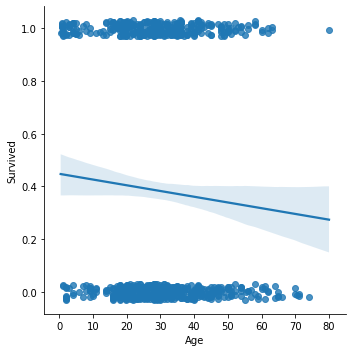

In [32]:
# add age range (threshold)
sns.lmplot('Age', 'Survived', data=train, y_jitter=0.03)
sur = train[train['Survived']==1][['Age']]
dead = train[train['Survived']==0][['Age']]
np.mean(sur), sur.quantile(0.25), sur.quantile(0.75)
np.mean(dead), dead.quantile(0.25), dead.quantile(0.75)

def age_threshold(entry):
    if entry<16:
        return 0
    elif entry<32:
        return 1
    elif entry<48:
        return 2
    elif entry<65:
        return 3
    else:
        return 4

train['Age'] = train['Age'].apply(age_threshold)
test['Age'] = test['Age'].apply(age_threshold)

In [33]:
def fare_weight_range(entry):
    if entry <= 7.9:
        return 0
    elif entry <= 14.5:
        return 1
    elif entry <= 31:
        return 2
    else:
        return 3
train['Fare'] = train['Fare'].apply(fare_weight_range)
test['Fare'] = test['Fare'].apply(fare_weight_range)

In [34]:
train.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,fold,title
0,1,0,3,male,1,1,0,A/5 21171,0,Unknown,S,1,Mr
1,2,1,1,female,2,1,0,PC 17599,3,C85,C,4,Mrs
2,3,1,3,female,1,0,0,STON/O2. 3101282,1,Unknown,S,3,Miss
3,4,1,1,female,2,1,0,113803,3,C123,S,3,Mrs
4,5,0,3,male,2,0,0,373450,1,Unknown,S,0,Mr


In [35]:
test.head()

,PassengerId,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,title
0,892,3,male,2,0,0,330911,0,Unknown,Q,Mr
1,893,3,female,2,1,0,363272,0,Unknown,S,Mrs
2,894,2,male,3,0,0,240276,1,Unknown,Q,Mr
3,895,3,male,1,0,0,315154,1,Unknown,S,Mr
4,896,3,female,1,1,1,3101298,1,Unknown,S,Mrs


### 3. clean ticket 

In [36]:
# Ticket  value_counts first
def ticket_extract(entry):
    pattern = r'[A-Z]+'
    extracted = ''.join(re.findall(pattern, entry))
    if extracted == '':
        return 'Number'
    elif extracted == 'PC':
        return extracted
    elif extracted == 'CA':
        return extracted
    else:
        return 'ELSE'

train['Ticket'] = train['Ticket'].apply(ticket_extract)
test['Ticket'] = test['Ticket'].apply(ticket_extract)

### 4. clean number of family members 

In [37]:
train['Alone'] = np.where((train['SibSp']==0)&(train['Parch']==0), 1, 0)
test['Alone'] = np.where((test['SibSp']==0)&(test['Parch']==0), 1, 0)

In [38]:
train = train.drop(columns = ['SibSp', 'Parch'])
test = test.drop(columns = ['SibSp', 'Parch'])

In [39]:
train.head()

,PassengerId,Survived,Pclass,Sex,Age,Ticket,Fare,Cabin,Embarked,fold,title,Alone
0,1,0,3,male,1,ELSE,0,Unknown,S,1,Mr,0
1,2,1,1,female,2,PC,3,C85,C,4,Mrs,0
2,3,1,3,female,1,ELSE,1,Unknown,S,3,Miss,1
3,4,1,1,female,2,Number,3,C123,S,3,Mrs,0
4,5,0,3,male,2,Number,1,Unknown,S,0,Mr,1


### 5. Extract cabin value

In [40]:
#cabin  get first letter
def cabin(entry):
    rare_list = ['A', 'F', 'G', 'T']
    if entry=='Unknown':
        return 'NAN'
    elif entry[0] in rare_list:
        return 'Rare'
    else:
        return entry[0]
train['Cabin'] = train['Cabin'].apply(cabin)
test['Cabin'] = test['Cabin'].apply(cabin)



## Label Encoding

In [41]:
train = train.drop('PassengerId', axis=1)
test = test.drop('PassengerId', axis=1)

In [42]:
train.head()

,Survived,Pclass,Sex,Age,Ticket,Fare,Cabin,Embarked,fold,title,Alone
0,0,3,male,1,ELSE,0,NAN,S,1,Mr,0
1,1,1,female,2,PC,3,C,C,4,Mrs,0
2,1,3,female,1,ELSE,1,NAN,S,3,Miss,1
3,1,1,female,2,Number,3,C,S,3,Mrs,0
4,0,3,male,2,Number,1,NAN,S,0,Mr,1


In [43]:
train = pd.get_dummies(train)
test = pd.get_dummies(test)

In [44]:
train.shape

(891, 28)

In [45]:
test.shape

(418, 26)

# Building Model

## LGB

In [46]:
def optuna_lgb(n_trials=500):
    
    def objective(trial):

        params = {
            "objective": "binary",
            "metric": "binary_logloss",
            "verbosity": -1,
            "boosting_type": "gbdt",
            "lambda_l1": trial.suggest_float("lambda_l1", 1e-5, 10, log=True),
            "lambda_l2": trial.suggest_float("lambda_l2", 1e-5, 10, log=True),
            "num_leaves": trial.suggest_int("num_leaves", 2, 62),
            "feature_fraction": trial.suggest_float("feature_fraction", 0.4, 0.9),
            "bagging_fraction": trial.suggest_float("bagging_fraction", 0.4, 0.9),
            "bagging_freq": trial.suggest_int("bagging_freq", 2, 9),
            "min_child_samples": trial.suggest_int("min_child_samples", 33, 93),
            "max_depth": trial.suggest_int("max_depth", 2, 7)
        }

        # initialize oof 
        oof_train = np.zeros((len(train),))

        for i in range(5):
            train_x = train.query(f'fold!={i}').drop(['fold', 'Survived'], axis=1)
            train_y = train.query(f'fold!={i}').Survived

            valid_x = train.query(f'fold=={i}').drop(['fold', 'Survived'], axis=1)
            valid_y = train.query(f'fold=={i}').Survived
            
            lgb_train = lgb.Dataset(train_x,
                                    train_y)

            lgb_eval = lgb.Dataset(valid_x,
                                   valid_y,
                                   reference=lgb_train)

            gbm = lgb.train(params,
                            lgb_train,
                            valid_sets=[lgb_train, lgb_eval],
                            num_boost_round=5000,
                            verbose_eval=-1, 
                            early_stopping_rounds=1000
                            )
            oof_preds = gbm.predict(valid_x, num_iteration=gbm.best_iteration)
            oof_train[valid_x.index] = gbm.predict(valid_x,
                                                   num_iteration=gbm.best_iteration)
            
            
        return accuracy_score(train.Survived, oof_train.round())
    
    study = optuna.create_study(direction="maximize")
    study.optimize(objective, n_trials=n_trials)

    print("Number of finished trials: {}".format(len(study.trials)))

    print("Best trial:")
    trial = study.best_trial

    print("  Value: {}".format(trial.value))

    print("  Params: ")
    for key, value in trial.params.items():
        print("    {}: {}".format(key, value))
    
    best_params = {
        "objective": "binary",
        "metric": "binary_logloss",
        "verbosity": -1,
        "boosting_type": "gbdt",
    }
    best_params.update(study.best_params)
    ## save trained model
    # initialize oof 
    oof_train = np.zeros((len(train),))
    print('*'*50)
    print('Exporting best models')
    print('*' * 50)
    # split folds using RSGKF
    for i in range(5):
        train_x = train.query(f'fold!={i}').drop(['fold', 'Survived'], axis=1)
        train_y = train.query(f'fold!={i}').Survived

        valid_x = train.query(f'fold=={i}').drop(['fold', 'Survived'], axis=1)
        valid_y = train.query(f'fold=={i}').Survived

        lgb_train = lgb.Dataset(train_x,
                                train_y)

        lgb_eval = lgb.Dataset(valid_x,
                               valid_y,
                               reference=lgb_train)

        gbm = lgb.train(best_params,
                        lgb_train,
                        valid_sets=[lgb_train, lgb_eval],
                        num_boost_round=50000,
                        verbose_eval=-1, 
                        early_stopping_rounds=1001
                        )

        oof_preds = gbm.predict(valid_x, num_iteration=gbm.best_iteration)
        oof_train[valid_x.index] = gbm.predict(valid_x, num_iteration=gbm.best_iteration)

        joblib.dump(gbm, f'lgb_fold{i}.pkl')

In [47]:
optuna_lgb()

[I 2021-10-03 19:33:31,264] A new study created in memory with name: no-name-18cdc700-052e-4f80-9556-49af7346a22c


Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[180]	training's binary_logloss: 0.399324	valid_1's binary_logloss: 0.390527
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[760]	training's binary_logloss: 0.371955	valid_1's binary_logloss: 0.404648
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[96]	training's binary_logloss: 0.388592	valid_1's binary_logloss: 0.456985
Training until validation scores don't improve for 1000 rounds


[I 2021-10-03 19:33:32,849] Trial 0 finished with value: 0.8226711560044894 and parameters: {'lambda_l1': 1.0301747410495141, 'lambda_l2': 6.582651252282509e-05, 'num_leaves': 28, 'feature_fraction': 0.717289899602571, 'bagging_fraction': 0.5412367495807964, 'bagging_freq': 5, 'min_child_samples': 43, 'max_depth': 6}. Best is trial 0 with value: 0.8226711560044894.


Early stopping, best iteration is:
[1660]	training's binary_logloss: 0.352606	valid_1's binary_logloss: 0.391671
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[60]	training's binary_logloss: 0.414049	valid_1's binary_logloss: 0.409499
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[109]	training's binary_logloss: 0.377248	valid_1's binary_logloss: 0.3833
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[209]	training's binary_logloss: 0.348475	valid_1's binary_logloss: 0.385708
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[30]	training's binary_logloss: 0.395842	valid_1's binary_logloss: 0.456487
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[292]	training's binary_logloss: 0.331582	valid_1's binary_logloss: 0.390462
Training until v

[I 2021-10-03 19:33:34,625] Trial 1 finished with value: 0.8181818181818182 and parameters: {'lambda_l1': 0.000864704352311218, 'lambda_l2': 0.06181940745045265, 'num_leaves': 53, 'feature_fraction': 0.6713593105551645, 'bagging_fraction': 0.6623154547848851, 'bagging_freq': 7, 'min_child_samples': 33, 'max_depth': 6}. Best is trial 0 with value: 0.8226711560044894.


Early stopping, best iteration is:
[84]	training's binary_logloss: 0.374814	valid_1's binary_logloss: 0.415884
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[107]	training's binary_logloss: 0.373047	valid_1's binary_logloss: 0.390312
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[537]	training's binary_logloss: 0.32399	valid_1's binary_logloss: 0.388339
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[28]	training's binary_logloss: 0.396101	valid_1's binary_logloss: 0.465397
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[226]	training's binary_logloss: 0.341114	valid_1's binary_logloss: 0.387291
Training until validation scores don't improve for 1000 rounds


[I 2021-10-03 19:33:36,659] Trial 2 finished with value: 0.8294051627384961 and parameters: {'lambda_l1': 0.09544519377294379, 'lambda_l2': 7.330467498958437e-05, 'num_leaves': 51, 'feature_fraction': 0.654848361402538, 'bagging_fraction': 0.7875315857366498, 'bagging_freq': 3, 'min_child_samples': 34, 'max_depth': 5}. Best is trial 2 with value: 0.8294051627384961.


Early stopping, best iteration is:
[43]	training's binary_logloss: 0.390603	valid_1's binary_logloss: 0.416285
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[302]	training's binary_logloss: 0.376508	valid_1's binary_logloss: 0.392757
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[1147]	training's binary_logloss: 0.331933	valid_1's binary_logloss: 0.397518
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[55]	training's binary_logloss: 0.398786	valid_1's binary_logloss: 0.459903
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[792]	training's binary_logloss: 0.333913	valid_1's binary_logloss: 0.390868
Training until validation scores don't improve for 1000 rounds


[I 2021-10-03 19:33:38,371] Trial 3 finished with value: 0.8282828282828283 and parameters: {'lambda_l1': 0.018581624963924286, 'lambda_l2': 2.9873025120187915, 'num_leaves': 46, 'feature_fraction': 0.5464605369630511, 'bagging_fraction': 0.7522652534346792, 'bagging_freq': 8, 'min_child_samples': 43, 'max_depth': 6}. Best is trial 2 with value: 0.8294051627384961.


Early stopping, best iteration is:
[47]	training's binary_logloss: 0.413023	valid_1's binary_logloss: 0.412455
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[3286]	training's binary_logloss: 0.424309	valid_1's binary_logloss: 0.412443
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[574]	training's binary_logloss: 0.429148	valid_1's binary_logloss: 0.425048
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[604]	training's binary_logloss: 0.416062	valid_1's binary_logloss: 0.469402
Training until validation scores don't improve for 1000 rounds


[I 2021-10-03 19:33:39,898] Trial 4 finished with value: 0.7968574635241302 and parameters: {'lambda_l1': 9.676063100110962, 'lambda_l2': 0.016415153699101338, 'num_leaves': 20, 'feature_fraction': 0.8087688805008334, 'bagging_fraction': 0.5445867549537585, 'bagging_freq': 2, 'min_child_samples': 37, 'max_depth': 5}. Best is trial 2 with value: 0.8294051627384961.


Early stopping, best iteration is:
[1501]	training's binary_logloss: 0.420769	valid_1's binary_logloss: 0.446309
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[72]	training's binary_logloss: 0.447066	valid_1's binary_logloss: 0.429761
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[464]	training's binary_logloss: 0.385653	valid_1's binary_logloss: 0.398259
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[267]	training's binary_logloss: 0.38628	valid_1's binary_logloss: 0.40678
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[51]	training's binary_logloss: 0.408261	valid_1's binary_logloss: 0.462116
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[1104]	training's binary_logloss: 0.358094	valid_1's binary_logloss: 0.395872
Training until 

[I 2021-10-03 19:33:41,377] Trial 5 finished with value: 0.8260381593714927 and parameters: {'lambda_l1': 0.033842298610976554, 'lambda_l2': 0.005333607768305632, 'num_leaves': 31, 'feature_fraction': 0.5700437738761994, 'bagging_fraction': 0.807453553269424, 'bagging_freq': 8, 'min_child_samples': 81, 'max_depth': 4}. Best is trial 2 with value: 0.8294051627384961.


Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[307]	training's binary_logloss: 0.402483	valid_1's binary_logloss: 0.400131
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[852]	training's binary_logloss: 0.381479	valid_1's binary_logloss: 0.408476
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[812]	training's binary_logloss: 0.368123	valid_1's binary_logloss: 0.466418
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[1106]	training's binary_logloss: 0.380439	valid_1's binary_logloss: 0.393012
Training until validation scores don't improve for 1000 rounds


[I 2021-10-03 19:33:42,873] Trial 6 finished with value: 0.8237934904601572 and parameters: {'lambda_l1': 0.03271444703073252, 'lambda_l2': 1.8144292945398737, 'num_leaves': 50, 'feature_fraction': 0.65980325968876, 'bagging_fraction': 0.6204292360061243, 'bagging_freq': 2, 'min_child_samples': 64, 'max_depth': 2}. Best is trial 2 with value: 0.8294051627384961.


Early stopping, best iteration is:
[138]	training's binary_logloss: 0.410941	valid_1's binary_logloss: 0.411175
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[342]	training's binary_logloss: 0.396542	valid_1's binary_logloss: 0.395249
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[314]	training's binary_logloss: 0.391943	valid_1's binary_logloss: 0.407689
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[37]	training's binary_logloss: 0.418466	valid_1's binary_logloss: 0.463065
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[1243]	training's binary_logloss: 0.366521	valid_1's binary_logloss: 0.388268
Training until validation scores don't improve for 1000 rounds


[I 2021-10-03 19:33:44,255] Trial 7 finished with value: 0.8260381593714927 and parameters: {'lambda_l1': 9.89841917837746e-05, 'lambda_l2': 1.0147699886338208, 'num_leaves': 51, 'feature_fraction': 0.5869506140775913, 'bagging_fraction': 0.7499908088755025, 'bagging_freq': 9, 'min_child_samples': 82, 'max_depth': 4}. Best is trial 2 with value: 0.8294051627384961.


Early stopping, best iteration is:
[617]	training's binary_logloss: 0.375512	valid_1's binary_logloss: 0.420428
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[342]	training's binary_logloss: 0.384436	valid_1's binary_logloss: 0.391975
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[1153]	training's binary_logloss: 0.3532	valid_1's binary_logloss: 0.400478
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[52]	training's binary_logloss: 0.405836	valid_1's binary_logloss: 0.461006
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[1199]	training's binary_logloss: 0.348289	valid_1's binary_logloss: 0.39446
Training until validation scores don't improve for 1000 rounds


[I 2021-10-03 19:33:45,780] Trial 8 finished with value: 0.8282828282828283 and parameters: {'lambda_l1': 0.010672290748295168, 'lambda_l2': 8.415747335956539, 'num_leaves': 11, 'feature_fraction': 0.5667575606998099, 'bagging_fraction': 0.854731364016923, 'bagging_freq': 9, 'min_child_samples': 61, 'max_depth': 7}. Best is trial 2 with value: 0.8294051627384961.


Early stopping, best iteration is:
[83]	training's binary_logloss: 0.407262	valid_1's binary_logloss: 0.414477
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[112]	training's binary_logloss: 0.394008	valid_1's binary_logloss: 0.384197
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[280]	training's binary_logloss: 0.367434	valid_1's binary_logloss: 0.393466
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[33]	training's binary_logloss: 0.402276	valid_1's binary_logloss: 0.464162
Training until validation scores don't improve for 1000 rounds


[I 2021-10-03 19:33:46,925] Trial 9 finished with value: 0.8159371492704826 and parameters: {'lambda_l1': 0.028567289364147385, 'lambda_l2': 0.025583473115683156, 'num_leaves': 36, 'feature_fraction': 0.8382385921313411, 'bagging_fraction': 0.6152664176191553, 'bagging_freq': 7, 'min_child_samples': 38, 'max_depth': 3}. Best is trial 2 with value: 0.8294051627384961.


Early stopping, best iteration is:
[897]	training's binary_logloss: 0.331067	valid_1's binary_logloss: 0.387277
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[85]	training's binary_logloss: 0.390817	valid_1's binary_logloss: 0.415117
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[3366]	training's binary_logloss: 0.399216	valid_1's binary_logloss: 0.398156
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[492]	training's binary_logloss: 0.414755	valid_1's binary_logloss: 0.429045
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[121]	training's binary_logloss: 0.416784	valid_1's binary_logloss: 0.468751
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[2333]	training's binary_logloss: 0.402428	valid_1's binary_logloss: 0.39379
Training unti

[I 2021-10-03 19:33:48,780] Trial 10 finished with value: 0.8237934904601572 and parameters: {'lambda_l1': 2.1416284689605005, 'lambda_l2': 1.361918950327909e-05, 'num_leaves': 40, 'feature_fraction': 0.41012740531755454, 'bagging_fraction': 0.42759422505953015, 'bagging_freq': 4, 'min_child_samples': 56, 'max_depth': 2}. Best is trial 2 with value: 0.8294051627384961.


Early stopping, best iteration is:
[753]	training's binary_logloss: 0.412159	valid_1's binary_logloss: 0.406328
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[204]	training's binary_logloss: 0.383811	valid_1's binary_logloss: 0.391223
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[711]	training's binary_logloss: 0.352445	valid_1's binary_logloss: 0.401011
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[56]	training's binary_logloss: 0.391511	valid_1's binary_logloss: 0.457416
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[876]	training's binary_logloss: 0.334845	valid_1's binary_logloss: 0.389629
Training until validation scores don't improve for 1000 rounds


[I 2021-10-03 19:33:50,358] Trial 11 finished with value: 0.8237934904601572 and parameters: {'lambda_l1': 0.2836194271402217, 'lambda_l2': 0.00021265490890732318, 'num_leaves': 62, 'feature_fraction': 0.4509812807395328, 'bagging_fraction': 0.899222712692335, 'bagging_freq': 4, 'min_child_samples': 51, 'max_depth': 6}. Best is trial 2 with value: 0.8294051627384961.


Early stopping, best iteration is:
[64]	training's binary_logloss: 0.39605	valid_1's binary_logloss: 0.415563
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[116]	training's binary_logloss: 0.389329	valid_1's binary_logloss: 0.390515
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[225]	training's binary_logloss: 0.366749	valid_1's binary_logloss: 0.406031
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[42]	training's binary_logloss: 0.399497	valid_1's binary_logloss: 0.459504
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[414]	training's binary_logloss: 0.346947	valid_1's binary_logloss: 0.391397
Training until validation scores don't improve for 1000 rounds


[I 2021-10-03 19:33:52,244] Trial 12 finished with value: 0.8260381593714927 and parameters: {'lambda_l1': 0.0006503831499329616, 'lambda_l2': 0.0008968289501416061, 'num_leaves': 62, 'feature_fraction': 0.49165034019051845, 'bagging_fraction': 0.7454674942210563, 'bagging_freq': 3, 'min_child_samples': 46, 'max_depth': 5}. Best is trial 2 with value: 0.8294051627384961.


Early stopping, best iteration is:
[73]	training's binary_logloss: 0.386301	valid_1's binary_logloss: 0.414187
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[348]	training's binary_logloss: 0.390147	valid_1's binary_logloss: 0.400176
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[183]	training's binary_logloss: 0.391229	valid_1's binary_logloss: 0.41288
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[44]	training's binary_logloss: 0.40752	valid_1's binary_logloss: 0.464138
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[828]	training's binary_logloss: 0.365325	valid_1's binary_logloss: 0.399715
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[129]	training's binary_logloss: 0.393718	valid_1's binary_logloss: 0.418443


[I 2021-10-03 19:33:53,676] Trial 13 finished with value: 0.8103254769921436 and parameters: {'lambda_l1': 0.273378190714404, 'lambda_l2': 1.0421800697980601e-05, 'num_leaves': 44, 'feature_fraction': 0.7371247371039351, 'bagging_fraction': 0.7398852510244599, 'bagging_freq': 6, 'min_child_samples': 71, 'max_depth': 7}. Best is trial 2 with value: 0.8294051627384961.


Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[185]	training's binary_logloss: 0.350788	valid_1's binary_logloss: 0.395364
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[198]	training's binary_logloss: 0.35074	valid_1's binary_logloss: 0.388895
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[37]	training's binary_logloss: 0.385131	valid_1's binary_logloss: 0.458889
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[250]	training's binary_logloss: 0.331176	valid_1's binary_logloss: 0.391931
Training until validation scores don't improve for 1000 rounds


[I 2021-10-03 19:33:55,149] Trial 14 finished with value: 0.8282828282828283 and parameters: {'lambda_l1': 0.0018784826534156112, 'lambda_l2': 0.23908263631825605, 'num_leaves': 59, 'feature_fraction': 0.5958158533203866, 'bagging_fraction': 0.8263873838147485, 'bagging_freq': 6, 'min_child_samples': 34, 'max_depth': 5}. Best is trial 2 with value: 0.8294051627384961.


Early stopping, best iteration is:
[62]	training's binary_logloss: 0.381028	valid_1's binary_logloss: 0.408594
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[141]	training's binary_logloss: 0.389683	valid_1's binary_logloss: 0.393007
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[602]	training's binary_logloss: 0.353004	valid_1's binary_logloss: 0.396648
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[36]	training's binary_logloss: 0.406932	valid_1's binary_logloss: 0.461207
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[868]	training's binary_logloss: 0.336135	valid_1's binary_logloss: 0.388784
Training until validation scores don't improve for 1000 rounds


[I 2021-10-03 19:33:56,796] Trial 15 finished with value: 0.8294051627384961 and parameters: {'lambda_l1': 0.1703232848993538, 'lambda_l2': 0.0016964928974546492, 'num_leaves': 44, 'feature_fraction': 0.5000506408979948, 'bagging_fraction': 0.6747458422839739, 'bagging_freq': 4, 'min_child_samples': 44, 'max_depth': 6}. Best is trial 2 with value: 0.8294051627384961.


Early stopping, best iteration is:
[48]	training's binary_logloss: 0.41077	valid_1's binary_logloss: 0.413426
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[435]	training's binary_logloss: 0.404718	valid_1's binary_logloss: 0.397117
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[516]	training's binary_logloss: 0.397244	valid_1's binary_logloss: 0.416689
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[130]	training's binary_logloss: 0.402807	valid_1's binary_logloss: 0.465623
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[2584]	training's binary_logloss: 0.375886	valid_1's binary_logloss: 0.38555
Training until validation scores don't improve for 1000 rounds


[I 2021-10-03 19:33:58,510] Trial 16 finished with value: 0.8170594837261503 and parameters: {'lambda_l1': 0.24596232602034987, 'lambda_l2': 0.0018878945678034772, 'num_leaves': 56, 'feature_fraction': 0.5055515992577845, 'bagging_fraction': 0.6791486704069232, 'bagging_freq': 3, 'min_child_samples': 92, 'max_depth': 7}. Best is trial 2 with value: 0.8294051627384961.


Early stopping, best iteration is:
[126]	training's binary_logloss: 0.416614	valid_1's binary_logloss: 0.413454
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[371]	training's binary_logloss: 0.429721	valid_1's binary_logloss: 0.424844
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[613]	training's binary_logloss: 0.425344	valid_1's binary_logloss: 0.422968
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[423]	training's binary_logloss: 0.415766	valid_1's binary_logloss: 0.465467
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[616]	training's binary_logloss: 0.425129	valid_1's binary_logloss: 0.440793
Training until validation scores don't improve for 1000 rounds


[I 2021-10-03 19:33:59,656] Trial 17 finished with value: 0.7957351290684624 and parameters: {'lambda_l1': 8.652633141111906, 'lambda_l2': 0.00015400420783827853, 'num_leaves': 38, 'feature_fraction': 0.7742715188426832, 'bagging_fraction': 0.5228295097892603, 'bagging_freq': 4, 'min_child_samples': 51, 'max_depth': 4}. Best is trial 2 with value: 0.8294051627384961.


Early stopping, best iteration is:
[1966]	training's binary_logloss: 0.42378	valid_1's binary_logloss: 0.412415
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[108]	training's binary_logloss: 0.37849	valid_1's binary_logloss: 0.380657
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[378]	training's binary_logloss: 0.336592	valid_1's binary_logloss: 0.391197
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[42]	training's binary_logloss: 0.386329	valid_1's binary_logloss: 0.462057
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[222]	training's binary_logloss: 0.347763	valid_1's binary_logloss: 0.396329
Training until validation scores don't improve for 1000 rounds


[I 2021-10-03 19:34:01,332] Trial 18 finished with value: 0.8226711560044894 and parameters: {'lambda_l1': 0.11761547456550835, 'lambda_l2': 0.0007524664410500803, 'num_leaves': 25, 'feature_fraction': 0.6280859015789979, 'bagging_fraction': 0.8712806794296837, 'bagging_freq': 3, 'min_child_samples': 40, 'max_depth': 5}. Best is trial 2 with value: 0.8294051627384961.


Early stopping, best iteration is:
[37]	training's binary_logloss: 0.40018	valid_1's binary_logloss: 0.413438
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[731]	training's binary_logloss: 0.395194	valid_1's binary_logloss: 0.389707
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[866]	training's binary_logloss: 0.384396	valid_1's binary_logloss: 0.404258
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[49]	training's binary_logloss: 0.407501	valid_1's binary_logloss: 0.462524
Training until validation scores don't improve for 1000 rounds


[I 2021-10-03 19:34:02,503] Trial 19 finished with value: 0.8215488215488216 and parameters: {'lambda_l1': 2.347293116311714, 'lambda_l2': 3.8857936530190486e-05, 'num_leaves': 44, 'feature_fraction': 0.6912120156083799, 'bagging_fraction': 0.704980654539023, 'bagging_freq': 5, 'min_child_samples': 50, 'max_depth': 3}. Best is trial 2 with value: 0.8294051627384961.


Early stopping, best iteration is:
[688]	training's binary_logloss: 0.383318	valid_1's binary_logloss: 0.40613
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[123]	training's binary_logloss: 0.404691	valid_1's binary_logloss: 0.406763
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[133]	training's binary_logloss: 0.374104	valid_1's binary_logloss: 0.393176
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[368]	training's binary_logloss: 0.335949	valid_1's binary_logloss: 0.389471
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[36]	training's binary_logloss: 0.393677	valid_1's binary_logloss: 0.461281
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[324]	training's binary_logloss: 0.334933	valid_1's binary_logloss: 0.393011
Training until 

[I 2021-10-03 19:34:04,209] Trial 20 finished with value: 0.8260381593714927 and parameters: {'lambda_l1': 0.0029836742744880195, 'lambda_l2': 0.0037001496538968154, 'num_leaves': 49, 'feature_fraction': 0.41375230421153975, 'bagging_fraction': 0.7897157870988243, 'bagging_freq': 2, 'min_child_samples': 33, 'max_depth': 6}. Best is trial 2 with value: 0.8294051627384961.


Early stopping, best iteration is:
[124]	training's binary_logloss: 0.361178	valid_1's binary_logloss: 0.402609
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[150]	training's binary_logloss: 0.383346	valid_1's binary_logloss: 0.386471
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[534]	training's binary_logloss: 0.344145	valid_1's binary_logloss: 0.399019
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[39]	training's binary_logloss: 0.399482	valid_1's binary_logloss: 0.460146
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[296]	training's binary_logloss: 0.353868	valid_1's binary_logloss: 0.393052
Training until validation scores don't improve for 1000 rounds


[I 2021-10-03 19:34:05,783] Trial 21 finished with value: 0.8294051627384961 and parameters: {'lambda_l1': 0.007455646361075107, 'lambda_l2': 0.00032600887253394015, 'num_leaves': 46, 'feature_fraction': 0.5160082856869526, 'bagging_fraction': 0.7155337535223008, 'bagging_freq': 4, 'min_child_samples': 44, 'max_depth': 6}. Best is trial 2 with value: 0.8294051627384961.


Early stopping, best iteration is:
[47]	training's binary_logloss: 0.407419	valid_1's binary_logloss: 0.41046
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[144]	training's binary_logloss: 0.392924	valid_1's binary_logloss: 0.391189
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[465]	training's binary_logloss: 0.359776	valid_1's binary_logloss: 0.402131
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[55]	training's binary_logloss: 0.393389	valid_1's binary_logloss: 0.455352
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[1328]	training's binary_logloss: 0.323072	valid_1's binary_logloss: 0.386666
Training until validation scores don't improve for 1000 rounds


[I 2021-10-03 19:34:08,076] Trial 22 finished with value: 0.8226711560044894 and parameters: {'lambda_l1': 0.0037246286876713984, 'lambda_l2': 0.00039686586383521624, 'num_leaves': 42, 'feature_fraction': 0.506946803633975, 'bagging_fraction': 0.6040551338201362, 'bagging_freq': 4, 'min_child_samples': 46, 'max_depth': 6}. Best is trial 2 with value: 0.8294051627384961.


Early stopping, best iteration is:
[99]	training's binary_logloss: 0.389543	valid_1's binary_logloss: 0.404937
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[440]	training's binary_logloss: 0.371786	valid_1's binary_logloss: 0.391325
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[585]	training's binary_logloss: 0.362715	valid_1's binary_logloss: 0.408258
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[59]	training's binary_logloss: 0.395952	valid_1's binary_logloss: 0.457525
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[996]	training's binary_logloss: 0.341691	valid_1's binary_logloss: 0.396726
Training until validation scores don't improve for 1000 rounds


[I 2021-10-03 19:34:10,087] Trial 23 finished with value: 0.8204264870931538 and parameters: {'lambda_l1': 0.0001758005712285677, 'lambda_l2': 4.536786861956608e-05, 'num_leaves': 35, 'feature_fraction': 0.4613897138685015, 'bagging_fraction': 0.7027467246359236, 'bagging_freq': 3, 'min_child_samples': 57, 'max_depth': 7}. Best is trial 2 with value: 0.8294051627384961.


Early stopping, best iteration is:
[73]	training's binary_logloss: 0.400526	valid_1's binary_logloss: 0.410076
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[180]	training's binary_logloss: 0.358802	valid_1's binary_logloss: 0.393484
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[155]	training's binary_logloss: 0.361972	valid_1's binary_logloss: 0.391705
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[31]	training's binary_logloss: 0.395525	valid_1's binary_logloss: 0.460646
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[240]	training's binary_logloss: 0.338843	valid_1's binary_logloss: 0.387331
Training until validation scores don't improve for 1000 rounds


[I 2021-10-03 19:34:12,274] Trial 24 finished with value: 0.8260381593714927 and parameters: {'lambda_l1': 0.1034585926227864, 'lambda_l2': 0.0015403352887321544, 'num_leaves': 56, 'feature_fraction': 0.6295645364727354, 'bagging_fraction': 0.7837932555780233, 'bagging_freq': 5, 'min_child_samples': 33, 'max_depth': 5}. Best is trial 2 with value: 0.8294051627384961.


Early stopping, best iteration is:
[60]	training's binary_logloss: 0.383766	valid_1's binary_logloss: 0.412162
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[112]	training's binary_logloss: 0.38731	valid_1's binary_logloss: 0.392616
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[512]	training's binary_logloss: 0.338536	valid_1's binary_logloss: 0.391454
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[39]	training's binary_logloss: 0.399207	valid_1's binary_logloss: 0.462408
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[392]	training's binary_logloss: 0.337541	valid_1's binary_logloss: 0.386864
Training until validation scores don't improve for 1000 rounds


[I 2021-10-03 19:34:14,321] Trial 25 finished with value: 0.8226711560044894 and parameters: {'lambda_l1': 1.4893588121194897e-05, 'lambda_l2': 0.0002753939818044981, 'num_leaves': 46, 'feature_fraction': 0.5261399255651431, 'bagging_fraction': 0.694594217955909, 'bagging_freq': 4, 'min_child_samples': 41, 'max_depth': 6}. Best is trial 2 with value: 0.8294051627384961.


Early stopping, best iteration is:
[47]	training's binary_logloss: 0.403875	valid_1's binary_logloss: 0.411036
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[423]	training's binary_logloss: 0.387042	valid_1's binary_logloss: 0.390211
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[1111]	training's binary_logloss: 0.36828	valid_1's binary_logloss: 0.406664
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[90]	training's binary_logloss: 0.390619	valid_1's binary_logloss: 0.459964
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[1658]	training's binary_logloss: 0.351063	valid_1's binary_logloss: 0.386875
Training until validation scores don't improve for 1000 rounds


[I 2021-10-03 19:34:16,917] Trial 26 finished with value: 0.8159371492704826 and parameters: {'lambda_l1': 1.13421771573696, 'lambda_l2': 2.370053006793467e-05, 'num_leaves': 55, 'feature_fraction': 0.4622088559248564, 'bagging_fraction': 0.8423251336219058, 'bagging_freq': 3, 'min_child_samples': 47, 'max_depth': 5}. Best is trial 2 with value: 0.8294051627384961.


Early stopping, best iteration is:
[64]	training's binary_logloss: 0.409602	valid_1's binary_logloss: 0.411976
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[192]	training's binary_logloss: 0.391306	valid_1's binary_logloss: 0.392501
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[903]	training's binary_logloss: 0.354953	valid_1's binary_logloss: 0.402022
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[35]	training's binary_logloss: 0.406774	valid_1's binary_logloss: 0.460924
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[1070]	training's binary_logloss: 0.344681	valid_1's binary_logloss: 0.391157
Training until validation scores don't improve for 1000 rounds


[I 2021-10-03 19:34:19,161] Trial 27 finished with value: 0.8260381593714927 and parameters: {'lambda_l1': 0.08085732827319522, 'lambda_l2': 0.00010245348264183622, 'num_leaves': 48, 'feature_fraction': 0.6166090853028029, 'bagging_fraction': 0.6539216873777962, 'bagging_freq': 5, 'min_child_samples': 55, 'max_depth': 7}. Best is trial 2 with value: 0.8294051627384961.


Early stopping, best iteration is:
[104]	training's binary_logloss: 0.394108	valid_1's binary_logloss: 0.411449
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[1004]	training's binary_logloss: 0.383702	valid_1's binary_logloss: 0.394867
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[294]	training's binary_logloss: 0.392059	valid_1's binary_logloss: 0.413811
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[46]	training's binary_logloss: 0.411436	valid_1's binary_logloss: 0.46513
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[1217]	training's binary_logloss: 0.372045	valid_1's binary_logloss: 0.387057
Training until validation scores don't improve for 1000 rounds


[I 2021-10-03 19:34:20,935] Trial 28 finished with value: 0.8305274971941639 and parameters: {'lambda_l1': 0.005155225744703853, 'lambda_l2': 0.005798436154243654, 'num_leaves': 40, 'feature_fraction': 0.42900918863347903, 'bagging_fraction': 0.5887064872337572, 'bagging_freq': 2, 'min_child_samples': 67, 'max_depth': 4}. Best is trial 28 with value: 0.8305274971941639.


Early stopping, best iteration is:
[124]	training's binary_logloss: 0.406329	valid_1's binary_logloss: 0.413633
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[358]	training's binary_logloss: 0.399606	valid_1's binary_logloss: 0.395899
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[204]	training's binary_logloss: 0.401881	valid_1's binary_logloss: 0.415598
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[55]	training's binary_logloss: 0.406463	valid_1's binary_logloss: 0.46803
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[1793]	training's binary_logloss: 0.367064	valid_1's binary_logloss: 0.387156
Training until validation scores don't improve for 1000 rounds


[I 2021-10-03 19:34:22,660] Trial 29 finished with value: 0.8226711560044894 and parameters: {'lambda_l1': 0.005226015863699586, 'lambda_l2': 0.057943210262248704, 'num_leaves': 27, 'feature_fraction': 0.7005010060590077, 'bagging_fraction': 0.5538940806402454, 'bagging_freq': 2, 'min_child_samples': 71, 'max_depth': 3}. Best is trial 28 with value: 0.8305274971941639.


Early stopping, best iteration is:
[51]	training's binary_logloss: 0.426984	valid_1's binary_logloss: 0.413762
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[827]	training's binary_logloss: 0.398977	valid_1's binary_logloss: 0.399583
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[536]	training's binary_logloss: 0.400718	valid_1's binary_logloss: 0.412037
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[357]	training's binary_logloss: 0.389695	valid_1's binary_logloss: 0.471757
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[2698]	training's binary_logloss: 0.378786	valid_1's binary_logloss: 0.387642
Training until validation scores don't improve for 1000 rounds


[I 2021-10-03 19:34:24,723] Trial 30 finished with value: 0.8249158249158249 and parameters: {'lambda_l1': 0.5569511737519421, 'lambda_l2': 0.009018413804558674, 'num_leaves': 31, 'feature_fraction': 0.7314893994014741, 'bagging_fraction': 0.4769302205607656, 'bagging_freq': 2, 'min_child_samples': 69, 'max_depth': 4}. Best is trial 28 with value: 0.8305274971941639.


Early stopping, best iteration is:
[152]	training's binary_logloss: 0.415683	valid_1's binary_logloss: 0.410213
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[1214]	training's binary_logloss: 0.380064	valid_1's binary_logloss: 0.399981
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[240]	training's binary_logloss: 0.394295	valid_1's binary_logloss: 0.410722
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[222]	training's binary_logloss: 0.383294	valid_1's binary_logloss: 0.462627
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[1767]	training's binary_logloss: 0.363463	valid_1's binary_logloss: 0.386362
Training until validation scores don't improve for 1000 rounds


[I 2021-10-03 19:34:26,840] Trial 31 finished with value: 0.8260381593714927 and parameters: {'lambda_l1': 0.009126754985259007, 'lambda_l2': 0.0027561534590421653, 'num_leaves': 40, 'feature_fraction': 0.4124906337292959, 'bagging_fraction': 0.5894432791418248, 'bagging_freq': 3, 'min_child_samples': 65, 'max_depth': 5}. Best is trial 28 with value: 0.8305274971941639.


Early stopping, best iteration is:
[73]	training's binary_logloss: 0.417007	valid_1's binary_logloss: 0.410524
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[612]	training's binary_logloss: 0.393237	valid_1's binary_logloss: 0.399382
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[320]	training's binary_logloss: 0.397033	valid_1's binary_logloss: 0.417495
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[48]	training's binary_logloss: 0.413757	valid_1's binary_logloss: 0.465352
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[550]	training's binary_logloss: 0.392218	valid_1's binary_logloss: 0.389667
Training until validation scores don't improve for 1000 rounds


[I 2021-10-03 19:34:28,345] Trial 32 finished with value: 0.8215488215488216 and parameters: {'lambda_l1': 0.001021055519099978, 'lambda_l2': 0.000615600851851825, 'num_leaves': 52, 'feature_fraction': 0.4465287134078666, 'bagging_fraction': 0.6360881481239716, 'bagging_freq': 4, 'min_child_samples': 78, 'max_depth': 6}. Best is trial 28 with value: 0.8305274971941639.


Early stopping, best iteration is:
[100]	training's binary_logloss: 0.417767	valid_1's binary_logloss: 0.41689
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[103]	training's binary_logloss: 0.385412	valid_1's binary_logloss: 0.386879
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[453]	training's binary_logloss: 0.338705	valid_1's binary_logloss: 0.38892
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[42]	training's binary_logloss: 0.387514	valid_1's binary_logloss: 0.464104
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[222]	training's binary_logloss: 0.354264	valid_1's binary_logloss: 0.39142
Training until validation scores don't improve for 1000 rounds


[I 2021-10-03 19:34:29,941] Trial 33 finished with value: 0.8249158249158249 and parameters: {'lambda_l1': 0.010976104051959193, 'lambda_l2': 8.248004227383792e-05, 'num_leaves': 42, 'feature_fraction': 0.898454092219522, 'bagging_fraction': 0.7184196695125407, 'bagging_freq': 3, 'min_child_samples': 43, 'max_depth': 4}. Best is trial 28 with value: 0.8305274971941639.


Early stopping, best iteration is:
[78]	training's binary_logloss: 0.382637	valid_1's binary_logloss: 0.417166
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[124]	training's binary_logloss: 0.37713	valid_1's binary_logloss: 0.385474
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[700]	training's binary_logloss: 0.327381	valid_1's binary_logloss: 0.385108
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[28]	training's binary_logloss: 0.405783	valid_1's binary_logloss: 0.45831
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[549]	training's binary_logloss: 0.328095	valid_1's binary_logloss: 0.391356
Training until validation scores don't improve for 1000 rounds


[I 2021-10-03 19:34:32,141] Trial 34 finished with value: 0.8305274971941639 and parameters: {'lambda_l1': 0.05602612826526422, 'lambda_l2': 0.00926073701248374, 'num_leaves': 35, 'feature_fraction': 0.538492071625692, 'bagging_fraction': 0.6770142108335596, 'bagging_freq': 4, 'min_child_samples': 36, 'max_depth': 6}. Best is trial 28 with value: 0.8305274971941639.


Early stopping, best iteration is:
[96]	training's binary_logloss: 0.375159	valid_1's binary_logloss: 0.411632
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[695]	training's binary_logloss: 0.393286	valid_1's binary_logloss: 0.397774
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[393]	training's binary_logloss: 0.393385	valid_1's binary_logloss: 0.416692
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[225]	training's binary_logloss: 0.387107	valid_1's binary_logloss: 0.468105
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[1660]	training's binary_logloss: 0.371826	valid_1's binary_logloss: 0.386535
Training until validation scores don't improve for 1000 rounds


[I 2021-10-03 19:34:33,799] Trial 35 finished with value: 0.8237934904601572 and parameters: {'lambda_l1': 0.0003362784260694223, 'lambda_l2': 0.0478054700427561, 'num_leaves': 23, 'feature_fraction': 0.5402305883790051, 'bagging_fraction': 0.5808933891981629, 'bagging_freq': 5, 'min_child_samples': 75, 'max_depth': 6}. Best is trial 28 with value: 0.8305274971941639.


Early stopping, best iteration is:
[80]	training's binary_logloss: 0.419977	valid_1's binary_logloss: 0.41839
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[137]	training's binary_logloss: 0.36721	valid_1's binary_logloss: 0.39469
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[266]	training's binary_logloss: 0.340923	valid_1's binary_logloss: 0.388667
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[28]	training's binary_logloss: 0.397688	valid_1's binary_logloss: 0.461615
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[276]	training's binary_logloss: 0.336364	valid_1's binary_logloss: 0.392682
Training until validation scores don't improve for 1000 rounds


[I 2021-10-03 19:34:35,488] Trial 36 finished with value: 0.8249158249158249 and parameters: {'lambda_l1': 0.04365892175642908, 'lambda_l2': 0.01524206218397265, 'num_leaves': 35, 'feature_fraction': 0.6563475711301636, 'bagging_fraction': 0.7694688564162806, 'bagging_freq': 2, 'min_child_samples': 36, 'max_depth': 5}. Best is trial 28 with value: 0.8305274971941639.


Early stopping, best iteration is:
[48]	training's binary_logloss: 0.392198	valid_1's binary_logloss: 0.415087
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[214]	training's binary_logloss: 0.396149	valid_1's binary_logloss: 0.395726
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[534]	training's binary_logloss: 0.369853	valid_1's binary_logloss: 0.408715
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[40]	training's binary_logloss: 0.406482	valid_1's binary_logloss: 0.455482
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[822]	training's binary_logloss: 0.357518	valid_1's binary_logloss: 0.394021
Training until validation scores don't improve for 1000 rounds


[I 2021-10-03 19:34:37,101] Trial 37 finished with value: 0.8181818181818182 and parameters: {'lambda_l1': 0.05418597739230416, 'lambda_l2': 0.22139968200274138, 'num_leaves': 31, 'feature_fraction': 0.5526441750092338, 'bagging_fraction': 0.6561347355408932, 'bagging_freq': 6, 'min_child_samples': 59, 'max_depth': 4}. Best is trial 28 with value: 0.8305274971941639.


Early stopping, best iteration is:
[133]	training's binary_logloss: 0.394528	valid_1's binary_logloss: 0.409992
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[591]	training's binary_logloss: 0.388626	valid_1's binary_logloss: 0.400317
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[157]	training's binary_logloss: 0.404079	valid_1's binary_logloss: 0.416104
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[51]	training's binary_logloss: 0.411045	valid_1's binary_logloss: 0.466349
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[1330]	training's binary_logloss: 0.371545	valid_1's binary_logloss: 0.386058
Training until validation scores don't improve for 1000 rounds


[I 2021-10-03 19:34:38,610] Trial 38 finished with value: 0.8271604938271605 and parameters: {'lambda_l1': 0.0180752300017613, 'lambda_l2': 0.009851055516124486, 'num_leaves': 11, 'feature_fraction': 0.5978125803769267, 'bagging_fraction': 0.7239515205605866, 'bagging_freq': 2, 'min_child_samples': 87, 'max_depth': 6}. Best is trial 28 with value: 0.8305274971941639.


Early stopping, best iteration is:
[66]	training's binary_logloss: 0.418723	valid_1's binary_logloss: 0.417506
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[342]	training's binary_logloss: 0.379241	valid_1's binary_logloss: 0.386577
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[456]	training's binary_logloss: 0.365036	valid_1's binary_logloss: 0.404266
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[91]	training's binary_logloss: 0.380124	valid_1's binary_logloss: 0.453596
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[1350]	training's binary_logloss: 0.334415	valid_1's binary_logloss: 0.384351
Training until validation scores don't improve for 1000 rounds


[I 2021-10-03 19:34:40,347] Trial 39 finished with value: 0.8204264870931538 and parameters: {'lambda_l1': 0.006235021783034884, 'lambda_l2': 0.307505378144659, 'num_leaves': 17, 'feature_fraction': 0.4335438158192454, 'bagging_fraction': 0.5155641091241809, 'bagging_freq': 3, 'min_child_samples': 37, 'max_depth': 5}. Best is trial 28 with value: 0.8305274971941639.


Early stopping, best iteration is:
[77]	training's binary_logloss: 0.405052	valid_1's binary_logloss: 0.40488
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[404]	training's binary_logloss: 0.380123	valid_1's binary_logloss: 0.393228
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[278]	training's binary_logloss: 0.379354	valid_1's binary_logloss: 0.405789
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[46]	training's binary_logloss: 0.402159	valid_1's binary_logloss: 0.460279
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[1231]	training's binary_logloss: 0.343067	valid_1's binary_logloss: 0.39508
Training until validation scores don't improve for 1000 rounds


[I 2021-10-03 19:34:41,956] Trial 40 finished with value: 0.8282828282828283 and parameters: {'lambda_l1': 0.025596091682348103, 'lambda_l2': 0.0052500524008867785, 'num_leaves': 34, 'feature_fraction': 0.48185919806166666, 'bagging_fraction': 0.8033738454084394, 'bagging_freq': 5, 'min_child_samples': 67, 'max_depth': 4}. Best is trial 28 with value: 0.8305274971941639.


Early stopping, best iteration is:
[99]	training's binary_logloss: 0.396054	valid_1's binary_logloss: 0.414983
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[144]	training's binary_logloss: 0.387349	valid_1's binary_logloss: 0.392003
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[602]	training's binary_logloss: 0.351707	valid_1's binary_logloss: 0.39996
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[37]	training's binary_logloss: 0.405343	valid_1's binary_logloss: 0.460544
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[392]	training's binary_logloss: 0.351601	valid_1's binary_logloss: 0.386731
Training until validation scores don't improve for 1000 rounds


[I 2021-10-03 19:34:43,507] Trial 41 finished with value: 0.8249158249158249 and parameters: {'lambda_l1': 0.17433937328626917, 'lambda_l2': 0.001615383705570987, 'num_leaves': 46, 'feature_fraction': 0.5268158961731552, 'bagging_fraction': 0.6761550598855313, 'bagging_freq': 4, 'min_child_samples': 42, 'max_depth': 6}. Best is trial 28 with value: 0.8305274971941639.


Early stopping, best iteration is:
[49]	training's binary_logloss: 0.410151	valid_1's binary_logloss: 0.408659
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[144]	training's binary_logloss: 0.394562	valid_1's binary_logloss: 0.395994
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[721]	training's binary_logloss: 0.355785	valid_1's binary_logloss: 0.39767
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[36]	training's binary_logloss: 0.404736	valid_1's binary_logloss: 0.460728
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[1325]	training's binary_logloss: 0.329057	valid_1's binary_logloss: 0.383217
Training until validation scores don't improve for 1000 rounds


[I 2021-10-03 19:34:45,752] Trial 42 finished with value: 0.8181818181818182 and parameters: {'lambda_l1': 0.4926937315087314, 'lambda_l2': 0.027986729530251248, 'num_leaves': 38, 'feature_fraction': 0.572177666308903, 'bagging_fraction': 0.6372581080008182, 'bagging_freq': 4, 'min_child_samples': 39, 'max_depth': 7}. Best is trial 28 with value: 0.8305274971941639.


Early stopping, best iteration is:
[100]	training's binary_logloss: 0.387752	valid_1's binary_logloss: 0.412418
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[348]	training's binary_logloss: 0.396673	valid_1's binary_logloss: 0.387462
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[1062]	training's binary_logloss: 0.375141	valid_1's binary_logloss: 0.40382
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[48]	training's binary_logloss: 0.41399	valid_1's binary_logloss: 0.464691
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[1658]	training's binary_logloss: 0.3616	valid_1's binary_logloss: 0.391007
Training until validation scores don't improve for 1000 rounds


[I 2021-10-03 19:34:47,477] Trial 43 finished with value: 0.8204264870931538 and parameters: {'lambda_l1': 0.016892173818985806, 'lambda_l2': 0.00043733170460588916, 'num_leaves': 3, 'feature_fraction': 0.4878412296928257, 'bagging_fraction': 0.6767777737011524, 'bagging_freq': 3, 'min_child_samples': 44, 'max_depth': 6}. Best is trial 28 with value: 0.8305274971941639.


Early stopping, best iteration is:
[216]	training's binary_logloss: 0.396462	valid_1's binary_logloss: 0.407716
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[149]	training's binary_logloss: 0.372395	valid_1's binary_logloss: 0.389378
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[199]	training's binary_logloss: 0.36002	valid_1's binary_logloss: 0.391023
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[29]	training's binary_logloss: 0.40181	valid_1's binary_logloss: 0.464563
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[550]	training's binary_logloss: 0.320835	valid_1's binary_logloss: 0.391876
Training until validation scores don't improve for 1000 rounds


[I 2021-10-03 19:34:49,160] Trial 44 finished with value: 0.8282828282828283 and parameters: {'lambda_l1': 0.06697363618419742, 'lambda_l2': 0.005677204911625069, 'num_leaves': 53, 'feature_fraction': 0.5222454451458837, 'bagging_fraction': 0.7281749122914862, 'bagging_freq': 4, 'min_child_samples': 35, 'max_depth': 6}. Best is trial 28 with value: 0.8305274971941639.


Early stopping, best iteration is:
[276]	training's binary_logloss: 0.343891	valid_1's binary_logloss: 0.414929
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[395]	training's binary_logloss: 0.38942	valid_1's binary_logloss: 0.387649
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[1482]	training's binary_logloss: 0.356595	valid_1's binary_logloss: 0.410751
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[75]	training's binary_logloss: 0.399678	valid_1's binary_logloss: 0.456993
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[1074]	training's binary_logloss: 0.362303	valid_1's binary_logloss: 0.392102
Training until validation scores don't improve for 1000 rounds


[I 2021-10-03 19:34:50,968] Trial 45 finished with value: 0.8271604938271605 and parameters: {'lambda_l1': 0.0015224374588621353, 'lambda_l2': 0.0010020141052678366, 'num_leaves': 47, 'feature_fraction': 0.4289219066766087, 'bagging_fraction': 0.5661388254611907, 'bagging_freq': 2, 'min_child_samples': 54, 'max_depth': 5}. Best is trial 28 with value: 0.8305274971941639.


Early stopping, best iteration is:
[52]	training's binary_logloss: 0.421474	valid_1's binary_logloss: 0.407795
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[402]	training's binary_logloss: 0.367101	valid_1's binary_logloss: 0.395948
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[278]	training's binary_logloss: 0.373306	valid_1's binary_logloss: 0.401941
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[37]	training's binary_logloss: 0.403042	valid_1's binary_logloss: 0.463515
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[1230]	training's binary_logloss: 0.32951	valid_1's binary_logloss: 0.390986
Training until validation scores don't improve for 1000 rounds


[I 2021-10-03 19:34:52,466] Trial 46 finished with value: 0.8260381593714927 and parameters: {'lambda_l1': 0.038186814974443296, 'lambda_l2': 0.00015684693663436104, 'num_leaves': 43, 'feature_fraction': 0.6712597331125016, 'bagging_fraction': 0.7645213331478282, 'bagging_freq': 5, 'min_child_samples': 62, 'max_depth': 7}. Best is trial 28 with value: 0.8305274971941639.


Early stopping, best iteration is:
[60]	training's binary_logloss: 0.402965	valid_1's binary_logloss: 0.415143
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[435]	training's binary_logloss: 0.382121	valid_1's binary_logloss: 0.394046
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[675]	training's binary_logloss: 0.366881	valid_1's binary_logloss: 0.411239
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[92]	training's binary_logloss: 0.388572	valid_1's binary_logloss: 0.456676
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[2712]	training's binary_logloss: 0.330649	valid_1's binary_logloss: 0.391066
Training until validation scores don't improve for 1000 rounds


[I 2021-10-03 19:34:54,370] Trial 47 finished with value: 0.8237934904601572 and parameters: {'lambda_l1': 0.15136474092016147, 'lambda_l2': 0.0027833228168938164, 'num_leaves': 39, 'feature_fraction': 0.4777213277946238, 'bagging_fraction': 0.6268169236225499, 'bagging_freq': 3, 'min_child_samples': 48, 'max_depth': 3}. Best is trial 28 with value: 0.8305274971941639.


Early stopping, best iteration is:
[74]	training's binary_logloss: 0.404771	valid_1's binary_logloss: 0.406978
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[144]	training's binary_logloss: 0.397679	valid_1's binary_logloss: 0.392524
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[901]	training's binary_logloss: 0.35639	valid_1's binary_logloss: 0.400838
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[30]	training's binary_logloss: 0.411163	valid_1's binary_logloss: 0.460512
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[868]	training's binary_logloss: 0.347182	valid_1's binary_logloss: 0.383504
Training until validation scores don't improve for 1000 rounds


[I 2021-10-03 19:34:56,809] Trial 48 finished with value: 0.8237934904601572 and parameters: {'lambda_l1': 0.596086154493652, 'lambda_l2': 0.10714186423281487, 'num_leaves': 49, 'feature_fraction': 0.5627165552167092, 'bagging_fraction': 0.5965418521985247, 'bagging_freq': 4, 'min_child_samples': 38, 'max_depth': 5}. Best is trial 28 with value: 0.8305274971941639.


Early stopping, best iteration is:
[49]	training's binary_logloss: 0.41573	valid_1's binary_logloss: 0.413029
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[262]	training's binary_logloss: 0.379979	valid_1's binary_logloss: 0.386258
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[900]	training's binary_logloss: 0.348856	valid_1's binary_logloss: 0.402435
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[50]	training's binary_logloss: 0.397763	valid_1's binary_logloss: 0.450521
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[959]	training's binary_logloss: 0.341455	valid_1's binary_logloss: 0.386615
Training until validation scores don't improve for 1000 rounds


[I 2021-10-03 19:34:58,540] Trial 49 finished with value: 0.8282828282828283 and parameters: {'lambda_l1': 0.01747858173223803, 'lambda_l2': 0.014386137561900622, 'num_leaves': 58, 'feature_fraction': 0.5025845413068696, 'bagging_fraction': 0.6709524449393584, 'bagging_freq': 7, 'min_child_samples': 52, 'max_depth': 6}. Best is trial 28 with value: 0.8305274971941639.


Early stopping, best iteration is:
[83]	training's binary_logloss: 0.397795	valid_1's binary_logloss: 0.414303
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[1088]	training's binary_logloss: 0.399533	valid_1's binary_logloss: 0.394364
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[371]	training's binary_logloss: 0.400793	valid_1's binary_logloss: 0.415824
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[116]	training's binary_logloss: 0.400367	valid_1's binary_logloss: 0.461317
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[2512]	training's binary_logloss: 0.382582	valid_1's binary_logloss: 0.406441
Training until validation scores don't improve for 1000 rounds


[I 2021-10-03 19:34:59,946] Trial 50 finished with value: 0.8125701459034792 and parameters: {'lambda_l1': 2.305999753256271, 'lambda_l2': 1.9353807236005517e-05, 'num_leaves': 29, 'feature_fraction': 0.5890391856062771, 'bagging_fraction': 0.8162962354933181, 'bagging_freq': 4, 'min_child_samples': 75, 'max_depth': 4}. Best is trial 28 with value: 0.8305274971941639.


Early stopping, best iteration is:
[240]	training's binary_logloss: 0.402484	valid_1's binary_logloss: 0.413769
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[268]	training's binary_logloss: 0.383764	valid_1's binary_logloss: 0.386949
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[432]	training's binary_logloss: 0.35932	valid_1's binary_logloss: 0.399868
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[47]	training's binary_logloss: 0.407506	valid_1's binary_logloss: 0.457438
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[1104]	training's binary_logloss: 0.327843	valid_1's binary_logloss: 0.389729
Training until validation scores don't improve for 1000 rounds


[I 2021-10-03 19:35:01,481] Trial 51 finished with value: 0.8249158249158249 and parameters: {'lambda_l1': 0.0024182798456833065, 'lambda_l2': 4.558535081677655, 'num_leaves': 51, 'feature_fraction': 0.6117026733538377, 'bagging_fraction': 0.7598302615315443, 'bagging_freq': 8, 'min_child_samples': 45, 'max_depth': 6}. Best is trial 28 with value: 0.8305274971941639.


Early stopping, best iteration is:
[48]	training's binary_logloss: 0.413711	valid_1's binary_logloss: 0.414613
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[168]	training's binary_logloss: 0.387613	valid_1's binary_logloss: 0.387103
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[900]	training's binary_logloss: 0.346711	valid_1's binary_logloss: 0.404889
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[50]	training's binary_logloss: 0.396061	valid_1's binary_logloss: 0.451214
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[915]	training's binary_logloss: 0.339208	valid_1's binary_logloss: 0.389645
Training until validation scores don't improve for 1000 rounds


[I 2021-10-03 19:35:03,093] Trial 52 finished with value: 0.8294051627384961 and parameters: {'lambda_l1': 0.01133884020941506, 'lambda_l2': 0.027878459154893433, 'num_leaves': 58, 'feature_fraction': 0.5052022380139971, 'bagging_fraction': 0.6889116760945944, 'bagging_freq': 7, 'min_child_samples': 53, 'max_depth': 6}. Best is trial 28 with value: 0.8305274971941639.


Early stopping, best iteration is:
[85]	training's binary_logloss: 0.39749	valid_1's binary_logloss: 0.411513
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[182]	training's binary_logloss: 0.381789	valid_1's binary_logloss: 0.383919
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[250]	training's binary_logloss: 0.370711	valid_1's binary_logloss: 0.402036
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[49]	training's binary_logloss: 0.392283	valid_1's binary_logloss: 0.456489
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[518]	training's binary_logloss: 0.344726	valid_1's binary_logloss: 0.386522
Training until validation scores don't improve for 1000 rounds


[I 2021-10-03 19:35:04,548] Trial 53 finished with value: 0.8226711560044894 and parameters: {'lambda_l1': 0.00858957773817752, 'lambda_l2': 0.027171331354627876, 'num_leaves': 58, 'feature_fraction': 0.5426035991092022, 'bagging_fraction': 0.6962118571313274, 'bagging_freq': 7, 'min_child_samples': 49, 'max_depth': 6}. Best is trial 28 with value: 0.8305274971941639.


Early stopping, best iteration is:
[172]	training's binary_logloss: 0.372973	valid_1's binary_logloss: 0.412004
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[289]	training's binary_logloss: 0.395088	valid_1's binary_logloss: 0.395978
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[448]	training's binary_logloss: 0.376181	valid_1's binary_logloss: 0.408368
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[66]	training's binary_logloss: 0.398272	valid_1's binary_logloss: 0.455251
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[1096]	training's binary_logloss: 0.355364	valid_1's binary_logloss: 0.391225
Training until validation scores don't improve for 1000 rounds


[I 2021-10-03 19:35:05,977] Trial 54 finished with value: 0.8226711560044894 and parameters: {'lambda_l1': 0.00597125828076376, 'lambda_l2': 0.0067516049856629025, 'num_leaves': 41, 'feature_fraction': 0.468365145476384, 'bagging_fraction': 0.6233114177934143, 'bagging_freq': 8, 'min_child_samples': 60, 'max_depth': 7}. Best is trial 28 with value: 0.8305274971941639.


Early stopping, best iteration is:
[181]	training's binary_logloss: 0.391096	valid_1's binary_logloss: 0.411199
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[180]	training's binary_logloss: 0.380078	valid_1's binary_logloss: 0.391091
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[178]	training's binary_logloss: 0.376353	valid_1's binary_logloss: 0.407705
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[40]	training's binary_logloss: 0.399309	valid_1's binary_logloss: 0.456329
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[804]	training's binary_logloss: 0.32523	valid_1's binary_logloss: 0.38581
Training until validation scores don't improve for 1000 rounds


[I 2021-10-03 19:35:07,471] Trial 55 finished with value: 0.8271604938271605 and parameters: {'lambda_l1': 0.03120698591206989, 'lambda_l2': 0.0036163064911442907, 'num_leaves': 61, 'feature_fraction': 0.5195606865933317, 'bagging_fraction': 0.6457240833560387, 'bagging_freq': 6, 'min_child_samples': 41, 'max_depth': 6}. Best is trial 28 with value: 0.8305274971941639.


Early stopping, best iteration is:
[147]	training's binary_logloss: 0.370138	valid_1's binary_logloss: 0.409967
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[208]	training's binary_logloss: 0.389888	valid_1's binary_logloss: 0.388645
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[403]	training's binary_logloss: 0.3732	valid_1's binary_logloss: 0.400407
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[57]	training's binary_logloss: 0.394864	valid_1's binary_logloss: 0.45668
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[1659]	training's binary_logloss: 0.33939	valid_1's binary_logloss: 0.391771
Training until validation scores don't improve for 1000 rounds


[I 2021-10-03 19:35:09,115] Trial 56 finished with value: 0.8215488215488216 and parameters: {'lambda_l1': 0.27887380107660076, 'lambda_l2': 0.0011773189629909443, 'num_leaves': 45, 'feature_fraction': 0.44377488024890416, 'bagging_fraction': 0.7413277762782061, 'bagging_freq': 3, 'min_child_samples': 53, 'max_depth': 5}. Best is trial 28 with value: 0.8305274971941639.


Early stopping, best iteration is:
[74]	training's binary_logloss: 0.399841	valid_1's binary_logloss: 0.411925
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[432]	training's binary_logloss: 0.388424	valid_1's binary_logloss: 0.392864
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[280]	training's binary_logloss: 0.386422	valid_1's binary_logloss: 0.412831
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[130]	training's binary_logloss: 0.384612	valid_1's binary_logloss: 0.456663
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[1235]	training's binary_logloss: 0.356578	valid_1's binary_logloss: 0.39181
Training until validation scores don't improve for 1000 rounds


[I 2021-10-03 19:35:10,672] Trial 57 finished with value: 0.8237934904601572 and parameters: {'lambda_l1': 0.013083778696727041, 'lambda_l2': 0.0002946749945306094, 'num_leaves': 54, 'feature_fraction': 0.4006479479664116, 'bagging_fraction': 0.6897051988614485, 'bagging_freq': 5, 'min_child_samples': 64, 'max_depth': 7}. Best is trial 28 with value: 0.8305274971941639.


Early stopping, best iteration is:
[120]	training's binary_logloss: 0.397167	valid_1's binary_logloss: 0.412128
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[234]	training's binary_logloss: 0.389979	valid_1's binary_logloss: 0.385421
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[1368]	training's binary_logloss: 0.349607	valid_1's binary_logloss: 0.403888
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[44]	training's binary_logloss: 0.404745	valid_1's binary_logloss: 0.45601
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[1161]	training's binary_logloss: 0.348088	valid_1's binary_logloss: 0.394904
Training until validation scores don't improve for 1000 rounds


[I 2021-10-03 19:35:12,389] Trial 58 finished with value: 0.8204264870931538 and parameters: {'lambda_l1': 0.08026961283896099, 'lambda_l2': 0.09065460675159515, 'num_leaves': 33, 'feature_fraction': 0.4986947253594835, 'bagging_fraction': 0.7131682648010443, 'bagging_freq': 9, 'min_child_samples': 58, 'max_depth': 6}. Best is trial 28 with value: 0.8305274971941639.


Early stopping, best iteration is:
[230]	training's binary_logloss: 0.378895	valid_1's binary_logloss: 0.414329
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[96]	training's binary_logloss: 0.381407	valid_1's binary_logloss: 0.383238
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[137]	training's binary_logloss: 0.3657	valid_1's binary_logloss: 0.389324
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[26]	training's binary_logloss: 0.403315	valid_1's binary_logloss: 0.461312
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[287]	training's binary_logloss: 0.339224	valid_1's binary_logloss: 0.387835
Training until validation scores don't improve for 1000 rounds


[I 2021-10-03 19:35:13,771] Trial 59 finished with value: 0.8282828282828283 and parameters: {'lambda_l1': 0.004595481694785251, 'lambda_l2': 4.6594894727285e-05, 'num_leaves': 51, 'feature_fraction': 0.6973570112358762, 'bagging_fraction': 0.6147036123247327, 'bagging_freq': 6, 'min_child_samples': 33, 'max_depth': 5}. Best is trial 28 with value: 0.8305274971941639.


Early stopping, best iteration is:
[71]	training's binary_logloss: 0.382302	valid_1's binary_logloss: 0.41104
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[123]	training's binary_logloss: 0.363704	valid_1's binary_logloss: 0.386196
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[354]	training's binary_logloss: 0.325789	valid_1's binary_logloss: 0.388047
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[29]	training's binary_logloss: 0.395072	valid_1's binary_logloss: 0.462397
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[259]	training's binary_logloss: 0.327398	valid_1's binary_logloss: 0.396769
Training until validation scores don't improve for 1000 rounds


[I 2021-10-03 19:35:16,513] Trial 60 finished with value: 0.8237934904601572 and parameters: {'lambda_l1': 0.0005896670438870959, 'lambda_l2': 0.0006626831109315173, 'num_leaves': 36, 'feature_fraction': 0.5693457032206155, 'bagging_fraction': 0.8901692065247011, 'bagging_freq': 4, 'min_child_samples': 39, 'max_depth': 6}. Best is trial 28 with value: 0.8305274971941639.


Early stopping, best iteration is:
[48]	training's binary_logloss: 0.387815	valid_1's binary_logloss: 0.408962
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[244]	training's binary_logloss: 0.382021	valid_1's binary_logloss: 0.389214
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[448]	training's binary_logloss: 0.361977	valid_1's binary_logloss: 0.400458
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[53]	training's binary_logloss: 0.395492	valid_1's binary_logloss: 0.459013
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[1044]	training's binary_logloss: 0.337295	valid_1's binary_logloss: 0.391519
Training until validation scores don't improve for 1000 rounds


[I 2021-10-03 19:35:17,956] Trial 61 finished with value: 0.8226711560044894 and parameters: {'lambda_l1': 0.02684885709636117, 'lambda_l2': 1.2497096158852514, 'num_leaves': 5, 'feature_fraction': 0.6436065878659692, 'bagging_fraction': 0.8798402528307829, 'bagging_freq': 9, 'min_child_samples': 62, 'max_depth': 7}. Best is trial 28 with value: 0.8305274971941639.


Early stopping, best iteration is:
[52]	training's binary_logloss: 0.40844	valid_1's binary_logloss: 0.411646
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[261]	training's binary_logloss: 0.381938	valid_1's binary_logloss: 0.385207
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[260]	training's binary_logloss: 0.378625	valid_1's binary_logloss: 0.403217
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[50]	training's binary_logloss: 0.397728	valid_1's binary_logloss: 0.450777
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[1730]	training's binary_logloss: 0.323265	valid_1's binary_logloss: 0.39256
Training until validation scores don't improve for 1000 rounds


[I 2021-10-03 19:35:20,235] Trial 62 finished with value: 0.8226711560044894 and parameters: {'lambda_l1': 0.019507181466132683, 'lambda_l2': 0.013938291635115542, 'num_leaves': 62, 'feature_fraction': 0.507729636057108, 'bagging_fraction': 0.6704993377219508, 'bagging_freq': 7, 'min_child_samples': 53, 'max_depth': 6}. Best is trial 28 with value: 0.8305274971941639.


Early stopping, best iteration is:
[85]	training's binary_logloss: 0.397307	valid_1's binary_logloss: 0.413847
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[485]	training's binary_logloss: 0.379769	valid_1's binary_logloss: 0.392011
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[469]	training's binary_logloss: 0.372748	valid_1's binary_logloss: 0.403536
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[46]	training's binary_logloss: 0.402702	valid_1's binary_logloss: 0.458094
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[1231]	training's binary_logloss: 0.348213	valid_1's binary_logloss: 0.393094
Training until validation scores don't improve for 1000 rounds


[I 2021-10-03 19:35:21,890] Trial 63 finished with value: 0.819304152637486 and parameters: {'lambda_l1': 0.1658113431784406, 'lambda_l2': 0.004676687951049316, 'num_leaves': 33, 'feature_fraction': 0.4672999758406942, 'bagging_fraction': 0.7974161530653209, 'bagging_freq': 5, 'min_child_samples': 66, 'max_depth': 4}. Best is trial 28 with value: 0.8305274971941639.


Early stopping, best iteration is:
[80]	training's binary_logloss: 0.402043	valid_1's binary_logloss: 0.415076
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[152]	training's binary_logloss: 0.368316	valid_1's binary_logloss: 0.384792
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[145]	training's binary_logloss: 0.367218	valid_1's binary_logloss: 0.392881
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[29]	training's binary_logloss: 0.402256	valid_1's binary_logloss: 0.458742
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[550]	training's binary_logloss: 0.3193	valid_1's binary_logloss: 0.389603
Training until validation scores don't improve for 1000 rounds


[I 2021-10-03 19:35:23,570] Trial 64 finished with value: 0.8237934904601572 and parameters: {'lambda_l1': 0.06796446502439432, 'lambda_l2': 0.0021331872914467104, 'num_leaves': 54, 'feature_fraction': 0.5304334058262127, 'bagging_fraction': 0.735111946600175, 'bagging_freq': 4, 'min_child_samples': 35, 'max_depth': 6}. Best is trial 28 with value: 0.8305274971941639.


Early stopping, best iteration is:
[48]	training's binary_logloss: 0.39519	valid_1's binary_logloss: 0.414583
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[96]	training's binary_logloss: 0.379104	valid_1's binary_logloss: 0.387524
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[138]	training's binary_logloss: 0.364916	valid_1's binary_logloss: 0.385622
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[43]	training's binary_logloss: 0.384217	valid_1's binary_logloss: 0.462422
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[250]	training's binary_logloss: 0.341688	valid_1's binary_logloss: 0.385047
Training until validation scores don't improve for 1000 rounds


[I 2021-10-03 19:35:25,588] Trial 65 finished with value: 0.8226711560044894 and parameters: {'lambda_l1': 0.004204674186428627, 'lambda_l2': 4.2950995051668456e-05, 'num_leaves': 50, 'feature_fraction': 0.7681601207000274, 'bagging_fraction': 0.615613299488354, 'bagging_freq': 6, 'min_child_samples': 33, 'max_depth': 5}. Best is trial 28 with value: 0.8305274971941639.


Early stopping, best iteration is:
[71]	training's binary_logloss: 0.378457	valid_1's binary_logloss: 0.414358
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[345]	training's binary_logloss: 0.379453	valid_1's binary_logloss: 0.386375
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[445]	training's binary_logloss: 0.368239	valid_1's binary_logloss: 0.4044
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[46]	training's binary_logloss: 0.398866	valid_1's binary_logloss: 0.458423
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[889]	training's binary_logloss: 0.344748	valid_1's binary_logloss: 0.395846
Training until validation scores don't improve for 1000 rounds


[I 2021-10-03 19:35:27,309] Trial 66 finished with value: 0.8271604938271605 and parameters: {'lambda_l1': 0.026066487977147935, 'lambda_l2': 0.03385691128716654, 'num_leaves': 37, 'feature_fraction': 0.48049251529580606, 'bagging_fraction': 0.8490372885980131, 'bagging_freq': 5, 'min_child_samples': 67, 'max_depth': 4}. Best is trial 28 with value: 0.8305274971941639.


Early stopping, best iteration is:
[60]	training's binary_logloss: 0.404852	valid_1's binary_logloss: 0.416782
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[491]	training's binary_logloss: 0.385111	valid_1's binary_logloss: 0.395558
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[968]	training's binary_logloss: 0.368337	valid_1's binary_logloss: 0.407932
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[130]	training's binary_logloss: 0.386059	valid_1's binary_logloss: 0.458594
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[2684]	training's binary_logloss: 0.342894	valid_1's binary_logloss: 0.390326
Training until validation scores don't improve for 1000 rounds


[I 2021-10-03 19:35:29,853] Trial 67 finished with value: 0.8249158249158249 and parameters: {'lambda_l1': 0.10519945610671512, 'lambda_l2': 0.007332129606354612, 'num_leaves': 44, 'feature_fraction': 0.42690394133351395, 'bagging_fraction': 0.7807710317900944, 'bagging_freq': 5, 'min_child_samples': 68, 'max_depth': 3}. Best is trial 28 with value: 0.8305274971941639.


Early stopping, best iteration is:
[60]	training's binary_logloss: 0.415569	valid_1's binary_logloss: 0.413449
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[178]	training's binary_logloss: 0.366786	valid_1's binary_logloss: 0.386763
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[186]	training's binary_logloss: 0.36105	valid_1's binary_logloss: 0.395125
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[41]	training's binary_logloss: 0.391662	valid_1's binary_logloss: 0.459692
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[292]	training's binary_logloss: 0.342606	valid_1's binary_logloss: 0.390036
Training until validation scores don't improve for 1000 rounds


[I 2021-10-03 19:35:31,440] Trial 68 finished with value: 0.8226711560044894 and parameters: {'lambda_l1': 0.0016718318784851615, 'lambda_l2': 0.190245133446555, 'num_leaves': 60, 'feature_fraction': 0.6036232851162652, 'bagging_fraction': 0.8409671845415999, 'bagging_freq': 6, 'min_child_samples': 43, 'max_depth': 5}. Best is trial 28 with value: 0.8305274971941639.


Early stopping, best iteration is:
[57]	training's binary_logloss: 0.393665	valid_1's binary_logloss: 0.414109
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[611]	training's binary_logloss: 0.38081	valid_1's binary_logloss: 0.396425
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[140]	training's binary_logloss: 0.400108	valid_1's binary_logloss: 0.412891
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[103]	training's binary_logloss: 0.388976	valid_1's binary_logloss: 0.457012
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[2390]	training's binary_logloss: 0.344474	valid_1's binary_logloss: 0.394756
Training until validation scores don't improve for 1000 rounds


[I 2021-10-03 19:35:33,371] Trial 69 finished with value: 0.8271604938271605 and parameters: {'lambda_l1': 0.008467423948352057, 'lambda_l2': 0.02086970085966332, 'num_leaves': 40, 'feature_fraction': 0.4535444090874901, 'bagging_fraction': 0.7508764858631536, 'bagging_freq': 4, 'min_child_samples': 74, 'max_depth': 4}. Best is trial 28 with value: 0.8305274971941639.


Early stopping, best iteration is:
[116]	training's binary_logloss: 0.400909	valid_1's binary_logloss: 0.416883
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[127]	training's binary_logloss: 0.38618	valid_1's binary_logloss: 0.387286
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[248]	training's binary_logloss: 0.36856	valid_1's binary_logloss: 0.393353
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[54]	training's binary_logloss: 0.388702	valid_1's binary_logloss: 0.452228
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[384]	training's binary_logloss: 0.343499	valid_1's binary_logloss: 0.390038
Training until validation scores don't improve for 1000 rounds


[I 2021-10-03 19:35:34,913] Trial 70 finished with value: 0.8260381593714927 and parameters: {'lambda_l1': 0.044389834096319615, 'lambda_l2': 0.00013476255365091206, 'num_leaves': 48, 'feature_fraction': 0.6356009041986815, 'bagging_fraction': 0.7107901709227471, 'bagging_freq': 8, 'min_child_samples': 46, 'max_depth': 6}. Best is trial 28 with value: 0.8305274971941639.


Early stopping, best iteration is:
[197]	training's binary_logloss: 0.36383	valid_1's binary_logloss: 0.413064
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[266]	training's binary_logloss: 0.38247	valid_1's binary_logloss: 0.385182
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[1061]	training's binary_logloss: 0.345511	valid_1's binary_logloss: 0.400706
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[66]	training's binary_logloss: 0.3909	valid_1's binary_logloss: 0.458436
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[1731]	training's binary_logloss: 0.320089	valid_1's binary_logloss: 0.387978
Training until validation scores don't improve for 1000 rounds


[I 2021-10-03 19:35:36,956] Trial 71 finished with value: 0.8271604938271605 and parameters: {'lambda_l1': 0.015785479009924684, 'lambda_l2': 0.6010939609783995, 'num_leaves': 59, 'feature_fraction': 0.5087669311585853, 'bagging_fraction': 0.6667844611081637, 'bagging_freq': 7, 'min_child_samples': 50, 'max_depth': 6}. Best is trial 28 with value: 0.8305274971941639.


Early stopping, best iteration is:
[85]	training's binary_logloss: 0.397947	valid_1's binary_logloss: 0.409494
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[182]	training's binary_logloss: 0.385264	valid_1's binary_logloss: 0.387187
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[899]	training's binary_logloss: 0.345517	valid_1's binary_logloss: 0.402316
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[50]	training's binary_logloss: 0.396448	valid_1's binary_logloss: 0.449813
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[909]	training's binary_logloss: 0.333708	valid_1's binary_logloss: 0.391324
Training until validation scores don't improve for 1000 rounds


[I 2021-10-03 19:35:38,786] Trial 72 finished with value: 0.8260381593714927 and parameters: {'lambda_l1': 0.011693722552842702, 'lambda_l2': 0.012519460723488024, 'num_leaves': 57, 'feature_fraction': 0.533417169757998, 'bagging_fraction': 0.6851214469767679, 'bagging_freq': 7, 'min_child_samples': 52, 'max_depth': 6}. Best is trial 28 with value: 0.8305274971941639.


Early stopping, best iteration is:
[85]	training's binary_logloss: 0.39638	valid_1's binary_logloss: 0.413449
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[456]	training's binary_logloss: 0.387551	valid_1's binary_logloss: 0.396021
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[312]	training's binary_logloss: 0.387591	valid_1's binary_logloss: 0.410545
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[175]	training's binary_logloss: 0.382482	valid_1's binary_logloss: 0.459508
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[2210]	training's binary_logloss: 0.352294	valid_1's binary_logloss: 0.39671
Training until validation scores don't improve for 1000 rounds


[I 2021-10-03 19:35:40,583] Trial 73 finished with value: 0.8237934904601572 and parameters: {'lambda_l1': 0.40391884641886244, 'lambda_l2': 0.005438089291178097, 'num_leaves': 52, 'feature_fraction': 0.5537081293626142, 'bagging_fraction': 0.7302330512271702, 'bagging_freq': 4, 'min_child_samples': 71, 'max_depth': 4}. Best is trial 28 with value: 0.8305274971941639.


Early stopping, best iteration is:
[98]	training's binary_logloss: 0.403715	valid_1's binary_logloss: 0.418735
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[107]	training's binary_logloss: 0.385327	valid_1's binary_logloss: 0.387494
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[267]	training's binary_logloss: 0.360997	valid_1's binary_logloss: 0.402976
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[39]	training's binary_logloss: 0.39559	valid_1's binary_logloss: 0.466239
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[651]	training's binary_logloss: 0.326737	valid_1's binary_logloss: 0.388481
Training until validation scores don't improve for 1000 rounds


[I 2021-10-03 19:35:42,332] Trial 74 finished with value: 0.8215488215488216 and parameters: {'lambda_l1': 0.06415851806148713, 'lambda_l2': 0.00827216081514611, 'num_leaves': 56, 'feature_fraction': 0.49484412124899346, 'bagging_fraction': 0.6538510604718952, 'bagging_freq': 3, 'min_child_samples': 36, 'max_depth': 6}. Best is trial 28 with value: 0.8305274971941639.


Early stopping, best iteration is:
[69]	training's binary_logloss: 0.390257	valid_1's binary_logloss: 0.411146
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[225]	training's binary_logloss: 0.366927	valid_1's binary_logloss: 0.391523
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[326]	training's binary_logloss: 0.350712	valid_1's binary_logloss: 0.39491
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[38]	training's binary_logloss: 0.392516	valid_1's binary_logloss: 0.454654
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[252]	training's binary_logloss: 0.356339	valid_1's binary_logloss: 0.395089
Training until validation scores don't improve for 1000 rounds


[I 2021-10-03 19:35:44,676] Trial 75 finished with value: 0.8271604938271605 and parameters: {'lambda_l1': 0.0026962486215548597, 'lambda_l2': 0.003383001881196986, 'num_leaves': 29, 'feature_fraction': 0.47878029278631057, 'bagging_fraction': 0.8181513991123301, 'bagging_freq': 6, 'min_child_samples': 40, 'max_depth': 4}. Best is trial 28 with value: 0.8305274971941639.


Early stopping, best iteration is:
[35]	training's binary_logloss: 0.412692	valid_1's binary_logloss: 0.412697
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[561]	training's binary_logloss: 0.37074	valid_1's binary_logloss: 0.397086
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[279]	training's binary_logloss: 0.378149	valid_1's binary_logloss: 0.403684
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[53]	training's binary_logloss: 0.398919	valid_1's binary_logloss: 0.457792
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[897]	training's binary_logloss: 0.345955	valid_1's binary_logloss: 0.390575
Training until validation scores don't improve for 1000 rounds


[I 2021-10-03 19:35:46,616] Trial 76 finished with value: 0.8249158249158249 and parameters: {'lambda_l1': 0.0038827886602104153, 'lambda_l2': 6.186612982703597e-05, 'num_leaves': 42, 'feature_fraction': 0.7022933975736515, 'bagging_fraction': 0.6065227532478464, 'bagging_freq': 7, 'min_child_samples': 56, 'max_depth': 5}. Best is trial 28 with value: 0.8305274971941639.


Early stopping, best iteration is:
[152]	training's binary_logloss: 0.386466	valid_1's binary_logloss: 0.413889
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[121]	training's binary_logloss: 0.392805	valid_1's binary_logloss: 0.388494
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[180]	training's binary_logloss: 0.380116	valid_1's binary_logloss: 0.397087
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[34]	training's binary_logloss: 0.403026	valid_1's binary_logloss: 0.45568
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[800]	training's binary_logloss: 0.339087	valid_1's binary_logloss: 0.392551
Training until validation scores don't improve for 1000 rounds


[I 2021-10-03 19:35:48,066] Trial 77 finished with value: 0.8181818181818182 and parameters: {'lambda_l1': 0.02495814688301032, 'lambda_l2': 0.0004865691741540539, 'num_leaves': 46, 'feature_fraction': 0.5821840373902504, 'bagging_fraction': 0.796674795135475, 'bagging_freq': 8, 'min_child_samples': 47, 'max_depth': 3}. Best is trial 28 with value: 0.8305274971941639.


Early stopping, best iteration is:
[43]	training's binary_logloss: 0.407552	valid_1's binary_logloss: 0.414897
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[183]	training's binary_logloss: 0.376223	valid_1's binary_logloss: 0.390533
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[770]	training's binary_logloss: 0.329533	valid_1's binary_logloss: 0.395507
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[42]	training's binary_logloss: 0.397124	valid_1's binary_logloss: 0.460423
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[1271]	training's binary_logloss: 0.304901	valid_1's binary_logloss: 0.392899
Training until validation scores don't improve for 1000 rounds


[I 2021-10-03 19:35:49,932] Trial 78 finished with value: 0.8249158249158249 and parameters: {'lambda_l1': 0.0011618008153475954, 'lambda_l2': 1.0554122704240995e-05, 'num_leaves': 50, 'feature_fraction': 0.6743545662053332, 'bagging_fraction': 0.5251711496496053, 'bagging_freq': 6, 'min_child_samples': 34, 'max_depth': 5}. Best is trial 28 with value: 0.8305274971941639.


Early stopping, best iteration is:
[72]	training's binary_logloss: 0.386349	valid_1's binary_logloss: 0.40822
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[306]	training's binary_logloss: 0.396644	valid_1's binary_logloss: 0.388297
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[1779]	training's binary_logloss: 0.358866	valid_1's binary_logloss: 0.400157
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[68]	training's binary_logloss: 0.40678	valid_1's binary_logloss: 0.459536
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[2650]	training's binary_logloss: 0.345654	valid_1's binary_logloss: 0.381973
Training until validation scores don't improve for 1000 rounds


[I 2021-10-03 19:35:52,135] Trial 79 finished with value: 0.8215488215488216 and parameters: {'lambda_l1': 0.8880548124415455, 'lambda_l2': 4.446039297783284, 'num_leaves': 47, 'feature_fraction': 0.5486561071388557, 'bagging_fraction': 0.6617371189042048, 'bagging_freq': 8, 'min_child_samples': 45, 'max_depth': 6}. Best is trial 28 with value: 0.8305274971941639.


Early stopping, best iteration is:
[51]	training's binary_logloss: 0.427524	valid_1's binary_logloss: 0.412841
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[140]	training's binary_logloss: 0.367236	valid_1's binary_logloss: 0.382981
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[269]	training's binary_logloss: 0.343029	valid_1's binary_logloss: 0.391642
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[28]	training's binary_logloss: 0.397839	valid_1's binary_logloss: 0.460319
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[287]	training's binary_logloss: 0.331098	valid_1's binary_logloss: 0.391491
Training until validation scores don't improve for 1000 rounds


[I 2021-10-03 19:35:54,022] Trial 80 finished with value: 0.8282828282828283 and parameters: {'lambda_l1': 0.0006665032889624115, 'lambda_l2': 0.04780406748794364, 'num_leaves': 59, 'feature_fraction': 0.5141910504746654, 'bagging_fraction': 0.8638877987360163, 'bagging_freq': 2, 'min_child_samples': 37, 'max_depth': 5}. Best is trial 28 with value: 0.8305274971941639.


Early stopping, best iteration is:
[38]	training's binary_logloss: 0.402516	valid_1's binary_logloss: 0.410574
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[269]	training's binary_logloss: 0.398301	valid_1's binary_logloss: 0.402071
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[204]	training's binary_logloss: 0.389929	valid_1's binary_logloss: 0.414654
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[50]	training's binary_logloss: 0.404552	valid_1's binary_logloss: 0.462279
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[959]	training's binary_logloss: 0.363003	valid_1's binary_logloss: 0.38942
Training until validation scores don't improve for 1000 rounds


[I 2021-10-03 19:35:55,427] Trial 81 finished with value: 0.8237934904601572 and parameters: {'lambda_l1': 0.00724116236651273, 'lambda_l2': 0.01540107901944902, 'num_leaves': 39, 'feature_fraction': 0.6816420064064157, 'bagging_fraction': 0.6428224905445623, 'bagging_freq': 7, 'min_child_samples': 70, 'max_depth': 4}. Best is trial 28 with value: 0.8305274971941639.


Early stopping, best iteration is:
[157]	training's binary_logloss: 0.394795	valid_1's binary_logloss: 0.414499
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[140]	training's binary_logloss: 0.369336	valid_1's binary_logloss: 0.385019
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[268]	training's binary_logloss: 0.344904	valid_1's binary_logloss: 0.396942
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[28]	training's binary_logloss: 0.398246	valid_1's binary_logloss: 0.460263
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[344]	training's binary_logloss: 0.322909	valid_1's binary_logloss: 0.392926
Training until validation scores don't improve for 1000 rounds


[I 2021-10-03 19:35:57,768] Trial 82 finished with value: 0.8294051627384961 and parameters: {'lambda_l1': 1.7104691062834257e-05, 'lambda_l2': 0.04126236681550269, 'num_leaves': 34, 'feature_fraction': 0.5174658141804758, 'bagging_fraction': 0.8642971966926666, 'bagging_freq': 2, 'min_child_samples': 38, 'max_depth': 5}. Best is trial 28 with value: 0.8305274971941639.


Early stopping, best iteration is:
[41]	training's binary_logloss: 0.399321	valid_1's binary_logloss: 0.412462
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[164]	training's binary_logloss: 0.38294	valid_1's binary_logloss: 0.389025
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[302]	training's binary_logloss: 0.362608	valid_1's binary_logloss: 0.401071
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[49]	training's binary_logloss: 0.39052	valid_1's binary_logloss: 0.45753
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[588]	training's binary_logloss: 0.337213	valid_1's binary_logloss: 0.392929
Training until validation scores don't improve for 1000 rounds


[I 2021-10-03 19:35:59,696] Trial 83 finished with value: 0.8215488215488216 and parameters: {'lambda_l1': 3.2644210068688066e-05, 'lambda_l2': 0.039218624009122585, 'num_leaves': 34, 'feature_fraction': 0.48860236656130784, 'bagging_fraction': 0.7005212086072331, 'bagging_freq': 2, 'min_child_samples': 42, 'max_depth': 4}. Best is trial 28 with value: 0.8305274971941639.


Early stopping, best iteration is:
[48]	training's binary_logloss: 0.404093	valid_1's binary_logloss: 0.407934
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[140]	training's binary_logloss: 0.374143	valid_1's binary_logloss: 0.390715
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[304]	training's binary_logloss: 0.347417	valid_1's binary_logloss: 0.391089
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[28]	training's binary_logloss: 0.401885	valid_1's binary_logloss: 0.463357
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[480]	training's binary_logloss: 0.324986	valid_1's binary_logloss: 0.389728
Training until validation scores don't improve for 1000 rounds


[I 2021-10-03 19:36:01,367] Trial 84 finished with value: 0.8327721661054994 and parameters: {'lambda_l1': 1.0247179724809095e-05, 'lambda_l2': 2.3769625431651306e-05, 'num_leaves': 44, 'feature_fraction': 0.7302723527155253, 'bagging_fraction': 0.6363493113061448, 'bagging_freq': 2, 'min_child_samples': 38, 'max_depth': 5}. Best is trial 84 with value: 0.8327721661054994.


Early stopping, best iteration is:
[48]	training's binary_logloss: 0.393128	valid_1's binary_logloss: 0.414688
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[77]	training's binary_logloss: 0.38968	valid_1's binary_logloss: 0.390499
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[451]	training's binary_logloss: 0.343679	valid_1's binary_logloss: 0.398529
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[56]	training's binary_logloss: 0.378596	valid_1's binary_logloss: 0.458933
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[423]	training's binary_logloss: 0.335342	valid_1's binary_logloss: 0.386919
Training until validation scores don't improve for 1000 rounds


[I 2021-10-03 19:36:03,009] Trial 85 finished with value: 0.8215488215488216 and parameters: {'lambda_l1': 1.6282652892826257e-05, 'lambda_l2': 2.6172982111184285e-05, 'num_leaves': 43, 'feature_fraction': 0.7410968995983133, 'bagging_fraction': 0.5766277721536938, 'bagging_freq': 2, 'min_child_samples': 38, 'max_depth': 5}. Best is trial 84 with value: 0.8327721661054994.


Early stopping, best iteration is:
[39]	training's binary_logloss: 0.403486	valid_1's binary_logloss: 0.41526
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[109]	training's binary_logloss: 0.379073	valid_1's binary_logloss: 0.392311
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[69]	training's binary_logloss: 0.390652	valid_1's binary_logloss: 0.397629
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[29]	training's binary_logloss: 0.399818	valid_1's binary_logloss: 0.466434
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[413]	training's binary_logloss: 0.33209	valid_1's binary_logloss: 0.381392
Training until validation scores don't improve for 1000 rounds


[I 2021-10-03 19:36:04,566] Trial 86 finished with value: 0.8204264870931538 and parameters: {'lambda_l1': 2.316305226612903e-05, 'lambda_l2': 0.09387421939719472, 'num_leaves': 37, 'feature_fraction': 0.8118359542868401, 'bagging_fraction': 0.629323173595999, 'bagging_freq': 3, 'min_child_samples': 39, 'max_depth': 5}. Best is trial 84 with value: 0.8327721661054994.


Early stopping, best iteration is:
[72]	training's binary_logloss: 0.380895	valid_1's binary_logloss: 0.416114
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[138]	training's binary_logloss: 0.391107	valid_1's binary_logloss: 0.389568
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[504]	training's binary_logloss: 0.356074	valid_1's binary_logloss: 0.401998
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[53]	training's binary_logloss: 0.392686	valid_1's binary_logloss: 0.457894
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[672]	training's binary_logloss: 0.34213	valid_1's binary_logloss: 0.393232
Training until validation scores don't improve for 1000 rounds


[I 2021-10-03 19:36:06,245] Trial 87 finished with value: 0.8260381593714927 and parameters: {'lambda_l1': 7.437551736097344e-05, 'lambda_l2': 0.00022927735720283313, 'num_leaves': 41, 'feature_fraction': 0.5661990127748003, 'bagging_fraction': 0.7748426823231491, 'bagging_freq': 2, 'min_child_samples': 60, 'max_depth': 7}. Best is trial 84 with value: 0.8327721661054994.


Early stopping, best iteration is:
[62]	training's binary_logloss: 0.401285	valid_1's binary_logloss: 0.416219
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[93]	training's binary_logloss: 0.36631	valid_1's binary_logloss: 0.388196
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[240]	training's binary_logloss: 0.332887	valid_1's binary_logloss: 0.391509
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[23]	training's binary_logloss: 0.399474	valid_1's binary_logloss: 0.466965
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[146]	training's binary_logloss: 0.343477	valid_1's binary_logloss: 0.392772
Training until validation scores don't improve for 1000 rounds


[I 2021-10-03 19:36:08,573] Trial 88 finished with value: 0.8260381593714927 and parameters: {'lambda_l1': 4.40913005949686e-05, 'lambda_l2': 0.06400598876265895, 'num_leaves': 38, 'feature_fraction': 0.8614878258080824, 'bagging_fraction': 0.8242179047341026, 'bagging_freq': 3, 'min_child_samples': 35, 'max_depth': 5}. Best is trial 84 with value: 0.8327721661054994.


Early stopping, best iteration is:
[57]	training's binary_logloss: 0.374119	valid_1's binary_logloss: 0.421361
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[237]	training's binary_logloss: 0.37697	valid_1's binary_logloss: 0.381769
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[113]	training's binary_logloss: 0.388932	valid_1's binary_logloss: 0.409417
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[49]	training's binary_logloss: 0.39539	valid_1's binary_logloss: 0.456957
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[664]	training's binary_logloss: 0.3391	valid_1's binary_logloss: 0.389341
Training until validation scores don't improve for 1000 rounds


[I 2021-10-03 19:36:10,354] Trial 89 finished with value: 0.8249158249158249 and parameters: {'lambda_l1': 1.0138454742384068e-05, 'lambda_l2': 0.018765611148794728, 'num_leaves': 31, 'feature_fraction': 0.4378995919794586, 'bagging_fraction': 0.6855383958669335, 'bagging_freq': 2, 'min_child_samples': 41, 'max_depth': 4}. Best is trial 84 with value: 0.8327721661054994.


Early stopping, best iteration is:
[51]	training's binary_logloss: 0.40678	valid_1's binary_logloss: 0.407528
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[110]	training's binary_logloss: 0.387962	valid_1's binary_logloss: 0.388904
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[1096]	training's binary_logloss: 0.325438	valid_1's binary_logloss: 0.396594
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[78]	training's binary_logloss: 0.36922	valid_1's binary_logloss: 0.466397
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[414]	training's binary_logloss: 0.341282	valid_1's binary_logloss: 0.390307
Training until validation scores don't improve for 1000 rounds


[I 2021-10-03 19:36:12,205] Trial 90 finished with value: 0.819304152637486 and parameters: {'lambda_l1': 0.2100897381864577, 'lambda_l2': 0.0013489960767028711, 'num_leaves': 54, 'feature_fraction': 0.5183511257476551, 'bagging_fraction': 0.728413973831693, 'bagging_freq': 3, 'min_child_samples': 36, 'max_depth': 6}. Best is trial 84 with value: 0.8327721661054994.


Early stopping, best iteration is:
[62]	training's binary_logloss: 0.396783	valid_1's binary_logloss: 0.408889
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[134]	training's binary_logloss: 0.370613	valid_1's binary_logloss: 0.382312
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[384]	training's binary_logloss: 0.334927	valid_1's binary_logloss: 0.389479
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[29]	training's binary_logloss: 0.397177	valid_1's binary_logloss: 0.458984
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[544]	training's binary_logloss: 0.308206	valid_1's binary_logloss: 0.394791
Training until validation scores don't improve for 1000 rounds


[I 2021-10-03 19:36:14,233] Trial 91 finished with value: 0.8282828282828283 and parameters: {'lambda_l1': 0.0002442893534525424, 'lambda_l2': 0.1392755035468307, 'num_leaves': 44, 'feature_fraction': 0.518524126405526, 'bagging_fraction': 0.8330192229106501, 'bagging_freq': 2, 'min_child_samples': 37, 'max_depth': 5}. Best is trial 84 with value: 0.8327721661054994.


Early stopping, best iteration is:
[48]	training's binary_logloss: 0.393723	valid_1's binary_logloss: 0.410477
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[152]	training's binary_logloss: 0.393261	valid_1's binary_logloss: 0.387861
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[256]	training's binary_logloss: 0.378766	valid_1's binary_logloss: 0.404889
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[104]	training's binary_logloss: 0.379005	valid_1's binary_logloss: 0.460978
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[2148]	training's binary_logloss: 0.321817	valid_1's binary_logloss: 0.390534
Training until validation scores don't improve for 1000 rounds


[I 2021-10-03 19:36:16,768] Trial 92 finished with value: 0.8204264870931538 and parameters: {'lambda_l1': 0.13265627818470319, 'lambda_l2': 0.0022424857101887414, 'num_leaves': 35, 'feature_fraction': 0.7187372177290903, 'bagging_fraction': 0.755231083844222, 'bagging_freq': 4, 'min_child_samples': 64, 'max_depth': 6}. Best is trial 84 with value: 0.8327721661054994.


Early stopping, best iteration is:
[100]	training's binary_logloss: 0.392608	valid_1's binary_logloss: 0.410866
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[76]	training's binary_logloss: 0.373445	valid_1's binary_logloss: 0.388852
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[254]	training's binary_logloss: 0.328336	valid_1's binary_logloss: 0.390778
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[28]	training's binary_logloss: 0.391915	valid_1's binary_logloss: 0.466177
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[130]	training's binary_logloss: 0.346204	valid_1's binary_logloss: 0.391807
Training until validation scores don't improve for 1000 rounds


[I 2021-10-03 19:36:18,501] Trial 93 finished with value: 0.8215488215488216 and parameters: {'lambda_l1': 0.00041950633938809737, 'lambda_l2': 2.7809325660002902e-05, 'num_leaves': 52, 'feature_fraction': 0.7050265004228113, 'bagging_fraction': 0.8611043482794616, 'bagging_freq': 2, 'min_child_samples': 33, 'max_depth': 5}. Best is trial 84 with value: 0.8327721661054994.


Early stopping, best iteration is:
[78]	training's binary_logloss: 0.365407	valid_1's binary_logloss: 0.409976
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[138]	training's binary_logloss: 0.368317	valid_1's binary_logloss: 0.386793
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[384]	training's binary_logloss: 0.330646	valid_1's binary_logloss: 0.386428
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[30]	training's binary_logloss: 0.397632	valid_1's binary_logloss: 0.462918
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[238]	training's binary_logloss: 0.3398	valid_1's binary_logloss: 0.394889
Training until validation scores don't improve for 1000 rounds


[I 2021-10-03 19:36:20,273] Trial 94 finished with value: 0.8305274971941639 and parameters: {'lambda_l1': 0.0019744621953865947, 'lambda_l2': 0.3668733385093219, 'num_leaves': 45, 'feature_fraction': 0.5805796456575907, 'bagging_fraction': 0.8950109172641354, 'bagging_freq': 2, 'min_child_samples': 38, 'max_depth': 5}. Best is trial 84 with value: 0.8327721661054994.


Early stopping, best iteration is:
[38]	training's binary_logloss: 0.401378	valid_1's binary_logloss: 0.409602
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[113]	training's binary_logloss: 0.383653	valid_1's binary_logloss: 0.390689
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[249]	training's binary_logloss: 0.357701	valid_1's binary_logloss: 0.390353
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[30]	training's binary_logloss: 0.401638	valid_1's binary_logloss: 0.464709
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[414]	training's binary_logloss: 0.335335	valid_1's binary_logloss: 0.390436
Training until validation scores don't improve for 1000 rounds


[I 2021-10-03 19:36:21,931] Trial 95 finished with value: 0.8271604938271605 and parameters: {'lambda_l1': 0.05135455666755485, 'lambda_l2': 0.620973913016895, 'num_leaves': 48, 'feature_fraction': 0.5298442536021274, 'bagging_fraction': 0.7194083824216088, 'bagging_freq': 3, 'min_child_samples': 35, 'max_depth': 6}. Best is trial 84 with value: 0.8327721661054994.


Early stopping, best iteration is:
[75]	training's binary_logloss: 0.382474	valid_1's binary_logloss: 0.413813
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[230]	training's binary_logloss: 0.380112	valid_1's binary_logloss: 0.386481
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[818]	training's binary_logloss: 0.342018	valid_1's binary_logloss: 0.394191
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[56]	training's binary_logloss: 0.395412	valid_1's binary_logloss: 0.459825
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[720]	training's binary_logloss: 0.340851	valid_1's binary_logloss: 0.391957
Training until validation scores don't improve for 1000 rounds


[I 2021-10-03 19:36:23,820] Trial 96 finished with value: 0.8260381593714927 and parameters: {'lambda_l1': 0.002682831946151829, 'lambda_l2': 7.811684437537154, 'num_leaves': 16, 'feature_fraction': 0.5525917491019303, 'bagging_fraction': 0.8929922539623687, 'bagging_freq': 2, 'min_child_samples': 40, 'max_depth': 7}. Best is trial 84 with value: 0.8327721661054994.


Early stopping, best iteration is:
[83]	training's binary_logloss: 0.399073	valid_1's binary_logloss: 0.410139
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[124]	training's binary_logloss: 0.390412	valid_1's binary_logloss: 0.394873
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[538]	training's binary_logloss: 0.350413	valid_1's binary_logloss: 0.400619
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[39]	training's binary_logloss: 0.402408	valid_1's binary_logloss: 0.461992
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[692]	training's binary_logloss: 0.334112	valid_1's binary_logloss: 0.388975
Training until validation scores don't improve for 1000 rounds


[I 2021-10-03 19:36:25,473] Trial 97 finished with value: 0.8249158249158249 and parameters: {'lambda_l1': 0.09275822799933114, 'lambda_l2': 0.010627012408367408, 'num_leaves': 45, 'feature_fraction': 0.5375990283441766, 'bagging_fraction': 0.6904659533163656, 'bagging_freq': 4, 'min_child_samples': 43, 'max_depth': 5}. Best is trial 84 with value: 0.8327721661054994.


Early stopping, best iteration is:
[49]	training's binary_logloss: 0.409541	valid_1's binary_logloss: 0.409854
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[115]	training's binary_logloss: 0.392709	valid_1's binary_logloss: 0.391241
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[368]	training's binary_logloss: 0.367274	valid_1's binary_logloss: 0.401784
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[43]	training's binary_logloss: 0.401377	valid_1's binary_logloss: 0.459985
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[1503]	training's binary_logloss: 0.320287	valid_1's binary_logloss: 0.391473
Training until validation scores don't improve for 1000 rounds


[I 2021-10-03 19:36:27,373] Trial 98 finished with value: 0.8237934904601572 and parameters: {'lambda_l1': 0.03181275497292113, 'lambda_l2': 0.004241518971379936, 'num_leaves': 32, 'feature_fraction': 0.475272644691216, 'bagging_fraction': 0.6531224193064957, 'bagging_freq': 3, 'min_child_samples': 44, 'max_depth': 4}. Best is trial 84 with value: 0.8327721661054994.


Early stopping, best iteration is:
[77]	training's binary_logloss: 0.399531	valid_1's binary_logloss: 0.408023
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[467]	training's binary_logloss: 0.413746	valid_1's binary_logloss: 0.402421
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[485]	training's binary_logloss: 0.410749	valid_1's binary_logloss: 0.416273
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[71]	training's binary_logloss: 0.413317	valid_1's binary_logloss: 0.463088
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[204]	training's binary_logloss: 0.413562	valid_1's binary_logloss: 0.433442
Training until validation scores don't improve for 1000 rounds


[I 2021-10-03 19:36:28,555] Trial 99 finished with value: 0.8103254769921436 and parameters: {'lambda_l1': 4.346191817287498, 'lambda_l2': 1.7685761655557154e-05, 'num_leaves': 41, 'feature_fraction': 0.5789048406518089, 'bagging_fraction': 0.5628940595013789, 'bagging_freq': 2, 'min_child_samples': 38, 'max_depth': 5}. Best is trial 84 with value: 0.8327721661054994.


Early stopping, best iteration is:
[1170]	training's binary_logloss: 0.398603	valid_1's binary_logloss: 0.408935
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[74]	training's binary_logloss: 0.37862	valid_1's binary_logloss: 0.389987
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[160]	training's binary_logloss: 0.346681	valid_1's binary_logloss: 0.393579
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[28]	training's binary_logloss: 0.390031	valid_1's binary_logloss: 0.46232
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[188]	training's binary_logloss: 0.337878	valid_1's binary_logloss: 0.389945
Training until validation scores don't improve for 1000 rounds


[I 2021-10-03 19:36:30,248] Trial 100 finished with value: 0.8305274971941639 and parameters: {'lambda_l1': 0.0009239793332216692, 'lambda_l2': 0.023926850149131915, 'num_leaves': 43, 'feature_fraction': 0.7573506523945259, 'bagging_fraction': 0.8736829749908287, 'bagging_freq': 2, 'min_child_samples': 37, 'max_depth': 5}. Best is trial 84 with value: 0.8327721661054994.


Early stopping, best iteration is:
[116]	training's binary_logloss: 0.351244	valid_1's binary_logloss: 0.41072
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[176]	training's binary_logloss: 0.378322	valid_1's binary_logloss: 0.38821
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[485]	training's binary_logloss: 0.348344	valid_1's binary_logloss: 0.398479
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[50]	training's binary_logloss: 0.388448	valid_1's binary_logloss: 0.460435
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[544]	training's binary_logloss: 0.335294	valid_1's binary_logloss: 0.396631
Training until validation scores don't improve for 1000 rounds


[I 2021-10-03 19:36:31,877] Trial 101 finished with value: 0.8271604938271605 and parameters: {'lambda_l1': 0.0018704351099503049, 'lambda_l2': 0.02118189522998099, 'num_leaves': 43, 'feature_fraction': 0.761926135647649, 'bagging_fraction': 0.8790970036942992, 'bagging_freq': 2, 'min_child_samples': 66, 'max_depth': 5}. Best is trial 84 with value: 0.8327721661054994.


Early stopping, best iteration is:
[65]	training's binary_logloss: 0.391292	valid_1's binary_logloss: 0.420464
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[135]	training's binary_logloss: 0.359415	valid_1's binary_logloss: 0.385512
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[252]	training's binary_logloss: 0.335909	valid_1's binary_logloss: 0.388609
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[29]	training's binary_logloss: 0.391747	valid_1's binary_logloss: 0.461143
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[225]	training's binary_logloss: 0.331326	valid_1's binary_logloss: 0.393245
Training until validation scores don't improve for 1000 rounds


[I 2021-10-03 19:36:33,551] Trial 102 finished with value: 0.8271604938271605 and parameters: {'lambda_l1': 0.013310795658931859, 'lambda_l2': 0.031007998871678082, 'num_leaves': 40, 'feature_fraction': 0.8070317097159897, 'bagging_fraction': 0.8979697820392647, 'bagging_freq': 2, 'min_child_samples': 41, 'max_depth': 5}. Best is trial 84 with value: 0.8327721661054994.


Early stopping, best iteration is:
[80]	training's binary_logloss: 0.366411	valid_1's binary_logloss: 0.420329
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[135]	training's binary_logloss: 0.370882	valid_1's binary_logloss: 0.383149
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[268]	training's binary_logloss: 0.338836	valid_1's binary_logloss: 0.396181
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[25]	training's binary_logloss: 0.402769	valid_1's binary_logloss: 0.466933
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[238]	training's binary_logloss: 0.342149	valid_1's binary_logloss: 0.395378
Training until validation scores don't improve for 1000 rounds


[I 2021-10-03 19:36:35,265] Trial 103 finished with value: 0.8260381593714927 and parameters: {'lambda_l1': 0.005272209228686157, 'lambda_l2': 0.07418976373650359, 'num_leaves': 45, 'feature_fraction': 0.6147230185589992, 'bagging_fraction': 0.8518641439359578, 'bagging_freq': 2, 'min_child_samples': 39, 'max_depth': 5}. Best is trial 84 with value: 0.8327721661054994.


Early stopping, best iteration is:
[84]	training's binary_logloss: 0.373561	valid_1's binary_logloss: 0.412501
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[134]	training's binary_logloss: 0.35802	valid_1's binary_logloss: 0.382978
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[221]	training's binary_logloss: 0.335266	valid_1's binary_logloss: 0.392894
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[28]	training's binary_logloss: 0.391134	valid_1's binary_logloss: 0.464761
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[151]	training's binary_logloss: 0.34317	valid_1's binary_logloss: 0.389745
Training until validation scores don't improve for 1000 rounds


[I 2021-10-03 19:36:37,321] Trial 104 finished with value: 0.8282828282828283 and parameters: {'lambda_l1': 0.0006489656403593123, 'lambda_l2': 0.04604805644509007, 'num_leaves': 42, 'feature_fraction': 0.7870788586340771, 'bagging_fraction': 0.8648644537187428, 'bagging_freq': 2, 'min_child_samples': 37, 'max_depth': 5}. Best is trial 84 with value: 0.8327721661054994.


Early stopping, best iteration is:
[82]	training's binary_logloss: 0.362746	valid_1's binary_logloss: 0.418682
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[64]	training's binary_logloss: 0.381545	valid_1's binary_logloss: 0.380856
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[222]	training's binary_logloss: 0.336015	valid_1's binary_logloss: 0.392754
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[28]	training's binary_logloss: 0.390411	valid_1's binary_logloss: 0.462958
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[222]	training's binary_logloss: 0.325653	valid_1's binary_logloss: 0.393526
Training until validation scores don't improve for 1000 rounds


[I 2021-10-03 19:36:39,048] Trial 105 finished with value: 0.8249158249158249 and parameters: {'lambda_l1': 0.00016518701268169582, 'lambda_l2': 0.12915979025426974, 'num_leaves': 44, 'feature_fraction': 0.727895023740993, 'bagging_fraction': 0.8809974155056222, 'bagging_freq': 2, 'min_child_samples': 34, 'max_depth': 5}. Best is trial 84 with value: 0.8327721661054994.


Early stopping, best iteration is:
[116]	training's binary_logloss: 0.347997	valid_1's binary_logloss: 0.411481
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[134]	training's binary_logloss: 0.356658	valid_1's binary_logloss: 0.380541
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[198]	training's binary_logloss: 0.339135	valid_1's binary_logloss: 0.39421
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[28]	training's binary_logloss: 0.389822	valid_1's binary_logloss: 0.461662
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[151]	training's binary_logloss: 0.343596	valid_1's binary_logloss: 0.39494
Training until validation scores don't improve for 1000 rounds


[I 2021-10-03 19:36:40,721] Trial 106 finished with value: 0.8271604938271605 and parameters: {'lambda_l1': 0.000995308063352259, 'lambda_l2': 7.735598797245848e-05, 'num_leaves': 47, 'feature_fraction': 0.7922822873782003, 'bagging_fraction': 0.8687013422191107, 'bagging_freq': 2, 'min_child_samples': 37, 'max_depth': 5}. Best is trial 84 with value: 0.8327721661054994.


Early stopping, best iteration is:
[76]	training's binary_logloss: 0.365959	valid_1's binary_logloss: 0.413974
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[108]	training's binary_logloss: 0.37519	valid_1's binary_logloss: 0.386425
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[105]	training's binary_logloss: 0.37654	valid_1's binary_logloss: 0.401273
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[30]	training's binary_logloss: 0.397587	valid_1's binary_logloss: 0.464642
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[300]	training's binary_logloss: 0.331379	valid_1's binary_logloss: 0.390262
Training until validation scores don't improve for 1000 rounds


[I 2021-10-03 19:36:42,259] Trial 107 finished with value: 0.8170594837261503 and parameters: {'lambda_l1': 0.0034326054433928364, 'lambda_l2': 3.246956070614556e-05, 'num_leaves': 49, 'feature_fraction': 0.7507672898634405, 'bagging_fraction': 0.6238770894105538, 'bagging_freq': 3, 'min_child_samples': 33, 'max_depth': 5}. Best is trial 84 with value: 0.8327721661054994.


Early stopping, best iteration is:
[75]	training's binary_logloss: 0.37339	valid_1's binary_logloss: 0.417361
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[397]	training's binary_logloss: 0.390942	valid_1's binary_logloss: 0.385675
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[912]	training's binary_logloss: 0.36627	valid_1's binary_logloss: 0.414403
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[147]	training's binary_logloss: 0.388617	valid_1's binary_logloss: 0.452094
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[1240]	training's binary_logloss: 0.357989	valid_1's binary_logloss: 0.381944
Training until validation scores don't improve for 1000 rounds


[I 2021-10-03 19:36:43,940] Trial 108 finished with value: 0.8271604938271605 and parameters: {'lambda_l1': 1.0383937173293371e-05, 'lambda_l2': 0.011184570741292879, 'num_leaves': 37, 'feature_fraction': 0.45946857791403756, 'bagging_fraction': 0.4050749738164775, 'bagging_freq': 5, 'min_child_samples': 40, 'max_depth': 4}. Best is trial 84 with value: 0.8327721661054994.


Early stopping, best iteration is:
[79]	training's binary_logloss: 0.414275	valid_1's binary_logloss: 0.404515
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[89]	training's binary_logloss: 0.394137	valid_1's binary_logloss: 0.392006
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[1098]	training's binary_logloss: 0.328829	valid_1's binary_logloss: 0.396078
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[28]	training's binary_logloss: 0.409035	valid_1's binary_logloss: 0.460451
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[543]	training's binary_logloss: 0.340404	valid_1's binary_logloss: 0.38775
Training until validation scores don't improve for 1000 rounds


[I 2021-10-03 19:36:45,796] Trial 109 finished with value: 0.8237934904601572 and parameters: {'lambda_l1': 0.0013147769165050608, 'lambda_l2': 0.48864524947116406, 'num_leaves': 44, 'feature_fraction': 0.49755086024458656, 'bagging_fraction': 0.5947199784783349, 'bagging_freq': 2, 'min_child_samples': 36, 'max_depth': 6}. Best is trial 84 with value: 0.8327721661054994.


Early stopping, best iteration is:
[50]	training's binary_logloss: 0.406462	valid_1's binary_logloss: 0.408511
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[114]	training's binary_logloss: 0.384673	valid_1's binary_logloss: 0.390767
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[225]	training's binary_logloss: 0.365471	valid_1's binary_logloss: 0.40204
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[45]	training's binary_logloss: 0.391201	valid_1's binary_logloss: 0.46239
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[536]	training's binary_logloss: 0.326175	valid_1's binary_logloss: 0.397786
Training until validation scores don't improve for 1000 rounds


[I 2021-10-03 19:36:47,867] Trial 110 finished with value: 0.8260381593714927 and parameters: {'lambda_l1': 0.0002783596960279602, 'lambda_l2': 0.16013189907917044, 'num_leaves': 46, 'feature_fraction': 0.5132402547051769, 'bagging_fraction': 0.8382962441828604, 'bagging_freq': 3, 'min_child_samples': 48, 'max_depth': 5}. Best is trial 84 with value: 0.8327721661054994.


Early stopping, best iteration is:
[43]	training's binary_logloss: 0.401164	valid_1's binary_logloss: 0.415338
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[392]	training's binary_logloss: 0.378937	valid_1's binary_logloss: 0.390515
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[1111]	training's binary_logloss: 0.350206	valid_1's binary_logloss: 0.407037
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[117]	training's binary_logloss: 0.380398	valid_1's binary_logloss: 0.457077
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[1341]	training's binary_logloss: 0.337776	valid_1's binary_logloss: 0.398384
Training until validation scores don't improve for 1000 rounds


[I 2021-10-03 19:36:49,786] Trial 111 finished with value: 0.8237934904601572 and parameters: {'lambda_l1': 0.006930363172779024, 'lambda_l2': 0.3118503141873777, 'num_leaves': 39, 'feature_fraction': 0.5033506178637138, 'bagging_fraction': 0.837886834868957, 'bagging_freq': 4, 'min_child_samples': 69, 'max_depth': 4}. Best is trial 84 with value: 0.8327721661054994.


Early stopping, best iteration is:
[84]	training's binary_logloss: 0.400289	valid_1's binary_logloss: 0.414884
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[166]	training's binary_logloss: 0.378949	valid_1's binary_logloss: 0.39061
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[450]	training's binary_logloss: 0.347841	valid_1's binary_logloss: 0.40263
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[55]	training's binary_logloss: 0.38344	valid_1's binary_logloss: 0.456979
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[494]	training's binary_logloss: 0.331293	valid_1's binary_logloss: 0.389525
Training until validation scores don't improve for 1000 rounds


[I 2021-10-03 19:36:51,508] Trial 112 finished with value: 0.8249158249158249 and parameters: {'lambda_l1': 0.008846379858519677, 'lambda_l2': 0.024605721793248266, 'num_leaves': 43, 'feature_fraction': 0.5606862673888247, 'bagging_fraction': 0.6739228839270869, 'bagging_freq': 2, 'min_child_samples': 42, 'max_depth': 6}. Best is trial 84 with value: 0.8327721661054994.


Early stopping, best iteration is:
[50]	training's binary_logloss: 0.400454	valid_1's binary_logloss: 0.408078
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[166]	training's binary_logloss: 0.38151	valid_1's binary_logloss: 0.388477
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[360]	training's binary_logloss: 0.354073	valid_1's binary_logloss: 0.399745
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[51]	training's binary_logloss: 0.389124	valid_1's binary_logloss: 0.456524
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[587]	training's binary_logloss: 0.332267	valid_1's binary_logloss: 0.394658
Training until validation scores don't improve for 1000 rounds


[I 2021-10-03 19:36:53,262] Trial 113 finished with value: 0.8271604938271605 and parameters: {'lambda_l1': 0.0007885883657035135, 'lambda_l2': 0.04871929244418326, 'num_leaves': 58, 'feature_fraction': 0.541827106207277, 'bagging_fraction': 0.7044138591177012, 'bagging_freq': 2, 'min_child_samples': 45, 'max_depth': 6}. Best is trial 84 with value: 0.8327721661054994.


Early stopping, best iteration is:
[50]	training's binary_logloss: 0.404037	valid_1's binary_logloss: 0.408633
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[162]	training's binary_logloss: 0.397495	valid_1's binary_logloss: 0.391062
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[743]	training's binary_logloss: 0.364428	valid_1's binary_logloss: 0.405239
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[57]	training's binary_logloss: 0.394317	valid_1's binary_logloss: 0.460952
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[1803]	training's binary_logloss: 0.337834	valid_1's binary_logloss: 0.393254
Training until validation scores don't improve for 1000 rounds


[I 2021-10-03 19:36:55,221] Trial 114 finished with value: 0.8125701459034792 and parameters: {'lambda_l1': 0.34069826772911443, 'lambda_l2': 0.007928472130111084, 'num_leaves': 62, 'feature_fraction': 0.4884800547364253, 'bagging_fraction': 0.6630759828309633, 'bagging_freq': 2, 'min_child_samples': 50, 'max_depth': 6}. Best is trial 84 with value: 0.8327721661054994.


Early stopping, best iteration is:
[52]	training's binary_logloss: 0.410064	valid_1's binary_logloss: 0.40772
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[150]	training's binary_logloss: 0.377713	valid_1's binary_logloss: 0.38763
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[321]	training's binary_logloss: 0.353208	valid_1's binary_logloss: 0.39182
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[28]	training's binary_logloss: 0.404281	valid_1's binary_logloss: 0.460168
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[552]	training's binary_logloss: 0.329106	valid_1's binary_logloss: 0.388331
Training until validation scores don't improve for 1000 rounds


[I 2021-10-03 19:36:56,970] Trial 115 finished with value: 0.8260381593714927 and parameters: {'lambda_l1': 0.2185665954314555, 'lambda_l2': 0.00010264512502827029, 'num_leaves': 53, 'feature_fraction': 0.5271909174320565, 'bagging_fraction': 0.7134586730279416, 'bagging_freq': 4, 'min_child_samples': 34, 'max_depth': 6}. Best is trial 84 with value: 0.8327721661054994.


Early stopping, best iteration is:
[102]	training's binary_logloss: 0.376202	valid_1's binary_logloss: 0.404498
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[335]	training's binary_logloss: 0.387662	valid_1's binary_logloss: 0.393122
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[278]	training's binary_logloss: 0.38324	valid_1's binary_logloss: 0.407476
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[95]	training's binary_logloss: 0.387262	valid_1's binary_logloss: 0.456206
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[1345]	training's binary_logloss: 0.348791	valid_1's binary_logloss: 0.395322
Training until validation scores don't improve for 1000 rounds


[I 2021-10-03 19:36:58,726] Trial 116 finished with value: 0.8282828282828283 and parameters: {'lambda_l1': 0.002262016385912377, 'lambda_l2': 0.25932107761958495, 'num_leaves': 35, 'feature_fraction': 0.41862887898221285, 'bagging_fraction': 0.8239265726428612, 'bagging_freq': 5, 'min_child_samples': 73, 'max_depth': 5}. Best is trial 84 with value: 0.8327721661054994.


Early stopping, best iteration is:
[105]	training's binary_logloss: 0.398035	valid_1's binary_logloss: 0.413647
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[87]	training's binary_logloss: 0.375725	valid_1's binary_logloss: 0.381277
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[157]	training's binary_logloss: 0.348757	valid_1's binary_logloss: 0.3883
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[35]	training's binary_logloss: 0.381815	valid_1's binary_logloss: 0.464309
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[261]	training's binary_logloss: 0.325564	valid_1's binary_logloss: 0.394743
Training until validation scores don't improve for 1000 rounds


[I 2021-10-03 19:37:00,361] Trial 117 finished with value: 0.8249158249158249 and parameters: {'lambda_l1': 0.022108730867734357, 'lambda_l2': 0.0009197875487277026, 'num_leaves': 42, 'feature_fraction': 0.8313767118046547, 'bagging_fraction': 0.8849953198519036, 'bagging_freq': 3, 'min_child_samples': 38, 'max_depth': 5}. Best is trial 84 with value: 0.8327721661054994.


Early stopping, best iteration is:
[89]	training's binary_logloss: 0.358636	valid_1's binary_logloss: 0.418042
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[139]	training's binary_logloss: 0.357943	valid_1's binary_logloss: 0.383969
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[160]	training's binary_logloss: 0.348085	valid_1's binary_logloss: 0.393674
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[29]	training's binary_logloss: 0.391603	valid_1's binary_logloss: 0.461475
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[99]	training's binary_logloss: 0.360848	valid_1's binary_logloss: 0.394352
Training until validation scores don't improve for 1000 rounds


[I 2021-10-03 19:37:01,996] Trial 118 finished with value: 0.8316498316498316 and parameters: {'lambda_l1': 0.0006898565520985795, 'lambda_l2': 0.03836353064291973, 'num_leaves': 41, 'feature_fraction': 0.743333775322367, 'bagging_fraction': 0.8600729654881253, 'bagging_freq': 2, 'min_child_samples': 37, 'max_depth': 5}. Best is trial 84 with value: 0.8327721661054994.


Early stopping, best iteration is:
[58]	training's binary_logloss: 0.376001	valid_1's binary_logloss: 0.412879
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[139]	training's binary_logloss: 0.360568	valid_1's binary_logloss: 0.386434
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[254]	training's binary_logloss: 0.335986	valid_1's binary_logloss: 0.39332
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[28]	training's binary_logloss: 0.395502	valid_1's binary_logloss: 0.464228
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[292]	training's binary_logloss: 0.322307	valid_1's binary_logloss: 0.393117
Training until validation scores don't improve for 1000 rounds


[I 2021-10-03 19:37:03,699] Trial 119 finished with value: 0.8260381593714927 and parameters: {'lambda_l1': 0.0005248773655597772, 'lambda_l2': 0.07084821497401685, 'num_leaves': 40, 'feature_fraction': 0.7410315785046718, 'bagging_fraction': 0.8584937331265954, 'bagging_freq': 2, 'min_child_samples': 39, 'max_depth': 5}. Best is trial 84 with value: 0.8327721661054994.


Early stopping, best iteration is:
[80]	training's binary_logloss: 0.366406	valid_1's binary_logloss: 0.41576
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[201]	training's binary_logloss: 0.383978	valid_1's binary_logloss: 0.388378
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[400]	training's binary_logloss: 0.361257	valid_1's binary_logloss: 0.399012
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[36]	training's binary_logloss: 0.399958	valid_1's binary_logloss: 0.462578
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[1611]	training's binary_logloss: 0.317632	valid_1's binary_logloss: 0.395021
Training until validation scores don't improve for 1000 rounds


[I 2021-10-03 19:37:05,384] Trial 120 finished with value: 0.8237934904601572 and parameters: {'lambda_l1': 0.03459548254749086, 'lambda_l2': 0.017773227765040655, 'num_leaves': 37, 'feature_fraction': 0.7136156662255826, 'bagging_fraction': 0.8094748180566607, 'bagging_freq': 3, 'min_child_samples': 63, 'max_depth': 4}. Best is trial 84 with value: 0.8327721661054994.


Early stopping, best iteration is:
[38]	training's binary_logloss: 0.410319	valid_1's binary_logloss: 0.418263
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[87]	training's binary_logloss: 0.36907	valid_1's binary_logloss: 0.389497
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[210]	training's binary_logloss: 0.332499	valid_1's binary_logloss: 0.399703
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[29]	training's binary_logloss: 0.387527	valid_1's binary_logloss: 0.460246
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[205]	training's binary_logloss: 0.326027	valid_1's binary_logloss: 0.398358
Training until validation scores don't improve for 1000 rounds


[I 2021-10-03 19:37:07,585] Trial 121 finished with value: 0.8215488215488216 and parameters: {'lambda_l1': 0.001552336720032466, 'lambda_l2': 0.03857919611102579, 'num_leaves': 42, 'feature_fraction': 0.7527266880332054, 'bagging_fraction': 0.8707949769454963, 'bagging_freq': 2, 'min_child_samples': 36, 'max_depth': 6}. Best is trial 84 with value: 0.8327721661054994.


Early stopping, best iteration is:
[109]	training's binary_logloss: 0.346533	valid_1's binary_logloss: 0.416126
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[155]	training's binary_logloss: 0.392333	valid_1's binary_logloss: 0.392599
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[220]	training's binary_logloss: 0.376479	valid_1's binary_logloss: 0.401946
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[49]	training's binary_logloss: 0.39493	valid_1's binary_logloss: 0.465302
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[712]	training's binary_logloss: 0.344868	valid_1's binary_logloss: 0.396323
Training until validation scores don't improve for 1000 rounds


[I 2021-10-03 19:37:09,066] Trial 122 finished with value: 0.8215488215488216 and parameters: {'lambda_l1': 0.061573798511630126, 'lambda_l2': 0.005690244652378177, 'num_leaves': 29, 'feature_fraction': 0.7817009657122308, 'bagging_fraction': 0.8032108785822112, 'bagging_freq': 4, 'min_child_samples': 67, 'max_depth': 6}. Best is trial 84 with value: 0.8327721661054994.


Early stopping, best iteration is:
[117]	training's binary_logloss: 0.38415	valid_1's binary_logloss: 0.416224
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[232]	training's binary_logloss: 0.358807	valid_1's binary_logloss: 0.388627
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[268]	training's binary_logloss: 0.352515	valid_1's binary_logloss: 0.399853
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[28]	training's binary_logloss: 0.401189	valid_1's binary_logloss: 0.462784
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[434]	training's binary_logloss: 0.329163	valid_1's binary_logloss: 0.389172
Training until validation scores don't improve for 1000 rounds


[I 2021-10-03 19:37:10,768] Trial 123 finished with value: 0.8282828282828283 and parameters: {'lambda_l1': 0.00020134194620791157, 'lambda_l2': 5.2616839557404804e-05, 'num_leaves': 45, 'feature_fraction': 0.6553209330535845, 'bagging_fraction': 0.6056916689042884, 'bagging_freq': 2, 'min_child_samples': 35, 'max_depth': 5}. Best is trial 84 with value: 0.8327721661054994.


Early stopping, best iteration is:
[49]	training's binary_logloss: 0.394358	valid_1's binary_logloss: 0.40881
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[140]	training's binary_logloss: 0.368759	valid_1's binary_logloss: 0.387564
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[273]	training's binary_logloss: 0.343174	valid_1's binary_logloss: 0.401252
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[27]	training's binary_logloss: 0.400271	valid_1's binary_logloss: 0.463414
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[224]	training's binary_logloss: 0.343099	valid_1's binary_logloss: 0.384869
Training until validation scores don't improve for 1000 rounds


[I 2021-10-03 19:37:12,427] Trial 124 finished with value: 0.819304152637486 and parameters: {'lambda_l1': 0.0021304094812144973, 'lambda_l2': 1.5081435561114675e-05, 'num_leaves': 48, 'feature_fraction': 0.6923034982651574, 'bagging_fraction': 0.6428858003121039, 'bagging_freq': 2, 'min_child_samples': 33, 'max_depth': 5}. Best is trial 84 with value: 0.8327721661054994.


Early stopping, best iteration is:
[47]	training's binary_logloss: 0.389484	valid_1's binary_logloss: 0.416852
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[140]	training's binary_logloss: 0.37401	valid_1's binary_logloss: 0.390081
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[304]	training's binary_logloss: 0.349568	valid_1's binary_logloss: 0.392143
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[46]	training's binary_logloss: 0.385687	valid_1's binary_logloss: 0.460927
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[467]	training's binary_logloss: 0.327479	valid_1's binary_logloss: 0.38833
Training until validation scores don't improve for 1000 rounds


[I 2021-10-03 19:37:14,127] Trial 125 finished with value: 0.8316498316498316 and parameters: {'lambda_l1': 0.0008116471492792666, 'lambda_l2': 0.00017342448953344892, 'num_leaves': 46, 'feature_fraction': 0.6265706237656891, 'bagging_fraction': 0.6370274164501939, 'bagging_freq': 2, 'min_child_samples': 37, 'max_depth': 5}. Best is trial 84 with value: 0.8327721661054994.


Early stopping, best iteration is:
[50]	training's binary_logloss: 0.393698	valid_1's binary_logloss: 0.411167
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[112]	training's binary_logloss: 0.382284	valid_1's binary_logloss: 0.382743
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[116]	training's binary_logloss: 0.382278	valid_1's binary_logloss: 0.397611
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[49]	training's binary_logloss: 0.387086	valid_1's binary_logloss: 0.451867
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[336]	training's binary_logloss: 0.346081	valid_1's binary_logloss: 0.394695
Training until validation scores don't improve for 1000 rounds


[I 2021-10-03 19:37:15,652] Trial 126 finished with value: 0.8204264870931538 and parameters: {'lambda_l1': 0.015606140808904084, 'lambda_l2': 0.00033941342473980664, 'num_leaves': 46, 'feature_fraction': 0.6252967296340072, 'bagging_fraction': 0.6806963690157389, 'bagging_freq': 7, 'min_child_samples': 42, 'max_depth': 6}. Best is trial 84 with value: 0.8327721661054994.


Early stopping, best iteration is:
[36]	training's binary_logloss: 0.406511	valid_1's binary_logloss: 0.414243
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[490]	training's binary_logloss: 0.378204	valid_1's binary_logloss: 0.388864
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[524]	training's binary_logloss: 0.370252	valid_1's binary_logloss: 0.408316
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[175]	training's binary_logloss: 0.377624	valid_1's binary_logloss: 0.457503
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[1240]	training's binary_logloss: 0.348005	valid_1's binary_logloss: 0.393909
Training until validation scores don't improve for 1000 rounds


[I 2021-10-03 19:37:17,912] Trial 127 finished with value: 0.8249158249158249 and parameters: {'lambda_l1': 0.0033041071392466872, 'lambda_l2': 0.38634696305327265, 'num_leaves': 35, 'feature_fraction': 0.41654042596591395, 'bagging_fraction': 0.8488561854630415, 'bagging_freq': 5, 'min_child_samples': 73, 'max_depth': 5}. Best is trial 84 with value: 0.8327721661054994.


Early stopping, best iteration is:
[60]	training's binary_logloss: 0.413177	valid_1's binary_logloss: 0.413356
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[232]	training's binary_logloss: 0.36303	valid_1's binary_logloss: 0.388636
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[363]	training's binary_logloss: 0.345042	valid_1's binary_logloss: 0.39702
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[44]	training's binary_logloss: 0.387398	valid_1's binary_logloss: 0.459027
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[434]	training's binary_logloss: 0.331179	valid_1's binary_logloss: 0.387924
Training until validation scores don't improve for 1000 rounds


[I 2021-10-03 19:37:19,639] Trial 128 finished with value: 0.8271604938271605 and parameters: {'lambda_l1': 0.004534603276741514, 'lambda_l2': 0.00011099467735851594, 'num_leaves': 51, 'feature_fraction': 0.6663771031619043, 'bagging_fraction': 0.6372677483956825, 'bagging_freq': 2, 'min_child_samples': 38, 'max_depth': 5}. Best is trial 84 with value: 0.8327721661054994.


Early stopping, best iteration is:
[51]	training's binary_logloss: 0.393536	valid_1's binary_logloss: 0.412861
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[109]	training's binary_logloss: 0.386331	valid_1's binary_logloss: 0.383659
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[398]	training's binary_logloss: 0.344332	valid_1's binary_logloss: 0.397188
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[30]	training's binary_logloss: 0.401546	valid_1's binary_logloss: 0.464379
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[414]	training's binary_logloss: 0.3363	valid_1's binary_logloss: 0.388332
Training until validation scores don't improve for 1000 rounds


[I 2021-10-03 19:37:21,219] Trial 129 finished with value: 0.8260381593714927 and parameters: {'lambda_l1': 0.0003688999450819177, 'lambda_l2': 0.0001389568511614605, 'num_leaves': 33, 'feature_fraction': 0.6387538361278452, 'bagging_fraction': 0.6952309194801973, 'bagging_freq': 3, 'min_child_samples': 40, 'max_depth': 4}. Best is trial 84 with value: 0.8327721661054994.


Early stopping, best iteration is:
[74]	training's binary_logloss: 0.387288	valid_1's binary_logloss: 0.407437
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[139]	training's binary_logloss: 0.378002	valid_1's binary_logloss: 0.386889
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[262]	training's binary_logloss: 0.355008	valid_1's binary_logloss: 0.400703
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[44]	training's binary_logloss: 0.387616	valid_1's binary_logloss: 0.458773
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[275]	training's binary_logloss: 0.349447	valid_1's binary_logloss: 0.386631
Training until validation scores don't improve for 1000 rounds


[I 2021-10-03 19:37:22,893] Trial 130 finished with value: 0.8271604938271605 and parameters: {'lambda_l1': 0.0001440428075414439, 'lambda_l2': 0.0005207679237735144, 'num_leaves': 45, 'feature_fraction': 0.6104641426466526, 'bagging_fraction': 0.5829762666184125, 'bagging_freq': 2, 'min_child_samples': 35, 'max_depth': 5}. Best is trial 84 with value: 0.8327721661054994.


Early stopping, best iteration is:
[50]	training's binary_logloss: 0.394891	valid_1's binary_logloss: 0.410881
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[335]	training's binary_logloss: 0.382367	valid_1's binary_logloss: 0.390549
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[272]	training's binary_logloss: 0.376829	valid_1's binary_logloss: 0.408461
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[60]	training's binary_logloss: 0.39536	valid_1's binary_logloss: 0.458018
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[895]	training's binary_logloss: 0.348691	valid_1's binary_logloss: 0.39922
Training until validation scores don't improve for 1000 rounds


[I 2021-10-03 19:37:24,489] Trial 131 finished with value: 0.8260381593714927 and parameters: {'lambda_l1': 0.0009273429454972557, 'lambda_l2': 0.00019993640177694475, 'num_leaves': 38, 'feature_fraction': 0.5908375727899965, 'bagging_fraction': 0.8999702781699129, 'bagging_freq': 5, 'min_child_samples': 82, 'max_depth': 5}. Best is trial 84 with value: 0.8327721661054994.


Early stopping, best iteration is:
[60]	training's binary_logloss: 0.40738	valid_1's binary_logloss: 0.417877
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[78]	training's binary_logloss: 0.390281	valid_1's binary_logloss: 0.394052
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[450]	training's binary_logloss: 0.334767	valid_1's binary_logloss: 0.397071
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[28]	training's binary_logloss: 0.400894	valid_1's binary_logloss: 0.464232
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[434]	training's binary_logloss: 0.326019	valid_1's binary_logloss: 0.386771
Training until validation scores don't improve for 1000 rounds


[I 2021-10-03 19:37:26,327] Trial 132 finished with value: 0.8305274971941639 and parameters: {'lambda_l1': 0.00045590185401787604, 'lambda_l2': 7.119716273724457e-05, 'num_leaves': 41, 'feature_fraction': 0.7290075133443493, 'bagging_fraction': 0.6138937235556272, 'bagging_freq': 2, 'min_child_samples': 37, 'max_depth': 5}. Best is trial 84 with value: 0.8327721661054994.


Early stopping, best iteration is:
[636]	training's binary_logloss: 0.314522	valid_1's binary_logloss: 0.41451
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[144]	training's binary_logloss: 0.376727	valid_1's binary_logloss: 0.372868
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[272]	training's binary_logloss: 0.356571	valid_1's binary_logloss: 0.388255
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[61]	training's binary_logloss: 0.381231	valid_1's binary_logloss: 0.461797
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[666]	training's binary_logloss: 0.314584	valid_1's binary_logloss: 0.388464
Training until validation scores don't improve for 1000 rounds


[I 2021-10-03 19:37:28,060] Trial 133 finished with value: 0.8249158249158249 and parameters: {'lambda_l1': 0.0013161847303586444, 'lambda_l2': 7.507879075911702e-05, 'num_leaves': 41, 'feature_fraction': 0.7539816723240719, 'bagging_fraction': 0.6118764448726592, 'bagging_freq': 9, 'min_child_samples': 38, 'max_depth': 7}. Best is trial 84 with value: 0.8327721661054994.


Early stopping, best iteration is:
[41]	training's binary_logloss: 0.401077	valid_1's binary_logloss: 0.417912
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[232]	training's binary_logloss: 0.361792	valid_1's binary_logloss: 0.389237
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[304]	training's binary_logloss: 0.347268	valid_1's binary_logloss: 0.394092
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[28]	training's binary_logloss: 0.403695	valid_1's binary_logloss: 0.45995
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[276]	training's binary_logloss: 0.343009	valid_1's binary_logloss: 0.381883
Training until validation scores don't improve for 1000 rounds


[I 2021-10-03 19:37:29,702] Trial 134 finished with value: 0.8305274971941639 and parameters: {'lambda_l1': 0.00048701323205796915, 'lambda_l2': 0.13328549679717525, 'num_leaves': 44, 'feature_fraction': 0.7170676526172288, 'bagging_fraction': 0.6329170199341632, 'bagging_freq': 2, 'min_child_samples': 37, 'max_depth': 5}. Best is trial 84 with value: 0.8327721661054994.


Early stopping, best iteration is:
[47]	training's binary_logloss: 0.395441	valid_1's binary_logloss: 0.411697
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[85]	training's binary_logloss: 0.392094	valid_1's binary_logloss: 0.392555
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[103]	training's binary_logloss: 0.379612	valid_1's binary_logloss: 0.403771
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[44]	training's binary_logloss: 0.38833	valid_1's binary_logloss: 0.462705
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[437]	training's binary_logloss: 0.330021	valid_1's binary_logloss: 0.382976
Training until validation scores don't improve for 1000 rounds


[I 2021-10-03 19:37:31,303] Trial 135 finished with value: 0.8237934904601572 and parameters: {'lambda_l1': 0.0005093148001134699, 'lambda_l2': 0.00020646739205006976, 'num_leaves': 49, 'feature_fraction': 0.7188957735737549, 'bagging_fraction': 0.6352834090945378, 'bagging_freq': 2, 'min_child_samples': 40, 'max_depth': 5}. Best is trial 84 with value: 0.8327721661054994.


Early stopping, best iteration is:
[48]	training's binary_logloss: 0.395668	valid_1's binary_logloss: 0.413834
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[76]	training's binary_logloss: 0.388024	valid_1's binary_logloss: 0.389071
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[450]	training's binary_logloss: 0.332157	valid_1's binary_logloss: 0.39399
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[29]	training's binary_logloss: 0.397359	valid_1's binary_logloss: 0.463509
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[428]	training's binary_logloss: 0.32203	valid_1's binary_logloss: 0.382963
Training until validation scores don't improve for 1000 rounds


[I 2021-10-03 19:37:33,049] Trial 136 finished with value: 0.8271604938271605 and parameters: {'lambda_l1': 0.0007916156338872416, 'lambda_l2': 5.936454742673513e-05, 'num_leaves': 43, 'feature_fraction': 0.7295809729365179, 'bagging_fraction': 0.6522712511105593, 'bagging_freq': 2, 'min_child_samples': 36, 'max_depth': 5}. Best is trial 84 with value: 0.8327721661054994.


Early stopping, best iteration is:
[51]	training's binary_logloss: 0.390456	valid_1's binary_logloss: 0.414037
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[77]	training's binary_logloss: 0.388087	valid_1's binary_logloss: 0.388994
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[450]	training's binary_logloss: 0.334621	valid_1's binary_logloss: 0.392142
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[28]	training's binary_logloss: 0.400942	valid_1's binary_logloss: 0.466163
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[434]	training's binary_logloss: 0.323198	valid_1's binary_logloss: 0.382995
Training until validation scores don't improve for 1000 rounds


[I 2021-10-03 19:37:34,721] Trial 137 finished with value: 0.8260381593714927 and parameters: {'lambda_l1': 0.0003759225729417843, 'lambda_l2': 0.028783501835933808, 'num_leaves': 47, 'feature_fraction': 0.7660352261246309, 'bagging_fraction': 0.6189911433421864, 'bagging_freq': 2, 'min_child_samples': 37, 'max_depth': 5}. Best is trial 84 with value: 0.8327721661054994.


Early stopping, best iteration is:
[49]	training's binary_logloss: 0.392197	valid_1's binary_logloss: 0.41787
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[238]	training's binary_logloss: 0.368829	valid_1's binary_logloss: 0.388651
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[74]	training's binary_logloss: 0.393314	valid_1's binary_logloss: 0.40134
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[28]	training's binary_logloss: 0.409634	valid_1's binary_logloss: 0.464273
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[439]	training's binary_logloss: 0.341158	valid_1's binary_logloss: 0.383412
Training until validation scores don't improve for 1000 rounds


[I 2021-10-03 19:37:36,355] Trial 138 finished with value: 0.8294051627384961 and parameters: {'lambda_l1': 1.465543061187616e-05, 'lambda_l2': 1.3652453504450257, 'num_leaves': 40, 'feature_fraction': 0.6811293855820504, 'bagging_fraction': 0.5968471856605231, 'bagging_freq': 2, 'min_child_samples': 34, 'max_depth': 5}. Best is trial 84 with value: 0.8327721661054994.


Early stopping, best iteration is:
[322]	training's binary_logloss: 0.345957	valid_1's binary_logloss: 0.409253
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[238]	training's binary_logloss: 0.364846	valid_1's binary_logloss: 0.383552
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[273]	training's binary_logloss: 0.355903	valid_1's binary_logloss: 0.396439
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[56]	training's binary_logloss: 0.380199	valid_1's binary_logloss: 0.463721
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[430]	training's binary_logloss: 0.333876	valid_1's binary_logloss: 0.386318
Training until validation scores don't improve for 1000 rounds


[I 2021-10-03 19:37:38,384] Trial 139 finished with value: 0.8294051627384961 and parameters: {'lambda_l1': 1.3514089809698776e-05, 'lambda_l2': 0.7118775634729834, 'num_leaves': 39, 'feature_fraction': 0.6842395315850726, 'bagging_fraction': 0.588572616274494, 'bagging_freq': 2, 'min_child_samples': 34, 'max_depth': 5}. Best is trial 84 with value: 0.8327721661054994.


Early stopping, best iteration is:
[126]	training's binary_logloss: 0.36838	valid_1's binary_logloss: 0.411475
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[166]	training's binary_logloss: 0.380572	valid_1's binary_logloss: 0.390073
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[244]	training's binary_logloss: 0.36395	valid_1's binary_logloss: 0.398282
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[28]	training's binary_logloss: 0.408312	valid_1's binary_logloss: 0.461702
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[664]	training's binary_logloss: 0.32852	valid_1's binary_logloss: 0.387293
Training until validation scores don't improve for 1000 rounds


[I 2021-10-03 19:37:40,025] Trial 140 finished with value: 0.8226711560044894 and parameters: {'lambda_l1': 1.368781828619432e-05, 'lambda_l2': 0.6767686491545318, 'num_leaves': 39, 'feature_fraction': 0.6786149541759572, 'bagging_fraction': 0.5413480263549703, 'bagging_freq': 2, 'min_child_samples': 34, 'max_depth': 5}. Best is trial 84 with value: 0.8327721661054994.


Early stopping, best iteration is:
[50]	training's binary_logloss: 0.397319	valid_1's binary_logloss: 0.414394
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[238]	training's binary_logloss: 0.371679	valid_1's binary_logloss: 0.390647
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[450]	training's binary_logloss: 0.349726	valid_1's binary_logloss: 0.399948
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[28]	training's binary_logloss: 0.410719	valid_1's binary_logloss: 0.460962
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[434]	training's binary_logloss: 0.344212	valid_1's binary_logloss: 0.388578
Training until validation scores don't improve for 1000 rounds


[I 2021-10-03 19:37:41,687] Trial 141 finished with value: 0.8249158249158249 and parameters: {'lambda_l1': 2.172519566168712e-05, 'lambda_l2': 1.530990348983782, 'num_leaves': 41, 'feature_fraction': 0.6863374675852264, 'bagging_fraction': 0.5976523170311512, 'bagging_freq': 2, 'min_child_samples': 35, 'max_depth': 5}. Best is trial 84 with value: 0.8327721661054994.


Early stopping, best iteration is:
[51]	training's binary_logloss: 0.403144	valid_1's binary_logloss: 0.411435
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[76]	training's binary_logloss: 0.402086	valid_1's binary_logloss: 0.39377
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[265]	training's binary_logloss: 0.368499	valid_1's binary_logloss: 0.402017
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[56]	training's binary_logloss: 0.385553	valid_1's binary_logloss: 0.457893
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[665]	training's binary_logloss: 0.337486	valid_1's binary_logloss: 0.384211
Training until validation scores don't improve for 1000 rounds


[I 2021-10-03 19:37:43,296] Trial 142 finished with value: 0.819304152637486 and parameters: {'lambda_l1': 0.1340101233263832, 'lambda_l2': 1.5618114978901758, 'num_leaves': 39, 'feature_fraction': 0.707499788239884, 'bagging_fraction': 0.5659819521348283, 'bagging_freq': 2, 'min_child_samples': 34, 'max_depth': 5}. Best is trial 84 with value: 0.8327721661054994.


Early stopping, best iteration is:
[126]	training's binary_logloss: 0.376463	valid_1's binary_logloss: 0.414533
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[76]	training's binary_logloss: 0.393307	valid_1's binary_logloss: 0.39007
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[50]	training's binary_logloss: 0.40077	valid_1's binary_logloss: 0.405265
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[56]	training's binary_logloss: 0.375817	valid_1's binary_logloss: 0.461198
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[542]	training's binary_logloss: 0.326525	valid_1's binary_logloss: 0.386608
Training until validation scores don't improve for 1000 rounds


[I 2021-10-03 19:37:44,912] Trial 143 finished with value: 0.8249158249158249 and parameters: {'lambda_l1': 4.723788717291805e-05, 'lambda_l2': 3.410648955615338e-05, 'num_leaves': 40, 'feature_fraction': 0.6641850125336032, 'bagging_fraction': 0.5754688176871489, 'bagging_freq': 2, 'min_child_samples': 36, 'max_depth': 5}. Best is trial 84 with value: 0.8327721661054994.


Early stopping, best iteration is:
[51]	training's binary_logloss: 0.393354	valid_1's binary_logloss: 0.412115
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[140]	training's binary_logloss: 0.378948	valid_1's binary_logloss: 0.391117
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[304]	training's binary_logloss: 0.353334	valid_1's binary_logloss: 0.397384
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[45]	training's binary_logloss: 0.388321	valid_1's binary_logloss: 0.461439
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[491]	training's binary_logloss: 0.329391	valid_1's binary_logloss: 0.387054
Training until validation scores don't improve for 1000 rounds


[I 2021-10-03 19:37:46,598] Trial 144 finished with value: 0.8305274971941639 and parameters: {'lambda_l1': 0.00010668339263813957, 'lambda_l2': 0.09892403917141515, 'num_leaves': 43, 'feature_fraction': 0.6515442661153036, 'bagging_fraction': 0.6295524218871019, 'bagging_freq': 2, 'min_child_samples': 39, 'max_depth': 5}. Best is trial 84 with value: 0.8327721661054994.


Early stopping, best iteration is:
[52]	training's binary_logloss: 0.39501	valid_1's binary_logloss: 0.410817
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[78]	training's binary_logloss: 0.392343	valid_1's binary_logloss: 0.393242
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[266]	training's binary_logloss: 0.357179	valid_1's binary_logloss: 0.401613
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[40]	training's binary_logloss: 0.392484	valid_1's binary_logloss: 0.458029
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[434]	training's binary_logloss: 0.334317	valid_1's binary_logloss: 0.383075
Training until validation scores don't improve for 1000 rounds


[I 2021-10-03 19:37:48,636] Trial 145 finished with value: 0.8226711560044894 and parameters: {'lambda_l1': 6.98808975116641e-05, 'lambda_l2': 0.09508792786647252, 'num_leaves': 43, 'feature_fraction': 0.7468445060572972, 'bagging_fraction': 0.6153404596319206, 'bagging_freq': 2, 'min_child_samples': 41, 'max_depth': 5}. Best is trial 84 with value: 0.8327721661054994.


Early stopping, best iteration is:
[48]	training's binary_logloss: 0.395649	valid_1's binary_logloss: 0.416263
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[228]	training's binary_logloss: 0.373752	valid_1's binary_logloss: 0.387924
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[262]	training's binary_logloss: 0.361604	valid_1's binary_logloss: 0.403073
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[44]	training's binary_logloss: 0.390306	valid_1's binary_logloss: 0.45782
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[665]	training's binary_logloss: 0.327073	valid_1's binary_logloss: 0.389397
Training until validation scores don't improve for 1000 rounds


[I 2021-10-03 19:37:50,357] Trial 146 finished with value: 0.8226711560044894 and parameters: {'lambda_l1': 2.4271648357701083e-05, 'lambda_l2': 0.20788184940471988, 'num_leaves': 44, 'feature_fraction': 0.6451145595701552, 'bagging_fraction': 0.5888301754547476, 'bagging_freq': 2, 'min_child_samples': 39, 'max_depth': 5}. Best is trial 84 with value: 0.8327721661054994.


Early stopping, best iteration is:
[51]	training's binary_logloss: 0.397573	valid_1's binary_logloss: 0.410006
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[77]	training's binary_logloss: 0.388644	valid_1's binary_logloss: 0.391941
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[273]	training's binary_logloss: 0.348193	valid_1's binary_logloss: 0.401457
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[28]	training's binary_logloss: 0.400372	valid_1's binary_logloss: 0.460214
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[267]	training's binary_logloss: 0.338292	valid_1's binary_logloss: 0.38025
Training until validation scores don't improve for 1000 rounds


[I 2021-10-03 19:37:52,098] Trial 147 finished with value: 0.8237934904601572 and parameters: {'lambda_l1': 0.00027417969830329783, 'lambda_l2': 0.00017381526614153905, 'num_leaves': 42, 'feature_fraction': 0.6536363186779064, 'bagging_fraction': 0.6258575429215317, 'bagging_freq': 2, 'min_child_samples': 33, 'max_depth': 5}. Best is trial 84 with value: 0.8327721661054994.


Early stopping, best iteration is:
[50]	training's binary_logloss: 0.390979	valid_1's binary_logloss: 0.407249
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[218]	training's binary_logloss: 0.368082	valid_1's binary_logloss: 0.387181
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[303]	training's binary_logloss: 0.356468	valid_1's binary_logloss: 0.39714
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[56]	training's binary_logloss: 0.382036	valid_1's binary_logloss: 0.466043
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[428]	training's binary_logloss: 0.338578	valid_1's binary_logloss: 0.38365
Training until validation scores don't improve for 1000 rounds


[I 2021-10-03 19:37:53,776] Trial 148 finished with value: 0.819304152637486 and parameters: {'lambda_l1': 1.342686899162874e-05, 'lambda_l2': 0.7452245323265132, 'num_leaves': 36, 'feature_fraction': 0.7309530168649385, 'bagging_fraction': 0.6047997931256818, 'bagging_freq': 2, 'min_child_samples': 37, 'max_depth': 5}. Best is trial 84 with value: 0.8327721661054994.


Early stopping, best iteration is:
[48]	training's binary_logloss: 0.399317	valid_1's binary_logloss: 0.413397
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[238]	training's binary_logloss: 0.389232	valid_1's binary_logloss: 0.38903
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[451]	training's binary_logloss: 0.370377	valid_1's binary_logloss: 0.408308
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[52]	training's binary_logloss: 0.399994	valid_1's binary_logloss: 0.459802
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[1074]	training's binary_logloss: 0.340468	valid_1's binary_logloss: 0.391415
Training until validation scores don't improve for 1000 rounds


[I 2021-10-03 19:37:55,469] Trial 149 finished with value: 0.8181818181818182 and parameters: {'lambda_l1': 0.000498429135243166, 'lambda_l2': 2.9708753833349, 'num_leaves': 41, 'feature_fraction': 0.6939557186153124, 'bagging_fraction': 0.5501354294347569, 'bagging_freq': 2, 'min_child_samples': 43, 'max_depth': 5}. Best is trial 84 with value: 0.8327721661054994.


Early stopping, best iteration is:
[54]	training's binary_logloss: 0.407212	valid_1's binary_logloss: 0.412074
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[232]	training's binary_logloss: 0.363895	valid_1's binary_logloss: 0.386681
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[301]	training's binary_logloss: 0.348841	valid_1's binary_logloss: 0.390447
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[45]	training's binary_logloss: 0.387704	valid_1's binary_logloss: 0.45964
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[478]	training's binary_logloss: 0.328872	valid_1's binary_logloss: 0.389159
Training until validation scores don't improve for 1000 rounds


[I 2021-10-03 19:37:57,273] Trial 150 finished with value: 0.8294051627384961 and parameters: {'lambda_l1': 0.0010217076201704306, 'lambda_l2': 0.05576215406475995, 'num_leaves': 45, 'feature_fraction': 0.7125672115953037, 'bagging_fraction': 0.6330431294595936, 'bagging_freq': 2, 'min_child_samples': 39, 'max_depth': 5}. Best is trial 84 with value: 0.8327721661054994.


Early stopping, best iteration is:
[48]	training's binary_logloss: 0.395138	valid_1's binary_logloss: 0.410492
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[71]	training's binary_logloss: 0.393111	valid_1's binary_logloss: 0.3909
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[365]	training's binary_logloss: 0.34324	valid_1's binary_logloss: 0.393124
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[28]	training's binary_logloss: 0.400844	valid_1's binary_logloss: 0.46302
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[664]	training's binary_logloss: 0.314378	valid_1's binary_logloss: 0.385387
Training until validation scores don't improve for 1000 rounds


[I 2021-10-03 19:37:59,070] Trial 151 finished with value: 0.8282828282828283 and parameters: {'lambda_l1': 0.0007665513568391759, 'lambda_l2': 0.0811023928700685, 'num_leaves': 47, 'feature_fraction': 0.7229009431613398, 'bagging_fraction': 0.6599720890894661, 'bagging_freq': 2, 'min_child_samples': 39, 'max_depth': 5}. Best is trial 84 with value: 0.8327721661054994.


Early stopping, best iteration is:
[47]	training's binary_logloss: 0.396203	valid_1's binary_logloss: 0.413276
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[278]	training's binary_logloss: 0.372221	valid_1's binary_logloss: 0.389365
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[604]	training's binary_logloss: 0.345863	valid_1's binary_logloss: 0.402674
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[56]	training's binary_logloss: 0.389771	valid_1's binary_logloss: 0.460784
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[672]	training's binary_logloss: 0.336261	valid_1's binary_logloss: 0.383933
Training until validation scores don't improve for 1000 rounds


[I 2021-10-03 19:38:00,862] Trial 152 finished with value: 0.8260381593714927 and parameters: {'lambda_l1': 0.0011313065298139305, 'lambda_l2': 2.4846971096235584, 'num_leaves': 38, 'feature_fraction': 0.7135553749818642, 'bagging_fraction': 0.6324629003070593, 'bagging_freq': 2, 'min_child_samples': 38, 'max_depth': 5}. Best is trial 84 with value: 0.8327721661054994.


Early stopping, best iteration is:
[49]	training's binary_logloss: 0.406772	valid_1's binary_logloss: 0.413641
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[238]	training's binary_logloss: 0.362835	valid_1's binary_logloss: 0.386568
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[362]	training's binary_logloss: 0.349046	valid_1's binary_logloss: 0.398472
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[28]	training's binary_logloss: 0.406645	valid_1's binary_logloss: 0.46338
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[664]	training's binary_logloss: 0.320715	valid_1's binary_logloss: 0.381582
Training until validation scores don't improve for 1000 rounds


[I 2021-10-03 19:38:02,676] Trial 153 finished with value: 0.8282828282828283 and parameters: {'lambda_l1': 3.415636807155442e-05, 'lambda_l2': 0.8256071322773886, 'num_leaves': 40, 'feature_fraction': 0.6799799380042126, 'bagging_fraction': 0.646151815392749, 'bagging_freq': 2, 'min_child_samples': 36, 'max_depth': 5}. Best is trial 84 with value: 0.8327721661054994.


Early stopping, best iteration is:
[49]	training's binary_logloss: 0.40049	valid_1's binary_logloss: 0.414168
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[77]	training's binary_logloss: 0.394951	valid_1's binary_logloss: 0.390312
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[287]	training's binary_logloss: 0.35965	valid_1's binary_logloss: 0.398089
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[44]	training's binary_logloss: 0.391497	valid_1's binary_logloss: 0.463279
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[428]	training's binary_logloss: 0.339383	valid_1's binary_logloss: 0.386454
Training until validation scores don't improve for 1000 rounds


[I 2021-10-03 19:38:04,296] Trial 154 finished with value: 0.8237934904601572 and parameters: {'lambda_l1': 0.0009642880065892178, 'lambda_l2': 0.8628496340522267, 'num_leaves': 45, 'feature_fraction': 0.7407441836664316, 'bagging_fraction': 0.598327948863023, 'bagging_freq': 2, 'min_child_samples': 37, 'max_depth': 5}. Best is trial 84 with value: 0.8327721661054994.


Early stopping, best iteration is:
[48]	training's binary_logloss: 0.399525	valid_1's binary_logloss: 0.411246
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[78]	training's binary_logloss: 0.396506	valid_1's binary_logloss: 0.389432
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[1120]	training's binary_logloss: 0.321681	valid_1's binary_logloss: 0.399157
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[39]	training's binary_logloss: 0.396172	valid_1's binary_logloss: 0.453813
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[434]	training's binary_logloss: 0.33871	valid_1's binary_logloss: 0.389355
Training until validation scores don't improve for 1000 rounds


[I 2021-10-03 19:38:06,156] Trial 155 finished with value: 0.8282828282828283 and parameters: {'lambda_l1': 0.0005922955911151871, 'lambda_l2': 0.13538486731779728, 'num_leaves': 46, 'feature_fraction': 0.6250933549445971, 'bagging_fraction': 0.620643046338201, 'bagging_freq': 2, 'min_child_samples': 41, 'max_depth': 5}. Best is trial 84 with value: 0.8327721661054994.


Early stopping, best iteration is:
[48]	training's binary_logloss: 0.396642	valid_1's binary_logloss: 0.411276
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[85]	training's binary_logloss: 0.392465	valid_1's binary_logloss: 0.386983
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[304]	training's binary_logloss: 0.352402	valid_1's binary_logloss: 0.400529
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[56]	training's binary_logloss: 0.378866	valid_1's binary_logloss: 0.460741
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[664]	training's binary_logloss: 0.320203	valid_1's binary_logloss: 0.384539
Training until validation scores don't improve for 1000 rounds


[I 2021-10-03 19:38:09,013] Trial 156 finished with value: 0.8226711560044894 and parameters: {'lambda_l1': 1.7179586775772152e-05, 'lambda_l2': 0.06064541852503505, 'num_leaves': 43, 'feature_fraction': 0.7053489874934699, 'bagging_fraction': 0.5882423298642595, 'bagging_freq': 2, 'min_child_samples': 38, 'max_depth': 5}. Best is trial 84 with value: 0.8327721661054994.


Early stopping, best iteration is:
[51]	training's binary_logloss: 0.394832	valid_1's binary_logloss: 0.412633
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[107]	training's binary_logloss: 0.381725	valid_1's binary_logloss: 0.381333
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[369]	training's binary_logloss: 0.344666	valid_1's binary_logloss: 0.394133
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[30]	training's binary_logloss: 0.400192	valid_1's binary_logloss: 0.462975
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[414]	training's binary_logloss: 0.329679	valid_1's binary_logloss: 0.388228
Training until validation scores don't improve for 1000 rounds


[I 2021-10-03 19:38:10,767] Trial 157 finished with value: 0.8282828282828283 and parameters: {'lambda_l1': 8.821781047978903e-05, 'lambda_l2': 0.43621169944354277, 'num_leaves': 44, 'feature_fraction': 0.6709985369909294, 'bagging_fraction': 0.6390821432011251, 'bagging_freq': 3, 'min_child_samples': 34, 'max_depth': 5}. Best is trial 84 with value: 0.8327721661054994.


Early stopping, best iteration is:
[70]	training's binary_logloss: 0.379829	valid_1's binary_logloss: 0.414757
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[76]	training's binary_logloss: 0.390467	valid_1's binary_logloss: 0.387601
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[246]	training's binary_logloss: 0.352299	valid_1's binary_logloss: 0.392996
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[42]	training's binary_logloss: 0.386667	valid_1's binary_logloss: 0.461315
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[494]	training's binary_logloss: 0.321193	valid_1's binary_logloss: 0.38863
Training until validation scores don't improve for 1000 rounds


[I 2021-10-03 19:38:12,597] Trial 158 finished with value: 0.8237934904601572 and parameters: {'lambda_l1': 0.0015345861382244437, 'lambda_l2': 0.03715384879039071, 'num_leaves': 45, 'feature_fraction': 0.7758093183671476, 'bagging_fraction': 0.6655579749901089, 'bagging_freq': 2, 'min_child_samples': 40, 'max_depth': 6}. Best is trial 84 with value: 0.8327721661054994.


Early stopping, best iteration is:
[50]	training's binary_logloss: 0.391478	valid_1's binary_logloss: 0.415822
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[108]	training's binary_logloss: 0.382448	valid_1's binary_logloss: 0.393118
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[395]	training's binary_logloss: 0.341946	valid_1's binary_logloss: 0.392521
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[29]	training's binary_logloss: 0.399566	valid_1's binary_logloss: 0.462459
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[412]	training's binary_logloss: 0.331046	valid_1's binary_logloss: 0.390335
Training until validation scores don't improve for 1000 rounds


[I 2021-10-03 19:38:14,355] Trial 159 finished with value: 0.8215488215488216 and parameters: {'lambda_l1': 0.00012426886306923004, 'lambda_l2': 0.05476175340733208, 'num_leaves': 48, 'feature_fraction': 0.7228750120340198, 'bagging_fraction': 0.6511876355411099, 'bagging_freq': 3, 'min_child_samples': 39, 'max_depth': 5}. Best is trial 84 with value: 0.8327721661054994.


Early stopping, best iteration is:
[72]	training's binary_logloss: 0.385296	valid_1's binary_logloss: 0.414174
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[161]	training's binary_logloss: 0.368453	valid_1's binary_logloss: 0.383393
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[366]	training's binary_logloss: 0.342542	valid_1's binary_logloss: 0.402938
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[28]	training's binary_logloss: 0.400865	valid_1's binary_logloss: 0.463588
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[434]	training's binary_logloss: 0.330082	valid_1's binary_logloss: 0.386553
Training until validation scores don't improve for 1000 rounds


[I 2021-10-03 19:38:16,113] Trial 160 finished with value: 0.8294051627384961 and parameters: {'lambda_l1': 1.2624818570969476e-05, 'lambda_l2': 0.12169910975308325, 'num_leaves': 41, 'feature_fraction': 0.6904605069932498, 'bagging_fraction': 0.608627083614435, 'bagging_freq': 2, 'min_child_samples': 35, 'max_depth': 5}. Best is trial 84 with value: 0.8327721661054994.


Early stopping, best iteration is:
[81]	training's binary_logloss: 0.381637	valid_1's binary_logloss: 0.411759
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[72]	training's binary_logloss: 0.39131	valid_1's binary_logloss: 0.389891
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[362]	training's binary_logloss: 0.342998	valid_1's binary_logloss: 0.400628
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[28]	training's binary_logloss: 0.402232	valid_1's binary_logloss: 0.464148
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[428]	training's binary_logloss: 0.327767	valid_1's binary_logloss: 0.385553
Training until validation scores don't improve for 1000 rounds


[I 2021-10-03 19:38:17,850] Trial 161 finished with value: 0.8226711560044894 and parameters: {'lambda_l1': 1.0268657471798335e-05, 'lambda_l2': 0.09174529663808252, 'num_leaves': 42, 'feature_fraction': 0.7360776252179051, 'bagging_fraction': 0.6082042108713263, 'bagging_freq': 2, 'min_child_samples': 36, 'max_depth': 5}. Best is trial 84 with value: 0.8327721661054994.


Early stopping, best iteration is:
[51]	training's binary_logloss: 0.39177	valid_1's binary_logloss: 0.413291
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[165]	training's binary_logloss: 0.365983	valid_1's binary_logloss: 0.386791
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[366]	training's binary_logloss: 0.334528	valid_1's binary_logloss: 0.385995
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[25]	training's binary_logloss: 0.40679	valid_1's binary_logloss: 0.462269
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[428]	training's binary_logloss: 0.31877	valid_1's binary_logloss: 0.394985
Training until validation scores don't improve for 1000 rounds


[I 2021-10-03 19:38:19,716] Trial 162 finished with value: 0.8249158249158249 and parameters: {'lambda_l1': 2.9009351089732695e-05, 'lambda_l2': 0.023355969657665492, 'num_leaves': 43, 'feature_fraction': 0.660051066525746, 'bagging_fraction': 0.6843337206985948, 'bagging_freq': 2, 'min_child_samples': 37, 'max_depth': 6}. Best is trial 84 with value: 0.8327721661054994.


Early stopping, best iteration is:
[51]	training's binary_logloss: 0.390522	valid_1's binary_logloss: 0.409999
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[118]	training's binary_logloss: 0.382366	valid_1's binary_logloss: 0.390987
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[80]	training's binary_logloss: 0.384922	valid_1's binary_logloss: 0.396547
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[40]	training's binary_logloss: 0.389157	valid_1's binary_logloss: 0.462358
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[664]	training's binary_logloss: 0.319842	valid_1's binary_logloss: 0.39092
Training until validation scores don't improve for 1000 rounds


[I 2021-10-03 19:38:21,396] Trial 163 finished with value: 0.8204264870931538 and parameters: {'lambda_l1': 0.0020144396183190915, 'lambda_l2': 0.01768545838721651, 'num_leaves': 50, 'feature_fraction': 0.7574444371546132, 'bagging_fraction': 0.6752865642604685, 'bagging_freq': 2, 'min_child_samples': 44, 'max_depth': 5}. Best is trial 84 with value: 0.8327721661054994.


Early stopping, best iteration is:
[50]	training's binary_logloss: 0.393518	valid_1's binary_logloss: 0.416814
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[161]	training's binary_logloss: 0.374951	valid_1's binary_logloss: 0.385303
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[450]	training's binary_logloss: 0.343568	valid_1's binary_logloss: 0.397096
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[28]	training's binary_logloss: 0.406375	valid_1's binary_logloss: 0.462099
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[276]	training's binary_logloss: 0.351406	valid_1's binary_logloss: 0.387442
Training until validation scores don't improve for 1000 rounds


[I 2021-10-03 19:38:23,055] Trial 164 finished with value: 0.8305274971941639 and parameters: {'lambda_l1': 1.7982472725521042e-05, 'lambda_l2': 1.1172408997746266, 'num_leaves': 41, 'feature_fraction': 0.6985582272251251, 'bagging_fraction': 0.6267621282323262, 'bagging_freq': 2, 'min_child_samples': 35, 'max_depth': 5}. Best is trial 84 with value: 0.8327721661054994.


Early stopping, best iteration is:
[51]	training's binary_logloss: 0.398532	valid_1's binary_logloss: 0.415044
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[140]	training's binary_logloss: 0.373024	valid_1's binary_logloss: 0.388438
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[59]	training's binary_logloss: 0.394297	valid_1's binary_logloss: 0.405371
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[28]	training's binary_logloss: 0.402713	valid_1's binary_logloss: 0.461262
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[464]	training's binary_logloss: 0.32559	valid_1's binary_logloss: 0.387545
Training until validation scores don't improve for 1000 rounds


[I 2021-10-03 19:38:24,689] Trial 165 finished with value: 0.8226711560044894 and parameters: {'lambda_l1': 1.2388707112616201e-05, 'lambda_l2': 0.18270541891440942, 'num_leaves': 39, 'feature_fraction': 0.690064204451347, 'bagging_fraction': 0.6323007125758117, 'bagging_freq': 2, 'min_child_samples': 35, 'max_depth': 5}. Best is trial 84 with value: 0.8327721661054994.


Early stopping, best iteration is:
[50]	training's binary_logloss: 0.395004	valid_1's binary_logloss: 0.41238
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[236]	training's binary_logloss: 0.367316	valid_1's binary_logloss: 0.389652
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[582]	training's binary_logloss: 0.336616	valid_1's binary_logloss: 0.396696
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[44]	training's binary_logloss: 0.387014	valid_1's binary_logloss: 0.463809
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[664]	training's binary_logloss: 0.322496	valid_1's binary_logloss: 0.385726
Training until validation scores don't improve for 1000 rounds


[I 2021-10-03 19:38:26,524] Trial 166 finished with value: 0.8226711560044894 and parameters: {'lambda_l1': 1.894605098690951e-05, 'lambda_l2': 0.032332810529489914, 'num_leaves': 36, 'feature_fraction': 0.7040760236591833, 'bagging_fraction': 0.5751084631620185, 'bagging_freq': 2, 'min_child_samples': 37, 'max_depth': 5}. Best is trial 84 with value: 0.8327721661054994.


Early stopping, best iteration is:
[48]	training's binary_logloss: 0.39719	valid_1's binary_logloss: 0.411296
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[272]	training's binary_logloss: 0.393648	valid_1's binary_logloss: 0.390235
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[450]	training's binary_logloss: 0.379206	valid_1's binary_logloss: 0.406368
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[60]	training's binary_logloss: 0.39839	valid_1's binary_logloss: 0.461415
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[1508]	training's binary_logloss: 0.354712	valid_1's binary_logloss: 0.388323
Training until validation scores don't improve for 1000 rounds


[I 2021-10-03 19:38:28,380] Trial 167 finished with value: 0.8181818181818182 and parameters: {'lambda_l1': 5.116192956931312e-05, 'lambda_l2': 0.11100139077975392, 'num_leaves': 44, 'feature_fraction': 0.7111058440567068, 'bagging_fraction': 0.6272057181871872, 'bagging_freq': 2, 'min_child_samples': 42, 'max_depth': 2}. Best is trial 84 with value: 0.8327721661054994.


Early stopping, best iteration is:
[84]	training's binary_logloss: 0.406515	valid_1's binary_logloss: 0.406164
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[304]	training's binary_logloss: 0.376732	valid_1's binary_logloss: 0.389464
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[411]	training's binary_logloss: 0.363628	valid_1's binary_logloss: 0.402853
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[55]	training's binary_logloss: 0.389789	valid_1's binary_logloss: 0.457805
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[542]	training's binary_logloss: 0.348525	valid_1's binary_logloss: 0.389831
Training until validation scores don't improve for 1000 rounds


[I 2021-10-03 19:38:30,039] Trial 168 finished with value: 0.8260381593714927 and parameters: {'lambda_l1': 0.00045437313935621466, 'lambda_l2': 0.29059557550874743, 'num_leaves': 42, 'feature_fraction': 0.6974625265926967, 'bagging_fraction': 0.484020913126831, 'bagging_freq': 2, 'min_child_samples': 39, 'max_depth': 5}. Best is trial 84 with value: 0.8327721661054994.


Early stopping, best iteration is:
[384]	training's binary_logloss: 0.353303	valid_1's binary_logloss: 0.411843
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[114]	training's binary_logloss: 0.389601	valid_1's binary_logloss: 0.390419
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[348]	training's binary_logloss: 0.357274	valid_1's binary_logloss: 0.399205
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[42]	training's binary_logloss: 0.396557	valid_1's binary_logloss: 0.463921
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[525]	training's binary_logloss: 0.335107	valid_1's binary_logloss: 0.385293
Training until validation scores don't improve for 1000 rounds


[I 2021-10-03 19:38:31,645] Trial 169 finished with value: 0.8260381593714927 and parameters: {'lambda_l1': 0.00024497807972271354, 'lambda_l2': 2.0318967535030334, 'num_leaves': 41, 'feature_fraction': 0.636583117060185, 'bagging_fraction': 0.6006614368321046, 'bagging_freq': 3, 'min_child_samples': 33, 'max_depth': 5}. Best is trial 84 with value: 0.8327721661054994.


Early stopping, best iteration is:
[124]	training's binary_logloss: 0.374256	valid_1's binary_logloss: 0.412914
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[273]	training's binary_logloss: 0.361184	valid_1's binary_logloss: 0.383219
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[450]	training's binary_logloss: 0.344834	valid_1's binary_logloss: 0.399082
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[28]	training's binary_logloss: 0.407887	valid_1's binary_logloss: 0.462231
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[434]	training's binary_logloss: 0.339855	valid_1's binary_logloss: 0.384503
Training until validation scores don't improve for 1000 rounds


[I 2021-10-03 19:38:33,367] Trial 170 finished with value: 0.8294051627384961 and parameters: {'lambda_l1': 0.00031151247918193194, 'lambda_l2': 1.0855526256247106, 'num_leaves': 40, 'feature_fraction': 0.6714314861506301, 'bagging_fraction': 0.6118321993230056, 'bagging_freq': 2, 'min_child_samples': 35, 'max_depth': 5}. Best is trial 84 with value: 0.8327721661054994.


Early stopping, best iteration is:
[50]	training's binary_logloss: 0.401355	valid_1's binary_logloss: 0.413531
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[152]	training's binary_logloss: 0.374017	valid_1's binary_logloss: 0.378817
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[533]	training's binary_logloss: 0.340319	valid_1's binary_logloss: 0.39248
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[28]	training's binary_logloss: 0.401747	valid_1's binary_logloss: 0.460353
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[548]	training's binary_logloss: 0.333162	valid_1's binary_logloss: 0.389244
Training until validation scores don't improve for 1000 rounds


[I 2021-10-03 19:38:35,041] Trial 171 finished with value: 0.8215488215488216 and parameters: {'lambda_l1': 0.08645207428383193, 'lambda_l2': 9.771241174970367e-05, 'num_leaves': 46, 'feature_fraction': 0.6495847118797422, 'bagging_fraction': 0.6198961102176843, 'bagging_freq': 4, 'min_child_samples': 36, 'max_depth': 5}. Best is trial 84 with value: 0.8327721661054994.


Early stopping, best iteration is:
[48]	training's binary_logloss: 0.401433	valid_1's binary_logloss: 0.415605
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[274]	training's binary_logloss: 0.359587	valid_1's binary_logloss: 0.382016
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[689]	training's binary_logloss: 0.327896	valid_1's binary_logloss: 0.399082
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[28]	training's binary_logloss: 0.406241	valid_1's binary_logloss: 0.465468
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[428]	training's binary_logloss: 0.335864	valid_1's binary_logloss: 0.383304
Training until validation scores don't improve for 1000 rounds


[I 2021-10-03 19:38:36,819] Trial 172 finished with value: 0.8260381593714927 and parameters: {'lambda_l1': 0.0003191370761190554, 'lambda_l2': 0.9601189706030133, 'num_leaves': 38, 'feature_fraction': 0.7327711958996578, 'bagging_fraction': 0.6122825844168605, 'bagging_freq': 2, 'min_child_samples': 35, 'max_depth': 5}. Best is trial 84 with value: 0.8327721661054994.


Early stopping, best iteration is:
[51]	training's binary_logloss: 0.396375	valid_1's binary_logloss: 0.413634
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[278]	training's binary_logloss: 0.352515	valid_1's binary_logloss: 0.389143
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[360]	training's binary_logloss: 0.340276	valid_1's binary_logloss: 0.394046
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[28]	training's binary_logloss: 0.402282	valid_1's binary_logloss: 0.462047
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[274]	training's binary_logloss: 0.34078	valid_1's binary_logloss: 0.388772
Training until validation scores don't improve for 1000 rounds


[I 2021-10-03 19:38:38,941] Trial 173 finished with value: 0.8305274971941639 and parameters: {'lambda_l1': 0.0012047521202585513, 'lambda_l2': 0.04466359312800378, 'num_leaves': 26, 'feature_fraction': 0.7193049562613406, 'bagging_fraction': 0.6456050175811188, 'bagging_freq': 2, 'min_child_samples': 38, 'max_depth': 6}. Best is trial 84 with value: 0.8327721661054994.


Early stopping, best iteration is:
[48]	training's binary_logloss: 0.394088	valid_1's binary_logloss: 0.416388
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[232]	training's binary_logloss: 0.3666	valid_1's binary_logloss: 0.388685
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[369]	training's binary_logloss: 0.347759	valid_1's binary_logloss: 0.398502
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[56]	training's binary_logloss: 0.382297	valid_1's binary_logloss: 0.460978
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[664]	training's binary_logloss: 0.323235	valid_1's binary_logloss: 0.38642
Training until validation scores don't improve for 1000 rounds


[I 2021-10-03 19:38:40,692] Trial 174 finished with value: 0.8226711560044894 and parameters: {'lambda_l1': 0.0006751545668451127, 'lambda_l2': 1.0816383868313126, 'num_leaves': 19, 'feature_fraction': 0.7186106842278145, 'bagging_fraction': 0.6467456222286384, 'bagging_freq': 2, 'min_child_samples': 38, 'max_depth': 6}. Best is trial 84 with value: 0.8327721661054994.


Early stopping, best iteration is:
[49]	training's binary_logloss: 0.398323	valid_1's binary_logloss: 0.414415
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[90]	training's binary_logloss: 0.382872	valid_1's binary_logloss: 0.39261
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[273]	training's binary_logloss: 0.343894	valid_1's binary_logloss: 0.395778
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[55]	training's binary_logloss: 0.374676	valid_1's binary_logloss: 0.460751
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[434]	training's binary_logloss: 0.32173	valid_1's binary_logloss: 0.385661
Training until validation scores don't improve for 1000 rounds


[I 2021-10-03 19:38:42,417] Trial 175 finished with value: 0.8260381593714927 and parameters: {'lambda_l1': 0.0009892691648953225, 'lambda_l2': 0.051545927351276215, 'num_leaves': 24, 'feature_fraction': 0.7288075166863653, 'bagging_fraction': 0.6632803550676893, 'bagging_freq': 2, 'min_child_samples': 37, 'max_depth': 6}. Best is trial 84 with value: 0.8327721661054994.


Early stopping, best iteration is:
[50]	training's binary_logloss: 0.392237	valid_1's binary_logloss: 0.412531
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[300]	training's binary_logloss: 0.362469	valid_1's binary_logloss: 0.388718
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[1125]	training's binary_logloss: 0.322867	valid_1's binary_logloss: 0.393636
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[44]	training's binary_logloss: 0.3946	valid_1's binary_logloss: 0.461819
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[672]	training's binary_logloss: 0.329178	valid_1's binary_logloss: 0.383497
Training until validation scores don't improve for 1000 rounds


[I 2021-10-03 19:38:44,323] Trial 176 finished with value: 0.8260381593714927 and parameters: {'lambda_l1': 0.0011376049229716316, 'lambda_l2': 1.3670113005781706, 'num_leaves': 30, 'feature_fraction': 0.7480017277727553, 'bagging_fraction': 0.6402868933597843, 'bagging_freq': 2, 'min_child_samples': 40, 'max_depth': 5}. Best is trial 84 with value: 0.8327721661054994.


Early stopping, best iteration is:
[156]	training's binary_logloss: 0.365296	valid_1's binary_logloss: 0.415123
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[228]	training's binary_logloss: 0.370257	valid_1's binary_logloss: 0.388796
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[112]	training's binary_logloss: 0.380336	valid_1's binary_logloss: 0.399382
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[40]	training's binary_logloss: 0.394227	valid_1's binary_logloss: 0.459657
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[666]	training's binary_logloss: 0.323991	valid_1's binary_logloss: 0.39015
Training until validation scores don't improve for 1000 rounds


[I 2021-10-03 19:38:46,055] Trial 177 finished with value: 0.8215488215488216 and parameters: {'lambda_l1': 0.00277899223090373, 'lambda_l2': 0.011509770594614143, 'num_leaves': 22, 'feature_fraction': 0.6017789845695385, 'bagging_fraction': 0.6505967108616494, 'bagging_freq': 2, 'min_child_samples': 41, 'max_depth': 6}. Best is trial 84 with value: 0.8327721661054994.


Early stopping, best iteration is:
[51]	training's binary_logloss: 0.398762	valid_1's binary_logloss: 0.409215
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[232]	training's binary_logloss: 0.357125	valid_1's binary_logloss: 0.386672
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[450]	training's binary_logloss: 0.332387	valid_1's binary_logloss: 0.395361
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[28]	training's binary_logloss: 0.400624	valid_1's binary_logloss: 0.46292
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[417]	training's binary_logloss: 0.32476	valid_1's binary_logloss: 0.392031
Training until validation scores don't improve for 1000 rounds


[I 2021-10-03 19:38:47,886] Trial 178 finished with value: 0.8170594837261503 and parameters: {'lambda_l1': 1.618495710209656e-05, 'lambda_l2': 1.002328023085158e-05, 'num_leaves': 40, 'feature_fraction': 0.6850325909885321, 'bagging_fraction': 0.5876590013120482, 'bagging_freq': 2, 'min_child_samples': 33, 'max_depth': 5}. Best is trial 84 with value: 0.8327721661054994.


Early stopping, best iteration is:
[49]	training's binary_logloss: 0.391564	valid_1's binary_logloss: 0.412289
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[133]	training's binary_logloss: 0.357299	valid_1's binary_logloss: 0.386328
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[311]	training's binary_logloss: 0.328443	valid_1's binary_logloss: 0.397061
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[28]	training's binary_logloss: 0.391019	valid_1's binary_logloss: 0.463098
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[225]	training's binary_logloss: 0.331373	valid_1's binary_logloss: 0.394468
Training until validation scores don't improve for 1000 rounds


[I 2021-10-03 19:38:49,802] Trial 179 finished with value: 0.8226711560044894 and parameters: {'lambda_l1': 0.010196986964994565, 'lambda_l2': 0.03825573955204529, 'num_leaves': 27, 'feature_fraction': 0.6930356936896385, 'bagging_fraction': 0.896947112471159, 'bagging_freq': 2, 'min_child_samples': 35, 'max_depth': 5}. Best is trial 84 with value: 0.8327721661054994.


Early stopping, best iteration is:
[43]	training's binary_logloss: 0.389226	valid_1's binary_logloss: 0.417922
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[136]	training's binary_logloss: 0.358552	valid_1's binary_logloss: 0.379683
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[160]	training's binary_logloss: 0.348657	valid_1's binary_logloss: 0.39699
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[28]	training's binary_logloss: 0.391797	valid_1's binary_logloss: 0.46246
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[192]	training's binary_logloss: 0.334838	valid_1's binary_logloss: 0.392883
Training until validation scores don't improve for 1000 rounds


[I 2021-10-03 19:38:51,592] Trial 180 finished with value: 0.8294051627384961 and parameters: {'lambda_l1': 0.005857661828690416, 'lambda_l2': 2.0917843678069806e-05, 'num_leaves': 26, 'feature_fraction': 0.7407254765118934, 'bagging_fraction': 0.8792062112749163, 'bagging_freq': 2, 'min_child_samples': 38, 'max_depth': 5}. Best is trial 84 with value: 0.8327721661054994.


Early stopping, best iteration is:
[116]	training's binary_logloss: 0.35217	valid_1's binary_logloss: 0.418976
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[78]	training's binary_logloss: 0.392172	valid_1's binary_logloss: 0.389659
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[450]	training's binary_logloss: 0.336411	valid_1's binary_logloss: 0.394763
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[28]	training's binary_logloss: 0.402573	valid_1's binary_logloss: 0.46176
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[435]	training's binary_logloss: 0.326578	valid_1's binary_logloss: 0.384258
Training until validation scores don't improve for 1000 rounds


[I 2021-10-03 19:38:53,348] Trial 181 finished with value: 0.8260381593714927 and parameters: {'lambda_l1': 1.0890274805834722e-05, 'lambda_l2': 0.0643710269511829, 'num_leaves': 32, 'feature_fraction': 0.7136940577181151, 'bagging_fraction': 0.6286948521191348, 'bagging_freq': 2, 'min_child_samples': 37, 'max_depth': 5}. Best is trial 84 with value: 0.8327721661054994.


Early stopping, best iteration is:
[47]	training's binary_logloss: 0.395341	valid_1's binary_logloss: 0.41154
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[139]	training's binary_logloss: 0.356718	valid_1's binary_logloss: 0.386166
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[203]	training's binary_logloss: 0.340233	valid_1's binary_logloss: 0.392059
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[28]	training's binary_logloss: 0.391392	valid_1's binary_logloss: 0.461371
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[148]	training's binary_logloss: 0.344798	valid_1's binary_logloss: 0.39675
Training until validation scores don't improve for 1000 rounds


[I 2021-10-03 19:38:55,151] Trial 182 finished with value: 0.8282828282828283 and parameters: {'lambda_l1': 0.000789775329070364, 'lambda_l2': 1.2321780723770319e-05, 'num_leaves': 27, 'feature_fraction': 0.742590542144048, 'bagging_fraction': 0.8873955399787193, 'bagging_freq': 2, 'min_child_samples': 38, 'max_depth': 5}. Best is trial 84 with value: 0.8327721661054994.


Early stopping, best iteration is:
[118]	training's binary_logloss: 0.349813	valid_1's binary_logloss: 0.418616
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[75]	training's binary_logloss: 0.378905	valid_1's binary_logloss: 0.389392
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[160]	training's binary_logloss: 0.348888	valid_1's binary_logloss: 0.392463
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[22]	training's binary_logloss: 0.401405	valid_1's binary_logloss: 0.460701
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[204]	training's binary_logloss: 0.332336	valid_1's binary_logloss: 0.390526
Training until validation scores don't improve for 1000 rounds


[I 2021-10-03 19:38:57,003] Trial 183 finished with value: 0.8294051627384961 and parameters: {'lambda_l1': 0.0004218301131350171, 'lambda_l2': 1.631499276721821e-05, 'num_leaves': 34, 'feature_fraction': 0.6696764284755279, 'bagging_fraction': 0.8738152207423313, 'bagging_freq': 2, 'min_child_samples': 36, 'max_depth': 5}. Best is trial 84 with value: 0.8327721661054994.


Early stopping, best iteration is:
[27]	training's binary_logloss: 0.405186	valid_1's binary_logloss: 0.417379
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[74]	training's binary_logloss: 0.380368	valid_1's binary_logloss: 0.393885
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[268]	training's binary_logloss: 0.333963	valid_1's binary_logloss: 0.393956
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[25]	training's binary_logloss: 0.396081	valid_1's binary_logloss: 0.462089
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[224]	training's binary_logloss: 0.331406	valid_1's binary_logloss: 0.389712
Training until validation scores don't improve for 1000 rounds


[I 2021-10-03 19:38:59,289] Trial 184 finished with value: 0.8260381593714927 and parameters: {'lambda_l1': 0.004350033918494707, 'lambda_l2': 1.986834398116883e-05, 'num_leaves': 26, 'feature_fraction': 0.6620134927852527, 'bagging_fraction': 0.875343255739132, 'bagging_freq': 2, 'min_child_samples': 36, 'max_depth': 5}. Best is trial 84 with value: 0.8327721661054994.


Early stopping, best iteration is:
[117]	training's binary_logloss: 0.353896	valid_1's binary_logloss: 0.415532
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[208]	training's binary_logloss: 0.372243	valid_1's binary_logloss: 0.389659
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[363]	training's binary_logloss: 0.353042	valid_1's binary_logloss: 0.392679
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[56]	training's binary_logloss: 0.383419	valid_1's binary_logloss: 0.458807
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[664]	training's binary_logloss: 0.324457	valid_1's binary_logloss: 0.386236
Training until validation scores don't improve for 1000 rounds


[I 2021-10-03 19:39:01,252] Trial 185 finished with value: 0.8249158249158249 and parameters: {'lambda_l1': 0.0014017127019473894, 'lambda_l2': 0.000267283316662308, 'num_leaves': 43, 'feature_fraction': 0.5121551203324141, 'bagging_fraction': 0.6324013670644122, 'bagging_freq': 2, 'min_child_samples': 39, 'max_depth': 6}. Best is trial 84 with value: 0.8327721661054994.


Early stopping, best iteration is:
[51]	training's binary_logloss: 0.400515	valid_1's binary_logloss: 0.40253
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[238]	training's binary_logloss: 0.362543	valid_1's binary_logloss: 0.380517
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[450]	training's binary_logloss: 0.341185	valid_1's binary_logloss: 0.396036
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[28]	training's binary_logloss: 0.40362	valid_1's binary_logloss: 0.463043
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[430]	training's binary_logloss: 0.331936	valid_1's binary_logloss: 0.384191
Training until validation scores don't improve for 1000 rounds


[I 2021-10-03 19:39:03,054] Trial 186 finished with value: 0.8294051627384961 and parameters: {'lambda_l1': 2.4958431044026604e-05, 'lambda_l2': 0.5917882218267329, 'num_leaves': 40, 'feature_fraction': 0.6767775943461596, 'bagging_fraction': 0.6070861772816518, 'bagging_freq': 2, 'min_child_samples': 34, 'max_depth': 5}. Best is trial 84 with value: 0.8327721661054994.


Early stopping, best iteration is:
[51]	training's binary_logloss: 0.397199	valid_1's binary_logloss: 0.408482
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[161]	training's binary_logloss: 0.378616	valid_1's binary_logloss: 0.385531
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[450]	training's binary_logloss: 0.349438	valid_1's binary_logloss: 0.399724
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[28]	training's binary_logloss: 0.40999	valid_1's binary_logloss: 0.46343
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[434]	training's binary_logloss: 0.343684	valid_1's binary_logloss: 0.382986
Training until validation scores don't improve for 1000 rounds


[I 2021-10-03 19:39:04,765] Trial 187 finished with value: 0.8226711560044894 and parameters: {'lambda_l1': 0.0006157497419206828, 'lambda_l2': 2.161425642547758, 'num_leaves': 37, 'feature_fraction': 0.6956557956195075, 'bagging_fraction': 0.615191815997279, 'bagging_freq': 2, 'min_child_samples': 34, 'max_depth': 5}. Best is trial 84 with value: 0.8327721661054994.


Early stopping, best iteration is:
[49]	training's binary_logloss: 0.403567	valid_1's binary_logloss: 0.414531
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[238]	training's binary_logloss: 0.369725	valid_1's binary_logloss: 0.385619
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[262]	training's binary_logloss: 0.360622	valid_1's binary_logloss: 0.40202
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[28]	training's binary_logloss: 0.408104	valid_1's binary_logloss: 0.465364
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[664]	training's binary_logloss: 0.326344	valid_1's binary_logloss: 0.388924
Training until validation scores don't improve for 1000 rounds


[I 2021-10-03 19:39:06,506] Trial 188 finished with value: 0.8237934904601572 and parameters: {'lambda_l1': 0.0003819338250716489, 'lambda_l2': 1.0503926545845077, 'num_leaves': 41, 'feature_fraction': 0.6769686137898774, 'bagging_fraction': 0.5962883783796643, 'bagging_freq': 2, 'min_child_samples': 35, 'max_depth': 5}. Best is trial 84 with value: 0.8327721661054994.


Early stopping, best iteration is:
[50]	training's binary_logloss: 0.401899	valid_1's binary_logloss: 0.411658
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[238]	training's binary_logloss: 0.362675	valid_1's binary_logloss: 0.38314
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[448]	training's binary_logloss: 0.340197	valid_1's binary_logloss: 0.402395
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[43]	training's binary_logloss: 0.386172	valid_1's binary_logloss: 0.461825
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[663]	training's binary_logloss: 0.319947	valid_1's binary_logloss: 0.383924
Training until validation scores don't improve for 1000 rounds


[I 2021-10-03 19:39:08,398] Trial 189 finished with value: 0.8249158249158249 and parameters: {'lambda_l1': 2.476724963399004e-05, 'lambda_l2': 0.3693982481240705, 'num_leaves': 39, 'feature_fraction': 0.6517124008253898, 'bagging_fraction': 0.580281873970178, 'bagging_freq': 2, 'min_child_samples': 33, 'max_depth': 5}. Best is trial 84 with value: 0.8327721661054994.


Early stopping, best iteration is:
[123]	training's binary_logloss: 0.368979	valid_1's binary_logloss: 0.411059
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[218]	training's binary_logloss: 0.372177	valid_1's binary_logloss: 0.389731
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[1511]	training's binary_logloss: 0.314841	valid_1's binary_logloss: 0.396711
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[44]	training's binary_logloss: 0.392545	valid_1's binary_logloss: 0.458257
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[672]	training's binary_logloss: 0.326479	valid_1's binary_logloss: 0.390576
Training until validation scores don't improve for 1000 rounds


[I 2021-10-03 19:39:10,996] Trial 190 finished with value: 0.8215488215488216 and parameters: {'lambda_l1': 0.00019193072974710724, 'lambda_l2': 0.11606660679276475, 'num_leaves': 42, 'feature_fraction': 0.5799558641665696, 'bagging_fraction': 0.6274359307094037, 'bagging_freq': 2, 'min_child_samples': 40, 'max_depth': 5}. Best is trial 84 with value: 0.8327721661054994.


Early stopping, best iteration is:
[50]	training's binary_logloss: 0.397446	valid_1's binary_logloss: 0.407099
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[75]	training's binary_logloss: 0.380229	valid_1's binary_logloss: 0.389619
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[252]	training's binary_logloss: 0.334656	valid_1's binary_logloss: 0.394541
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[28]	training's binary_logloss: 0.391085	valid_1's binary_logloss: 0.461828
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[188]	training's binary_logloss: 0.33608	valid_1's binary_logloss: 0.390607
Training until validation scores don't improve for 1000 rounds


[I 2021-10-03 19:39:12,807] Trial 191 finished with value: 0.8226711560044894 and parameters: {'lambda_l1': 0.006457693811481226, 'lambda_l2': 2.0019866156430165e-05, 'num_leaves': 25, 'feature_fraction': 0.6730165937982202, 'bagging_fraction': 0.8754395679105701, 'bagging_freq': 2, 'min_child_samples': 36, 'max_depth': 5}. Best is trial 84 with value: 0.8327721661054994.


Early stopping, best iteration is:
[29]	training's binary_logloss: 0.40165	valid_1's binary_logloss: 0.41765
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[124]	training's binary_logloss: 0.380246	valid_1's binary_logloss: 0.387308
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[183]	training's binary_logloss: 0.36839	valid_1's binary_logloss: 0.396462
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[34]	training's binary_logloss: 0.399488	valid_1's binary_logloss: 0.458474
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[398]	training's binary_logloss: 0.332179	valid_1's binary_logloss: 0.394973
Training until validation scores don't improve for 1000 rounds


[I 2021-10-03 19:39:14,601] Trial 192 finished with value: 0.8215488215488216 and parameters: {'lambda_l1': 0.007601384873403804, 'lambda_l2': 4.034950109637174e-05, 'num_leaves': 44, 'feature_fraction': 0.5064889614325309, 'bagging_fraction': 0.8530635581372866, 'bagging_freq': 4, 'min_child_samples': 47, 'max_depth': 6}. Best is trial 84 with value: 0.8327721661054994.


Early stopping, best iteration is:
[48]	training's binary_logloss: 0.397224	valid_1's binary_logloss: 0.417746
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[272]	training's binary_logloss: 0.352156	valid_1's binary_logloss: 0.386183
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[450]	training's binary_logloss: 0.331563	valid_1's binary_logloss: 0.39567
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[28]	training's binary_logloss: 0.400218	valid_1's binary_logloss: 0.461321
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[256]	training's binary_logloss: 0.340942	valid_1's binary_logloss: 0.384778
Training until validation scores don't improve for 1000 rounds


[I 2021-10-03 19:39:16,392] Trial 193 finished with value: 0.8226711560044894 and parameters: {'lambda_l1': 1.0113053629896573e-05, 'lambda_l2': 0.02671887210391871, 'num_leaves': 42, 'feature_fraction': 0.6879017033613117, 'bagging_fraction': 0.6164127657524795, 'bagging_freq': 2, 'min_child_samples': 34, 'max_depth': 5}. Best is trial 84 with value: 0.8327721661054994.


Early stopping, best iteration is:
[50]	training's binary_logloss: 0.391259	valid_1's binary_logloss: 0.412999
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[135]	training's binary_logloss: 0.367745	valid_1's binary_logloss: 0.379465
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[258]	training's binary_logloss: 0.339838	valid_1's binary_logloss: 0.391282
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[28]	training's binary_logloss: 0.398972	valid_1's binary_logloss: 0.464828
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[225]	training's binary_logloss: 0.338741	valid_1's binary_logloss: 0.388603
Training until validation scores don't improve for 1000 rounds


[I 2021-10-03 19:39:18,198] Trial 194 finished with value: 0.8215488215488216 and parameters: {'lambda_l1': 2.012992267249978e-05, 'lambda_l2': 0.4825733807425528, 'num_leaves': 33, 'feature_fraction': 0.6664439143780562, 'bagging_fraction': 0.863676005115163, 'bagging_freq': 2, 'min_child_samples': 38, 'max_depth': 5}. Best is trial 84 with value: 0.8327721661054994.


Early stopping, best iteration is:
[38]	training's binary_logloss: 0.399674	valid_1's binary_logloss: 0.413363
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[88]	training's binary_logloss: 0.392819	valid_1's binary_logloss: 0.38982
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[274]	training's binary_logloss: 0.359905	valid_1's binary_logloss: 0.404086
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[28]	training's binary_logloss: 0.407364	valid_1's binary_logloss: 0.46555
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[664]	training's binary_logloss: 0.32388	valid_1's binary_logloss: 0.384772
Training until validation scores don't improve for 1000 rounds


[I 2021-10-03 19:39:19,969] Trial 195 finished with value: 0.8249158249158249 and parameters: {'lambda_l1': 3.8202274539830334e-05, 'lambda_l2': 0.5633160151422434, 'num_leaves': 37, 'feature_fraction': 0.6780988075000126, 'bagging_fraction': 0.6049203983695495, 'bagging_freq': 2, 'min_child_samples': 37, 'max_depth': 5}. Best is trial 84 with value: 0.8327721661054994.


Early stopping, best iteration is:
[48]	training's binary_logloss: 0.398939	valid_1's binary_logloss: 0.413735
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[140]	training's binary_logloss: 0.369391	valid_1's binary_logloss: 0.389164
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[248]	training's binary_logloss: 0.350265	valid_1's binary_logloss: 0.3966
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[28]	training's binary_logloss: 0.401329	valid_1's binary_logloss: 0.462267
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[434]	training's binary_logloss: 0.326109	valid_1's binary_logloss: 0.387904
Training until validation scores don't improve for 1000 rounds


[I 2021-10-03 19:39:21,776] Trial 196 finished with value: 0.8249158249158249 and parameters: {'lambda_l1': 0.0009739760790583359, 'lambda_l2': 0.047560263813485534, 'num_leaves': 40, 'feature_fraction': 0.7098463099927135, 'bagging_fraction': 0.6358983401882594, 'bagging_freq': 2, 'min_child_samples': 35, 'max_depth': 5}. Best is trial 84 with value: 0.8327721661054994.


Early stopping, best iteration is:
[51]	training's binary_logloss: 0.39087	valid_1's binary_logloss: 0.414724
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[199]	training's binary_logloss: 0.378823	valid_1's binary_logloss: 0.383224
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[294]	training's binary_logloss: 0.363472	valid_1's binary_logloss: 0.400283
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[55]	training's binary_logloss: 0.38828	valid_1's binary_logloss: 0.46225
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[664]	training's binary_logloss: 0.334802	valid_1's binary_logloss: 0.386477
Training until validation scores don't improve for 1000 rounds


[I 2021-10-03 19:39:23,510] Trial 197 finished with value: 0.8226711560044894 and parameters: {'lambda_l1': 0.0005580008534274505, 'lambda_l2': 1.5352704362802416, 'num_leaves': 41, 'feature_fraction': 0.7634856345744475, 'bagging_fraction': 0.5937227700745609, 'bagging_freq': 2, 'min_child_samples': 39, 'max_depth': 5}. Best is trial 84 with value: 0.8327721661054994.


Early stopping, best iteration is:
[48]	training's binary_logloss: 0.401802	valid_1's binary_logloss: 0.414625
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[120]	training's binary_logloss: 0.359436	valid_1's binary_logloss: 0.382837
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[203]	training's binary_logloss: 0.338045	valid_1's binary_logloss: 0.389996
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[22]	training's binary_logloss: 0.400371	valid_1's binary_logloss: 0.460629
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[187]	training's binary_logloss: 0.332494	valid_1's binary_logloss: 0.392695
Training until validation scores don't improve for 1000 rounds


[I 2021-10-03 19:39:25,408] Trial 198 finished with value: 0.8282828282828283 and parameters: {'lambda_l1': 0.00041396360828283013, 'lambda_l2': 2.564734098371317e-05, 'num_leaves': 36, 'feature_fraction': 0.7214409945610729, 'bagging_fraction': 0.891531661849819, 'bagging_freq': 2, 'min_child_samples': 36, 'max_depth': 5}. Best is trial 84 with value: 0.8327721661054994.


Early stopping, best iteration is:
[76]	training's binary_logloss: 0.363332	valid_1's binary_logloss: 0.419974
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[232]	training's binary_logloss: 0.374095	valid_1's binary_logloss: 0.388033
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[304]	training's binary_logloss: 0.362312	valid_1's binary_logloss: 0.401401
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[38]	training's binary_logloss: 0.396748	valid_1's binary_logloss: 0.461485
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[664]	training's binary_logloss: 0.336666	valid_1's binary_logloss: 0.388048
Training until validation scores don't improve for 1000 rounds


[I 2021-10-03 19:39:27,078] Trial 199 finished with value: 0.819304152637486 and parameters: {'lambda_l1': 0.0002953692843586137, 'lambda_l2': 0.15324279156903572, 'num_leaves': 30, 'feature_fraction': 0.7359058008043767, 'bagging_fraction': 0.6451469025446633, 'bagging_freq': 2, 'min_child_samples': 38, 'max_depth': 3}. Best is trial 84 with value: 0.8327721661054994.


Early stopping, best iteration is:
[58]	training's binary_logloss: 0.395664	valid_1's binary_logloss: 0.413262
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[240]	training's binary_logloss: 0.378221	valid_1's binary_logloss: 0.385637
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[304]	training's binary_logloss: 0.367037	valid_1's binary_logloss: 0.403862
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[53]	training's binary_logloss: 0.388648	valid_1's binary_logloss: 0.457532
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[491]	training's binary_logloss: 0.346438	valid_1's binary_logloss: 0.391076
Training until validation scores don't improve for 1000 rounds


[I 2021-10-03 19:39:28,769] Trial 200 finished with value: 0.8215488215488216 and parameters: {'lambda_l1': 0.0052228826570812886, 'lambda_l2': 0.6741012840471038, 'num_leaves': 45, 'feature_fraction': 0.7284196237727855, 'bagging_fraction': 0.5592625912481064, 'bagging_freq': 2, 'min_child_samples': 41, 'max_depth': 6}. Best is trial 84 with value: 0.8327721661054994.


Early stopping, best iteration is:
[49]	training's binary_logloss: 0.40294	valid_1's binary_logloss: 0.411558
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[135]	training's binary_logloss: 0.361269	valid_1's binary_logloss: 0.383888
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[268]	training's binary_logloss: 0.332367	valid_1's binary_logloss: 0.394953
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[28]	training's binary_logloss: 0.393686	valid_1's binary_logloss: 0.461804
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[223]	training's binary_logloss: 0.332501	valid_1's binary_logloss: 0.395012
Training until validation scores don't improve for 1000 rounds


[I 2021-10-03 19:39:31,058] Trial 201 finished with value: 0.8249158249158249 and parameters: {'lambda_l1': 0.0007440011224337722, 'lambda_l2': 0.073742016115726, 'num_leaves': 35, 'feature_fraction': 0.7027307852129022, 'bagging_fraction': 0.8855561139609456, 'bagging_freq': 2, 'min_child_samples': 38, 'max_depth': 5}. Best is trial 84 with value: 0.8327721661054994.


Early stopping, best iteration is:
[30]	training's binary_logloss: 0.401182	valid_1's binary_logloss: 0.412791
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[158]	training's binary_logloss: 0.380828	valid_1's binary_logloss: 0.38622
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[304]	training's binary_logloss: 0.357056	valid_1's binary_logloss: 0.394948
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[28]	training's binary_logloss: 0.408504	valid_1's binary_logloss: 0.462038
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[434]	training's binary_logloss: 0.343061	valid_1's binary_logloss: 0.389566
Training until validation scores don't improve for 1000 rounds


[I 2021-10-03 19:39:32,828] Trial 202 finished with value: 0.8237934904601572 and parameters: {'lambda_l1': 0.001589663496638321, 'lambda_l2': 1.223013744590134, 'num_leaves': 47, 'feature_fraction': 0.6476937771053296, 'bagging_fraction': 0.6232877242586674, 'bagging_freq': 2, 'min_child_samples': 36, 'max_depth': 5}. Best is trial 84 with value: 0.8327721661054994.


Early stopping, best iteration is:
[50]	training's binary_logloss: 0.402237	valid_1's binary_logloss: 0.415479
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[280]	training's binary_logloss: 0.383389	valid_1's binary_logloss: 0.396537
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[140]	training's binary_logloss: 0.387851	valid_1's binary_logloss: 0.408018
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[48]	training's binary_logloss: 0.396605	valid_1's binary_logloss: 0.459128
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[1327]	training's binary_logloss: 0.333182	valid_1's binary_logloss: 0.392886
Training until validation scores don't improve for 1000 rounds


[I 2021-10-03 19:39:34,617] Trial 203 finished with value: 0.8249158249158249 and parameters: {'lambda_l1': 0.0032373200034283476, 'lambda_l2': 0.009197878052306112, 'num_leaves': 43, 'feature_fraction': 0.6271427733971342, 'bagging_fraction': 0.6545374561105215, 'bagging_freq': 4, 'min_child_samples': 56, 'max_depth': 6}. Best is trial 84 with value: 0.8327721661054994.


Early stopping, best iteration is:
[104]	training's binary_logloss: 0.391872	valid_1's binary_logloss: 0.413712
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[228]	training's binary_logloss: 0.362394	valid_1's binary_logloss: 0.387208
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[450]	training's binary_logloss: 0.340396	valid_1's binary_logloss: 0.39619
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[28]	training's binary_logloss: 0.402301	valid_1's binary_logloss: 0.462027
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[428]	training's binary_logloss: 0.330412	valid_1's binary_logloss: 0.385459
Training until validation scores don't improve for 1000 rounds


[I 2021-10-03 19:39:36,445] Trial 204 finished with value: 0.8294051627384961 and parameters: {'lambda_l1': 0.012224192411546743, 'lambda_l2': 0.0029914270478966394, 'num_leaves': 45, 'feature_fraction': 0.7488366932781394, 'bagging_fraction': 0.6144388796394162, 'bagging_freq': 2, 'min_child_samples': 39, 'max_depth': 6}. Best is trial 84 with value: 0.8327721661054994.


Early stopping, best iteration is:
[50]	training's binary_logloss: 0.392231	valid_1's binary_logloss: 0.414203
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[278]	training's binary_logloss: 0.361699	valid_1's binary_logloss: 0.386699
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[273]	training's binary_logloss: 0.356936	valid_1's binary_logloss: 0.401603
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[44]	training's binary_logloss: 0.391221	valid_1's binary_logloss: 0.456746
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[672]	training's binary_logloss: 0.32586	valid_1's binary_logloss: 0.386076
Training until validation scores don't improve for 1000 rounds


[I 2021-10-03 19:39:38,405] Trial 205 finished with value: 0.8316498316498316 and parameters: {'lambda_l1': 1.4502199752089909e-05, 'lambda_l2': 0.0025558825707159053, 'num_leaves': 46, 'feature_fraction': 0.5367464744131315, 'bagging_fraction': 0.6099648105061093, 'bagging_freq': 2, 'min_child_samples': 39, 'max_depth': 6}. Best is trial 84 with value: 0.8327721661054994.


Early stopping, best iteration is:
[51]	training's binary_logloss: 0.402904	valid_1's binary_logloss: 0.402759
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[238]	training's binary_logloss: 0.366536	valid_1's binary_logloss: 0.391251
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[1069]	training's binary_logloss: 0.314692	valid_1's binary_logloss: 0.391007
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[28]	training's binary_logloss: 0.405596	valid_1's binary_logloss: 0.457836
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[433]	training's binary_logloss: 0.335243	valid_1's binary_logloss: 0.383458
Training until validation scores don't improve for 1000 rounds


[I 2021-10-03 19:39:40,943] Trial 206 finished with value: 0.8260381593714927 and parameters: {'lambda_l1': 0.0004993122629672093, 'lambda_l2': 0.0033817296416766814, 'num_leaves': 34, 'feature_fraction': 0.5555061760126891, 'bagging_fraction': 0.611678225883214, 'bagging_freq': 2, 'min_child_samples': 37, 'max_depth': 6}. Best is trial 84 with value: 0.8327721661054994.


Early stopping, best iteration is:
[48]	training's binary_logloss: 0.401796	valid_1's binary_logloss: 0.406038
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[2130]	training's binary_logloss: 0.386806	valid_1's binary_logloss: 0.401195
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[389]	training's binary_logloss: 0.39831	valid_1's binary_logloss: 0.413537
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[258]	training's binary_logloss: 0.392036	valid_1's binary_logloss: 0.465954
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[3194]	training's binary_logloss: 0.376291	valid_1's binary_logloss: 0.384406
Training until validation scores don't improve for 1000 rounds


[I 2021-10-03 19:39:43,356] Trial 207 finished with value: 0.8260381593714927 and parameters: {'lambda_l1': 1.2697035508393955e-05, 'lambda_l2': 0.008441108248264186, 'num_leaves': 39, 'feature_fraction': 0.7522652928566606, 'bagging_fraction': 0.5989181866518518, 'bagging_freq': 2, 'min_child_samples': 92, 'max_depth': 6}. Best is trial 84 with value: 0.8327721661054994.


Early stopping, best iteration is:
[552]	training's binary_logloss: 0.396399	valid_1's binary_logloss: 0.416827
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[349]	training's binary_logloss: 0.356924	valid_1's binary_logloss: 0.383527
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[368]	training's binary_logloss: 0.354246	valid_1's binary_logloss: 0.39437
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[42]	training's binary_logloss: 0.394643	valid_1's binary_logloss: 0.4619
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[414]	training's binary_logloss: 0.342734	valid_1's binary_logloss: 0.384544
Training until validation scores don't improve for 1000 rounds


[I 2021-10-03 19:39:45,120] Trial 208 finished with value: 0.8305274971941639 and parameters: {'lambda_l1': 0.16096382166912498, 'lambda_l2': 0.8769096597090181, 'num_leaves': 44, 'feature_fraction': 0.6572956924310496, 'bagging_fraction': 0.6414365375047268, 'bagging_freq': 3, 'min_child_samples': 34, 'max_depth': 5}. Best is trial 84 with value: 0.8327721661054994.


Early stopping, best iteration is:
[121]	training's binary_logloss: 0.372355	valid_1's binary_logloss: 0.405044
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[102]	training's binary_logloss: 0.385555	valid_1's binary_logloss: 0.387627
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[674]	training's binary_logloss: 0.334361	valid_1's binary_logloss: 0.392485
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[29]	training's binary_logloss: 0.403632	valid_1's binary_logloss: 0.459556
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[413]	training's binary_logloss: 0.332731	valid_1's binary_logloss: 0.38632
Training until validation scores don't improve for 1000 rounds


[I 2021-10-03 19:39:47,040] Trial 209 finished with value: 0.8316498316498316 and parameters: {'lambda_l1': 0.13124381816938793, 'lambda_l2': 0.0010340142510029413, 'num_leaves': 44, 'feature_fraction': 0.5263110130061355, 'bagging_fraction': 0.6781231679500402, 'bagging_freq': 3, 'min_child_samples': 33, 'max_depth': 6}. Best is trial 84 with value: 0.8327721661054994.


Early stopping, best iteration is:
[75]	training's binary_logloss: 0.378676	valid_1's binary_logloss: 0.40934
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[166]	training's binary_logloss: 0.373835	valid_1's binary_logloss: 0.392977
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[450]	training's binary_logloss: 0.346134	valid_1's binary_logloss: 0.396823
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[27]	training's binary_logloss: 0.408762	valid_1's binary_logloss: 0.463169
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[277]	training's binary_logloss: 0.350817	valid_1's binary_logloss: 0.385761
Training until validation scores don't improve for 1000 rounds


[I 2021-10-03 19:39:48,876] Trial 210 finished with value: 0.8305274971941639 and parameters: {'lambda_l1': 0.19578543943701296, 'lambda_l2': 0.0019312956050947536, 'num_leaves': 46, 'feature_fraction': 0.5440892244414223, 'bagging_fraction': 0.671619272928603, 'bagging_freq': 2, 'min_child_samples': 33, 'max_depth': 6}. Best is trial 84 with value: 0.8327721661054994.


Early stopping, best iteration is:
[52]	training's binary_logloss: 0.393332	valid_1's binary_logloss: 0.409571
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[114]	training's binary_logloss: 0.382293	valid_1's binary_logloss: 0.381424
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[674]	training's binary_logloss: 0.33621	valid_1's binary_logloss: 0.396401
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[28]	training's binary_logloss: 0.406074	valid_1's binary_logloss: 0.46221
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[411]	training's binary_logloss: 0.338438	valid_1's binary_logloss: 0.385632
Training until validation scores don't improve for 1000 rounds


[I 2021-10-03 19:39:50,739] Trial 211 finished with value: 0.8338945005611672 and parameters: {'lambda_l1': 0.16012874798953172, 'lambda_l2': 0.0021259508654754974, 'num_leaves': 46, 'feature_fraction': 0.5404164678539805, 'bagging_fraction': 0.6649715541809165, 'bagging_freq': 3, 'min_child_samples': 33, 'max_depth': 6}. Best is trial 211 with value: 0.8338945005611672.


Early stopping, best iteration is:
[77]	training's binary_logloss: 0.380141	valid_1's binary_logloss: 0.408005
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[102]	training's binary_logloss: 0.387585	valid_1's binary_logloss: 0.382576
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[540]	training's binary_logloss: 0.338711	valid_1's binary_logloss: 0.397881
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[28]	training's binary_logloss: 0.406885	valid_1's binary_logloss: 0.46222
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[413]	training's binary_logloss: 0.33654	valid_1's binary_logloss: 0.385952
Training until validation scores don't improve for 1000 rounds


[I 2021-10-03 19:39:52,518] Trial 212 finished with value: 0.8327721661054994 and parameters: {'lambda_l1': 0.17648432222264435, 'lambda_l2': 0.0017608442194025657, 'num_leaves': 46, 'feature_fraction': 0.5587556190217667, 'bagging_fraction': 0.6685845752239602, 'bagging_freq': 3, 'min_child_samples': 33, 'max_depth': 6}. Best is trial 211 with value: 0.8338945005611672.


Early stopping, best iteration is:
[77]	training's binary_logloss: 0.379518	valid_1's binary_logloss: 0.409543
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[93]	training's binary_logloss: 0.389663	valid_1's binary_logloss: 0.381558
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[674]	training's binary_logloss: 0.336819	valid_1's binary_logloss: 0.392135
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[37]	training's binary_logloss: 0.395204	valid_1's binary_logloss: 0.461438
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[411]	training's binary_logloss: 0.337008	valid_1's binary_logloss: 0.384435
Training until validation scores don't improve for 1000 rounds


[I 2021-10-03 19:39:54,427] Trial 213 finished with value: 0.8327721661054994 and parameters: {'lambda_l1': 0.176301517822894, 'lambda_l2': 0.001929999272332103, 'num_leaves': 46, 'feature_fraction': 0.5341402214342158, 'bagging_fraction': 0.6684841855130298, 'bagging_freq': 3, 'min_child_samples': 33, 'max_depth': 6}. Best is trial 211 with value: 0.8338945005611672.


Early stopping, best iteration is:
[187]	training's binary_logloss: 0.355906	valid_1's binary_logloss: 0.406159
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[72]	training's binary_logloss: 0.396362	valid_1's binary_logloss: 0.388459
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[410]	training's binary_logloss: 0.351187	valid_1's binary_logloss: 0.394831
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[28]	training's binary_logloss: 0.405642	valid_1's binary_logloss: 0.461282
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[413]	training's binary_logloss: 0.337	valid_1's binary_logloss: 0.38941
Training until validation scores don't improve for 1000 rounds


[I 2021-10-03 19:39:56,207] Trial 214 finished with value: 0.8271604938271605 and parameters: {'lambda_l1': 0.19542983606042064, 'lambda_l2': 0.00200390654691795, 'num_leaves': 47, 'feature_fraction': 0.5422591622356633, 'bagging_fraction': 0.6725282521276126, 'bagging_freq': 3, 'min_child_samples': 33, 'max_depth': 6}. Best is trial 211 with value: 0.8338945005611672.


Early stopping, best iteration is:
[186]	training's binary_logloss: 0.358075	valid_1's binary_logloss: 0.408083
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[90]	training's binary_logloss: 0.389528	valid_1's binary_logloss: 0.383345
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[674]	training's binary_logloss: 0.333819	valid_1's binary_logloss: 0.391745
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[37]	training's binary_logloss: 0.394082	valid_1's binary_logloss: 0.462647
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[300]	training's binary_logloss: 0.344785	valid_1's binary_logloss: 0.390143
Training until validation scores don't improve for 1000 rounds


[I 2021-10-03 19:39:58,123] Trial 215 finished with value: 0.8282828282828283 and parameters: {'lambda_l1': 0.11843203461032478, 'lambda_l2': 0.0024412434008098997, 'num_leaves': 46, 'feature_fraction': 0.5321073292577878, 'bagging_fraction': 0.6624053644164253, 'bagging_freq': 3, 'min_child_samples': 33, 'max_depth': 6}. Best is trial 211 with value: 0.8338945005611672.


Early stopping, best iteration is:
[73]	training's binary_logloss: 0.383764	valid_1's binary_logloss: 0.410397
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[114]	training's binary_logloss: 0.384542	valid_1's binary_logloss: 0.387741
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[675]	training's binary_logloss: 0.343682	valid_1's binary_logloss: 0.39353
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[28]	training's binary_logloss: 0.408026	valid_1's binary_logloss: 0.462603
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[413]	training's binary_logloss: 0.341938	valid_1's binary_logloss: 0.38647
Training until validation scores don't improve for 1000 rounds


[I 2021-10-03 19:40:00,341] Trial 216 finished with value: 0.8338945005611672 and parameters: {'lambda_l1': 0.30345575410853215, 'lambda_l2': 0.0015782458957287956, 'num_leaves': 48, 'feature_fraction': 0.54489636225091, 'bagging_fraction': 0.678621977042957, 'bagging_freq': 3, 'min_child_samples': 33, 'max_depth': 6}. Best is trial 211 with value: 0.8338945005611672.


Early stopping, best iteration is:
[77]	training's binary_logloss: 0.381765	valid_1's binary_logloss: 0.40711
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[104]	training's binary_logloss: 0.389363	valid_1's binary_logloss: 0.387136
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[402]	training's binary_logloss: 0.350126	valid_1's binary_logloss: 0.391953
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[28]	training's binary_logloss: 0.40819	valid_1's binary_logloss: 0.464443
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[413]	training's binary_logloss: 0.341916	valid_1's binary_logloss: 0.387957
Training until validation scores don't improve for 1000 rounds


[I 2021-10-03 19:40:02,068] Trial 217 finished with value: 0.8237934904601572 and parameters: {'lambda_l1': 0.29522753065944235, 'lambda_l2': 0.0007295488119989478, 'num_leaves': 49, 'feature_fraction': 0.5663151799171082, 'bagging_fraction': 0.6721801797062923, 'bagging_freq': 3, 'min_child_samples': 33, 'max_depth': 6}. Best is trial 211 with value: 0.8338945005611672.


Early stopping, best iteration is:
[77]	training's binary_logloss: 0.382128	valid_1's binary_logloss: 0.407443
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[114]	training's binary_logloss: 0.381708	valid_1's binary_logloss: 0.385706
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[675]	training's binary_logloss: 0.33438	valid_1's binary_logloss: 0.391496
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[29]	training's binary_logloss: 0.404441	valid_1's binary_logloss: 0.461066
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[411]	training's binary_logloss: 0.334782	valid_1's binary_logloss: 0.386433
Training until validation scores don't improve for 1000 rounds


[I 2021-10-03 19:40:03,939] Trial 218 finished with value: 0.8305274971941639 and parameters: {'lambda_l1': 0.16252968531199974, 'lambda_l2': 0.0015492926537301003, 'num_leaves': 48, 'feature_fraction': 0.5464746661939899, 'bagging_fraction': 0.6860418627004468, 'bagging_freq': 3, 'min_child_samples': 33, 'max_depth': 6}. Best is trial 211 with value: 0.8338945005611672.


Early stopping, best iteration is:
[72]	training's binary_logloss: 0.380005	valid_1's binary_logloss: 0.410301
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[114]	training's binary_logloss: 0.380768	valid_1's binary_logloss: 0.383334
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[674]	training's binary_logloss: 0.335055	valid_1's binary_logloss: 0.389955
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[37]	training's binary_logloss: 0.393113	valid_1's binary_logloss: 0.460472
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[412]	training's binary_logloss: 0.33446	valid_1's binary_logloss: 0.387026
Training until validation scores don't improve for 1000 rounds


[I 2021-10-03 19:40:05,839] Trial 219 finished with value: 0.8327721661054994 and parameters: {'lambda_l1': 0.16358697600033753, 'lambda_l2': 0.0014242352885940302, 'num_leaves': 48, 'feature_fraction': 0.5489417071883832, 'bagging_fraction': 0.6807236304156433, 'bagging_freq': 3, 'min_child_samples': 33, 'max_depth': 6}. Best is trial 211 with value: 0.8338945005611672.


Early stopping, best iteration is:
[208]	training's binary_logloss: 0.353544	valid_1's binary_logloss: 0.408942
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[114]	training's binary_logloss: 0.385897	valid_1's binary_logloss: 0.388997
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[674]	training's binary_logloss: 0.346565	valid_1's binary_logloss: 0.395847
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[29]	training's binary_logloss: 0.407297	valid_1's binary_logloss: 0.460867
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[414]	training's binary_logloss: 0.345845	valid_1's binary_logloss: 0.383238
Training until validation scores don't improve for 1000 rounds


[I 2021-10-03 19:40:08,447] Trial 220 finished with value: 0.8282828282828283 and parameters: {'lambda_l1': 0.41773557612448825, 'lambda_l2': 0.001454774824894909, 'num_leaves': 48, 'feature_fraction': 0.5490049174296887, 'bagging_fraction': 0.6827130446419675, 'bagging_freq': 3, 'min_child_samples': 33, 'max_depth': 6}. Best is trial 211 with value: 0.8338945005611672.


Early stopping, best iteration is:
[77]	training's binary_logloss: 0.382768	valid_1's binary_logloss: 0.409292
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[114]	training's binary_logloss: 0.382126	valid_1's binary_logloss: 0.384426
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[410]	training's binary_logloss: 0.347355	valid_1's binary_logloss: 0.391005
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[30]	training's binary_logloss: 0.401121	valid_1's binary_logloss: 0.464519
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[413]	training's binary_logloss: 0.334633	valid_1's binary_logloss: 0.38789
Training until validation scores don't improve for 1000 rounds


[I 2021-10-03 19:40:10,310] Trial 221 finished with value: 0.8316498316498316 and parameters: {'lambda_l1': 0.15538983568506962, 'lambda_l2': 0.0010384625429128607, 'num_leaves': 46, 'feature_fraction': 0.5415146700689941, 'bagging_fraction': 0.6990848523925278, 'bagging_freq': 3, 'min_child_samples': 34, 'max_depth': 6}. Best is trial 211 with value: 0.8338945005611672.


Early stopping, best iteration is:
[77]	training's binary_logloss: 0.378885	valid_1's binary_logloss: 0.409019
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[102]	training's binary_logloss: 0.385278	valid_1's binary_logloss: 0.387782
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[675]	training's binary_logloss: 0.334243	valid_1's binary_logloss: 0.392814
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[29]	training's binary_logloss: 0.402962	valid_1's binary_logloss: 0.465259
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[413]	training's binary_logloss: 0.334793	valid_1's binary_logloss: 0.38535
Training until validation scores don't improve for 1000 rounds


[I 2021-10-03 19:40:12,163] Trial 222 finished with value: 0.8305274971941639 and parameters: {'lambda_l1': 0.1571564177215532, 'lambda_l2': 0.0016751119250587193, 'num_leaves': 48, 'feature_fraction': 0.5378801821350403, 'bagging_fraction': 0.694580251704555, 'bagging_freq': 3, 'min_child_samples': 33, 'max_depth': 6}. Best is trial 211 with value: 0.8338945005611672.


Early stopping, best iteration is:
[77]	training's binary_logloss: 0.377692	valid_1's binary_logloss: 0.410681
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[78]	training's binary_logloss: 0.394296	valid_1's binary_logloss: 0.389284
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[546]	training's binary_logloss: 0.339809	valid_1's binary_logloss: 0.391594
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[30]	training's binary_logloss: 0.400485	valid_1's binary_logloss: 0.465218
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[413]	training's binary_logloss: 0.334769	valid_1's binary_logloss: 0.385073
Training until validation scores don't improve for 1000 rounds


[I 2021-10-03 19:40:13,962] Trial 223 finished with value: 0.8327721661054994 and parameters: {'lambda_l1': 0.15996221477302336, 'lambda_l2': 0.001158679207210952, 'num_leaves': 48, 'feature_fraction': 0.5366886864652647, 'bagging_fraction': 0.6950484249317473, 'bagging_freq': 3, 'min_child_samples': 34, 'max_depth': 6}. Best is trial 211 with value: 0.8338945005611672.


Early stopping, best iteration is:
[77]	training's binary_logloss: 0.38006	valid_1's binary_logloss: 0.41345
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[86]	training's binary_logloss: 0.392959	valid_1's binary_logloss: 0.388413
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[546]	training's binary_logloss: 0.342029	valid_1's binary_logloss: 0.395379
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[30]	training's binary_logloss: 0.402432	valid_1's binary_logloss: 0.464571
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[413]	training's binary_logloss: 0.340625	valid_1's binary_logloss: 0.384942
Training until validation scores don't improve for 1000 rounds


[I 2021-10-03 19:40:15,746] Trial 224 finished with value: 0.8305274971941639 and parameters: {'lambda_l1': 0.24624605839215447, 'lambda_l2': 0.0012092224449262016, 'num_leaves': 47, 'feature_fraction': 0.5301751310467016, 'bagging_fraction': 0.7018137067460302, 'bagging_freq': 3, 'min_child_samples': 33, 'max_depth': 6}. Best is trial 211 with value: 0.8338945005611672.


Early stopping, best iteration is:
[77]	training's binary_logloss: 0.38161	valid_1's binary_logloss: 0.40874
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[101]	training's binary_logloss: 0.391145	valid_1's binary_logloss: 0.390937
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[248]	training's binary_logloss: 0.363889	valid_1's binary_logloss: 0.394894
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[30]	training's binary_logloss: 0.402763	valid_1's binary_logloss: 0.46723
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[741]	training's binary_logloss: 0.327391	valid_1's binary_logloss: 0.388225
Training until validation scores don't improve for 1000 rounds


[I 2021-10-03 19:40:17,530] Trial 225 finished with value: 0.8260381593714927 and parameters: {'lambda_l1': 0.27398724613381853, 'lambda_l2': 0.0010231632842453513, 'num_leaves': 49, 'feature_fraction': 0.5241134603613132, 'bagging_fraction': 0.704545355380411, 'bagging_freq': 3, 'min_child_samples': 35, 'max_depth': 6}. Best is trial 211 with value: 0.8338945005611672.


Early stopping, best iteration is:
[71]	training's binary_logloss: 0.388545	valid_1's binary_logloss: 0.408909
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[78]	training's binary_logloss: 0.393715	valid_1's binary_logloss: 0.388864
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[675]	training's binary_logloss: 0.333165	valid_1's binary_logloss: 0.397739
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[29]	training's binary_logloss: 0.403233	valid_1's binary_logloss: 0.464726
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[411]	training's binary_logloss: 0.336021	valid_1's binary_logloss: 0.384967
Training until validation scores don't improve for 1000 rounds


[I 2021-10-03 19:40:19,428] Trial 226 finished with value: 0.8305274971941639 and parameters: {'lambda_l1': 0.18075991239717973, 'lambda_l2': 0.0018393458304319017, 'num_leaves': 47, 'feature_fraction': 0.5368647239590408, 'bagging_fraction': 0.6974751719864865, 'bagging_freq': 3, 'min_child_samples': 33, 'max_depth': 6}. Best is trial 211 with value: 0.8338945005611672.


Early stopping, best iteration is:
[77]	training's binary_logloss: 0.377866	valid_1's binary_logloss: 0.410211
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[103]	training's binary_logloss: 0.386093	valid_1's binary_logloss: 0.387007
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[674]	training's binary_logloss: 0.335769	valid_1's binary_logloss: 0.386591
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[30]	training's binary_logloss: 0.400789	valid_1's binary_logloss: 0.466156
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[412]	training's binary_logloss: 0.337125	valid_1's binary_logloss: 0.388317
Training until validation scores don't improve for 1000 rounds


[I 2021-10-03 19:40:21,561] Trial 227 finished with value: 0.835016835016835 and parameters: {'lambda_l1': 0.16935113268106627, 'lambda_l2': 0.0017802990272642438, 'num_leaves': 46, 'feature_fraction': 0.5492845671513881, 'bagging_fraction': 0.6877886726015747, 'bagging_freq': 3, 'min_child_samples': 34, 'max_depth': 6}. Best is trial 227 with value: 0.835016835016835.


Early stopping, best iteration is:
[77]	training's binary_logloss: 0.379745	valid_1's binary_logloss: 0.409813
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[110]	training's binary_logloss: 0.385534	valid_1's binary_logloss: 0.389011
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[675]	training's binary_logloss: 0.333441	valid_1's binary_logloss: 0.397109
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[30]	training's binary_logloss: 0.401925	valid_1's binary_logloss: 0.465825
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[411]	training's binary_logloss: 0.340163	valid_1's binary_logloss: 0.386906
Training until validation scores don't improve for 1000 rounds


[I 2021-10-03 19:40:23,383] Trial 228 finished with value: 0.8282828282828283 and parameters: {'lambda_l1': 0.23578753676580524, 'lambda_l2': 0.001129440754369879, 'num_leaves': 47, 'feature_fraction': 0.5606206185170601, 'bagging_fraction': 0.6971059920262935, 'bagging_freq': 3, 'min_child_samples': 34, 'max_depth': 6}. Best is trial 227 with value: 0.835016835016835.


Early stopping, best iteration is:
[77]	training's binary_logloss: 0.380115	valid_1's binary_logloss: 0.405792
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[78]	training's binary_logloss: 0.393722	valid_1's binary_logloss: 0.38696
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[675]	training's binary_logloss: 0.33265	valid_1's binary_logloss: 0.389328
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[29]	training's binary_logloss: 0.403955	valid_1's binary_logloss: 0.461056
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[313]	training's binary_logloss: 0.342997	valid_1's binary_logloss: 0.383825
Training until validation scores don't improve for 1000 rounds


[I 2021-10-03 19:40:25,229] Trial 229 finished with value: 0.8338945005611672 and parameters: {'lambda_l1': 0.15371194628280324, 'lambda_l2': 0.0020746626850153744, 'num_leaves': 50, 'feature_fraction': 0.5460552407128133, 'bagging_fraction': 0.6847365119763864, 'bagging_freq': 3, 'min_child_samples': 33, 'max_depth': 6}. Best is trial 227 with value: 0.835016835016835.


Early stopping, best iteration is:
[77]	training's binary_logloss: 0.377259	valid_1's binary_logloss: 0.407765
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[90]	training's binary_logloss: 0.390207	valid_1's binary_logloss: 0.387411
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[368]	training's binary_logloss: 0.345729	valid_1's binary_logloss: 0.394239
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[39]	training's binary_logloss: 0.392909	valid_1's binary_logloss: 0.464929
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[411]	training's binary_logloss: 0.334088	valid_1's binary_logloss: 0.382824
Training until validation scores don't improve for 1000 rounds


[I 2021-10-03 19:40:27,092] Trial 230 finished with value: 0.8282828282828283 and parameters: {'lambda_l1': 0.11811278804586127, 'lambda_l2': 0.002350409267007541, 'num_leaves': 50, 'feature_fraction': 0.5555508092781196, 'bagging_fraction': 0.6780058557931252, 'bagging_freq': 3, 'min_child_samples': 34, 'max_depth': 6}. Best is trial 227 with value: 0.835016835016835.


Early stopping, best iteration is:
[77]	training's binary_logloss: 0.377419	valid_1's binary_logloss: 0.40865
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[115]	training's binary_logloss: 0.381789	valid_1's binary_logloss: 0.384266
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[674]	training's binary_logloss: 0.335362	valid_1's binary_logloss: 0.394974
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[30]	training's binary_logloss: 0.401893	valid_1's binary_logloss: 0.464384
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[414]	training's binary_logloss: 0.340461	valid_1's binary_logloss: 0.387032
Training until validation scores don't improve for 1000 rounds


[I 2021-10-03 19:40:29,039] Trial 231 finished with value: 0.8294051627384961 and parameters: {'lambda_l1': 0.10385831111054765, 'lambda_l2': 0.0013472509800909788, 'num_leaves': 46, 'feature_fraction': 0.5385046844218091, 'bagging_fraction': 0.6640674269126743, 'bagging_freq': 3, 'min_child_samples': 35, 'max_depth': 6}. Best is trial 227 with value: 0.835016835016835.


Early stopping, best iteration is:
[74]	training's binary_logloss: 0.384647	valid_1's binary_logloss: 0.411944
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[114]	training's binary_logloss: 0.380997	valid_1's binary_logloss: 0.383651
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[675]	training's binary_logloss: 0.332043	valid_1's binary_logloss: 0.390863
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[29]	training's binary_logloss: 0.404544	valid_1's binary_logloss: 0.461769
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[411]	training's binary_logloss: 0.335051	valid_1's binary_logloss: 0.384502
Training until validation scores don't improve for 1000 rounds


[I 2021-10-03 19:40:30,964] Trial 232 finished with value: 0.8316498316498316 and parameters: {'lambda_l1': 0.1533537282071645, 'lambda_l2': 0.0008592488100161519, 'num_leaves': 46, 'feature_fraction': 0.5449636068495899, 'bagging_fraction': 0.6865012764920799, 'bagging_freq': 3, 'min_child_samples': 33, 'max_depth': 6}. Best is trial 227 with value: 0.835016835016835.


Early stopping, best iteration is:
[77]	training's binary_logloss: 0.376488	valid_1's binary_logloss: 0.40906
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[102]	training's binary_logloss: 0.385307	valid_1's binary_logloss: 0.387835
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[675]	training's binary_logloss: 0.327595	valid_1's binary_logloss: 0.395096
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[28]	training's binary_logloss: 0.404617	valid_1's binary_logloss: 0.462858
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[412]	training's binary_logloss: 0.335391	valid_1's binary_logloss: 0.384657
Training until validation scores don't improve for 1000 rounds


[I 2021-10-03 19:40:32,881] Trial 233 finished with value: 0.8316498316498316 and parameters: {'lambda_l1': 0.14018350601668414, 'lambda_l2': 0.0008797837812756587, 'num_leaves': 50, 'feature_fraction': 0.5721795884462548, 'bagging_fraction': 0.685209602107906, 'bagging_freq': 3, 'min_child_samples': 33, 'max_depth': 6}. Best is trial 227 with value: 0.835016835016835.


Early stopping, best iteration is:
[77]	training's binary_logloss: 0.378526	valid_1's binary_logloss: 0.407092
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[248]	training's binary_logloss: 0.36006	valid_1's binary_logloss: 0.385496
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[675]	training's binary_logloss: 0.334326	valid_1's binary_logloss: 0.390669
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[29]	training's binary_logloss: 0.404082	valid_1's binary_logloss: 0.460446
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[413]	training's binary_logloss: 0.335663	valid_1's binary_logloss: 0.384593
Training until validation scores don't improve for 1000 rounds


[I 2021-10-03 19:40:34,828] Trial 234 finished with value: 0.8361391694725028 and parameters: {'lambda_l1': 0.15941557031684184, 'lambda_l2': 0.0007520148718257205, 'num_leaves': 50, 'feature_fraction': 0.551820762686386, 'bagging_fraction': 0.6838021175963862, 'bagging_freq': 3, 'min_child_samples': 33, 'max_depth': 6}. Best is trial 234 with value: 0.8361391694725028.


Early stopping, best iteration is:
[77]	training's binary_logloss: 0.378331	valid_1's binary_logloss: 0.406294
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[114]	training's binary_logloss: 0.381623	valid_1's binary_logloss: 0.384825
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[675]	training's binary_logloss: 0.334143	valid_1's binary_logloss: 0.391949
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[29]	training's binary_logloss: 0.404094	valid_1's binary_logloss: 0.460447
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[312]	training's binary_logloss: 0.343134	valid_1's binary_logloss: 0.384979
Training until validation scores don't improve for 1000 rounds


[I 2021-10-03 19:40:36,736] Trial 235 finished with value: 0.8305274971941639 and parameters: {'lambda_l1': 0.16158937280390556, 'lambda_l2': 0.0006511558599642692, 'num_leaves': 52, 'feature_fraction': 0.5464235154299647, 'bagging_fraction': 0.6839114397993798, 'bagging_freq': 3, 'min_child_samples': 33, 'max_depth': 6}. Best is trial 234 with value: 0.8361391694725028.


Early stopping, best iteration is:
[77]	training's binary_logloss: 0.378336	valid_1's binary_logloss: 0.408063
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[114]	training's binary_logloss: 0.382698	valid_1's binary_logloss: 0.387588
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[674]	training's binary_logloss: 0.333498	valid_1's binary_logloss: 0.392724
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[29]	training's binary_logloss: 0.402362	valid_1's binary_logloss: 0.46512
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[412]	training's binary_logloss: 0.334201	valid_1's binary_logloss: 0.385688
Training until validation scores don't improve for 1000 rounds


[I 2021-10-03 19:40:38,679] Trial 236 finished with value: 0.8294051627384961 and parameters: {'lambda_l1': 0.13976550184393374, 'lambda_l2': 0.0007699813863735981, 'num_leaves': 51, 'feature_fraction': 0.5475441811791038, 'bagging_fraction': 0.6873142046954521, 'bagging_freq': 3, 'min_child_samples': 33, 'max_depth': 6}. Best is trial 234 with value: 0.8361391694725028.


Early stopping, best iteration is:
[73]	training's binary_logloss: 0.379479	valid_1's binary_logloss: 0.410017
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[248]	training's binary_logloss: 0.374578	valid_1's binary_logloss: 0.388936
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[1176]	training's binary_logloss: 0.338071	valid_1's binary_logloss: 0.388261
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[30]	training's binary_logloss: 0.408834	valid_1's binary_logloss: 0.467861
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[412]	training's binary_logloss: 0.353816	valid_1's binary_logloss: 0.382639
Training until validation scores don't improve for 1000 rounds


[I 2021-10-03 19:40:40,968] Trial 237 finished with value: 0.8316498316498316 and parameters: {'lambda_l1': 0.6552658797786207, 'lambda_l2': 0.0005740403804243266, 'num_leaves': 50, 'feature_fraction': 0.5672926713984919, 'bagging_fraction': 0.6811461498060668, 'bagging_freq': 3, 'min_child_samples': 34, 'max_depth': 6}. Best is trial 234 with value: 0.8361391694725028.


Early stopping, best iteration is:
[186]	training's binary_logloss: 0.364778	valid_1's binary_logloss: 0.403342
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[104]	training's binary_logloss: 0.393538	valid_1's binary_logloss: 0.391906
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[2531]	training's binary_logloss: 0.316518	valid_1's binary_logloss: 0.389798
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[30]	training's binary_logloss: 0.409134	valid_1's binary_logloss: 0.46767
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[743]	training's binary_logloss: 0.334883	valid_1's binary_logloss: 0.388143
Training until validation scores don't improve for 1000 rounds


[I 2021-10-03 19:40:43,500] Trial 238 finished with value: 0.8294051627384961 and parameters: {'lambda_l1': 0.6180877967225589, 'lambda_l2': 0.0008067501154948483, 'num_leaves': 49, 'feature_fraction': 0.5755683813900405, 'bagging_fraction': 0.6739406006094668, 'bagging_freq': 3, 'min_child_samples': 34, 'max_depth': 6}. Best is trial 234 with value: 0.8361391694725028.


Early stopping, best iteration is:
[125]	training's binary_logloss: 0.375038	valid_1's binary_logloss: 0.407707
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[102]	training's binary_logloss: 0.385895	valid_1's binary_logloss: 0.384232
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[540]	training's binary_logloss: 0.339916	valid_1's binary_logloss: 0.39534
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[28]	training's binary_logloss: 0.404197	valid_1's binary_logloss: 0.464666
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[411]	training's binary_logloss: 0.337096	valid_1's binary_logloss: 0.384952
Training until validation scores don't improve for 1000 rounds


[I 2021-10-03 19:40:45,403] Trial 239 finished with value: 0.8338945005611672 and parameters: {'lambda_l1': 0.23009267949813658, 'lambda_l2': 0.0009722225827960647, 'num_leaves': 50, 'feature_fraction': 0.5666555876003471, 'bagging_fraction': 0.7085728532956761, 'bagging_freq': 3, 'min_child_samples': 33, 'max_depth': 6}. Best is trial 234 with value: 0.8361391694725028.


Early stopping, best iteration is:
[75]	training's binary_logloss: 0.3805	valid_1's binary_logloss: 0.409292
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[108]	training's binary_logloss: 0.388842	valid_1's binary_logloss: 0.393409
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[547]	training's binary_logloss: 0.346697	valid_1's binary_logloss: 0.395239
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[30]	training's binary_logloss: 0.403389	valid_1's binary_logloss: 0.464493
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[414]	training's binary_logloss: 0.343575	valid_1's binary_logloss: 0.392307
Training until validation scores don't improve for 1000 rounds


[I 2021-10-03 19:40:47,201] Trial 240 finished with value: 0.8305274971941639 and parameters: {'lambda_l1': 0.377217966000443, 'lambda_l2': 0.0010131519042107073, 'num_leaves': 50, 'feature_fraction': 0.5690133292653411, 'bagging_fraction': 0.7170367885076412, 'bagging_freq': 3, 'min_child_samples': 35, 'max_depth': 6}. Best is trial 234 with value: 0.8361391694725028.


Early stopping, best iteration is:
[74]	training's binary_logloss: 0.389698	valid_1's binary_logloss: 0.411443
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[93]	training's binary_logloss: 0.387957	valid_1's binary_logloss: 0.388034
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[399]	training's binary_logloss: 0.337147	valid_1's binary_logloss: 0.39602
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[28]	training's binary_logloss: 0.403058	valid_1's binary_logloss: 0.462926
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[300]	training's binary_logloss: 0.339861	valid_1's binary_logloss: 0.387894
Training until validation scores don't improve for 1000 rounds


[I 2021-10-03 19:40:49,066] Trial 241 finished with value: 0.8316498316498316 and parameters: {'lambda_l1': 0.08256126462302643, 'lambda_l2': 0.0005039031881844872, 'num_leaves': 53, 'feature_fraction': 0.5589518107629982, 'bagging_fraction': 0.6905390965290236, 'bagging_freq': 3, 'min_child_samples': 33, 'max_depth': 6}. Best is trial 234 with value: 0.8361391694725028.


Early stopping, best iteration is:
[77]	training's binary_logloss: 0.377739	valid_1's binary_logloss: 0.407764
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[102]	training's binary_logloss: 0.382015	valid_1's binary_logloss: 0.384208
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[674]	training's binary_logloss: 0.322814	valid_1's binary_logloss: 0.394352
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[29]	training's binary_logloss: 0.402569	valid_1's binary_logloss: 0.463295
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[411]	training's binary_logloss: 0.329388	valid_1's binary_logloss: 0.386053
Training until validation scores don't improve for 1000 rounds


[I 2021-10-03 19:40:51,033] Trial 242 finished with value: 0.8305274971941639 and parameters: {'lambda_l1': 0.07839394929003944, 'lambda_l2': 0.0004956662818942183, 'num_leaves': 52, 'feature_fraction': 0.5580020629585746, 'bagging_fraction': 0.6889821745558206, 'bagging_freq': 3, 'min_child_samples': 33, 'max_depth': 6}. Best is trial 234 with value: 0.8361391694725028.


Early stopping, best iteration is:
[77]	training's binary_logloss: 0.377877	valid_1's binary_logloss: 0.405407
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[78]	training's binary_logloss: 0.394694	valid_1's binary_logloss: 0.389778
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[675]	training's binary_logloss: 0.331588	valid_1's binary_logloss: 0.394585
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[28]	training's binary_logloss: 0.404345	valid_1's binary_logloss: 0.463568
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[413]	training's binary_logloss: 0.334704	valid_1's binary_logloss: 0.386111
Training until validation scores don't improve for 1000 rounds


[I 2021-10-03 19:40:52,951] Trial 243 finished with value: 0.8282828282828283 and parameters: {'lambda_l1': 0.19575780862145833, 'lambda_l2': 0.0016184739229722779, 'num_leaves': 48, 'feature_fraction': 0.5662623208987978, 'bagging_fraction': 0.6971280823908046, 'bagging_freq': 3, 'min_child_samples': 33, 'max_depth': 6}. Best is trial 234 with value: 0.8361391694725028.


Early stopping, best iteration is:
[77]	training's binary_logloss: 0.378641	valid_1's binary_logloss: 0.407643
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[114]	training's binary_logloss: 0.383234	valid_1's binary_logloss: 0.384943
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[675]	training's binary_logloss: 0.337709	valid_1's binary_logloss: 0.389873
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[28]	training's binary_logloss: 0.40614	valid_1's binary_logloss: 0.461612
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[413]	training's binary_logloss: 0.338409	valid_1's binary_logloss: 0.387304
Training until validation scores don't improve for 1000 rounds


[I 2021-10-03 19:40:54,855] Trial 244 finished with value: 0.8338945005611672 and parameters: {'lambda_l1': 0.20840979859261308, 'lambda_l2': 0.0019192847481550896, 'num_leaves': 50, 'feature_fraction': 0.5380499580552518, 'bagging_fraction': 0.6802543546284903, 'bagging_freq': 3, 'min_child_samples': 33, 'max_depth': 6}. Best is trial 234 with value: 0.8361391694725028.


Early stopping, best iteration is:
[77]	training's binary_logloss: 0.379504	valid_1's binary_logloss: 0.407425
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[102]	training's binary_logloss: 0.387161	valid_1's binary_logloss: 0.382169
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[402]	training's binary_logloss: 0.351277	valid_1's binary_logloss: 0.395393
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[30]	training's binary_logloss: 0.402126	valid_1's binary_logloss: 0.462482
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[414]	training's binary_logloss: 0.336731	valid_1's binary_logloss: 0.387824
Training until validation scores don't improve for 1000 rounds


[I 2021-10-03 19:40:56,749] Trial 245 finished with value: 0.8282828282828283 and parameters: {'lambda_l1': 0.24394718250203293, 'lambda_l2': 0.0012350553731545221, 'num_leaves': 50, 'feature_fraction': 0.5303561141963019, 'bagging_fraction': 0.707647083196392, 'bagging_freq': 3, 'min_child_samples': 33, 'max_depth': 6}. Best is trial 234 with value: 0.8361391694725028.


Early stopping, best iteration is:
[77]	training's binary_logloss: 0.380638	valid_1's binary_logloss: 0.408315
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[93]	training's binary_logloss: 0.388844	valid_1's binary_logloss: 0.385148
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[675]	training's binary_logloss: 0.332556	valid_1's binary_logloss: 0.390665
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[41]	training's binary_logloss: 0.389766	valid_1's binary_logloss: 0.464059
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[413]	training's binary_logloss: 0.33175	valid_1's binary_logloss: 0.38518
Training until validation scores don't improve for 1000 rounds


[I 2021-10-03 19:40:58,705] Trial 246 finished with value: 0.8338945005611672 and parameters: {'lambda_l1': 0.14564986083163042, 'lambda_l2': 0.0017150194367104236, 'num_leaves': 49, 'feature_fraction': 0.5370019254845981, 'bagging_fraction': 0.6896134591475569, 'bagging_freq': 3, 'min_child_samples': 33, 'max_depth': 6}. Best is trial 234 with value: 0.8361391694725028.


Early stopping, best iteration is:
[77]	training's binary_logloss: 0.377141	valid_1's binary_logloss: 0.409681
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[102]	training's binary_logloss: 0.384846	valid_1's binary_logloss: 0.387412
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[674]	training's binary_logloss: 0.328505	valid_1's binary_logloss: 0.396188
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[39]	training's binary_logloss: 0.392785	valid_1's binary_logloss: 0.465781
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[413]	training's binary_logloss: 0.334538	valid_1's binary_logloss: 0.38504
Training until validation scores don't improve for 1000 rounds


[I 2021-10-03 19:41:01,061] Trial 247 finished with value: 0.8282828282828283 and parameters: {'lambda_l1': 0.11188556089595185, 'lambda_l2': 0.0008820073953437619, 'num_leaves': 53, 'feature_fraction': 0.5590529558230664, 'bagging_fraction': 0.67752321992784, 'bagging_freq': 3, 'min_child_samples': 34, 'max_depth': 6}. Best is trial 234 with value: 0.8361391694725028.


Early stopping, best iteration is:
[77]	training's binary_logloss: 0.377417	valid_1's binary_logloss: 0.40641
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[94]	training's binary_logloss: 0.388024	valid_1's binary_logloss: 0.386893
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[674]	training's binary_logloss: 0.331759	valid_1's binary_logloss: 0.397414
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[29]	training's binary_logloss: 0.402609	valid_1's binary_logloss: 0.465331
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[411]	training's binary_logloss: 0.333068	valid_1's binary_logloss: 0.386457
Training until validation scores don't improve for 1000 rounds


[I 2021-10-03 19:41:03,148] Trial 248 finished with value: 0.8372615039281706 and parameters: {'lambda_l1': 0.13737757150422203, 'lambda_l2': 0.001920399178917824, 'num_leaves': 49, 'feature_fraction': 0.5480387325876964, 'bagging_fraction': 0.688003793141573, 'bagging_freq': 3, 'min_child_samples': 33, 'max_depth': 6}. Best is trial 248 with value: 0.8372615039281706.


Early stopping, best iteration is:
[77]	training's binary_logloss: 0.377324	valid_1's binary_logloss: 0.408477
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[93]	training's binary_logloss: 0.387585	valid_1's binary_logloss: 0.388777
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[675]	training's binary_logloss: 0.331583	valid_1's binary_logloss: 0.392595
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[29]	training's binary_logloss: 0.402084	valid_1's binary_logloss: 0.465399
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[412]	training's binary_logloss: 0.331712	valid_1's binary_logloss: 0.383873
Training until validation scores don't improve for 1000 rounds


[I 2021-10-03 19:41:05,072] Trial 249 finished with value: 0.8361391694725028 and parameters: {'lambda_l1': 0.13945740660369127, 'lambda_l2': 0.0014808852506538377, 'num_leaves': 51, 'feature_fraction': 0.5524444359771044, 'bagging_fraction': 0.6918748345840607, 'bagging_freq': 3, 'min_child_samples': 33, 'max_depth': 6}. Best is trial 248 with value: 0.8372615039281706.


Early stopping, best iteration is:
[77]	training's binary_logloss: 0.378366	valid_1's binary_logloss: 0.409272
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[455]	training's binary_logloss: 0.384645	valid_1's binary_logloss: 0.388813
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[2531]	training's binary_logloss: 0.34738	valid_1's binary_logloss: 0.395592
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[42]	training's binary_logloss: 0.405298	valid_1's binary_logloss: 0.46526
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[2252]	training's binary_logloss: 0.344293	valid_1's binary_logloss: 0.382617
Training until validation scores don't improve for 1000 rounds


[I 2021-10-03 19:41:07,603] Trial 250 finished with value: 0.8327721661054994 and parameters: {'lambda_l1': 1.7308329777251195, 'lambda_l2': 0.0005940399760625886, 'num_leaves': 51, 'feature_fraction': 0.5553168633623665, 'bagging_fraction': 0.6882969886815121, 'bagging_freq': 3, 'min_child_samples': 34, 'max_depth': 6}. Best is trial 248 with value: 0.8372615039281706.


Early stopping, best iteration is:
[187]	training's binary_logloss: 0.381551	valid_1's binary_logloss: 0.409933
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[242]	training's binary_logloss: 0.384332	valid_1's binary_logloss: 0.389331
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[2128]	training's binary_logloss: 0.335965	valid_1's binary_logloss: 0.398873
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[30]	training's binary_logloss: 0.409945	valid_1's binary_logloss: 0.466256
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[743]	training's binary_logloss: 0.350974	valid_1's binary_logloss: 0.386784
Training until validation scores don't improve for 1000 rounds


[I 2021-10-03 19:41:09,798] Trial 251 finished with value: 0.8282828282828283 and parameters: {'lambda_l1': 1.0358165628978921, 'lambda_l2': 0.0004124895416124723, 'num_leaves': 51, 'feature_fraction': 0.5524996982270352, 'bagging_fraction': 0.689341091601816, 'bagging_freq': 3, 'min_child_samples': 34, 'max_depth': 6}. Best is trial 248 with value: 0.8372615039281706.


Early stopping, best iteration is:
[187]	training's binary_logloss: 0.374909	valid_1's binary_logloss: 0.403377
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[673]	training's binary_logloss: 0.369993	valid_1's binary_logloss: 0.388964
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[1045]	training's binary_logloss: 0.358474	valid_1's binary_logloss: 0.395909
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[41]	training's binary_logloss: 0.401692	valid_1's binary_logloss: 0.46368
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[1096]	training's binary_logloss: 0.351268	valid_1's binary_logloss: 0.384671
Training until validation scores don't improve for 1000 rounds


[I 2021-10-03 19:41:11,866] Trial 252 finished with value: 0.8305274971941639 and parameters: {'lambda_l1': 1.3388709181434304, 'lambda_l2': 0.0006125805676796092, 'num_leaves': 51, 'feature_fraction': 0.524433089363221, 'bagging_fraction': 0.7091348636605335, 'bagging_freq': 3, 'min_child_samples': 33, 'max_depth': 6}. Best is trial 248 with value: 0.8372615039281706.


Early stopping, best iteration is:
[215]	training's binary_logloss: 0.37617	valid_1's binary_logloss: 0.404741
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[115]	training's binary_logloss: 0.378407	valid_1's binary_logloss: 0.385906
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[674]	training's binary_logloss: 0.326048	valid_1's binary_logloss: 0.395304
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[28]	training's binary_logloss: 0.404451	valid_1's binary_logloss: 0.462522
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[412]	training's binary_logloss: 0.332037	valid_1's binary_logloss: 0.385509
Training until validation scores don't improve for 1000 rounds


[I 2021-10-03 19:41:13,842] Trial 253 finished with value: 0.8271604938271605 and parameters: {'lambda_l1': 0.09452309017287598, 'lambda_l2': 0.0022547690242143382, 'num_leaves': 55, 'feature_fraction': 0.5734890059732314, 'bagging_fraction': 0.6814516516670032, 'bagging_freq': 3, 'min_child_samples': 33, 'max_depth': 6}. Best is trial 248 with value: 0.8372615039281706.


Early stopping, best iteration is:
[77]	training's binary_logloss: 0.376044	valid_1's binary_logloss: 0.405486
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[1551]	training's binary_logloss: 0.411992	valid_1's binary_logloss: 0.401071
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[1310]	training's binary_logloss: 0.408859	valid_1's binary_logloss: 0.416589
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[132]	training's binary_logloss: 0.410457	valid_1's binary_logloss: 0.464054
Training until validation scores don't improve for 1000 rounds


[I 2021-10-03 19:41:15,450] Trial 254 finished with value: 0.813692480359147 and parameters: {'lambda_l1': 5.74754847962964, 'lambda_l2': 0.0009723254586955692, 'num_leaves': 49, 'feature_fraction': 0.5526780836500472, 'bagging_fraction': 0.6936999489168109, 'bagging_freq': 3, 'min_child_samples': 34, 'max_depth': 6}. Best is trial 248 with value: 0.8372615039281706.


Early stopping, best iteration is:
[1009]	training's binary_logloss: 0.405046	valid_1's binary_logloss: 0.429822
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[225]	training's binary_logloss: 0.419475	valid_1's binary_logloss: 0.413916
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[102]	training's binary_logloss: 0.386175	valid_1's binary_logloss: 0.382584
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[674]	training's binary_logloss: 0.332554	valid_1's binary_logloss: 0.39944
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[29]	training's binary_logloss: 0.403456	valid_1's binary_logloss: 0.462234
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[413]	training's binary_logloss: 0.335202	valid_1's binary_logloss: 0.386349
Training until

[I 2021-10-03 19:41:17,463] Trial 255 finished with value: 0.8327721661054994 and parameters: {'lambda_l1': 0.12790756341869336, 'lambda_l2': 0.002823995125039368, 'num_leaves': 50, 'feature_fraction': 0.5370666870169548, 'bagging_fraction': 0.6682752068874088, 'bagging_freq': 3, 'min_child_samples': 33, 'max_depth': 6}. Best is trial 248 with value: 0.8372615039281706.


Early stopping, best iteration is:
[207]	training's binary_logloss: 0.350155	valid_1's binary_logloss: 0.409184
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[90]	training's binary_logloss: 0.394092	valid_1's binary_logloss: 0.38737
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[675]	training's binary_logloss: 0.341771	valid_1's binary_logloss: 0.394616
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[30]	training's binary_logloss: 0.405941	valid_1's binary_logloss: 0.466213
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[744]	training's binary_logloss: 0.328317	valid_1's binary_logloss: 0.38659
Training until validation scores don't improve for 1000 rounds


[I 2021-10-03 19:41:19,364] Trial 256 finished with value: 0.8305274971941639 and parameters: {'lambda_l1': 0.31726006693355135, 'lambda_l2': 0.002893261984095835, 'num_leaves': 52, 'feature_fraction': 0.5647361851986016, 'bagging_fraction': 0.6709799431681964, 'bagging_freq': 3, 'min_child_samples': 35, 'max_depth': 6}. Best is trial 248 with value: 0.8372615039281706.


Early stopping, best iteration is:
[74]	training's binary_logloss: 0.390741	valid_1's binary_logloss: 0.409322
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[102]	training's binary_logloss: 0.384179	valid_1's binary_logloss: 0.383885
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[400]	training's binary_logloss: 0.343523	valid_1's binary_logloss: 0.395171
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[28]	training's binary_logloss: 0.403519	valid_1's binary_logloss: 0.464154
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[414]	training's binary_logloss: 0.330593	valid_1's binary_logloss: 0.389343
Training until validation scores don't improve for 1000 rounds


[I 2021-10-03 19:41:21,664] Trial 257 finished with value: 0.8327721661054994 and parameters: {'lambda_l1': 0.13061405954407634, 'lambda_l2': 0.0013790254424138817, 'num_leaves': 53, 'feature_fraction': 0.5380931328455871, 'bagging_fraction': 0.7055429317391304, 'bagging_freq': 3, 'min_child_samples': 33, 'max_depth': 6}. Best is trial 248 with value: 0.8372615039281706.


Early stopping, best iteration is:
[77]	training's binary_logloss: 0.376976	valid_1's binary_logloss: 0.408321
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[72]	training's binary_logloss: 0.393875	valid_1's binary_logloss: 0.387808
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[540]	training's binary_logloss: 0.337088	valid_1's binary_logloss: 0.397503
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[30]	training's binary_logloss: 0.399716	valid_1's binary_logloss: 0.465437
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[413]	training's binary_logloss: 0.331697	valid_1's binary_logloss: 0.386646
Training until validation scores don't improve for 1000 rounds


[I 2021-10-03 19:41:23,617] Trial 258 finished with value: 0.8327721661054994 and parameters: {'lambda_l1': 0.11198359955028421, 'lambda_l2': 0.004009845236498587, 'num_leaves': 54, 'feature_fraction': 0.5322753401697148, 'bagging_fraction': 0.7005171057108851, 'bagging_freq': 3, 'min_child_samples': 34, 'max_depth': 6}. Best is trial 248 with value: 0.8372615039281706.


Early stopping, best iteration is:
[87]	training's binary_logloss: 0.373139	valid_1's binary_logloss: 0.410858
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[86]	training's binary_logloss: 0.389553	valid_1's binary_logloss: 0.386351
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[402]	training's binary_logloss: 0.343388	valid_1's binary_logloss: 0.393541
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[28]	training's binary_logloss: 0.403571	valid_1's binary_logloss: 0.464135
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[411]	training's binary_logloss: 0.337242	valid_1's binary_logloss: 0.384401
Training until validation scores don't improve for 1000 rounds


[I 2021-10-03 19:41:25,487] Trial 259 finished with value: 0.8327721661054994 and parameters: {'lambda_l1': 0.1347347353715353, 'lambda_l2': 0.0046550262218962414, 'num_leaves': 50, 'feature_fraction': 0.5201342634898691, 'bagging_fraction': 0.7057942036989602, 'bagging_freq': 3, 'min_child_samples': 33, 'max_depth': 6}. Best is trial 248 with value: 0.8372615039281706.


Early stopping, best iteration is:
[77]	training's binary_logloss: 0.37762	valid_1's binary_logloss: 0.407394
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[809]	training's binary_logloss: 0.373956	valid_1's binary_logloss: 0.390249
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[2256]	training's binary_logloss: 0.35249	valid_1's binary_logloss: 0.392145
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[30]	training's binary_logloss: 0.41358	valid_1's binary_logloss: 0.467471
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[2248]	training's binary_logloss: 0.344331	valid_1's binary_logloss: 0.384299
Training until validation scores don't improve for 1000 rounds


[I 2021-10-03 19:41:28,214] Trial 260 finished with value: 0.8271604938271605 and parameters: {'lambda_l1': 1.7605382450059588, 'lambda_l2': 0.0017113337386976716, 'num_leaves': 54, 'feature_fraction': 0.5372575374589108, 'bagging_fraction': 0.7164261177143885, 'bagging_freq': 3, 'min_child_samples': 34, 'max_depth': 6}. Best is trial 248 with value: 0.8372615039281706.


Early stopping, best iteration is:
[565]	training's binary_logloss: 0.367386	valid_1's binary_logloss: 0.405867
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[93]	training's binary_logloss: 0.385182	valid_1's binary_logloss: 0.385151
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[540]	training's binary_logloss: 0.331958	valid_1's binary_logloss: 0.394966
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[29]	training's binary_logloss: 0.400135	valid_1's binary_logloss: 0.462618
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[411]	training's binary_logloss: 0.33223	valid_1's binary_logloss: 0.388231
Training until validation scores don't improve for 1000 rounds


[I 2021-10-03 19:41:30,186] Trial 261 finished with value: 0.8338945005611672 and parameters: {'lambda_l1': 0.07297947832106641, 'lambda_l2': 0.003473755294841547, 'num_leaves': 53, 'feature_fraction': 0.5206977414058436, 'bagging_fraction': 0.7051282882455032, 'bagging_freq': 3, 'min_child_samples': 33, 'max_depth': 6}. Best is trial 248 with value: 0.8372615039281706.


Early stopping, best iteration is:
[77]	training's binary_logloss: 0.375826	valid_1's binary_logloss: 0.409865
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[102]	training's binary_logloss: 0.382445	valid_1's binary_logloss: 0.387169
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[400]	training's binary_logloss: 0.342495	valid_1's binary_logloss: 0.392668
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[28]	training's binary_logloss: 0.404034	valid_1's binary_logloss: 0.46272
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[413]	training's binary_logloss: 0.326981	valid_1's binary_logloss: 0.389552
Training until validation scores don't improve for 1000 rounds


[I 2021-10-03 19:41:32,169] Trial 262 finished with value: 0.8305274971941639 and parameters: {'lambda_l1': 0.11978010587869661, 'lambda_l2': 0.0043821639975809654, 'num_leaves': 50, 'feature_fraction': 0.5353782371091177, 'bagging_fraction': 0.7246778013951919, 'bagging_freq': 3, 'min_child_samples': 33, 'max_depth': 6}. Best is trial 248 with value: 0.8372615039281706.


Early stopping, best iteration is:
[233]	training's binary_logloss: 0.344912	valid_1's binary_logloss: 0.410861
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[97]	training's binary_logloss: 0.387929	valid_1's binary_logloss: 0.39214
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[402]	training's binary_logloss: 0.349662	valid_1's binary_logloss: 0.39455
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[30]	training's binary_logloss: 0.401925	valid_1's binary_logloss: 0.463315
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[411]	training's binary_logloss: 0.34455	valid_1's binary_logloss: 0.385095
Training until validation scores don't improve for 1000 rounds


[I 2021-10-03 19:41:33,998] Trial 263 finished with value: 0.8327721661054994 and parameters: {'lambda_l1': 0.2252496276707628, 'lambda_l2': 0.003518538095271214, 'num_leaves': 55, 'feature_fraction': 0.5167163350571197, 'bagging_fraction': 0.7044009679951572, 'bagging_freq': 3, 'min_child_samples': 33, 'max_depth': 6}. Best is trial 248 with value: 0.8372615039281706.


Early stopping, best iteration is:
[73]	training's binary_logloss: 0.383224	valid_1's binary_logloss: 0.408515
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[101]	training's binary_logloss: 0.393425	valid_1's binary_logloss: 0.388965
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[1095]	training's binary_logloss: 0.335445	valid_1's binary_logloss: 0.393679
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[30]	training's binary_logloss: 0.40616	valid_1's binary_logloss: 0.466316
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[744]	training's binary_logloss: 0.336444	valid_1's binary_logloss: 0.38917
Training until validation scores don't improve for 1000 rounds


[I 2021-10-03 19:41:35,987] Trial 264 finished with value: 0.8282828282828283 and parameters: {'lambda_l1': 0.49572093785980986, 'lambda_l2': 0.0037026154914216115, 'num_leaves': 55, 'feature_fraction': 0.518271868967373, 'bagging_fraction': 0.7078588724127893, 'bagging_freq': 3, 'min_child_samples': 35, 'max_depth': 6}. Best is trial 248 with value: 0.8372615039281706.


Early stopping, best iteration is:
[57]	training's binary_logloss: 0.400655	valid_1's binary_logloss: 0.409873
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[243]	training's binary_logloss: 0.365223	valid_1's binary_logloss: 0.390563
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[411]	training's binary_logloss: 0.349171	valid_1's binary_logloss: 0.394967
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[30]	training's binary_logloss: 0.402268	valid_1's binary_logloss: 0.46464
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[411]	training's binary_logloss: 0.343172	valid_1's binary_logloss: 0.38552
Training until validation scores don't improve for 1000 rounds


[I 2021-10-03 19:41:37,883] Trial 265 finished with value: 0.8338945005611672 and parameters: {'lambda_l1': 0.22028429490066326, 'lambda_l2': 0.0029807439658283137, 'num_leaves': 51, 'feature_fraction': 0.5235636423507152, 'bagging_fraction': 0.7018052059984118, 'bagging_freq': 3, 'min_child_samples': 33, 'max_depth': 6}. Best is trial 248 with value: 0.8372615039281706.


Early stopping, best iteration is:
[87]	training's binary_logloss: 0.37675	valid_1's binary_logloss: 0.408785
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[110]	training's binary_logloss: 0.38661	valid_1's binary_logloss: 0.386284
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[675]	training's binary_logloss: 0.337759	valid_1's binary_logloss: 0.395072
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[30]	training's binary_logloss: 0.402302	valid_1's binary_logloss: 0.465525
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[414]	training's binary_logloss: 0.341397	valid_1's binary_logloss: 0.389094
Training until validation scores don't improve for 1000 rounds


[I 2021-10-03 19:41:39,823] Trial 266 finished with value: 0.8305274971941639 and parameters: {'lambda_l1': 0.2141734361053787, 'lambda_l2': 0.003213365679380559, 'num_leaves': 52, 'feature_fraction': 0.519051484216382, 'bagging_fraction': 0.7088616573059789, 'bagging_freq': 3, 'min_child_samples': 35, 'max_depth': 6}. Best is trial 248 with value: 0.8372615039281706.


Early stopping, best iteration is:
[58]	training's binary_logloss: 0.398464	valid_1's binary_logloss: 0.410161
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[98]	training's binary_logloss: 0.383719	valid_1's binary_logloss: 0.389936
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[537]	training's binary_logloss: 0.33526	valid_1's binary_logloss: 0.395461
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[29]	training's binary_logloss: 0.401574	valid_1's binary_logloss: 0.463088
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[413]	training's binary_logloss: 0.331628	valid_1's binary_logloss: 0.38475
Training until validation scores don't improve for 1000 rounds


[I 2021-10-03 19:41:42,260] Trial 267 finished with value: 0.8327721661054994 and parameters: {'lambda_l1': 0.12429616980230108, 'lambda_l2': 0.004837871850913718, 'num_leaves': 54, 'feature_fraction': 0.5249189177392674, 'bagging_fraction': 0.7224425237113625, 'bagging_freq': 3, 'min_child_samples': 33, 'max_depth': 6}. Best is trial 248 with value: 0.8372615039281706.


Early stopping, best iteration is:
[57]	training's binary_logloss: 0.387715	valid_1's binary_logloss: 0.413155
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[248]	training's binary_logloss: 0.355048	valid_1's binary_logloss: 0.386672
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[402]	training's binary_logloss: 0.335588	valid_1's binary_logloss: 0.388862
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[28]	training's binary_logloss: 0.403259	valid_1's binary_logloss: 0.466817
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[534]	training's binary_logloss: 0.31598	valid_1's binary_logloss: 0.389798
Training until validation scores don't improve for 1000 rounds


[I 2021-10-03 19:41:44,704] Trial 268 finished with value: 0.8294051627384961 and parameters: {'lambda_l1': 0.06989153235285536, 'lambda_l2': 0.004225799275900361, 'num_leaves': 55, 'feature_fraction': 0.5203910265819494, 'bagging_fraction': 0.744559444945922, 'bagging_freq': 3, 'min_child_samples': 33, 'max_depth': 6}. Best is trial 248 with value: 0.8372615039281706.


Early stopping, best iteration is:
[77]	training's binary_logloss: 0.374485	valid_1's binary_logloss: 0.410047
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[98]	training's binary_logloss: 0.382312	valid_1's binary_logloss: 0.388152
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[241]	training's binary_logloss: 0.353434	valid_1's binary_logloss: 0.393464
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[29]	training's binary_logloss: 0.404434	valid_1's binary_logloss: 0.466674
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[413]	training's binary_logloss: 0.329641	valid_1's binary_logloss: 0.387484
Training until validation scores don't improve for 1000 rounds


[I 2021-10-03 19:41:46,643] Trial 269 finished with value: 0.8305274971941639 and parameters: {'lambda_l1': 0.09923443339542729, 'lambda_l2': 0.006098094476638853, 'num_leaves': 53, 'feature_fraction': 0.5248955747565736, 'bagging_fraction': 0.733066301131041, 'bagging_freq': 3, 'min_child_samples': 33, 'max_depth': 6}. Best is trial 248 with value: 0.8372615039281706.


Early stopping, best iteration is:
[77]	training's binary_logloss: 0.375925	valid_1's binary_logloss: 0.410692
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[98]	training's binary_logloss: 0.388375	valid_1's binary_logloss: 0.3913
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[1052]	training's binary_logloss: 0.321146	valid_1's binary_logloss: 0.395602
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[28]	training's binary_logloss: 0.405506	valid_1's binary_logloss: 0.463946
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[413]	training's binary_logloss: 0.340485	valid_1's binary_logloss: 0.385534
Training until validation scores don't improve for 1000 rounds


[I 2021-10-03 19:41:48,735] Trial 270 finished with value: 0.8305274971941639 and parameters: {'lambda_l1': 0.2495118070695567, 'lambda_l2': 0.0023045057614847543, 'num_leaves': 56, 'feature_fraction': 0.5081189755793856, 'bagging_fraction': 0.7214684328764217, 'bagging_freq': 3, 'min_child_samples': 33, 'max_depth': 6}. Best is trial 248 with value: 0.8372615039281706.


Early stopping, best iteration is:
[77]	training's binary_logloss: 0.381317	valid_1's binary_logloss: 0.410652
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[114]	training's binary_logloss: 0.384722	valid_1's binary_logloss: 0.386988
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[410]	training's binary_logloss: 0.350294	valid_1's binary_logloss: 0.397386
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[30]	training's binary_logloss: 0.402981	valid_1's binary_logloss: 0.463814
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[741]	training's binary_logloss: 0.321012	valid_1's binary_logloss: 0.387473
Training until validation scores don't improve for 1000 rounds


[I 2021-10-03 19:41:50,750] Trial 271 finished with value: 0.8294051627384961 and parameters: {'lambda_l1': 0.19418261840556952, 'lambda_l2': 0.002960971286710458, 'num_leaves': 53, 'feature_fraction': 0.5299154625272674, 'bagging_fraction': 0.700194508967864, 'bagging_freq': 3, 'min_child_samples': 35, 'max_depth': 6}. Best is trial 248 with value: 0.8372615039281706.


Early stopping, best iteration is:
[75]	training's binary_logloss: 0.383585	valid_1's binary_logloss: 0.412035
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[102]	training's binary_logloss: 0.390314	valid_1's binary_logloss: 0.392865
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[542]	training's binary_logloss: 0.348681	valid_1's binary_logloss: 0.392792
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[30]	training's binary_logloss: 0.40121	valid_1's binary_logloss: 0.465161
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[414]	training's binary_logloss: 0.342168	valid_1's binary_logloss: 0.389923
Training until validation scores don't improve for 1000 rounds


[I 2021-10-03 19:41:52,632] Trial 272 finished with value: 0.8327721661054994 and parameters: {'lambda_l1': 0.32986406150743747, 'lambda_l2': 0.001908350982708972, 'num_leaves': 51, 'feature_fraction': 0.5509792348428358, 'bagging_fraction': 0.7164776237255374, 'bagging_freq': 3, 'min_child_samples': 34, 'max_depth': 6}. Best is trial 248 with value: 0.8372615039281706.


Early stopping, best iteration is:
[77]	training's binary_logloss: 0.383707	valid_1's binary_logloss: 0.406424
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[102]	training's binary_logloss: 0.389977	valid_1's binary_logloss: 0.391063
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[541]	training's binary_logloss: 0.348374	valid_1's binary_logloss: 0.39462
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[30]	training's binary_logloss: 0.401214	valid_1's binary_logloss: 0.465168
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[413]	training's binary_logloss: 0.341107	valid_1's binary_logloss: 0.392167
Training until validation scores don't improve for 1000 rounds


[I 2021-10-03 19:41:54,501] Trial 273 finished with value: 0.8294051627384961 and parameters: {'lambda_l1': 0.32900157383067463, 'lambda_l2': 0.0018349241722542564, 'num_leaves': 51, 'feature_fraction': 0.5494849831232507, 'bagging_fraction': 0.7160366500018706, 'bagging_freq': 3, 'min_child_samples': 34, 'max_depth': 6}. Best is trial 248 with value: 0.8372615039281706.


Early stopping, best iteration is:
[77]	training's binary_logloss: 0.383623	valid_1's binary_logloss: 0.407099
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[888]	training's binary_logloss: 0.387806	valid_1's binary_logloss: 0.398629
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[240]	training's binary_logloss: 0.399405	valid_1's binary_logloss: 0.415716
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[126]	training's binary_logloss: 0.394199	valid_1's binary_logloss: 0.468462
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[1764]	training's binary_logloss: 0.372629	valid_1's binary_logloss: 0.387406
Training until validation scores don't improve for 1000 rounds


[I 2021-10-03 19:41:56,648] Trial 274 finished with value: 0.8271604938271605 and parameters: {'lambda_l1': 0.20756005048173204, 'lambda_l2': 0.0043613636368924295, 'num_leaves': 54, 'feature_fraction': 0.5135789154461433, 'bagging_fraction': 0.728830935252027, 'bagging_freq': 3, 'min_child_samples': 86, 'max_depth': 6}. Best is trial 248 with value: 0.8372615039281706.


Early stopping, best iteration is:
[125]	training's binary_logloss: 0.411942	valid_1's binary_logloss: 0.417868
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[102]	training's binary_logloss: 0.386594	valid_1's binary_logloss: 0.385785
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[675]	training's binary_logloss: 0.332009	valid_1's binary_logloss: 0.392131
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[30]	training's binary_logloss: 0.399875	valid_1's binary_logloss: 0.462669
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[414]	training's binary_logloss: 0.334245	valid_1's binary_logloss: 0.390885
Training until validation scores don't improve for 1000 rounds


[I 2021-10-03 19:41:58,798] Trial 275 finished with value: 0.8305274971941639 and parameters: {'lambda_l1': 0.11019653079467089, 'lambda_l2': 0.001459786326945473, 'num_leaves': 51, 'feature_fraction': 0.5349522403280452, 'bagging_fraction': 0.7088668742837626, 'bagging_freq': 3, 'min_child_samples': 35, 'max_depth': 6}. Best is trial 248 with value: 0.8372615039281706.


Early stopping, best iteration is:
[36]	training's binary_logloss: 0.408253	valid_1's binary_logloss: 0.414634
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[111]	training's binary_logloss: 0.385251	valid_1's binary_logloss: 0.389515
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[410]	training's binary_logloss: 0.350767	valid_1's binary_logloss: 0.3973
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[30]	training's binary_logloss: 0.402505	valid_1's binary_logloss: 0.464645
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[414]	training's binary_logloss: 0.339823	valid_1's binary_logloss: 0.387391
Training until validation scores don't improve for 1000 rounds


[I 2021-10-03 19:42:01,213] Trial 276 finished with value: 0.8271604938271605 and parameters: {'lambda_l1': 0.24800508683450045, 'lambda_l2': 0.0022576093164081643, 'num_leaves': 49, 'feature_fraction': 0.545150578479074, 'bagging_fraction': 0.7022057771656575, 'bagging_freq': 3, 'min_child_samples': 33, 'max_depth': 6}. Best is trial 248 with value: 0.8372615039281706.


Early stopping, best iteration is:
[77]	training's binary_logloss: 0.381398	valid_1's binary_logloss: 0.4084
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[86]	training's binary_logloss: 0.390642	valid_1's binary_logloss: 0.388012
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[674]	training's binary_logloss: 0.332598	valid_1's binary_logloss: 0.390715
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[30]	training's binary_logloss: 0.400504	valid_1's binary_logloss: 0.46549
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[313]	training's binary_logloss: 0.341423	valid_1's binary_logloss: 0.388282
Training until validation scores don't improve for 1000 rounds


[I 2021-10-03 19:42:03,210] Trial 277 finished with value: 0.8316498316498316 and parameters: {'lambda_l1': 0.13399338988443285, 'lambda_l2': 0.0029216172518078012, 'num_leaves': 52, 'feature_fraction': 0.5257795453714725, 'bagging_fraction': 0.6961502094477453, 'bagging_freq': 3, 'min_child_samples': 34, 'max_depth': 6}. Best is trial 248 with value: 0.8372615039281706.


Early stopping, best iteration is:
[77]	training's binary_logloss: 0.378074	valid_1's binary_logloss: 0.411683
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[94]	training's binary_logloss: 0.383536	valid_1's binary_logloss: 0.389248
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[540]	training's binary_logloss: 0.336093	valid_1's binary_logloss: 0.392932
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[41]	training's binary_logloss: 0.389483	valid_1's binary_logloss: 0.462537
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[413]	training's binary_logloss: 0.328747	valid_1's binary_logloss: 0.387612
Training until validation scores don't improve for 1000 rounds


[I 2021-10-03 19:42:05,285] Trial 278 finished with value: 0.8316498316498316 and parameters: {'lambda_l1': 0.055457609263213026, 'lambda_l2': 0.0014163370389152414, 'num_leaves': 49, 'feature_fraction': 0.4979899469369332, 'bagging_fraction': 0.7155765350505823, 'bagging_freq': 3, 'min_child_samples': 33, 'max_depth': 6}. Best is trial 248 with value: 0.8372615039281706.


Early stopping, best iteration is:
[77]	training's binary_logloss: 0.379862	valid_1's binary_logloss: 0.406092
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[105]	training's binary_logloss: 0.388643	valid_1's binary_logloss: 0.383351
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[675]	training's binary_logloss: 0.347084	valid_1's binary_logloss: 0.39989
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[66]	training's binary_logloss: 0.378647	valid_1's binary_logloss: 0.465747
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[528]	training's binary_logloss: 0.340589	valid_1's binary_logloss: 0.389923
Training until validation scores don't improve for 1000 rounds


[I 2021-10-03 19:42:08,060] Trial 279 finished with value: 0.8316498316498316 and parameters: {'lambda_l1': 0.3358945488983393, 'lambda_l2': 0.0019706956962477484, 'num_leaves': 54, 'feature_fraction': 0.5520719601468034, 'bagging_fraction': 0.6684538002291948, 'bagging_freq': 3, 'min_child_samples': 35, 'max_depth': 6}. Best is trial 248 with value: 0.8372615039281706.


Early stopping, best iteration is:
[71]	training's binary_logloss: 0.390127	valid_1's binary_logloss: 0.412116
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[102]	training's binary_logloss: 0.38552	valid_1's binary_logloss: 0.387477
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[401]	training's binary_logloss: 0.343153	valid_1's binary_logloss: 0.390572
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[28]	training's binary_logloss: 0.405017	valid_1's binary_logloss: 0.466529
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[413]	training's binary_logloss: 0.333063	valid_1's binary_logloss: 0.386536
Training until validation scores don't improve for 1000 rounds


[I 2021-10-03 19:42:10,311] Trial 280 finished with value: 0.8260381593714927 and parameters: {'lambda_l1': 0.1757578406659197, 'lambda_l2': 0.005615317321200265, 'num_leaves': 52, 'feature_fraction': 0.5377228043136099, 'bagging_fraction': 0.7373083424526461, 'bagging_freq': 3, 'min_child_samples': 33, 'max_depth': 6}. Best is trial 248 with value: 0.8372615039281706.


Early stopping, best iteration is:
[99]	training's binary_logloss: 0.367742	valid_1's binary_logloss: 0.40946
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[94]	training's binary_logloss: 0.387616	valid_1's binary_logloss: 0.387488
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[540]	training's binary_logloss: 0.3336	valid_1's binary_logloss: 0.394332
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[30]	training's binary_logloss: 0.399	valid_1's binary_logloss: 0.464935
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[411]	training's binary_logloss: 0.331027	valid_1's binary_logloss: 0.387402
Training until validation scores don't improve for 1000 rounds


[I 2021-10-03 19:42:12,385] Trial 281 finished with value: 0.8372615039281706 and parameters: {'lambda_l1': 0.09144166124506332, 'lambda_l2': 0.0035959918028078373, 'num_leaves': 57, 'feature_fraction': 0.5305555729819966, 'bagging_fraction': 0.7049857375691693, 'bagging_freq': 3, 'min_child_samples': 34, 'max_depth': 6}. Best is trial 248 with value: 0.8372615039281706.


Early stopping, best iteration is:
[77]	training's binary_logloss: 0.378086	valid_1's binary_logloss: 0.406672
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[99]	training's binary_logloss: 0.384369	valid_1's binary_logloss: 0.38959
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[540]	training's binary_logloss: 0.336151	valid_1's binary_logloss: 0.388493
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[40]	training's binary_logloss: 0.388724	valid_1's binary_logloss: 0.466984
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[414]	training's binary_logloss: 0.333143	valid_1's binary_logloss: 0.392827
Training until validation scores don't improve for 1000 rounds


[I 2021-10-03 19:42:14,493] Trial 282 finished with value: 0.8316498316498316 and parameters: {'lambda_l1': 0.08229218731959088, 'lambda_l2': 0.003642452584827069, 'num_leaves': 56, 'feature_fraction': 0.5147010443464074, 'bagging_fraction': 0.7201042716745696, 'bagging_freq': 3, 'min_child_samples': 35, 'max_depth': 6}. Best is trial 248 with value: 0.8372615039281706.


Early stopping, best iteration is:
[74]	training's binary_logloss: 0.387115	valid_1's binary_logloss: 0.407889
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[78]	training's binary_logloss: 0.392082	valid_1's binary_logloss: 0.386756
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[540]	training's binary_logloss: 0.336276	valid_1's binary_logloss: 0.397961
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[30]	training's binary_logloss: 0.399518	valid_1's binary_logloss: 0.46215
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[411]	training's binary_logloss: 0.330834	valid_1's binary_logloss: 0.38488
Training until validation scores don't improve for 1000 rounds


[I 2021-10-03 19:42:16,434] Trial 283 finished with value: 0.8338945005611672 and parameters: {'lambda_l1': 0.0990787359475197, 'lambda_l2': 0.0025455898629024075, 'num_leaves': 57, 'feature_fraction': 0.5294527348326763, 'bagging_fraction': 0.7042814229260791, 'bagging_freq': 3, 'min_child_samples': 33, 'max_depth': 6}. Best is trial 248 with value: 0.8372615039281706.


Early stopping, best iteration is:
[77]	training's binary_logloss: 0.376777	valid_1's binary_logloss: 0.407518
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[86]	training's binary_logloss: 0.389921	valid_1's binary_logloss: 0.389025
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[400]	training's binary_logloss: 0.346756	valid_1's binary_logloss: 0.397185
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[41]	training's binary_logloss: 0.388494	valid_1's binary_logloss: 0.464977
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[414]	training's binary_logloss: 0.337324	valid_1's binary_logloss: 0.384432
Training until validation scores don't improve for 1000 rounds


[I 2021-10-03 19:42:18,307] Trial 284 finished with value: 0.8282828282828283 and parameters: {'lambda_l1': 0.14969551529770195, 'lambda_l2': 0.0026317777881139574, 'num_leaves': 50, 'feature_fraction': 0.5237033172317546, 'bagging_fraction': 0.6945425755935877, 'bagging_freq': 3, 'min_child_samples': 33, 'max_depth': 6}. Best is trial 248 with value: 0.8372615039281706.


Early stopping, best iteration is:
[77]	training's binary_logloss: 0.378029	valid_1's binary_logloss: 0.410659
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[93]	training's binary_logloss: 0.386969	valid_1's binary_logloss: 0.38657
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[401]	training's binary_logloss: 0.342502	valid_1's binary_logloss: 0.390548
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[30]	training's binary_logloss: 0.398128	valid_1's binary_logloss: 0.463882
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[413]	training's binary_logloss: 0.33037	valid_1's binary_logloss: 0.389923
Training until validation scores don't improve for 1000 rounds


[I 2021-10-03 19:42:20,181] Trial 285 finished with value: 0.8327721661054994 and parameters: {'lambda_l1': 0.09816694061921079, 'lambda_l2': 0.003997705894544037, 'num_leaves': 56, 'feature_fraction': 0.5315908339284865, 'bagging_fraction': 0.7061174647116872, 'bagging_freq': 3, 'min_child_samples': 34, 'max_depth': 6}. Best is trial 248 with value: 0.8372615039281706.


Early stopping, best iteration is:
[77]	training's binary_logloss: 0.377457	valid_1's binary_logloss: 0.40914
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[114]	training's binary_logloss: 0.381174	valid_1's binary_logloss: 0.382147
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[675]	training's binary_logloss: 0.329336	valid_1's binary_logloss: 0.38925
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[30]	training's binary_logloss: 0.399149	valid_1's binary_logloss: 0.464418
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[413]	training's binary_logloss: 0.33298	valid_1's binary_logloss: 0.391218
Training until validation scores don't improve for 1000 rounds


[I 2021-10-03 19:42:22,552] Trial 286 finished with value: 0.8294051627384961 and parameters: {'lambda_l1': 0.06867153429620336, 'lambda_l2': 0.003477312705853268, 'num_leaves': 57, 'feature_fraction': 0.5345852297058634, 'bagging_fraction': 0.7036033376366003, 'bagging_freq': 3, 'min_child_samples': 35, 'max_depth': 6}. Best is trial 248 with value: 0.8372615039281706.


Early stopping, best iteration is:
[75]	training's binary_logloss: 0.381436	valid_1's binary_logloss: 0.414272
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[111]	training's binary_logloss: 0.387009	valid_1's binary_logloss: 0.3912
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[411]	training's binary_logloss: 0.353791	valid_1's binary_logloss: 0.394859
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[30]	training's binary_logloss: 0.400382	valid_1's binary_logloss: 0.46511
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[413]	training's binary_logloss: 0.340798	valid_1's binary_logloss: 0.387275
Training until validation scores don't improve for 1000 rounds


[I 2021-10-03 19:42:24,356] Trial 287 finished with value: 0.8282828282828283 and parameters: {'lambda_l1': 0.29595516076969636, 'lambda_l2': 0.0017819733703089528, 'num_leaves': 59, 'feature_fraction': 0.5457380158595471, 'bagging_fraction': 0.7087760513415917, 'bagging_freq': 3, 'min_child_samples': 34, 'max_depth': 6}. Best is trial 248 with value: 0.8372615039281706.


Early stopping, best iteration is:
[77]	training's binary_logloss: 0.381166	valid_1's binary_logloss: 0.409782
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[101]	training's binary_logloss: 0.391043	valid_1's binary_logloss: 0.388625
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[249]	training's binary_logloss: 0.362885	valid_1's binary_logloss: 0.393147
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[43]	training's binary_logloss: 0.390735	valid_1's binary_logloss: 0.464371
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[411]	training's binary_logloss: 0.34778	valid_1's binary_logloss: 0.387725
Training until validation scores don't improve for 1000 rounds


[I 2021-10-03 19:42:26,149] Trial 288 finished with value: 0.8305274971941639 and parameters: {'lambda_l1': 0.4218189271248408, 'lambda_l2': 0.004907606895189505, 'num_leaves': 57, 'feature_fraction': 0.5082528667756073, 'bagging_fraction': 0.7281133630804424, 'bagging_freq': 3, 'min_child_samples': 33, 'max_depth': 6}. Best is trial 248 with value: 0.8372615039281706.


Early stopping, best iteration is:
[150]	training's binary_logloss: 0.366452	valid_1's binary_logloss: 0.406525
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[92]	training's binary_logloss: 0.389607	valid_1's binary_logloss: 0.384964
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[394]	training's binary_logloss: 0.346799	valid_1's binary_logloss: 0.393413
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[42]	training's binary_logloss: 0.391731	valid_1's binary_logloss: 0.465528
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[411]	training's binary_logloss: 0.339557	valid_1's binary_logloss: 0.384397
Training until validation scores don't improve for 1000 rounds


[I 2021-10-03 19:42:28,054] Trial 289 finished with value: 0.8249158249158249 and parameters: {'lambda_l1': 0.09446473941344448, 'lambda_l2': 0.0025691654555791608, 'num_leaves': 58, 'feature_fraction': 0.5596666388024047, 'bagging_fraction': 0.662554903847644, 'bagging_freq': 3, 'min_child_samples': 36, 'max_depth': 6}. Best is trial 248 with value: 0.8372615039281706.


Early stopping, best iteration is:
[74]	training's binary_logloss: 0.385541	valid_1's binary_logloss: 0.413059
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[113]	training's binary_logloss: 0.381329	valid_1's binary_logloss: 0.384454
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[540]	training's binary_logloss: 0.333957	valid_1's binary_logloss: 0.389372
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[39]	training's binary_logloss: 0.39028	valid_1's binary_logloss: 0.464235
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[414]	training's binary_logloss: 0.330248	valid_1's binary_logloss: 0.38901
Training until validation scores don't improve for 1000 rounds


[I 2021-10-03 19:42:30,048] Trial 290 finished with value: 0.835016835016835 and parameters: {'lambda_l1': 0.0432719138201156, 'lambda_l2': 0.004065467778704506, 'num_leaves': 56, 'feature_fraction': 0.527212019730238, 'bagging_fraction': 0.7083360156983768, 'bagging_freq': 3, 'min_child_samples': 35, 'max_depth': 6}. Best is trial 248 with value: 0.8372615039281706.


Early stopping, best iteration is:
[75]	training's binary_logloss: 0.385539	valid_1's binary_logloss: 0.409057
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[86]	training's binary_logloss: 0.38872	valid_1's binary_logloss: 0.389399
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[546]	training's binary_logloss: 0.336049	valid_1's binary_logloss: 0.390323
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[30]	training's binary_logloss: 0.400251	valid_1's binary_logloss: 0.463496
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[741]	training's binary_logloss: 0.313873	valid_1's binary_logloss: 0.38884
Training until validation scores don't improve for 1000 rounds


[I 2021-10-03 19:42:32,072] Trial 291 finished with value: 0.8305274971941639 and parameters: {'lambda_l1': 0.07973654156604555, 'lambda_l2': 0.0023327201276739326, 'num_leaves': 49, 'feature_fraction': 0.5482786849025543, 'bagging_fraction': 0.6955612869234917, 'bagging_freq': 3, 'min_child_samples': 35, 'max_depth': 6}. Best is trial 248 with value: 0.8372615039281706.


Early stopping, best iteration is:
[39]	training's binary_logloss: 0.40606	valid_1's binary_logloss: 0.412381
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[110]	training's binary_logloss: 0.382014	valid_1's binary_logloss: 0.383221
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[1137]	training's binary_logloss: 0.314047	valid_1's binary_logloss: 0.392883
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[30]	training's binary_logloss: 0.39898	valid_1's binary_logloss: 0.46314
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[296]	training's binary_logloss: 0.345562	valid_1's binary_logloss: 0.390339
Training until validation scores don't improve for 1000 rounds


[I 2021-10-03 19:42:34,138] Trial 292 finished with value: 0.8260381593714927 and parameters: {'lambda_l1': 0.06373475543768507, 'lambda_l2': 0.006558143211719069, 'num_leaves': 55, 'feature_fraction': 0.5335122657987375, 'bagging_fraction': 0.6892384182660378, 'bagging_freq': 3, 'min_child_samples': 35, 'max_depth': 6}. Best is trial 248 with value: 0.8372615039281706.


Early stopping, best iteration is:
[36]	training's binary_logloss: 0.408669	valid_1's binary_logloss: 0.413148
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[99]	training's binary_logloss: 0.384501	valid_1's binary_logloss: 0.388682
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[400]	training's binary_logloss: 0.344118	valid_1's binary_logloss: 0.394477
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[30]	training's binary_logloss: 0.398959	valid_1's binary_logloss: 0.467072
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[413]	training's binary_logloss: 0.33317	valid_1's binary_logloss: 0.386259
Training until validation scores don't improve for 1000 rounds


[I 2021-10-03 19:42:36,036] Trial 293 finished with value: 0.8316498316498316 and parameters: {'lambda_l1': 0.1111542957149675, 'lambda_l2': 0.0052508402966589705, 'num_leaves': 53, 'feature_fraction': 0.5182643462738071, 'bagging_fraction': 0.7176000788489352, 'bagging_freq': 3, 'min_child_samples': 34, 'max_depth': 6}. Best is trial 248 with value: 0.8372615039281706.


Early stopping, best iteration is:
[77]	training's binary_logloss: 0.377917	valid_1's binary_logloss: 0.410133
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[102]	training's binary_logloss: 0.384808	valid_1's binary_logloss: 0.386238
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[675]	training's binary_logloss: 0.331773	valid_1's binary_logloss: 0.389521
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[41]	training's binary_logloss: 0.389482	valid_1's binary_logloss: 0.464776
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[411]	training's binary_logloss: 0.336288	valid_1's binary_logloss: 0.38583
Training until validation scores don't improve for 1000 rounds


[I 2021-10-03 19:42:38,029] Trial 294 finished with value: 0.8282828282828283 and parameters: {'lambda_l1': 0.1244499864618355, 'lambda_l2': 0.0031247515849512912, 'num_leaves': 57, 'feature_fraction': 0.5030095442172587, 'bagging_fraction': 0.701292102443562, 'bagging_freq': 3, 'min_child_samples': 33, 'max_depth': 6}. Best is trial 248 with value: 0.8372615039281706.


Early stopping, best iteration is:
[73]	training's binary_logloss: 0.380148	valid_1's binary_logloss: 0.40938
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[93]	training's binary_logloss: 0.3825	valid_1's binary_logloss: 0.389031
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[540]	training's binary_logloss: 0.331026	valid_1's binary_logloss: 0.392091
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[30]	training's binary_logloss: 0.397791	valid_1's binary_logloss: 0.46649
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[411]	training's binary_logloss: 0.326351	valid_1's binary_logloss: 0.392705
Training until validation scores don't improve for 1000 rounds


[I 2021-10-03 19:42:40,013] Trial 295 finished with value: 0.8316498316498316 and parameters: {'lambda_l1': 0.04910971503592247, 'lambda_l2': 0.0013826048087361936, 'num_leaves': 60, 'feature_fraction': 0.5265425296006152, 'bagging_fraction': 0.7126692295355311, 'bagging_freq': 3, 'min_child_samples': 34, 'max_depth': 6}. Best is trial 248 with value: 0.8372615039281706.


Early stopping, best iteration is:
[87]	training's binary_logloss: 0.370844	valid_1's binary_logloss: 0.408401
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[110]	training's binary_logloss: 0.384177	valid_1's binary_logloss: 0.380331
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[675]	training's binary_logloss: 0.334638	valid_1's binary_logloss: 0.395205
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[30]	training's binary_logloss: 0.404011	valid_1's binary_logloss: 0.466191
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[873]	training's binary_logloss: 0.31875	valid_1's binary_logloss: 0.38674
Training until validation scores don't improve for 1000 rounds


[I 2021-10-03 19:42:42,439] Trial 296 finished with value: 0.8271604938271605 and parameters: {'lambda_l1': 0.1796246824573112, 'lambda_l2': 0.0013056621955257934, 'num_leaves': 51, 'feature_fraction': 0.5460050349495734, 'bagging_fraction': 0.6801565687030882, 'bagging_freq': 3, 'min_child_samples': 36, 'max_depth': 6}. Best is trial 248 with value: 0.8372615039281706.


Early stopping, best iteration is:
[58]	training's binary_logloss: 0.396213	valid_1's binary_logloss: 0.411095
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[107]	training's binary_logloss: 0.388274	valid_1's binary_logloss: 0.385938
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[1143]	training's binary_logloss: 0.327126	valid_1's binary_logloss: 0.398722
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[40]	training's binary_logloss: 0.39068	valid_1's binary_logloss: 0.466995
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[414]	training's binary_logloss: 0.343005	valid_1's binary_logloss: 0.389273
Training until validation scores don't improve for 1000 rounds


[I 2021-10-03 19:42:44,475] Trial 297 finished with value: 0.8294051627384961 and parameters: {'lambda_l1': 0.24789034953482184, 'lambda_l2': 0.0038663927633702778, 'num_leaves': 56, 'feature_fraction': 0.5160411274588629, 'bagging_fraction': 0.7251554398499607, 'bagging_freq': 3, 'min_child_samples': 36, 'max_depth': 6}. Best is trial 248 with value: 0.8372615039281706.


Early stopping, best iteration is:
[75]	training's binary_logloss: 0.391185	valid_1's binary_logloss: 0.406538
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[93]	training's binary_logloss: 0.387974	valid_1's binary_logloss: 0.383218
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[540]	training's binary_logloss: 0.335537	valid_1's binary_logloss: 0.391351
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[30]	training's binary_logloss: 0.399026	valid_1's binary_logloss: 0.465522
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[413]	training's binary_logloss: 0.330348	valid_1's binary_logloss: 0.389871
Training until validation scores don't improve for 1000 rounds


[I 2021-10-03 19:42:46,428] Trial 298 finished with value: 0.8361391694725028 and parameters: {'lambda_l1': 0.09646662749698301, 'lambda_l2': 0.004249037477135071, 'num_leaves': 54, 'feature_fraction': 0.5275364980156516, 'bagging_fraction': 0.7068654647008983, 'bagging_freq': 3, 'min_child_samples': 34, 'max_depth': 6}. Best is trial 248 with value: 0.8372615039281706.


Early stopping, best iteration is:
[77]	training's binary_logloss: 0.377113	valid_1's binary_logloss: 0.406144
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[85]	training's binary_logloss: 0.389109	valid_1's binary_logloss: 0.386235
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[540]	training's binary_logloss: 0.330498	valid_1's binary_logloss: 0.394844
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[30]	training's binary_logloss: 0.398339	valid_1's binary_logloss: 0.463927
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[414]	training's binary_logloss: 0.32522	valid_1's binary_logloss: 0.388923
Training until validation scores don't improve for 1000 rounds


[I 2021-10-03 19:42:48,389] Trial 299 finished with value: 0.8338945005611672 and parameters: {'lambda_l1': 0.03978223956908754, 'lambda_l2': 0.0026154050348635893, 'num_leaves': 52, 'feature_fraction': 0.5582729814350813, 'bagging_fraction': 0.7054256995109451, 'bagging_freq': 3, 'min_child_samples': 35, 'max_depth': 6}. Best is trial 248 with value: 0.8372615039281706.


Early stopping, best iteration is:
[36]	training's binary_logloss: 0.405378	valid_1's binary_logloss: 0.415675
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[78]	training's binary_logloss: 0.391168	valid_1's binary_logloss: 0.387522
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[66]	training's binary_logloss: 0.391497	valid_1's binary_logloss: 0.39695
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[30]	training's binary_logloss: 0.399597	valid_1's binary_logloss: 0.46303
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[411]	training's binary_logloss: 0.327492	valid_1's binary_logloss: 0.383111
Training until validation scores don't improve for 1000 rounds


[I 2021-10-03 19:42:50,182] Trial 300 finished with value: 0.8294051627384961 and parameters: {'lambda_l1': 0.040501306311088336, 'lambda_l2': 0.0020885528468415795, 'num_leaves': 48, 'feature_fraction': 0.5563507011668269, 'bagging_fraction': 0.6922650210625981, 'bagging_freq': 3, 'min_child_samples': 35, 'max_depth': 6}. Best is trial 248 with value: 0.8372615039281706.


Early stopping, best iteration is:
[46]	training's binary_logloss: 0.39724	valid_1's binary_logloss: 0.412818
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[102]	training's binary_logloss: 0.380944	valid_1's binary_logloss: 0.387272
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[547]	training's binary_logloss: 0.336199	valid_1's binary_logloss: 0.396028
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[28]	training's binary_logloss: 0.402758	valid_1's binary_logloss: 0.463437
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[439]	training's binary_logloss: 0.325874	valid_1's binary_logloss: 0.388678
Training until validation scores don't improve for 1000 rounds


[I 2021-10-03 19:42:52,134] Trial 301 finished with value: 0.8327721661054994 and parameters: {'lambda_l1': 0.19485004255939087, 'lambda_l2': 0.0018757139844713144, 'num_leaves': 54, 'feature_fraction': 0.5882038657358775, 'bagging_fraction': 0.7149158941608057, 'bagging_freq': 3, 'min_child_samples': 33, 'max_depth': 6}. Best is trial 248 with value: 0.8372615039281706.


Early stopping, best iteration is:
[75]	training's binary_logloss: 0.379993	valid_1's binary_logloss: 0.406414
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[70]	training's binary_logloss: 0.392263	valid_1's binary_logloss: 0.381404
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[675]	training's binary_logloss: 0.323929	valid_1's binary_logloss: 0.396583
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[28]	training's binary_logloss: 0.403034	valid_1's binary_logloss: 0.462963
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[412]	training's binary_logloss: 0.326339	valid_1's binary_logloss: 0.385878
Training until validation scores don't improve for 1000 rounds


[I 2021-10-03 19:42:54,189] Trial 302 finished with value: 0.8282828282828283 and parameters: {'lambda_l1': 0.05919058781145808, 'lambda_l2': 0.0013903712360515662, 'num_leaves': 53, 'feature_fraction': 0.5579590207866312, 'bagging_fraction': 0.6809799393889784, 'bagging_freq': 3, 'min_child_samples': 33, 'max_depth': 6}. Best is trial 248 with value: 0.8372615039281706.


Early stopping, best iteration is:
[77]	training's binary_logloss: 0.374152	valid_1's binary_logloss: 0.409276
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[107]	training's binary_logloss: 0.38099	valid_1's binary_logloss: 0.381846
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[540]	training's binary_logloss: 0.33092	valid_1's binary_logloss: 0.392989
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[30]	training's binary_logloss: 0.398114	valid_1's binary_logloss: 0.465575
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[414]	training's binary_logloss: 0.332597	valid_1's binary_logloss: 0.391405
Training until validation scores don't improve for 1000 rounds


[I 2021-10-03 19:42:56,217] Trial 303 finished with value: 0.8282828282828283 and parameters: {'lambda_l1': 0.09835378048452592, 'lambda_l2': 0.003917094058192477, 'num_leaves': 55, 'feature_fraction': 0.5897641650679213, 'bagging_fraction': 0.7086688295801037, 'bagging_freq': 3, 'min_child_samples': 36, 'max_depth': 6}. Best is trial 248 with value: 0.8372615039281706.


Early stopping, best iteration is:
[37]	training's binary_logloss: 0.405696	valid_1's binary_logloss: 0.415026
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[93]	training's binary_logloss: 0.382265	valid_1's binary_logloss: 0.387196
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[540]	training's binary_logloss: 0.323472	valid_1's binary_logloss: 0.39349
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[28]	training's binary_logloss: 0.400195	valid_1's binary_logloss: 0.463832
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[300]	training's binary_logloss: 0.329541	valid_1's binary_logloss: 0.392353
Training until validation scores don't improve for 1000 rounds


[I 2021-10-03 19:42:58,335] Trial 304 finished with value: 0.8294051627384961 and parameters: {'lambda_l1': 0.0405394562795682, 'lambda_l2': 0.0025952882216497917, 'num_leaves': 54, 'feature_fraction': 0.5783195196140428, 'bagging_fraction': 0.7145894970948777, 'bagging_freq': 3, 'min_child_samples': 33, 'max_depth': 6}. Best is trial 248 with value: 0.8372615039281706.


Early stopping, best iteration is:
[77]	training's binary_logloss: 0.373852	valid_1's binary_logloss: 0.407018
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[86]	training's binary_logloss: 0.388855	valid_1's binary_logloss: 0.389858
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[675]	training's binary_logloss: 0.329321	valid_1's binary_logloss: 0.391376
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[30]	training's binary_logloss: 0.400226	valid_1's binary_logloss: 0.463328
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[413]	training's binary_logloss: 0.33548	valid_1's binary_logloss: 0.392721
Training until validation scores don't improve for 1000 rounds


[I 2021-10-03 19:43:00,386] Trial 305 finished with value: 0.8338945005611672 and parameters: {'lambda_l1': 0.07641457105177762, 'lambda_l2': 0.0016241017975630035, 'num_leaves': 52, 'feature_fraction': 0.5380444743265838, 'bagging_fraction': 0.6939644898284452, 'bagging_freq': 3, 'min_child_samples': 35, 'max_depth': 6}. Best is trial 248 with value: 0.8372615039281706.


Early stopping, best iteration is:
[46]	training's binary_logloss: 0.397962	valid_1's binary_logloss: 0.412589
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[104]	training's binary_logloss: 0.38349	valid_1's binary_logloss: 0.384518
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[570]	training's binary_logloss: 0.336292	valid_1's binary_logloss: 0.392432
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[42]	training's binary_logloss: 0.387827	valid_1's binary_logloss: 0.468051
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[523]	training's binary_logloss: 0.324174	valid_1's binary_logloss: 0.389871
Training until validation scores don't improve for 1000 rounds


[I 2021-10-03 19:43:02,873] Trial 306 finished with value: 0.8271604938271605 and parameters: {'lambda_l1': 0.08203942800616196, 'lambda_l2': 0.006272481776156233, 'num_leaves': 51, 'feature_fraction': 0.5213859345052212, 'bagging_fraction': 0.7389527272451568, 'bagging_freq': 3, 'min_child_samples': 36, 'max_depth': 6}. Best is trial 248 with value: 0.8372615039281706.


Early stopping, best iteration is:
[63]	training's binary_logloss: 0.391129	valid_1's binary_logloss: 0.412458
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[435]	training's binary_logloss: 0.393447	valid_1's binary_logloss: 0.397003
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[455]	training's binary_logloss: 0.386136	valid_1's binary_logloss: 0.415418
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[126]	training's binary_logloss: 0.390847	valid_1's binary_logloss: 0.466489
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[1755]	training's binary_logloss: 0.365944	valid_1's binary_logloss: 0.385072
Training until validation scores don't improve for 1000 rounds


[I 2021-10-03 19:43:04,793] Trial 307 finished with value: 0.8260381593714927 and parameters: {'lambda_l1': 0.07081978719311773, 'lambda_l2': 0.0016941912976354862, 'num_leaves': 57, 'feature_fraction': 0.5429548477623034, 'bagging_fraction': 0.6766189698281294, 'bagging_freq': 3, 'min_child_samples': 78, 'max_depth': 6}. Best is trial 248 with value: 0.8372615039281706.


Early stopping, best iteration is:
[75]	training's binary_logloss: 0.414646	valid_1's binary_logloss: 0.41914
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[110]	training's binary_logloss: 0.382831	valid_1's binary_logloss: 0.384461
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[675]	training's binary_logloss: 0.323386	valid_1's binary_logloss: 0.394286
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[30]	training's binary_logloss: 0.397823	valid_1's binary_logloss: 0.462561
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[411]	training's binary_logloss: 0.329352	valid_1's binary_logloss: 0.386103
Training until validation scores don't improve for 1000 rounds


[I 2021-10-03 19:43:06,832] Trial 308 finished with value: 0.8327721661054994 and parameters: {'lambda_l1': 0.053273756581479786, 'lambda_l2': 0.0017718482595149958, 'num_leaves': 52, 'feature_fraction': 0.5660962405392471, 'bagging_fraction': 0.6891151858501964, 'bagging_freq': 3, 'min_child_samples': 35, 'max_depth': 6}. Best is trial 248 with value: 0.8372615039281706.


Early stopping, best iteration is:
[36]	training's binary_logloss: 0.408455	valid_1's binary_logloss: 0.412988
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[86]	training's binary_logloss: 0.388223	valid_1's binary_logloss: 0.387296
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[675]	training's binary_logloss: 0.327658	valid_1's binary_logloss: 0.393156
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[30]	training's binary_logloss: 0.399813	valid_1's binary_logloss: 0.462114
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[741]	training's binary_logloss: 0.314393	valid_1's binary_logloss: 0.390439
Training until validation scores don't improve for 1000 rounds


[I 2021-10-03 19:43:08,992] Trial 309 finished with value: 0.8316498316498316 and parameters: {'lambda_l1': 0.05815123141991416, 'lambda_l2': 0.003113286770627124, 'num_leaves': 52, 'feature_fraction': 0.5313325728817442, 'bagging_fraction': 0.6928935837121742, 'bagging_freq': 3, 'min_child_samples': 35, 'max_depth': 6}. Best is trial 248 with value: 0.8372615039281706.


Early stopping, best iteration is:
[74]	training's binary_logloss: 0.381277	valid_1's binary_logloss: 0.412435
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[120]	training's binary_logloss: 0.418795	valid_1's binary_logloss: 0.408756
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[113]	training's binary_logloss: 0.416095	valid_1's binary_logloss: 0.41603
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[127]	training's binary_logloss: 0.398031	valid_1's binary_logloss: 0.464588
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[422]	training's binary_logloss: 0.401603	valid_1's binary_logloss: 0.425994
Training until validation scores don't improve for 1000 rounds


[I 2021-10-03 19:43:10,157] Trial 310 finished with value: 0.8159371492704826 and parameters: {'lambda_l1': 3.7255064177924364, 'lambda_l2': 0.005251330857266974, 'num_leaves': 51, 'feature_fraction': 0.5440641434484358, 'bagging_fraction': 0.7206629172603978, 'bagging_freq': 3, 'min_child_samples': 36, 'max_depth': 6}. Best is trial 248 with value: 0.8372615039281706.


Early stopping, best iteration is:
[538]	training's binary_logloss: 0.399551	valid_1's binary_logloss: 0.409628
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[108]	training's binary_logloss: 0.384646	valid_1's binary_logloss: 0.387736
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[368]	training's binary_logloss: 0.340665	valid_1's binary_logloss: 0.395298
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[30]	training's binary_logloss: 0.399884	valid_1's binary_logloss: 0.463097
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[412]	training's binary_logloss: 0.329666	valid_1's binary_logloss: 0.384538
Training until validation scores don't improve for 1000 rounds


[I 2021-10-03 19:43:12,142] Trial 311 finished with value: 0.8271604938271605 and parameters: {'lambda_l1': 0.05075159268648907, 'lambda_l2': 0.0023469321323023058, 'num_leaves': 52, 'feature_fraction': 0.5687120220792033, 'bagging_fraction': 0.691739836177153, 'bagging_freq': 3, 'min_child_samples': 35, 'max_depth': 6}. Best is trial 248 with value: 0.8372615039281706.


Early stopping, best iteration is:
[36]	training's binary_logloss: 0.407772	valid_1's binary_logloss: 0.412959
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[114]	training's binary_logloss: 0.383331	valid_1's binary_logloss: 0.38716
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[674]	training's binary_logloss: 0.33449	valid_1's binary_logloss: 0.391235
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[30]	training's binary_logloss: 0.401446	valid_1's binary_logloss: 0.46465
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[413]	training's binary_logloss: 0.333838	valid_1's binary_logloss: 0.385438
Training until validation scores don't improve for 1000 rounds


[I 2021-10-03 19:43:14,141] Trial 312 finished with value: 0.8294051627384961 and parameters: {'lambda_l1': 0.1346440783061001, 'lambda_l2': 0.001192423451591871, 'num_leaves': 49, 'feature_fraction': 0.5386869627033081, 'bagging_fraction': 0.6824125206608587, 'bagging_freq': 3, 'min_child_samples': 34, 'max_depth': 6}. Best is trial 248 with value: 0.8372615039281706.


Early stopping, best iteration is:
[77]	training's binary_logloss: 0.37775	valid_1's binary_logloss: 0.410469
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[102]	training's binary_logloss: 0.38289	valid_1's binary_logloss: 0.386284
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[675]	training's binary_logloss: 0.323521	valid_1's binary_logloss: 0.391447
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[30]	training's binary_logloss: 0.398281	valid_1's binary_logloss: 0.463067
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[412]	training's binary_logloss: 0.326114	valid_1's binary_logloss: 0.389106
Training until validation scores don't improve for 1000 rounds


[I 2021-10-03 19:43:16,215] Trial 313 finished with value: 0.8327721661054994 and parameters: {'lambda_l1': 0.03777969416505773, 'lambda_l2': 0.00274517818465824, 'num_leaves': 50, 'feature_fraction': 0.552998520956705, 'bagging_fraction': 0.7042530869049543, 'bagging_freq': 3, 'min_child_samples': 35, 'max_depth': 6}. Best is trial 248 with value: 0.8372615039281706.


Early stopping, best iteration is:
[36]	training's binary_logloss: 0.405525	valid_1's binary_logloss: 0.414879
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[107]	training's binary_logloss: 0.387351	valid_1's binary_logloss: 0.385943
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[675]	training's binary_logloss: 0.344359	valid_1's binary_logloss: 0.395335
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[42]	training's binary_logloss: 0.394335	valid_1's binary_logloss: 0.464727
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[412]	training's binary_logloss: 0.345	valid_1's binary_logloss: 0.383288
Training until validation scores don't improve for 1000 rounds


[I 2021-10-03 19:43:18,203] Trial 314 finished with value: 0.8294051627384961 and parameters: {'lambda_l1': 0.2840994493705865, 'lambda_l2': 0.001930502605913263, 'num_leaves': 49, 'feature_fraction': 0.5498123288103203, 'bagging_fraction': 0.6626470696520346, 'bagging_freq': 3, 'min_child_samples': 34, 'max_depth': 6}. Best is trial 248 with value: 0.8372615039281706.


Early stopping, best iteration is:
[71]	training's binary_logloss: 0.388223	valid_1's binary_logloss: 0.411773
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[93]	training's binary_logloss: 0.389446	valid_1's binary_logloss: 0.389863
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[455]	training's binary_logloss: 0.342137	valid_1's binary_logloss: 0.392373
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[30]	training's binary_logloss: 0.40169	valid_1's binary_logloss: 0.465988
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[741]	training's binary_logloss: 0.316358	valid_1's binary_logloss: 0.390685
Training until validation scores don't improve for 1000 rounds


[I 2021-10-03 19:43:20,262] Trial 315 finished with value: 0.8327721661054994 and parameters: {'lambda_l1': 0.09076134071606391, 'lambda_l2': 0.0035169607444500775, 'num_leaves': 53, 'feature_fraction': 0.5129048830905967, 'bagging_fraction': 0.7000204642097081, 'bagging_freq': 3, 'min_child_samples': 36, 'max_depth': 6}. Best is trial 248 with value: 0.8372615039281706.


Early stopping, best iteration is:
[75]	training's binary_logloss: 0.386255	valid_1's binary_logloss: 0.409271
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[93]	training's binary_logloss: 0.390844	valid_1's binary_logloss: 0.388234
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[674]	training's binary_logloss: 0.33831	valid_1's binary_logloss: 0.392831
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[28]	training's binary_logloss: 0.406443	valid_1's binary_logloss: 0.461986
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[413]	training's binary_logloss: 0.34377	valid_1's binary_logloss: 0.386045
Training until validation scores don't improve for 1000 rounds


[I 2021-10-03 19:43:22,670] Trial 316 finished with value: 0.8316498316498316 and parameters: {'lambda_l1': 0.2170583715493625, 'lambda_l2': 0.002775834489182224, 'num_leaves': 55, 'feature_fraction': 0.522207820640225, 'bagging_fraction': 0.6612153281690032, 'bagging_freq': 3, 'min_child_samples': 33, 'max_depth': 6}. Best is trial 248 with value: 0.8372615039281706.


Early stopping, best iteration is:
[207]	training's binary_logloss: 0.354711	valid_1's binary_logloss: 0.409072
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[110]	training's binary_logloss: 0.385977	valid_1's binary_logloss: 0.388581
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[454]	training's binary_logloss: 0.342575	valid_1's binary_logloss: 0.390815
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[30]	training's binary_logloss: 0.401819	valid_1's binary_logloss: 0.465862
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[741]	training's binary_logloss: 0.321636	valid_1's binary_logloss: 0.391769
Training until validation scores don't improve for 1000 rounds


[I 2021-10-03 19:43:24,745] Trial 317 finished with value: 0.8294051627384961 and parameters: {'lambda_l1': 0.09390396617591482, 'lambda_l2': 0.004150442202836299, 'num_leaves': 56, 'feature_fraction': 0.49848929487446053, 'bagging_fraction': 0.7005271094657319, 'bagging_freq': 3, 'min_child_samples': 36, 'max_depth': 6}. Best is trial 248 with value: 0.8372615039281706.


Early stopping, best iteration is:
[75]	training's binary_logloss: 0.38634	valid_1's binary_logloss: 0.410176
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[104]	training's binary_logloss: 0.383559	valid_1's binary_logloss: 0.386709
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[132]	training's binary_logloss: 0.372981	valid_1's binary_logloss: 0.397136
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[29]	training's binary_logloss: 0.402809	valid_1's binary_logloss: 0.46329
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[411]	training's binary_logloss: 0.333477	valid_1's binary_logloss: 0.384977
Training until validation scores don't improve for 1000 rounds


[I 2021-10-03 19:43:26,717] Trial 318 finished with value: 0.8260381593714927 and parameters: {'lambda_l1': 0.041810676251724854, 'lambda_l2': 0.002467056038472191, 'num_leaves': 51, 'feature_fraction': 0.5540273124502666, 'bagging_fraction': 0.6844822396263764, 'bagging_freq': 3, 'min_child_samples': 36, 'max_depth': 6}. Best is trial 248 with value: 0.8372615039281706.


Early stopping, best iteration is:
[36]	training's binary_logloss: 0.409795	valid_1's binary_logloss: 0.411348
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[93]	training's binary_logloss: 0.388724	valid_1's binary_logloss: 0.384436
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[675]	training's binary_logloss: 0.331963	valid_1's binary_logloss: 0.394265
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[30]	training's binary_logloss: 0.39944	valid_1's binary_logloss: 0.464419
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[413]	training's binary_logloss: 0.330949	valid_1's binary_logloss: 0.384326
Training until validation scores don't improve for 1000 rounds


[I 2021-10-03 19:43:28,770] Trial 319 finished with value: 0.8338945005611672 and parameters: {'lambda_l1': 0.101889986558481, 'lambda_l2': 0.0011482352261211976, 'num_leaves': 58, 'feature_fraction': 0.5291568660536218, 'bagging_fraction': 0.6913079247043133, 'bagging_freq': 3, 'min_child_samples': 34, 'max_depth': 6}. Best is trial 248 with value: 0.8372615039281706.


Early stopping, best iteration is:
[77]	training's binary_logloss: 0.379305	valid_1's binary_logloss: 0.409389
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[93]	training's binary_logloss: 0.386053	valid_1's binary_logloss: 0.384609
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[249]	training's binary_logloss: 0.362318	valid_1's binary_logloss: 0.394893
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[30]	training's binary_logloss: 0.404021	valid_1's binary_logloss: 0.464573
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[414]	training's binary_logloss: 0.334595	valid_1's binary_logloss: 0.389981
Training until validation scores don't improve for 1000 rounds


[I 2021-10-03 19:43:30,704] Trial 320 finished with value: 0.8316498316498316 and parameters: {'lambda_l1': 0.12675553145071086, 'lambda_l2': 0.004335713313623908, 'num_leaves': 54, 'feature_fraction': 0.4895858305267224, 'bagging_fraction': 0.7090970641601132, 'bagging_freq': 3, 'min_child_samples': 33, 'max_depth': 6}. Best is trial 248 with value: 0.8372615039281706.


Early stopping, best iteration is:
[77]	training's binary_logloss: 0.384055	valid_1's binary_logloss: 0.40761
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[102]	training's binary_logloss: 0.380841	valid_1's binary_logloss: 0.38825
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[402]	training's binary_logloss: 0.339635	valid_1's binary_logloss: 0.389863
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[42]	training's binary_logloss: 0.385075	valid_1's binary_logloss: 0.465036
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[414]	training's binary_logloss: 0.324178	valid_1's binary_logloss: 0.386792
Training until validation scores don't improve for 1000 rounds


[I 2021-10-03 19:43:32,727] Trial 321 finished with value: 0.8294051627384961 and parameters: {'lambda_l1': 0.071510298160901, 'lambda_l2': 0.003381772643345022, 'num_leaves': 60, 'feature_fraction': 0.5287297605668945, 'bagging_fraction': 0.7345043147262245, 'bagging_freq': 3, 'min_child_samples': 34, 'max_depth': 6}. Best is trial 248 with value: 0.8372615039281706.


Early stopping, best iteration is:
[87]	training's binary_logloss: 0.370075	valid_1's binary_logloss: 0.409454
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[102]	training's binary_logloss: 0.390387	valid_1's binary_logloss: 0.389069
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[249]	training's binary_logloss: 0.363309	valid_1's binary_logloss: 0.393312
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[30]	training's binary_logloss: 0.401378	valid_1's binary_logloss: 0.467387
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[414]	training's binary_logloss: 0.342802	valid_1's binary_logloss: 0.388664
Training until validation scores don't improve for 1000 rounds


[I 2021-10-03 19:43:34,507] Trial 322 finished with value: 0.8271604938271605 and parameters: {'lambda_l1': 0.39698618251774315, 'lambda_l2': 0.0011646127104608733, 'num_leaves': 58, 'feature_fraction': 0.5407969523688995, 'bagging_fraction': 0.7279625996365106, 'bagging_freq': 3, 'min_child_samples': 34, 'max_depth': 6}. Best is trial 248 with value: 0.8372615039281706.


Early stopping, best iteration is:
[77]	training's binary_logloss: 0.384568	valid_1's binary_logloss: 0.409395
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[93]	training's binary_logloss: 0.389745	valid_1's binary_logloss: 0.388064
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[1052]	training's binary_logloss: 0.32749	valid_1's binary_logloss: 0.393496
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[30]	training's binary_logloss: 0.401994	valid_1's binary_logloss: 0.467013
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[414]	training's binary_logloss: 0.343252	valid_1's binary_logloss: 0.391312
Training until validation scores don't improve for 1000 rounds


[I 2021-10-03 19:43:36,575] Trial 323 finished with value: 0.8294051627384961 and parameters: {'lambda_l1': 0.2524188394302077, 'lambda_l2': 0.007782055648208083, 'num_leaves': 56, 'feature_fraction': 0.5092748751378295, 'bagging_fraction': 0.7119430717450994, 'bagging_freq': 3, 'min_child_samples': 35, 'max_depth': 7}. Best is trial 248 with value: 0.8372615039281706.


Early stopping, best iteration is:
[58]	training's binary_logloss: 0.397779	valid_1's binary_logloss: 0.410385
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[110]	training's binary_logloss: 0.381991	valid_1's binary_logloss: 0.389657
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[540]	training's binary_logloss: 0.333828	valid_1's binary_logloss: 0.391785
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[40]	training's binary_logloss: 0.387332	valid_1's binary_logloss: 0.465862
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[414]	training's binary_logloss: 0.329738	valid_1's binary_logloss: 0.392014
Training until validation scores don't improve for 1000 rounds


[I 2021-10-03 19:43:38,640] Trial 324 finished with value: 0.8338945005611672 and parameters: {'lambda_l1': 0.05600233604425066, 'lambda_l2': 0.002110844164448569, 'num_leaves': 57, 'feature_fraction': 0.5262312385042589, 'bagging_fraction': 0.7201925810724111, 'bagging_freq': 3, 'min_child_samples': 35, 'max_depth': 6}. Best is trial 248 with value: 0.8372615039281706.


Early stopping, best iteration is:
[75]	training's binary_logloss: 0.385489	valid_1's binary_logloss: 0.407558
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[99]	training's binary_logloss: 0.37889	valid_1's binary_logloss: 0.391789
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[249]	training's binary_logloss: 0.348961	valid_1's binary_logloss: 0.392611
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[28]	training's binary_logloss: 0.402491	valid_1's binary_logloss: 0.46455
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[414]	training's binary_logloss: 0.319479	valid_1's binary_logloss: 0.391993
Training until validation scores don't improve for 1000 rounds


[I 2021-10-03 19:43:40,661] Trial 325 finished with value: 0.8305274971941639 and parameters: {'lambda_l1': 0.028159482276693338, 'lambda_l2': 0.0016952805392873422, 'num_leaves': 57, 'feature_fraction': 0.5258679707084684, 'bagging_fraction': 0.7236021718013917, 'bagging_freq': 3, 'min_child_samples': 33, 'max_depth': 6}. Best is trial 248 with value: 0.8372615039281706.


Early stopping, best iteration is:
[77]	training's binary_logloss: 0.372896	valid_1's binary_logloss: 0.414138
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[78]	training's binary_logloss: 0.388912	valid_1's binary_logloss: 0.388616
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[384]	training's binary_logloss: 0.337382	valid_1's binary_logloss: 0.380621
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[26]	training's binary_logloss: 0.404602	valid_1's binary_logloss: 0.465183
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[414]	training's binary_logloss: 0.327925	valid_1's binary_logloss: 0.385316
Training until validation scores don't improve for 1000 rounds


[I 2021-10-03 19:43:42,923] Trial 326 finished with value: 0.8282828282828283 and parameters: {'lambda_l1': 0.22032237000713026, 'lambda_l2': 0.002098678930568424, 'num_leaves': 58, 'feature_fraction': 0.8899707688337857, 'bagging_fraction': 0.6909096127309219, 'bagging_freq': 3, 'min_child_samples': 36, 'max_depth': 6}. Best is trial 248 with value: 0.8372615039281706.


Early stopping, best iteration is:
[75]	training's binary_logloss: 0.375443	valid_1's binary_logloss: 0.414245
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[93]	training's binary_logloss: 0.387016	valid_1's binary_logloss: 0.386771
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[674]	training's binary_logloss: 0.328037	valid_1's binary_logloss: 0.394884
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[127]	training's binary_logloss: 0.353364	valid_1's binary_logloss: 0.462826
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[287]	training's binary_logloss: 0.345494	valid_1's binary_logloss: 0.388915
Training until validation scores don't improve for 1000 rounds


[I 2021-10-03 19:43:44,973] Trial 327 finished with value: 0.8338945005611672 and parameters: {'lambda_l1': 0.07088937778114827, 'lambda_l2': 0.0008181400118674705, 'num_leaves': 55, 'feature_fraction': 0.517293751581036, 'bagging_fraction': 0.6967528435716837, 'bagging_freq': 3, 'min_child_samples': 35, 'max_depth': 6}. Best is trial 248 with value: 0.8372615039281706.


Early stopping, best iteration is:
[49]	training's binary_logloss: 0.400155	valid_1's binary_logloss: 0.408086
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[140]	training's binary_logloss: 0.375681	valid_1's binary_logloss: 0.385797
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[715]	training's binary_logloss: 0.329709	valid_1's binary_logloss: 0.392927
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[28]	training's binary_logloss: 0.404375	valid_1's binary_logloss: 0.458871
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[549]	training's binary_logloss: 0.328698	valid_1's binary_logloss: 0.395218
Training until validation scores don't improve for 1000 rounds


[I 2021-10-03 19:43:47,045] Trial 328 finished with value: 0.8305274971941639 and parameters: {'lambda_l1': 0.07343806763734964, 'lambda_l2': 0.001441324771406819, 'num_leaves': 60, 'feature_fraction': 0.5362452121740431, 'bagging_fraction': 0.6700487001711212, 'bagging_freq': 4, 'min_child_samples': 35, 'max_depth': 6}. Best is trial 248 with value: 0.8372615039281706.


Early stopping, best iteration is:
[96]	training's binary_logloss: 0.377538	valid_1's binary_logloss: 0.413942
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[72]	training's binary_logloss: 0.394877	valid_1's binary_logloss: 0.388312
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[540]	training's binary_logloss: 0.343038	valid_1's binary_logloss: 0.394022
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[39]	training's binary_logloss: 0.393388	valid_1's binary_logloss: 0.467374
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[413]	training's binary_logloss: 0.33509	valid_1's binary_logloss: 0.389094
Training until validation scores don't improve for 1000 rounds


[I 2021-10-03 19:43:49,032] Trial 329 finished with value: 0.835016835016835 and parameters: {'lambda_l1': 0.15014472662083908, 'lambda_l2': 0.0007510166262879287, 'num_leaves': 59, 'feature_fraction': 0.5391373073413336, 'bagging_fraction': 0.6740167497093406, 'bagging_freq': 3, 'min_child_samples': 34, 'max_depth': 6}. Best is trial 248 with value: 0.8372615039281706.


Early stopping, best iteration is:
[208]	training's binary_logloss: 0.353158	valid_1's binary_logloss: 0.408517
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[110]	training's binary_logloss: 0.385815	valid_1's binary_logloss: 0.385779
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[674]	training's binary_logloss: 0.336182	valid_1's binary_logloss: 0.394883
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[28]	training's binary_logloss: 0.406023	valid_1's binary_logloss: 0.462246
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[413]	training's binary_logloss: 0.340878	valid_1's binary_logloss: 0.389407
Training until validation scores don't improve for 1000 rounds


[I 2021-10-03 19:43:51,010] Trial 330 finished with value: 0.8260381593714927 and parameters: {'lambda_l1': 0.1793803449150974, 'lambda_l2': 0.0009118621397549197, 'num_leaves': 61, 'feature_fraction': 0.5062378370375245, 'bagging_fraction': 0.6711539378654426, 'bagging_freq': 3, 'min_child_samples': 33, 'max_depth': 6}. Best is trial 248 with value: 0.8372615039281706.


Early stopping, best iteration is:
[77]	training's binary_logloss: 0.380748	valid_1's binary_logloss: 0.404484
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[110]	training's binary_logloss: 0.383807	valid_1's binary_logloss: 0.3845
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[455]	training's binary_logloss: 0.340673	valid_1's binary_logloss: 0.395352
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[29]	training's binary_logloss: 0.404591	valid_1's binary_logloss: 0.467549
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[414]	training's binary_logloss: 0.339331	valid_1's binary_logloss: 0.387264
Training until validation scores don't improve for 1000 rounds


[I 2021-10-03 19:43:52,960] Trial 331 finished with value: 0.8271604938271605 and parameters: {'lambda_l1': 0.09383196589398343, 'lambda_l2': 0.0007179587007475559, 'num_leaves': 58, 'feature_fraction': 0.5282429736447914, 'bagging_fraction': 0.676806261914269, 'bagging_freq': 3, 'min_child_samples': 36, 'max_depth': 6}. Best is trial 248 with value: 0.8372615039281706.


Early stopping, best iteration is:
[74]	training's binary_logloss: 0.383965	valid_1's binary_logloss: 0.412056
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[86]	training's binary_logloss: 0.386561	valid_1's binary_logloss: 0.388369
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[674]	training's binary_logloss: 0.325924	valid_1's binary_logloss: 0.392389
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[39]	training's binary_logloss: 0.391373	valid_1's binary_logloss: 0.465387
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[741]	training's binary_logloss: 0.310213	valid_1's binary_logloss: 0.39055
Training until validation scores don't improve for 1000 rounds


[I 2021-10-03 19:43:55,148] Trial 332 finished with value: 0.8316498316498316 and parameters: {'lambda_l1': 0.034254547610554575, 'lambda_l2': 0.0007665489472691638, 'num_leaves': 59, 'feature_fraction': 0.5240764384349049, 'bagging_fraction': 0.6967493177370632, 'bagging_freq': 3, 'min_child_samples': 35, 'max_depth': 6}. Best is trial 248 with value: 0.8372615039281706.


Early stopping, best iteration is:
[47]	training's binary_logloss: 0.400456	valid_1's binary_logloss: 0.410723
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[102]	training's binary_logloss: 0.38264	valid_1's binary_logloss: 0.387256
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[546]	training's binary_logloss: 0.336245	valid_1's binary_logloss: 0.391903
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[30]	training's binary_logloss: 0.39836	valid_1's binary_logloss: 0.465136
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[434]	training's binary_logloss: 0.327788	valid_1's binary_logloss: 0.391797
Training until validation scores don't improve for 1000 rounds


[I 2021-10-03 19:43:57,240] Trial 333 finished with value: 0.8327721661054994 and parameters: {'lambda_l1': 0.10601899740910212, 'lambda_l2': 0.0010737816061400414, 'num_leaves': 54, 'feature_fraction': 0.5292591674286204, 'bagging_fraction': 0.7204462828628172, 'bagging_freq': 3, 'min_child_samples': 34, 'max_depth': 6}. Best is trial 248 with value: 0.8372615039281706.


Early stopping, best iteration is:
[77]	training's binary_logloss: 0.378479	valid_1's binary_logloss: 0.412393
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[111]	training's binary_logloss: 0.380181	valid_1's binary_logloss: 0.384211
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[132]	training's binary_logloss: 0.373338	valid_1's binary_logloss: 0.398436
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[39]	training's binary_logloss: 0.392417	valid_1's binary_logloss: 0.46223
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[518]	training's binary_logloss: 0.326207	valid_1's binary_logloss: 0.389347
Training until validation scores don't improve for 1000 rounds


[I 2021-10-03 19:43:59,158] Trial 334 finished with value: 0.8237934904601572 and parameters: {'lambda_l1': 0.04658582266594848, 'lambda_l2': 0.0017729010238659241, 'num_leaves': 59, 'feature_fraction': 0.5657188085860028, 'bagging_fraction': 0.6864909005879163, 'bagging_freq': 3, 'min_child_samples': 37, 'max_depth': 6}. Best is trial 248 with value: 0.8372615039281706.


Early stopping, best iteration is:
[73]	training's binary_logloss: 0.385683	valid_1's binary_logloss: 0.406719
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[102]	training's binary_logloss: 0.377795	valid_1's binary_logloss: 0.387437
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[547]	training's binary_logloss: 0.327701	valid_1's binary_logloss: 0.391006
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[30]	training's binary_logloss: 0.395937	valid_1's binary_logloss: 0.467284
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[414]	training's binary_logloss: 0.324534	valid_1's binary_logloss: 0.389383
Training until validation scores don't improve for 1000 rounds


[I 2021-10-03 19:44:01,188] Trial 335 finished with value: 0.8294051627384961 and parameters: {'lambda_l1': 0.037383035239074665, 'lambda_l2': 0.002326682641362168, 'num_leaves': 57, 'feature_fraction': 0.586783343481455, 'bagging_fraction': 0.7120724719193066, 'bagging_freq': 3, 'min_child_samples': 35, 'max_depth': 6}. Best is trial 248 with value: 0.8372615039281706.


Early stopping, best iteration is:
[36]	training's binary_logloss: 0.405877	valid_1's binary_logloss: 0.415737
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[78]	training's binary_logloss: 0.391463	valid_1's binary_logloss: 0.387677
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[675]	training's binary_logloss: 0.329063	valid_1's binary_logloss: 0.392281
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[30]	training's binary_logloss: 0.399905	valid_1's binary_logloss: 0.463432
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[411]	training's binary_logloss: 0.331231	valid_1's binary_logloss: 0.386575
Training until validation scores don't improve for 1000 rounds


[I 2021-10-03 19:44:03,659] Trial 336 finished with value: 0.835016835016835 and parameters: {'lambda_l1': 0.09568107488010787, 'lambda_l2': 0.0010516776762470026, 'num_leaves': 56, 'feature_fraction': 0.5319782580726496, 'bagging_fraction': 0.6987613353668308, 'bagging_freq': 3, 'min_child_samples': 34, 'max_depth': 6}. Best is trial 248 with value: 0.8372615039281706.


Early stopping, best iteration is:
[87]	training's binary_logloss: 0.37378	valid_1's binary_logloss: 0.410512
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[115]	training's binary_logloss: 0.380378	valid_1's binary_logloss: 0.382132
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[540]	training's binary_logloss: 0.336605	valid_1's binary_logloss: 0.396794
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[42]	training's binary_logloss: 0.389588	valid_1's binary_logloss: 0.464662
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[412]	training's binary_logloss: 0.33406	valid_1's binary_logloss: 0.384333
Training until validation scores don't improve for 1000 rounds


[I 2021-10-03 19:44:05,701] Trial 337 finished with value: 0.8316498316498316 and parameters: {'lambda_l1': 0.06703414969873317, 'lambda_l2': 0.0010015276573084682, 'num_leaves': 58, 'feature_fraction': 0.5441411008115725, 'bagging_fraction': 0.6590967192109368, 'bagging_freq': 3, 'min_child_samples': 34, 'max_depth': 6}. Best is trial 248 with value: 0.8372615039281706.


Early stopping, best iteration is:
[207]	training's binary_logloss: 0.352239	valid_1's binary_logloss: 0.411578
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[111]	training's binary_logloss: 0.384047	valid_1's binary_logloss: 0.389439
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[674]	training's binary_logloss: 0.335908	valid_1's binary_logloss: 0.392355
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[30]	training's binary_logloss: 0.401676	valid_1's binary_logloss: 0.462908
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[741]	training's binary_logloss: 0.319677	valid_1's binary_logloss: 0.38882
Training until validation scores don't improve for 1000 rounds


[I 2021-10-03 19:44:08,823] Trial 338 finished with value: 0.8316498316498316 and parameters: {'lambda_l1': 0.156164204134931, 'lambda_l2': 0.001183673582659225, 'num_leaves': 56, 'feature_fraction': 0.5420324040956684, 'bagging_fraction': 0.6945069628692753, 'bagging_freq': 3, 'min_child_samples': 35, 'max_depth': 6}. Best is trial 248 with value: 0.8372615039281706.


Early stopping, best iteration is:
[36]	training's binary_logloss: 0.408898	valid_1's binary_logloss: 0.413597
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[86]	training's binary_logloss: 0.387021	valid_1's binary_logloss: 0.388365
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[540]	training's binary_logloss: 0.332412	valid_1's binary_logloss: 0.39743
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[30]	training's binary_logloss: 0.398824	valid_1's binary_logloss: 0.462852
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[412]	training's binary_logloss: 0.332531	valid_1's binary_logloss: 0.38616
Training until validation scores don't improve for 1000 rounds


[I 2021-10-03 19:44:10,989] Trial 339 finished with value: 0.8338945005611672 and parameters: {'lambda_l1': 0.07646157645745168, 'lambda_l2': 0.0008062958368287001, 'num_leaves': 55, 'feature_fraction': 0.5148684559466095, 'bagging_fraction': 0.7037950946009687, 'bagging_freq': 3, 'min_child_samples': 33, 'max_depth': 6}. Best is trial 248 with value: 0.8372615039281706.


Early stopping, best iteration is:
[77]	training's binary_logloss: 0.376958	valid_1's binary_logloss: 0.409005
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[102]	training's binary_logloss: 0.382321	valid_1's binary_logloss: 0.38762
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[540]	training's binary_logloss: 0.335603	valid_1's binary_logloss: 0.392757
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[37]	training's binary_logloss: 0.393159	valid_1's binary_logloss: 0.460669
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[412]	training's binary_logloss: 0.332337	valid_1's binary_logloss: 0.38685
Training until validation scores don't improve for 1000 rounds


[I 2021-10-03 19:44:13,351] Trial 340 finished with value: 0.8327721661054994 and parameters: {'lambda_l1': 0.05774584356041885, 'lambda_l2': 0.0006746221628148253, 'num_leaves': 56, 'feature_fraction': 0.5101251032335977, 'bagging_fraction': 0.6759765780052802, 'bagging_freq': 3, 'min_child_samples': 33, 'max_depth': 6}. Best is trial 248 with value: 0.8372615039281706.


Early stopping, best iteration is:
[77]	training's binary_logloss: 0.376577	valid_1's binary_logloss: 0.408907
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[86]	training's binary_logloss: 0.389701	valid_1's binary_logloss: 0.391609
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[1143]	training's binary_logloss: 0.316355	valid_1's binary_logloss: 0.393854
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[30]	training's binary_logloss: 0.401269	valid_1's binary_logloss: 0.466202
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[414]	training's binary_logloss: 0.334126	valid_1's binary_logloss: 0.389741
Training until validation scores don't improve for 1000 rounds


[I 2021-10-03 19:44:15,537] Trial 341 finished with value: 0.8305274971941639 and parameters: {'lambda_l1': 0.08057077050130476, 'lambda_l2': 0.0003770805875453002, 'num_leaves': 62, 'feature_fraction': 0.5014134797314734, 'bagging_fraction': 0.7012813428423146, 'bagging_freq': 3, 'min_child_samples': 36, 'max_depth': 6}. Best is trial 248 with value: 0.8372615039281706.


Early stopping, best iteration is:
[58]	training's binary_logloss: 0.394189	valid_1's binary_logloss: 0.409023
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[113]	training's binary_logloss: 0.390688	valid_1's binary_logloss: 0.387792
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[1095]	training's binary_logloss: 0.336674	valid_1's binary_logloss: 0.395533
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[83]	training's binary_logloss: 0.373744	valid_1's binary_logloss: 0.465426
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[816]	training's binary_logloss: 0.336451	valid_1's binary_logloss: 0.386615
Training until validation scores don't improve for 1000 rounds


[I 2021-10-03 19:44:17,647] Trial 342 finished with value: 0.8204264870931538 and parameters: {'lambda_l1': 0.5074930233356638, 'lambda_l2': 0.0008612490427804286, 'num_leaves': 57, 'feature_fraction': 0.5180993065508641, 'bagging_fraction': 0.6887137223943028, 'bagging_freq': 3, 'min_child_samples': 34, 'max_depth': 6}. Best is trial 248 with value: 0.8372615039281706.


Early stopping, best iteration is:
[77]	training's binary_logloss: 0.386258	valid_1's binary_logloss: 0.407233
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[114]	training's binary_logloss: 0.387275	valid_1's binary_logloss: 0.384156
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[438]	training's binary_logloss: 0.345817	valid_1's binary_logloss: 0.392398
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[39]	training's binary_logloss: 0.393671	valid_1's binary_logloss: 0.464639
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[287]	training's binary_logloss: 0.353268	valid_1's binary_logloss: 0.39487
Training until validation scores don't improve for 1000 rounds


[I 2021-10-03 19:44:19,565] Trial 343 finished with value: 0.8282828282828283 and parameters: {'lambda_l1': 0.09363253338775732, 'lambda_l2': 0.0005055925586347896, 'num_leaves': 53, 'feature_fraction': 0.4913199920647527, 'bagging_fraction': 0.7007855230806864, 'bagging_freq': 3, 'min_child_samples': 37, 'max_depth': 6}. Best is trial 248 with value: 0.8372615039281706.


Early stopping, best iteration is:
[78]	training's binary_logloss: 0.391172	valid_1's binary_logloss: 0.404478
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[102]	training's binary_logloss: 0.390915	valid_1's binary_logloss: 0.388251
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[1095]	training's binary_logloss: 0.331129	valid_1's binary_logloss: 0.393129
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[30]	training's binary_logloss: 0.402738	valid_1's binary_logloss: 0.465636
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[743]	training's binary_logloss: 0.330767	valid_1's binary_logloss: 0.388373
Training until validation scores don't improve for 1000 rounds


[I 2021-10-03 19:44:21,689] Trial 344 finished with value: 0.8316498316498316 and parameters: {'lambda_l1': 0.34613444187507486, 'lambda_l2': 0.0007423276651035842, 'num_leaves': 55, 'feature_fraction': 0.5466027934087547, 'bagging_fraction': 0.7131761354247496, 'bagging_freq': 3, 'min_child_samples': 35, 'max_depth': 6}. Best is trial 248 with value: 0.8372615039281706.


Early stopping, best iteration is:
[74]	training's binary_logloss: 0.388127	valid_1's binary_logloss: 0.41164
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[93]	training's binary_logloss: 0.388754	valid_1's binary_logloss: 0.383984
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[674]	training's binary_logloss: 0.334117	valid_1's binary_logloss: 0.389403
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[37]	training's binary_logloss: 0.394324	valid_1's binary_logloss: 0.46111
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[412]	training's binary_logloss: 0.333524	valid_1's binary_logloss: 0.386643
Training until validation scores don't improve for 1000 rounds


[I 2021-10-03 19:44:24,139] Trial 345 finished with value: 0.8316498316498316 and parameters: {'lambda_l1': 0.12202806199172965, 'lambda_l2': 0.0012525669300371424, 'num_leaves': 60, 'feature_fraction': 0.5349596465782526, 'bagging_fraction': 0.6763413114970817, 'bagging_freq': 3, 'min_child_samples': 33, 'max_depth': 6}. Best is trial 248 with value: 0.8372615039281706.


Early stopping, best iteration is:
[73]	training's binary_logloss: 0.379257	valid_1's binary_logloss: 0.411212
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[114]	training's binary_logloss: 0.379581	valid_1's binary_logloss: 0.384209
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[1095]	training's binary_logloss: 0.312793	valid_1's binary_logloss: 0.400117
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[30]	training's binary_logloss: 0.401503	valid_1's binary_logloss: 0.463299
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[742]	training's binary_logloss: 0.312127	valid_1's binary_logloss: 0.385807
Training until validation scores don't improve for 1000 rounds


[I 2021-10-03 19:44:26,415] Trial 346 finished with value: 0.8327721661054994 and parameters: {'lambda_l1': 0.049110618542156426, 'lambda_l2': 0.0016800159825911248, 'num_leaves': 52, 'feature_fraction': 0.5649808390476555, 'bagging_fraction': 0.6884040597838458, 'bagging_freq': 3, 'min_child_samples': 37, 'max_depth': 6}. Best is trial 248 with value: 0.8372615039281706.


Early stopping, best iteration is:
[78]	training's binary_logloss: 0.385525	valid_1's binary_logloss: 0.407366
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[115]	training's binary_logloss: 0.37886	valid_1's binary_logloss: 0.385713
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[674]	training's binary_logloss: 0.33093	valid_1's binary_logloss: 0.390405
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[29]	training's binary_logloss: 0.403139	valid_1's binary_logloss: 0.460972
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[414]	training's binary_logloss: 0.33314	valid_1's binary_logloss: 0.381229
Training until validation scores don't improve for 1000 rounds


[I 2021-10-03 19:44:28,592] Trial 347 finished with value: 0.8316498316498316 and parameters: {'lambda_l1': 0.07788544553642646, 'lambda_l2': 0.0008765711792307928, 'num_leaves': 50, 'feature_fraction': 0.512912459313126, 'bagging_fraction': 0.681566698440123, 'bagging_freq': 3, 'min_child_samples': 33, 'max_depth': 6}. Best is trial 248 with value: 0.8372615039281706.


Early stopping, best iteration is:
[77]	training's binary_logloss: 0.374785	valid_1's binary_logloss: 0.408671
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[101]	training's binary_logloss: 0.383828	valid_1's binary_logloss: 0.390158
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[540]	training's binary_logloss: 0.330757	valid_1's binary_logloss: 0.393634
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[26]	training's binary_logloss: 0.402962	valid_1's binary_logloss: 0.467543
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[413]	training's binary_logloss: 0.32996	valid_1's binary_logloss: 0.38671
Training until validation scores don't improve for 1000 rounds


[I 2021-10-03 19:44:30,646] Trial 348 finished with value: 0.8305274971941639 and parameters: {'lambda_l1': 0.0617036820596318, 'lambda_l2': 0.0011353927535333434, 'num_leaves': 54, 'feature_fraction': 0.5219519527646967, 'bagging_fraction': 0.7218640548976558, 'bagging_freq': 3, 'min_child_samples': 34, 'max_depth': 6}. Best is trial 248 with value: 0.8372615039281706.


Early stopping, best iteration is:
[77]	training's binary_logloss: 0.377599	valid_1's binary_logloss: 0.412035
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[110]	training's binary_logloss: 0.384939	valid_1's binary_logloss: 0.390173
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[455]	training's binary_logloss: 0.343589	valid_1's binary_logloss: 0.391503
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[30]	training's binary_logloss: 0.401799	valid_1's binary_logloss: 0.465819
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[741]	training's binary_logloss: 0.317934	valid_1's binary_logloss: 0.386089
Training until validation scores don't improve for 1000 rounds


[I 2021-10-03 19:44:32,750] Trial 349 finished with value: 0.8305274971941639 and parameters: {'lambda_l1': 0.08964668565002015, 'lambda_l2': 0.001514462754628656, 'num_leaves': 55, 'feature_fraction': 0.5082274408771008, 'bagging_fraction': 0.7007666583365697, 'bagging_freq': 3, 'min_child_samples': 36, 'max_depth': 6}. Best is trial 248 with value: 0.8372615039281706.


Early stopping, best iteration is:
[58]	training's binary_logloss: 0.39423	valid_1's binary_logloss: 0.40964
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[94]	training's binary_logloss: 0.385237	valid_1's binary_logloss: 0.381705
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[675]	training's binary_logloss: 0.327053	valid_1's binary_logloss: 0.393609
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[42]	training's binary_logloss: 0.387201	valid_1's binary_logloss: 0.46351
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[296]	training's binary_logloss: 0.341413	valid_1's binary_logloss: 0.390241
Training until validation scores don't improve for 1000 rounds


[I 2021-10-03 19:44:34,802] Trial 350 finished with value: 0.8271604938271605 and parameters: {'lambda_l1': 0.03603440529782191, 'lambda_l2': 0.002589617588471182, 'num_leaves': 58, 'feature_fraction': 0.5473228396214841, 'bagging_fraction': 0.7032858851490643, 'bagging_freq': 3, 'min_child_samples': 35, 'max_depth': 6}. Best is trial 248 with value: 0.8372615039281706.


Early stopping, best iteration is:
[40]	training's binary_logloss: 0.403958	valid_1's binary_logloss: 0.414511
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[110]	training's binary_logloss: 0.386048	valid_1's binary_logloss: 0.387925
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[1291]	training's binary_logloss: 0.314125	valid_1's binary_logloss: 0.392151
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[30]	training's binary_logloss: 0.40261	valid_1's binary_logloss: 0.464383
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[741]	training's binary_logloss: 0.31673	valid_1's binary_logloss: 0.389327
Training until validation scores don't improve for 1000 rounds


[I 2021-10-03 19:44:37,723] Trial 351 finished with value: 0.8237934904601572 and parameters: {'lambda_l1': 0.09980458856548045, 'lambda_l2': 0.0006972471112102177, 'num_leaves': 53, 'feature_fraction': 0.5152432842814187, 'bagging_fraction': 0.69587938787951, 'bagging_freq': 3, 'min_child_samples': 36, 'max_depth': 6}. Best is trial 248 with value: 0.8372615039281706.


Early stopping, best iteration is:
[74]	training's binary_logloss: 0.385857	valid_1's binary_logloss: 0.410466
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[93]	training's binary_logloss: 0.388384	valid_1's binary_logloss: 0.387261
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[675]	training's binary_logloss: 0.332433	valid_1's binary_logloss: 0.390559
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[30]	training's binary_logloss: 0.400001	valid_1's binary_logloss: 0.464975
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[414]	training's binary_logloss: 0.333843	valid_1's binary_logloss: 0.382797
Training until validation scores don't improve for 1000 rounds


[I 2021-10-03 19:44:39,827] Trial 352 finished with value: 0.8361391694725028 and parameters: {'lambda_l1': 0.14614448401766364, 'lambda_l2': 0.0010510305786919597, 'num_leaves': 48, 'feature_fraction': 0.5346051347351533, 'bagging_fraction': 0.6920843782566556, 'bagging_freq': 3, 'min_child_samples': 34, 'max_depth': 6}. Best is trial 248 with value: 0.8372615039281706.


Early stopping, best iteration is:
[77]	training's binary_logloss: 0.38076	valid_1's binary_logloss: 0.409927
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[102]	training's binary_logloss: 0.384376	valid_1's binary_logloss: 0.385039
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[674]	training's binary_logloss: 0.334659	valid_1's binary_logloss: 0.390706
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[29]	training's binary_logloss: 0.403526	valid_1's binary_logloss: 0.466285
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[413]	training's binary_logloss: 0.334808	valid_1's binary_logloss: 0.387464
Training until validation scores don't improve for 1000 rounds


[I 2021-10-03 19:44:41,840] Trial 353 finished with value: 0.8316498316498316 and parameters: {'lambda_l1': 0.1431559778702043, 'lambda_l2': 0.000543952363340598, 'num_leaves': 59, 'feature_fraction': 0.5303851309931437, 'bagging_fraction': 0.6810476362800754, 'bagging_freq': 3, 'min_child_samples': 34, 'max_depth': 6}. Best is trial 248 with value: 0.8372615039281706.


Early stopping, best iteration is:
[77]	training's binary_logloss: 0.378386	valid_1's binary_logloss: 0.408804
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[78]	training's binary_logloss: 0.393089	valid_1's binary_logloss: 0.388436
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[872]	training's binary_logloss: 0.323683	valid_1's binary_logloss: 0.397573
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[29]	training's binary_logloss: 0.402373	valid_1's binary_logloss: 0.465218
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[414]	training's binary_logloss: 0.332799	valid_1's binary_logloss: 0.387097
Training until validation scores don't improve for 1000 rounds


[I 2021-10-03 19:44:44,328] Trial 354 finished with value: 0.8327721661054994 and parameters: {'lambda_l1': 0.1507747290599887, 'lambda_l2': 0.0012049059774899167, 'num_leaves': 48, 'feature_fraction': 0.5374797455033226, 'bagging_fraction': 0.6920535065985839, 'bagging_freq': 3, 'min_child_samples': 33, 'max_depth': 6}. Best is trial 248 with value: 0.8372615039281706.


Early stopping, best iteration is:
[77]	training's binary_logloss: 0.3763	valid_1's binary_logloss: 0.409572
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[115]	training's binary_logloss: 0.380195	valid_1's binary_logloss: 0.387081
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[675]	training's binary_logloss: 0.329178	valid_1's binary_logloss: 0.393455
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[70]	training's binary_logloss: 0.369591	valid_1's binary_logloss: 0.462079
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[288]	training's binary_logloss: 0.342446	valid_1's binary_logloss: 0.389163
Training until validation scores don't improve for 1000 rounds


[I 2021-10-03 19:44:46,384] Trial 355 finished with value: 0.8271604938271605 and parameters: {'lambda_l1': 0.0648698054420719, 'lambda_l2': 0.0008745710197108542, 'num_leaves': 57, 'feature_fraction': 0.5277412390186882, 'bagging_fraction': 0.6905110811989781, 'bagging_freq': 3, 'min_child_samples': 34, 'max_depth': 6}. Best is trial 248 with value: 0.8372615039281706.


Early stopping, best iteration is:
[73]	training's binary_logloss: 0.37951	valid_1's binary_logloss: 0.41121
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[104]	training's binary_logloss: 0.385087	valid_1's binary_logloss: 0.383169
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[540]	training's binary_logloss: 0.339017	valid_1's binary_logloss: 0.393767
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[30]	training's binary_logloss: 0.400127	valid_1's binary_logloss: 0.462853
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[741]	training's binary_logloss: 0.317919	valid_1's binary_logloss: 0.387945
Training until validation scores don't improve for 1000 rounds


[I 2021-10-03 19:44:48,494] Trial 356 finished with value: 0.8294051627384961 and parameters: {'lambda_l1': 0.11684918145309432, 'lambda_l2': 0.00144274498739308, 'num_leaves': 49, 'feature_fraction': 0.5412342760931933, 'bagging_fraction': 0.7076873629631759, 'bagging_freq': 3, 'min_child_samples': 35, 'max_depth': 6}. Best is trial 248 with value: 0.8372615039281706.


Early stopping, best iteration is:
[36]	training's binary_logloss: 0.408316	valid_1's binary_logloss: 0.414721
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[115]	training's binary_logloss: 0.384363	valid_1's binary_logloss: 0.387518
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[675]	training's binary_logloss: 0.331721	valid_1's binary_logloss: 0.399717
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[28]	training's binary_logloss: 0.406114	valid_1's binary_logloss: 0.462314
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[412]	training's binary_logloss: 0.3356	valid_1's binary_logloss: 0.38421
Training until validation scores don't improve for 1000 rounds


[I 2021-10-03 19:44:50,461] Trial 357 finished with value: 0.8294051627384961 and parameters: {'lambda_l1': 0.19943452669131834, 'lambda_l2': 0.0021288477482732738, 'num_leaves': 55, 'feature_fraction': 0.5564929608202558, 'bagging_fraction': 0.6849404255840725, 'bagging_freq': 3, 'min_child_samples': 33, 'max_depth': 6}. Best is trial 248 with value: 0.8372615039281706.


Early stopping, best iteration is:
[77]	training's binary_logloss: 0.378568	valid_1's binary_logloss: 0.406328
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[105]	training's binary_logloss: 0.382607	valid_1's binary_logloss: 0.384769
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[402]	training's binary_logloss: 0.343615	valid_1's binary_logloss: 0.394066
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[30]	training's binary_logloss: 0.400358	valid_1's binary_logloss: 0.464771
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[414]	training's binary_logloss: 0.333461	valid_1's binary_logloss: 0.391492
Training until validation scores don't improve for 1000 rounds


[I 2021-10-03 19:44:52,438] Trial 358 finished with value: 0.8282828282828283 and parameters: {'lambda_l1': 0.07652481372287083, 'lambda_l2': 0.0010155910078408733, 'num_leaves': 56, 'feature_fraction': 0.5289226434811276, 'bagging_fraction': 0.6973669713391244, 'bagging_freq': 3, 'min_child_samples': 35, 'max_depth': 6}. Best is trial 248 with value: 0.8372615039281706.


Early stopping, best iteration is:
[39]	training's binary_logloss: 0.403524	valid_1's binary_logloss: 0.411948
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[111]	training's binary_logloss: 0.386351	valid_1's binary_logloss: 0.383262
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[412]	training's binary_logloss: 0.347239	valid_1's binary_logloss: 0.397292
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[30]	training's binary_logloss: 0.401827	valid_1's binary_logloss: 0.463924
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[741]	training's binary_logloss: 0.319066	valid_1's binary_logloss: 0.38857
Training until validation scores don't improve for 1000 rounds


[I 2021-10-03 19:44:54,473] Trial 359 finished with value: 0.8327721661054994 and parameters: {'lambda_l1': 0.11275945610518034, 'lambda_l2': 0.0004169627823981692, 'num_leaves': 50, 'feature_fraction': 0.5209770847519892, 'bagging_fraction': 0.7091051103811198, 'bagging_freq': 3, 'min_child_samples': 37, 'max_depth': 6}. Best is trial 248 with value: 0.8372615039281706.


Early stopping, best iteration is:
[78]	training's binary_logloss: 0.388597	valid_1's binary_logloss: 0.411456
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[124]	training's binary_logloss: 0.376003	valid_1's binary_logloss: 0.384317
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[200]	training's binary_logloss: 0.35778	valid_1's binary_logloss: 0.390488
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[28]	training's binary_logloss: 0.403117	valid_1's binary_logloss: 0.4619
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[192]	training's binary_logloss: 0.352457	valid_1's binary_logloss: 0.386425
Training until validation scores don't improve for 1000 rounds


[I 2021-10-03 19:44:56,360] Trial 360 finished with value: 0.8282828282828283 and parameters: {'lambda_l1': 0.024213541731007128, 'lambda_l2': 0.0006737557010885677, 'num_leaves': 52, 'feature_fraction': 0.5409584173465106, 'bagging_fraction': 0.6742597156475403, 'bagging_freq': 4, 'min_child_samples': 33, 'max_depth': 6}. Best is trial 248 with value: 0.8372615039281706.


Early stopping, best iteration is:
[96]	training's binary_logloss: 0.372864	valid_1's binary_logloss: 0.408582
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[110]	training's binary_logloss: 0.385187	valid_1's binary_logloss: 0.385401
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[675]	training's binary_logloss: 0.33781	valid_1's binary_logloss: 0.387385
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[30]	training's binary_logloss: 0.403593	valid_1's binary_logloss: 0.464274
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[411]	training's binary_logloss: 0.339662	valid_1's binary_logloss: 0.388942
Training until validation scores don't improve for 1000 rounds


[I 2021-10-03 19:44:58,420] Trial 361 finished with value: 0.8294051627384961 and parameters: {'lambda_l1': 0.16538600822395916, 'lambda_l2': 0.0013334445559278973, 'num_leaves': 48, 'feature_fraction': 0.5010415182761065, 'bagging_fraction': 0.6853368601627654, 'bagging_freq': 3, 'min_child_samples': 35, 'max_depth': 6}. Best is trial 248 with value: 0.8372615039281706.


Early stopping, best iteration is:
[58]	training's binary_logloss: 0.398272	valid_1's binary_logloss: 0.408229
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[248]	training's binary_logloss: 0.363091	valid_1's binary_logloss: 0.385982
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[240]	training's binary_logloss: 0.361683	valid_1's binary_logloss: 0.395059
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[30]	training's binary_logloss: 0.400647	valid_1's binary_logloss: 0.465796
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[413]	training's binary_logloss: 0.337454	valid_1's binary_logloss: 0.388002
Training until validation scores don't improve for 1000 rounds


[I 2021-10-03 19:45:00,334] Trial 362 finished with value: 0.8305274971941639 and parameters: {'lambda_l1': 0.2722829487052846, 'lambda_l2': 0.0020606215301730347, 'num_leaves': 58, 'feature_fraction': 0.5512791647391249, 'bagging_fraction': 0.7458054542875149, 'bagging_freq': 3, 'min_child_samples': 34, 'max_depth': 6}. Best is trial 248 with value: 0.8372615039281706.


Early stopping, best iteration is:
[114]	training's binary_logloss: 0.368769	valid_1's binary_logloss: 0.407312
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[99]	training's binary_logloss: 0.381093	valid_1's binary_logloss: 0.387849
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[402]	training's binary_logloss: 0.339875	valid_1's binary_logloss: 0.389358
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[29]	training's binary_logloss: 0.402086	valid_1's binary_logloss: 0.466937
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[413]	training's binary_logloss: 0.326692	valid_1's binary_logloss: 0.386784
Training until validation scores don't improve for 1000 rounds


[I 2021-10-03 19:45:02,754] Trial 363 finished with value: 0.8271604938271605 and parameters: {'lambda_l1': 0.10389984723510988, 'lambda_l2': 0.0015935760284221988, 'num_leaves': 51, 'feature_fraction': 0.5366280088977683, 'bagging_fraction': 0.7294362974850741, 'bagging_freq': 3, 'min_child_samples': 33, 'max_depth': 6}. Best is trial 248 with value: 0.8372615039281706.


Early stopping, best iteration is:
[77]	training's binary_logloss: 0.376879	valid_1's binary_logloss: 0.407802
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[110]	training's binary_logloss: 0.38401	valid_1's binary_logloss: 0.388827
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[454]	training's binary_logloss: 0.339799	valid_1's binary_logloss: 0.394467
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[39]	training's binary_logloss: 0.394268	valid_1's binary_logloss: 0.465972
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[741]	training's binary_logloss: 0.313516	valid_1's binary_logloss: 0.388921
Training until validation scores don't improve for 1000 rounds


[I 2021-10-03 19:45:05,411] Trial 364 finished with value: 0.8327721661054994 and parameters: {'lambda_l1': 0.056764799080417074, 'lambda_l2': 0.0009745895364653135, 'num_leaves': 49, 'feature_fraction': 0.5185819190006403, 'bagging_fraction': 0.6971962070007182, 'bagging_freq': 3, 'min_child_samples': 36, 'max_depth': 6}. Best is trial 248 with value: 0.8372615039281706.


Early stopping, best iteration is:
[75]	training's binary_logloss: 0.383189	valid_1's binary_logloss: 0.410106
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[102]	training's binary_logloss: 0.386444	valid_1's binary_logloss: 0.386699
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[547]	training's binary_logloss: 0.339302	valid_1's binary_logloss: 0.394736
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[30]	training's binary_logloss: 0.401178	valid_1's binary_logloss: 0.465908
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[411]	training's binary_logloss: 0.337691	valid_1's binary_logloss: 0.386681
Training until validation scores don't improve for 1000 rounds


[I 2021-10-03 19:45:07,523] Trial 365 finished with value: 0.835016835016835 and parameters: {'lambda_l1': 0.20570550015465322, 'lambda_l2': 0.0025863565671251816, 'num_leaves': 56, 'feature_fraction': 0.5585795903953438, 'bagging_fraction': 0.7115488267144094, 'bagging_freq': 3, 'min_child_samples': 34, 'max_depth': 6}. Best is trial 248 with value: 0.8372615039281706.


Early stopping, best iteration is:
[77]	training's binary_logloss: 0.381268	valid_1's binary_logloss: 0.406555
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[93]	training's binary_logloss: 0.388884	valid_1's binary_logloss: 0.387846
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[547]	training's binary_logloss: 0.337053	valid_1's binary_logloss: 0.392227
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[30]	training's binary_logloss: 0.400161	valid_1's binary_logloss: 0.465148
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[414]	training's binary_logloss: 0.333098	valid_1's binary_logloss: 0.389525
Training until validation scores don't improve for 1000 rounds


[I 2021-10-03 19:45:09,543] Trial 366 finished with value: 0.8294051627384961 and parameters: {'lambda_l1': 0.1551973226607367, 'lambda_l2': 0.0022459603292332847, 'num_leaves': 56, 'feature_fraction': 0.5723064892514459, 'bagging_fraction': 0.7155636093925788, 'bagging_freq': 3, 'min_child_samples': 35, 'max_depth': 6}. Best is trial 248 with value: 0.8372615039281706.


Early stopping, best iteration is:
[40]	training's binary_logloss: 0.406637	valid_1's binary_logloss: 0.41291
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[102]	training's binary_logloss: 0.387475	valid_1's binary_logloss: 0.388982
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[540]	training's binary_logloss: 0.340512	valid_1's binary_logloss: 0.389955
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[28]	training's binary_logloss: 0.405134	valid_1's binary_logloss: 0.463063
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[411]	training's binary_logloss: 0.338544	valid_1's binary_logloss: 0.384889
Training until validation scores don't improve for 1000 rounds


[I 2021-10-03 19:45:11,532] Trial 367 finished with value: 0.835016835016835 and parameters: {'lambda_l1': 0.2723795282355532, 'lambda_l2': 0.0027960869347264813, 'num_leaves': 59, 'feature_fraction': 0.5574853585136836, 'bagging_fraction': 0.7116590561243887, 'bagging_freq': 3, 'min_child_samples': 33, 'max_depth': 6}. Best is trial 248 with value: 0.8372615039281706.


Early stopping, best iteration is:
[77]	training's binary_logloss: 0.380053	valid_1's binary_logloss: 0.407345
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[102]	training's binary_logloss: 0.383797	valid_1's binary_logloss: 0.389055
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[249]	training's binary_logloss: 0.357237	valid_1's binary_logloss: 0.389131
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[29]	training's binary_logloss: 0.403753	valid_1's binary_logloss: 0.464938
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[413]	training's binary_logloss: 0.333318	valid_1's binary_logloss: 0.38983
Training until validation scores don't improve for 1000 rounds


[I 2021-10-03 19:45:13,524] Trial 368 finished with value: 0.8282828282828283 and parameters: {'lambda_l1': 0.20705097348794868, 'lambda_l2': 0.0034414342267583397, 'num_leaves': 61, 'feature_fraction': 0.5523029963201436, 'bagging_fraction': 0.7260089135574085, 'bagging_freq': 3, 'min_child_samples': 33, 'max_depth': 6}. Best is trial 248 with value: 0.8372615039281706.


Early stopping, best iteration is:
[231]	training's binary_logloss: 0.348236	valid_1's binary_logloss: 0.405876
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[104]	training's binary_logloss: 0.386909	valid_1's binary_logloss: 0.388461
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[400]	training's binary_logloss: 0.350029	valid_1's binary_logloss: 0.395341
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[30]	training's binary_logloss: 0.401311	valid_1's binary_logloss: 0.463828
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[413]	training's binary_logloss: 0.341258	valid_1's binary_logloss: 0.385805
Training until validation scores don't improve for 1000 rounds


[I 2021-10-03 19:45:15,446] Trial 369 finished with value: 0.8282828282828283 and parameters: {'lambda_l1': 0.28260013447638827, 'lambda_l2': 0.0026292114707732756, 'num_leaves': 59, 'feature_fraction': 0.5620446829533658, 'bagging_fraction': 0.7087278815624622, 'bagging_freq': 3, 'min_child_samples': 34, 'max_depth': 6}. Best is trial 248 with value: 0.8372615039281706.


Early stopping, best iteration is:
[77]	training's binary_logloss: 0.380865	valid_1's binary_logloss: 0.403749
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[114]	training's binary_logloss: 0.386155	valid_1's binary_logloss: 0.383144
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[545]	training's binary_logloss: 0.342249	valid_1's binary_logloss: 0.393893
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[78]	training's binary_logloss: 0.36842	valid_1's binary_logloss: 0.467066
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[414]	training's binary_logloss: 0.336632	valid_1's binary_logloss: 0.386344
Training until validation scores don't improve for 1000 rounds


[I 2021-10-03 19:45:17,525] Trial 370 finished with value: 0.8237934904601572 and parameters: {'lambda_l1': 0.18815552712855937, 'lambda_l2': 0.0028591431817971934, 'num_leaves': 58, 'feature_fraction': 0.5622558369835368, 'bagging_fraction': 0.7351388386012138, 'bagging_freq': 3, 'min_child_samples': 37, 'max_depth': 6}. Best is trial 248 with value: 0.8372615039281706.


Early stopping, best iteration is:
[75]	training's binary_logloss: 0.389898	valid_1's binary_logloss: 0.407943
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[102]	training's binary_logloss: 0.387039	valid_1's binary_logloss: 0.388084
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[454]	training's binary_logloss: 0.341723	valid_1's binary_logloss: 0.392718
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[30]	training's binary_logloss: 0.399874	valid_1's binary_logloss: 0.464264
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[414]	training's binary_logloss: 0.333833	valid_1's binary_logloss: 0.389862
Training until validation scores don't improve for 1000 rounds


[I 2021-10-03 19:45:19,544] Trial 371 finished with value: 0.8327721661054994 and parameters: {'lambda_l1': 0.1338612428382005, 'lambda_l2': 0.0030409482281294185, 'num_leaves': 61, 'feature_fraction': 0.5732228596236357, 'bagging_fraction': 0.7161122066215209, 'bagging_freq': 3, 'min_child_samples': 36, 'max_depth': 6}. Best is trial 248 with value: 0.8372615039281706.


Early stopping, best iteration is:
[74]	training's binary_logloss: 0.382379	valid_1's binary_logloss: 0.411721
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[102]	training's binary_logloss: 0.3912	valid_1's binary_logloss: 0.396638
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[1794]	training's binary_logloss: 0.314964	valid_1's binary_logloss: 0.397842
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[30]	training's binary_logloss: 0.404314	valid_1's binary_logloss: 0.46401
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[411]	training's binary_logloss: 0.342353	valid_1's binary_logloss: 0.387871
Training until validation scores don't improve for 1000 rounds


[I 2021-10-03 19:45:21,885] Trial 372 finished with value: 0.8282828282828283 and parameters: {'lambda_l1': 0.3567843369191694, 'lambda_l2': 0.0015873323105250869, 'num_leaves': 55, 'feature_fraction': 0.5509539503365172, 'bagging_fraction': 0.7045356961839088, 'bagging_freq': 3, 'min_child_samples': 33, 'max_depth': 6}. Best is trial 248 with value: 0.8372615039281706.


Early stopping, best iteration is:
[77]	training's binary_logloss: 0.383845	valid_1's binary_logloss: 0.407276
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[93]	training's binary_logloss: 0.391971	valid_1's binary_logloss: 0.386433
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[347]	training's binary_logloss: 0.355629	valid_1's binary_logloss: 0.401468
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[42]	training's binary_logloss: 0.393776	valid_1's binary_logloss: 0.463868
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[741]	training's binary_logloss: 0.32636	valid_1's binary_logloss: 0.383653
Training until validation scores don't improve for 1000 rounds


[I 2021-10-03 19:45:24,304] Trial 373 finished with value: 0.8271604938271605 and parameters: {'lambda_l1': 0.2620679267346413, 'lambda_l2': 0.0011485437174209739, 'num_leaves': 57, 'feature_fraction': 0.5789231498302512, 'bagging_fraction': 0.6543254774907015, 'bagging_freq': 3, 'min_child_samples': 35, 'max_depth': 6}. Best is trial 248 with value: 0.8372615039281706.


Early stopping, best iteration is:
[74]	training's binary_logloss: 0.390634	valid_1's binary_logloss: 0.412198
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[110]	training's binary_logloss: 0.390336	valid_1's binary_logloss: 0.38902
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[1055]	training's binary_logloss: 0.336358	valid_1's binary_logloss: 0.389756
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[30]	training's binary_logloss: 0.403689	valid_1's binary_logloss: 0.46514
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[412]	training's binary_logloss: 0.348562	valid_1's binary_logloss: 0.385024
Training until validation scores don't improve for 1000 rounds


[I 2021-10-03 19:45:26,389] Trial 374 finished with value: 0.8305274971941639 and parameters: {'lambda_l1': 0.4685782736499108, 'lambda_l2': 0.0006015205614343618, 'num_leaves': 57, 'feature_fraction': 0.5466804415410297, 'bagging_fraction': 0.6937196191573342, 'bagging_freq': 3, 'min_child_samples': 34, 'max_depth': 6}. Best is trial 248 with value: 0.8372615039281706.


Early stopping, best iteration is:
[77]	training's binary_logloss: 0.385932	valid_1's binary_logloss: 0.408109
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[114]	training's binary_logloss: 0.381228	valid_1's binary_logloss: 0.386493
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[674]	training's binary_logloss: 0.335095	valid_1's binary_logloss: 0.39593
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[28]	training's binary_logloss: 0.406372	valid_1's binary_logloss: 0.462686
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[412]	training's binary_logloss: 0.339082	valid_1's binary_logloss: 0.385536
Training until validation scores don't improve for 1000 rounds


[I 2021-10-03 19:45:28,535] Trial 375 finished with value: 0.8271604938271605 and parameters: {'lambda_l1': 0.2189533818560702, 'lambda_l2': 0.0021122471028765205, 'num_leaves': 52, 'feature_fraction': 0.5608692267031141, 'bagging_fraction': 0.6764982793508749, 'bagging_freq': 3, 'min_child_samples': 33, 'max_depth': 6}. Best is trial 248 with value: 0.8372615039281706.


Early stopping, best iteration is:
[77]	training's binary_logloss: 0.381298	valid_1's binary_logloss: 0.405809
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[93]	training's binary_logloss: 0.385403	valid_1's binary_logloss: 0.384129
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[400]	training's binary_logloss: 0.343499	valid_1's binary_logloss: 0.390124
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[30]	training's binary_logloss: 0.3984	valid_1's binary_logloss: 0.466732
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[413]	training's binary_logloss: 0.329775	valid_1's binary_logloss: 0.388436
Training until validation scores don't improve for 1000 rounds


[I 2021-10-03 19:45:30,755] Trial 376 finished with value: 0.8305274971941639 and parameters: {'lambda_l1': 0.09003246076956677, 'lambda_l2': 0.0008220634716422453, 'num_leaves': 56, 'feature_fraction': 0.5283967091994756, 'bagging_fraction': 0.7124777644720609, 'bagging_freq': 3, 'min_child_samples': 34, 'max_depth': 6}. Best is trial 248 with value: 0.8372615039281706.


Early stopping, best iteration is:
[77]	training's binary_logloss: 0.377527	valid_1's binary_logloss: 0.410927
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[114]	training's binary_logloss: 0.387478	valid_1's binary_logloss: 0.383908
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[546]	training's binary_logloss: 0.342767	valid_1's binary_logloss: 0.395886
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[42]	training's binary_logloss: 0.39386	valid_1's binary_logloss: 0.464732
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[414]	training's binary_logloss: 0.344783	valid_1's binary_logloss: 0.384612
Training until validation scores don't improve for 1000 rounds


[I 2021-10-03 19:45:32,755] Trial 377 finished with value: 0.8282828282828283 and parameters: {'lambda_l1': 0.14020390900984106, 'lambda_l2': 0.001480539693426077, 'num_leaves': 60, 'feature_fraction': 0.5447344132399613, 'bagging_fraction': 0.666092685427725, 'bagging_freq': 3, 'min_child_samples': 37, 'max_depth': 6}. Best is trial 248 with value: 0.8372615039281706.


Early stopping, best iteration is:
[73]	training's binary_logloss: 0.395336	valid_1's binary_logloss: 0.408441
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[104]	training's binary_logloss: 0.383378	valid_1's binary_logloss: 0.388219
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[547]	training's binary_logloss: 0.33217	valid_1's binary_logloss: 0.392726
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[30]	training's binary_logloss: 0.39928	valid_1's binary_logloss: 0.466143
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[414]	training's binary_logloss: 0.333044	valid_1's binary_logloss: 0.392585
Training until validation scores don't improve for 1000 rounds


[I 2021-10-03 19:45:34,863] Trial 378 finished with value: 0.8294051627384961 and parameters: {'lambda_l1': 0.07234769320678507, 'lambda_l2': 0.0010455947768384986, 'num_leaves': 57, 'feature_fraction': 0.5353347621290064, 'bagging_fraction': 0.7228706454319632, 'bagging_freq': 3, 'min_child_samples': 36, 'max_depth': 6}. Best is trial 248 with value: 0.8372615039281706.


Early stopping, best iteration is:
[37]	training's binary_logloss: 0.406517	valid_1's binary_logloss: 0.414149
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[110]	training's binary_logloss: 0.381193	valid_1's binary_logloss: 0.387856
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[675]	training's binary_logloss: 0.327252	valid_1's binary_logloss: 0.390431
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[42]	training's binary_logloss: 0.388021	valid_1's binary_logloss: 0.465018
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[414]	training's binary_logloss: 0.329336	valid_1's binary_logloss: 0.39015
Training until validation scores don't improve for 1000 rounds


[I 2021-10-03 19:45:37,038] Trial 379 finished with value: 0.8327721661054994 and parameters: {'lambda_l1': 0.048119798300539626, 'lambda_l2': 0.0030976679922704244, 'num_leaves': 55, 'feature_fraction': 0.5100049323410188, 'bagging_fraction': 0.7037364937157345, 'bagging_freq': 3, 'min_child_samples': 35, 'max_depth': 6}. Best is trial 248 with value: 0.8372615039281706.


Early stopping, best iteration is:
[75]	training's binary_logloss: 0.384355	valid_1's binary_logloss: 0.406179
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[114]	training's binary_logloss: 0.383492	valid_1's binary_logloss: 0.387055
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[675]	training's binary_logloss: 0.335735	valid_1's binary_logloss: 0.388235
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[29]	training's binary_logloss: 0.403897	valid_1's binary_logloss: 0.460986
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[412]	training's binary_logloss: 0.336003	valid_1's binary_logloss: 0.384317
Training until validation scores don't improve for 1000 rounds


[I 2021-10-03 19:45:39,151] Trial 380 finished with value: 0.8327721661054994 and parameters: {'lambda_l1': 0.1861588401706009, 'lambda_l2': 0.0007617120282347134, 'num_leaves': 50, 'feature_fraction': 0.5372023124182832, 'bagging_fraction': 0.6845034128430597, 'bagging_freq': 3, 'min_child_samples': 33, 'max_depth': 6}. Best is trial 248 with value: 0.8372615039281706.


Early stopping, best iteration is:
[77]	training's binary_logloss: 0.377926	valid_1's binary_logloss: 0.408458
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[78]	training's binary_logloss: 0.392427	valid_1's binary_logloss: 0.390735
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[675]	training's binary_logloss: 0.32647	valid_1's binary_logloss: 0.394466
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[30]	training's binary_logloss: 0.400499	valid_1's binary_logloss: 0.46416
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[414]	training's binary_logloss: 0.330502	valid_1's binary_logloss: 0.383918
Training until validation scores don't improve for 1000 rounds


[I 2021-10-03 19:45:41,183] Trial 381 finished with value: 0.8282828282828283 and parameters: {'lambda_l1': 0.07898427269704252, 'lambda_l2': 0.0020666433371926375, 'num_leaves': 8, 'feature_fraction': 0.5582804338363242, 'bagging_fraction': 0.6949902288828702, 'bagging_freq': 3, 'min_child_samples': 35, 'max_depth': 6}. Best is trial 248 with value: 0.8372615039281706.


Early stopping, best iteration is:
[36]	training's binary_logloss: 0.409253	valid_1's binary_logloss: 0.411802
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[114]	training's binary_logloss: 0.384205	valid_1's binary_logloss: 0.385911
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[675]	training's binary_logloss: 0.342174	valid_1's binary_logloss: 0.393711
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[28]	training's binary_logloss: 0.407403	valid_1's binary_logloss: 0.462748
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[412]	training's binary_logloss: 0.341185	valid_1's binary_logloss: 0.388638
Training until validation scores don't improve for 1000 rounds


[I 2021-10-03 19:45:44,066] Trial 382 finished with value: 0.8327721661054994 and parameters: {'lambda_l1': 0.2700981659903786, 'lambda_l2': 0.0024441754930122237, 'num_leaves': 59, 'feature_fraction': 0.5439271082060706, 'bagging_fraction': 0.6744544942586718, 'bagging_freq': 3, 'min_child_samples': 33, 'max_depth': 7}. Best is trial 248 with value: 0.8372615039281706.


Early stopping, best iteration is:
[208]	training's binary_logloss: 0.354827	valid_1's binary_logloss: 0.407934
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[150]	training's binary_logloss: 0.372488	valid_1's binary_logloss: 0.388649
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[331]	training's binary_logloss: 0.348182	valid_1's binary_logloss: 0.391079
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[28]	training's binary_logloss: 0.404667	valid_1's binary_logloss: 0.460839
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[552]	training's binary_logloss: 0.328289	valid_1's binary_logloss: 0.387245
Training until validation scores don't improve for 1000 rounds


[I 2021-10-03 19:45:46,165] Trial 383 finished with value: 0.8282828282828283 and parameters: {'lambda_l1': 0.11362547454240841, 'lambda_l2': 0.005872901016518962, 'num_leaves': 53, 'feature_fraction': 0.5209342796494452, 'bagging_fraction': 0.7095197839133104, 'bagging_freq': 4, 'min_child_samples': 34, 'max_depth': 6}. Best is trial 248 with value: 0.8372615039281706.


Early stopping, best iteration is:
[101]	training's binary_logloss: 0.372698	valid_1's binary_logloss: 0.403792
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[111]	training's binary_logloss: 0.381963	valid_1's binary_logloss: 0.384863
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[126]	training's binary_logloss: 0.374527	valid_1's binary_logloss: 0.395297
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[39]	training's binary_logloss: 0.392092	valid_1's binary_logloss: 0.463716
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[297]	training's binary_logloss: 0.345527	valid_1's binary_logloss: 0.391426
Training until validation scores don't improve for 1000 rounds


[I 2021-10-03 19:45:48,124] Trial 384 finished with value: 0.8260381593714927 and parameters: {'lambda_l1': 0.05658760839774165, 'lambda_l2': 0.003447422419570397, 'num_leaves': 54, 'feature_fraction': 0.5302663449750549, 'bagging_fraction': 0.6849866555630968, 'bagging_freq': 3, 'min_child_samples': 36, 'max_depth': 6}. Best is trial 248 with value: 0.8372615039281706.


Early stopping, best iteration is:
[36]	training's binary_logloss: 0.410283	valid_1's binary_logloss: 0.411797
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[86]	training's binary_logloss: 0.390065	valid_1's binary_logloss: 0.388082
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[546]	training's binary_logloss: 0.339642	valid_1's binary_logloss: 0.396497
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[30]	training's binary_logloss: 0.400738	valid_1's binary_logloss: 0.465732
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[414]	training's binary_logloss: 0.335353	valid_1's binary_logloss: 0.386174
Training until validation scores don't improve for 1000 rounds


[I 2021-10-03 19:45:50,238] Trial 385 finished with value: 0.8305274971941639 and parameters: {'lambda_l1': 0.10953986514545265, 'lambda_l2': 0.0043436427393987835, 'num_leaves': 59, 'feature_fraction': 0.49734682153153364, 'bagging_fraction': 0.6974764272432704, 'bagging_freq': 3, 'min_child_samples': 34, 'max_depth': 6}. Best is trial 248 with value: 0.8372615039281706.


Early stopping, best iteration is:
[77]	training's binary_logloss: 0.383477	valid_1's binary_logloss: 0.408797
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[99]	training's binary_logloss: 0.384327	valid_1's binary_logloss: 0.385521
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[249]	training's binary_logloss: 0.356337	valid_1's binary_logloss: 0.393007
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[29]	training's binary_logloss: 0.403354	valid_1's binary_logloss: 0.466139
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[413]	training's binary_logloss: 0.335687	valid_1's binary_logloss: 0.384732
Training until validation scores don't improve for 1000 rounds


[I 2021-10-03 19:45:52,398] Trial 386 finished with value: 0.8282828282828283 and parameters: {'lambda_l1': 0.16736730687208234, 'lambda_l2': 0.0012717344962525424, 'num_leaves': 48, 'feature_fraction': 0.5159559989069404, 'bagging_fraction': 0.7329677460109117, 'bagging_freq': 3, 'min_child_samples': 33, 'max_depth': 6}. Best is trial 248 with value: 0.8372615039281706.


Early stopping, best iteration is:
[87]	training's binary_logloss: 0.372835	valid_1's binary_logloss: 0.410394
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[72]	training's binary_logloss: 0.393428	valid_1's binary_logloss: 0.384698
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[674]	training's binary_logloss: 0.331526	valid_1's binary_logloss: 0.395471
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[28]	training's binary_logloss: 0.405316	valid_1's binary_logloss: 0.466572
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[817]	training's binary_logloss: 0.313015	valid_1's binary_logloss: 0.390976
Training until validation scores don't improve for 1000 rounds


[I 2021-10-03 19:45:54,835] Trial 387 finished with value: 0.8316498316498316 and parameters: {'lambda_l1': 0.07967460702452565, 'lambda_l2': 0.0016649651244258865, 'num_leaves': 56, 'feature_fraction': 0.5398594965992813, 'bagging_fraction': 0.6814114463195797, 'bagging_freq': 3, 'min_child_samples': 35, 'max_depth': 6}. Best is trial 248 with value: 0.8372615039281706.


Early stopping, best iteration is:
[36]	training's binary_logloss: 0.410035	valid_1's binary_logloss: 0.411998
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[102]	training's binary_logloss: 0.384329	valid_1's binary_logloss: 0.389869
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[547]	training's binary_logloss: 0.340963	valid_1's binary_logloss: 0.391874
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[28]	training's binary_logloss: 0.404917	valid_1's binary_logloss: 0.463988
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[414]	training's binary_logloss: 0.335655	valid_1's binary_logloss: 0.388089
Training until validation scores don't improve for 1000 rounds


[I 2021-10-03 19:45:56,994] Trial 388 finished with value: 0.8327721661054994 and parameters: {'lambda_l1': 0.2295002758819477, 'lambda_l2': 0.0005076745829068611, 'num_leaves': 58, 'feature_fraction': 0.5281127631322818, 'bagging_fraction': 0.7188320102695386, 'bagging_freq': 3, 'min_child_samples': 33, 'max_depth': 6}. Best is trial 248 with value: 0.8372615039281706.


Early stopping, best iteration is:
[77]	training's binary_logloss: 0.380941	valid_1's binary_logloss: 0.409796
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[116]	training's binary_logloss: 0.387189	valid_1's binary_logloss: 0.391756
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[674]	training's binary_logloss: 0.342399	valid_1's binary_logloss: 0.398096
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[37]	training's binary_logloss: 0.397869	valid_1's binary_logloss: 0.462882
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[413]	training's binary_logloss: 0.34559	valid_1's binary_logloss: 0.385834
Training until validation scores don't improve for 1000 rounds


[I 2021-10-03 19:45:59,108] Trial 389 finished with value: 0.8282828282828283 and parameters: {'lambda_l1': 0.31422957944494195, 'lambda_l2': 0.002004109750172944, 'num_leaves': 47, 'feature_fraction': 0.5061589936413325, 'bagging_fraction': 0.6691901287946077, 'bagging_freq': 3, 'min_child_samples': 33, 'max_depth': 6}. Best is trial 248 with value: 0.8372615039281706.


Early stopping, best iteration is:
[208]	training's binary_logloss: 0.35741	valid_1's binary_logloss: 0.404757
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[99]	training's binary_logloss: 0.384943	valid_1's binary_logloss: 0.386477
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[378]	training's binary_logloss: 0.34113	valid_1's binary_logloss: 0.391243
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[29]	training's binary_logloss: 0.400316	valid_1's binary_logloss: 0.467143
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[414]	training's binary_logloss: 0.329725	valid_1's binary_logloss: 0.388857
Training until validation scores don't improve for 1000 rounds


[I 2021-10-03 19:46:01,163] Trial 390 finished with value: 0.8294051627384961 and parameters: {'lambda_l1': 0.14457951720478024, 'lambda_l2': 0.0029534875413398435, 'num_leaves': 54, 'feature_fraction': 0.5531225983848178, 'bagging_fraction': 0.752414908835203, 'bagging_freq': 3, 'min_child_samples': 34, 'max_depth': 6}. Best is trial 248 with value: 0.8372615039281706.


Early stopping, best iteration is:
[77]	training's binary_logloss: 0.376268	valid_1's binary_logloss: 0.409356
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[111]	training's binary_logloss: 0.391485	valid_1's binary_logloss: 0.389674
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[1062]	training's binary_logloss: 0.336567	valid_1's binary_logloss: 0.395753
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[40]	training's binary_logloss: 0.397145	valid_1's binary_logloss: 0.466351
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[414]	training's binary_logloss: 0.354108	valid_1's binary_logloss: 0.386101
Training until validation scores don't improve for 1000 rounds


[I 2021-10-03 19:46:03,502] Trial 391 finished with value: 0.8305274971941639 and parameters: {'lambda_l1': 0.6484595909134843, 'lambda_l2': 0.005220408126366852, 'num_leaves': 52, 'feature_fraction': 0.5637046906709852, 'bagging_fraction': 0.7070968059270999, 'bagging_freq': 3, 'min_child_samples': 33, 'max_depth': 6}. Best is trial 248 with value: 0.8372615039281706.


Early stopping, best iteration is:
[77]	training's binary_logloss: 0.388911	valid_1's binary_logloss: 0.407827
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[114]	training's binary_logloss: 0.386385	valid_1's binary_logloss: 0.38765
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[582]	training's binary_logloss: 0.335092	valid_1's binary_logloss: 0.394441
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[30]	training's binary_logloss: 0.402281	valid_1's binary_logloss: 0.46293
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[741]	training's binary_logloss: 0.316935	valid_1's binary_logloss: 0.382444
Training until validation scores don't improve for 1000 rounds


[I 2021-10-03 19:46:05,703] Trial 392 finished with value: 0.8294051627384961 and parameters: {'lambda_l1': 0.10999878694912364, 'lambda_l2': 0.0009867122374518876, 'num_leaves': 58, 'feature_fraction': 0.5529431629768491, 'bagging_fraction': 0.6935468716004501, 'bagging_freq': 3, 'min_child_samples': 37, 'max_depth': 6}. Best is trial 248 with value: 0.8372615039281706.


Early stopping, best iteration is:
[73]	training's binary_logloss: 0.392092	valid_1's binary_logloss: 0.410099
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[94]	training's binary_logloss: 0.389606	valid_1's binary_logloss: 0.383985
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[369]	training's binary_logloss: 0.350678	valid_1's binary_logloss: 0.391047
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[28]	training's binary_logloss: 0.406665	valid_1's binary_logloss: 0.463289
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[413]	training's binary_logloss: 0.33937	valid_1's binary_logloss: 0.384987
Training until validation scores don't improve for 1000 rounds


[I 2021-10-03 19:46:08,844] Trial 393 finished with value: 0.8260381593714927 and parameters: {'lambda_l1': 0.20546540159511764, 'lambda_l2': 0.0016308785501780668, 'num_leaves': 50, 'feature_fraction': 0.5712797522594523, 'bagging_fraction': 0.657837901378294, 'bagging_freq': 3, 'min_child_samples': 33, 'max_depth': 6}. Best is trial 248 with value: 0.8372615039281706.


Early stopping, best iteration is:
[207]	training's binary_logloss: 0.354269	valid_1's binary_logloss: 0.410686
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[243]	training's binary_logloss: 0.371794	valid_1's binary_logloss: 0.388627
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[454]	training's binary_logloss: 0.353338	valid_1's binary_logloss: 0.395649
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[30]	training's binary_logloss: 0.405887	valid_1's binary_logloss: 0.465022
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[742]	training's binary_logloss: 0.332879	valid_1's binary_logloss: 0.38791
Training until validation scores don't improve for 1000 rounds


[I 2021-10-03 19:46:10,936] Trial 394 finished with value: 0.8294051627384961 and parameters: {'lambda_l1': 0.394252299121255, 'lambda_l2': 0.00031353301586136887, 'num_leaves': 55, 'feature_fraction': 0.5464054408418437, 'bagging_fraction': 0.6993376409340987, 'bagging_freq': 3, 'min_child_samples': 36, 'max_depth': 6}. Best is trial 248 with value: 0.8372615039281706.


Early stopping, best iteration is:
[75]	training's binary_logloss: 0.387901	valid_1's binary_logloss: 0.411706
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[95]	training's binary_logloss: 0.38705	valid_1's binary_logloss: 0.385709
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[900]	training's binary_logloss: 0.325449	valid_1's binary_logloss: 0.391601
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[29]	training's binary_logloss: 0.403481	valid_1's binary_logloss: 0.457122
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[552]	training's binary_logloss: 0.327746	valid_1's binary_logloss: 0.382871
Training until validation scores don't improve for 1000 rounds


[I 2021-10-03 19:46:13,292] Trial 395 finished with value: 0.8316498316498316 and parameters: {'lambda_l1': 0.15413934579394759, 'lambda_l2': 0.0012594339013755563, 'num_leaves': 48, 'feature_fraction': 0.5353118518260317, 'bagging_fraction': 0.6809679508667634, 'bagging_freq': 4, 'min_child_samples': 34, 'max_depth': 6}. Best is trial 248 with value: 0.8372615039281706.


Early stopping, best iteration is:
[102]	training's binary_logloss: 0.374338	valid_1's binary_logloss: 0.408334
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[102]	training's binary_logloss: 0.385923	valid_1's binary_logloss: 0.38734
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[388]	training's binary_logloss: 0.347784	valid_1's binary_logloss: 0.391242
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[28]	training's binary_logloss: 0.404173	valid_1's binary_logloss: 0.462389
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[413]	training's binary_logloss: 0.33798	valid_1's binary_logloss: 0.384072
Training until validation scores don't improve for 1000 rounds


[I 2021-10-03 19:46:15,258] Trial 396 finished with value: 0.8316498316498316 and parameters: {'lambda_l1': 0.22511247666277362, 'lambda_l2': 0.002477785791910259, 'num_leaves': 49, 'feature_fraction': 0.5607667929339393, 'bagging_fraction': 0.7118844932509583, 'bagging_freq': 3, 'min_child_samples': 33, 'max_depth': 6}. Best is trial 248 with value: 0.8372615039281706.


Early stopping, best iteration is:
[77]	training's binary_logloss: 0.378652	valid_1's binary_logloss: 0.40603
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[104]	training's binary_logloss: 0.382447	valid_1's binary_logloss: 0.391014
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[540]	training's binary_logloss: 0.332698	valid_1's binary_logloss: 0.393711
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[40]	training's binary_logloss: 0.386575	valid_1's binary_logloss: 0.468064
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[297]	training's binary_logloss: 0.344929	valid_1's binary_logloss: 0.390116
Training until validation scores don't improve for 1000 rounds


[I 2021-10-03 19:46:17,430] Trial 397 finished with value: 0.8294051627384961 and parameters: {'lambda_l1': 0.027640352981902632, 'lambda_l2': 0.0009457896139387886, 'num_leaves': 57, 'feature_fraction': 0.4779430379665061, 'bagging_fraction': 0.7233221213616894, 'bagging_freq': 3, 'min_child_samples': 35, 'max_depth': 6}. Best is trial 248 with value: 0.8372615039281706.


Early stopping, best iteration is:
[74]	training's binary_logloss: 0.38421	valid_1's binary_logloss: 0.409113
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[86]	training's binary_logloss: 0.388563	valid_1's binary_logloss: 0.387983
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[455]	training's binary_logloss: 0.338884	valid_1's binary_logloss: 0.393778
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[43]	training's binary_logloss: 0.388183	valid_1's binary_logloss: 0.465215
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[414]	training's binary_logloss: 0.332749	valid_1's binary_logloss: 0.38952
Training until validation scores don't improve for 1000 rounds


[I 2021-10-03 19:46:19,523] Trial 398 finished with value: 0.8316498316498316 and parameters: {'lambda_l1': 0.04636716079210335, 'lambda_l2': 0.0006280436493476814, 'num_leaves': 53, 'feature_fraction': 0.5226381857736471, 'bagging_fraction': 0.7031841028404185, 'bagging_freq': 3, 'min_child_samples': 36, 'max_depth': 6}. Best is trial 248 with value: 0.8372615039281706.


Early stopping, best iteration is:
[75]	training's binary_logloss: 0.383965	valid_1's binary_logloss: 0.409514
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[85]	training's binary_logloss: 0.390263	valid_1's binary_logloss: 0.388755
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[675]	training's binary_logloss: 0.330152	valid_1's binary_logloss: 0.397409
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[29]	training's binary_logloss: 0.402471	valid_1's binary_logloss: 0.464086
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[412]	training's binary_logloss: 0.333114	valid_1's binary_logloss: 0.389795
Training until validation scores don't improve for 1000 rounds


[I 2021-10-03 19:46:21,614] Trial 399 finished with value: 0.8361391694725028 and parameters: {'lambda_l1': 0.12885968060010572, 'lambda_l2': 0.001429752056085672, 'num_leaves': 50, 'feature_fraction': 0.5404212338954281, 'bagging_fraction': 0.6897328853252944, 'bagging_freq': 3, 'min_child_samples': 33, 'max_depth': 6}. Best is trial 248 with value: 0.8372615039281706.


Early stopping, best iteration is:
[77]	training's binary_logloss: 0.3766	valid_1's binary_logloss: 0.407453
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[86]	training's binary_logloss: 0.39043	valid_1's binary_logloss: 0.38836
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[675]	training's binary_logloss: 0.332523	valid_1's binary_logloss: 0.391685
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[30]	training's binary_logloss: 0.399937	valid_1's binary_logloss: 0.464737
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[413]	training's binary_logloss: 0.333506	valid_1's binary_logloss: 0.385365
Training until validation scores don't improve for 1000 rounds


[I 2021-10-03 19:46:24,149] Trial 400 finished with value: 0.8327721661054994 and parameters: {'lambda_l1': 0.13250475144816334, 'lambda_l2': 0.001430803246633341, 'num_leaves': 51, 'feature_fraction': 0.5459794856897873, 'bagging_fraction': 0.6937000186145571, 'bagging_freq': 3, 'min_child_samples': 34, 'max_depth': 6}. Best is trial 248 with value: 0.8372615039281706.


Early stopping, best iteration is:
[77]	training's binary_logloss: 0.378946	valid_1's binary_logloss: 0.409331
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[85]	training's binary_logloss: 0.387953	valid_1's binary_logloss: 0.385452
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[540]	training's binary_logloss: 0.32996	valid_1's binary_logloss: 0.387652
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[39]	training's binary_logloss: 0.389663	valid_1's binary_logloss: 0.466142
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[414]	training's binary_logloss: 0.325527	valid_1's binary_logloss: 0.393107
Training until validation scores don't improve for 1000 rounds


[I 2021-10-03 19:46:26,324] Trial 401 finished with value: 0.8338945005611672 and parameters: {'lambda_l1': 0.01977696940511138, 'lambda_l2': 0.004185684018307981, 'num_leaves': 53, 'feature_fraction': 0.5192459446566493, 'bagging_fraction': 0.7133892578256575, 'bagging_freq': 3, 'min_child_samples': 35, 'max_depth': 6}. Best is trial 248 with value: 0.8372615039281706.


Early stopping, best iteration is:
[58]	training's binary_logloss: 0.393692	valid_1's binary_logloss: 0.410868
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[114]	training's binary_logloss: 0.383578	valid_1's binary_logloss: 0.382658
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[545]	training's binary_logloss: 0.333956	valid_1's binary_logloss: 0.396467
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[42]	training's binary_logloss: 0.389837	valid_1's binary_logloss: 0.463178
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[520]	training's binary_logloss: 0.324911	valid_1's binary_logloss: 0.387502
Training until validation scores don't improve for 1000 rounds


[I 2021-10-03 19:46:28,541] Trial 402 finished with value: 0.8305274971941639 and parameters: {'lambda_l1': 0.02162482781187042, 'lambda_l2': 0.0018632698364463942, 'num_leaves': 50, 'feature_fraction': 0.5557545205071157, 'bagging_fraction': 0.6682332204540378, 'bagging_freq': 3, 'min_child_samples': 37, 'max_depth': 6}. Best is trial 248 with value: 0.8372615039281706.


Early stopping, best iteration is:
[78]	training's binary_logloss: 0.387548	valid_1's binary_logloss: 0.411874
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[110]	training's binary_logloss: 0.386283	valid_1's binary_logloss: 0.384172
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[267]	training's binary_logloss: 0.357241	valid_1's binary_logloss: 0.399733
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[39]	training's binary_logloss: 0.393466	valid_1's binary_logloss: 0.464289
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[411]	training's binary_logloss: 0.341654	valid_1's binary_logloss: 0.389099
Training until validation scores don't improve for 1000 rounds


[I 2021-10-03 19:46:30,456] Trial 403 finished with value: 0.8249158249158249 and parameters: {'lambda_l1': 0.172109086753958, 'lambda_l2': 0.0015807789186024932, 'num_leaves': 47, 'feature_fraction': 0.5414317764264351, 'bagging_fraction': 0.6871874787933739, 'bagging_freq': 3, 'min_child_samples': 36, 'max_depth': 6}. Best is trial 248 with value: 0.8372615039281706.


Early stopping, best iteration is:
[36]	training's binary_logloss: 0.409804	valid_1's binary_logloss: 0.413124
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[110]	training's binary_logloss: 0.385934	valid_1's binary_logloss: 0.388077
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[674]	training's binary_logloss: 0.339039	valid_1's binary_logloss: 0.395408
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[30]	training's binary_logloss: 0.40439	valid_1's binary_logloss: 0.466507
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[413]	training's binary_logloss: 0.338272	valid_1's binary_logloss: 0.386482
Training until validation scores don't improve for 1000 rounds


[I 2021-10-03 19:46:32,504] Trial 404 finished with value: 0.8316498316498316 and parameters: {'lambda_l1': 0.25608811251340863, 'lambda_l2': 0.0034132628016221626, 'num_leaves': 53, 'feature_fraction': 0.5796586347337651, 'bagging_fraction': 0.6748097163097438, 'bagging_freq': 3, 'min_child_samples': 34, 'max_depth': 6}. Best is trial 248 with value: 0.8372615039281706.


Early stopping, best iteration is:
[77]	training's binary_logloss: 0.379935	valid_1's binary_logloss: 0.407654
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[78]	training's binary_logloss: 0.393826	valid_1's binary_logloss: 0.38962
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[674]	training's binary_logloss: 0.326117	valid_1's binary_logloss: 0.395046
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[28]	training's binary_logloss: 0.402806	valid_1's binary_logloss: 0.465909
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[312]	training's binary_logloss: 0.339769	valid_1's binary_logloss: 0.3873
Training until validation scores don't improve for 1000 rounds


[I 2021-10-03 19:46:34,588] Trial 405 finished with value: 0.8271604938271605 and parameters: {'lambda_l1': 0.10526880788621515, 'lambda_l2': 0.0007405690710913188, 'num_leaves': 49, 'feature_fraction': 0.5567504087401376, 'bagging_fraction': 0.6873802466980962, 'bagging_freq': 3, 'min_child_samples': 33, 'max_depth': 6}. Best is trial 248 with value: 0.8372615039281706.


Early stopping, best iteration is:
[77]	training's binary_logloss: 0.378794	valid_1's binary_logloss: 0.402026
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[114]	training's binary_logloss: 0.380899	valid_1's binary_logloss: 0.389154
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[675]	training's binary_logloss: 0.3293	valid_1's binary_logloss: 0.391913
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[29]	training's binary_logloss: 0.401115	valid_1's binary_logloss: 0.464182
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[412]	training's binary_logloss: 0.32967	valid_1's binary_logloss: 0.385037
Training until validation scores don't improve for 1000 rounds


[I 2021-10-03 19:46:36,735] Trial 406 finished with value: 0.8327721661054994 and parameters: {'lambda_l1': 0.0968364019957341, 'lambda_l2': 0.0010895803089207685, 'num_leaves': 51, 'feature_fraction': 0.5321309163871708, 'bagging_fraction': 0.694145170317953, 'bagging_freq': 3, 'min_child_samples': 33, 'max_depth': 6}. Best is trial 248 with value: 0.8372615039281706.


Early stopping, best iteration is:
[77]	training's binary_logloss: 0.376374	valid_1's binary_logloss: 0.410032
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[114]	training's binary_logloss: 0.381162	valid_1's binary_logloss: 0.381522
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[562]	training's binary_logloss: 0.326511	valid_1's binary_logloss: 0.392666
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[29]	training's binary_logloss: 0.401276	valid_1's binary_logloss: 0.466004
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[300]	training's binary_logloss: 0.337768	valid_1's binary_logloss: 0.391139
Training until validation scores don't improve for 1000 rounds


[I 2021-10-03 19:46:38,877] Trial 407 finished with value: 0.8226711560044894 and parameters: {'lambda_l1': 0.019469033832767338, 'lambda_l2': 0.0021158034111666054, 'num_leaves': 55, 'feature_fraction': 0.5370426768295044, 'bagging_fraction': 0.7375503330420121, 'bagging_freq': 3, 'min_child_samples': 37, 'max_depth': 6}. Best is trial 248 with value: 0.8372615039281706.


Early stopping, best iteration is:
[86]	training's binary_logloss: 0.382875	valid_1's binary_logloss: 0.410242
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[248]	training's binary_logloss: 0.364475	valid_1's binary_logloss: 0.389496
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[1052]	training's binary_logloss: 0.328711	valid_1's binary_logloss: 0.388771
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[30]	training's binary_logloss: 0.40152	valid_1's binary_logloss: 0.466198
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[414]	training's binary_logloss: 0.344675	valid_1's binary_logloss: 0.391219
Training until validation scores don't improve for 1000 rounds


[I 2021-10-03 19:46:41,057] Trial 408 finished with value: 0.8294051627384961 and parameters: {'lambda_l1': 0.300134297491478, 'lambda_l2': 0.006786577877607268, 'num_leaves': 51, 'feature_fraction': 0.5283861874647462, 'bagging_fraction': 0.7186222546950879, 'bagging_freq': 3, 'min_child_samples': 35, 'max_depth': 6}. Best is trial 248 with value: 0.8372615039281706.


Early stopping, best iteration is:
[40]	training's binary_logloss: 0.410123	valid_1's binary_logloss: 0.41339
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[115]	training's binary_logloss: 0.380144	valid_1's binary_logloss: 0.386729
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[675]	training's binary_logloss: 0.329021	valid_1's binary_logloss: 0.387776
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[40]	training's binary_logloss: 0.387456	valid_1's binary_logloss: 0.465164
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[414]	training's binary_logloss: 0.333229	valid_1's binary_logloss: 0.390904
Training until validation scores don't improve for 1000 rounds


[I 2021-10-03 19:46:43,590] Trial 409 finished with value: 0.8316498316498316 and parameters: {'lambda_l1': 0.06952555275714967, 'lambda_l2': 0.0008450201769355457, 'num_leaves': 60, 'feature_fraction': 0.5122266844354739, 'bagging_fraction': 0.7017540041905798, 'bagging_freq': 3, 'min_child_samples': 34, 'max_depth': 6}. Best is trial 248 with value: 0.8372615039281706.


Early stopping, best iteration is:
[87]	training's binary_logloss: 0.373342	valid_1's binary_logloss: 0.411632
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[110]	training's binary_logloss: 0.382884	valid_1's binary_logloss: 0.382672
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[540]	training's binary_logloss: 0.339124	valid_1's binary_logloss: 0.391471
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[39]	training's binary_logloss: 0.390267	valid_1's binary_logloss: 0.465079
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[741]	training's binary_logloss: 0.315318	valid_1's binary_logloss: 0.392764
Training until validation scores don't improve for 1000 rounds


[I 2021-10-03 19:46:45,852] Trial 410 finished with value: 0.8294051627384961 and parameters: {'lambda_l1': 0.06052557091046435, 'lambda_l2': 0.0004988430667808967, 'num_leaves': 56, 'feature_fraction': 0.4968860958813165, 'bagging_fraction': 0.7064379590169446, 'bagging_freq': 3, 'min_child_samples': 35, 'max_depth': 6}. Best is trial 248 with value: 0.8372615039281706.


Early stopping, best iteration is:
[75]	training's binary_logloss: 0.384379	valid_1's binary_logloss: 0.410188
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[104]	training's binary_logloss: 0.384074	valid_1's binary_logloss: 0.391723
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[540]	training's binary_logloss: 0.337368	valid_1's binary_logloss: 0.394575
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[28]	training's binary_logloss: 0.40375	valid_1's binary_logloss: 0.463776
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[439]	training's binary_logloss: 0.333374	valid_1's binary_logloss: 0.386856
Training until validation scores don't improve for 1000 rounds


[I 2021-10-03 19:46:47,851] Trial 411 finished with value: 0.8338945005611672 and parameters: {'lambda_l1': 0.19874284762458203, 'lambda_l2': 0.004163167649425896, 'num_leaves': 50, 'feature_fraction': 0.5691626050268291, 'bagging_fraction': 0.7106258451069373, 'bagging_freq': 3, 'min_child_samples': 33, 'max_depth': 6}. Best is trial 248 with value: 0.8372615039281706.


Early stopping, best iteration is:
[75]	training's binary_logloss: 0.378816	valid_1's binary_logloss: 0.408436
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[152]	training's binary_logloss: 0.368429	valid_1's binary_logloss: 0.387103
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[186]	training's binary_logloss: 0.361824	valid_1's binary_logloss: 0.398209
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[28]	training's binary_logloss: 0.402338	valid_1's binary_logloss: 0.464596
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[552]	training's binary_logloss: 0.320324	valid_1's binary_logloss: 0.384864
Training until validation scores don't improve for 1000 rounds


[I 2021-10-03 19:46:49,848] Trial 412 finished with value: 0.8282828282828283 and parameters: {'lambda_l1': 0.08628120284023473, 'lambda_l2': 0.0033954723949535743, 'num_leaves': 57, 'feature_fraction': 0.51884188361763, 'bagging_fraction': 0.7252189296989973, 'bagging_freq': 4, 'min_child_samples': 33, 'max_depth': 6}. Best is trial 248 with value: 0.8372615039281706.


Early stopping, best iteration is:
[102]	training's binary_logloss: 0.369972	valid_1's binary_logloss: 0.409131
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[110]	training's binary_logloss: 0.379627	valid_1's binary_logloss: 0.384235
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[576]	training's binary_logloss: 0.33066	valid_1's binary_logloss: 0.393057
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[40]	training's binary_logloss: 0.388305	valid_1's binary_logloss: 0.468014
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[414]	training's binary_logloss: 0.328683	valid_1's binary_logloss: 0.389144
Training until validation scores don't improve for 1000 rounds


[I 2021-10-03 19:46:51,935] Trial 413 finished with value: 0.8305274971941639 and parameters: {'lambda_l1': 0.03347343679662412, 'lambda_l2': 0.005053371125121891, 'num_leaves': 53, 'feature_fraction': 0.5068020540170469, 'bagging_fraction': 0.7288626486500561, 'bagging_freq': 3, 'min_child_samples': 36, 'max_depth': 6}. Best is trial 248 with value: 0.8372615039281706.


Early stopping, best iteration is:
[63]	training's binary_logloss: 0.388949	valid_1's binary_logloss: 0.409486
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[105]	training's binary_logloss: 0.387958	valid_1's binary_logloss: 0.385382
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[674]	training's binary_logloss: 0.339024	valid_1's binary_logloss: 0.396069
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[30]	training's binary_logloss: 0.403482	valid_1's binary_logloss: 0.46584
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[528]	training's binary_logloss: 0.335923	valid_1's binary_logloss: 0.385929
Training until validation scores don't improve for 1000 rounds


[I 2021-10-03 19:46:53,907] Trial 414 finished with value: 0.8271604938271605 and parameters: {'lambda_l1': 0.17743254885082113, 'lambda_l2': 0.0021109333082402946, 'num_leaves': 47, 'feature_fraction': 0.5469254916935069, 'bagging_fraction': 0.6568453779733077, 'bagging_freq': 3, 'min_child_samples': 35, 'max_depth': 6}. Best is trial 248 with value: 0.8372615039281706.


Early stopping, best iteration is:
[71]	training's binary_logloss: 0.389529	valid_1's binary_logloss: 0.41348
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[102]	training's binary_logloss: 0.386603	valid_1's binary_logloss: 0.384271
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[674]	training's binary_logloss: 0.331629	valid_1's binary_logloss: 0.39556
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[29]	training's binary_logloss: 0.404474	valid_1's binary_logloss: 0.466342
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[520]	training's binary_logloss: 0.32993	valid_1's binary_logloss: 0.386438
Training until validation scores don't improve for 1000 rounds


[I 2021-10-03 19:46:55,941] Trial 415 finished with value: 0.8305274971941639 and parameters: {'lambda_l1': 0.12851811947509117, 'lambda_l2': 0.0014199766411284408, 'num_leaves': 49, 'feature_fraction': 0.5729538714118831, 'bagging_fraction': 0.6784143760484358, 'bagging_freq': 3, 'min_child_samples': 35, 'max_depth': 6}. Best is trial 248 with value: 0.8372615039281706.


Early stopping, best iteration is:
[36]	training's binary_logloss: 0.410306	valid_1's binary_logloss: 0.411854
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[111]	training's binary_logloss: 0.384429	valid_1's binary_logloss: 0.383141
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[1095]	training's binary_logloss: 0.316906	valid_1's binary_logloss: 0.395717
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[42]	training's binary_logloss: 0.388523	valid_1's binary_logloss: 0.463387
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[414]	training's binary_logloss: 0.334909	valid_1's binary_logloss: 0.392496
Training until validation scores don't improve for 1000 rounds


[I 2021-10-03 19:46:58,210] Trial 416 finished with value: 0.8327721661054994 and parameters: {'lambda_l1': 0.057290149568006266, 'lambda_l2': 0.007675000066422543, 'num_leaves': 52, 'feature_fraction': 0.5267337345597434, 'bagging_fraction': 0.7176988977724796, 'bagging_freq': 3, 'min_child_samples': 37, 'max_depth': 6}. Best is trial 248 with value: 0.8372615039281706.


Early stopping, best iteration is:
[78]	training's binary_logloss: 0.388102	valid_1's binary_logloss: 0.409026
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[114]	training's binary_logloss: 0.383795	valid_1's binary_logloss: 0.384997
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[674]	training's binary_logloss: 0.333609	valid_1's binary_logloss: 0.395849
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[28]	training's binary_logloss: 0.405124	valid_1's binary_logloss: 0.461877
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[413]	training's binary_logloss: 0.337092	valid_1's binary_logloss: 0.382394
Training until validation scores don't improve for 1000 rounds


[I 2021-10-03 19:47:00,194] Trial 417 finished with value: 0.8316498316498316 and parameters: {'lambda_l1': 0.18222360773545523, 'lambda_l2': 0.002486115804859591, 'num_leaves': 59, 'feature_fraction': 0.5664269707421877, 'bagging_fraction': 0.6656266560539394, 'bagging_freq': 3, 'min_child_samples': 33, 'max_depth': 6}. Best is trial 248 with value: 0.8372615039281706.


Early stopping, best iteration is:
[77]	training's binary_logloss: 0.379947	valid_1's binary_logloss: 0.407947
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[115]	training's binary_logloss: 0.386642	valid_1's binary_logloss: 0.388455
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[240]	training's binary_logloss: 0.368255	valid_1's binary_logloss: 0.394253
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[29]	training's binary_logloss: 0.407703	valid_1's binary_logloss: 0.46256
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[412]	training's binary_logloss: 0.34403	valid_1's binary_logloss: 0.385344
Training until validation scores don't improve for 1000 rounds


[I 2021-10-03 19:47:01,993] Trial 418 finished with value: 0.8271604938271605 and parameters: {'lambda_l1': 0.3776389249372678, 'lambda_l2': 0.0027007761983378438, 'num_leaves': 49, 'feature_fraction': 0.5521281152084406, 'bagging_fraction': 0.684637275014124, 'bagging_freq': 3, 'min_child_samples': 33, 'max_depth': 6}. Best is trial 248 with value: 0.8372615039281706.


Early stopping, best iteration is:
[77]	training's binary_logloss: 0.381426	valid_1's binary_logloss: 0.407723
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[86]	training's binary_logloss: 0.390291	valid_1's binary_logloss: 0.387698
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[542]	training's binary_logloss: 0.340964	valid_1's binary_logloss: 0.39486
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[30]	training's binary_logloss: 0.401872	valid_1's binary_logloss: 0.464791
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[413]	training's binary_logloss: 0.337675	valid_1's binary_logloss: 0.392029
Training until validation scores don't improve for 1000 rounds


[I 2021-10-03 19:47:04,371] Trial 419 finished with value: 0.8327721661054994 and parameters: {'lambda_l1': 0.13605649330624794, 'lambda_l2': 0.0011252902525827827, 'num_leaves': 51, 'feature_fraction': 0.5380902252300725, 'bagging_fraction': 0.6938504420513336, 'bagging_freq': 3, 'min_child_samples': 35, 'max_depth': 6}. Best is trial 248 with value: 0.8372615039281706.


Early stopping, best iteration is:
[36]	training's binary_logloss: 0.410491	valid_1's binary_logloss: 0.413884
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[78]	training's binary_logloss: 0.390707	valid_1's binary_logloss: 0.389854
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[675]	training's binary_logloss: 0.31988	valid_1's binary_logloss: 0.391567
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[40]	training's binary_logloss: 0.388403	valid_1's binary_logloss: 0.466022
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[414]	training's binary_logloss: 0.326376	valid_1's binary_logloss: 0.392006
Training until validation scores don't improve for 1000 rounds


[I 2021-10-03 19:47:06,514] Trial 420 finished with value: 0.8327721661054994 and parameters: {'lambda_l1': 0.014309849431435645, 'lambda_l2': 0.0049714063112729105, 'num_leaves': 54, 'feature_fraction': 0.5220216384005847, 'bagging_fraction': 0.6988564107451053, 'bagging_freq': 3, 'min_child_samples': 34, 'max_depth': 6}. Best is trial 248 with value: 0.8372615039281706.


Early stopping, best iteration is:
[77]	training's binary_logloss: 0.375939	valid_1's binary_logloss: 0.411516
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[93]	training's binary_logloss: 0.388463	valid_1's binary_logloss: 0.383456
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[249]	training's binary_logloss: 0.355677	valid_1's binary_logloss: 0.392548
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[30]	training's binary_logloss: 0.39904	valid_1's binary_logloss: 0.463699
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[413]	training's binary_logloss: 0.331712	valid_1's binary_logloss: 0.38694
Training until validation scores don't improve for 1000 rounds


[I 2021-10-03 19:47:08,444] Trial 421 finished with value: 0.8305274971941639 and parameters: {'lambda_l1': 0.08965709343072098, 'lambda_l2': 0.0007830268263425008, 'num_leaves': 61, 'feature_fraction': 0.5335031467038265, 'bagging_fraction': 0.6886826388393588, 'bagging_freq': 3, 'min_child_samples': 34, 'max_depth': 6}. Best is trial 248 with value: 0.8372615039281706.


Early stopping, best iteration is:
[77]	training's binary_logloss: 0.378775	valid_1's binary_logloss: 0.411094
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[104]	training's binary_logloss: 0.383526	valid_1's binary_logloss: 0.387716
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[674]	training's binary_logloss: 0.327018	valid_1's binary_logloss: 0.392641
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[39]	training's binary_logloss: 0.389863	valid_1's binary_logloss: 0.464681
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[414]	training's binary_logloss: 0.332046	valid_1's binary_logloss: 0.391422
Training until validation scores don't improve for 1000 rounds


[I 2021-10-03 19:47:10,542] Trial 422 finished with value: 0.8305274971941639 and parameters: {'lambda_l1': 0.045415351889116384, 'lambda_l2': 0.0006244204637186261, 'num_leaves': 56, 'feature_fraction': 0.5068270196792601, 'bagging_fraction': 0.7018847259807797, 'bagging_freq': 3, 'min_child_samples': 35, 'max_depth': 6}. Best is trial 248 with value: 0.8372615039281706.


Early stopping, best iteration is:
[75]	training's binary_logloss: 0.3836	valid_1's binary_logloss: 0.409676
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[110]	training's binary_logloss: 0.384007	valid_1's binary_logloss: 0.386667
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[582]	training's binary_logloss: 0.331265	valid_1's binary_logloss: 0.398405
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[39]	training's binary_logloss: 0.39053	valid_1's binary_logloss: 0.463452
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[519]	training's binary_logloss: 0.328318	valid_1's binary_logloss: 0.392324
Training until validation scores don't improve for 1000 rounds


[I 2021-10-03 19:47:12,577] Trial 423 finished with value: 0.8237934904601572 and parameters: {'lambda_l1': 0.07285687668841428, 'lambda_l2': 0.0012159240647427703, 'num_leaves': 52, 'feature_fraction': 0.545504976548743, 'bagging_fraction': 0.6908244120387457, 'bagging_freq': 3, 'min_child_samples': 36, 'max_depth': 6}. Best is trial 248 with value: 0.8372615039281706.


Early stopping, best iteration is:
[36]	training's binary_logloss: 0.409423	valid_1's binary_logloss: 0.413507
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[102]	training's binary_logloss: 0.384311	valid_1's binary_logloss: 0.389627
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[675]	training's binary_logloss: 0.333689	valid_1's binary_logloss: 0.39537
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[28]	training's binary_logloss: 0.404264	valid_1's binary_logloss: 0.464329
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[413]	training's binary_logloss: 0.334875	valid_1's binary_logloss: 0.390366
Training until validation scores don't improve for 1000 rounds


[I 2021-10-03 19:47:14,531] Trial 424 finished with value: 0.835016835016835 and parameters: {'lambda_l1': 0.24596626453401832, 'lambda_l2': 0.0018066935406186365, 'num_leaves': 48, 'feature_fraction': 0.5970758572810717, 'bagging_fraction': 0.704564122792507, 'bagging_freq': 3, 'min_child_samples': 33, 'max_depth': 6}. Best is trial 248 with value: 0.8372615039281706.


Early stopping, best iteration is:
[77]	training's binary_logloss: 0.383845	valid_1's binary_logloss: 0.403945
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[110]	training's binary_logloss: 0.390456	valid_1's binary_logloss: 0.384915
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[1095]	training's binary_logloss: 0.323559	valid_1's binary_logloss: 0.39418
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[30]	training's binary_logloss: 0.402504	valid_1's binary_logloss: 0.467228
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[744]	training's binary_logloss: 0.32697	valid_1's binary_logloss: 0.385469
Training until validation scores don't improve for 1000 rounds


[I 2021-10-03 19:47:16,629] Trial 425 finished with value: 0.8338945005611672 and parameters: {'lambda_l1': 0.30187955410012646, 'lambda_l2': 0.0016917314484574172, 'num_leaves': 58, 'feature_fraction': 0.6100575517916684, 'bagging_fraction': 0.7116623090572575, 'bagging_freq': 3, 'min_child_samples': 38, 'max_depth': 7}. Best is trial 248 with value: 0.8372615039281706.


Early stopping, best iteration is:
[78]	training's binary_logloss: 0.39237	valid_1's binary_logloss: 0.405321
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[200]	training's binary_logloss: 0.378098	valid_1's binary_logloss: 0.389638
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[1176]	training's binary_logloss: 0.332646	valid_1's binary_logloss: 0.388283
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[28]	training's binary_logloss: 0.409914	valid_1's binary_logloss: 0.462313
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[413]	training's binary_logloss: 0.349572	valid_1's binary_logloss: 0.386396
Training until validation scores don't improve for 1000 rounds


[I 2021-10-03 19:47:18,721] Trial 426 finished with value: 0.8327721661054994 and parameters: {'lambda_l1': 0.5635065309018906, 'lambda_l2': 0.001690301915908464, 'num_leaves': 47, 'feature_fraction': 0.5616735926799045, 'bagging_fraction': 0.6776345389525326, 'bagging_freq': 3, 'min_child_samples': 33, 'max_depth': 7}. Best is trial 248 with value: 0.8372615039281706.


Early stopping, best iteration is:
[77]	training's binary_logloss: 0.384229	valid_1's binary_logloss: 0.406096
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[151]	training's binary_logloss: 0.377058	valid_1's binary_logloss: 0.387302
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[510]	training's binary_logloss: 0.342385	valid_1's binary_logloss: 0.392143
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[27]	training's binary_logloss: 0.407001	valid_1's binary_logloss: 0.460939
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[550]	training's binary_logloss: 0.32779	valid_1's binary_logloss: 0.395381
Training until validation scores don't improve for 1000 rounds


[I 2021-10-03 19:47:20,871] Trial 427 finished with value: 0.8338945005611672 and parameters: {'lambda_l1': 0.10425001752656529, 'lambda_l2': 0.002737278481816621, 'num_leaves': 56, 'feature_fraction': 0.5201718783077465, 'bagging_fraction': 0.701985379507022, 'bagging_freq': 4, 'min_child_samples': 36, 'max_depth': 6}. Best is trial 248 with value: 0.8372615039281706.


Early stopping, best iteration is:
[278]	training's binary_logloss: 0.349	valid_1's binary_logloss: 0.411221
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[124]	training's binary_logloss: 0.383907	valid_1's binary_logloss: 0.391126
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[536]	training's binary_logloss: 0.337833	valid_1's binary_logloss: 0.382468
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[28]	training's binary_logloss: 0.404171	valid_1's binary_logloss: 0.460726
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[393]	training's binary_logloss: 0.334839	valid_1's binary_logloss: 0.395327
Training until validation scores don't improve for 1000 rounds


[I 2021-10-03 19:47:22,939] Trial 428 finished with value: 0.8204264870931538 and parameters: {'lambda_l1': 0.06535139348399426, 'lambda_l2': 0.0036528566798254827, 'num_leaves': 56, 'feature_fraction': 0.5137517104543687, 'bagging_fraction': 0.7175957197161984, 'bagging_freq': 4, 'min_child_samples': 37, 'max_depth': 6}. Best is trial 248 with value: 0.8372615039281706.


Early stopping, best iteration is:
[46]	training's binary_logloss: 0.404016	valid_1's binary_logloss: 0.411016
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[105]	training's binary_logloss: 0.387382	valid_1's binary_logloss: 0.383238
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[674]	training's binary_logloss: 0.335303	valid_1's binary_logloss: 0.394398
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[39]	training's binary_logloss: 0.392887	valid_1's binary_logloss: 0.465484
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[413]	training's binary_logloss: 0.338467	valid_1's binary_logloss: 0.387967
Training until validation scores don't improve for 1000 rounds


[I 2021-10-03 19:47:25,450] Trial 429 finished with value: 0.8305274971941639 and parameters: {'lambda_l1': 0.21659363976932355, 'lambda_l2': 0.003591468939005266, 'num_leaves': 48, 'feature_fraction': 0.5761462031498118, 'bagging_fraction': 0.6678694753625286, 'bagging_freq': 3, 'min_child_samples': 34, 'max_depth': 6}. Best is trial 248 with value: 0.8372615039281706.


Early stopping, best iteration is:
[77]	training's binary_logloss: 0.380932	valid_1's binary_logloss: 0.406931
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[149]	training's binary_logloss: 0.378106	valid_1's binary_logloss: 0.385745
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[720]	training's binary_logloss: 0.329341	valid_1's binary_logloss: 0.383897
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[28]	training's binary_logloss: 0.404925	valid_1's binary_logloss: 0.462245
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[383]	training's binary_logloss: 0.34084	valid_1's binary_logloss: 0.389509
Training until validation scores don't improve for 1000 rounds


[I 2021-10-03 19:47:27,544] Trial 430 finished with value: 0.8282828282828283 and parameters: {'lambda_l1': 0.1486371022718659, 'lambda_l2': 0.006838020137113064, 'num_leaves': 49, 'feature_fraction': 0.6031879175837899, 'bagging_fraction': 0.7139164182082893, 'bagging_freq': 4, 'min_child_samples': 38, 'max_depth': 7}. Best is trial 248 with value: 0.8372615039281706.


Early stopping, best iteration is:
[100]	training's binary_logloss: 0.37908	valid_1's binary_logloss: 0.410376
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[243]	training's binary_logloss: 0.368423	valid_1's binary_logloss: 0.38842
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[547]	training's binary_logloss: 0.348329	valid_1's binary_logloss: 0.392557
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[30]	training's binary_logloss: 0.404079	valid_1's binary_logloss: 0.463295
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[741]	training's binary_logloss: 0.330893	valid_1's binary_logloss: 0.391059
Training until validation scores don't improve for 1000 rounds


[I 2021-10-03 19:47:29,637] Trial 431 finished with value: 0.8316498316498316 and parameters: {'lambda_l1': 0.35140969542342587, 'lambda_l2': 0.0027317762917718653, 'num_leaves': 59, 'feature_fraction': 0.5314190526097518, 'bagging_fraction': 0.7107210526275726, 'bagging_freq': 3, 'min_child_samples': 36, 'max_depth': 7}. Best is trial 248 with value: 0.8372615039281706.


Early stopping, best iteration is:
[74]	training's binary_logloss: 0.387752	valid_1's binary_logloss: 0.41086
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[114]	training's binary_logloss: 0.379914	valid_1's binary_logloss: 0.384973
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[546]	training's binary_logloss: 0.330206	valid_1's binary_logloss: 0.389968
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[30]	training's binary_logloss: 0.399465	valid_1's binary_logloss: 0.46716
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[306]	training's binary_logloss: 0.343397	valid_1's binary_logloss: 0.39005
Training until validation scores don't improve for 1000 rounds


[I 2021-10-03 19:47:31,661] Trial 432 finished with value: 0.8294051627384961 and parameters: {'lambda_l1': 0.09422355883826763, 'lambda_l2': 0.0009285790944057868, 'num_leaves': 62, 'feature_fraction': 0.5914459811056914, 'bagging_fraction': 0.7010183327780688, 'bagging_freq': 3, 'min_child_samples': 36, 'max_depth': 6}. Best is trial 248 with value: 0.8372615039281706.


Early stopping, best iteration is:
[37]	training's binary_logloss: 0.407453	valid_1's binary_logloss: 0.415358
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[102]	training's binary_logloss: 0.384	valid_1's binary_logloss: 0.387477
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[547]	training's binary_logloss: 0.337829	valid_1's binary_logloss: 0.392976
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[28]	training's binary_logloss: 0.404881	valid_1's binary_logloss: 0.465082
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[413]	training's binary_logloss: 0.332676	valid_1's binary_logloss: 0.388166
Training until validation scores don't improve for 1000 rounds


[I 2021-10-03 19:47:33,656] Trial 433 finished with value: 0.8338945005611672 and parameters: {'lambda_l1': 0.24033000972528712, 'lambda_l2': 0.004464431404791391, 'num_leaves': 50, 'feature_fraction': 0.5863931995166735, 'bagging_fraction': 0.7062812296164672, 'bagging_freq': 3, 'min_child_samples': 33, 'max_depth': 6}. Best is trial 248 with value: 0.8372615039281706.


Early stopping, best iteration is:
[77]	training's binary_logloss: 0.380325	valid_1's binary_logloss: 0.40371
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[115]	training's binary_logloss: 0.387068	valid_1's binary_logloss: 0.385681
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[2298]	training's binary_logloss: 0.308175	valid_1's binary_logloss: 0.395156
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[30]	training's binary_logloss: 0.405144	valid_1's binary_logloss: 0.464474
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[412]	training's binary_logloss: 0.347037	valid_1's binary_logloss: 0.385339
Training until validation scores don't improve for 1000 rounds


[I 2021-10-03 19:47:36,151] Trial 434 finished with value: 0.8237934904601572 and parameters: {'lambda_l1': 0.42074626435930046, 'lambda_l2': 0.0019572315144351024, 'num_leaves': 50, 'feature_fraction': 0.5561692334028654, 'bagging_fraction': 0.6860891415979923, 'bagging_freq': 3, 'min_child_samples': 34, 'max_depth': 6}. Best is trial 248 with value: 0.8372615039281706.


Early stopping, best iteration is:
[77]	training's binary_logloss: 0.384125	valid_1's binary_logloss: 0.406148
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[112]	training's binary_logloss: 0.379609	valid_1's binary_logloss: 0.387709
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[534]	training's binary_logloss: 0.335634	valid_1's binary_logloss: 0.393666
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[28]	training's binary_logloss: 0.403407	valid_1's binary_logloss: 0.465384
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[532]	training's binary_logloss: 0.322338	valid_1's binary_logloss: 0.386363
Training until validation scores don't improve for 1000 rounds


[I 2021-10-03 19:47:38,218] Trial 435 finished with value: 0.8327721661054994 and parameters: {'lambda_l1': 0.2378806280292291, 'lambda_l2': 0.011371571843540623, 'num_leaves': 51, 'feature_fraction': 0.5865912744852231, 'bagging_fraction': 0.7373377576960247, 'bagging_freq': 3, 'min_child_samples': 33, 'max_depth': 6}. Best is trial 248 with value: 0.8372615039281706.


Early stopping, best iteration is:
[77]	training's binary_logloss: 0.379867	valid_1's binary_logloss: 0.408425
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[93]	training's binary_logloss: 0.390683	valid_1's binary_logloss: 0.390322
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[1138]	training's binary_logloss: 0.320182	valid_1's binary_logloss: 0.395488
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[30]	training's binary_logloss: 0.401738	valid_1's binary_logloss: 0.462421
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[413]	training's binary_logloss: 0.335759	valid_1's binary_logloss: 0.382839
Training until validation scores don't improve for 1000 rounds


[I 2021-10-03 19:47:40,423] Trial 436 finished with value: 0.8305274971941639 and parameters: {'lambda_l1': 0.17875916635744016, 'lambda_l2': 0.004915532883043392, 'num_leaves': 52, 'feature_fraction': 0.5704767975692944, 'bagging_fraction': 0.6928806150461929, 'bagging_freq': 3, 'min_child_samples': 35, 'max_depth': 6}. Best is trial 248 with value: 0.8372615039281706.


Early stopping, best iteration is:
[36]	training's binary_logloss: 0.412197	valid_1's binary_logloss: 0.412588
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[150]	training's binary_logloss: 0.390524	valid_1's binary_logloss: 0.387384
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[900]	training's binary_logloss: 0.347012	valid_1's binary_logloss: 0.389549
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[28]	training's binary_logloss: 0.410374	valid_1's binary_logloss: 0.461548
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[1133]	training's binary_logloss: 0.335265	valid_1's binary_logloss: 0.388509
Training until validation scores don't improve for 1000 rounds


[I 2021-10-03 19:47:42,548] Trial 437 finished with value: 0.8305274971941639 and parameters: {'lambda_l1': 0.8564974352954975, 'lambda_l2': 0.002498471289279126, 'num_leaves': 60, 'feature_fraction': 0.6024836440779734, 'bagging_fraction': 0.7269029422947084, 'bagging_freq': 4, 'min_child_samples': 37, 'max_depth': 7}. Best is trial 248 with value: 0.8372615039281706.


Early stopping, best iteration is:
[281]	training's binary_logloss: 0.36671	valid_1's binary_logloss: 0.411775
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[102]	training's binary_logloss: 0.382462	valid_1's binary_logloss: 0.387168
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[675]	training's binary_logloss: 0.331711	valid_1's binary_logloss: 0.394615
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[29]	training's binary_logloss: 0.400292	valid_1's binary_logloss: 0.467955
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[521]	training's binary_logloss: 0.32525	valid_1's binary_logloss: 0.38889
Training until validation scores don't improve for 1000 rounds


[I 2021-10-03 19:47:45,006] Trial 438 finished with value: 0.8327721661054994 and parameters: {'lambda_l1': 0.2790147203640898, 'lambda_l2': 0.0015294110254690586, 'num_leaves': 57, 'feature_fraction': 0.610839803143663, 'bagging_fraction': 0.7220333690147622, 'bagging_freq': 3, 'min_child_samples': 34, 'max_depth': 7}. Best is trial 248 with value: 0.8372615039281706.


Early stopping, best iteration is:
[87]	training's binary_logloss: 0.376156	valid_1's binary_logloss: 0.406841
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[86]	training's binary_logloss: 0.387591	valid_1's binary_logloss: 0.387866
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[546]	training's binary_logloss: 0.332276	valid_1's binary_logloss: 0.396589
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[42]	training's binary_logloss: 0.388733	valid_1's binary_logloss: 0.46425
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[315]	training's binary_logloss: 0.339161	valid_1's binary_logloss: 0.388449
Training until validation scores don't improve for 1000 rounds


[I 2021-10-03 19:47:47,122] Trial 439 finished with value: 0.8316498316498316 and parameters: {'lambda_l1': 0.04103669885855977, 'lambda_l2': 0.0012671501872519482, 'num_leaves': 55, 'feature_fraction': 0.5263912798072629, 'bagging_fraction': 0.6992317224192692, 'bagging_freq': 3, 'min_child_samples': 35, 'max_depth': 6}. Best is trial 248 with value: 0.8372615039281706.


Early stopping, best iteration is:
[58]	training's binary_logloss: 0.392797	valid_1's binary_logloss: 0.408339
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[111]	training's binary_logloss: 0.384054	valid_1's binary_logloss: 0.387543
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[454]	training's binary_logloss: 0.341924	valid_1's binary_logloss: 0.392967
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[39]	training's binary_logloss: 0.39458	valid_1's binary_logloss: 0.464156
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[642]	training's binary_logloss: 0.327016	valid_1's binary_logloss: 0.38658
Training until validation scores don't improve for 1000 rounds


[I 2021-10-03 19:47:49,664] Trial 440 finished with value: 0.8282828282828283 and parameters: {'lambda_l1': 0.12870739990036914, 'lambda_l2': 0.0017977481448140627, 'num_leaves': 48, 'feature_fraction': 0.600536283952655, 'bagging_fraction': 0.6790796609589087, 'bagging_freq': 3, 'min_child_samples': 37, 'max_depth': 6}. Best is trial 248 with value: 0.8372615039281706.


Early stopping, best iteration is:
[78]	training's binary_logloss: 0.387148	valid_1's binary_logloss: 0.405889
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[435]	training's binary_logloss: 0.397714	valid_1's binary_logloss: 0.400327
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[234]	training's binary_logloss: 0.399318	valid_1's binary_logloss: 0.412992
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[52]	training's binary_logloss: 0.411496	valid_1's binary_logloss: 0.466341
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[1755]	training's binary_logloss: 0.370875	valid_1's binary_logloss: 0.3853
Training until validation scores don't improve for 1000 rounds


[I 2021-10-03 19:47:51,559] Trial 441 finished with value: 0.8215488215488216 and parameters: {'lambda_l1': 0.12522163350300897, 'lambda_l2': 0.003613172535979619, 'num_leaves': 54, 'feature_fraction': 0.5415358524811661, 'bagging_fraction': 0.7146529422667846, 'bagging_freq': 3, 'min_child_samples': 88, 'max_depth': 6}. Best is trial 248 with value: 0.8372615039281706.


Early stopping, best iteration is:
[78]	training's binary_logloss: 0.420785	valid_1's binary_logloss: 0.416044
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[90]	training's binary_logloss: 0.392306	valid_1's binary_logloss: 0.385347
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[675]	training's binary_logloss: 0.343108	valid_1's binary_logloss: 0.390716
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[28]	training's binary_logloss: 0.4078	valid_1's binary_logloss: 0.463132
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[413]	training's binary_logloss: 0.340941	valid_1's binary_logloss: 0.387017
Training until validation scores don't improve for 1000 rounds


[I 2021-10-03 19:47:53,608] Trial 442 finished with value: 0.8361391694725028 and parameters: {'lambda_l1': 0.29475702054097125, 'lambda_l2': 0.001506383001864118, 'num_leaves': 47, 'feature_fraction': 0.5496164963832175, 'bagging_fraction': 0.6714457492084266, 'bagging_freq': 3, 'min_child_samples': 33, 'max_depth': 7}. Best is trial 248 with value: 0.8372615039281706.


Early stopping, best iteration is:
[208]	training's binary_logloss: 0.356932	valid_1's binary_logloss: 0.406926
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[111]	training's binary_logloss: 0.390689	valid_1's binary_logloss: 0.391439
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[1131]	training's binary_logloss: 0.328162	valid_1's binary_logloss: 0.393082
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[30]	training's binary_logloss: 0.403744	valid_1's binary_logloss: 0.466066
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[411]	training's binary_logloss: 0.347756	valid_1's binary_logloss: 0.386033
Training until validation scores don't improve for 1000 rounds


[I 2021-10-03 19:47:55,747] Trial 443 finished with value: 0.8282828282828283 and parameters: {'lambda_l1': 0.41594086640244554, 'lambda_l2': 0.0013481236573000706, 'num_leaves': 48, 'feature_fraction': 0.5527803578554572, 'bagging_fraction': 0.6883479710654472, 'bagging_freq': 3, 'min_child_samples': 34, 'max_depth': 6}. Best is trial 248 with value: 0.8372615039281706.


Early stopping, best iteration is:
[77]	training's binary_logloss: 0.384126	valid_1's binary_logloss: 0.407576
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[105]	training's binary_logloss: 0.387291	valid_1's binary_logloss: 0.386131
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[675]	training's binary_logloss: 0.331863	valid_1's binary_logloss: 0.394109
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[28]	training's binary_logloss: 0.403982	valid_1's binary_logloss: 0.464584
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[411]	training's binary_logloss: 0.337212	valid_1's binary_logloss: 0.385641
Training until validation scores don't improve for 1000 rounds


[I 2021-10-03 19:47:57,990] Trial 444 finished with value: 0.8305274971941639 and parameters: {'lambda_l1': 0.19228733407328344, 'lambda_l2': 0.006177792646829666, 'num_leaves': 53, 'feature_fraction': 0.5618433446106429, 'bagging_fraction': 0.7039630959810437, 'bagging_freq': 3, 'min_child_samples': 33, 'max_depth': 6}. Best is trial 248 with value: 0.8372615039281706.


Early stopping, best iteration is:
[77]	training's binary_logloss: 0.379091	valid_1's binary_logloss: 0.403797
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[86]	training's binary_logloss: 0.387312	valid_1's binary_logloss: 0.386271
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[674]	training's binary_logloss: 0.325897	valid_1's binary_logloss: 0.394994
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[41]	training's binary_logloss: 0.387934	valid_1's binary_logloss: 0.463955
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[413]	training's binary_logloss: 0.331106	valid_1's binary_logloss: 0.38721
Training until validation scores don't improve for 1000 rounds


[I 2021-10-03 19:48:00,239] Trial 445 finished with value: 0.8305274971941639 and parameters: {'lambda_l1': 0.07773603405010694, 'lambda_l2': 0.0004085981142985614, 'num_leaves': 54, 'feature_fraction': 0.5130305018451472, 'bagging_fraction': 0.6972188417547401, 'bagging_freq': 3, 'min_child_samples': 33, 'max_depth': 6}. Best is trial 248 with value: 0.8372615039281706.


Early stopping, best iteration is:
[73]	training's binary_logloss: 0.378731	valid_1's binary_logloss: 0.4102
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[240]	training's binary_logloss: 0.389849	valid_1's binary_logloss: 0.395255
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[447]	training's binary_logloss: 0.374563	valid_1's binary_logloss: 0.40955
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[58]	training's binary_logloss: 0.397643	valid_1's binary_logloss: 0.456068
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[1764]	training's binary_logloss: 0.338089	valid_1's binary_logloss: 0.395548
Training until validation scores don't improve for 1000 rounds


[I 2021-10-03 19:48:02,487] Trial 446 finished with value: 0.8215488215488216 and parameters: {'lambda_l1': 0.11240601140709008, 'lambda_l2': 0.0009854087704142956, 'num_leaves': 56, 'feature_fraction': 0.5302351170239185, 'bagging_fraction': 0.691571905117089, 'bagging_freq': 3, 'min_child_samples': 59, 'max_depth': 6}. Best is trial 248 with value: 0.8372615039281706.


Early stopping, best iteration is:
[74]	training's binary_logloss: 0.401752	valid_1's binary_logloss: 0.413513
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[152]	training's binary_logloss: 0.374986	valid_1's binary_logloss: 0.385867
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[900]	training's binary_logloss: 0.324363	valid_1's binary_logloss: 0.384086
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[28]	training's binary_logloss: 0.407215	valid_1's binary_logloss: 0.460255
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[400]	training's binary_logloss: 0.336187	valid_1's binary_logloss: 0.388815
Training until validation scores don't improve for 1000 rounds


[I 2021-10-03 19:48:05,139] Trial 447 finished with value: 0.8294051627384961 and parameters: {'lambda_l1': 0.10194845217978478, 'lambda_l2': 0.0006327454577391549, 'num_leaves': 58, 'feature_fraction': 0.5770643314980308, 'bagging_fraction': 0.710746227179015, 'bagging_freq': 4, 'min_child_samples': 38, 'max_depth': 7}. Best is trial 248 with value: 0.8372615039281706.


Early stopping, best iteration is:
[100]	training's binary_logloss: 0.377488	valid_1's binary_logloss: 0.411653
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[104]	training's binary_logloss: 0.380377	valid_1's binary_logloss: 0.385057
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[240]	training's binary_logloss: 0.353473	valid_1's binary_logloss: 0.395199
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[42]	training's binary_logloss: 0.384963	valid_1's binary_logloss: 0.465143
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[519]	training's binary_logloss: 0.325785	valid_1's binary_logloss: 0.388399
Training until validation scores don't improve for 1000 rounds


[I 2021-10-03 19:48:08,508] Trial 448 finished with value: 0.8282828282828283 and parameters: {'lambda_l1': 0.033374326476190395, 'lambda_l2': 0.002889152037744615, 'num_leaves': 55, 'feature_fraction': 0.48869541223876917, 'bagging_fraction': 0.7315478555544974, 'bagging_freq': 3, 'min_child_samples': 35, 'max_depth': 6}. Best is trial 248 with value: 0.8372615039281706.


Early stopping, best iteration is:
[58]	training's binary_logloss: 0.39497	valid_1's binary_logloss: 0.409998
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[102]	training's binary_logloss: 0.384115	valid_1's binary_logloss: 0.385246
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[388]	training's binary_logloss: 0.3456	valid_1's binary_logloss: 0.390768
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[28]	training's binary_logloss: 0.401921	valid_1's binary_logloss: 0.462944
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[413]	training's binary_logloss: 0.335339	valid_1's binary_logloss: 0.391602
Training until validation scores don't improve for 1000 rounds


[I 2021-10-03 19:48:10,753] Trial 449 finished with value: 0.8305274971941639 and parameters: {'lambda_l1': 0.2846305212894689, 'lambda_l2': 0.005258622637912279, 'num_leaves': 50, 'feature_fraction': 0.6182193244956927, 'bagging_fraction': 0.7116286477848337, 'bagging_freq': 3, 'min_child_samples': 33, 'max_depth': 7}. Best is trial 248 with value: 0.8372615039281706.


Early stopping, best iteration is:
[75]	training's binary_logloss: 0.377653	valid_1's binary_logloss: 0.41023
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[99]	training's binary_logloss: 0.382171	valid_1's binary_logloss: 0.387608
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[540]	training's binary_logloss: 0.328268	valid_1's binary_logloss: 0.392147
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[30]	training's binary_logloss: 0.396032	valid_1's binary_logloss: 0.463948
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[296]	training's binary_logloss: 0.337127	valid_1's binary_logloss: 0.390677
Training until validation scores don't improve for 1000 rounds


[I 2021-10-03 19:48:13,252] Trial 450 finished with value: 0.8327721661054994 and parameters: {'lambda_l1': 0.018558959538436337, 'lambda_l2': 0.0008262594430990689, 'num_leaves': 54, 'feature_fraction': 0.551146416663357, 'bagging_fraction': 0.7201781577391306, 'bagging_freq': 3, 'min_child_samples': 35, 'max_depth': 6}. Best is trial 248 with value: 0.8372615039281706.


Early stopping, best iteration is:
[40]	training's binary_logloss: 0.402665	valid_1's binary_logloss: 0.413692
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[93]	training's binary_logloss: 0.387046	valid_1's binary_logloss: 0.38736
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[540]	training's binary_logloss: 0.337399	valid_1's binary_logloss: 0.391628
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[39]	training's binary_logloss: 0.391846	valid_1's binary_logloss: 0.46494
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[525]	training's binary_logloss: 0.32477	valid_1's binary_logloss: 0.387533
Training until validation scores don't improve for 1000 rounds


[I 2021-10-03 19:48:15,475] Trial 451 finished with value: 0.8249158249158249 and parameters: {'lambda_l1': 0.028995537378555918, 'lambda_l2': 0.0023104764295992252, 'num_leaves': 57, 'feature_fraction': 0.5013097470275689, 'bagging_fraction': 0.6541717736729693, 'bagging_freq': 3, 'min_child_samples': 35, 'max_depth': 6}. Best is trial 248 with value: 0.8372615039281706.


Early stopping, best iteration is:
[74]	training's binary_logloss: 0.386547	valid_1's binary_logloss: 0.411655
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[247]	training's binary_logloss: 0.388914	valid_1's binary_logloss: 0.391952
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[546]	training's binary_logloss: 0.368722	valid_1's binary_logloss: 0.401265
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[82]	training's binary_logloss: 0.386647	valid_1's binary_logloss: 0.456223
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[1454]	training's binary_logloss: 0.342742	valid_1's binary_logloss: 0.393871
Training until validation scores don't improve for 1000 rounds


[I 2021-10-03 19:48:17,550] Trial 452 finished with value: 0.8226711560044894 and parameters: {'lambda_l1': 0.3764181065590059, 'lambda_l2': 0.001618100402851555, 'num_leaves': 47, 'feature_fraction': 0.5716550204161323, 'bagging_fraction': 0.6701014569575249, 'bagging_freq': 3, 'min_child_samples': 54, 'max_depth': 7}. Best is trial 248 with value: 0.8372615039281706.


Early stopping, best iteration is:
[76]	training's binary_logloss: 0.399031	valid_1's binary_logloss: 0.410205
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[102]	training's binary_logloss: 0.380571	valid_1's binary_logloss: 0.386583
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[675]	training's binary_logloss: 0.327442	valid_1's binary_logloss: 0.396388
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[28]	training's binary_logloss: 0.403326	valid_1's binary_logloss: 0.46369
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[412]	training's binary_logloss: 0.329348	valid_1's binary_logloss: 0.389634
Training until validation scores don't improve for 1000 rounds


[I 2021-10-03 19:48:19,709] Trial 453 finished with value: 0.8338945005611672 and parameters: {'lambda_l1': 0.1541336485625027, 'lambda_l2': 0.0010454622277013084, 'num_leaves': 58, 'feature_fraction': 0.5851380005806891, 'bagging_fraction': 0.7058894121072576, 'bagging_freq': 3, 'min_child_samples': 33, 'max_depth': 6}. Best is trial 248 with value: 0.8372615039281706.


Early stopping, best iteration is:
[77]	training's binary_logloss: 0.37963	valid_1's binary_logloss: 0.403244
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[72]	training's binary_logloss: 0.395412	valid_1's binary_logloss: 0.389282
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[674]	training's binary_logloss: 0.333823	valid_1's binary_logloss: 0.393965
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[29]	training's binary_logloss: 0.403959	valid_1's binary_logloss: 0.460272
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[287]	training's binary_logloss: 0.347019	valid_1's binary_logloss: 0.386448
Training until validation scores don't improve for 1000 rounds


[I 2021-10-03 19:48:21,826] Trial 454 finished with value: 0.8327721661054994 and parameters: {'lambda_l1': 0.14052557078591835, 'lambda_l2': 0.0011501554343002962, 'num_leaves': 59, 'feature_fraction': 0.5366249305567854, 'bagging_fraction': 0.68130202989978, 'bagging_freq': 3, 'min_child_samples': 33, 'max_depth': 6}. Best is trial 248 with value: 0.8372615039281706.


Early stopping, best iteration is:
[77]	training's binary_logloss: 0.378112	valid_1's binary_logloss: 0.40604
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[105]	training's binary_logloss: 0.385388	valid_1's binary_logloss: 0.38278
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[674]	training's binary_logloss: 0.334495	valid_1's binary_logloss: 0.392089
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[28]	training's binary_logloss: 0.406178	valid_1's binary_logloss: 0.461973
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[413]	training's binary_logloss: 0.337527	valid_1's binary_logloss: 0.38453
Training until validation scores don't improve for 1000 rounds


[I 2021-10-03 19:48:24,076] Trial 455 finished with value: 0.835016835016835 and parameters: {'lambda_l1': 0.15885409650743684, 'lambda_l2': 0.00198788312469454, 'num_leaves': 47, 'feature_fraction': 0.5467225356496268, 'bagging_fraction': 0.6602634450706875, 'bagging_freq': 3, 'min_child_samples': 33, 'max_depth': 6}. Best is trial 248 with value: 0.8372615039281706.


Early stopping, best iteration is:
[451]	training's binary_logloss: 0.333244	valid_1's binary_logloss: 0.409911
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[94]	training's binary_logloss: 0.38929	valid_1's binary_logloss: 0.385045
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[674]	training's binary_logloss: 0.33668	valid_1's binary_logloss: 0.393338
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[37]	training's binary_logloss: 0.394676	valid_1's binary_logloss: 0.461048
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[413]	training's binary_logloss: 0.339236	valid_1's binary_logloss: 0.384083
Training until validation scores don't improve for 1000 rounds


[I 2021-10-03 19:48:26,757] Trial 456 finished with value: 0.8338945005611672 and parameters: {'lambda_l1': 0.20879276768645508, 'lambda_l2': 0.0018501457257616828, 'num_leaves': 49, 'feature_fraction': 0.5431450871477189, 'bagging_fraction': 0.6599465169285342, 'bagging_freq': 3, 'min_child_samples': 33, 'max_depth': 6}. Best is trial 248 with value: 0.8372615039281706.


Early stopping, best iteration is:
[207]	training's binary_logloss: 0.354322	valid_1's binary_logloss: 0.406874
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[107]	training's binary_logloss: 0.386275	valid_1's binary_logloss: 0.383799
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[1058]	training's binary_logloss: 0.322294	valid_1's binary_logloss: 0.396522
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[39]	training's binary_logloss: 0.394236	valid_1's binary_logloss: 0.462378
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[411]	training's binary_logloss: 0.336619	valid_1's binary_logloss: 0.38681
Training until validation scores don't improve for 1000 rounds


[I 2021-10-03 19:48:29,130] Trial 457 finished with value: 0.8294051627384961 and parameters: {'lambda_l1': 0.04848643138035068, 'lambda_l2': 0.002304265727984478, 'num_leaves': 55, 'feature_fraction': 0.5187018140348669, 'bagging_fraction': 0.6462450541102416, 'bagging_freq': 3, 'min_child_samples': 36, 'max_depth': 6}. Best is trial 248 with value: 0.8372615039281706.


Early stopping, best iteration is:
[69]	training's binary_logloss: 0.388597	valid_1's binary_logloss: 0.410615
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[94]	training's binary_logloss: 0.385663	valid_1's binary_logloss: 0.385197
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[674]	training's binary_logloss: 0.329806	valid_1's binary_logloss: 0.391411
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[126]	training's binary_logloss: 0.357289	valid_1's binary_logloss: 0.463814
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[413]	training's binary_logloss: 0.332919	valid_1's binary_logloss: 0.387335
Training until validation scores don't improve for 1000 rounds


[I 2021-10-03 19:48:31,362] Trial 458 finished with value: 0.8226711560044894 and parameters: {'lambda_l1': 0.055112347383932045, 'lambda_l2': 0.0029060153981449893, 'num_leaves': 57, 'feature_fraction': 0.5251697094517147, 'bagging_fraction': 0.6551655359202517, 'bagging_freq': 3, 'min_child_samples': 34, 'max_depth': 6}. Best is trial 248 with value: 0.8372615039281706.


Early stopping, best iteration is:
[71]	training's binary_logloss: 0.384122	valid_1's binary_logloss: 0.416375
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[136]	training's binary_logloss: 0.378966	valid_1's binary_logloss: 0.386931
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[176]	training's binary_logloss: 0.369069	valid_1's binary_logloss: 0.393947
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[31]	training's binary_logloss: 0.401788	valid_1's binary_logloss: 0.459744
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[550]	training's binary_logloss: 0.330129	valid_1's binary_logloss: 0.380091
Training until validation scores don't improve for 1000 rounds


[I 2021-10-03 19:48:33,517] Trial 459 finished with value: 0.8237934904601572 and parameters: {'lambda_l1': 0.2115623222623996, 'lambda_l2': 0.0041753187160917, 'num_leaves': 46, 'feature_fraction': 0.5659586388872717, 'bagging_fraction': 0.6637514472300797, 'bagging_freq': 4, 'min_child_samples': 33, 'max_depth': 6}. Best is trial 248 with value: 0.8372615039281706.


Early stopping, best iteration is:
[102]	training's binary_logloss: 0.372811	valid_1's binary_logloss: 0.402013
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[114]	training's binary_logloss: 0.381312	valid_1's binary_logloss: 0.385357
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[675]	training's binary_logloss: 0.339599	valid_1's binary_logloss: 0.39718
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[28]	training's binary_logloss: 0.406587	valid_1's binary_logloss: 0.463308
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[413]	training's binary_logloss: 0.337966	valid_1's binary_logloss: 0.388053
Training until validation scores don't improve for 1000 rounds


[I 2021-10-03 19:48:35,646] Trial 460 finished with value: 0.8338945005611672 and parameters: {'lambda_l1': 0.3097891323878401, 'lambda_l2': 0.0020013969887752257, 'num_leaves': 49, 'feature_fraction': 0.5988337402448078, 'bagging_fraction': 0.6821109809887799, 'bagging_freq': 3, 'min_child_samples': 33, 'max_depth': 7}. Best is trial 248 with value: 0.8372615039281706.


Early stopping, best iteration is:
[208]	training's binary_logloss: 0.353936	valid_1's binary_logloss: 0.411326
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[104]	training's binary_logloss: 0.391533	valid_1's binary_logloss: 0.388172
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[741]	training's binary_logloss: 0.345607	valid_1's binary_logloss: 0.396067
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[30]	training's binary_logloss: 0.40755	valid_1's binary_logloss: 0.467897
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[413]	training's binary_logloss: 0.346229	valid_1's binary_logloss: 0.3864
Training until validation scores don't improve for 1000 rounds


[I 2021-10-03 19:48:37,637] Trial 461 finished with value: 0.8260381593714927 and parameters: {'lambda_l1': 0.5174916450374172, 'lambda_l2': 0.003989723173004997, 'num_leaves': 48, 'feature_fraction': 0.5823881893404381, 'bagging_fraction': 0.672746048386492, 'bagging_freq': 3, 'min_child_samples': 34, 'max_depth': 7}. Best is trial 248 with value: 0.8372615039281706.


Early stopping, best iteration is:
[77]	training's binary_logloss: 0.384705	valid_1's binary_logloss: 0.407276
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[242]	training's binary_logloss: 0.385572	valid_1's binary_logloss: 0.385137
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[807]	training's binary_logloss: 0.363159	valid_1's binary_logloss: 0.400524
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[87]	training's binary_logloss: 0.383319	valid_1's binary_logloss: 0.456416
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[411]	training's binary_logloss: 0.370531	valid_1's binary_logloss: 0.388363
Training until validation scores don't improve for 1000 rounds


[I 2021-10-03 19:48:39,512] Trial 462 finished with value: 0.8159371492704826 and parameters: {'lambda_l1': 0.29134600776747954, 'lambda_l2': 0.0014120663435596955, 'num_leaves': 47, 'feature_fraction': 0.5961852219780508, 'bagging_fraction': 0.44259630179766307, 'bagging_freq': 3, 'min_child_samples': 35, 'max_depth': 7}. Best is trial 248 with value: 0.8372615039281706.


Early stopping, best iteration is:
[77]	training's binary_logloss: 0.402023	valid_1's binary_logloss: 0.410173
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[102]	training's binary_logloss: 0.385146	valid_1's binary_logloss: 0.386009
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[392]	training's binary_logloss: 0.343909	valid_1's binary_logloss: 0.395341
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[28]	training's binary_logloss: 0.403427	valid_1's binary_logloss: 0.462358
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[440]	training's binary_logloss: 0.331426	valid_1's binary_logloss: 0.390566
Training until validation scores don't improve for 1000 rounds


[I 2021-10-03 19:48:41,583] Trial 463 finished with value: 0.8271604938271605 and parameters: {'lambda_l1': 0.17126381513625852, 'lambda_l2': 0.008814207705343755, 'num_leaves': 51, 'feature_fraction': 0.5669304629364202, 'bagging_fraction': 0.7089525323395497, 'bagging_freq': 3, 'min_child_samples': 33, 'max_depth': 6}. Best is trial 248 with value: 0.8372615039281706.


Early stopping, best iteration is:
[77]	training's binary_logloss: 0.378111	valid_1's binary_logloss: 0.409931
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[180]	training's binary_logloss: 0.37659	valid_1's binary_logloss: 0.386656
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[696]	training's binary_logloss: 0.342298	valid_1's binary_logloss: 0.394798
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[41]	training's binary_logloss: 0.397198	valid_1's binary_logloss: 0.459641
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[822]	training's binary_logloss: 0.324085	valid_1's binary_logloss: 0.38432
Training until validation scores don't improve for 1000 rounds


[I 2021-10-03 19:48:43,742] Trial 464 finished with value: 0.8249158249158249 and parameters: {'lambda_l1': 0.11797614133709874, 'lambda_l2': 0.0006193077723790657, 'num_leaves': 45, 'feature_fraction': 0.5176236347189009, 'bagging_fraction': 0.650814091525345, 'bagging_freq': 6, 'min_child_samples': 37, 'max_depth': 7}. Best is trial 248 with value: 0.8372615039281706.


Early stopping, best iteration is:
[38]	training's binary_logloss: 0.411914	valid_1's binary_logloss: 0.410656
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[72]	training's binary_logloss: 0.397271	valid_1's binary_logloss: 0.385201
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[675]	training's binary_logloss: 0.338844	valid_1's binary_logloss: 0.397548
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[28]	training's binary_logloss: 0.406306	valid_1's binary_logloss: 0.461606
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[413]	training's binary_logloss: 0.339475	valid_1's binary_logloss: 0.387887
Training until validation scores don't improve for 1000 rounds


[I 2021-10-03 19:48:46,254] Trial 465 finished with value: 0.8361391694725028 and parameters: {'lambda_l1': 0.2277868606158165, 'lambda_l2': 0.0030615024590873777, 'num_leaves': 49, 'feature_fraction': 0.5510563788748782, 'bagging_fraction': 0.6734092417698908, 'bagging_freq': 3, 'min_child_samples': 33, 'max_depth': 6}. Best is trial 248 with value: 0.8372615039281706.


Early stopping, best iteration is:
[208]	training's binary_logloss: 0.353542	valid_1's binary_logloss: 0.406722
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[89]	training's binary_logloss: 0.390124	valid_1's binary_logloss: 0.384537
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[674]	training's binary_logloss: 0.333793	valid_1's binary_logloss: 0.393416
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[37]	training's binary_logloss: 0.394176	valid_1's binary_logloss: 0.461512
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[413]	training's binary_logloss: 0.336982	valid_1's binary_logloss: 0.384249
Training until validation scores don't improve for 1000 rounds


[I 2021-10-03 19:48:48,330] Trial 466 finished with value: 0.835016835016835 and parameters: {'lambda_l1': 0.1620196329988382, 'lambda_l2': 0.002053657198060239, 'num_leaves': 47, 'feature_fraction': 0.547870582451276, 'bagging_fraction': 0.6626076093740542, 'bagging_freq': 3, 'min_child_samples': 33, 'max_depth': 6}. Best is trial 248 with value: 0.8372615039281706.


Early stopping, best iteration is:
[77]	training's binary_logloss: 0.380924	valid_1's binary_logloss: 0.411321
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[115]	training's binary_logloss: 0.38251	valid_1's binary_logloss: 0.386257
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[382]	training's binary_logloss: 0.34732	valid_1's binary_logloss: 0.393897
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[39]	training's binary_logloss: 0.393728	valid_1's binary_logloss: 0.466465
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[413]	training's binary_logloss: 0.337315	valid_1's binary_logloss: 0.386595
Training until validation scores don't improve for 1000 rounds


[I 2021-10-03 19:48:50,353] Trial 467 finished with value: 0.8260381593714927 and parameters: {'lambda_l1': 0.16039381925055204, 'lambda_l2': 0.0020724786070499285, 'num_leaves': 47, 'feature_fraction': 0.5585364710343161, 'bagging_fraction': 0.6725528383426819, 'bagging_freq': 3, 'min_child_samples': 34, 'max_depth': 6}. Best is trial 248 with value: 0.8372615039281706.


Early stopping, best iteration is:
[77]	training's binary_logloss: 0.379555	valid_1's binary_logloss: 0.408607
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[151]	training's binary_logloss: 0.377131	valid_1's binary_logloss: 0.381466
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[280]	training's binary_logloss: 0.358112	valid_1's binary_logloss: 0.390139
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[34]	training's binary_logloss: 0.397386	valid_1's binary_logloss: 0.456153
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[683]	training's binary_logloss: 0.323963	valid_1's binary_logloss: 0.386429
Training until validation scores don't improve for 1000 rounds


[I 2021-10-03 19:48:52,307] Trial 468 finished with value: 0.8282828282828283 and parameters: {'lambda_l1': 0.25825469315255384, 'lambda_l2': 0.0014337681909643125, 'num_leaves': 46, 'feature_fraction': 0.5934600292143657, 'bagging_fraction': 0.6598531864686675, 'bagging_freq': 5, 'min_child_samples': 33, 'max_depth': 7}. Best is trial 248 with value: 0.8372615039281706.


Early stopping, best iteration is:
[118]	training's binary_logloss: 0.372593	valid_1's binary_logloss: 0.409607
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[115]	training's binary_logloss: 0.382966	valid_1's binary_logloss: 0.383266
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[674]	training's binary_logloss: 0.334706	valid_1's binary_logloss: 0.391938
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[29]	training's binary_logloss: 0.404527	valid_1's binary_logloss: 0.465764
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[411]	training's binary_logloss: 0.339148	valid_1's binary_logloss: 0.38832
Training until validation scores don't improve for 1000 rounds


[I 2021-10-03 19:48:54,311] Trial 469 finished with value: 0.8327721661054994 and parameters: {'lambda_l1': 0.2076385949772989, 'lambda_l2': 0.0030662769173544803, 'num_leaves': 48, 'feature_fraction': 0.5808908505392009, 'bagging_fraction': 0.6626797065710123, 'bagging_freq': 3, 'min_child_samples': 34, 'max_depth': 6}. Best is trial 248 with value: 0.8372615039281706.


Early stopping, best iteration is:
[77]	training's binary_logloss: 0.381194	valid_1's binary_logloss: 0.412664
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[93]	training's binary_logloss: 0.388545	valid_1's binary_logloss: 0.385849
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[348]	training's binary_logloss: 0.352963	valid_1's binary_logloss: 0.39872
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[37]	training's binary_logloss: 0.394999	valid_1's binary_logloss: 0.459292
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[413]	training's binary_logloss: 0.337777	valid_1's binary_logloss: 0.388086
Training until validation scores don't improve for 1000 rounds


[I 2021-10-03 19:48:56,352] Trial 470 finished with value: 0.8260381593714927 and parameters: {'lambda_l1': 0.14133813760293573, 'lambda_l2': 0.0030030021160089198, 'num_leaves': 46, 'feature_fraction': 0.550213803403396, 'bagging_fraction': 0.6528848128078083, 'bagging_freq': 3, 'min_child_samples': 33, 'max_depth': 7}. Best is trial 248 with value: 0.8372615039281706.


Early stopping, best iteration is:
[77]	training's binary_logloss: 0.381942	valid_1's binary_logloss: 0.414321
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[105]	training's binary_logloss: 0.389841	valid_1's binary_logloss: 0.385193
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[454]	training's binary_logloss: 0.354318	valid_1's binary_logloss: 0.396821
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[30]	training's binary_logloss: 0.406499	valid_1's binary_logloss: 0.466769
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[528]	training's binary_logloss: 0.342761	valid_1's binary_logloss: 0.38618
Training until validation scores don't improve for 1000 rounds


[I 2021-10-03 19:48:58,374] Trial 471 finished with value: 0.8271604938271605 and parameters: {'lambda_l1': 0.3324128482483774, 'lambda_l2': 0.0017266497031969334, 'num_leaves': 48, 'feature_fraction': 0.5436230337681515, 'bagging_fraction': 0.6726842108046245, 'bagging_freq': 3, 'min_child_samples': 36, 'max_depth': 7}. Best is trial 248 with value: 0.8372615039281706.


Early stopping, best iteration is:
[70]	training's binary_logloss: 0.391468	valid_1's binary_logloss: 0.409607
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[110]	training's binary_logloss: 0.385194	valid_1's binary_logloss: 0.386771
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[674]	training's binary_logloss: 0.335544	valid_1's binary_logloss: 0.393587
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[39]	training's binary_logloss: 0.395343	valid_1's binary_logloss: 0.464918
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[414]	training's binary_logloss: 0.340524	valid_1's binary_logloss: 0.389241
Training until validation scores don't improve for 1000 rounds


[I 2021-10-03 19:49:00,536] Trial 472 finished with value: 0.8316498316498316 and parameters: {'lambda_l1': 0.16115077130103808, 'lambda_l2': 0.0028411989018863344, 'num_leaves': 47, 'feature_fraction': 0.558329850043528, 'bagging_fraction': 0.6794279158011357, 'bagging_freq': 3, 'min_child_samples': 36, 'max_depth': 6}. Best is trial 248 with value: 0.8372615039281706.


Early stopping, best iteration is:
[58]	training's binary_logloss: 0.394838	valid_1's binary_logloss: 0.412791
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[248]	training's binary_logloss: 0.372324	valid_1's binary_logloss: 0.388651
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[1671]	training's binary_logloss: 0.320508	valid_1's binary_logloss: 0.389544
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[30]	training's binary_logloss: 0.404339	valid_1's binary_logloss: 0.469534
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[414]	training's binary_logloss: 0.351847	valid_1's binary_logloss: 0.39026
Training until validation scores don't improve for 1000 rounds


[I 2021-10-03 19:49:02,924] Trial 473 finished with value: 0.8237934904601572 and parameters: {'lambda_l1': 0.510968435284469, 'lambda_l2': 0.0035924406091674675, 'num_leaves': 48, 'feature_fraction': 0.5310374065396585, 'bagging_fraction': 0.7399414176799759, 'bagging_freq': 3, 'min_child_samples': 35, 'max_depth': 6}. Best is trial 248 with value: 0.8372615039281706.


Early stopping, best iteration is:
[210]	training's binary_logloss: 0.362464	valid_1's binary_logloss: 0.412618
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[342]	training's binary_logloss: 0.384436	valid_1's binary_logloss: 0.388715
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[546]	training's binary_logloss: 0.373737	valid_1's binary_logloss: 0.40199
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[30]	training's binary_logloss: 0.413137	valid_1's binary_logloss: 0.463455
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[1760]	training's binary_logloss: 0.342045	valid_1's binary_logloss: 0.387181
Training until validation scores don't improve for 1000 rounds


[I 2021-10-03 19:49:05,269] Trial 474 finished with value: 0.8249158249158249 and parameters: {'lambda_l1': 0.08314488616407632, 'lambda_l2': 0.002274574004737874, 'num_leaves': 60, 'feature_fraction': 0.5497533616111876, 'bagging_fraction': 0.6955778317330761, 'bagging_freq': 3, 'min_child_samples': 34, 'max_depth': 2}. Best is trial 248 with value: 0.8372615039281706.


Early stopping, best iteration is:
[159]	training's binary_logloss: 0.388651	valid_1's binary_logloss: 0.397308
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[107]	training's binary_logloss: 0.386549	valid_1's binary_logloss: 0.385422
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[675]	training's binary_logloss: 0.339759	valid_1's binary_logloss: 0.395736
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[28]	training's binary_logloss: 0.406495	valid_1's binary_logloss: 0.462645
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[412]	training's binary_logloss: 0.339381	valid_1's binary_logloss: 0.384246
Training until validation scores don't improve for 1000 rounds


[I 2021-10-03 19:49:07,326] Trial 475 finished with value: 0.8338945005611672 and parameters: {'lambda_l1': 0.25002299699283664, 'lambda_l2': 0.0021586057713424978, 'num_leaves': 45, 'feature_fraction': 0.5513054126032798, 'bagging_fraction': 0.6734114598864855, 'bagging_freq': 3, 'min_child_samples': 33, 'max_depth': 6}. Best is trial 248 with value: 0.8372615039281706.


Early stopping, best iteration is:
[77]	training's binary_logloss: 0.383051	valid_1's binary_logloss: 0.408295
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[93]	training's binary_logloss: 0.386353	valid_1's binary_logloss: 0.386304
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[674]	training's binary_logloss: 0.330945	valid_1's binary_logloss: 0.392283
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[30]	training's binary_logloss: 0.39917	valid_1's binary_logloss: 0.463593
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[413]	training's binary_logloss: 0.330095	valid_1's binary_logloss: 0.383905
Training until validation scores don't improve for 1000 rounds


[I 2021-10-03 19:49:09,452] Trial 476 finished with value: 0.835016835016835 and parameters: {'lambda_l1': 0.09376077783010929, 'lambda_l2': 0.0013464750120255062, 'num_leaves': 52, 'feature_fraction': 0.5392593715577467, 'bagging_fraction': 0.6894187348530408, 'bagging_freq': 3, 'min_child_samples': 34, 'max_depth': 6}. Best is trial 248 with value: 0.8372615039281706.


Early stopping, best iteration is:
[77]	training's binary_logloss: 0.377505	valid_1's binary_logloss: 0.408506
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[102]	training's binary_logloss: 0.388448	valid_1's binary_logloss: 0.388133
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[674]	training's binary_logloss: 0.344529	valid_1's binary_logloss: 0.395141
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[42]	training's binary_logloss: 0.39488	valid_1's binary_logloss: 0.463775
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[413]	training's binary_logloss: 0.345318	valid_1's binary_logloss: 0.383443
Training until validation scores don't improve for 1000 rounds


[I 2021-10-03 19:49:11,432] Trial 477 finished with value: 0.8294051627384961 and parameters: {'lambda_l1': 0.32881461700135534, 'lambda_l2': 0.0011048814534271722, 'num_leaves': 50, 'feature_fraction': 0.541626000764859, 'bagging_fraction': 0.6666772023620263, 'bagging_freq': 3, 'min_child_samples': 34, 'max_depth': 6}. Best is trial 248 with value: 0.8372615039281706.


Early stopping, best iteration is:
[77]	training's binary_logloss: 0.384254	valid_1's binary_logloss: 0.409645
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[104]	training's binary_logloss: 0.384896	valid_1's binary_logloss: 0.384866
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[675]	training's binary_logloss: 0.330969	valid_1's binary_logloss: 0.394045
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[29]	training's binary_logloss: 0.404462	valid_1's binary_logloss: 0.46635
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[411]	training's binary_logloss: 0.337718	valid_1's binary_logloss: 0.386942
Training until validation scores don't improve for 1000 rounds


[I 2021-10-03 19:49:13,587] Trial 478 finished with value: 0.8282828282828283 and parameters: {'lambda_l1': 0.12174458414872891, 'lambda_l2': 0.0015630304922955164, 'num_leaves': 47, 'feature_fraction': 0.5581849491820975, 'bagging_fraction': 0.6786567218551737, 'bagging_freq': 3, 'min_child_samples': 35, 'max_depth': 6}. Best is trial 248 with value: 0.8372615039281706.


Early stopping, best iteration is:
[36]	training's binary_logloss: 0.410406	valid_1's binary_logloss: 0.41252
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[115]	training's binary_logloss: 0.383803	valid_1's binary_logloss: 0.381365
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[348]	training's binary_logloss: 0.354419	valid_1's binary_logloss: 0.397596
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[28]	training's binary_logloss: 0.40629	valid_1's binary_logloss: 0.461653
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[414]	training's binary_logloss: 0.338506	valid_1's binary_logloss: 0.386797
Training until validation scores don't improve for 1000 rounds


[I 2021-10-03 19:49:15,569] Trial 479 finished with value: 0.8237934904601572 and parameters: {'lambda_l1': 0.20044835464168745, 'lambda_l2': 0.004916789045143416, 'num_leaves': 49, 'feature_fraction': 0.5468951474252779, 'bagging_fraction': 0.6672794514378743, 'bagging_freq': 3, 'min_child_samples': 33, 'max_depth': 6}. Best is trial 248 with value: 0.8372615039281706.


Early stopping, best iteration is:
[207]	training's binary_logloss: 0.356218	valid_1's binary_logloss: 0.407616
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[107]	training's binary_logloss: 0.385303	valid_1's binary_logloss: 0.385125
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[674]	training's binary_logloss: 0.336702	valid_1's binary_logloss: 0.397345
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[30]	training's binary_logloss: 0.404206	valid_1's binary_logloss: 0.461638
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[413]	training's binary_logloss: 0.338431	valid_1's binary_logloss: 0.386628
Training until validation scores don't improve for 1000 rounds


[I 2021-10-03 19:49:17,651] Trial 480 finished with value: 0.8294051627384961 and parameters: {'lambda_l1': 0.18933679504348938, 'lambda_l2': 0.0018311804552013542, 'num_leaves': 49, 'feature_fraction': 0.542825538456666, 'bagging_fraction': 0.650706001746301, 'bagging_freq': 3, 'min_child_samples': 33, 'max_depth': 6}. Best is trial 248 with value: 0.8372615039281706.


Early stopping, best iteration is:
[207]	training's binary_logloss: 0.356472	valid_1's binary_logloss: 0.409214
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[151]	training's binary_logloss: 0.373912	valid_1's binary_logloss: 0.389831
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[719]	training's binary_logloss: 0.325518	valid_1's binary_logloss: 0.387419
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[28]	training's binary_logloss: 0.404509	valid_1's binary_logloss: 0.46105
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[549]	training's binary_logloss: 0.32448	valid_1's binary_logloss: 0.386942
Training until validation scores don't improve for 1000 rounds


[I 2021-10-03 19:49:19,786] Trial 481 finished with value: 0.8305274971941639 and parameters: {'lambda_l1': 0.15575711327918884, 'lambda_l2': 0.0042023931353412005, 'num_leaves': 50, 'feature_fraction': 0.5628504630574347, 'bagging_fraction': 0.6890236968200387, 'bagging_freq': 4, 'min_child_samples': 34, 'max_depth': 6}. Best is trial 248 with value: 0.8372615039281706.


Early stopping, best iteration is:
[96]	training's binary_logloss: 0.374206	valid_1's binary_logloss: 0.408423
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[88]	training's binary_logloss: 0.392302	valid_1's binary_logloss: 0.386044
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[674]	training's binary_logloss: 0.33924	valid_1's binary_logloss: 0.388052
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[37]	training's binary_logloss: 0.394305	valid_1's binary_logloss: 0.461906
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[413]	training's binary_logloss: 0.340213	valid_1's binary_logloss: 0.383701
Training until validation scores don't improve for 1000 rounds


[I 2021-10-03 19:49:21,829] Trial 482 finished with value: 0.8327721661054994 and parameters: {'lambda_l1': 0.23561051663512048, 'lambda_l2': 0.0011680634517494636, 'num_leaves': 46, 'feature_fraction': 0.5503314988535873, 'bagging_fraction': 0.6624066087398813, 'bagging_freq': 3, 'min_child_samples': 33, 'max_depth': 6}. Best is trial 248 with value: 0.8372615039281706.


Early stopping, best iteration is:
[207]	training's binary_logloss: 0.355703	valid_1's binary_logloss: 0.40799
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[93]	training's binary_logloss: 0.392935	valid_1's binary_logloss: 0.386638
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[675]	training's binary_logloss: 0.342001	valid_1's binary_logloss: 0.396253
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[30]	training's binary_logloss: 0.405895	valid_1's binary_logloss: 0.46492
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[413]	training's binary_logloss: 0.345866	valid_1's binary_logloss: 0.385997
Training until validation scores don't improve for 1000 rounds


[I 2021-10-03 19:49:23,789] Trial 483 finished with value: 0.8338945005611672 and parameters: {'lambda_l1': 0.3988543976253786, 'lambda_l2': 0.002360988863089413, 'num_leaves': 45, 'feature_fraction': 0.5553483235524008, 'bagging_fraction': 0.6809355680297111, 'bagging_freq': 3, 'min_child_samples': 34, 'max_depth': 7}. Best is trial 248 with value: 0.8372615039281706.


Early stopping, best iteration is:
[77]	training's binary_logloss: 0.383028	valid_1's binary_logloss: 0.404861
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[107]	training's binary_logloss: 0.384912	valid_1's binary_logloss: 0.3847
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[674]	training's binary_logloss: 0.335879	valid_1's binary_logloss: 0.392194
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[30]	training's binary_logloss: 0.40242	valid_1's binary_logloss: 0.464599
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[414]	training's binary_logloss: 0.342113	valid_1's binary_logloss: 0.383581
Training until validation scores don't improve for 1000 rounds


[I 2021-10-03 19:49:26,311] Trial 484 finished with value: 0.8316498316498316 and parameters: {'lambda_l1': 0.11874507017686703, 'lambda_l2': 0.0008441581708839824, 'num_leaves': 47, 'feature_fraction': 0.5377999117966485, 'bagging_fraction': 0.6634884288203838, 'bagging_freq': 3, 'min_child_samples': 35, 'max_depth': 6}. Best is trial 248 with value: 0.8372615039281706.


Early stopping, best iteration is:
[74]	training's binary_logloss: 0.385769	valid_1's binary_logloss: 0.412251
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[114]	training's binary_logloss: 0.38298	valid_1's binary_logloss: 0.385871
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[408]	training's binary_logloss: 0.347978	valid_1's binary_logloss: 0.394863
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[28]	training's binary_logloss: 0.406538	valid_1's binary_logloss: 0.463325
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[413]	training's binary_logloss: 0.339634	valid_1's binary_logloss: 0.385975
Training until validation scores don't improve for 1000 rounds


[I 2021-10-03 19:49:28,344] Trial 485 finished with value: 0.8282828282828283 and parameters: {'lambda_l1': 0.23686251138151104, 'lambda_l2': 0.002596197389841451, 'num_leaves': 51, 'feature_fraction': 0.5536071428368348, 'bagging_fraction': 0.6743245453001258, 'bagging_freq': 3, 'min_child_samples': 33, 'max_depth': 6}. Best is trial 248 with value: 0.8372615039281706.


Early stopping, best iteration is:
[77]	training's binary_logloss: 0.381261	valid_1's binary_logloss: 0.403699
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[110]	training's binary_logloss: 0.385197	valid_1's binary_logloss: 0.379849
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[549]	training's binary_logloss: 0.342388	valid_1's binary_logloss: 0.387072
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[30]	training's binary_logloss: 0.40127	valid_1's binary_logloss: 0.465405
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[414]	training's binary_logloss: 0.34018	valid_1's binary_logloss: 0.385146
Training until validation scores don't improve for 1000 rounds


[I 2021-10-03 19:49:30,308] Trial 486 finished with value: 0.8260381593714927 and parameters: {'lambda_l1': 0.2773262940798477, 'lambda_l2': 0.006554562390187243, 'num_leaves': 52, 'feature_fraction': 0.6269786274095773, 'bagging_fraction': 0.7184124125630925, 'bagging_freq': 3, 'min_child_samples': 38, 'max_depth': 6}. Best is trial 248 with value: 0.8372615039281706.


Early stopping, best iteration is:
[75]	training's binary_logloss: 0.38652	valid_1's binary_logloss: 0.412
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[115]	training's binary_logloss: 0.385134	valid_1's binary_logloss: 0.385409
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[674]	training's binary_logloss: 0.339947	valid_1's binary_logloss: 0.389946
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[30]	training's binary_logloss: 0.404434	valid_1's binary_logloss: 0.462382
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[742]	training's binary_logloss: 0.326135	valid_1's binary_logloss: 0.385055
Training until validation scores don't improve for 1000 rounds


[I 2021-10-03 19:49:32,352] Trial 487 finished with value: 0.8338945005611672 and parameters: {'lambda_l1': 0.3165563036342336, 'lambda_l2': 0.0015925522039120352, 'num_leaves': 61, 'feature_fraction': 0.6186622304428764, 'bagging_fraction': 0.6837253929527158, 'bagging_freq': 3, 'min_child_samples': 36, 'max_depth': 6}. Best is trial 248 with value: 0.8372615039281706.


Early stopping, best iteration is:
[36]	training's binary_logloss: 0.410351	valid_1's binary_logloss: 0.414793
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[114]	training's binary_logloss: 0.390722	valid_1's binary_logloss: 0.387075
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[675]	training's binary_logloss: 0.351231	valid_1's binary_logloss: 0.39294
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[30]	training's binary_logloss: 0.405882	valid_1's binary_logloss: 0.465066
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[816]	training's binary_logloss: 0.337111	valid_1's binary_logloss: 0.383311
Training until validation scores don't improve for 1000 rounds


[I 2021-10-03 19:49:34,340] Trial 488 finished with value: 0.8282828282828283 and parameters: {'lambda_l1': 0.7277680112411776, 'lambda_l2': 0.001337676796377075, 'num_leaves': 61, 'feature_fraction': 0.6105582467527996, 'bagging_fraction': 0.6897194571069643, 'bagging_freq': 3, 'min_child_samples': 36, 'max_depth': 6}. Best is trial 248 with value: 0.8372615039281706.


Early stopping, best iteration is:
[210]	training's binary_logloss: 0.367667	valid_1's binary_logloss: 0.412836
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[113]	training's binary_logloss: 0.384243	valid_1's binary_logloss: 0.385327
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[675]	training's binary_logloss: 0.331651	valid_1's binary_logloss: 0.394858
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[30]	training's binary_logloss: 0.40054	valid_1's binary_logloss: 0.4649
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[411]	training's binary_logloss: 0.336369	valid_1's binary_logloss: 0.386865
Training until validation scores don't improve for 1000 rounds


[I 2021-10-03 19:49:36,418] Trial 489 finished with value: 0.8305274971941639 and parameters: {'lambda_l1': 0.17561153948223288, 'lambda_l2': 0.001285319145484666, 'num_leaves': 49, 'feature_fraction': 0.5705680103085464, 'bagging_fraction': 0.6870368607128134, 'bagging_freq': 3, 'min_child_samples': 34, 'max_depth': 6}. Best is trial 248 with value: 0.8372615039281706.


Early stopping, best iteration is:
[77]	training's binary_logloss: 0.380433	valid_1's binary_logloss: 0.407928
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[114]	training's binary_logloss: 0.382903	valid_1's binary_logloss: 0.387644
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[547]	training's binary_logloss: 0.336486	valid_1's binary_logloss: 0.395174
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[28]	training's binary_logloss: 0.40407	valid_1's binary_logloss: 0.464306
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[413]	training's binary_logloss: 0.336729	valid_1's binary_logloss: 0.386111
Training until validation scores don't improve for 1000 rounds


[I 2021-10-03 19:49:38,479] Trial 490 finished with value: 0.8316498316498316 and parameters: {'lambda_l1': 0.19352334057595433, 'lambda_l2': 0.0004662331571774639, 'num_leaves': 51, 'feature_fraction': 0.5670039302728045, 'bagging_fraction': 0.70189295738983, 'bagging_freq': 3, 'min_child_samples': 33, 'max_depth': 6}. Best is trial 248 with value: 0.8372615039281706.


Early stopping, best iteration is:
[77]	training's binary_logloss: 0.379724	valid_1's binary_logloss: 0.403606
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[107]	training's binary_logloss: 0.384158	valid_1's binary_logloss: 0.384881
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[674]	training's binary_logloss: 0.33576	valid_1's binary_logloss: 0.397602
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[39]	training's binary_logloss: 0.392812	valid_1's binary_logloss: 0.464774
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[651]	training's binary_logloss: 0.32705	valid_1's binary_logloss: 0.385593
Training until validation scores don't improve for 1000 rounds


[I 2021-10-03 19:49:40,616] Trial 491 finished with value: 0.8226711560044894 and parameters: {'lambda_l1': 0.12067966604828612, 'lambda_l2': 0.00131260648193238, 'num_leaves': 45, 'feature_fraction': 0.5366120307085701, 'bagging_fraction': 0.6498927915841509, 'bagging_freq': 3, 'min_child_samples': 35, 'max_depth': 6}. Best is trial 248 with value: 0.8372615039281706.


Early stopping, best iteration is:
[69]	training's binary_logloss: 0.387948	valid_1's binary_logloss: 0.412166
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[116]	training's binary_logloss: 0.390587	valid_1's binary_logloss: 0.392083
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[2302]	training's binary_logloss: 0.31874	valid_1's binary_logloss: 0.391288
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[30]	training's binary_logloss: 0.408594	valid_1's binary_logloss: 0.468018
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[412]	training's binary_logloss: 0.347636	valid_1's binary_logloss: 0.388901
Training until validation scores don't improve for 1000 rounds


[I 2021-10-03 19:49:42,967] Trial 492 finished with value: 0.8249158249158249 and parameters: {'lambda_l1': 0.5746398826830837, 'lambda_l2': 0.002139414032669853, 'num_leaves': 47, 'feature_fraction': 0.5782641589229688, 'bagging_fraction': 0.67342100289561, 'bagging_freq': 3, 'min_child_samples': 34, 'max_depth': 6}. Best is trial 248 with value: 0.8372615039281706.


Early stopping, best iteration is:
[77]	training's binary_logloss: 0.386882	valid_1's binary_logloss: 0.407792
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[104]	training's binary_logloss: 0.385905	valid_1's binary_logloss: 0.387152
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[674]	training's binary_logloss: 0.334995	valid_1's binary_logloss: 0.394359
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[29]	training's binary_logloss: 0.404603	valid_1's binary_logloss: 0.462521
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[413]	training's binary_logloss: 0.338307	valid_1's binary_logloss: 0.384845
Training until validation scores don't improve for 1000 rounds


[I 2021-10-03 19:49:45,538] Trial 493 finished with value: 0.8327721661054994 and parameters: {'lambda_l1': 0.15271552878409245, 'lambda_l2': 0.001771535509650974, 'num_leaves': 48, 'feature_fraction': 0.5457188055725639, 'bagging_fraction': 0.6505782554675508, 'bagging_freq': 3, 'min_child_samples': 33, 'max_depth': 6}. Best is trial 248 with value: 0.8372615039281706.


Early stopping, best iteration is:
[207]	training's binary_logloss: 0.355649	valid_1's binary_logloss: 0.413219
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[102]	training's binary_logloss: 0.38562	valid_1's binary_logloss: 0.38631
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[674]	training's binary_logloss: 0.330442	valid_1's binary_logloss: 0.39516
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[30]	training's binary_logloss: 0.39908	valid_1's binary_logloss: 0.463725
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[412]	training's binary_logloss: 0.331089	valid_1's binary_logloss: 0.384533
Training until validation scores don't improve for 1000 rounds


[I 2021-10-03 19:49:47,670] Trial 494 finished with value: 0.835016835016835 and parameters: {'lambda_l1': 0.09359385632518467, 'lambda_l2': 0.0007784861840229316, 'num_leaves': 55, 'feature_fraction': 0.5351585424908676, 'bagging_fraction': 0.6864418102360315, 'bagging_freq': 3, 'min_child_samples': 34, 'max_depth': 6}. Best is trial 248 with value: 0.8372615039281706.


Early stopping, best iteration is:
[77]	training's binary_logloss: 0.37836	valid_1's binary_logloss: 0.40886
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[105]	training's binary_logloss: 0.386079	valid_1's binary_logloss: 0.384306
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[408]	training's binary_logloss: 0.353256	valid_1's binary_logloss: 0.39502
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[56]	training's binary_logloss: 0.381993	valid_1's binary_logloss: 0.461115
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[414]	training's binary_logloss: 0.342716	valid_1's binary_logloss: 0.386547
Training until validation scores don't improve for 1000 rounds


[I 2021-10-03 19:49:49,572] Trial 495 finished with value: 0.8159371492704826 and parameters: {'lambda_l1': 0.34302940828299183, 'lambda_l2': 0.0010549093928591742, 'num_leaves': 45, 'feature_fraction': 0.5872092429525267, 'bagging_fraction': 0.6682632451283004, 'bagging_freq': 3, 'min_child_samples': 34, 'max_depth': 7}. Best is trial 248 with value: 0.8372615039281706.


Early stopping, best iteration is:
[77]	training's binary_logloss: 0.384246	valid_1's binary_logloss: 0.406683
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[86]	training's binary_logloss: 0.388354	valid_1's binary_logloss: 0.38791
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[368]	training's binary_logloss: 0.344621	valid_1's binary_logloss: 0.396109
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[41]	training's binary_logloss: 0.388061	valid_1's binary_logloss: 0.462721
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[411]	training's binary_logloss: 0.330025	valid_1's binary_logloss: 0.385968
Training until validation scores don't improve for 1000 rounds


[I 2021-10-03 19:49:51,627] Trial 496 finished with value: 0.8316498316498316 and parameters: {'lambda_l1': 0.09705749671689129, 'lambda_l2': 0.000553236842063824, 'num_leaves': 57, 'feature_fraction': 0.5274208137761347, 'bagging_fraction': 0.6969573751255908, 'bagging_freq': 3, 'min_child_samples': 33, 'max_depth': 6}. Best is trial 248 with value: 0.8372615039281706.


Early stopping, best iteration is:
[74]	training's binary_logloss: 0.378785	valid_1's binary_logloss: 0.409673
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[88]	training's binary_logloss: 0.39566	valid_1's binary_logloss: 0.386464
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[744]	training's binary_logloss: 0.346498	valid_1's binary_logloss: 0.392867
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[28]	training's binary_logloss: 0.409938	valid_1's binary_logloss: 0.460885
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[412]	training's binary_logloss: 0.350161	valid_1's binary_logloss: 0.386818
Training until validation scores don't improve for 1000 rounds


[I 2021-10-03 19:49:53,602] Trial 497 finished with value: 0.8316498316498316 and parameters: {'lambda_l1': 0.4969720671848137, 'lambda_l2': 0.0025178050644268004, 'num_leaves': 48, 'feature_fraction': 0.5405042242225767, 'bagging_fraction': 0.6581820183375563, 'bagging_freq': 3, 'min_child_samples': 33, 'max_depth': 6}. Best is trial 248 with value: 0.8372615039281706.


Early stopping, best iteration is:
[177]	training's binary_logloss: 0.364584	valid_1's binary_logloss: 0.40356
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[110]	training's binary_logloss: 0.382952	valid_1's binary_logloss: 0.384925
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[674]	training's binary_logloss: 0.333044	valid_1's binary_logloss: 0.391377
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[30]	training's binary_logloss: 0.401266	valid_1's binary_logloss: 0.464552
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[411]	training's binary_logloss: 0.336465	valid_1's binary_logloss: 0.392633
Training until validation scores don't improve for 1000 rounds


[I 2021-10-03 19:49:55,708] Trial 498 finished with value: 0.8294051627384961 and parameters: {'lambda_l1': 0.1000783180860108, 'lambda_l2': 0.0008101283581348551, 'num_leaves': 58, 'feature_fraction': 0.5335842468625078, 'bagging_fraction': 0.6868901139210322, 'bagging_freq': 3, 'min_child_samples': 35, 'max_depth': 6}. Best is trial 248 with value: 0.8372615039281706.


Early stopping, best iteration is:
[37]	training's binary_logloss: 0.407979	valid_1's binary_logloss: 0.41482
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[432]	training's binary_logloss: 0.394808	valid_1's binary_logloss: 0.394914
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[455]	training's binary_logloss: 0.38772	valid_1's binary_logloss: 0.414601
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[126]	training's binary_logloss: 0.39206	valid_1's binary_logloss: 0.465219
Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[1755]	training's binary_logloss: 0.366938	valid_1's binary_logloss: 0.384616
Training until validation scores don't improve for 1000 rounds


[I 2021-10-03 19:49:57,777] Trial 499 finished with value: 0.8260381593714927 and parameters: {'lambda_l1': 0.10434691839838915, 'lambda_l2': 0.002793885377196284, 'num_leaves': 56, 'feature_fraction': 0.5602730277828308, 'bagging_fraction': 0.6813502852324164, 'bagging_freq': 3, 'min_child_samples': 79, 'max_depth': 6}. Best is trial 248 with value: 0.8372615039281706.


Early stopping, best iteration is:
[63]	training's binary_logloss: 0.420277	valid_1's binary_logloss: 0.417703
Number of finished trials: 500
Best trial:
  Value: 0.8372615039281706
  Params: 
    lambda_l1: 0.13737757150422203
    lambda_l2: 0.001920399178917824
    num_leaves: 49
    feature_fraction: 0.5480387325876964
    bagging_fraction: 0.688003793141573
    bagging_freq: 3
    min_child_samples: 33
    max_depth: 6
**************************************************
Exporting best models
**************************************************
Training until validation scores don't improve for 1001 rounds
Early stopping, best iteration is:
[94]	training's binary_logloss: 0.388024	valid_1's binary_logloss: 0.386893
Training until validation scores don't improve for 1001 rounds
Early stopping, best iteration is:
[674]	training's binary_logloss: 0.331759	valid_1's binary_logloss: 0.397414
Training until validation scores don't improve for 1001 rounds
Early stopping, best iteration is:
[2

## XGBoost

In [48]:
#optuna example
#https://github.com/optuna/optuna-examples/blob/main/xgboost/xgboost_integration.py
import xgboost as xgb
def objective(trial):
    param = {
            "verbosity": 0,
            "objective": "binary:logistic",  #binary:logistic
            "eval_metric": "auc",  #map
            "booster": trial.suggest_categorical("booster", ["gbtree", "gblinear", "dart"]),
            "lambda": trial.suggest_float("lambda", 1e-8, 1.0, log=True),
            "alpha": trial.suggest_float("alpha", 1e-8, 1.0, log=True),
        }

    if param["booster"] == "gbtree" or param["booster"] == "dart":
        param["max_depth"] = trial.suggest_int("max_depth", 1, 9)
        param["eta"] = trial.suggest_float("eta", 1e-8, 1.0, log=True)
        param["gamma"] = trial.suggest_float("gamma", 1e-8, 1.0, log=True)
        param["grow_policy"] = trial.suggest_categorical("grow_policy", ["depthwise", "lossguide"])
    if param["booster"] == "dart":
        param["sample_type"] = trial.suggest_categorical("sample_type", ["uniform", "weighted"])
        param["normalize_type"] = trial.suggest_categorical("normalize_type", ["tree", "forest"])
        param["rate_drop"] = trial.suggest_float("rate_drop", 1e-8, 1.0, log=True)
        param["skip_drop"] = trial.suggest_float("skip_drop", 1e-8, 1.0, log=True)

    for i in range(5):
        train_x = train.query(f'fold!={i}').drop(['fold', 'Survived'], axis=1)
        train_y = train.query(f'fold!={i}').Survived

        valid_x = train.query(f'fold=={i}').drop(['fold', 'Survived'], axis=1)
        valid_y = train.query(f'fold=={i}').Survived

        dtrain = xgb.DMatrix(train_x, label=train_y)
        dvalid = xgb.DMatrix(valid_x, label=valid_y)
        
        accuracy = []
        # Add a callback for pruning.
        pruning_callback = optuna.integration.XGBoostPruningCallback(trial, "validation-auc")
        bst = xgb.train(param, dtrain, evals=[(dvalid, "validation")], callbacks=[pruning_callback])
        preds = bst.predict(dvalid)
        pred_labels = np.rint(preds)
        accuracy.append(sklearn.metrics.accuracy_score(valid_y, pred_labels))
        
        
        joblib.dump(bst, f'xgboost_fold{i}.pkl')
    return np.mean(accuracy)

    
if __name__ == "__main__":
    study = optuna.create_study(
        pruner=optuna.pruners.MedianPruner(n_warmup_steps=5), direction="maximize"
    )
    study.optimize(objective, n_trials=500)
    print(study.best_trial)

[I 2021-10-03 19:50:00,679] A new study created in memory with name: no-name-c8adeab9-f53e-47ef-b51a-2320c25758ef


[0]	validation-auc:0.50000
[1]	validation-auc:0.50000
[2]	validation-auc:0.50000
[3]	validation-auc:0.50000
[4]	validation-auc:0.50000
[5]	validation-auc:0.50000
[6]	validation-auc:0.50000
[7]	validation-auc:0.50000
[8]	validation-auc:0.50000
[9]	validation-auc:0.50000
[0]	validation-auc:0.50000
[1]	validation-auc:0.50000
[2]	validation-auc:0.50000
[3]	validation-auc:0.50000
[4]	validation-auc:0.50000
[5]	validation-auc:0.50000
[6]	validation-auc:0.50000
[7]	validation-auc:0.50000
[8]	validation-auc:0.50000
[9]	validation-auc:0.50000
[0]	validation-auc:0.50000
[1]	validation-auc:0.50000
[2]	validation-auc:0.50000
[3]	validation-auc:0.50000
[4]	validation-auc:0.50000
[5]	validation-auc:0.50000
[6]	validation-auc:0.50000
[7]	validation-auc:0.50000
[8]	validation-auc:0.50000
[9]	validation-auc:0.50000
[0]	validation-auc:0.50000
[1]	validation-auc:0.50000
[2]	validation-auc:0.50000
[3]	validation-auc:0.50000
[4]	validation-auc:0.50000
[5]	validation-auc:0.50000
[6]	validation-auc:0.50000
[

[I 2021-10-03 19:50:00,893] Trial 0 finished with value: 0.6123595505617978 and parameters: {'booster': 'gblinear', 'lambda': 4.036932290864121e-08, 'alpha': 0.5264472324176414}. Best is trial 0 with value: 0.6123595505617978.


[0]	validation-auc:0.88722
[1]	validation-auc:0.88841
[2]	validation-auc:0.88709
[3]	validation-auc:0.88755
[4]	validation-auc:0.88610
[5]	validation-auc:0.88748
[6]	validation-auc:0.88636
[7]	validation-auc:0.88781
[8]	validation-auc:0.88630
[9]	validation-auc:0.88702
[0]	validation-auc:0.85120
[1]	validation-auc:0.85167
[2]	validation-auc:0.85167
[3]	validation-auc:0.85074
[4]	validation-auc:0.85087
[5]	validation-auc:0.85181
[6]	validation-auc:0.85087
[7]	validation-auc:0.85087
[8]	validation-auc:0.85181
[9]	validation-auc:0.85214
[0]	validation-auc:0.84846
[1]	validation-auc:0.85495
[2]	validation-auc:0.85448
[3]	validation-auc:0.85515
[4]	validation-auc:0.85394
[5]	validation-auc:0.85448
[6]	validation-auc:0.85475
[7]	validation-auc:0.85448
[8]	validation-auc:0.85475
[9]	validation-auc:0.85461
[0]	validation-auc:0.84900
[1]	validation-auc:0.84860
[2]	validation-auc:0.84987
[3]	validation-auc:0.84840
[4]	validation-auc:0.84933
[5]	validation-auc:0.84846
[6]	validation-auc:0.84893
[

[I 2021-10-03 19:50:01,512] Trial 1 finished with value: 0.8202247191011236 and parameters: {'booster': 'dart', 'lambda': 5.971493183681197e-06, 'alpha': 0.00018434088682792258, 'max_depth': 9, 'eta': 3.2128992754208066e-06, 'gamma': 0.40676786184504615, 'grow_policy': 'lossguide', 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 4.1141977195410125e-08, 'skip_drop': 1.115444324552893e-07}. Best is trial 1 with value: 0.8202247191011236.


[0]	validation-auc:0.86212
[1]	validation-auc:0.86212
[2]	validation-auc:0.86212
[3]	validation-auc:0.86212
[4]	validation-auc:0.86212
[5]	validation-auc:0.86212
[6]	validation-auc:0.86212
[7]	validation-auc:0.86212
[8]	validation-auc:0.86212
[9]	validation-auc:0.86212
[0]	validation-auc:0.85836
[1]	validation-auc:0.85836
[2]	validation-auc:0.85836
[3]	validation-auc:0.85836
[4]	validation-auc:0.85836
[5]	validation-auc:0.85836
[6]	validation-auc:0.85836
[7]	validation-auc:0.85836
[8]	validation-auc:0.85836
[9]	validation-auc:0.85836
[0]	validation-auc:0.82687
[1]	validation-auc:0.82687
[2]	validation-auc:0.82727
[3]	validation-auc:0.82727
[4]	validation-auc:0.82727
[5]	validation-auc:0.82727
[6]	validation-auc:0.82727
[7]	validation-auc:0.82727
[8]	validation-auc:0.82727
[9]	validation-auc:0.82727
[0]	validation-auc:0.85582
[1]	validation-auc:0.85582
[2]	validation-auc:0.85582
[3]	validation-auc:0.85582
[4]	validation-auc:0.85582
[5]	validation-auc:0.85582
[6]	validation-auc:0.85582
[

[I 2021-10-03 19:50:01,790] Trial 2 finished with value: 0.8202247191011236 and parameters: {'booster': 'gbtree', 'lambda': 0.00013098294707079898, 'alpha': 0.010585182290249299, 'max_depth': 3, 'eta': 0.0001647579628409354, 'gamma': 7.944121124750522e-05, 'grow_policy': 'depthwise'}. Best is trial 1 with value: 0.8202247191011236.


[0]	validation-auc:0.88235
[1]	validation-auc:0.87997
[2]	validation-auc:0.87800
[3]	validation-auc:0.87721
[4]	validation-auc:0.87668
[5]	validation-auc:0.87615
[6]	validation-auc:0.87615
[7]	validation-auc:0.87615
[8]	validation-auc:0.87615
[9]	validation-auc:0.87615
[0]	validation-auc:0.84305
[1]	validation-auc:0.84238
[2]	validation-auc:0.84238
[3]	validation-auc:0.84238
[4]	validation-auc:0.84238
[5]	validation-auc:0.84238
[6]	validation-auc:0.84238
[7]	validation-auc:0.84238
[8]	validation-auc:0.84238
[9]	validation-auc:0.84238
[0]	validation-auc:0.84492
[1]	validation-auc:0.84465
[2]	validation-auc:0.84211
[3]	validation-auc:0.84238
[4]	validation-auc:0.84278
[5]	validation-auc:0.84278
[6]	validation-auc:0.84278
[7]	validation-auc:0.84278
[8]	validation-auc:0.84278
[9]	validation-auc:0.84332
[0]	validation-auc:0.86845
[1]	validation-auc:0.86852
[2]	validation-auc:0.86825
[3]	validation-auc:0.86825
[4]	validation-auc:0.86825
[5]	validation-auc:0.86825
[6]	validation-auc:0.86838
[

[I 2021-10-03 19:50:02,242] Trial 3 finished with value: 0.8033707865168539 and parameters: {'booster': 'dart', 'lambda': 0.07858283337485662, 'alpha': 0.009323197975156048, 'max_depth': 6, 'eta': 0.0012968654277117158, 'gamma': 0.5910787123714071, 'grow_policy': 'lossguide', 'sample_type': 'uniform', 'normalize_type': 'forest', 'rate_drop': 0.0007412438556580092, 'skip_drop': 1.9104418996232442e-08}. Best is trial 1 with value: 0.8202247191011236.


[0]	validation-auc:0.89269
[1]	validation-auc:0.89453
[2]	validation-auc:0.89447
[3]	validation-auc:0.89572
[4]	validation-auc:0.89565
[5]	validation-auc:0.89552
[6]	validation-auc:0.89605
[7]	validation-auc:0.89611
[8]	validation-auc:0.89690
[9]	validation-auc:0.89671
[0]	validation-auc:0.84793
[1]	validation-auc:0.84666
[2]	validation-auc:0.84726
[3]	validation-auc:0.84739
[4]	validation-auc:0.84766
[5]	validation-auc:0.84773
[6]	validation-auc:0.84766
[7]	validation-auc:0.84773
[8]	validation-auc:0.84766
[9]	validation-auc:0.84773
[0]	validation-auc:0.83643
[1]	validation-auc:0.83616
[2]	validation-auc:0.83603
[3]	validation-auc:0.83610
[4]	validation-auc:0.83603
[5]	validation-auc:0.83603
[6]	validation-auc:0.83596
[7]	validation-auc:0.83596
[8]	validation-auc:0.83603
[9]	validation-auc:0.83603
[0]	validation-auc:0.85247
[1]	validation-auc:0.85361
[2]	validation-auc:0.85414
[3]	validation-auc:0.85394
[4]	validation-auc:0.85501
[5]	validation-auc:0.85495
[6]	validation-auc:0.85401
[

[I 2021-10-03 19:50:02,663] Trial 4 finished with value: 0.8089887640449438 and parameters: {'booster': 'dart', 'lambda': 0.00016497914025337466, 'alpha': 0.1185623362036999, 'max_depth': 5, 'eta': 1.9287075572826266e-06, 'gamma': 4.091527966218894e-08, 'grow_policy': 'depthwise', 'sample_type': 'weighted', 'normalize_type': 'tree', 'rate_drop': 0.003480670150687491, 'skip_drop': 0.0032153919311331916}. Best is trial 1 with value: 0.8202247191011236.


[0]	validation-auc:0.50000
[1]	validation-auc:0.50000
[2]	validation-auc:0.50000
[3]	validation-auc:0.50000
[4]	validation-auc:0.50000


[I 2021-10-03 19:50:02,698] Trial 5 pruned. Trial was pruned at iteration 5.


[0]	validation-auc:0.87945
[1]	validation-auc:0.88590
[2]	validation-auc:0.88715
[3]	validation-auc:0.88458
[4]	validation-auc:0.88142
[5]	validation-auc:0.89499
[6]	validation-auc:0.89605
[7]	validation-auc:0.89335
[8]	validation-auc:0.88320
[9]	validation-auc:0.88241
[0]	validation-auc:0.86798
[1]	validation-auc:0.87172
[2]	validation-auc:0.87687
[3]	validation-auc:0.88436
[4]	validation-auc:0.88296
[5]	validation-auc:0.88743
[6]	validation-auc:0.88817
[7]	validation-auc:0.88429
[8]	validation-auc:0.88456
[9]	validation-auc:0.88336
[0]	validation-auc:0.82968
[1]	validation-auc:0.83536
[2]	validation-auc:0.83803
[3]	validation-auc:0.84057
[4]	validation-auc:0.84051
[5]	validation-auc:0.83576
[6]	validation-auc:0.85027
[7]	validation-auc:0.84652
[8]	validation-auc:0.84198
[9]	validation-auc:0.83556
[0]	validation-auc:0.85301
[1]	validation-auc:0.86344
[2]	validation-auc:0.86838
[3]	validation-auc:0.85675
[4]	validation-auc:0.85321
[5]	validation-auc:0.85007
[6]	validation-auc:0.85541
[

[I 2021-10-03 19:50:03,094] Trial 6 finished with value: 0.8089887640449438 and parameters: {'booster': 'dart', 'lambda': 1.0536622753974901e-05, 'alpha': 0.0006188544260218552, 'max_depth': 4, 'eta': 0.6900984055122343, 'gamma': 0.0001736563392999469, 'grow_policy': 'depthwise', 'sample_type': 'uniform', 'normalize_type': 'forest', 'rate_drop': 9.546715502454359e-05, 'skip_drop': 1.302347375393119e-05}. Best is trial 1 with value: 0.8202247191011236.


[0]	validation-auc:0.84354
[1]	validation-auc:0.84354
[2]	validation-auc:0.84354
[3]	validation-auc:0.84354
[4]	validation-auc:0.84354


[I 2021-10-03 19:50:03,137] Trial 7 pruned. Trial was pruned at iteration 5.


[0]	validation-auc:0.87945
[1]	validation-auc:0.89776
[2]	validation-auc:0.89605
[3]	validation-auc:0.89539
[4]	validation-auc:0.89690
[5]	validation-auc:0.89493
[6]	validation-auc:0.89783
[7]	validation-auc:0.89657
[8]	validation-auc:0.89730
[9]	validation-auc:0.89697
[0]	validation-auc:0.86798
[1]	validation-auc:0.86203
[2]	validation-auc:0.86096
[3]	validation-auc:0.86638
[4]	validation-auc:0.86250
[5]	validation-auc:0.86370
[6]	validation-auc:0.86805
[7]	validation-auc:0.86745
[8]	validation-auc:0.86852
[9]	validation-auc:0.86892
[0]	validation-auc:0.82968
[1]	validation-auc:0.82968
[2]	validation-auc:0.83864
[3]	validation-auc:0.83837
[4]	validation-auc:0.83870
[5]	validation-auc:0.83717
[6]	validation-auc:0.83877
[7]	validation-auc:0.83930
[8]	validation-auc:0.84004
[9]	validation-auc:0.83890
[0]	validation-auc:0.85341
[1]	validation-auc:0.85341
[2]	validation-auc:0.85354
[3]	validation-auc:0.85394
[4]	validation-auc:0.86464
[5]	validation-auc:0.86450
[6]	validation-auc:0.86303
[

[I 2021-10-03 19:50:03,465] Trial 8 finished with value: 0.8146067415730337 and parameters: {'booster': 'gbtree', 'lambda': 1.0763914806282606e-07, 'alpha': 0.007848623245520154, 'max_depth': 4, 'eta': 0.0827720369525262, 'gamma': 0.006251136622303268, 'grow_policy': 'depthwise'}. Best is trial 1 with value: 0.8202247191011236.


[0]	validation-auc:0.85237
[1]	validation-auc:0.85356
[2]	validation-auc:0.85659
[3]	validation-auc:0.85975
[4]	validation-auc:0.86054
[5]	validation-auc:0.86080


[I 2021-10-03 19:50:03,501] Trial 9 pruned. Trial was pruned at iteration 5.


[0]	validation-auc:0.50000
[1]	validation-auc:0.50000
[2]	validation-auc:0.50000
[3]	validation-auc:0.73274
[4]	validation-auc:0.73274
[5]	validation-auc:0.75718


[I 2021-10-03 19:50:03,577] Trial 10 pruned. Trial was pruned at iteration 5.


[0]	validation-auc:0.88406
[1]	validation-auc:0.88669
[2]	validation-auc:0.88505
[3]	validation-auc:0.88063
[4]	validation-auc:0.87826
[5]	validation-auc:0.87780


[I 2021-10-03 19:50:03,639] Trial 11 pruned. Trial was pruned at iteration 5.


[0]	validation-auc:0.77582
[1]	validation-auc:0.77582
[2]	validation-auc:0.77582
[3]	validation-auc:0.77582
[4]	validation-auc:0.77582
[5]	validation-auc:0.77582


[I 2021-10-03 19:50:03,685] Trial 12 pruned. Trial was pruned at iteration 5.


[0]	validation-auc:0.50000
[1]	validation-auc:0.50000
[2]	validation-auc:0.66752
[3]	validation-auc:0.72095
[4]	validation-auc:0.82780
[5]	validation-auc:0.87431


[I 2021-10-03 19:50:03,744] Trial 13 pruned. Trial was pruned at iteration 5.


[0]	validation-auc:0.84354
[1]	validation-auc:0.84354
[2]	validation-auc:0.84354
[3]	validation-auc:0.84354
[4]	validation-auc:0.84354


[I 2021-10-03 19:50:03,790] Trial 14 pruned. Trial was pruned at iteration 5.


[0]	validation-auc:0.86212
[1]	validation-auc:0.86212
[2]	validation-auc:0.86212
[3]	validation-auc:0.86212
[4]	validation-auc:0.86212
[5]	validation-auc:0.86212


[I 2021-10-03 19:50:03,847] Trial 15 pruned. Trial was pruned at iteration 5.


[0]	validation-auc:0.88452
[1]	validation-auc:0.88379
[2]	validation-auc:0.88096
[3]	validation-auc:0.88373
[4]	validation-auc:0.88386
[5]	validation-auc:0.88287


[I 2021-10-03 19:50:03,909] Trial 16 pruned. Trial was pruned at iteration 5.


[0]	validation-auc:0.77582
[1]	validation-auc:0.77582
[2]	validation-auc:0.77582
[3]	validation-auc:0.77582
[4]	validation-auc:0.77582
[5]	validation-auc:0.77582


[I 2021-10-03 19:50:03,964] Trial 17 pruned. Trial was pruned at iteration 5.


[0]	validation-auc:0.88458
[1]	validation-auc:0.88518
[2]	validation-auc:0.88465
[3]	validation-auc:0.88584
[4]	validation-auc:0.88478
[5]	validation-auc:0.88570


[I 2021-10-03 19:50:04,024] Trial 18 pruned. Trial was pruned at iteration 5.


[0]	validation-auc:0.86680
[1]	validation-auc:0.87312
[2]	validation-auc:0.88241
[3]	validation-auc:0.88314
[4]	validation-auc:0.88241
[5]	validation-auc:0.88314


[I 2021-10-03 19:50:04,078] Trial 19 pruned. Trial was pruned at iteration 5.


[0]	validation-auc:0.86212
[1]	validation-auc:0.86212
[2]	validation-auc:0.86212
[3]	validation-auc:0.86212
[4]	validation-auc:0.86212


[I 2021-10-03 19:50:04,132] Trial 20 pruned. Trial was pruned at iteration 5.


[0]	validation-auc:0.89150
[1]	validation-auc:0.89157
[2]	validation-auc:0.89638
[3]	validation-auc:0.89440
[4]	validation-auc:0.88808
[5]	validation-auc:0.88314
[6]	validation-auc:0.88656
[7]	validation-auc:0.89091
[8]	validation-auc:0.89071
[9]	validation-auc:0.89289
[0]	validation-auc:0.84800
[1]	validation-auc:0.86537
[2]	validation-auc:0.87273
[3]	validation-auc:0.87848
[4]	validation-auc:0.87868
[5]	validation-auc:0.89178
[6]	validation-auc:0.89017
[7]	validation-auc:0.88964
[8]	validation-auc:0.89204
[9]	validation-auc:0.89365
[0]	validation-auc:0.82600
[1]	validation-auc:0.83235
[2]	validation-auc:0.84766
[3]	validation-auc:0.84211
[4]	validation-auc:0.84372
[5]	validation-auc:0.84479
[6]	validation-auc:0.84285
[7]	validation-auc:0.84592
[8]	validation-auc:0.83409
[9]	validation-auc:0.83643
[0]	validation-auc:0.84071
[1]	validation-auc:0.85301
[2]	validation-auc:0.86263
[3]	validation-auc:0.86664
[4]	validation-auc:0.85568
[5]	validation-auc:0.86243
[6]	validation-auc:0.85682
[

[I 2021-10-03 19:50:04,509] Trial 21 finished with value: 0.8202247191011236 and parameters: {'booster': 'gbtree', 'lambda': 3.688199397871797e-07, 'alpha': 0.0032096553761931865, 'max_depth': 5, 'eta': 0.3342800972116761, 'gamma': 0.09708495414424387, 'grow_policy': 'depthwise'}. Best is trial 1 with value: 0.8202247191011236.


[0]	validation-auc:0.88577
[1]	validation-auc:0.89229
[2]	validation-auc:0.90138
[3]	validation-auc:0.90007
[4]	validation-auc:0.89763
[5]	validation-auc:0.90725
[6]	validation-auc:0.90804
[7]	validation-auc:0.90119
[8]	validation-auc:0.90105
[9]	validation-auc:0.89796
[0]	validation-auc:0.84378
[1]	validation-auc:0.86858
[2]	validation-auc:0.87460
[3]	validation-auc:0.87473
[4]	validation-auc:0.87781
[5]	validation-auc:0.88041
[6]	validation-auc:0.88416
[7]	validation-auc:0.88309
[8]	validation-auc:0.87587
[9]	validation-auc:0.87787
[0]	validation-auc:0.84392
[1]	validation-auc:0.83957
[2]	validation-auc:0.85648
[3]	validation-auc:0.85755
[4]	validation-auc:0.85114
[5]	validation-auc:0.85047
[6]	validation-auc:0.85020
[7]	validation-auc:0.85368
[8]	validation-auc:0.85261
[9]	validation-auc:0.85648
[0]	validation-auc:0.85140
[1]	validation-auc:0.85796
[2]	validation-auc:0.85541
[3]	validation-auc:0.85254
[4]	validation-auc:0.85809
[5]	validation-auc:0.86016
[6]	validation-auc:0.86544
[

[I 2021-10-03 19:50:04,897] Trial 22 finished with value: 0.8202247191011236 and parameters: {'booster': 'gbtree', 'lambda': 3.4134002361892707e-07, 'alpha': 0.0018552621763864455, 'max_depth': 6, 'eta': 0.5164987669957581, 'gamma': 0.16672975016202815, 'grow_policy': 'depthwise'}. Best is trial 1 with value: 0.8202247191011236.


[0]	validation-auc:0.87220
[1]	validation-auc:0.88175
[2]	validation-auc:0.87424
[3]	validation-auc:0.88195
[4]	validation-auc:0.88017


[I 2021-10-03 19:50:04,961] Trial 23 pruned. Trial was pruned at iteration 5.


[0]	validation-auc:0.86212
[1]	validation-auc:0.86212
[2]	validation-auc:0.87404
[3]	validation-auc:0.87358
[4]	validation-auc:0.87431
[5]	validation-auc:0.87306


[I 2021-10-03 19:50:05,007] Trial 24 pruned. Trial was pruned at iteration 5.


[0]	validation-auc:0.83656
[1]	validation-auc:0.85184
[2]	validation-auc:0.85909
[3]	validation-auc:0.86331
[4]	validation-auc:0.86621
[5]	validation-auc:0.86792


[I 2021-10-03 19:50:05,046] Trial 25 pruned. Trial was pruned at iteration 5.


[0]	validation-auc:0.88412
[1]	validation-auc:0.88570
[2]	validation-auc:0.88551
[3]	validation-auc:0.88564
[4]	validation-auc:0.88623


[I 2021-10-03 19:50:05,111] Trial 26 pruned. Trial was pruned at iteration 5.


[0]	validation-auc:0.88564
[1]	validation-auc:0.88847
[2]	validation-auc:0.88570
[3]	validation-auc:0.88432
[4]	validation-auc:0.88360
[5]	validation-auc:0.88340
[6]	validation-auc:0.88307
[7]	validation-auc:0.88327


[I 2021-10-03 19:50:05,177] Trial 27 pruned. Trial was pruned at iteration 7.


[0]	validation-auc:0.87899
[1]	validation-auc:0.88821
[2]	validation-auc:0.88603
[3]	validation-auc:0.88768
[4]	validation-auc:0.88630
[5]	validation-auc:0.88722
[6]	validation-auc:0.88577


[I 2021-10-03 19:50:05,269] Trial 28 pruned. Trial was pruned at iteration 7.


[0]	validation-auc:0.50000
[1]	validation-auc:0.50000
[2]	validation-auc:0.50000
[3]	validation-auc:0.50000
[4]	validation-auc:0.50000


[I 2021-10-03 19:50:05,311] Trial 29 pruned. Trial was pruned at iteration 5.


[0]	validation-auc:0.84354
[1]	validation-auc:0.84354
[2]	validation-auc:0.84354
[3]	validation-auc:0.84354
[4]	validation-auc:0.84354


[I 2021-10-03 19:50:05,363] Trial 30 pruned. Trial was pruned at iteration 5.


[0]	validation-auc:0.89163
[1]	validation-auc:0.89381
[2]	validation-auc:0.89058
[3]	validation-auc:0.88544
[4]	validation-auc:0.89427
[5]	validation-auc:0.88972
[6]	validation-auc:0.89710
[7]	validation-auc:0.89473
[8]	validation-auc:0.89855
[9]	validation-auc:0.89051
[0]	validation-auc:0.84800
[1]	validation-auc:0.87072
[2]	validation-auc:0.87179
[3]	validation-auc:0.86979
[4]	validation-auc:0.86985
[5]	validation-auc:0.88095
[6]	validation-auc:0.88376
[7]	validation-auc:0.88108
[8]	validation-auc:0.88576
[9]	validation-auc:0.87721
[0]	validation-auc:0.82573
[1]	validation-auc:0.84205
[2]	validation-auc:0.84031
[3]	validation-auc:0.85755
[4]	validation-auc:0.84525
[5]	validation-auc:0.85114
[6]	validation-auc:0.85454
[7]	validation-auc:0.84813
[8]	validation-auc:0.84579
[9]	validation-auc:0.85247
[0]	validation-auc:0.84071
[1]	validation-auc:0.86237
[2]	validation-auc:0.86684
[3]	validation-auc:0.86130
[4]	validation-auc:0.85468
[5]	validation-auc:0.85628
[6]	validation-auc:0.85862
[

[I 2021-10-03 19:50:05,754] Trial 31 finished with value: 0.8033707865168539 and parameters: {'booster': 'gbtree', 'lambda': 5.603540254280809e-07, 'alpha': 0.0028959483268942107, 'max_depth': 5, 'eta': 0.929869794973049, 'gamma': 0.07142924119704006, 'grow_policy': 'depthwise'}. Best is trial 1 with value: 0.8202247191011236.


[0]	validation-auc:0.89150
[1]	validation-auc:0.89282
[2]	validation-auc:0.89565
[3]	validation-auc:0.88985
[4]	validation-auc:0.89835
[5]	validation-auc:0.89433
[6]	validation-auc:0.89058
[7]	validation-auc:0.89018
[8]	validation-auc:0.89447
[9]	validation-auc:0.89723
[0]	validation-auc:0.84800
[1]	validation-auc:0.86898
[2]	validation-auc:0.87360
[3]	validation-auc:0.87112
[4]	validation-auc:0.87553
[5]	validation-auc:0.87868
[6]	validation-auc:0.88209
[7]	validation-auc:0.88730
[8]	validation-auc:0.88636
[9]	validation-auc:0.88890
[0]	validation-auc:0.82600
[1]	validation-auc:0.83422
[2]	validation-auc:0.83937
[3]	validation-auc:0.83964
[4]	validation-auc:0.83656
[5]	validation-auc:0.83957
[6]	validation-auc:0.84298
[7]	validation-auc:0.83884
[8]	validation-auc:0.83897
[9]	validation-auc:0.82761
[0]	validation-auc:0.85054
[1]	validation-auc:0.85267
[2]	validation-auc:0.86283
[3]	validation-auc:0.87266
[4]	validation-auc:0.87099
[5]	validation-auc:0.87132
[6]	validation-auc:0.86143
[

[I 2021-10-03 19:50:06,128] Trial 32 finished with value: 0.8258426966292135 and parameters: {'booster': 'gbtree', 'lambda': 4.4590874134783587e-08, 'alpha': 0.011719596703544074, 'max_depth': 5, 'eta': 0.27361451454926033, 'gamma': 0.17563343687748037, 'grow_policy': 'depthwise'}. Best is trial 32 with value: 0.8258426966292135.


[0]	validation-auc:0.88294
[1]	validation-auc:0.88070
[2]	validation-auc:0.88544
[3]	validation-auc:0.88287
[4]	validation-auc:0.88584
[5]	validation-auc:0.88485


[I 2021-10-03 19:50:06,184] Trial 33 pruned. Trial was pruned at iteration 5.


[0]	validation-auc:0.87945
[1]	validation-auc:0.88261
[2]	validation-auc:0.89368
[3]	validation-auc:0.89433
[4]	validation-auc:0.89499
[5]	validation-auc:0.89368
[6]	validation-auc:0.89486
[7]	validation-auc:0.89605
[8]	validation-auc:0.89572
[9]	validation-auc:0.89361
[0]	validation-auc:0.86798
[1]	validation-auc:0.86203
[2]	validation-auc:0.86203
[3]	validation-auc:0.86156
[4]	validation-auc:0.86156
[5]	validation-auc:0.86156
[6]	validation-auc:0.86196
[7]	validation-auc:0.86143
[8]	validation-auc:0.86196
[9]	validation-auc:0.86183
[0]	validation-auc:0.82781
[1]	validation-auc:0.82781
[2]	validation-auc:0.82888
[3]	validation-auc:0.82894
[4]	validation-auc:0.82894
[5]	validation-auc:0.82848
[6]	validation-auc:0.83737
[7]	validation-auc:0.83790
[8]	validation-auc:0.83837
[9]	validation-auc:0.83703
[0]	validation-auc:0.85341
[1]	validation-auc:0.85341
[2]	validation-auc:0.85341
[3]	validation-auc:0.85341
[4]	validation-auc:0.85341
[5]	validation-auc:0.85388
[6]	validation-auc:0.85354
[

[I 2021-10-03 19:50:06,534] Trial 34 finished with value: 0.8146067415730337 and parameters: {'booster': 'gbtree', 'lambda': 5.932919403867489e-08, 'alpha': 0.08101493208801692, 'max_depth': 4, 'eta': 0.025888503725874753, 'gamma': 0.2592799804940144, 'grow_policy': 'depthwise'}. Best is trial 32 with value: 0.8258426966292135.


[0]	validation-auc:0.88235
[1]	validation-auc:0.87997
[2]	validation-auc:0.87800
[3]	validation-auc:0.87721
[4]	validation-auc:0.87668
[5]	validation-auc:0.87615


[I 2021-10-03 19:50:06,603] Trial 35 pruned. Trial was pruned at iteration 5.


[0]	validation-auc:0.89196
[1]	validation-auc:0.89335
[2]	validation-auc:0.89368
[3]	validation-auc:0.89407
[4]	validation-auc:0.89499
[5]	validation-auc:0.89486
[6]	validation-auc:0.89539
[7]	validation-auc:0.89526
[8]	validation-auc:0.89539
[9]	validation-auc:0.89526
[0]	validation-auc:0.85181
[1]	validation-auc:0.85160
[2]	validation-auc:0.85160
[3]	validation-auc:0.85160
[4]	validation-auc:0.85160
[5]	validation-auc:0.85160
[6]	validation-auc:0.85160
[7]	validation-auc:0.85160
[8]	validation-auc:0.85160
[9]	validation-auc:0.85160
[0]	validation-auc:0.83242
[1]	validation-auc:0.83195
[2]	validation-auc:0.83195
[3]	validation-auc:0.83195
[4]	validation-auc:0.83195
[5]	validation-auc:0.83195
[6]	validation-auc:0.83195
[7]	validation-auc:0.83195
[8]	validation-auc:0.83195
[9]	validation-auc:0.83195
[0]	validation-auc:0.85829
[1]	validation-auc:0.85816
[2]	validation-auc:0.85816
[3]	validation-auc:0.85816
[4]	validation-auc:0.85816
[5]	validation-auc:0.85816
[6]	validation-auc:0.85816
[

[I 2021-10-03 19:50:06,959] Trial 36 finished with value: 0.8089887640449438 and parameters: {'booster': 'gbtree', 'lambda': 5.017908898967576e-06, 'alpha': 0.20848733880731177, 'max_depth': 5, 'eta': 7.483684075146487e-06, 'gamma': 0.026462666449119633, 'grow_policy': 'lossguide'}. Best is trial 32 with value: 0.8258426966292135.


[0]	validation-auc:0.88538
[1]	validation-auc:0.88538
[2]	validation-auc:0.88538
[3]	validation-auc:0.88538
[4]	validation-auc:0.88538


[I 2021-10-03 19:50:07,025] Trial 37 pruned. Trial was pruned at iteration 5.


[0]	validation-auc:0.84631
[1]	validation-auc:0.85303
[2]	validation-auc:0.85843
[3]	validation-auc:0.86225
[4]	validation-auc:0.86528


[I 2021-10-03 19:50:07,062] Trial 38 pruned. Trial was pruned at iteration 5.


[0]	validation-auc:0.88182
[1]	validation-auc:0.89368
[2]	validation-auc:0.89565
[3]	validation-auc:0.89605
[4]	validation-auc:0.89638
[5]	validation-auc:0.89565
[6]	validation-auc:0.89578
[7]	validation-auc:0.89572
[8]	validation-auc:0.89585
[9]	validation-auc:0.89572
[0]	validation-auc:0.83556
[1]	validation-auc:0.84806
[2]	validation-auc:0.84693
[3]	validation-auc:0.84693
[4]	validation-auc:0.84733
[5]	validation-auc:0.84733
[6]	validation-auc:0.84733
[7]	validation-auc:0.84826
[8]	validation-auc:0.84733
[9]	validation-auc:0.84733
[0]	validation-auc:0.82614
[1]	validation-auc:0.83081
[2]	validation-auc:0.83175
[3]	validation-auc:0.82580
[4]	validation-auc:0.82547
[5]	validation-auc:0.82660
[6]	validation-auc:0.82547
[7]	validation-auc:0.82580
[8]	validation-auc:0.82580
[9]	validation-auc:0.82580
[0]	validation-auc:0.84225
[1]	validation-auc:0.84378
[2]	validation-auc:0.84332
[3]	validation-auc:0.84098
[4]	validation-auc:0.84098
[5]	validation-auc:0.84098
[6]	validation-auc:0.84098
[

[I 2021-10-03 19:50:07,508] Trial 39 finished with value: 0.8089887640449438 and parameters: {'booster': 'dart', 'lambda': 1.3272193443806628e-06, 'alpha': 0.0045195833919545, 'max_depth': 5, 'eta': 9.036046888236205e-07, 'gamma': 0.0003381366614527733, 'grow_policy': 'depthwise', 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 0.027815760946109068, 'skip_drop': 4.734586205908497e-07}. Best is trial 32 with value: 0.8258426966292135.


[0]	validation-auc:0.87945
[1]	validation-auc:0.88847
[2]	validation-auc:0.89519
[3]	validation-auc:0.89427
[4]	validation-auc:0.89664
[5]	validation-auc:0.90000
[6]	validation-auc:0.90171
[7]	validation-auc:0.90086
[8]	validation-auc:0.90356
[9]	validation-auc:0.90033
[0]	validation-auc:0.86798
[1]	validation-auc:0.87480
[2]	validation-auc:0.87065
[3]	validation-auc:0.88075
[4]	validation-auc:0.88055
[5]	validation-auc:0.88128
[6]	validation-auc:0.88302
[7]	validation-auc:0.88262
[8]	validation-auc:0.88182
[9]	validation-auc:0.88182
[0]	validation-auc:0.82968
[1]	validation-auc:0.84144
[2]	validation-auc:0.84118
[3]	validation-auc:0.83610
[4]	validation-auc:0.83182
[5]	validation-auc:0.82988
[6]	validation-auc:0.82500
[7]	validation-auc:0.82199
[8]	validation-auc:0.82827
[9]	validation-auc:0.82881
[0]	validation-auc:0.85341
[1]	validation-auc:0.86417
[2]	validation-auc:0.86397
[3]	validation-auc:0.86344
[4]	validation-auc:0.85562
[5]	validation-auc:0.85802
[6]	validation-auc:0.86190
[

[I 2021-10-03 19:50:07,856] Trial 40 finished with value: 0.8202247191011236 and parameters: {'booster': 'gbtree', 'lambda': 0.0003581982633784414, 'alpha': 0.014028629049904567, 'max_depth': 4, 'eta': 0.396250169685482, 'gamma': 6.315429539132633e-05, 'grow_policy': 'depthwise'}. Best is trial 32 with value: 0.8258426966292135.


[0]	validation-auc:0.87945
[1]	validation-auc:0.88860
[2]	validation-auc:0.89769
[3]	validation-auc:0.89690
[4]	validation-auc:0.90086
[5]	validation-auc:0.90112
[6]	validation-auc:0.90013
[7]	validation-auc:0.90059
[8]	validation-auc:0.90277
[9]	validation-auc:0.90415
[0]	validation-auc:0.86798
[1]	validation-auc:0.87172
[2]	validation-auc:0.86885
[3]	validation-auc:0.87901
[4]	validation-auc:0.88409
[5]	validation-auc:0.88476
[6]	validation-auc:0.88209
[7]	validation-auc:0.88516
[8]	validation-auc:0.88503
[9]	validation-auc:0.88509
[0]	validation-auc:0.82968
[1]	validation-auc:0.84144
[2]	validation-auc:0.84278
[3]	validation-auc:0.83676
[4]	validation-auc:0.83723
[5]	validation-auc:0.84365
[6]	validation-auc:0.83857
[7]	validation-auc:0.83035
[8]	validation-auc:0.82854
[9]	validation-auc:0.82961
[0]	validation-auc:0.85341
[1]	validation-auc:0.86430
[2]	validation-auc:0.86437
[3]	validation-auc:0.86611
[4]	validation-auc:0.86283
[5]	validation-auc:0.85642
[6]	validation-auc:0.85535
[

[I 2021-10-03 19:50:08,224] Trial 41 finished with value: 0.8089887640449438 and parameters: {'booster': 'gbtree', 'lambda': 0.00028520012647174176, 'alpha': 0.012133358220325498, 'max_depth': 4, 'eta': 0.4245998410293521, 'gamma': 4.1813183190614954e-05, 'grow_policy': 'depthwise'}. Best is trial 32 with value: 0.8258426966292135.


[0]	validation-auc:0.89150
[1]	validation-auc:0.88926
[2]	validation-auc:0.88847
[3]	validation-auc:0.89084
[4]	validation-auc:0.89453


[I 2021-10-03 19:50:08,283] Trial 42 pruned. Trial was pruned at iteration 5.


[0]	validation-auc:0.86212
[1]	validation-auc:0.88241
[2]	validation-auc:0.87622
[3]	validation-auc:0.87727
[4]	validation-auc:0.88202
[5]	validation-auc:0.88333


[I 2021-10-03 19:50:08,336] Trial 43 pruned. Trial was pruned at iteration 5.


[0]	validation-auc:0.87945
[1]	validation-auc:0.89776
[2]	validation-auc:0.89368
[3]	validation-auc:0.89578
[4]	validation-auc:0.89526
[5]	validation-auc:0.89486
[6]	validation-auc:0.89578
[7]	validation-auc:0.89486
[8]	validation-auc:0.89519
[9]	validation-auc:0.89440
[0]	validation-auc:0.86798
[1]	validation-auc:0.86691
[2]	validation-auc:0.86203
[3]	validation-auc:0.86297
[4]	validation-auc:0.86156
[5]	validation-auc:0.86177
[6]	validation-auc:0.86163
[7]	validation-auc:0.86150
[8]	validation-auc:0.86317
[9]	validation-auc:0.86437
[0]	validation-auc:0.82968
[1]	validation-auc:0.82968
[2]	validation-auc:0.83048
[3]	validation-auc:0.82948
[4]	validation-auc:0.83890
[5]	validation-auc:0.83837
[6]	validation-auc:0.83810
[7]	validation-auc:0.83864
[8]	validation-auc:0.83797
[9]	validation-auc:0.83837
[0]	validation-auc:0.85341
[1]	validation-auc:0.85341
[2]	validation-auc:0.85341
[3]	validation-auc:0.85388
[4]	validation-auc:0.85388
[5]	validation-auc:0.85354
[6]	validation-auc:0.85354
[

[I 2021-10-03 19:50:08,697] Trial 44 finished with value: 0.8146067415730337 and parameters: {'booster': 'gbtree', 'lambda': 9.195283417338262e-05, 'alpha': 0.008780311881447622, 'max_depth': 4, 'eta': 0.031817151865213354, 'gamma': 7.419675046131302e-06, 'grow_policy': 'depthwise'}. Best is trial 32 with value: 0.8258426966292135.


[0]	validation-auc:0.84354
[1]	validation-auc:0.85804
[2]	validation-auc:0.85856
[3]	validation-auc:0.86910
[4]	validation-auc:0.87181


[I 2021-10-03 19:50:08,746] Trial 45 pruned. Trial was pruned at iteration 5.


[0]	validation-auc:0.87945
[1]	validation-auc:0.89776
[2]	validation-auc:0.89368
[3]	validation-auc:0.89447
[4]	validation-auc:0.89644
[5]	validation-auc:0.89368
[6]	validation-auc:0.89440
[7]	validation-auc:0.89407
[8]	validation-auc:0.89460
[9]	validation-auc:0.89512
[0]	validation-auc:0.86798
[1]	validation-auc:0.86203
[2]	validation-auc:0.86203
[3]	validation-auc:0.86163
[4]	validation-auc:0.86150
[5]	validation-auc:0.86163
[6]	validation-auc:0.86263
[7]	validation-auc:0.86344
[8]	validation-auc:0.86450
[9]	validation-auc:0.86544
[0]	validation-auc:0.82781
[1]	validation-auc:0.82787
[2]	validation-auc:0.82921
[3]	validation-auc:0.83737
[4]	validation-auc:0.83817
[5]	validation-auc:0.83870
[6]	validation-auc:0.83710
[7]	validation-auc:0.83777
[8]	validation-auc:0.83777
[9]	validation-auc:0.83723
[0]	validation-auc:0.85341
[1]	validation-auc:0.85341
[2]	validation-auc:0.85341
[3]	validation-auc:0.85388
[4]	validation-auc:0.85354
[5]	validation-auc:0.85354
[6]	validation-auc:0.85394
[

[I 2021-10-03 19:50:09,116] Trial 46 finished with value: 0.8146067415730337 and parameters: {'booster': 'gbtree', 'lambda': 1.1255224947394923e-05, 'alpha': 0.03159520424825147, 'max_depth': 4, 'eta': 0.04500129910406975, 'gamma': 0.043355675477304546, 'grow_policy': 'lossguide'}. Best is trial 32 with value: 0.8258426966292135.


[0]	validation-auc:0.50000
[1]	validation-auc:0.72549
[2]	validation-auc:0.72787
[3]	validation-auc:0.84447
[4]	validation-auc:0.86858


[I 2021-10-03 19:50:09,175] Trial 47 pruned. Trial was pruned at iteration 5.


[0]	validation-auc:0.89269
[1]	validation-auc:0.89611
[2]	validation-auc:0.89829
[3]	validation-auc:0.90105
[4]	validation-auc:0.89868
[5]	validation-auc:0.89651
[6]	validation-auc:0.89493
[7]	validation-auc:0.89170
[8]	validation-auc:0.89592
[9]	validation-auc:0.89717
[0]	validation-auc:0.84800
[1]	validation-auc:0.85648
[2]	validation-auc:0.86009
[3]	validation-auc:0.85669
[4]	validation-auc:0.86999
[5]	validation-auc:0.88162
[6]	validation-auc:0.88175
[7]	validation-auc:0.88436
[8]	validation-auc:0.88536
[9]	validation-auc:0.88650
[0]	validation-auc:0.83643
[1]	validation-auc:0.84432
[2]	validation-auc:0.84746
[3]	validation-auc:0.84492
[4]	validation-auc:0.84057
[5]	validation-auc:0.83823
[6]	validation-auc:0.83944
[7]	validation-auc:0.84305
[8]	validation-auc:0.84051
[9]	validation-auc:0.84258
[0]	validation-auc:0.85521
[1]	validation-auc:0.86872
[2]	validation-auc:0.87086
[3]	validation-auc:0.87453
[4]	validation-auc:0.86163
[5]	validation-auc:0.86912
[6]	validation-auc:0.85876
[

[I 2021-10-03 19:50:09,568] Trial 48 finished with value: 0.8202247191011236 and parameters: {'booster': 'gbtree', 'lambda': 0.00878484110107933, 'alpha': 0.08389546292311877, 'max_depth': 5, 'eta': 0.31828322323001873, 'gamma': 0.005902180578552091, 'grow_policy': 'depthwise'}. Best is trial 32 with value: 0.8258426966292135.


[0]	validation-auc:0.88379
[1]	validation-auc:0.89130
[2]	validation-auc:0.88702
[3]	validation-auc:0.89144
[4]	validation-auc:0.89433


[I 2021-10-03 19:50:09,625] Trial 49 pruned. Trial was pruned at iteration 5.


[0]	validation-auc:0.86528
[1]	validation-auc:0.86133
[2]	validation-auc:0.86159
[3]	validation-auc:0.86107
[4]	validation-auc:0.86107


[I 2021-10-03 19:50:09,665] Trial 50 pruned. Trial was pruned at iteration 5.


[0]	validation-auc:0.87945
[1]	validation-auc:0.89018
[2]	validation-auc:0.89578
[3]	validation-auc:0.88827
[4]	validation-auc:0.88498
[5]	validation-auc:0.88505
[6]	validation-auc:0.87978
[7]	validation-auc:0.88584
[8]	validation-auc:0.88722
[9]	validation-auc:0.88841
[0]	validation-auc:0.86798
[1]	validation-auc:0.87065
[2]	validation-auc:0.87460
[3]	validation-auc:0.88048
[4]	validation-auc:0.88322
[5]	validation-auc:0.88296
[6]	validation-auc:0.89519
[7]	validation-auc:0.88897
[8]	validation-auc:0.88650
[9]	validation-auc:0.88529
[0]	validation-auc:0.82968
[1]	validation-auc:0.82373
[2]	validation-auc:0.82313
[3]	validation-auc:0.82179
[4]	validation-auc:0.81564
[5]	validation-auc:0.81758
[6]	validation-auc:0.81865
[7]	validation-auc:0.82500
[8]	validation-auc:0.83402
[9]	validation-auc:0.82132
[0]	validation-auc:0.85301
[1]	validation-auc:0.86263
[2]	validation-auc:0.86992
[3]	validation-auc:0.86196
[4]	validation-auc:0.86123
[5]	validation-auc:0.86497
[6]	validation-auc:0.85936
[

[I 2021-10-03 19:50:10,011] Trial 51 finished with value: 0.797752808988764 and parameters: {'booster': 'gbtree', 'lambda': 1.64136328497878e-07, 'alpha': 0.001688333914125617, 'max_depth': 4, 'eta': 0.7946478645506064, 'gamma': 0.34566458141079653, 'grow_policy': 'depthwise'}. Best is trial 32 with value: 0.8258426966292135.


[0]	validation-auc:0.89163
[1]	validation-auc:0.89032
[2]	validation-auc:0.88874
[3]	validation-auc:0.89117
[4]	validation-auc:0.89657
[5]	validation-auc:0.89315
[6]	validation-auc:0.89124
[7]	validation-auc:0.89401
[8]	validation-auc:0.89506
[9]	validation-auc:0.89881
[0]	validation-auc:0.84800
[1]	validation-auc:0.84733
[2]	validation-auc:0.86177
[3]	validation-auc:0.86257
[4]	validation-auc:0.86684
[5]	validation-auc:0.86658
[6]	validation-auc:0.86297
[7]	validation-auc:0.87413
[8]	validation-auc:0.86765
[9]	validation-auc:0.87306
[0]	validation-auc:0.82573
[1]	validation-auc:0.83202
[2]	validation-auc:0.83356
[3]	validation-auc:0.83496
[4]	validation-auc:0.83282
[5]	validation-auc:0.83162
[6]	validation-auc:0.83135
[7]	validation-auc:0.84479
[8]	validation-auc:0.84479
[9]	validation-auc:0.84532
[0]	validation-auc:0.85281
[1]	validation-auc:0.85989
[2]	validation-auc:0.86063
[3]	validation-auc:0.86096
[4]	validation-auc:0.86317
[5]	validation-auc:0.86484
[6]	validation-auc:0.86624
[

[I 2021-10-03 19:50:10,394] Trial 52 finished with value: 0.8202247191011236 and parameters: {'booster': 'gbtree', 'lambda': 0.0012158530288426262, 'alpha': 0.007357795036940487, 'max_depth': 5, 'eta': 0.1089877699762795, 'gamma': 0.007683758079975919, 'grow_policy': 'depthwise'}. Best is trial 32 with value: 0.8258426966292135.


[0]	validation-auc:0.88538
[1]	validation-auc:0.88696
[2]	validation-auc:0.88419
[3]	validation-auc:0.88491
[4]	validation-auc:0.88379


[I 2021-10-03 19:50:10,452] Trial 53 pruned. Trial was pruned at iteration 5.


[0]	validation-auc:0.89163
[1]	validation-auc:0.89697
[2]	validation-auc:0.89512
[3]	validation-auc:0.90461
[4]	validation-auc:0.89381
[5]	validation-auc:0.89341
[6]	validation-auc:0.89137
[7]	validation-auc:0.89032
[8]	validation-auc:0.88412
[9]	validation-auc:0.87793
[0]	validation-auc:0.84800
[1]	validation-auc:0.87206
[2]	validation-auc:0.87206
[3]	validation-auc:0.86511
[4]	validation-auc:0.88102
[5]	validation-auc:0.87594
[6]	validation-auc:0.87553
[7]	validation-auc:0.87968
[8]	validation-auc:0.87968
[9]	validation-auc:0.87620
[0]	validation-auc:0.82213
[1]	validation-auc:0.84044
[2]	validation-auc:0.84124
[3]	validation-auc:0.84037
[4]	validation-auc:0.83783
[5]	validation-auc:0.85361
[6]	validation-auc:0.84706
[7]	validation-auc:0.85956
[8]	validation-auc:0.85080
[9]	validation-auc:0.82627
[0]	validation-auc:0.85281
[1]	validation-auc:0.85956
[2]	validation-auc:0.84632
[3]	validation-auc:0.85929
[4]	validation-auc:0.85488
[5]	validation-auc:0.85501
[6]	validation-auc:0.85294
[

[I 2021-10-03 19:50:10,816] Trial 54 finished with value: 0.7865168539325843 and parameters: {'booster': 'gbtree', 'lambda': 0.023871901078157513, 'alpha': 0.005785310782064912, 'max_depth': 5, 'eta': 0.9654071669192112, 'gamma': 0.003845651434896178, 'grow_policy': 'depthwise'}. Best is trial 32 with value: 0.8258426966292135.


[0]	validation-auc:0.87945
[1]	validation-auc:0.88261
[2]	validation-auc:0.89368
[3]	validation-auc:0.89565
[4]	validation-auc:0.89038
[5]	validation-auc:0.89486
[6]	validation-auc:0.89460
[7]	validation-auc:0.89526
[8]	validation-auc:0.89486
[9]	validation-auc:0.89486
[0]	validation-auc:0.86798
[1]	validation-auc:0.86691
[2]	validation-auc:0.86691
[3]	validation-auc:0.86297
[4]	validation-auc:0.86297
[5]	validation-auc:0.86203
[6]	validation-auc:0.86297
[7]	validation-auc:0.86156
[8]	validation-auc:0.86123
[9]	validation-auc:0.86163
[0]	validation-auc:0.82968
[1]	validation-auc:0.82968
[2]	validation-auc:0.83048
[3]	validation-auc:0.83048
[4]	validation-auc:0.83048
[5]	validation-auc:0.83021
[6]	validation-auc:0.82975
[7]	validation-auc:0.83890
[8]	validation-auc:0.83944
[9]	validation-auc:0.83944
[0]	validation-auc:0.85341
[1]	validation-auc:0.85341
[2]	validation-auc:0.85341
[3]	validation-auc:0.85341
[4]	validation-auc:0.85341
[5]	validation-auc:0.85341
[6]	validation-auc:0.85388
[

[I 2021-10-03 19:50:11,166] Trial 55 finished with value: 0.8146067415730337 and parameters: {'booster': 'gbtree', 'lambda': 0.001146692587589368, 'alpha': 0.01562598776627821, 'max_depth': 4, 'eta': 0.018525879407638342, 'gamma': 0.00047836262941331007, 'grow_policy': 'lossguide'}. Best is trial 32 with value: 0.8258426966292135.


[0]	validation-auc:0.86212
[1]	validation-auc:0.86212
[2]	validation-auc:0.86212
[3]	validation-auc:0.86212
[4]	validation-auc:0.86212
[5]	validation-auc:0.86212


[I 2021-10-03 19:50:11,217] Trial 56 pruned. Trial was pruned at iteration 5.


[0]	validation-auc:0.88366
[1]	validation-auc:0.88630
[2]	validation-auc:0.88524
[3]	validation-auc:0.88524
[4]	validation-auc:0.88498


[I 2021-10-03 19:50:11,296] Trial 57 pruned. Trial was pruned at iteration 5.


[0]	validation-auc:0.88722
[1]	validation-auc:0.89196
[2]	validation-auc:0.89282
[3]	validation-auc:0.89183
[4]	validation-auc:0.90171
[5]	validation-auc:0.90086
[6]	validation-auc:0.90448
[7]	validation-auc:0.90277
[8]	validation-auc:0.90099
[9]	validation-auc:0.89954
[0]	validation-auc:0.84392
[1]	validation-auc:0.85983
[2]	validation-auc:0.87848
[3]	validation-auc:0.88108
[4]	validation-auc:0.87527
[5]	validation-auc:0.87988
[6]	validation-auc:0.88088
[7]	validation-auc:0.87955
[8]	validation-auc:0.87774
[9]	validation-auc:0.87995
[0]	validation-auc:0.85080
[1]	validation-auc:0.84011
[2]	validation-auc:0.84392
[3]	validation-auc:0.84251
[4]	validation-auc:0.84378
[5]	validation-auc:0.84051
[6]	validation-auc:0.84465
[7]	validation-auc:0.84245
[8]	validation-auc:0.83950
[9]	validation-auc:0.84084
[0]	validation-auc:0.86090
[1]	validation-auc:0.87607
[2]	validation-auc:0.87079
[3]	validation-auc:0.86731
[4]	validation-auc:0.86798
[5]	validation-auc:0.86985
[6]	validation-auc:0.86624
[

[I 2021-10-03 19:50:11,709] Trial 58 finished with value: 0.8146067415730337 and parameters: {'booster': 'gbtree', 'lambda': 0.08350020702742612, 'alpha': 0.06364605693453049, 'max_depth': 6, 'eta': 0.23214363043639996, 'gamma': 0.04885690819691535, 'grow_policy': 'depthwise'}. Best is trial 32 with value: 0.8258426966292135.


[0]	validation-auc:0.88834
[1]	validation-auc:0.89684
[2]	validation-auc:0.90178
[3]	validation-auc:0.90092
[4]	validation-auc:0.90257
[5]	validation-auc:0.90369
[6]	validation-auc:0.90290
[7]	validation-auc:0.89987
[8]	validation-auc:0.89960
[9]	validation-auc:0.90224
[0]	validation-auc:0.84184
[1]	validation-auc:0.86390
[2]	validation-auc:0.87614
[3]	validation-auc:0.87273
[4]	validation-auc:0.87413
[5]	validation-auc:0.87473
[6]	validation-auc:0.88242
[7]	validation-auc:0.88108
[8]	validation-auc:0.88783
[9]	validation-auc:0.88650
[0]	validation-auc:0.83235
[1]	validation-auc:0.82941
[2]	validation-auc:0.84693
[3]	validation-auc:0.84245
[4]	validation-auc:0.84412
[5]	validation-auc:0.84238
[6]	validation-auc:0.85100
[7]	validation-auc:0.84646
[8]	validation-auc:0.84432
[9]	validation-auc:0.84338
[0]	validation-auc:0.85227
[1]	validation-auc:0.86237
[2]	validation-auc:0.86437
[3]	validation-auc:0.86130
[4]	validation-auc:0.87166
[5]	validation-auc:0.86076
[6]	validation-auc:0.86711
[

[I 2021-10-03 19:50:12,134] Trial 59 finished with value: 0.8146067415730337 and parameters: {'booster': 'gbtree', 'lambda': 0.02871201859432353, 'alpha': 0.38675376392518124, 'max_depth': 7, 'eta': 0.39549742746089267, 'gamma': 0.010816161958511582, 'grow_policy': 'depthwise'}. Best is trial 32 with value: 0.8258426966292135.


[0]	validation-auc:0.84354
[1]	validation-auc:0.84354
[2]	validation-auc:0.84354
[3]	validation-auc:0.84354
[4]	validation-auc:0.84354
[5]	validation-auc:0.84354


[I 2021-10-03 19:50:12,195] Trial 60 pruned. Trial was pruned at iteration 5.


[0]	validation-auc:0.89150
[1]	validation-auc:0.88926
[2]	validation-auc:0.89058
[3]	validation-auc:0.89486
[4]	validation-auc:0.89223
[5]	validation-auc:0.88933
[6]	validation-auc:0.89157


[I 2021-10-03 19:50:12,258] Trial 61 pruned. Trial was pruned at iteration 6.


[0]	validation-auc:0.89150
[1]	validation-auc:0.88926
[2]	validation-auc:0.88768
[3]	validation-auc:0.88880
[4]	validation-auc:0.89335
[5]	validation-auc:0.89578
[6]	validation-auc:0.89651
[7]	validation-auc:0.89585
[8]	validation-auc:0.89532
[9]	validation-auc:0.89546
[0]	validation-auc:0.84800
[1]	validation-auc:0.84733
[2]	validation-auc:0.85809
[3]	validation-auc:0.86257
[4]	validation-auc:0.86604
[5]	validation-auc:0.86618
[6]	validation-auc:0.86283
[7]	validation-auc:0.87132
[8]	validation-auc:0.87059
[9]	validation-auc:0.87186
[0]	validation-auc:0.82600
[1]	validation-auc:0.83202
[2]	validation-auc:0.83356
[3]	validation-auc:0.83576
[4]	validation-auc:0.83115
[5]	validation-auc:0.83021
[6]	validation-auc:0.83008
[7]	validation-auc:0.82995
[8]	validation-auc:0.82995
[9]	validation-auc:0.84525
[0]	validation-auc:0.83870
[1]	validation-auc:0.85802
[2]	validation-auc:0.86043
[3]	validation-auc:0.86123
[4]	validation-auc:0.86063
[5]	validation-auc:0.86290
[6]	validation-auc:0.86511
[

[I 2021-10-03 19:50:12,648] Trial 62 finished with value: 0.8146067415730337 and parameters: {'booster': 'gbtree', 'lambda': 0.0038441322900510566, 'alpha': 0.00023443668536263977, 'max_depth': 5, 'eta': 0.09613844521501497, 'gamma': 0.12560230670880315, 'grow_policy': 'depthwise'}. Best is trial 32 with value: 0.8258426966292135.


[0]	validation-auc:0.87945
[1]	validation-auc:0.89361
[2]	validation-auc:0.90455
[3]	validation-auc:0.89697
[4]	validation-auc:0.89209
[5]	validation-auc:0.87945
[6]	validation-auc:0.88063
[7]	validation-auc:0.88399
[8]	validation-auc:0.87866
[9]	validation-auc:0.88116
[0]	validation-auc:0.86798
[1]	validation-auc:0.87039
[2]	validation-auc:0.88068
[3]	validation-auc:0.88282
[4]	validation-auc:0.87747
[5]	validation-auc:0.88108
[6]	validation-auc:0.87801
[7]	validation-auc:0.88443
[8]	validation-auc:0.88195
[9]	validation-auc:0.88135
[0]	validation-auc:0.82968
[1]	validation-auc:0.83282
[2]	validation-auc:0.81925
[3]	validation-auc:0.81103
[4]	validation-auc:0.81063
[5]	validation-auc:0.80628
[6]	validation-auc:0.82667
[7]	validation-auc:0.81918
[8]	validation-auc:0.83643
[9]	validation-auc:0.81036
[0]	validation-auc:0.85341
[1]	validation-auc:0.86196
[2]	validation-auc:0.86671
[3]	validation-auc:0.85849
[4]	validation-auc:0.86384
[5]	validation-auc:0.86484
[6]	validation-auc:0.86350
[

[I 2021-10-03 19:50:12,999] Trial 63 finished with value: 0.8089887640449438 and parameters: {'booster': 'gbtree', 'lambda': 0.0002526689629300368, 'alpha': 0.020174148710357036, 'max_depth': 4, 'eta': 0.9045348936157586, 'gamma': 0.0013675694140817044, 'grow_policy': 'depthwise'}. Best is trial 32 with value: 0.8258426966292135.


[0]	validation-auc:0.89269
[1]	validation-auc:0.88860
[2]	validation-auc:0.88577
[3]	validation-auc:0.88669
[4]	validation-auc:0.88498


[I 2021-10-03 19:50:13,059] Trial 64 pruned. Trial was pruned at iteration 5.


[0]	validation-auc:0.88511
[1]	validation-auc:0.89328
[2]	validation-auc:0.90257
[3]	validation-auc:0.90079
[4]	validation-auc:0.89789
[5]	validation-auc:0.90323
[6]	validation-auc:0.90520
[7]	validation-auc:0.90059
[8]	validation-auc:0.90191
[9]	validation-auc:0.90586
[0]	validation-auc:0.84245
[1]	validation-auc:0.87453
[2]	validation-auc:0.87533
[3]	validation-auc:0.88275
[4]	validation-auc:0.88168
[5]	validation-auc:0.87814
[6]	validation-auc:0.87667
[7]	validation-auc:0.87680
[8]	validation-auc:0.87787
[9]	validation-auc:0.87734
[0]	validation-auc:0.84365
[1]	validation-auc:0.85454
[2]	validation-auc:0.84358
[3]	validation-auc:0.84532
[4]	validation-auc:0.84151
[5]	validation-auc:0.83630
[6]	validation-auc:0.83509
[7]	validation-auc:0.83790
[8]	validation-auc:0.83910
[9]	validation-auc:0.84345
[0]	validation-auc:0.85140
[1]	validation-auc:0.85882
[2]	validation-auc:0.85468
[3]	validation-auc:0.85481
[4]	validation-auc:0.85582
[5]	validation-auc:0.85348
[6]	validation-auc:0.85287
[

[I 2021-10-03 19:50:13,481] Trial 65 finished with value: 0.8089887640449438 and parameters: {'booster': 'gbtree', 'lambda': 1.0593911618828945e-07, 'alpha': 0.00011036714553555916, 'max_depth': 6, 'eta': 0.45300199021712684, 'gamma': 0.030259291207784558, 'grow_policy': 'depthwise'}. Best is trial 32 with value: 0.8258426966292135.


[0]	validation-auc:0.88155
[1]	validation-auc:0.88261
[2]	validation-auc:0.88221
[3]	validation-auc:0.88261
[4]	validation-auc:0.88221
[5]	validation-auc:0.88261


[I 2021-10-03 19:50:13,540] Trial 66 pruned. Trial was pruned at iteration 5.


[0]	validation-auc:0.88419
[1]	validation-auc:0.88182
[2]	validation-auc:0.87872
[3]	validation-auc:0.87516
[4]	validation-auc:0.87602
[5]	validation-auc:0.87418


[I 2021-10-03 19:50:13,612] Trial 67 pruned. Trial was pruned at iteration 5.


[0]	validation-auc:0.85132
[1]	validation-auc:0.85764
[2]	validation-auc:0.86199
[3]	validation-auc:0.86489
[4]	validation-auc:0.86713


[I 2021-10-03 19:50:13,653] Trial 68 pruned. Trial was pruned at iteration 5.


[0]	validation-auc:0.86212
[1]	validation-auc:0.86212
[2]	validation-auc:0.86212
[3]	validation-auc:0.86212
[4]	validation-auc:0.86212
[5]	validation-auc:0.86212


[I 2021-10-03 19:50:13,704] Trial 69 pruned. Trial was pruned at iteration 5.


[0]	validation-auc:0.87945
[1]	validation-auc:0.88261
[2]	validation-auc:0.88261
[3]	validation-auc:0.88261
[4]	validation-auc:0.88221


[I 2021-10-03 19:50:13,773] Trial 70 pruned. Trial was pruned at iteration 5.


[0]	validation-auc:0.89150
[1]	validation-auc:0.89084
[2]	validation-auc:0.89289
[3]	validation-auc:0.89816
[4]	validation-auc:0.89631
[5]	validation-auc:0.89539
[6]	validation-auc:0.89493
[7]	validation-auc:0.89295
[8]	validation-auc:0.88953
[9]	validation-auc:0.89032
[0]	validation-auc:0.85074
[1]	validation-auc:0.87333
[2]	validation-auc:0.86905
[3]	validation-auc:0.87968
[4]	validation-auc:0.87420
[5]	validation-auc:0.88376
[6]	validation-auc:0.88483
[7]	validation-auc:0.88857
[8]	validation-auc:0.88496
[9]	validation-auc:0.88483
[0]	validation-auc:0.83469
[1]	validation-auc:0.84311
[2]	validation-auc:0.84184
[3]	validation-auc:0.84325
[4]	validation-auc:0.84525
[5]	validation-auc:0.83977
[6]	validation-auc:0.84091
[7]	validation-auc:0.84352
[8]	validation-auc:0.84091
[9]	validation-auc:0.84218
[0]	validation-auc:0.85348
[1]	validation-auc:0.85689
[2]	validation-auc:0.86270
[3]	validation-auc:0.86196
[4]	validation-auc:0.86725
[5]	validation-auc:0.85000
[6]	validation-auc:0.85541
[

[I 2021-10-03 19:50:14,176] Trial 71 finished with value: 0.8089887640449438 and parameters: {'booster': 'gbtree', 'lambda': 2.0890188003289462e-05, 'alpha': 0.011894935738699635, 'max_depth': 5, 'eta': 0.21561789843822649, 'gamma': 0.5477153428641961, 'grow_policy': 'depthwise'}. Best is trial 32 with value: 0.8258426966292135.


[0]	validation-auc:0.88577
[1]	validation-auc:0.88755
[2]	validation-auc:0.88399
[3]	validation-auc:0.88353
[4]	validation-auc:0.88248
[5]	validation-auc:0.88452


[I 2021-10-03 19:50:14,234] Trial 72 pruned. Trial was pruned at iteration 5.


[0]	validation-auc:0.89209
[1]	validation-auc:0.89295
[2]	validation-auc:0.89289
[3]	validation-auc:0.89401
[4]	validation-auc:0.89447


[I 2021-10-03 19:50:14,295] Trial 73 pruned. Trial was pruned at iteration 5.


[0]	validation-auc:0.88241
[1]	validation-auc:0.87938
[2]	validation-auc:0.89018
[3]	validation-auc:0.88867
[4]	validation-auc:0.88946


[I 2021-10-03 19:50:14,368] Trial 74 pruned. Trial was pruned at iteration 5.


[0]	validation-auc:0.88129
[1]	validation-auc:0.89546
[2]	validation-auc:0.89493
[3]	validation-auc:0.89697
[4]	validation-auc:0.89394
[5]	validation-auc:0.89664
[6]	validation-auc:0.89624
[7]	validation-auc:0.89578
[8]	validation-auc:0.89585
[9]	validation-auc:0.89631
[0]	validation-auc:0.81511
[1]	validation-auc:0.83616
[2]	validation-auc:0.83730
[3]	validation-auc:0.84693
[4]	validation-auc:0.84733
[5]	validation-auc:0.84679
[6]	validation-auc:0.84733
[7]	validation-auc:0.84733
[8]	validation-auc:0.84826
[9]	validation-auc:0.84826
[0]	validation-auc:0.82233
[1]	validation-auc:0.82961
[2]	validation-auc:0.82573
[3]	validation-auc:0.83148
[4]	validation-auc:0.82193
[5]	validation-auc:0.82286
[6]	validation-auc:0.83175
[7]	validation-auc:0.83175
[8]	validation-auc:0.83128
[9]	validation-auc:0.82547
[0]	validation-auc:0.83503
[1]	validation-auc:0.83884
[2]	validation-auc:0.84271
[3]	validation-auc:0.84238
[4]	validation-auc:0.84238
[5]	validation-auc:0.84332
[6]	validation-auc:0.84291
[

[I 2021-10-03 19:50:14,763] Trial 75 finished with value: 0.8089887640449438 and parameters: {'booster': 'gbtree', 'lambda': 2.8044512225907645e-08, 'alpha': 0.0024583007658054296, 'max_depth': 5, 'eta': 3.4208031714018616e-07, 'gamma': 4.017427139630698e-05, 'grow_policy': 'depthwise'}. Best is trial 32 with value: 0.8258426966292135.


[0]	validation-auc:0.73999
[1]	validation-auc:0.87095
[2]	validation-auc:0.87813
[3]	validation-auc:0.87727
[4]	validation-auc:0.85771


[I 2021-10-03 19:50:14,818] Trial 76 pruned. Trial was pruned at iteration 5.


[0]	validation-auc:0.88511
[1]	validation-auc:0.88386
[2]	validation-auc:0.88221
[3]	validation-auc:0.88116
[4]	validation-auc:0.88037


[I 2021-10-03 19:50:14,881] Trial 77 pruned. Trial was pruned at iteration 5.


[0]	validation-auc:0.86212
[1]	validation-auc:0.87642
[2]	validation-auc:0.87905
[3]	validation-auc:0.88650
[4]	validation-auc:0.89038
[5]	validation-auc:0.89104


[I 2021-10-03 19:50:14,933] Trial 78 pruned. Trial was pruned at iteration 5.


[0]	validation-auc:0.88142
[1]	validation-auc:0.89242
[2]	validation-auc:0.89196
[3]	validation-auc:0.89585
[4]	validation-auc:0.89947
[5]	validation-auc:0.89776
[6]	validation-auc:0.89881
[7]	validation-auc:0.90468
[8]	validation-auc:0.90145
[9]	validation-auc:0.90303
[0]	validation-auc:0.84532
[1]	validation-auc:0.84532
[2]	validation-auc:0.86136
[3]	validation-auc:0.86604
[4]	validation-auc:0.87520
[5]	validation-auc:0.87266
[6]	validation-auc:0.87634
[7]	validation-auc:0.88001
[8]	validation-auc:0.87821
[9]	validation-auc:0.87881
[0]	validation-auc:0.83309
[1]	validation-auc:0.83289
[2]	validation-auc:0.85869
[3]	validation-auc:0.85735
[4]	validation-auc:0.85348
[5]	validation-auc:0.85074
[6]	validation-auc:0.85341
[7]	validation-auc:0.85341
[8]	validation-auc:0.85328
[9]	validation-auc:0.84933
[0]	validation-auc:0.86190
[1]	validation-auc:0.86698
[2]	validation-auc:0.86898
[3]	validation-auc:0.86885
[4]	validation-auc:0.87045
[5]	validation-auc:0.86664
[6]	validation-auc:0.86611
[

[I 2021-10-03 19:50:15,464] Trial 79 finished with value: 0.8033707865168539 and parameters: {'booster': 'dart', 'lambda': 9.815560148802357e-07, 'alpha': 0.25053201496459215, 'max_depth': 8, 'eta': 0.18293140128579657, 'gamma': 0.0003119565098416976, 'grow_policy': 'depthwise', 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 0.014540759157823085, 'skip_drop': 1.1555673989102016e-07}. Best is trial 32 with value: 0.8258426966292135.


[0]	validation-auc:0.89177
[1]	validation-auc:0.88992
[2]	validation-auc:0.88821
[3]	validation-auc:0.88794
[4]	validation-auc:0.88768
[5]	validation-auc:0.88742


[I 2021-10-03 19:50:15,520] Trial 80 pruned. Trial was pruned at iteration 5.


[0]	validation-auc:0.87767
[1]	validation-auc:0.89177
[2]	validation-auc:0.89289
[3]	validation-auc:0.89051
[4]	validation-auc:0.89032


[I 2021-10-03 19:50:15,576] Trial 81 pruned. Trial was pruned at iteration 5.


[0]	validation-auc:0.87767
[1]	validation-auc:0.88083
[2]	validation-auc:0.89190
[3]	validation-auc:0.89256
[4]	validation-auc:0.89321
[5]	validation-auc:0.89216


[I 2021-10-03 19:50:15,633] Trial 82 pruned. Trial was pruned at iteration 5.


[0]	validation-auc:0.89163
[1]	validation-auc:0.88992
[2]	validation-auc:0.88768
[3]	validation-auc:0.88794
[4]	validation-auc:0.88768


[I 2021-10-03 19:50:15,693] Trial 83 pruned. Trial was pruned at iteration 5.


[0]	validation-auc:0.87945
[1]	validation-auc:0.88261
[2]	validation-auc:0.88195
[3]	validation-auc:0.88261
[4]	validation-auc:0.88235
[5]	validation-auc:0.88261


[I 2021-10-03 19:50:15,749] Trial 84 pruned. Trial was pruned at iteration 5.


[0]	validation-auc:0.86212
[1]	validation-auc:0.86212
[2]	validation-auc:0.87062
[3]	validation-auc:0.87358
[4]	validation-auc:0.87358
[5]	validation-auc:0.87325


[I 2021-10-03 19:50:15,805] Trial 85 pruned. Trial was pruned at iteration 5.


[0]	validation-auc:0.77582
[1]	validation-auc:0.77582
[2]	validation-auc:0.79961
[3]	validation-auc:0.79961
[4]	validation-auc:0.79961
[5]	validation-auc:0.79961


[I 2021-10-03 19:50:15,857] Trial 86 pruned. Trial was pruned at iteration 5.


[0]	validation-auc:0.88103
[1]	validation-auc:0.89196
[2]	validation-auc:0.89559
[3]	validation-auc:0.90079
[4]	validation-auc:0.90231
[5]	validation-auc:0.90099
[6]	validation-auc:0.89868
[7]	validation-auc:0.89822
[8]	validation-auc:0.89256
[9]	validation-auc:0.89111
[0]	validation-auc:0.85582
[1]	validation-auc:0.85849
[2]	validation-auc:0.86450
[3]	validation-auc:0.87086
[4]	validation-auc:0.88001
[5]	validation-auc:0.88402
[6]	validation-auc:0.88396
[7]	validation-auc:0.88142
[8]	validation-auc:0.87914
[9]	validation-auc:0.87928
[0]	validation-auc:0.83342
[1]	validation-auc:0.83897
[2]	validation-auc:0.83663
[3]	validation-auc:0.83235
[4]	validation-auc:0.84452
[5]	validation-auc:0.84305
[6]	validation-auc:0.83676
[7]	validation-auc:0.84305
[8]	validation-auc:0.84278
[9]	validation-auc:0.84385
[0]	validation-auc:0.85435
[1]	validation-auc:0.86918
[2]	validation-auc:0.86484
[3]	validation-auc:0.86852
[4]	validation-auc:0.87032
[5]	validation-auc:0.86992
[6]	validation-auc:0.87019
[

[I 2021-10-03 19:50:16,267] Trial 87 finished with value: 0.8033707865168539 and parameters: {'booster': 'gbtree', 'lambda': 0.036916805404080356, 'alpha': 0.7524394415576479, 'max_depth': 7, 'eta': 0.5430718002235763, 'gamma': 0.009719602146305227, 'grow_policy': 'depthwise'}. Best is trial 32 with value: 0.8258426966292135.


[0]	validation-auc:0.85968
[1]	validation-auc:0.85810
[2]	validation-auc:0.86232
[3]	validation-auc:0.86311
[4]	validation-auc:0.86258


[I 2021-10-03 19:50:16,310] Trial 88 pruned. Trial was pruned at iteration 5.


[0]	validation-auc:0.84354
[1]	validation-auc:0.84354
[2]	validation-auc:0.84354
[3]	validation-auc:0.84354
[4]	validation-auc:0.84354
[5]	validation-auc:0.84354


[I 2021-10-03 19:50:16,374] Trial 89 pruned. Trial was pruned at iteration 5.


[0]	validation-auc:0.87945
[1]	validation-auc:0.88933
[2]	validation-auc:0.89585
[3]	validation-auc:0.89236
[4]	validation-auc:0.89091
[5]	validation-auc:0.89045
[6]	validation-auc:0.88939
[7]	validation-auc:0.89532
[8]	validation-auc:0.89756
[9]	validation-auc:0.89651
[0]	validation-auc:0.86798
[1]	validation-auc:0.87480
[2]	validation-auc:0.86852
[3]	validation-auc:0.87955
[4]	validation-auc:0.87868
[5]	validation-auc:0.88342
[6]	validation-auc:0.89004
[7]	validation-auc:0.88396
[8]	validation-auc:0.88356
[9]	validation-auc:0.88436
[0]	validation-auc:0.82968
[1]	validation-auc:0.83977
[2]	validation-auc:0.83663
[3]	validation-auc:0.83590
[4]	validation-auc:0.83262
[5]	validation-auc:0.83068
[6]	validation-auc:0.83302
[7]	validation-auc:0.83269
[8]	validation-auc:0.82767
[9]	validation-auc:0.82480
[0]	validation-auc:0.85341
[1]	validation-auc:0.86370
[2]	validation-auc:0.86263
[3]	validation-auc:0.86511
[4]	validation-auc:0.86444
[5]	validation-auc:0.86136
[6]	validation-auc:0.86096
[

[I 2021-10-03 19:50:16,732] Trial 90 finished with value: 0.8146067415730337 and parameters: {'booster': 'gbtree', 'lambda': 0.003694698442963537, 'alpha': 0.004615470079461052, 'max_depth': 4, 'eta': 0.3193209453363567, 'gamma': 1.0010463510428642e-06, 'grow_policy': 'depthwise'}. Best is trial 32 with value: 0.8258426966292135.


[0]	validation-auc:0.89163
[1]	validation-auc:0.89242
[2]	validation-auc:0.89447
[3]	validation-auc:0.89868
[4]	validation-auc:0.89420
[5]	validation-auc:0.89005
[6]	validation-auc:0.89295
[7]	validation-auc:0.89816
[8]	validation-auc:0.89690
[9]	validation-auc:0.89914
[0]	validation-auc:0.84800
[1]	validation-auc:0.87079
[2]	validation-auc:0.86337
[3]	validation-auc:0.87152
[4]	validation-auc:0.86337
[5]	validation-auc:0.87540
[6]	validation-auc:0.88316
[7]	validation-auc:0.88402
[8]	validation-auc:0.88743
[9]	validation-auc:0.88857
[0]	validation-auc:0.82573
[1]	validation-auc:0.83155
[2]	validation-auc:0.83536
[3]	validation-auc:0.83088
[4]	validation-auc:0.83229
[5]	validation-auc:0.84619
[6]	validation-auc:0.84365
[7]	validation-auc:0.84171
[8]	validation-auc:0.84178
[9]	validation-auc:0.84205
[0]	validation-auc:0.84098
[1]	validation-auc:0.86016
[2]	validation-auc:0.86290
[3]	validation-auc:0.86390
[4]	validation-auc:0.86531
[5]	validation-auc:0.86785
[6]	validation-auc:0.86999
[

[I 2021-10-03 19:50:17,123] Trial 91 finished with value: 0.8202247191011236 and parameters: {'booster': 'gbtree', 'lambda': 0.003338939110474728, 'alpha': 0.0037876305299775212, 'max_depth': 5, 'eta': 0.1638129113416009, 'gamma': 6.314238145996732e-07, 'grow_policy': 'depthwise'}. Best is trial 32 with value: 0.8258426966292135.


[0]	validation-auc:0.89163
[1]	validation-auc:0.89032
[2]	validation-auc:0.89216
[3]	validation-auc:0.89605
[4]	validation-auc:0.89302
[5]	validation-auc:0.88867
[6]	validation-auc:0.88959
[7]	validation-auc:0.89611
[8]	validation-auc:0.89605
[9]	validation-auc:0.90033
[0]	validation-auc:0.84800
[1]	validation-auc:0.86758
[2]	validation-auc:0.86390
[3]	validation-auc:0.86738
[4]	validation-auc:0.86217
[5]	validation-auc:0.87607
[6]	validation-auc:0.88616
[7]	validation-auc:0.88443
[8]	validation-auc:0.88189
[9]	validation-auc:0.88108
[0]	validation-auc:0.82573
[1]	validation-auc:0.83168
[2]	validation-auc:0.83001
[3]	validation-auc:0.83061
[4]	validation-auc:0.83202
[5]	validation-auc:0.84606
[6]	validation-auc:0.84485
[7]	validation-auc:0.84084
[8]	validation-auc:0.83937
[9]	validation-auc:0.84231
[0]	validation-auc:0.84071
[1]	validation-auc:0.85655
[2]	validation-auc:0.86290
[3]	validation-auc:0.86397
[4]	validation-auc:0.86497
[5]	validation-auc:0.86785
[6]	validation-auc:0.86905
[

[I 2021-10-03 19:50:17,519] Trial 92 finished with value: 0.8146067415730337 and parameters: {'booster': 'gbtree', 'lambda': 0.00046892401161299156, 'alpha': 0.000646364208004379, 'max_depth': 5, 'eta': 0.15512733041853982, 'gamma': 1.8652637276878586e-07, 'grow_policy': 'lossguide'}. Best is trial 32 with value: 0.8258426966292135.


[0]	validation-auc:0.89150
[1]	validation-auc:0.88887
[2]	validation-auc:0.88663
[3]	validation-auc:0.88755
[4]	validation-auc:0.88663


[I 2021-10-03 19:50:17,577] Trial 93 pruned. Trial was pruned at iteration 5.


[0]	validation-auc:0.88577
[1]	validation-auc:0.88551
[2]	validation-auc:0.88346
[3]	validation-auc:0.88340
[4]	validation-auc:0.88195


[I 2021-10-03 19:50:17,639] Trial 94 pruned. Trial was pruned at iteration 5.


[0]	validation-auc:0.88511
[1]	validation-auc:0.89420
[2]	validation-auc:0.90079
[3]	validation-auc:0.89875
[4]	validation-auc:0.89651
[5]	validation-auc:0.89065
[6]	validation-auc:0.89493
[7]	validation-auc:0.89512
[8]	validation-auc:0.88742
[9]	validation-auc:0.88570
[0]	validation-auc:0.84245
[1]	validation-auc:0.85816
[2]	validation-auc:0.86718
[3]	validation-auc:0.87293
[4]	validation-auc:0.87600
[5]	validation-auc:0.87961
[6]	validation-auc:0.87239
[7]	validation-auc:0.87025
[8]	validation-auc:0.87881
[9]	validation-auc:0.88122
[0]	validation-auc:0.84365
[1]	validation-auc:0.84017
[2]	validation-auc:0.85762
[3]	validation-auc:0.83483
[4]	validation-auc:0.83543
[5]	validation-auc:0.84586
[6]	validation-auc:0.83081
[7]	validation-auc:0.83977
[8]	validation-auc:0.84291
[9]	validation-auc:0.83917
[0]	validation-auc:0.85140
[1]	validation-auc:0.86397
[2]	validation-auc:0.85949
[3]	validation-auc:0.86364
[4]	validation-auc:0.86143
[5]	validation-auc:0.86370
[6]	validation-auc:0.86290
[

[I 2021-10-03 19:50:18,041] Trial 95 finished with value: 0.8033707865168539 and parameters: {'booster': 'gbtree', 'lambda': 0.0009945061643658979, 'alpha': 0.001498774538365426, 'max_depth': 6, 'eta': 0.6900350408409315, 'gamma': 1.2203412676399238e-08, 'grow_policy': 'depthwise'}. Best is trial 32 with value: 0.8258426966292135.


[0]	validation-auc:0.89078
[1]	validation-auc:0.89177
[2]	validation-auc:0.89638
[3]	validation-auc:0.90224
[4]	validation-auc:0.90007
[5]	validation-auc:0.90125
[6]	validation-auc:0.90013
[7]	validation-auc:0.90303
[8]	validation-auc:0.90310
[9]	validation-auc:0.89862
[0]	validation-auc:0.84793
[1]	validation-auc:0.85094
[2]	validation-auc:0.87139
[3]	validation-auc:0.87353
[4]	validation-auc:0.87206
[5]	validation-auc:0.87714
[6]	validation-auc:0.87674
[7]	validation-auc:0.88222
[8]	validation-auc:0.88389
[9]	validation-auc:0.88215
[0]	validation-auc:0.83068
[1]	validation-auc:0.83008
[2]	validation-auc:0.83115
[3]	validation-auc:0.84773
[4]	validation-auc:0.84572
[5]	validation-auc:0.84880
[6]	validation-auc:0.84586
[7]	validation-auc:0.85669
[8]	validation-auc:0.84873
[9]	validation-auc:0.84913
[0]	validation-auc:0.85261
[1]	validation-auc:0.87039
[2]	validation-auc:0.86390
[3]	validation-auc:0.86417
[4]	validation-auc:0.86430
[5]	validation-auc:0.86230
[6]	validation-auc:0.85869
[

[I 2021-10-03 19:50:18,487] Trial 96 finished with value: 0.8033707865168539 and parameters: {'booster': 'gbtree', 'lambda': 0.01450040748013217, 'alpha': 0.37654355781205956, 'max_depth': 8, 'eta': 0.2642326524171424, 'gamma': 0.007373227831418998, 'grow_policy': 'depthwise'}. Best is trial 32 with value: 0.8258426966292135.


[0]	validation-auc:0.89163
[1]	validation-auc:0.89032
[2]	validation-auc:0.88874
[3]	validation-auc:0.89005
[4]	validation-auc:0.89565
[5]	validation-auc:0.89546
[6]	validation-auc:0.89710
[7]	validation-auc:0.89605
[8]	validation-auc:0.89381
[9]	validation-auc:0.89315
[0]	validation-auc:0.84800
[1]	validation-auc:0.84733
[2]	validation-auc:0.86177
[3]	validation-auc:0.86257
[4]	validation-auc:0.86671
[5]	validation-auc:0.86658
[6]	validation-auc:0.86310
[7]	validation-auc:0.87440
[8]	validation-auc:0.86684
[9]	validation-auc:0.87373
[0]	validation-auc:0.82573
[1]	validation-auc:0.83202
[2]	validation-auc:0.83356
[3]	validation-auc:0.83576
[4]	validation-auc:0.83282
[5]	validation-auc:0.83148
[6]	validation-auc:0.83122
[7]	validation-auc:0.83041
[8]	validation-auc:0.84479
[9]	validation-auc:0.84492
[0]	validation-auc:0.85281
[1]	validation-auc:0.85989
[2]	validation-auc:0.86056
[3]	validation-auc:0.86096
[4]	validation-auc:0.86357
[5]	validation-auc:0.86484
[6]	validation-auc:0.86477
[

[I 2021-10-03 19:50:18,899] Trial 97 finished with value: 0.8146067415730337 and parameters: {'booster': 'gbtree', 'lambda': 0.002821878814202113, 'alpha': 0.005700876299224149, 'max_depth': 5, 'eta': 0.10418088266154787, 'gamma': 0.00046828069082194615, 'grow_policy': 'lossguide'}. Best is trial 32 with value: 0.8258426966292135.


[0]	validation-auc:0.89150
[1]	validation-auc:0.88900
[2]	validation-auc:0.88715
[3]	validation-auc:0.88775
[4]	validation-auc:0.89229


[I 2021-10-03 19:50:18,957] Trial 98 pruned. Trial was pruned at iteration 5.


[0]	validation-auc:0.87945
[1]	validation-auc:0.89908
[2]	validation-auc:0.89532
[3]	validation-auc:0.89453
[4]	validation-auc:0.89341
[5]	validation-auc:0.89592
[6]	validation-auc:0.89809
[7]	validation-auc:0.89848
[8]	validation-auc:0.89895
[9]	validation-auc:0.89407
[0]	validation-auc:0.86798
[1]	validation-auc:0.86096
[2]	validation-auc:0.86557
[3]	validation-auc:0.86704
[4]	validation-auc:0.87099
[5]	validation-auc:0.86972
[6]	validation-auc:0.87874
[7]	validation-auc:0.87701
[8]	validation-auc:0.87834
[9]	validation-auc:0.87634
[0]	validation-auc:0.82968
[1]	validation-auc:0.84425
[2]	validation-auc:0.83924
[3]	validation-auc:0.83944
[4]	validation-auc:0.84017
[5]	validation-auc:0.83569
[6]	validation-auc:0.83610
[7]	validation-auc:0.84031
[8]	validation-auc:0.83857
[9]	validation-auc:0.84298
[0]	validation-auc:0.85341
[1]	validation-auc:0.85368
[2]	validation-auc:0.86344
[3]	validation-auc:0.86330
[4]	validation-auc:0.86370
[5]	validation-auc:0.86417
[6]	validation-auc:0.86350
[

[I 2021-10-03 19:50:19,342] Trial 99 finished with value: 0.8146067415730337 and parameters: {'booster': 'gbtree', 'lambda': 0.00018695025438694246, 'alpha': 0.0035147197595108105, 'max_depth': 4, 'eta': 0.16838661970083932, 'gamma': 2.594217787424724e-07, 'grow_policy': 'depthwise'}. Best is trial 32 with value: 0.8258426966292135.


[0]	validation-auc:0.89163
[1]	validation-auc:0.90000
[2]	validation-auc:0.89644
[3]	validation-auc:0.89690
[4]	validation-auc:0.89888
[5]	validation-auc:0.89381
[6]	validation-auc:0.89308
[7]	validation-auc:0.89256
[8]	validation-auc:0.88781
[9]	validation-auc:0.88926
[0]	validation-auc:0.84800
[1]	validation-auc:0.87687
[2]	validation-auc:0.87072
[3]	validation-auc:0.87594
[4]	validation-auc:0.87614
[5]	validation-auc:0.87741
[6]	validation-auc:0.88068
[7]	validation-auc:0.88135
[8]	validation-auc:0.88182
[9]	validation-auc:0.87848
[0]	validation-auc:0.82573
[1]	validation-auc:0.85167
[2]	validation-auc:0.85247
[3]	validation-auc:0.85408
[4]	validation-auc:0.85308
[5]	validation-auc:0.84666
[6]	validation-auc:0.84639
[7]	validation-auc:0.85040
[8]	validation-auc:0.85147
[9]	validation-auc:0.84779
[0]	validation-auc:0.84098
[1]	validation-auc:0.85809
[2]	validation-auc:0.86150
[3]	validation-auc:0.85789
[4]	validation-auc:0.85321
[5]	validation-auc:0.85515
[6]	validation-auc:0.85334
[

[I 2021-10-03 19:50:19,833] Trial 100 finished with value: 0.8033707865168539 and parameters: {'booster': 'dart', 'lambda': 0.002280797954317024, 'alpha': 0.00019191093434433554, 'max_depth': 5, 'eta': 0.6168063143338892, 'gamma': 9.672044471224517e-08, 'grow_policy': 'depthwise', 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 0.1321678974605961, 'skip_drop': 0.06041533385012618}. Best is trial 32 with value: 0.8258426966292135.


[0]	validation-auc:0.86212
[1]	validation-auc:0.86212
[2]	validation-auc:0.87062
[3]	validation-auc:0.87016
[4]	validation-auc:0.87358


[I 2021-10-03 19:50:19,888] Trial 101 pruned. Trial was pruned at iteration 5.


[0]	validation-auc:0.88538
[1]	validation-auc:0.89750
[2]	validation-auc:0.89895
[3]	validation-auc:0.89980
[4]	validation-auc:0.90580
[5]	validation-auc:0.90804
[6]	validation-auc:0.90777
[7]	validation-auc:0.90738
[8]	validation-auc:0.90876
[9]	validation-auc:0.90784
[0]	validation-auc:0.84151
[1]	validation-auc:0.86283
[2]	validation-auc:0.87627
[3]	validation-auc:0.86992
[4]	validation-auc:0.87152
[5]	validation-auc:0.87406
[6]	validation-auc:0.87493
[7]	validation-auc:0.87814
[8]	validation-auc:0.88269
[9]	validation-auc:0.88362
[0]	validation-auc:0.84071
[1]	validation-auc:0.85020
[2]	validation-auc:0.85181
[3]	validation-auc:0.85000
[4]	validation-auc:0.84666
[5]	validation-auc:0.84733
[6]	validation-auc:0.84205
[7]	validation-auc:0.84332
[8]	validation-auc:0.83770
[9]	validation-auc:0.84338
[0]	validation-auc:0.86063
[1]	validation-auc:0.86671
[2]	validation-auc:0.85722
[3]	validation-auc:0.85869
[4]	validation-auc:0.85568
[5]	validation-auc:0.86196
[6]	validation-auc:0.86090
[

[I 2021-10-03 19:50:20,337] Trial 102 finished with value: 0.8146067415730337 and parameters: {'booster': 'gbtree', 'lambda': 0.007394747561253798, 'alpha': 0.02818160263297986, 'max_depth': 6, 'eta': 0.28887411131388413, 'gamma': 4.061761867067882e-07, 'grow_policy': 'depthwise'}. Best is trial 32 with value: 0.8258426966292135.


[0]	validation-auc:0.88340
[1]	validation-auc:0.88775
[2]	validation-auc:0.89157
[3]	validation-auc:0.89170
[4]	validation-auc:0.89374


[I 2021-10-03 19:50:20,403] Trial 103 pruned. Trial was pruned at iteration 5.


[0]	validation-auc:0.88511
[1]	validation-auc:0.89776
[2]	validation-auc:0.89466
[3]	validation-auc:0.89236
[4]	validation-auc:0.90277
[5]	validation-auc:0.89881
[6]	validation-auc:0.89848
[7]	validation-auc:0.90217
[8]	validation-auc:0.90323
[9]	validation-auc:0.90481
[0]	validation-auc:0.84245
[1]	validation-auc:0.86537
[2]	validation-auc:0.86517
[3]	validation-auc:0.87045
[4]	validation-auc:0.87320
[5]	validation-auc:0.87507
[6]	validation-auc:0.87600
[7]	validation-auc:0.87828
[8]	validation-auc:0.87413
[9]	validation-auc:0.87326
[0]	validation-auc:0.84365
[1]	validation-auc:0.84666
[2]	validation-auc:0.84860
[3]	validation-auc:0.84004
[4]	validation-auc:0.83643
[5]	validation-auc:0.83884
[6]	validation-auc:0.83269
[7]	validation-auc:0.83950
[8]	validation-auc:0.84686
[9]	validation-auc:0.84552
[0]	validation-auc:0.85140
[1]	validation-auc:0.84886
[2]	validation-auc:0.86377
[3]	validation-auc:0.86664
[4]	validation-auc:0.86544
[5]	validation-auc:0.86450
[6]	validation-auc:0.87106
[

[I 2021-10-03 19:50:20,841] Trial 104 finished with value: 0.797752808988764 and parameters: {'booster': 'gbtree', 'lambda': 0.0005523851424415573, 'alpha': 0.0005033269625787674, 'max_depth': 6, 'eta': 0.17320970977146743, 'gamma': 0.04759246500277087, 'grow_policy': 'depthwise'}. Best is trial 32 with value: 0.8258426966292135.


[0]	validation-auc:0.89163
[1]	validation-auc:0.88314
[2]	validation-auc:0.89032
[3]	validation-auc:0.89078
[4]	validation-auc:0.89578
[5]	validation-auc:0.88024
[6]	validation-auc:0.87701
[7]	validation-auc:0.87582
[8]	validation-auc:0.87385
[9]	validation-auc:0.88109
[0]	validation-auc:0.84800
[1]	validation-auc:0.87687
[2]	validation-auc:0.87206
[3]	validation-auc:0.87299
[4]	validation-auc:0.87186
[5]	validation-auc:0.88336
[6]	validation-auc:0.88443
[7]	validation-auc:0.88122
[8]	validation-auc:0.87754
[9]	validation-auc:0.87460
[0]	validation-auc:0.83616
[1]	validation-auc:0.84118
[2]	validation-auc:0.86330
[3]	validation-auc:0.83590
[4]	validation-auc:0.83576
[5]	validation-auc:0.83904
[6]	validation-auc:0.83650
[7]	validation-auc:0.82975
[8]	validation-auc:0.83516
[9]	validation-auc:0.82473
[0]	validation-auc:0.85321
[1]	validation-auc:0.87373
[2]	validation-auc:0.86918
[3]	validation-auc:0.85816
[4]	validation-auc:0.86003
[5]	validation-auc:0.85822
[6]	validation-auc:0.85796
[

[I 2021-10-03 19:50:21,235] Trial 105 finished with value: 0.8033707865168539 and parameters: {'booster': 'gbtree', 'lambda': 0.04218810526971843, 'alpha': 0.011917189803455542, 'max_depth': 5, 'eta': 0.6753179235083504, 'gamma': 2.7277691700141815e-05, 'grow_policy': 'depthwise'}. Best is trial 32 with value: 0.8258426966292135.


[0]	validation-auc:0.88346
[1]	validation-auc:0.87833
[2]	validation-auc:0.88043
[3]	validation-auc:0.89025
[4]	validation-auc:0.89117
[5]	validation-auc:0.89078


[I 2021-10-03 19:50:21,304] Trial 106 pruned. Trial was pruned at iteration 5.


[0]	validation-auc:0.89242
[1]	validation-auc:0.88906
[2]	validation-auc:0.88630
[3]	validation-auc:0.88906
[4]	validation-auc:0.89137


[I 2021-10-03 19:50:21,371] Trial 107 pruned. Trial was pruned at iteration 5.


[0]	validation-auc:0.87945
[1]	validation-auc:0.88775
[2]	validation-auc:0.89789
[3]	validation-auc:0.88920
[4]	validation-auc:0.87905
[5]	validation-auc:0.88722
[6]	validation-auc:0.88241
[7]	validation-auc:0.88887
[8]	validation-auc:0.88669
[9]	validation-auc:0.88808
[0]	validation-auc:0.86798
[1]	validation-auc:0.86517
[2]	validation-auc:0.87513
[3]	validation-auc:0.87527
[4]	validation-auc:0.86979
[5]	validation-auc:0.87761
[6]	validation-auc:0.86985
[7]	validation-auc:0.87192
[8]	validation-auc:0.87680
[9]	validation-auc:0.87520
[0]	validation-auc:0.82968
[1]	validation-auc:0.83155
[2]	validation-auc:0.82112
[3]	validation-auc:0.82447
[4]	validation-auc:0.82513
[5]	validation-auc:0.82921
[6]	validation-auc:0.82681
[7]	validation-auc:0.83015
[8]	validation-auc:0.84365
[9]	validation-auc:0.83021
[0]	validation-auc:0.85341
[1]	validation-auc:0.85261
[2]	validation-auc:0.85809
[3]	validation-auc:0.86377
[4]	validation-auc:0.85956
[5]	validation-auc:0.85508
[6]	validation-auc:0.86009
[

[I 2021-10-03 19:50:21,735] Trial 108 finished with value: 0.8202247191011236 and parameters: {'booster': 'gbtree', 'lambda': 0.003417814502701177, 'alpha': 0.0008317578898567972, 'max_depth': 4, 'eta': 0.9956102383747449, 'gamma': 1.2878593824706276e-06, 'grow_policy': 'lossguide'}. Best is trial 32 with value: 0.8258426966292135.


[0]	validation-auc:0.88379
[1]	validation-auc:0.88544
[2]	validation-auc:0.88386
[3]	validation-auc:0.88557
[4]	validation-auc:0.88452
[5]	validation-auc:0.88603


[I 2021-10-03 19:50:21,802] Trial 109 pruned. Trial was pruned at iteration 5.


[0]	validation-auc:0.84091
[1]	validation-auc:0.84763
[2]	validation-auc:0.85474
[3]	validation-auc:0.85975
[4]	validation-auc:0.86331


[I 2021-10-03 19:50:21,847] Trial 110 pruned. Trial was pruned at iteration 5.


[0]	validation-auc:0.88155
[1]	validation-auc:0.88366
[2]	validation-auc:0.88327
[3]	validation-auc:0.88261
[4]	validation-auc:0.88221


[I 2021-10-03 19:50:21,903] Trial 111 pruned. Trial was pruned at iteration 5.


[0]	validation-auc:0.87945
[1]	validation-auc:0.89776
[2]	validation-auc:0.89368
[3]	validation-auc:0.89394
[4]	validation-auc:0.89598
[5]	validation-auc:0.89460
[6]	validation-auc:0.89447
[7]	validation-auc:0.89605
[8]	validation-auc:0.89499
[9]	validation-auc:0.89651
[0]	validation-auc:0.86798
[1]	validation-auc:0.86156
[2]	validation-auc:0.86196
[3]	validation-auc:0.86183
[4]	validation-auc:0.86364
[5]	validation-auc:0.86430
[6]	validation-auc:0.86671
[7]	validation-auc:0.86604
[8]	validation-auc:0.86811
[9]	validation-auc:0.86825
[0]	validation-auc:0.82781
[1]	validation-auc:0.82781
[2]	validation-auc:0.82767
[3]	validation-auc:0.83630
[4]	validation-auc:0.83743
[5]	validation-auc:0.83763
[6]	validation-auc:0.83777
[7]	validation-auc:0.83763
[8]	validation-auc:0.84138
[9]	validation-auc:0.83737
[0]	validation-auc:0.85341
[1]	validation-auc:0.85341
[2]	validation-auc:0.85354
[3]	validation-auc:0.85394
[4]	validation-auc:0.86156
[5]	validation-auc:0.86450
[6]	validation-auc:0.86323
[

[I 2021-10-03 19:50:22,273] Trial 112 finished with value: 0.8146067415730337 and parameters: {'booster': 'gbtree', 'lambda': 9.439810680345379e-06, 'alpha': 0.07923558387867229, 'max_depth': 4, 'eta': 0.08146238594758679, 'gamma': 0.23666689982546654, 'grow_policy': 'lossguide'}. Best is trial 32 with value: 0.8258426966292135.


[0]	validation-auc:0.87945
[1]	validation-auc:0.88933
[2]	validation-auc:0.89420
[3]	validation-auc:0.89249
[4]	validation-auc:0.89117
[5]	validation-auc:0.89308


[I 2021-10-03 19:50:22,333] Trial 113 pruned. Trial was pruned at iteration 5.


[0]	validation-auc:0.89269
[1]	validation-auc:0.89381
[2]	validation-auc:0.88959
[3]	validation-auc:0.88742
[4]	validation-auc:0.88472
[5]	validation-auc:0.88729


[I 2021-10-03 19:50:22,396] Trial 114 pruned. Trial was pruned at iteration 5.


[0]	validation-auc:0.89163
[1]	validation-auc:0.90000
[2]	validation-auc:0.89433
[3]	validation-auc:0.89802
[4]	validation-auc:0.90072
[5]	validation-auc:0.89980
[6]	validation-auc:0.90362
[7]	validation-auc:0.90481
[8]	validation-auc:0.90744
[9]	validation-auc:0.90718
[0]	validation-auc:0.84800
[1]	validation-auc:0.87687
[2]	validation-auc:0.87206
[3]	validation-auc:0.87553
[4]	validation-auc:0.88904
[5]	validation-auc:0.88984
[6]	validation-auc:0.88877
[7]	validation-auc:0.88750
[8]	validation-auc:0.88623
[9]	validation-auc:0.88369
[0]	validation-auc:0.82573
[1]	validation-auc:0.85221
[2]	validation-auc:0.85047
[3]	validation-auc:0.84659
[4]	validation-auc:0.84064
[5]	validation-auc:0.83416
[6]	validation-auc:0.82854
[7]	validation-auc:0.83830
[8]	validation-auc:0.84171
[9]	validation-auc:0.84198
[0]	validation-auc:0.84098
[1]	validation-auc:0.85809
[2]	validation-auc:0.86858
[3]	validation-auc:0.86832
[4]	validation-auc:0.85862
[5]	validation-auc:0.86604
[6]	validation-auc:0.86404
[

[I 2021-10-03 19:50:22,790] Trial 115 finished with value: 0.8089887640449438 and parameters: {'booster': 'gbtree', 'lambda': 0.003964838013843923, 'alpha': 0.00015123806442803543, 'max_depth': 5, 'eta': 0.5675681945253169, 'gamma': 2.2422165078653574e-06, 'grow_policy': 'depthwise'}. Best is trial 32 with value: 0.8258426966292135.


[0]	validation-auc:0.50000
[1]	validation-auc:0.50000
[2]	validation-auc:0.50000
[3]	validation-auc:0.51449
[4]	validation-auc:0.73999
[5]	validation-auc:0.73999


[I 2021-10-03 19:50:22,851] Trial 116 pruned. Trial was pruned at iteration 5.


[0]	validation-auc:0.86212
[1]	validation-auc:0.86212
[2]	validation-auc:0.86212
[3]	validation-auc:0.86212
[4]	validation-auc:0.86212
[5]	validation-auc:0.86212


[I 2021-10-03 19:50:22,916] Trial 117 pruned. Trial was pruned at iteration 5.


[0]	validation-auc:0.87945
[1]	validation-auc:0.88261
[2]	validation-auc:0.89368
[3]	validation-auc:0.89578
[4]	validation-auc:0.89038
[5]	validation-auc:0.89486
[6]	validation-auc:0.89460
[7]	validation-auc:0.89526
[8]	validation-auc:0.89605
[9]	validation-auc:0.89644
[0]	validation-auc:0.86798
[1]	validation-auc:0.86691
[2]	validation-auc:0.86203
[3]	validation-auc:0.86297
[4]	validation-auc:0.86203
[5]	validation-auc:0.86203
[6]	validation-auc:0.86156
[7]	validation-auc:0.86123
[8]	validation-auc:0.86163
[9]	validation-auc:0.86163
[0]	validation-auc:0.82968
[1]	validation-auc:0.82968
[2]	validation-auc:0.83048
[3]	validation-auc:0.83048
[4]	validation-auc:0.83048
[5]	validation-auc:0.82975
[6]	validation-auc:0.83890
[7]	validation-auc:0.83890
[8]	validation-auc:0.83944
[9]	validation-auc:0.83944
[0]	validation-auc:0.85341
[1]	validation-auc:0.85341
[2]	validation-auc:0.85341
[3]	validation-auc:0.85341
[4]	validation-auc:0.85341
[5]	validation-auc:0.85388
[6]	validation-auc:0.85388
[

[I 2021-10-03 19:50:23,287] Trial 118 finished with value: 0.8146067415730337 and parameters: {'booster': 'gbtree', 'lambda': 2.698759191987773e-07, 'alpha': 0.017321275299201997, 'max_depth': 4, 'eta': 0.021811307309658454, 'gamma': 0.0020195503839075773, 'grow_policy': 'lossguide'}. Best is trial 32 with value: 0.8258426966292135.


[0]	validation-auc:0.87945
[1]	validation-auc:0.89776
[2]	validation-auc:0.89486
[3]	validation-auc:0.89578
[4]	validation-auc:0.89526
[5]	validation-auc:0.89486
[6]	validation-auc:0.89578
[7]	validation-auc:0.89644
[8]	validation-auc:0.89519
[9]	validation-auc:0.89493
[0]	validation-auc:0.86798
[1]	validation-auc:0.86691
[2]	validation-auc:0.86203
[3]	validation-auc:0.86297
[4]	validation-auc:0.86156
[5]	validation-auc:0.86223
[6]	validation-auc:0.86177
[7]	validation-auc:0.86150
[8]	validation-auc:0.86330
[9]	validation-auc:0.86397
[0]	validation-auc:0.82968
[1]	validation-auc:0.82968
[2]	validation-auc:0.83048
[3]	validation-auc:0.83048
[4]	validation-auc:0.83001
[5]	validation-auc:0.83890
[6]	validation-auc:0.83837
[7]	validation-auc:0.83890
[8]	validation-auc:0.83823
[9]	validation-auc:0.83823
[0]	validation-auc:0.85301
[1]	validation-auc:0.85341
[2]	validation-auc:0.85341
[3]	validation-auc:0.85341
[4]	validation-auc:0.85388
[5]	validation-auc:0.85354
[6]	validation-auc:0.85354
[

[I 2021-10-03 19:50:23,659] Trial 119 finished with value: 0.8146067415730337 and parameters: {'booster': 'gbtree', 'lambda': 1.6198987322245285e-06, 'alpha': 6.837576034152675e-05, 'max_depth': 4, 'eta': 0.028243254427209784, 'gamma': 8.4469030565711e-06, 'grow_policy': 'depthwise'}. Best is trial 32 with value: 0.8258426966292135.


[0]	validation-auc:0.86212
[1]	validation-auc:0.86212
[2]	validation-auc:0.86212
[3]	validation-auc:0.86212
[4]	validation-auc:0.86212


[I 2021-10-03 19:50:23,715] Trial 120 pruned. Trial was pruned at iteration 5.


[0]	validation-auc:0.89163
[1]	validation-auc:0.89908
[2]	validation-auc:0.89605
[3]	validation-auc:0.89012
[4]	validation-auc:0.88860
[5]	validation-auc:0.88926
[6]	validation-auc:0.89539
[7]	validation-auc:0.89644
[8]	validation-auc:0.89868
[9]	validation-auc:0.90086
[0]	validation-auc:0.84800
[1]	validation-auc:0.87032
[2]	validation-auc:0.87360
[3]	validation-auc:0.87493
[4]	validation-auc:0.87935
[5]	validation-auc:0.87941
[6]	validation-auc:0.87453
[7]	validation-auc:0.87828
[8]	validation-auc:0.88890
[9]	validation-auc:0.88570
[0]	validation-auc:0.82213
[1]	validation-auc:0.82761
[2]	validation-auc:0.83389
[3]	validation-auc:0.84439
[4]	validation-auc:0.84164
[5]	validation-auc:0.84906
[6]	validation-auc:0.84953
[7]	validation-auc:0.84572
[8]	validation-auc:0.84398
[9]	validation-auc:0.84693
[0]	validation-auc:0.85281
[1]	validation-auc:0.86898
[2]	validation-auc:0.87299
[3]	validation-auc:0.86156
[4]	validation-auc:0.86491
[5]	validation-auc:0.86183
[6]	validation-auc:0.86290
[

[I 2021-10-03 19:50:24,122] Trial 121 finished with value: 0.8146067415730337 and parameters: {'booster': 'gbtree', 'lambda': 0.017522330773167775, 'alpha': 0.00494189677199707, 'max_depth': 5, 'eta': 0.4393837536021862, 'gamma': 1.3411213468467237e-06, 'grow_policy': 'depthwise'}. Best is trial 32 with value: 0.8258426966292135.


[0]	validation-auc:0.87945
[1]	validation-auc:0.89776
[2]	validation-auc:0.89486
[3]	validation-auc:0.89565
[4]	validation-auc:0.89486
[5]	validation-auc:0.89532
[6]	validation-auc:0.89354
[7]	validation-auc:0.89374
[8]	validation-auc:0.89506
[9]	validation-auc:0.89493
[0]	validation-auc:0.86798
[1]	validation-auc:0.86203
[2]	validation-auc:0.86170
[3]	validation-auc:0.86163
[4]	validation-auc:0.86317
[5]	validation-auc:0.86464
[6]	validation-auc:0.86731
[7]	validation-auc:0.86364
[8]	validation-auc:0.86364
[9]	validation-auc:0.86638
[0]	validation-auc:0.82968
[1]	validation-auc:0.82968
[2]	validation-auc:0.83864
[3]	validation-auc:0.83837
[4]	validation-auc:0.83837
[5]	validation-auc:0.83777
[6]	validation-auc:0.83790
[7]	validation-auc:0.83917
[8]	validation-auc:0.83810
[9]	validation-auc:0.83877
[0]	validation-auc:0.85341
[1]	validation-auc:0.85341
[2]	validation-auc:0.85388
[3]	validation-auc:0.85354
[4]	validation-auc:0.85394
[5]	validation-auc:0.86424
[6]	validation-auc:0.86384
[

[I 2021-10-03 19:50:24,503] Trial 122 finished with value: 0.8146067415730337 and parameters: {'booster': 'gbtree', 'lambda': 0.001337587810453568, 'alpha': 0.008497349258494949, 'max_depth': 4, 'eta': 0.06492626359254086, 'gamma': 0.00012356440583903208, 'grow_policy': 'lossguide'}. Best is trial 32 with value: 0.8258426966292135.


[0]	validation-auc:0.89150
[1]	validation-auc:0.88926
[2]	validation-auc:0.88768
[3]	validation-auc:0.89051
[4]	validation-auc:0.89539
[5]	validation-auc:0.89269
[6]	validation-auc:0.89058


[I 2021-10-03 19:50:24,578] Trial 123 pruned. Trial was pruned at iteration 7.


[0]	validation-auc:0.89025
[1]	validation-auc:0.89407
[2]	validation-auc:0.89493
[3]	validation-auc:0.89183
[4]	validation-auc:0.89078
[5]	validation-auc:0.89117
[6]	validation-auc:0.89117


[I 2021-10-03 19:50:24,646] Trial 124 pruned. Trial was pruned at iteration 6.


[0]	validation-auc:0.88300
[1]	validation-auc:0.89117
[2]	validation-auc:0.89249
[3]	validation-auc:0.89295
[4]	validation-auc:0.88748


[I 2021-10-03 19:50:24,715] Trial 125 pruned. Trial was pruned at iteration 5.


[0]	validation-auc:0.88821
[1]	validation-auc:0.89381
[2]	validation-auc:0.89835
[3]	validation-auc:0.89361
[4]	validation-auc:0.89572
[5]	validation-auc:0.89361
[6]	validation-auc:0.89328
[7]	validation-auc:0.89493
[8]	validation-auc:0.89427
[9]	validation-auc:0.89638
[0]	validation-auc:0.84392
[1]	validation-auc:0.88175
[2]	validation-auc:0.88062
[3]	validation-auc:0.87921
[4]	validation-auc:0.87246
[5]	validation-auc:0.87393
[6]	validation-auc:0.88463
[7]	validation-auc:0.88543
[8]	validation-auc:0.88783
[9]	validation-auc:0.88389
[0]	validation-auc:0.84773
[1]	validation-auc:0.84004
[2]	validation-auc:0.83984
[3]	validation-auc:0.83770
[4]	validation-auc:0.84251
[5]	validation-auc:0.83937
[6]	validation-auc:0.83402
[7]	validation-auc:0.83202
[8]	validation-auc:0.83209
[9]	validation-auc:0.83048
[0]	validation-auc:0.86090
[1]	validation-auc:0.87447
[2]	validation-auc:0.87219
[3]	validation-auc:0.86404
[4]	validation-auc:0.86297
[5]	validation-auc:0.86076
[6]	validation-auc:0.85829
[

[I 2021-10-03 19:50:25,161] Trial 126 finished with value: 0.8089887640449438 and parameters: {'booster': 'gbtree', 'lambda': 0.0988615087492977, 'alpha': 0.052802893086546336, 'max_depth': 6, 'eta': 0.3443573689188279, 'gamma': 0.06578491603909703, 'grow_policy': 'depthwise'}. Best is trial 32 with value: 0.8258426966292135.


[0]	validation-auc:0.89163
[1]	validation-auc:0.89190
[2]	validation-auc:0.89407
[3]	validation-auc:0.89908
[4]	validation-auc:0.89486
[5]	validation-auc:0.89111
[6]	validation-auc:0.89717
[7]	validation-auc:0.89460
[8]	validation-auc:0.89407
[9]	validation-auc:0.89420
[0]	validation-auc:0.84800
[1]	validation-auc:0.87079
[2]	validation-auc:0.86230
[3]	validation-auc:0.86952
[4]	validation-auc:0.87320
[5]	validation-auc:0.87527
[6]	validation-auc:0.88369
[7]	validation-auc:0.88122
[8]	validation-auc:0.88309
[9]	validation-auc:0.88730
[0]	validation-auc:0.82573
[1]	validation-auc:0.83155
[2]	validation-auc:0.83001
[3]	validation-auc:0.83088
[4]	validation-auc:0.83336
[5]	validation-auc:0.84579
[6]	validation-auc:0.84158
[7]	validation-auc:0.84251
[8]	validation-auc:0.84479
[9]	validation-auc:0.84452
[0]	validation-auc:0.84071
[1]	validation-auc:0.85655
[2]	validation-auc:0.86290
[3]	validation-auc:0.86390
[4]	validation-auc:0.86544
[5]	validation-auc:0.86892
[6]	validation-auc:0.86731
[

[I 2021-10-03 19:50:25,622] Trial 127 finished with value: 0.8146067415730337 and parameters: {'booster': 'gbtree', 'lambda': 0.0003001045300615787, 'alpha': 0.0006374405633817609, 'max_depth': 5, 'eta': 0.17796934730504071, 'gamma': 1.7536631645623756e-07, 'grow_policy': 'lossguide'}. Best is trial 32 with value: 0.8258426966292135.


[0]	validation-auc:0.89163
[1]	validation-auc:0.89032
[2]	validation-auc:0.89190
[3]	validation-auc:0.89592
[4]	validation-auc:0.89407
[5]	validation-auc:0.89486
[6]	validation-auc:0.89697
[7]	validation-auc:0.90007
[8]	validation-auc:0.89941
[9]	validation-auc:0.89565
[0]	validation-auc:0.84800
[1]	validation-auc:0.86758
[2]	validation-auc:0.86390
[3]	validation-auc:0.86912
[4]	validation-auc:0.86230
[5]	validation-auc:0.87607
[6]	validation-auc:0.87400
[7]	validation-auc:0.87360
[8]	validation-auc:0.87099
[9]	validation-auc:0.88068
[0]	validation-auc:0.82573
[1]	validation-auc:0.83168
[2]	validation-auc:0.83509
[3]	validation-auc:0.83061
[4]	validation-auc:0.83202
[5]	validation-auc:0.83296
[6]	validation-auc:0.84412
[7]	validation-auc:0.84352
[8]	validation-auc:0.84258
[9]	validation-auc:0.84231
[0]	validation-auc:0.84071
[1]	validation-auc:0.85655
[2]	validation-auc:0.86063
[3]	validation-auc:0.86056
[4]	validation-auc:0.86618
[5]	validation-auc:0.86684
[6]	validation-auc:0.86785
[

[I 2021-10-03 19:50:26,180] Trial 128 finished with value: 0.8033707865168539 and parameters: {'booster': 'dart', 'lambda': 0.00029877774614531146, 'alpha': 0.0003358848843697641, 'max_depth': 5, 'eta': 0.1480918907734767, 'gamma': 8.809999577486538e-08, 'grow_policy': 'depthwise', 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 3.780799413362354e-06, 'skip_drop': 1.0817504666303652e-08}. Best is trial 32 with value: 0.8258426966292135.


[0]	validation-auc:0.89163
[1]	validation-auc:0.89032
[2]	validation-auc:0.88874
[3]	validation-auc:0.89117
[4]	validation-auc:0.89736
[5]	validation-auc:0.89526
[6]	validation-auc:0.89124
[7]	validation-auc:0.89427
[8]	validation-auc:0.89466
[9]	validation-auc:0.89868
[0]	validation-auc:0.84800
[1]	validation-auc:0.84733
[2]	validation-auc:0.86177
[3]	validation-auc:0.86257
[4]	validation-auc:0.86684
[5]	validation-auc:0.86658
[6]	validation-auc:0.86297
[7]	validation-auc:0.87413
[8]	validation-auc:0.86698
[9]	validation-auc:0.87320
[0]	validation-auc:0.82573
[1]	validation-auc:0.83202
[2]	validation-auc:0.83356
[3]	validation-auc:0.83469
[4]	validation-auc:0.83282
[5]	validation-auc:0.83162
[6]	validation-auc:0.83162
[7]	validation-auc:0.84479
[8]	validation-auc:0.84479
[9]	validation-auc:0.84532
[0]	validation-auc:0.84071
[1]	validation-auc:0.86016
[2]	validation-auc:0.86056
[3]	validation-auc:0.86096
[4]	validation-auc:0.86317
[5]	validation-auc:0.86323
[6]	validation-auc:0.86464
[

[I 2021-10-03 19:50:26,596] Trial 129 finished with value: 0.8202247191011236 and parameters: {'booster': 'gbtree', 'lambda': 0.00012960937091734028, 'alpha': 0.0007555795524798172, 'max_depth': 5, 'eta': 0.10611386748710222, 'gamma': 1.5195444603190299e-05, 'grow_policy': 'lossguide'}. Best is trial 32 with value: 0.8258426966292135.


[0]	validation-auc:0.87945
[1]	validation-auc:0.88261
[2]	validation-auc:0.88261
[3]	validation-auc:0.89592
[4]	validation-auc:0.89038
[5]	validation-auc:0.89012
[6]	validation-auc:0.89460
[7]	validation-auc:0.89618
[8]	validation-auc:0.89486
[9]	validation-auc:0.89486
[0]	validation-auc:0.86798
[1]	validation-auc:0.86691
[2]	validation-auc:0.86691
[3]	validation-auc:0.86297
[4]	validation-auc:0.86297
[5]	validation-auc:0.86297
[6]	validation-auc:0.86297
[7]	validation-auc:0.86297
[8]	validation-auc:0.86156
[9]	validation-auc:0.86250
[0]	validation-auc:0.82968
[1]	validation-auc:0.82968
[2]	validation-auc:0.83048
[3]	validation-auc:0.83048
[4]	validation-auc:0.83048
[5]	validation-auc:0.83021
[6]	validation-auc:0.83021
[7]	validation-auc:0.82975
[8]	validation-auc:0.83028
[9]	validation-auc:0.83944
[0]	validation-auc:0.85341
[1]	validation-auc:0.85341
[2]	validation-auc:0.85341
[3]	validation-auc:0.85341
[4]	validation-auc:0.85341
[5]	validation-auc:0.85341
[6]	validation-auc:0.85341
[

[I 2021-10-03 19:50:26,968] Trial 130 finished with value: 0.8146067415730337 and parameters: {'booster': 'gbtree', 'lambda': 0.0011855669819246513, 'alpha': 0.007177701304918091, 'max_depth': 4, 'eta': 0.01412174300472989, 'gamma': 0.00011382035309128676, 'grow_policy': 'lossguide'}. Best is trial 32 with value: 0.8258426966292135.


[0]	validation-auc:0.89163
[1]	validation-auc:0.89190
[2]	validation-auc:0.89407
[3]	validation-auc:0.89816
[4]	validation-auc:0.89611
[5]	validation-auc:0.89671
[6]	validation-auc:0.89480
[7]	validation-auc:0.89466
[8]	validation-auc:0.89381
[9]	validation-auc:0.89170
[0]	validation-auc:0.84800
[1]	validation-auc:0.87086
[2]	validation-auc:0.86671
[3]	validation-auc:0.87794
[4]	validation-auc:0.87406
[5]	validation-auc:0.87647
[6]	validation-auc:0.87828
[7]	validation-auc:0.88523
[8]	validation-auc:0.89124
[9]	validation-auc:0.89098
[0]	validation-auc:0.82573
[1]	validation-auc:0.83422
[2]	validation-auc:0.83028
[3]	validation-auc:0.84432
[4]	validation-auc:0.84719
[5]	validation-auc:0.84552
[6]	validation-auc:0.84445
[7]	validation-auc:0.84566
[8]	validation-auc:0.84338
[9]	validation-auc:0.84265
[0]	validation-auc:0.84098
[1]	validation-auc:0.85214
[2]	validation-auc:0.86745
[3]	validation-auc:0.87126
[4]	validation-auc:0.87293
[5]	validation-auc:0.87079
[6]	validation-auc:0.86651
[

[I 2021-10-03 19:50:27,391] Trial 131 finished with value: 0.8146067415730337 and parameters: {'booster': 'gbtree', 'lambda': 0.002933808066054676, 'alpha': 0.0028510695444548535, 'max_depth': 5, 'eta': 0.21353527605756556, 'gamma': 0.00023298718048987712, 'grow_policy': 'lossguide'}. Best is trial 32 with value: 0.8258426966292135.


[0]	validation-auc:0.87945
[1]	validation-auc:0.88261
[2]	validation-auc:0.88261
[3]	validation-auc:0.88261
[4]	validation-auc:0.88221
[5]	validation-auc:0.88261


[I 2021-10-03 19:50:27,453] Trial 132 pruned. Trial was pruned at iteration 5.


[0]	validation-auc:0.87945
[1]	validation-auc:0.89776
[2]	validation-auc:0.89486
[3]	validation-auc:0.89447
[4]	validation-auc:0.89644
[5]	validation-auc:0.89493
[6]	validation-auc:0.89381
[7]	validation-auc:0.89381
[8]	validation-auc:0.89539
[9]	validation-auc:0.89526
[0]	validation-auc:0.86798
[1]	validation-auc:0.86203
[2]	validation-auc:0.86203
[3]	validation-auc:0.86163
[4]	validation-auc:0.86177
[5]	validation-auc:0.86330
[6]	validation-auc:0.86557
[7]	validation-auc:0.86731
[8]	validation-auc:0.86390
[9]	validation-auc:0.86484
[0]	validation-auc:0.82781
[1]	validation-auc:0.82787
[2]	validation-auc:0.82821
[3]	validation-auc:0.83737
[4]	validation-auc:0.83917
[5]	validation-auc:0.83864
[6]	validation-auc:0.83783
[7]	validation-auc:0.83844
[8]	validation-auc:0.83897
[9]	validation-auc:0.83910
[0]	validation-auc:0.85341
[1]	validation-auc:0.85341
[2]	validation-auc:0.85388
[3]	validation-auc:0.85354
[4]	validation-auc:0.85354
[5]	validation-auc:0.85394
[6]	validation-auc:0.85394
[

[I 2021-10-03 19:50:27,829] Trial 133 finished with value: 0.8146067415730337 and parameters: {'booster': 'gbtree', 'lambda': 3.489029712536378e-05, 'alpha': 0.028745276945804397, 'max_depth': 4, 'eta': 0.051306562354116, 'gamma': 2.9969232605995806e-05, 'grow_policy': 'lossguide'}. Best is trial 32 with value: 0.8258426966292135.


[0]	validation-auc:0.89163
[1]	validation-auc:0.89032
[2]	validation-auc:0.88874
[3]	validation-auc:0.89117
[4]	validation-auc:0.89671
[5]	validation-auc:0.89519
[6]	validation-auc:0.89190
[7]	validation-auc:0.89697
[8]	validation-auc:0.89605
[9]	validation-auc:0.89453
[0]	validation-auc:0.84800
[1]	validation-auc:0.86731
[2]	validation-auc:0.85949
[3]	validation-auc:0.86992
[4]	validation-auc:0.87213
[5]	validation-auc:0.87012
[6]	validation-auc:0.86751
[7]	validation-auc:0.87767
[8]	validation-auc:0.87493
[9]	validation-auc:0.87660
[0]	validation-auc:0.82573
[1]	validation-auc:0.83182
[2]	validation-auc:0.83549
[3]	validation-auc:0.83128
[4]	validation-auc:0.83296
[5]	validation-auc:0.83242
[6]	validation-auc:0.84465
[7]	validation-auc:0.84652
[8]	validation-auc:0.84332
[9]	validation-auc:0.84291
[0]	validation-auc:0.84071
[1]	validation-auc:0.86016
[2]	validation-auc:0.86023
[3]	validation-auc:0.86056
[4]	validation-auc:0.86397
[5]	validation-auc:0.86531
[6]	validation-auc:0.86638
[

[I 2021-10-03 19:50:28,253] Trial 134 finished with value: 0.8089887640449438 and parameters: {'booster': 'gbtree', 'lambda': 0.00015514846902764978, 'alpha': 0.0005680059944868776, 'max_depth': 5, 'eta': 0.12457942275139393, 'gamma': 2.8300292771224016e-07, 'grow_policy': 'lossguide'}. Best is trial 32 with value: 0.8258426966292135.


[0]	validation-auc:0.84354
[1]	validation-auc:0.85804
[2]	validation-auc:0.85856
[3]	validation-auc:0.86818
[4]	validation-auc:0.87833
[5]	validation-auc:0.87931


[I 2021-10-03 19:50:28,312] Trial 135 pruned. Trial was pruned at iteration 5.


[0]	validation-auc:0.88511
[1]	validation-auc:0.89723
[2]	validation-auc:0.89750
[3]	validation-auc:0.89704
[4]	validation-auc:0.89908
[5]	validation-auc:0.89763
[6]	validation-auc:0.89611
[7]	validation-auc:0.89552
[8]	validation-auc:0.89433
[9]	validation-auc:0.89480
[0]	validation-auc:0.84245
[1]	validation-auc:0.86644
[2]	validation-auc:0.87975
[3]	validation-auc:0.87005
[4]	validation-auc:0.87955
[5]	validation-auc:0.87386
[6]	validation-auc:0.87634
[7]	validation-auc:0.88008
[8]	validation-auc:0.88021
[9]	validation-auc:0.88302
[0]	validation-auc:0.84365
[1]	validation-auc:0.85401
[2]	validation-auc:0.84365
[3]	validation-auc:0.85100
[4]	validation-auc:0.85040
[5]	validation-auc:0.84987
[6]	validation-auc:0.84318
[7]	validation-auc:0.84318
[8]	validation-auc:0.84632
[9]	validation-auc:0.84786
[0]	validation-auc:0.86063
[1]	validation-auc:0.86745
[2]	validation-auc:0.85722
[3]	validation-auc:0.86805
[4]	validation-auc:0.85889
[5]	validation-auc:0.86250
[6]	validation-auc:0.86611
[

[I 2021-10-03 19:50:28,779] Trial 136 finished with value: 0.8033707865168539 and parameters: {'booster': 'gbtree', 'lambda': 0.008566203800953777, 'alpha': 0.005239210615473686, 'max_depth': 6, 'eta': 0.27426606764096684, 'gamma': 5.638336652694525e-07, 'grow_policy': 'depthwise'}. Best is trial 32 with value: 0.8258426966292135.


[0]	validation-auc:0.88511
[1]	validation-auc:0.89532
[2]	validation-auc:0.88834
[3]	validation-auc:0.87022
[4]	validation-auc:0.85343
[5]	validation-auc:0.86555
[6]	validation-auc:0.87029
[7]	validation-auc:0.86792
[8]	validation-auc:0.86568
[9]	validation-auc:0.86673
[0]	validation-auc:0.84245
[1]	validation-auc:0.86016
[2]	validation-auc:0.87072
[3]	validation-auc:0.87948
[4]	validation-auc:0.86631
[5]	validation-auc:0.86303
[6]	validation-auc:0.86598
[7]	validation-auc:0.86972
[8]	validation-auc:0.87199
[9]	validation-auc:0.87079
[0]	validation-auc:0.84365
[1]	validation-auc:0.83937
[2]	validation-auc:0.82300
[3]	validation-auc:0.83496
[4]	validation-auc:0.84405
[5]	validation-auc:0.83382
[6]	validation-auc:0.84211
[7]	validation-auc:0.85147
[8]	validation-auc:0.85715
[9]	validation-auc:0.85916
[0]	validation-auc:0.86063
[1]	validation-auc:0.84659
[2]	validation-auc:0.84385
[3]	validation-auc:0.85562
[4]	validation-auc:0.85501
[5]	validation-auc:0.85662
[6]	validation-auc:0.85615
[

[I 2021-10-03 19:50:29,200] Trial 137 finished with value: 0.8033707865168539 and parameters: {'booster': 'gbtree', 'lambda': 0.002554217690746413, 'alpha': 0.006060284977000514, 'max_depth': 6, 'eta': 0.9899423357288805, 'gamma': 4.810834009948482e-07, 'grow_policy': 'depthwise'}. Best is trial 32 with value: 0.8258426966292135.


[0]	validation-auc:0.88294
[1]	validation-auc:0.89914
[2]	validation-auc:0.90362
[3]	validation-auc:0.89750
[4]	validation-auc:0.89809
[5]	validation-auc:0.89486
[6]	validation-auc:0.89157
[7]	validation-auc:0.88136
[8]	validation-auc:0.87727
[9]	validation-auc:0.87767
[0]	validation-auc:0.84278
[1]	validation-auc:0.86263
[2]	validation-auc:0.87246
[3]	validation-auc:0.87787
[4]	validation-auc:0.87988
[5]	validation-auc:0.86878
[6]	validation-auc:0.87614
[7]	validation-auc:0.87841
[8]	validation-auc:0.87894
[9]	validation-auc:0.86945
[0]	validation-auc:0.85394
[1]	validation-auc:0.84759
[2]	validation-auc:0.83583
[3]	validation-auc:0.82981
[4]	validation-auc:0.83529
[5]	validation-auc:0.83489
[6]	validation-auc:0.83636
[7]	validation-auc:0.83904
[8]	validation-auc:0.84024
[9]	validation-auc:0.83997
[0]	validation-auc:0.85007
[1]	validation-auc:0.85735
[2]	validation-auc:0.86230
[3]	validation-auc:0.87012
[4]	validation-auc:0.87152
[5]	validation-auc:0.86477
[6]	validation-auc:0.86390
[

[I 2021-10-03 19:50:29,636] Trial 138 finished with value: 0.8033707865168539 and parameters: {'booster': 'gbtree', 'lambda': 0.00021386650361474938, 'alpha': 0.003528227330114711, 'max_depth': 7, 'eta': 0.6577222434273247, 'gamma': 9.411093237933034e-08, 'grow_policy': 'depthwise'}. Best is trial 32 with value: 0.8258426966292135.


[0]	validation-auc:0.86212
[1]	validation-auc:0.86212
[2]	validation-auc:0.87062
[3]	validation-auc:0.87358
[4]	validation-auc:0.87358


[I 2021-10-03 19:50:29,692] Trial 139 pruned. Trial was pruned at iteration 5.


[0]	validation-auc:0.87945
[1]	validation-auc:0.88689
[2]	validation-auc:0.89295
[3]	validation-auc:0.89084
[4]	validation-auc:0.89170


[I 2021-10-03 19:50:29,754] Trial 140 pruned. Trial was pruned at iteration 5.


[0]	validation-auc:0.87945
[1]	validation-auc:0.89776
[2]	validation-auc:0.89605
[3]	validation-auc:0.89506
[4]	validation-auc:0.89605
[5]	validation-auc:0.89512
[6]	validation-auc:0.89493
[7]	validation-auc:0.89657
[8]	validation-auc:0.89539
[9]	validation-auc:0.89736
[0]	validation-auc:0.86798
[1]	validation-auc:0.86203
[2]	validation-auc:0.86096
[3]	validation-auc:0.86638
[4]	validation-auc:0.86758
[5]	validation-auc:0.86778
[6]	validation-auc:0.86691
[7]	validation-auc:0.86745
[8]	validation-auc:0.86798
[9]	validation-auc:0.86798
[0]	validation-auc:0.82781
[1]	validation-auc:0.82787
[2]	validation-auc:0.83683
[3]	validation-auc:0.83683
[4]	validation-auc:0.83710
[5]	validation-auc:0.83884
[6]	validation-auc:0.83884
[7]	validation-auc:0.83991
[8]	validation-auc:0.84258
[9]	validation-auc:0.83884
[0]	validation-auc:0.85341
[1]	validation-auc:0.85341
[2]	validation-auc:0.85354
[3]	validation-auc:0.85394
[4]	validation-auc:0.86410
[5]	validation-auc:0.86450
[6]	validation-auc:0.86303
[

[I 2021-10-03 19:50:30,129] Trial 141 finished with value: 0.8146067415730337 and parameters: {'booster': 'gbtree', 'lambda': 7.998568773089024e-08, 'alpha': 0.033273486701314296, 'max_depth': 4, 'eta': 0.08907534660141259, 'gamma': 3.55363391823308e-07, 'grow_policy': 'depthwise'}. Best is trial 32 with value: 0.8258426966292135.


[0]	validation-auc:0.89163
[1]	validation-auc:0.89190
[2]	validation-auc:0.89407
[3]	validation-auc:0.89651
[4]	validation-auc:0.89453
[5]	validation-auc:0.89137
[6]	validation-auc:0.89150
[7]	validation-auc:0.89097
[8]	validation-auc:0.89223
[9]	validation-auc:0.89130
[0]	validation-auc:0.84800
[1]	validation-auc:0.86925
[2]	validation-auc:0.86524
[3]	validation-auc:0.87513
[4]	validation-auc:0.87420
[5]	validation-auc:0.87533
[6]	validation-auc:0.87340
[7]	validation-auc:0.88215
[8]	validation-auc:0.89144
[9]	validation-auc:0.88703
[0]	validation-auc:0.82213
[1]	validation-auc:0.82881
[2]	validation-auc:0.83396
[3]	validation-auc:0.83603
[4]	validation-auc:0.84606
[5]	validation-auc:0.84285
[6]	validation-auc:0.84198
[7]	validation-auc:0.84940
[8]	validation-auc:0.84505
[9]	validation-auc:0.84492
[0]	validation-auc:0.85054
[1]	validation-auc:0.86103
[2]	validation-auc:0.85722
[3]	validation-auc:0.86544
[4]	validation-auc:0.86704
[5]	validation-auc:0.85755
[6]	validation-auc:0.85441
[

[I 2021-10-03 19:50:30,547] Trial 142 finished with value: 0.8089887640449438 and parameters: {'booster': 'gbtree', 'lambda': 4.233149975792149e-07, 'alpha': 0.03820568644613212, 'max_depth': 5, 'eta': 0.20213666443308725, 'gamma': 4.797298082969745e-07, 'grow_policy': 'depthwise'}. Best is trial 32 with value: 0.8258426966292135.


[0]	validation-auc:0.89183
[1]	validation-auc:0.88788
[2]	validation-auc:0.88557
[3]	validation-auc:0.88544
[4]	validation-auc:0.88360
[5]	validation-auc:0.88412


[I 2021-10-03 19:50:30,612] Trial 143 pruned. Trial was pruned at iteration 5.


[0]	validation-auc:0.87945
[1]	validation-auc:0.89776
[2]	validation-auc:0.89368
[3]	validation-auc:0.89605
[4]	validation-auc:0.89302
[5]	validation-auc:0.89453
[6]	validation-auc:0.89447
[7]	validation-auc:0.89605
[8]	validation-auc:0.89499
[9]	validation-auc:0.89427
[0]	validation-auc:0.86798
[1]	validation-auc:0.86156
[2]	validation-auc:0.86156
[3]	validation-auc:0.86183
[4]	validation-auc:0.86364
[5]	validation-auc:0.86477
[6]	validation-auc:0.86671
[7]	validation-auc:0.86404
[8]	validation-auc:0.86591
[9]	validation-auc:0.86638
[0]	validation-auc:0.82781
[1]	validation-auc:0.82781
[2]	validation-auc:0.82767
[3]	validation-auc:0.83630
[4]	validation-auc:0.83549
[5]	validation-auc:0.83964
[6]	validation-auc:0.83723
[7]	validation-auc:0.83696
[8]	validation-auc:0.83630
[9]	validation-auc:0.84098
[0]	validation-auc:0.85341
[1]	validation-auc:0.85341
[2]	validation-auc:0.85388
[3]	validation-auc:0.85394
[4]	validation-auc:0.85381
[5]	validation-auc:0.85595
[6]	validation-auc:0.86250
[

[I 2021-10-03 19:50:30,993] Trial 144 finished with value: 0.8146067415730337 and parameters: {'booster': 'gbtree', 'lambda': 0.00018924692886198766, 'alpha': 0.08520102873544357, 'max_depth': 4, 'eta': 0.06957930300119146, 'gamma': 0.21358832108221476, 'grow_policy': 'depthwise'}. Best is trial 32 with value: 0.8258426966292135.


[0]	validation-auc:0.87688
[1]	validation-auc:0.89420
[2]	validation-auc:0.89170
[3]	validation-auc:0.89341
[4]	validation-auc:0.89315


[I 2021-10-03 19:50:31,055] Trial 145 pruned. Trial was pruned at iteration 5.


[0]	validation-auc:0.87945
[1]	validation-auc:0.88261
[2]	validation-auc:0.89486
[3]	validation-auc:0.89578
[4]	validation-auc:0.89526
[5]	validation-auc:0.89486
[6]	validation-auc:0.89460
[7]	validation-auc:0.89644
[8]	validation-auc:0.89704
[9]	validation-auc:0.89493
[0]	validation-auc:0.86798
[1]	validation-auc:0.86691
[2]	validation-auc:0.86203
[3]	validation-auc:0.86297
[4]	validation-auc:0.86156
[5]	validation-auc:0.86223
[6]	validation-auc:0.86223
[7]	validation-auc:0.86163
[8]	validation-auc:0.86150
[9]	validation-auc:0.86491
[0]	validation-auc:0.82968
[1]	validation-auc:0.82968
[2]	validation-auc:0.83048
[3]	validation-auc:0.83048
[4]	validation-auc:0.83001
[5]	validation-auc:0.83890
[6]	validation-auc:0.83890
[7]	validation-auc:0.83890
[8]	validation-auc:0.83890
[9]	validation-auc:0.83823
[0]	validation-auc:0.85301
[1]	validation-auc:0.85341
[2]	validation-auc:0.85341
[3]	validation-auc:0.85341
[4]	validation-auc:0.85388
[5]	validation-auc:0.85354
[6]	validation-auc:0.85354
[

[I 2021-10-03 19:50:31,526] Trial 146 finished with value: 0.8146067415730337 and parameters: {'booster': 'dart', 'lambda': 1.5360091065457927e-06, 'alpha': 7.995458944929419e-05, 'max_depth': 4, 'eta': 0.02643232121761447, 'gamma': 1.0220661728146764e-05, 'grow_policy': 'lossguide', 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 1.1116471769103638e-08, 'skip_drop': 5.790771763513731e-05}. Best is trial 32 with value: 0.8258426966292135.


[0]	validation-auc:0.84526
[1]	validation-auc:0.85777
[2]	validation-auc:0.86423
[3]	validation-auc:0.86502
[4]	validation-auc:0.86436
[5]	validation-auc:0.86462


[I 2021-10-03 19:50:31,572] Trial 147 pruned. Trial was pruned at iteration 5.


[0]	validation-auc:0.86212
[1]	validation-auc:0.86713
[2]	validation-auc:0.86370
[3]	validation-auc:0.86212
[4]	validation-auc:0.86212
[5]	validation-auc:0.86212


[I 2021-10-03 19:50:31,651] Trial 148 pruned. Trial was pruned at iteration 5.


[0]	validation-auc:0.85679
[1]	validation-auc:0.87668
[2]	validation-auc:0.88393
[3]	validation-auc:0.88630
[4]	validation-auc:0.89203
[5]	validation-auc:0.88893


[I 2021-10-03 19:50:31,713] Trial 149 pruned. Trial was pruned at iteration 5.


[0]	validation-auc:0.89163
[1]	validation-auc:0.88992
[2]	validation-auc:0.88821
[3]	validation-auc:0.88794
[4]	validation-auc:0.88768


[I 2021-10-03 19:50:31,779] Trial 150 pruned. Trial was pruned at iteration 5.


[0]	validation-auc:0.89150
[1]	validation-auc:0.88926
[2]	validation-auc:0.88768
[3]	validation-auc:0.88939
[4]	validation-auc:0.89578
[5]	validation-auc:0.89585
[6]	validation-auc:0.89618
[7]	validation-auc:0.89677
[8]	validation-auc:0.89802
[9]	validation-auc:0.89717
[0]	validation-auc:0.84800
[1]	validation-auc:0.84733
[2]	validation-auc:0.86029
[3]	validation-auc:0.86257
[4]	validation-auc:0.86791
[5]	validation-auc:0.86658
[6]	validation-auc:0.86390
[7]	validation-auc:0.87467
[8]	validation-auc:0.86738
[9]	validation-auc:0.87360
[0]	validation-auc:0.82600
[1]	validation-auc:0.83202
[2]	validation-auc:0.83356
[3]	validation-auc:0.83576
[4]	validation-auc:0.83282
[5]	validation-auc:0.83162
[6]	validation-auc:0.83135
[7]	validation-auc:0.84398
[8]	validation-auc:0.84505
[9]	validation-auc:0.84559
[0]	validation-auc:0.83870
[1]	validation-auc:0.85802
[2]	validation-auc:0.86043
[3]	validation-auc:0.86123
[4]	validation-auc:0.86344
[5]	validation-auc:0.86511
[6]	validation-auc:0.86471
[

[I 2021-10-03 19:50:32,185] Trial 151 finished with value: 0.8202247191011236 and parameters: {'booster': 'gbtree', 'lambda': 0.0026975178210826623, 'alpha': 0.000148728339734014, 'max_depth': 5, 'eta': 0.10482662245507211, 'gamma': 0.1385060388311919, 'grow_policy': 'lossguide'}. Best is trial 32 with value: 0.8258426966292135.


[0]	validation-auc:0.89163
[1]	validation-auc:0.89190
[2]	validation-auc:0.89407
[3]	validation-auc:0.89816
[4]	validation-auc:0.89611
[5]	validation-auc:0.89631
[6]	validation-auc:0.89387
[7]	validation-auc:0.89335
[8]	validation-auc:0.89262
[9]	validation-auc:0.89111
[0]	validation-auc:0.84800
[1]	validation-auc:0.87045
[2]	validation-auc:0.86551
[3]	validation-auc:0.87674
[4]	validation-auc:0.87286
[5]	validation-auc:0.87460
[6]	validation-auc:0.87680
[7]	validation-auc:0.88697
[8]	validation-auc:0.89325
[9]	validation-auc:0.89178
[0]	validation-auc:0.82573
[1]	validation-auc:0.83422
[2]	validation-auc:0.83001
[3]	validation-auc:0.84405
[4]	validation-auc:0.84679
[5]	validation-auc:0.84539
[6]	validation-auc:0.84418
[7]	validation-auc:0.84512
[8]	validation-auc:0.84098
[9]	validation-auc:0.84332
[0]	validation-auc:0.84071
[1]	validation-auc:0.85214
[2]	validation-auc:0.86785
[3]	validation-auc:0.87139
[4]	validation-auc:0.87299
[5]	validation-auc:0.87119
[6]	validation-auc:0.86450
[

[I 2021-10-03 19:50:32,693] Trial 152 finished with value: 0.8146067415730337 and parameters: {'booster': 'dart', 'lambda': 0.0018255466459655562, 'alpha': 0.0001679564175566699, 'max_depth': 5, 'eta': 0.21705657272328688, 'gamma': 0.0002543119261947564, 'grow_policy': 'lossguide', 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 3.8685055757334666e-08, 'skip_drop': 0.00044624272929458535}. Best is trial 32 with value: 0.8258426966292135.


[0]	validation-auc:0.89150
[1]	validation-auc:0.88887
[2]	validation-auc:0.88663
[3]	validation-auc:0.88755
[4]	validation-auc:0.88663


[I 2021-10-03 19:50:32,754] Trial 153 pruned. Trial was pruned at iteration 5.


[0]	validation-auc:0.89163
[1]	validation-auc:0.89960
[2]	validation-auc:0.89605
[3]	validation-auc:0.89183
[4]	validation-auc:0.89842
[5]	validation-auc:0.89532
[6]	validation-auc:0.89987
[7]	validation-auc:0.90151
[8]	validation-auc:0.90270
[9]	validation-auc:0.89914
[0]	validation-auc:0.84800
[1]	validation-auc:0.86952
[2]	validation-auc:0.87320
[3]	validation-auc:0.87480
[4]	validation-auc:0.87908
[5]	validation-auc:0.87881
[6]	validation-auc:0.87921
[7]	validation-auc:0.88282
[8]	validation-auc:0.88135
[9]	validation-auc:0.87747
[0]	validation-auc:0.82213
[1]	validation-auc:0.82761
[2]	validation-auc:0.83389
[3]	validation-auc:0.84873
[4]	validation-auc:0.84773
[5]	validation-auc:0.84372
[6]	validation-auc:0.84779
[7]	validation-auc:0.84873
[8]	validation-auc:0.84539
[9]	validation-auc:0.84418
[0]	validation-auc:0.85281
[1]	validation-auc:0.86898
[2]	validation-auc:0.87273
[3]	validation-auc:0.86651
[4]	validation-auc:0.86491
[5]	validation-auc:0.86210
[6]	validation-auc:0.86277
[

[I 2021-10-03 19:50:33,156] Trial 154 finished with value: 0.8146067415730337 and parameters: {'booster': 'gbtree', 'lambda': 0.01681086344384494, 'alpha': 0.008676709006547255, 'max_depth': 5, 'eta': 0.4340269513903515, 'gamma': 6.365650488303712e-06, 'grow_policy': 'lossguide'}. Best is trial 32 with value: 0.8258426966292135.


[0]	validation-auc:0.89163
[1]	validation-auc:0.89908
[2]	validation-auc:0.89453
[3]	validation-auc:0.89440
[4]	validation-auc:0.88465
[5]	validation-auc:0.89097
[6]	validation-auc:0.88663
[7]	validation-auc:0.88643
[8]	validation-auc:0.88755
[9]	validation-auc:0.89005
[0]	validation-auc:0.84800
[1]	validation-auc:0.87032
[2]	validation-auc:0.87360
[3]	validation-auc:0.87467
[4]	validation-auc:0.87654
[5]	validation-auc:0.87861
[6]	validation-auc:0.87975
[7]	validation-auc:0.87981
[8]	validation-auc:0.88844
[9]	validation-auc:0.88677
[0]	validation-auc:0.82573
[1]	validation-auc:0.83676
[2]	validation-auc:0.83717
[3]	validation-auc:0.84311
[4]	validation-auc:0.83977
[5]	validation-auc:0.84499
[6]	validation-auc:0.84452
[7]	validation-auc:0.84398
[8]	validation-auc:0.84545
[9]	validation-auc:0.84238
[0]	validation-auc:0.85281
[1]	validation-auc:0.86898
[2]	validation-auc:0.87313
[3]	validation-auc:0.86156
[4]	validation-auc:0.86464
[5]	validation-auc:0.86671
[6]	validation-auc:0.86123
[

[I 2021-10-03 19:50:33,573] Trial 155 finished with value: 0.8146067415730337 and parameters: {'booster': 'gbtree', 'lambda': 0.007117333948761475, 'alpha': 0.01082346986476603, 'max_depth': 5, 'eta': 0.44920516186404114, 'gamma': 6.57265631725298e-06, 'grow_policy': 'lossguide'}. Best is trial 32 with value: 0.8258426966292135.


[0]	validation-auc:0.87945
[1]	validation-auc:0.88933
[2]	validation-auc:0.89572
[3]	validation-auc:0.89493
[4]	validation-auc:0.88920
[5]	validation-auc:0.89130
[6]	validation-auc:0.89539
[7]	validation-auc:0.89829
[8]	validation-auc:0.90099
[9]	validation-auc:0.89928
[0]	validation-auc:0.86798
[1]	validation-auc:0.87567
[2]	validation-auc:0.87192
[3]	validation-auc:0.86945
[4]	validation-auc:0.87787
[5]	validation-auc:0.87426
[6]	validation-auc:0.87714
[7]	validation-auc:0.88102
[8]	validation-auc:0.88088
[9]	validation-auc:0.88296
[0]	validation-auc:0.82968
[1]	validation-auc:0.84171
[2]	validation-auc:0.84124
[3]	validation-auc:0.84031
[4]	validation-auc:0.83596
[5]	validation-auc:0.83950
[6]	validation-auc:0.83770
[7]	validation-auc:0.84138
[8]	validation-auc:0.84084
[9]	validation-auc:0.84124
[0]	validation-auc:0.85341
[1]	validation-auc:0.86404
[2]	validation-auc:0.86217
[3]	validation-auc:0.86323
[4]	validation-auc:0.86577
[5]	validation-auc:0.86464
[6]	validation-auc:0.86183
[

[I 2021-10-03 19:50:33,967] Trial 156 finished with value: 0.8089887640449438 and parameters: {'booster': 'gbtree', 'lambda': 1.6942208768405324e-08, 'alpha': 0.0036659233722923148, 'max_depth': 4, 'eta': 0.26663350680248893, 'gamma': 0.4995067735289067, 'grow_policy': 'depthwise'}. Best is trial 32 with value: 0.8258426966292135.


[0]	validation-auc:0.89163
[1]	validation-auc:0.89032
[2]	validation-auc:0.88874
[3]	validation-auc:0.89117
[4]	validation-auc:0.89671
[5]	validation-auc:0.89315
[6]	validation-auc:0.89124
[7]	validation-auc:0.89414
[8]	validation-auc:0.89506
[9]	validation-auc:0.89816
[0]	validation-auc:0.84800
[1]	validation-auc:0.84733
[2]	validation-auc:0.86177
[3]	validation-auc:0.86257
[4]	validation-auc:0.86684
[5]	validation-auc:0.86658
[6]	validation-auc:0.86297
[7]	validation-auc:0.87413
[8]	validation-auc:0.86684
[9]	validation-auc:0.87346
[0]	validation-auc:0.82573
[1]	validation-auc:0.83202
[2]	validation-auc:0.83356
[3]	validation-auc:0.83469
[4]	validation-auc:0.83282
[5]	validation-auc:0.83162
[6]	validation-auc:0.83162
[7]	validation-auc:0.84479
[8]	validation-auc:0.84479
[9]	validation-auc:0.84532
[0]	validation-auc:0.84071
[1]	validation-auc:0.86016
[2]	validation-auc:0.86063
[3]	validation-auc:0.86096
[4]	validation-auc:0.86317
[5]	validation-auc:0.86323
[6]	validation-auc:0.86464
[

[I 2021-10-03 19:50:34,397] Trial 157 finished with value: 0.8202247191011236 and parameters: {'booster': 'gbtree', 'lambda': 7.873391815386779e-07, 'alpha': 0.0019653205547456826, 'max_depth': 5, 'eta': 0.10791012885366623, 'gamma': 0.0004344116648140419, 'grow_policy': 'lossguide'}. Best is trial 32 with value: 0.8258426966292135.


[0]	validation-auc:0.89163
[1]	validation-auc:0.89032
[2]	validation-auc:0.88874
[3]	validation-auc:0.88966
[4]	validation-auc:0.89348
[5]	validation-auc:0.89578
[6]	validation-auc:0.89690
[7]	validation-auc:0.89585
[8]	validation-auc:0.89401
[9]	validation-auc:0.89644
[0]	validation-auc:0.84800
[1]	validation-auc:0.84733
[2]	validation-auc:0.85956
[3]	validation-auc:0.86257
[4]	validation-auc:0.86604
[5]	validation-auc:0.86618
[6]	validation-auc:0.86310
[7]	validation-auc:0.87092
[8]	validation-auc:0.87246
[9]	validation-auc:0.87233
[0]	validation-auc:0.82573
[1]	validation-auc:0.83202
[2]	validation-auc:0.83356
[3]	validation-auc:0.83576
[4]	validation-auc:0.83142
[5]	validation-auc:0.83021
[6]	validation-auc:0.83008
[7]	validation-auc:0.82968
[8]	validation-auc:0.83102
[9]	validation-auc:0.84499
[0]	validation-auc:0.84071
[1]	validation-auc:0.86016
[2]	validation-auc:0.86056
[3]	validation-auc:0.86096
[4]	validation-auc:0.86076
[5]	validation-auc:0.86009
[6]	validation-auc:0.86664
[

[I 2021-10-03 19:50:34,816] Trial 158 finished with value: 0.8146067415730337 and parameters: {'booster': 'gbtree', 'lambda': 2.610229595804623e-07, 'alpha': 0.002008940925348206, 'max_depth': 5, 'eta': 0.09908832107807396, 'gamma': 0.0024306550481023948, 'grow_policy': 'lossguide'}. Best is trial 32 with value: 0.8258426966292135.


[0]	validation-auc:0.87945
[1]	validation-auc:0.89776
[2]	validation-auc:0.89605
[3]	validation-auc:0.89506
[4]	validation-auc:0.89605
[5]	validation-auc:0.89512
[6]	validation-auc:0.89447
[7]	validation-auc:0.89578
[8]	validation-auc:0.89420
[9]	validation-auc:0.89809
[0]	validation-auc:0.86798
[1]	validation-auc:0.86156
[2]	validation-auc:0.86170
[3]	validation-auc:0.86738
[4]	validation-auc:0.86798
[5]	validation-auc:0.86832
[6]	validation-auc:0.87025
[7]	validation-auc:0.86999
[8]	validation-auc:0.86985
[9]	validation-auc:0.87914
[0]	validation-auc:0.82781
[1]	validation-auc:0.83302
[2]	validation-auc:0.83630
[3]	validation-auc:0.83743
[4]	validation-auc:0.83777
[5]	validation-auc:0.83844
[6]	validation-auc:0.83870
[7]	validation-auc:0.84218
[8]	validation-auc:0.83930
[9]	validation-auc:0.83944
[0]	validation-auc:0.85341
[1]	validation-auc:0.85341
[2]	validation-auc:0.85354
[3]	validation-auc:0.86384
[4]	validation-auc:0.86450
[5]	validation-auc:0.86330
[6]	validation-auc:0.86370
[

[I 2021-10-03 19:50:35,196] Trial 159 finished with value: 0.8146067415730337 and parameters: {'booster': 'gbtree', 'lambda': 6.994399119141999e-07, 'alpha': 0.07695220069501586, 'max_depth': 4, 'eta': 0.10706020110149084, 'gamma': 0.2853508646864709, 'grow_policy': 'lossguide'}. Best is trial 32 with value: 0.8258426966292135.


[0]	validation-auc:0.86212
[1]	validation-auc:0.86212
[2]	validation-auc:0.87477
[3]	validation-auc:0.87325
[4]	validation-auc:0.87306


[I 2021-10-03 19:50:35,255] Trial 160 pruned. Trial was pruned at iteration 5.


[0]	validation-auc:0.89163
[1]	validation-auc:0.89190
[2]	validation-auc:0.89407
[3]	validation-auc:0.89908
[4]	validation-auc:0.89486
[5]	validation-auc:0.89111
[6]	validation-auc:0.89598
[7]	validation-auc:0.89941
[8]	validation-auc:0.89526
[9]	validation-auc:0.89512
[0]	validation-auc:0.84800
[1]	validation-auc:0.87079
[2]	validation-auc:0.86230
[3]	validation-auc:0.87032
[4]	validation-auc:0.87320
[5]	validation-auc:0.87527
[6]	validation-auc:0.88382
[7]	validation-auc:0.88048
[8]	validation-auc:0.88215
[9]	validation-auc:0.88603
[0]	validation-auc:0.82573
[1]	validation-auc:0.83155
[2]	validation-auc:0.83001
[3]	validation-auc:0.83061
[4]	validation-auc:0.83202
[5]	validation-auc:0.84619
[6]	validation-auc:0.84211
[7]	validation-auc:0.84225
[8]	validation-auc:0.84439
[9]	validation-auc:0.84599
[0]	validation-auc:0.84071
[1]	validation-auc:0.85655
[2]	validation-auc:0.86290
[3]	validation-auc:0.86390
[4]	validation-auc:0.86544
[5]	validation-auc:0.86852
[6]	validation-auc:0.86999
[

[I 2021-10-03 19:50:35,682] Trial 161 finished with value: 0.8089887640449438 and parameters: {'booster': 'gbtree', 'lambda': 1.498664018187827e-07, 'alpha': 0.0014866201564536895, 'max_depth': 5, 'eta': 0.17254628954188944, 'gamma': 5.3194589648808166e-05, 'grow_policy': 'lossguide'}. Best is trial 32 with value: 0.8258426966292135.


[0]	validation-auc:0.89163
[1]	validation-auc:0.89242
[2]	validation-auc:0.89447
[3]	validation-auc:0.89855
[4]	validation-auc:0.89407
[5]	validation-auc:0.88847
[6]	validation-auc:0.88900
[7]	validation-auc:0.89671
[8]	validation-auc:0.89585
[9]	validation-auc:0.89822
[0]	validation-auc:0.84800
[1]	validation-auc:0.87079
[2]	validation-auc:0.86190
[3]	validation-auc:0.87032
[4]	validation-auc:0.86243
[5]	validation-auc:0.87540
[6]	validation-auc:0.88576
[7]	validation-auc:0.88536
[8]	validation-auc:0.88503
[9]	validation-auc:0.88730
[0]	validation-auc:0.82573
[1]	validation-auc:0.83155
[2]	validation-auc:0.83001
[3]	validation-auc:0.83061
[4]	validation-auc:0.83202
[5]	validation-auc:0.84619
[6]	validation-auc:0.84338
[7]	validation-auc:0.84171
[8]	validation-auc:0.84178
[9]	validation-auc:0.84164
[0]	validation-auc:0.84071
[1]	validation-auc:0.85655
[2]	validation-auc:0.86290
[3]	validation-auc:0.86397
[4]	validation-auc:0.86497
[5]	validation-auc:0.86785
[6]	validation-auc:0.86932
[

[I 2021-10-03 19:50:36,100] Trial 162 finished with value: 0.8089887640449438 and parameters: {'booster': 'gbtree', 'lambda': 0.0007763285392976359, 'alpha': 0.0004511571973800378, 'max_depth': 5, 'eta': 0.15910449667012247, 'gamma': 1.600220103532021e-07, 'grow_policy': 'lossguide'}. Best is trial 32 with value: 0.8258426966292135.


[0]	validation-auc:0.88538
[1]	validation-auc:0.89209
[2]	validation-auc:0.89440
[3]	validation-auc:0.89862
[4]	validation-auc:0.90198
[5]	validation-auc:0.89816
[6]	validation-auc:0.89967
[7]	validation-auc:0.89348
[8]	validation-auc:0.89559
[9]	validation-auc:0.89743
[0]	validation-auc:0.84151
[1]	validation-auc:0.86517
[2]	validation-auc:0.87112
[3]	validation-auc:0.87206
[4]	validation-auc:0.86798
[5]	validation-auc:0.86718
[6]	validation-auc:0.86932
[7]	validation-auc:0.86785
[8]	validation-auc:0.87373
[9]	validation-auc:0.87574
[0]	validation-auc:0.84044
[1]	validation-auc:0.85020
[2]	validation-auc:0.84659
[3]	validation-auc:0.84866
[4]	validation-auc:0.84392
[5]	validation-auc:0.84265
[6]	validation-auc:0.84392
[7]	validation-auc:0.84405
[8]	validation-auc:0.85669
[9]	validation-auc:0.84893
[0]	validation-auc:0.86063
[1]	validation-auc:0.86644
[2]	validation-auc:0.85535
[3]	validation-auc:0.86009
[4]	validation-auc:0.86283
[5]	validation-auc:0.86444
[6]	validation-auc:0.85802
[

[I 2021-10-03 19:50:36,540] Trial 163 finished with value: 0.8146067415730337 and parameters: {'booster': 'gbtree', 'lambda': 0.027081723753651383, 'alpha': 0.002719532905288939, 'max_depth': 6, 'eta': 0.5987529911196482, 'gamma': 0.014106623240425135, 'grow_policy': 'depthwise'}. Best is trial 32 with value: 0.8258426966292135.


[0]	validation-auc:0.89163
[1]	validation-auc:0.89144
[2]	validation-auc:0.89401
[3]	validation-auc:0.89262
[4]	validation-auc:0.88794
[5]	validation-auc:0.88847


[I 2021-10-03 19:50:36,607] Trial 164 pruned. Trial was pruned at iteration 5.


[0]	validation-auc:0.89150
[1]	validation-auc:0.88992
[2]	validation-auc:0.88768
[3]	validation-auc:0.88794
[4]	validation-auc:0.88768


[I 2021-10-03 19:50:36,667] Trial 165 pruned. Trial was pruned at iteration 5.


[0]	validation-auc:0.89163
[1]	validation-auc:0.89190
[2]	validation-auc:0.89407
[3]	validation-auc:0.89624
[4]	validation-auc:0.89387
[5]	validation-auc:0.88966
[6]	validation-auc:0.89433
[7]	validation-auc:0.89111
[8]	validation-auc:0.89091
[9]	validation-auc:0.89354
[0]	validation-auc:0.84800
[1]	validation-auc:0.87086
[2]	validation-auc:0.86631
[3]	validation-auc:0.87620
[4]	validation-auc:0.87299
[5]	validation-auc:0.87660
[6]	validation-auc:0.87306
[7]	validation-auc:0.88128
[8]	validation-auc:0.88496
[9]	validation-auc:0.88309
[0]	validation-auc:0.82573
[1]	validation-auc:0.83142
[2]	validation-auc:0.83028
[3]	validation-auc:0.83115
[4]	validation-auc:0.83296
[5]	validation-auc:0.84465
[6]	validation-auc:0.84298
[7]	validation-auc:0.84472
[8]	validation-auc:0.84178
[9]	validation-auc:0.84298
[0]	validation-auc:0.85281
[1]	validation-auc:0.85755
[2]	validation-auc:0.85749
[3]	validation-auc:0.86564
[4]	validation-auc:0.86925
[5]	validation-auc:0.85976
[6]	validation-auc:0.85481
[

[I 2021-10-03 19:50:37,090] Trial 166 finished with value: 0.8089887640449438 and parameters: {'booster': 'gbtree', 'lambda': 0.002622818038281175, 'alpha': 0.006811784005682722, 'max_depth': 5, 'eta': 0.19610543772183966, 'gamma': 0.00013087878748825556, 'grow_policy': 'lossguide'}. Best is trial 32 with value: 0.8258426966292135.


[0]	validation-auc:0.89163
[1]	validation-auc:0.88992
[2]	validation-auc:0.88768
[3]	validation-auc:0.88860
[4]	validation-auc:0.88768
[5]	validation-auc:0.88742


[I 2021-10-03 19:50:37,150] Trial 167 pruned. Trial was pruned at iteration 5.


[0]	validation-auc:0.87945
[1]	validation-auc:0.89776
[2]	validation-auc:0.89486
[3]	validation-auc:0.89578
[4]	validation-auc:0.89526
[5]	validation-auc:0.89605
[6]	validation-auc:0.89440
[7]	validation-auc:0.89493
[8]	validation-auc:0.89559
[9]	validation-auc:0.89506
[0]	validation-auc:0.86798
[1]	validation-auc:0.86691
[2]	validation-auc:0.86203
[3]	validation-auc:0.86303
[4]	validation-auc:0.86223
[5]	validation-auc:0.86163
[6]	validation-auc:0.86384
[7]	validation-auc:0.86317
[8]	validation-auc:0.86344
[9]	validation-auc:0.86544
[0]	validation-auc:0.82968
[1]	validation-auc:0.82968
[2]	validation-auc:0.83048
[3]	validation-auc:0.82948
[4]	validation-auc:0.83890
[5]	validation-auc:0.83837
[6]	validation-auc:0.83783
[7]	validation-auc:0.83850
[8]	validation-auc:0.83837
[9]	validation-auc:0.83830
[0]	validation-auc:0.85301
[1]	validation-auc:0.85341
[2]	validation-auc:0.85341
[3]	validation-auc:0.85388
[4]	validation-auc:0.85354
[5]	validation-auc:0.85354
[6]	validation-auc:0.85394
[

[I 2021-10-03 19:50:37,547] Trial 168 finished with value: 0.8146067415730337 and parameters: {'booster': 'gbtree', 'lambda': 0.0011142283681406092, 'alpha': 0.00013356200046627634, 'max_depth': 4, 'eta': 0.03843856594934443, 'gamma': 0.15639135620435252, 'grow_policy': 'depthwise'}. Best is trial 32 with value: 0.8258426966292135.


[0]	validation-auc:0.87945
[1]	validation-auc:0.88261
[2]	validation-auc:0.89486
[3]	validation-auc:0.89578
[4]	validation-auc:0.89526
[5]	validation-auc:0.89486
[6]	validation-auc:0.89460
[7]	validation-auc:0.89526
[8]	validation-auc:0.89605
[9]	validation-auc:0.89644
[0]	validation-auc:0.86798
[1]	validation-auc:0.86691
[2]	validation-auc:0.86203
[3]	validation-auc:0.86297
[4]	validation-auc:0.86297
[5]	validation-auc:0.86156
[6]	validation-auc:0.86317
[7]	validation-auc:0.86123
[8]	validation-auc:0.86150
[9]	validation-auc:0.86163
[0]	validation-auc:0.82968
[1]	validation-auc:0.82968
[2]	validation-auc:0.83048
[3]	validation-auc:0.83048
[4]	validation-auc:0.83048
[5]	validation-auc:0.82975
[6]	validation-auc:0.83890
[7]	validation-auc:0.83890
[8]	validation-auc:0.83944
[9]	validation-auc:0.83944
[0]	validation-auc:0.85301
[1]	validation-auc:0.85341
[2]	validation-auc:0.85341
[3]	validation-auc:0.85341
[4]	validation-auc:0.85388
[5]	validation-auc:0.85388
[6]	validation-auc:0.85354
[

[I 2021-10-03 19:50:37,931] Trial 169 finished with value: 0.8146067415730337 and parameters: {'booster': 'gbtree', 'lambda': 2.4616487490399e-06, 'alpha': 7.230492162009433e-05, 'max_depth': 4, 'eta': 0.023360723997695027, 'gamma': 9.91488563014947e-06, 'grow_policy': 'depthwise'}. Best is trial 32 with value: 0.8258426966292135.


[0]	validation-auc:0.87945
[1]	validation-auc:0.89776
[2]	validation-auc:0.89486
[3]	validation-auc:0.89578
[4]	validation-auc:0.89526
[5]	validation-auc:0.89704
[6]	validation-auc:0.89466
[7]	validation-auc:0.89414
[8]	validation-auc:0.89493
[9]	validation-auc:0.89348
[0]	validation-auc:0.86798
[1]	validation-auc:0.86691
[2]	validation-auc:0.86203
[3]	validation-auc:0.86303
[4]	validation-auc:0.86177
[5]	validation-auc:0.86163
[6]	validation-auc:0.86384
[7]	validation-auc:0.86544
[8]	validation-auc:0.86731
[9]	validation-auc:0.86544
[0]	validation-auc:0.82968
[1]	validation-auc:0.82968
[2]	validation-auc:0.83048
[3]	validation-auc:0.82948
[4]	validation-auc:0.83890
[5]	validation-auc:0.83837
[6]	validation-auc:0.83717
[7]	validation-auc:0.83850
[8]	validation-auc:0.83777
[9]	validation-auc:0.83797
[0]	validation-auc:0.85301
[1]	validation-auc:0.85341
[2]	validation-auc:0.85341
[3]	validation-auc:0.85388
[4]	validation-auc:0.85354
[5]	validation-auc:0.85354
[6]	validation-auc:0.85394
[

[I 2021-10-03 19:50:38,305] Trial 170 finished with value: 0.8146067415730337 and parameters: {'booster': 'gbtree', 'lambda': 0.0009828657489871504, 'alpha': 0.00015673457914313436, 'max_depth': 4, 'eta': 0.04112694219722057, 'gamma': 0.0012280589719972565, 'grow_policy': 'depthwise'}. Best is trial 32 with value: 0.8258426966292135.


[0]	validation-auc:0.50000
[1]	validation-auc:0.72549
[2]	validation-auc:0.80659
[3]	validation-auc:0.84822
[4]	validation-auc:0.87806
[5]	validation-auc:0.87273


[I 2021-10-03 19:50:38,375] Trial 171 pruned. Trial was pruned at iteration 5.


[0]	validation-auc:0.87945
[1]	validation-auc:0.89776
[2]	validation-auc:0.89486
[3]	validation-auc:0.89539
[4]	validation-auc:0.89690
[5]	validation-auc:0.89519
[6]	validation-auc:0.89783
[7]	validation-auc:0.89657
[8]	validation-auc:0.89539
[9]	validation-auc:0.89697
[0]	validation-auc:0.86798
[1]	validation-auc:0.86203
[2]	validation-auc:0.86096
[3]	validation-auc:0.86638
[4]	validation-auc:0.86250
[5]	validation-auc:0.86450
[6]	validation-auc:0.86644
[7]	validation-auc:0.86638
[8]	validation-auc:0.86852
[9]	validation-auc:0.86892
[0]	validation-auc:0.82968
[1]	validation-auc:0.82968
[2]	validation-auc:0.83864
[3]	validation-auc:0.83837
[4]	validation-auc:0.83870
[5]	validation-auc:0.83717
[6]	validation-auc:0.83877
[7]	validation-auc:0.83930
[8]	validation-auc:0.84004
[9]	validation-auc:0.83857
[0]	validation-auc:0.85341
[1]	validation-auc:0.85341
[2]	validation-auc:0.85354
[3]	validation-auc:0.85394
[4]	validation-auc:0.86464
[5]	validation-auc:0.86450
[6]	validation-auc:0.86303
[

[I 2021-10-03 19:50:38,765] Trial 172 finished with value: 0.8146067415730337 and parameters: {'booster': 'gbtree', 'lambda': 2.790134260338952e-07, 'alpha': 0.018332198485989177, 'max_depth': 4, 'eta': 0.08067136221165552, 'gamma': 0.005735266426815252, 'grow_policy': 'lossguide'}. Best is trial 32 with value: 0.8258426966292135.


[0]	validation-auc:0.89177
[1]	validation-auc:0.89572
[2]	validation-auc:0.89559
[3]	validation-auc:0.89572
[4]	validation-auc:0.89572
[5]	validation-auc:0.89572
[6]	validation-auc:0.89433
[7]	validation-auc:0.89480
[8]	validation-auc:0.89453
[9]	validation-auc:0.89335
[0]	validation-auc:0.84733
[1]	validation-auc:0.84733
[2]	validation-auc:0.84820
[3]	validation-auc:0.84726
[4]	validation-auc:0.84686
[5]	validation-auc:0.84606
[6]	validation-auc:0.84726
[7]	validation-auc:0.84719
[8]	validation-auc:0.84639
[9]	validation-auc:0.84753
[0]	validation-auc:0.82600
[1]	validation-auc:0.82567
[2]	validation-auc:0.82580
[3]	validation-auc:0.82580
[4]	validation-auc:0.82567
[5]	validation-auc:0.82573
[6]	validation-auc:0.82554
[7]	validation-auc:0.82554
[8]	validation-auc:0.82594
[9]	validation-auc:0.82594
[0]	validation-auc:0.84071
[1]	validation-auc:0.84057
[2]	validation-auc:0.84171
[3]	validation-auc:0.84184
[4]	validation-auc:0.84184
[5]	validation-auc:0.84184
[6]	validation-auc:0.84191
[

[I 2021-10-03 19:50:39,204] Trial 173 finished with value: 0.8089887640449438 and parameters: {'booster': 'gbtree', 'lambda': 1.0171447717134111e-05, 'alpha': 0.0010603590383960835, 'max_depth': 5, 'eta': 5.025504163189355e-05, 'gamma': 1.634998143472183e-06, 'grow_policy': 'lossguide'}. Best is trial 32 with value: 0.8258426966292135.


[0]	validation-auc:0.88511
[1]	validation-auc:0.89710
[2]	validation-auc:0.89710
[3]	validation-auc:0.89697
[4]	validation-auc:0.89756
[5]	validation-auc:0.89704
[6]	validation-auc:0.89875
[7]	validation-auc:0.89684
[8]	validation-auc:0.89321
[9]	validation-auc:0.89295
[0]	validation-auc:0.84245
[1]	validation-auc:0.86644
[2]	validation-auc:0.87948
[3]	validation-auc:0.87246
[4]	validation-auc:0.87868
[5]	validation-auc:0.87647
[6]	validation-auc:0.87781
[7]	validation-auc:0.87727
[8]	validation-auc:0.88035
[9]	validation-auc:0.88302
[0]	validation-auc:0.84365
[1]	validation-auc:0.85401
[2]	validation-auc:0.85461
[3]	validation-auc:0.84800
[4]	validation-auc:0.84017
[5]	validation-auc:0.84606
[6]	validation-auc:0.84365
[7]	validation-auc:0.84833
[8]	validation-auc:0.84632
[9]	validation-auc:0.84779
[0]	validation-auc:0.86063
[1]	validation-auc:0.86965
[2]	validation-auc:0.86344
[3]	validation-auc:0.85595
[4]	validation-auc:0.85675
[5]	validation-auc:0.85648
[6]	validation-auc:0.85782
[

[I 2021-10-03 19:50:39,681] Trial 174 finished with value: 0.8089887640449438 and parameters: {'booster': 'gbtree', 'lambda': 5.4362098892656656e-05, 'alpha': 0.008665879137272372, 'max_depth': 6, 'eta': 0.24739721979582213, 'gamma': 3.819975296068946e-05, 'grow_policy': 'lossguide'}. Best is trial 32 with value: 0.8258426966292135.


[0]	validation-auc:0.87931
[1]	validation-auc:0.88353
[2]	validation-auc:0.88248
[3]	validation-auc:0.88261
[4]	validation-auc:0.88320


[I 2021-10-03 19:50:39,742] Trial 175 pruned. Trial was pruned at iteration 5.


[0]	validation-auc:0.88650
[1]	validation-auc:0.88406
[2]	validation-auc:0.89908
[3]	validation-auc:0.89236
[4]	validation-auc:0.89177
[5]	validation-auc:0.88584
[6]	validation-auc:0.88689
[7]	validation-auc:0.87115
[8]	validation-auc:0.87365
[9]	validation-auc:0.87404
[0]	validation-auc:0.84639
[1]	validation-auc:0.86350
[2]	validation-auc:0.87620
[3]	validation-auc:0.86330
[4]	validation-auc:0.86551
[5]	validation-auc:0.87721
[6]	validation-auc:0.87680
[7]	validation-auc:0.87680
[8]	validation-auc:0.87828
[9]	validation-auc:0.86905
[0]	validation-auc:0.85328
[1]	validation-auc:0.86110
[2]	validation-auc:0.85996
[3]	validation-auc:0.85983
[4]	validation-auc:0.86430
[5]	validation-auc:0.86725
[6]	validation-auc:0.86217
[7]	validation-auc:0.86471
[8]	validation-auc:0.86604
[9]	validation-auc:0.86364
[0]	validation-auc:0.85100
[1]	validation-auc:0.85267
[2]	validation-auc:0.84666
[3]	validation-auc:0.85301
[4]	validation-auc:0.85435
[5]	validation-auc:0.85134
[6]	validation-auc:0.85160
[

[I 2021-10-03 19:50:40,214] Trial 176 finished with value: 0.8033707865168539 and parameters: {'booster': 'gbtree', 'lambda': 3.88999917626099e-07, 'alpha': 2.550935552411835e-05, 'max_depth': 8, 'eta': 0.7986769591167534, 'gamma': 0.02201335609917884, 'grow_policy': 'depthwise'}. Best is trial 32 with value: 0.8258426966292135.


[0]	validation-auc:0.88511
[1]	validation-auc:0.89381
[2]	validation-auc:0.90033
[3]	validation-auc:0.89881
[4]	validation-auc:0.90777
[5]	validation-auc:0.90231
[6]	validation-auc:0.90593
[7]	validation-auc:0.90468
[8]	validation-auc:0.90349
[9]	validation-auc:0.90231
[0]	validation-auc:0.84245
[1]	validation-auc:0.86725
[2]	validation-auc:0.88095
[3]	validation-auc:0.87941
[4]	validation-auc:0.87781
[5]	validation-auc:0.88235
[6]	validation-auc:0.88075
[7]	validation-auc:0.87948
[8]	validation-auc:0.88075
[9]	validation-auc:0.88021
[0]	validation-auc:0.84071
[1]	validation-auc:0.85254
[2]	validation-auc:0.85060
[3]	validation-auc:0.84144
[4]	validation-auc:0.84231
[5]	validation-auc:0.83917
[6]	validation-auc:0.83369
[7]	validation-auc:0.84258
[8]	validation-auc:0.84291
[9]	validation-auc:0.84566
[0]	validation-auc:0.86063
[1]	validation-auc:0.86644
[2]	validation-auc:0.86437
[3]	validation-auc:0.86357
[4]	validation-auc:0.86223
[5]	validation-auc:0.86263
[6]	validation-auc:0.86076
[

[I 2021-10-03 19:50:40,662] Trial 177 finished with value: 0.8146067415730337 and parameters: {'booster': 'gbtree', 'lambda': 0.018942870747835766, 'alpha': 0.0017482032292183995, 'max_depth': 6, 'eta': 0.31760333479200115, 'gamma': 2.3869086435747654e-08, 'grow_policy': 'depthwise'}. Best is trial 32 with value: 0.8258426966292135.


[0]	validation-auc:0.84354
[1]	validation-auc:0.84354
[2]	validation-auc:0.85119
[3]	validation-auc:0.85119
[4]	validation-auc:0.85119
[5]	validation-auc:0.85119


[I 2021-10-03 19:50:40,722] Trial 178 pruned. Trial was pruned at iteration 5.


[0]	validation-auc:0.89163
[1]	validation-auc:0.88992
[2]	validation-auc:0.88821
[3]	validation-auc:0.88794
[4]	validation-auc:0.88755


[I 2021-10-03 19:50:40,783] Trial 179 pruned. Trial was pruned at iteration 5.


[0]	validation-auc:0.87945
[1]	validation-auc:0.88261
[2]	validation-auc:0.88261
[3]	validation-auc:0.88261
[4]	validation-auc:0.89038


[I 2021-10-03 19:50:40,854] Trial 180 pruned. Trial was pruned at iteration 5.


[0]	validation-auc:0.87945
[1]	validation-auc:0.89776
[2]	validation-auc:0.89486
[3]	validation-auc:0.89394
[4]	validation-auc:0.89598
[5]	validation-auc:0.89512
[6]	validation-auc:0.89447
[7]	validation-auc:0.89605
[8]	validation-auc:0.89466
[9]	validation-auc:0.89486
[0]	validation-auc:0.86798
[1]	validation-auc:0.86203
[2]	validation-auc:0.86196
[3]	validation-auc:0.86183
[4]	validation-auc:0.86377
[5]	validation-auc:0.86551
[6]	validation-auc:0.86671
[7]	validation-auc:0.86604
[8]	validation-auc:0.86778
[9]	validation-auc:0.86852
[0]	validation-auc:0.82781
[1]	validation-auc:0.82787
[2]	validation-auc:0.83737
[3]	validation-auc:0.83683
[4]	validation-auc:0.83683
[5]	validation-auc:0.83690
[6]	validation-auc:0.83790
[7]	validation-auc:0.83737
[8]	validation-auc:0.83817
[9]	validation-auc:0.83817
[0]	validation-auc:0.85341
[1]	validation-auc:0.85341
[2]	validation-auc:0.85354
[3]	validation-auc:0.85394
[4]	validation-auc:0.85394
[5]	validation-auc:0.85602
[6]	validation-auc:0.86190
[

[I 2021-10-03 19:50:41,234] Trial 181 finished with value: 0.8146067415730337 and parameters: {'booster': 'gbtree', 'lambda': 8.531336120617167e-08, 'alpha': 0.06508876859256589, 'max_depth': 4, 'eta': 0.07426299244769739, 'gamma': 0.19876830950447574, 'grow_policy': 'depthwise'}. Best is trial 32 with value: 0.8258426966292135.


[0]	validation-auc:0.89163
[1]	validation-auc:0.89032
[2]	validation-auc:0.88874
[3]	validation-auc:0.89117
[4]	validation-auc:0.89671
[5]	validation-auc:0.89308
[6]	validation-auc:0.89084
[7]	validation-auc:0.89671
[8]	validation-auc:0.89710
[9]	validation-auc:0.89710
[0]	validation-auc:0.84800
[1]	validation-auc:0.86731
[2]	validation-auc:0.85949
[3]	validation-auc:0.87112
[4]	validation-auc:0.87360
[5]	validation-auc:0.87025
[6]	validation-auc:0.86725
[7]	validation-auc:0.87767
[8]	validation-auc:0.87533
[9]	validation-auc:0.87834
[0]	validation-auc:0.82573
[1]	validation-auc:0.83182
[2]	validation-auc:0.83536
[3]	validation-auc:0.83663
[4]	validation-auc:0.83322
[5]	validation-auc:0.83269
[6]	validation-auc:0.84332
[7]	validation-auc:0.84492
[8]	validation-auc:0.84479
[9]	validation-auc:0.84251
[0]	validation-auc:0.84098
[1]	validation-auc:0.86016
[2]	validation-auc:0.86023
[3]	validation-auc:0.86096
[4]	validation-auc:0.86938
[5]	validation-auc:0.87065
[6]	validation-auc:0.86791
[

[I 2021-10-03 19:50:41,669] Trial 182 finished with value: 0.8146067415730337 and parameters: {'booster': 'gbtree', 'lambda': 1.307596240262684e-06, 'alpha': 0.005960335621946932, 'max_depth': 5, 'eta': 0.12143705610581237, 'gamma': 0.0008404623353246906, 'grow_policy': 'lossguide'}. Best is trial 32 with value: 0.8258426966292135.


[0]	validation-auc:0.88511
[1]	validation-auc:0.88669
[2]	validation-auc:0.88729
[3]	validation-auc:0.88808
[4]	validation-auc:0.89242
[5]	validation-auc:0.89624
[6]	validation-auc:0.89723
[7]	validation-auc:0.90250
[8]	validation-auc:0.89960
[9]	validation-auc:0.89928
[0]	validation-auc:0.84245
[1]	validation-auc:0.84980
[2]	validation-auc:0.86263
[3]	validation-auc:0.86898
[4]	validation-auc:0.87266
[5]	validation-auc:0.87172
[6]	validation-auc:0.87574
[7]	validation-auc:0.87854
[8]	validation-auc:0.87787
[9]	validation-auc:0.87373
[0]	validation-auc:0.84365
[1]	validation-auc:0.84973
[2]	validation-auc:0.84525
[3]	validation-auc:0.84392
[4]	validation-auc:0.84285
[5]	validation-auc:0.84057
[6]	validation-auc:0.83924
[7]	validation-auc:0.83904
[8]	validation-auc:0.83249
[9]	validation-auc:0.84131
[0]	validation-auc:0.86063
[1]	validation-auc:0.85715
[2]	validation-auc:0.87112
[3]	validation-auc:0.86758
[4]	validation-auc:0.86584
[5]	validation-auc:0.86638
[6]	validation-auc:0.86678
[

[I 2021-10-03 19:50:42,125] Trial 183 finished with value: 0.8146067415730337 and parameters: {'booster': 'gbtree', 'lambda': 0.008253964764166889, 'alpha': 0.0017780676681264527, 'max_depth': 6, 'eta': 0.14062229213286168, 'gamma': 3.016179372250324e-08, 'grow_policy': 'lossguide'}. Best is trial 32 with value: 0.8258426966292135.


[0]	validation-auc:0.89163
[1]	validation-auc:0.89032
[2]	validation-auc:0.88874
[3]	validation-auc:0.88854
[4]	validation-auc:0.89335
[5]	validation-auc:0.89578
[6]	validation-auc:0.89677
[7]	validation-auc:0.89585
[8]	validation-auc:0.89519
[9]	validation-auc:0.89546
[0]	validation-auc:0.84800
[1]	validation-auc:0.84733
[2]	validation-auc:0.85956
[3]	validation-auc:0.86257
[4]	validation-auc:0.86604
[5]	validation-auc:0.86798
[6]	validation-auc:0.86571
[7]	validation-auc:0.87119
[8]	validation-auc:0.86664
[9]	validation-auc:0.87239
[0]	validation-auc:0.82573
[1]	validation-auc:0.83202
[2]	validation-auc:0.83356
[3]	validation-auc:0.83576
[4]	validation-auc:0.83142
[5]	validation-auc:0.83021
[6]	validation-auc:0.83068
[7]	validation-auc:0.83028
[8]	validation-auc:0.84439
[9]	validation-auc:0.84479
[0]	validation-auc:0.84098
[1]	validation-auc:0.86016
[2]	validation-auc:0.86056
[3]	validation-auc:0.86096
[4]	validation-auc:0.86076
[5]	validation-auc:0.86009
[6]	validation-auc:0.86491
[

[I 2021-10-03 19:50:42,559] Trial 184 finished with value: 0.8146067415730337 and parameters: {'booster': 'gbtree', 'lambda': 4.194418261477169e-08, 'alpha': 0.003679195399726197, 'max_depth': 5, 'eta': 0.09487738331962045, 'gamma': 0.000498340651438099, 'grow_policy': 'lossguide'}. Best is trial 32 with value: 0.8258426966292135.


[0]	validation-auc:0.87945
[1]	validation-auc:0.89018
[2]	validation-auc:0.89585
[3]	validation-auc:0.88966
[4]	validation-auc:0.89289
[5]	validation-auc:0.89295
[6]	validation-auc:0.89104
[7]	validation-auc:0.89578
[8]	validation-auc:0.89427
[9]	validation-auc:0.89269
[0]	validation-auc:0.86798
[1]	validation-auc:0.87172
[2]	validation-auc:0.88148
[3]	validation-auc:0.87754
[4]	validation-auc:0.88041
[5]	validation-auc:0.87881
[6]	validation-auc:0.87854
[7]	validation-auc:0.88402
[8]	validation-auc:0.88389
[9]	validation-auc:0.88623
[0]	validation-auc:0.82781
[1]	validation-auc:0.83610
[2]	validation-auc:0.83823
[3]	validation-auc:0.83296
[4]	validation-auc:0.83823
[5]	validation-auc:0.83730
[6]	validation-auc:0.84031
[7]	validation-auc:0.83964
[8]	validation-auc:0.83496
[9]	validation-auc:0.83596
[0]	validation-auc:0.85341
[1]	validation-auc:0.86564
[2]	validation-auc:0.86564
[3]	validation-auc:0.85983
[4]	validation-auc:0.85167
[5]	validation-auc:0.85207
[6]	validation-auc:0.85729
[

[I 2021-10-03 19:50:43,023] Trial 185 finished with value: 0.8146067415730337 and parameters: {'booster': 'gbtree', 'lambda': 0.05188146792387437, 'alpha': 0.016952742079845182, 'max_depth': 4, 'eta': 0.49902730745176715, 'gamma': 1.107441305041293e-06, 'grow_policy': 'depthwise'}. Best is trial 32 with value: 0.8258426966292135.


[0]	validation-auc:0.89163
[1]	validation-auc:0.88992
[2]	validation-auc:0.88821
[3]	validation-auc:0.88794
[4]	validation-auc:0.88755
[5]	validation-auc:0.88788


[I 2021-10-03 19:50:43,104] Trial 186 pruned. Trial was pruned at iteration 5.


[0]	validation-auc:0.88702
[1]	validation-auc:0.88610
[2]	validation-auc:0.88906
[3]	validation-auc:0.88162
[4]	validation-auc:0.88373
[5]	validation-auc:0.88175


[I 2021-10-03 19:50:43,182] Trial 187 pruned. Trial was pruned at iteration 5.


[0]	validation-auc:0.89150
[1]	validation-auc:0.89934
[2]	validation-auc:0.89275
[3]	validation-auc:0.89130
[4]	validation-auc:0.89025
[5]	validation-auc:0.89420
[6]	validation-auc:0.89506
[7]	validation-auc:0.89651
[8]	validation-auc:0.89506
[9]	validation-auc:0.89348
[0]	validation-auc:0.84800
[1]	validation-auc:0.86898
[2]	validation-auc:0.87440
[3]	validation-auc:0.88148
[4]	validation-auc:0.88636
[5]	validation-auc:0.88255
[6]	validation-auc:0.88249
[7]	validation-auc:0.87794
[8]	validation-auc:0.88062
[9]	validation-auc:0.87955
[0]	validation-auc:0.82600
[1]	validation-auc:0.85221
[2]	validation-auc:0.84599
[3]	validation-auc:0.85488
[4]	validation-auc:0.84927
[5]	validation-auc:0.84886
[6]	validation-auc:0.84886
[7]	validation-auc:0.85181
[8]	validation-auc:0.84846
[9]	validation-auc:0.84940
[0]	validation-auc:0.85054
[1]	validation-auc:0.86925
[2]	validation-auc:0.87360
[3]	validation-auc:0.86090
[4]	validation-auc:0.86537
[5]	validation-auc:0.86237
[6]	validation-auc:0.85862
[

[I 2021-10-03 19:50:43,629] Trial 188 finished with value: 0.8146067415730337 and parameters: {'booster': 'gbtree', 'lambda': 0.005669760973190077, 'alpha': 0.010761757914437406, 'max_depth': 5, 'eta': 0.4600591674300446, 'gamma': 0.08577883550961991, 'grow_policy': 'lossguide'}. Best is trial 32 with value: 0.8258426966292135.


[0]	validation-auc:0.84743
[1]	validation-auc:0.85909
[2]	validation-auc:0.86186
[3]	validation-auc:0.86159
[4]	validation-auc:0.86094


[I 2021-10-03 19:50:43,677] Trial 189 pruned. Trial was pruned at iteration 5.


[0]	validation-auc:0.88294
[1]	validation-auc:0.89671
[2]	validation-auc:0.90481
[3]	validation-auc:0.90520
[4]	validation-auc:0.89717
[5]	validation-auc:0.90224
[6]	validation-auc:0.90145
[7]	validation-auc:0.89816
[8]	validation-auc:0.89816
[9]	validation-auc:0.88999
[0]	validation-auc:0.83964
[1]	validation-auc:0.85849
[2]	validation-auc:0.86918
[3]	validation-auc:0.87467
[4]	validation-auc:0.87420
[5]	validation-auc:0.88028
[6]	validation-auc:0.87045
[7]	validation-auc:0.87279
[8]	validation-auc:0.86664
[9]	validation-auc:0.86076
[0]	validation-auc:0.84846
[1]	validation-auc:0.83977
[2]	validation-auc:0.85040
[3]	validation-auc:0.85796
[4]	validation-auc:0.85314
[5]	validation-auc:0.85054
[6]	validation-auc:0.85321
[7]	validation-auc:0.85287
[8]	validation-auc:0.85448
[9]	validation-auc:0.85368
[0]	validation-auc:0.85047
[1]	validation-auc:0.85528
[2]	validation-auc:0.86163
[3]	validation-auc:0.85414
[4]	validation-auc:0.85882
[5]	validation-auc:0.85809
[6]	validation-auc:0.85241
[

[I 2021-10-03 19:50:44,256] Trial 190 finished with value: 0.8089887640449438 and parameters: {'booster': 'gbtree', 'lambda': 0.02443601499669891, 'alpha': 0.0020471816026243223, 'max_depth': 7, 'eta': 0.5959443787408085, 'gamma': 0.011441772623613861, 'grow_policy': 'lossguide'}. Best is trial 32 with value: 0.8258426966292135.


[0]	validation-auc:0.87945
[1]	validation-auc:0.89776
[2]	validation-auc:0.89368
[3]	validation-auc:0.89578
[4]	validation-auc:0.89526
[5]	validation-auc:0.89486
[6]	validation-auc:0.89578
[7]	validation-auc:0.89644
[8]	validation-auc:0.89493
[9]	validation-auc:0.89493
[0]	validation-auc:0.86798
[1]	validation-auc:0.86691
[2]	validation-auc:0.86203
[3]	validation-auc:0.86297
[4]	validation-auc:0.86156
[5]	validation-auc:0.86177
[6]	validation-auc:0.86177
[7]	validation-auc:0.86163
[8]	validation-auc:0.86330
[9]	validation-auc:0.86517
[0]	validation-auc:0.82968
[1]	validation-auc:0.82968
[2]	validation-auc:0.83048
[3]	validation-auc:0.83048
[4]	validation-auc:0.83890
[5]	validation-auc:0.83890
[6]	validation-auc:0.83837
[7]	validation-auc:0.83890
[8]	validation-auc:0.83924
[9]	validation-auc:0.83884
[0]	validation-auc:0.85341
[1]	validation-auc:0.85341
[2]	validation-auc:0.85341
[3]	validation-auc:0.85341
[4]	validation-auc:0.85388
[5]	validation-auc:0.85354
[6]	validation-auc:0.85354
[

[I 2021-10-03 19:50:44,747] Trial 191 finished with value: 0.8146067415730337 and parameters: {'booster': 'dart', 'lambda': 9.69963536324614e-08, 'alpha': 0.013101744766652827, 'max_depth': 4, 'eta': 0.0292333411781757, 'gamma': 1.1831612108728623e-05, 'grow_policy': 'depthwise', 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 1.0893264671121446e-08, 'skip_drop': 9.694552659079675e-08}. Best is trial 32 with value: 0.8258426966292135.


[0]	validation-auc:0.87945
[1]	validation-auc:0.88261
[2]	validation-auc:0.89368
[3]	validation-auc:0.89433
[4]	validation-auc:0.89592
[5]	validation-auc:0.89433
[6]	validation-auc:0.89486
[7]	validation-auc:0.89460
[8]	validation-auc:0.89723
[9]	validation-auc:0.89697
[0]	validation-auc:0.86798
[1]	validation-auc:0.86203
[2]	validation-auc:0.86156
[3]	validation-auc:0.86156
[4]	validation-auc:0.86156
[5]	validation-auc:0.86156
[6]	validation-auc:0.86156
[7]	validation-auc:0.86143
[8]	validation-auc:0.86143
[9]	validation-auc:0.86130
[0]	validation-auc:0.82928
[1]	validation-auc:0.82901
[2]	validation-auc:0.82981
[3]	validation-auc:0.82894
[4]	validation-auc:0.82894
[5]	validation-auc:0.82848
[6]	validation-auc:0.82901
[7]	validation-auc:0.83790
[8]	validation-auc:0.83790
[9]	validation-auc:0.83837
[0]	validation-auc:0.85341
[1]	validation-auc:0.85341
[2]	validation-auc:0.85341
[3]	validation-auc:0.85341
[4]	validation-auc:0.85341
[5]	validation-auc:0.85341
[6]	validation-auc:0.85388
[

[I 2021-10-03 19:50:45,223] Trial 192 finished with value: 0.8146067415730337 and parameters: {'booster': 'dart', 'lambda': 1.3082162275538346e-07, 'alpha': 0.11498513732418562, 'max_depth': 4, 'eta': 0.022698385190593248, 'gamma': 0.21540888127996685, 'grow_policy': 'depthwise', 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 1.0906899662588443e-08, 'skip_drop': 1.193851152499261e-07}. Best is trial 32 with value: 0.8258426966292135.


[0]	validation-auc:0.87945
[1]	validation-auc:0.89776
[2]	validation-auc:0.89486
[3]	validation-auc:0.89565
[4]	validation-auc:0.89486
[5]	validation-auc:0.89480
[6]	validation-auc:0.89381
[7]	validation-auc:0.89381
[8]	validation-auc:0.89592
[9]	validation-auc:0.89539
[0]	validation-auc:0.86798
[1]	validation-auc:0.86203
[2]	validation-auc:0.86110
[3]	validation-auc:0.86096
[4]	validation-auc:0.86303
[5]	validation-auc:0.86263
[6]	validation-auc:0.86544
[7]	validation-auc:0.86644
[8]	validation-auc:0.86671
[9]	validation-auc:0.86798
[0]	validation-auc:0.82781
[1]	validation-auc:0.82787
[2]	validation-auc:0.82821
[3]	validation-auc:0.83683
[4]	validation-auc:0.83763
[5]	validation-auc:0.83670
[6]	validation-auc:0.83757
[7]	validation-auc:0.83710
[8]	validation-auc:0.83897
[9]	validation-auc:0.83857
[0]	validation-auc:0.85341
[1]	validation-auc:0.85341
[2]	validation-auc:0.85388
[3]	validation-auc:0.85354
[4]	validation-auc:0.85394
[5]	validation-auc:0.85394
[6]	validation-auc:0.85595
[

[I 2021-10-03 19:50:45,621] Trial 193 finished with value: 0.8146067415730337 and parameters: {'booster': 'gbtree', 'lambda': 0.002530975273153646, 'alpha': 0.027187631436757086, 'max_depth': 4, 'eta': 0.05974585943869635, 'gamma': 2.920363105081053e-05, 'grow_policy': 'lossguide'}. Best is trial 32 with value: 0.8258426966292135.


[0]	validation-auc:0.87945
[1]	validation-auc:0.88880
[2]	validation-auc:0.89506
[3]	validation-auc:0.89394
[4]	validation-auc:0.88992
[5]	validation-auc:0.89203
[6]	validation-auc:0.89315


[I 2021-10-03 19:50:45,719] Trial 194 pruned. Trial was pruned at iteration 7.


[0]	validation-auc:0.87945
[1]	validation-auc:0.89776
[2]	validation-auc:0.89717
[3]	validation-auc:0.89361
[4]	validation-auc:0.89572
[5]	validation-auc:0.89315
[6]	validation-auc:0.89381
[7]	validation-auc:0.89539
[8]	validation-auc:0.89137
[9]	validation-auc:0.89084
[0]	validation-auc:0.86798
[1]	validation-auc:0.86156
[2]	validation-auc:0.86096
[3]	validation-auc:0.86638
[4]	validation-auc:0.86771
[5]	validation-auc:0.86778
[6]	validation-auc:0.86825
[7]	validation-auc:0.86985
[8]	validation-auc:0.87059
[9]	validation-auc:0.86979
[0]	validation-auc:0.82968
[1]	validation-auc:0.83469
[2]	validation-auc:0.83837
[3]	validation-auc:0.83823
[4]	validation-auc:0.83810
[5]	validation-auc:0.83890
[6]	validation-auc:0.84225
[7]	validation-auc:0.83950
[8]	validation-auc:0.83897
[9]	validation-auc:0.83957
[0]	validation-auc:0.85301
[1]	validation-auc:0.85401
[2]	validation-auc:0.85394
[3]	validation-auc:0.85448
[4]	validation-auc:0.86464
[5]	validation-auc:0.86464
[6]	validation-auc:0.86357
[

[I 2021-10-03 19:50:46,256] Trial 195 finished with value: 0.8146067415730337 and parameters: {'booster': 'dart', 'lambda': 0.00012934765892725115, 'alpha': 8.723835753220829e-05, 'max_depth': 4, 'eta': 0.09602360498345236, 'gamma': 0.00019686627065876482, 'grow_policy': 'depthwise', 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 4.530089336694507e-08, 'skip_drop': 0.0017497502693736898}. Best is trial 32 with value: 0.8258426966292135.


[0]	validation-auc:0.89163
[1]	validation-auc:0.89032
[2]	validation-auc:0.88874
[3]	validation-auc:0.89117
[4]	validation-auc:0.89671
[5]	validation-auc:0.89493
[6]	validation-auc:0.89190
[7]	validation-auc:0.89697
[8]	validation-auc:0.89526
[9]	validation-auc:0.89427
[0]	validation-auc:0.84800
[1]	validation-auc:0.86731
[2]	validation-auc:0.86537
[3]	validation-auc:0.86925
[4]	validation-auc:0.86531
[5]	validation-auc:0.86932
[6]	validation-auc:0.87132
[7]	validation-auc:0.87714
[8]	validation-auc:0.87560
[9]	validation-auc:0.87567
[0]	validation-auc:0.82573
[1]	validation-auc:0.83182
[2]	validation-auc:0.83536
[3]	validation-auc:0.83182
[4]	validation-auc:0.83322
[5]	validation-auc:0.83269
[6]	validation-auc:0.84519
[7]	validation-auc:0.84626
[8]	validation-auc:0.84378
[9]	validation-auc:0.84265
[0]	validation-auc:0.84071
[1]	validation-auc:0.86016
[2]	validation-auc:0.86023
[3]	validation-auc:0.86056
[4]	validation-auc:0.86397
[5]	validation-auc:0.86531
[6]	validation-auc:0.86624
[

[I 2021-10-03 19:50:46,683] Trial 196 finished with value: 0.8089887640449438 and parameters: {'booster': 'gbtree', 'lambda': 0.001480032578666122, 'alpha': 0.0006289061484660209, 'max_depth': 5, 'eta': 0.12947784720912817, 'gamma': 1.5579080513937594e-07, 'grow_policy': 'lossguide'}. Best is trial 32 with value: 0.8258426966292135.


[0]	validation-auc:0.89163
[1]	validation-auc:0.89960
[2]	validation-auc:0.89480
[3]	validation-auc:0.89275
[4]	validation-auc:0.89236
[5]	validation-auc:0.89763
[6]	validation-auc:0.90329
[7]	validation-auc:0.90211
[8]	validation-auc:0.89941
[9]	validation-auc:0.90257
[0]	validation-auc:0.84800
[1]	validation-auc:0.87099
[2]	validation-auc:0.87386
[3]	validation-auc:0.87787
[4]	validation-auc:0.87574
[5]	validation-auc:0.87507
[6]	validation-auc:0.88001
[7]	validation-auc:0.88062
[8]	validation-auc:0.87914
[9]	validation-auc:0.88062
[0]	validation-auc:0.82573
[1]	validation-auc:0.83864
[2]	validation-auc:0.85094
[3]	validation-auc:0.85067
[4]	validation-auc:0.84606
[5]	validation-auc:0.84693
[6]	validation-auc:0.84158
[7]	validation-auc:0.84325
[8]	validation-auc:0.84031
[9]	validation-auc:0.83750
[0]	validation-auc:0.84071
[1]	validation-auc:0.85989
[2]	validation-auc:0.87293
[3]	validation-auc:0.86471
[4]	validation-auc:0.86571
[5]	validation-auc:0.86317
[6]	validation-auc:0.85635
[

[I 2021-10-03 19:50:47,107] Trial 197 finished with value: 0.8089887640449438 and parameters: {'booster': 'gbtree', 'lambda': 7.632491804869887e-07, 'alpha': 0.0026169580304476825, 'max_depth': 5, 'eta': 0.40712114390423104, 'gamma': 0.0029483119526935685, 'grow_policy': 'lossguide'}. Best is trial 32 with value: 0.8258426966292135.


[0]	validation-auc:0.89163
[1]	validation-auc:0.89809
[2]	validation-auc:0.88946
[3]	validation-auc:0.88939
[4]	validation-auc:0.88261
[5]	validation-auc:0.88926
[6]	validation-auc:0.89275
[7]	validation-auc:0.89335
[8]	validation-auc:0.89743
[9]	validation-auc:0.89374
[0]	validation-auc:0.84800
[1]	validation-auc:0.86638
[2]	validation-auc:0.87366
[3]	validation-auc:0.87761
[4]	validation-auc:0.88329
[5]	validation-auc:0.88001
[6]	validation-auc:0.88309
[7]	validation-auc:0.88556
[8]	validation-auc:0.88362
[9]	validation-auc:0.88142
[0]	validation-auc:0.82573
[1]	validation-auc:0.85221
[2]	validation-auc:0.84779
[3]	validation-auc:0.85515
[4]	validation-auc:0.85087
[5]	validation-auc:0.85555
[6]	validation-auc:0.85027
[7]	validation-auc:0.84753
[8]	validation-auc:0.85074
[9]	validation-auc:0.84820
[0]	validation-auc:0.85281
[1]	validation-auc:0.86938
[2]	validation-auc:0.87313
[3]	validation-auc:0.86090
[4]	validation-auc:0.85521
[5]	validation-auc:0.85862
[6]	validation-auc:0.85655
[

[I 2021-10-03 19:50:47,632] Trial 198 finished with value: 0.8089887640449438 and parameters: {'booster': 'dart', 'lambda': 0.009131682684231413, 'alpha': 0.009148785780200877, 'max_depth': 5, 'eta': 0.47656037132726586, 'gamma': 6.269852728941991e-06, 'grow_policy': 'depthwise', 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 3.5196944036393043e-07, 'skip_drop': 0.0065252145994312}. Best is trial 32 with value: 0.8258426966292135.


[0]	validation-auc:0.87945
[1]	validation-auc:0.89776
[2]	validation-auc:0.89486
[3]	validation-auc:0.89578
[4]	validation-auc:0.89644
[5]	validation-auc:0.89546
[6]	validation-auc:0.89466
[7]	validation-auc:0.89480
[8]	validation-auc:0.89493
[9]	validation-auc:0.89618
[0]	validation-auc:0.86798
[1]	validation-auc:0.86203
[2]	validation-auc:0.86203
[3]	validation-auc:0.86303
[4]	validation-auc:0.86177
[5]	validation-auc:0.86344
[6]	validation-auc:0.86277
[7]	validation-auc:0.86344
[8]	validation-auc:0.86450
[9]	validation-auc:0.86544
[0]	validation-auc:0.82968
[1]	validation-auc:0.82968
[2]	validation-auc:0.83048
[3]	validation-auc:0.83864
[4]	validation-auc:0.83837
[5]	validation-auc:0.83837
[6]	validation-auc:0.83717
[7]	validation-auc:0.83850
[8]	validation-auc:0.83797
[9]	validation-auc:0.83717
[0]	validation-auc:0.85341
[1]	validation-auc:0.85341
[2]	validation-auc:0.85341
[3]	validation-auc:0.85354
[4]	validation-auc:0.85354
[5]	validation-auc:0.85354
[6]	validation-auc:0.85394
[

[I 2021-10-03 19:50:48,016] Trial 199 finished with value: 0.8146067415730337 and parameters: {'booster': 'gbtree', 'lambda': 0.000179007031290719, 'alpha': 0.003377240158530045, 'max_depth': 4, 'eta': 0.04558248896785246, 'gamma': 2.2874605179549263e-05, 'grow_policy': 'lossguide'}. Best is trial 32 with value: 0.8258426966292135.


[0]	validation-auc:0.89163
[1]	validation-auc:0.89190
[2]	validation-auc:0.89407
[3]	validation-auc:0.89855
[4]	validation-auc:0.89486
[5]	validation-auc:0.89018
[6]	validation-auc:0.89908
[7]	validation-auc:0.89493
[8]	validation-auc:0.89466
[9]	validation-auc:0.89348
[0]	validation-auc:0.84800
[1]	validation-auc:0.87086
[2]	validation-auc:0.86631
[3]	validation-auc:0.86918
[4]	validation-auc:0.87647
[5]	validation-auc:0.87553
[6]	validation-auc:0.87266
[7]	validation-auc:0.86878
[8]	validation-auc:0.87961
[9]	validation-auc:0.87894
[0]	validation-auc:0.82573
[1]	validation-auc:0.83142
[2]	validation-auc:0.83028
[3]	validation-auc:0.83115
[4]	validation-auc:0.83469
[5]	validation-auc:0.84385
[6]	validation-auc:0.84766
[7]	validation-auc:0.84652
[8]	validation-auc:0.84298
[9]	validation-auc:0.84245
[0]	validation-auc:0.85281
[1]	validation-auc:0.85755
[2]	validation-auc:0.85749
[3]	validation-auc:0.86564
[4]	validation-auc:0.86938
[5]	validation-auc:0.86925
[6]	validation-auc:0.86344
[

[I 2021-10-03 19:50:48,473] Trial 200 finished with value: 0.8089887640449438 and parameters: {'booster': 'gbtree', 'lambda': 0.0020913853814722955, 'alpha': 0.008078920636365113, 'max_depth': 5, 'eta': 0.19020659741508827, 'gamma': 8.312284923427358e-05, 'grow_policy': 'lossguide'}. Best is trial 32 with value: 0.8258426966292135.


[0]	validation-auc:0.89163
[1]	validation-auc:0.89144
[2]	validation-auc:0.89401
[3]	validation-auc:0.89262
[4]	validation-auc:0.88794
[5]	validation-auc:0.88860


[I 2021-10-03 19:50:48,557] Trial 201 pruned. Trial was pruned at iteration 5.


[0]	validation-auc:0.89163
[1]	validation-auc:0.89032
[2]	validation-auc:0.88874
[3]	validation-auc:0.89117
[4]	validation-auc:0.89671
[5]	validation-auc:0.89519
[6]	validation-auc:0.89256
[7]	validation-auc:0.89736
[8]	validation-auc:0.89684
[9]	validation-auc:0.89532
[0]	validation-auc:0.84800
[1]	validation-auc:0.86731
[2]	validation-auc:0.85949
[3]	validation-auc:0.87112
[4]	validation-auc:0.87360
[5]	validation-auc:0.87025
[6]	validation-auc:0.86751
[7]	validation-auc:0.87767
[8]	validation-auc:0.87533
[9]	validation-auc:0.87848
[0]	validation-auc:0.82573
[1]	validation-auc:0.83182
[2]	validation-auc:0.83549
[3]	validation-auc:0.83155
[4]	validation-auc:0.83322
[5]	validation-auc:0.83269
[6]	validation-auc:0.84332
[7]	validation-auc:0.84545
[8]	validation-auc:0.84505
[9]	validation-auc:0.84251
[0]	validation-auc:0.84071
[1]	validation-auc:0.86016
[2]	validation-auc:0.86023
[3]	validation-auc:0.86096
[4]	validation-auc:0.86938
[5]	validation-auc:0.87065
[6]	validation-auc:0.86751
[

[I 2021-10-03 19:50:49,002] Trial 202 finished with value: 0.8146067415730337 and parameters: {'booster': 'gbtree', 'lambda': 7.896308650454228e-05, 'alpha': 0.0012781723416321628, 'max_depth': 5, 'eta': 0.12206296326285429, 'gamma': 0.006505363791849271, 'grow_policy': 'lossguide'}. Best is trial 32 with value: 0.8258426966292135.


[0]	validation-auc:0.86212
[1]	validation-auc:0.88241
[2]	validation-auc:0.87622
[3]	validation-auc:0.87576
[4]	validation-auc:0.87734
[5]	validation-auc:0.87694


[I 2021-10-03 19:50:49,066] Trial 203 pruned. Trial was pruned at iteration 5.


[0]	validation-auc:0.87945
[1]	validation-auc:0.89776
[2]	validation-auc:0.89486
[3]	validation-auc:0.89578
[4]	validation-auc:0.89526
[5]	validation-auc:0.89605
[6]	validation-auc:0.89447
[7]	validation-auc:0.89539
[8]	validation-auc:0.89559
[9]	validation-auc:0.89506
[0]	validation-auc:0.86798
[1]	validation-auc:0.86691
[2]	validation-auc:0.86203
[3]	validation-auc:0.86303
[4]	validation-auc:0.86177
[5]	validation-auc:0.86163
[6]	validation-auc:0.86437
[7]	validation-auc:0.86277
[8]	validation-auc:0.86344
[9]	validation-auc:0.86544
[0]	validation-auc:0.82968
[1]	validation-auc:0.82968
[2]	validation-auc:0.83048
[3]	validation-auc:0.83864
[4]	validation-auc:0.83890
[5]	validation-auc:0.83837
[6]	validation-auc:0.83783
[7]	validation-auc:0.83797
[8]	validation-auc:0.83837
[9]	validation-auc:0.83830
[0]	validation-auc:0.85341
[1]	validation-auc:0.85341
[2]	validation-auc:0.85341
[3]	validation-auc:0.85388
[4]	validation-auc:0.85354
[5]	validation-auc:0.85354
[6]	validation-auc:0.85394
[

[I 2021-10-03 19:50:49,467] Trial 204 finished with value: 0.8146067415730337 and parameters: {'booster': 'gbtree', 'lambda': 3.5361757733256492e-06, 'alpha': 0.01716701048546397, 'max_depth': 4, 'eta': 0.03838219136578991, 'gamma': 0.0016369806264427533, 'grow_policy': 'depthwise'}. Best is trial 32 with value: 0.8258426966292135.


[0]	validation-auc:0.89163
[1]	validation-auc:0.88985
[2]	validation-auc:0.89071
[3]	validation-auc:0.89875
[4]	validation-auc:0.89486
[5]	validation-auc:0.89842
[6]	validation-auc:0.89242
[7]	validation-auc:0.89374
[8]	validation-auc:0.89387
[9]	validation-auc:0.89592
[0]	validation-auc:0.84800
[1]	validation-auc:0.86885
[2]	validation-auc:0.86551
[3]	validation-auc:0.87674
[4]	validation-auc:0.87299
[5]	validation-auc:0.88021
[6]	validation-auc:0.88028
[7]	validation-auc:0.88603
[8]	validation-auc:0.88697
[9]	validation-auc:0.88382
[0]	validation-auc:0.82213
[1]	validation-auc:0.83162
[2]	validation-auc:0.83402
[3]	validation-auc:0.84525
[4]	validation-auc:0.84459
[5]	validation-auc:0.85033
[6]	validation-auc:0.84539
[7]	validation-auc:0.84566
[8]	validation-auc:0.84111
[9]	validation-auc:0.84325
[0]	validation-auc:0.85054
[1]	validation-auc:0.85715
[2]	validation-auc:0.86203
[3]	validation-auc:0.86745
[4]	validation-auc:0.86511
[5]	validation-auc:0.85622
[6]	validation-auc:0.85642
[

[I 2021-10-03 19:50:49,909] Trial 205 finished with value: 0.8146067415730337 and parameters: {'booster': 'gbtree', 'lambda': 0.011590255779048422, 'alpha': 0.030908337825999787, 'max_depth': 5, 'eta': 0.239286288562136, 'gamma': 3.836853438363157e-07, 'grow_policy': 'depthwise'}. Best is trial 32 with value: 0.8258426966292135.


[0]	validation-auc:0.89163
[1]	validation-auc:0.89453
[2]	validation-auc:0.89473
[3]	validation-auc:0.89130
[4]	validation-auc:0.89216
[5]	validation-auc:0.89289


[I 2021-10-03 19:50:49,984] Trial 206 pruned. Trial was pruned at iteration 5.


[0]	validation-auc:0.89150
[1]	validation-auc:0.89032
[2]	validation-auc:0.88874
[3]	validation-auc:0.88880
[4]	validation-auc:0.89335
[5]	validation-auc:0.89605
[6]	validation-auc:0.89664
[7]	validation-auc:0.89585
[8]	validation-auc:0.89546
[9]	validation-auc:0.89546
[0]	validation-auc:0.84800
[1]	validation-auc:0.84733
[2]	validation-auc:0.85809
[3]	validation-auc:0.86257
[4]	validation-auc:0.86604
[5]	validation-auc:0.86945
[6]	validation-auc:0.86571
[7]	validation-auc:0.87199
[8]	validation-auc:0.86678
[9]	validation-auc:0.87493
[0]	validation-auc:0.82600
[1]	validation-auc:0.83202
[2]	validation-auc:0.83356
[3]	validation-auc:0.83576
[4]	validation-auc:0.83142
[5]	validation-auc:0.83021
[6]	validation-auc:0.83081
[7]	validation-auc:0.83028
[8]	validation-auc:0.84439
[9]	validation-auc:0.84479
[0]	validation-auc:0.84071
[1]	validation-auc:0.85802
[2]	validation-auc:0.86043
[3]	validation-auc:0.86123
[4]	validation-auc:0.86063
[5]	validation-auc:0.86023
[6]	validation-auc:0.86317
[

[I 2021-10-03 19:50:50,419] Trial 207 finished with value: 0.8146067415730337 and parameters: {'booster': 'gbtree', 'lambda': 6.381838122404766e-07, 'alpha': 0.00015716341381364867, 'max_depth': 5, 'eta': 0.09433040933213302, 'gamma': 0.11984340034736636, 'grow_policy': 'lossguide'}. Best is trial 32 with value: 0.8258426966292135.


[0]	validation-auc:0.89163
[1]	validation-auc:0.88096
[2]	validation-auc:0.88630
[3]	validation-auc:0.89499
[4]	validation-auc:0.88808
[5]	validation-auc:0.89578
[6]	validation-auc:0.88801
[7]	validation-auc:0.88630
[8]	validation-auc:0.89097
[9]	validation-auc:0.88729
[0]	validation-auc:0.84800
[1]	validation-auc:0.86945
[2]	validation-auc:0.87660
[3]	validation-auc:0.88001
[4]	validation-auc:0.88048
[5]	validation-auc:0.87868
[6]	validation-auc:0.88556
[7]	validation-auc:0.88168
[8]	validation-auc:0.88369
[9]	validation-auc:0.88362
[0]	validation-auc:0.82213
[1]	validation-auc:0.84265
[2]	validation-auc:0.83563
[3]	validation-auc:0.83429
[4]	validation-auc:0.83529
[5]	validation-auc:0.84017
[6]	validation-auc:0.84191
[7]	validation-auc:0.83991
[8]	validation-auc:0.84572
[9]	validation-auc:0.84659
[0]	validation-auc:0.85281
[1]	validation-auc:0.87219
[2]	validation-auc:0.86952
[3]	validation-auc:0.85983
[4]	validation-auc:0.85682
[5]	validation-auc:0.85849
[6]	validation-auc:0.85709
[

[I 2021-10-03 19:50:50,839] Trial 208 finished with value: 0.8033707865168539 and parameters: {'booster': 'gbtree', 'lambda': 0.01522696077297526, 'alpha': 0.010591517205946824, 'max_depth': 5, 'eta': 0.7113293252432898, 'gamma': 0.004554180484805723, 'grow_policy': 'lossguide'}. Best is trial 32 with value: 0.8258426966292135.


[0]	validation-auc:0.89163
[1]	validation-auc:0.89150
[2]	validation-auc:0.88715
[3]	validation-auc:0.88617
[4]	validation-auc:0.87319
[5]	validation-auc:0.87866


[I 2021-10-03 19:50:50,905] Trial 209 pruned. Trial was pruned at iteration 5.


[0]	validation-auc:0.87945
[1]	validation-auc:0.89776
[2]	validation-auc:0.89486
[3]	validation-auc:0.89578
[4]	validation-auc:0.89526
[5]	validation-auc:0.89486
[6]	validation-auc:0.89605
[7]	validation-auc:0.89486
[8]	validation-auc:0.89519
[9]	validation-auc:0.89440
[0]	validation-auc:0.86798
[1]	validation-auc:0.86691
[2]	validation-auc:0.86203
[3]	validation-auc:0.86297
[4]	validation-auc:0.86223
[5]	validation-auc:0.86177
[6]	validation-auc:0.86163
[7]	validation-auc:0.86330
[8]	validation-auc:0.86330
[9]	validation-auc:0.86437
[0]	validation-auc:0.82968
[1]	validation-auc:0.82968
[2]	validation-auc:0.83048
[3]	validation-auc:0.82948
[4]	validation-auc:0.83890
[5]	validation-auc:0.83837
[6]	validation-auc:0.83810
[7]	validation-auc:0.83917
[8]	validation-auc:0.83797
[9]	validation-auc:0.83837
[0]	validation-auc:0.85301
[1]	validation-auc:0.85341
[2]	validation-auc:0.85341
[3]	validation-auc:0.85388
[4]	validation-auc:0.85388
[5]	validation-auc:0.85354
[6]	validation-auc:0.85354
[

[I 2021-10-03 19:50:51,299] Trial 210 finished with value: 0.8146067415730337 and parameters: {'booster': 'gbtree', 'lambda': 6.766572730575914e-06, 'alpha': 0.00013253370518750198, 'max_depth': 4, 'eta': 0.03194398281803313, 'gamma': 0.3041331116386196, 'grow_policy': 'depthwise'}. Best is trial 32 with value: 0.8258426966292135.


[0]	validation-auc:0.89163
[1]	validation-auc:0.89190
[2]	validation-auc:0.89407
[3]	validation-auc:0.89624
[4]	validation-auc:0.89532
[5]	validation-auc:0.89506
[6]	validation-auc:0.89249
[7]	validation-auc:0.89401
[8]	validation-auc:0.89368
[9]	validation-auc:0.89249
[0]	validation-auc:0.84800
[1]	validation-auc:0.87086
[2]	validation-auc:0.86631
[3]	validation-auc:0.87674
[4]	validation-auc:0.87447
[5]	validation-auc:0.87660
[6]	validation-auc:0.87533
[7]	validation-auc:0.88476
[8]	validation-auc:0.89011
[9]	validation-auc:0.88823
[0]	validation-auc:0.82573
[1]	validation-auc:0.83142
[2]	validation-auc:0.83028
[3]	validation-auc:0.84432
[4]	validation-auc:0.84719
[5]	validation-auc:0.84566
[6]	validation-auc:0.84619
[7]	validation-auc:0.84733
[8]	validation-auc:0.84245
[9]	validation-auc:0.84231
[0]	validation-auc:0.85281
[1]	validation-auc:0.85755
[2]	validation-auc:0.85568
[3]	validation-auc:0.86484
[4]	validation-auc:0.86805
[5]	validation-auc:0.85909
[6]	validation-auc:0.85334
[

[I 2021-10-03 19:50:51,738] Trial 211 finished with value: 0.8089887640449438 and parameters: {'booster': 'gbtree', 'lambda': 0.0018457782138560181, 'alpha': 0.01194513617898453, 'max_depth': 5, 'eta': 0.20561693610635162, 'gamma': 2.895371104772069e-06, 'grow_policy': 'lossguide'}. Best is trial 32 with value: 0.8258426966292135.


[0]	validation-auc:0.88538
[1]	validation-auc:0.89183
[2]	validation-auc:0.89532
[3]	validation-auc:0.89144
[4]	validation-auc:0.89697
[5]	validation-auc:0.89967
[6]	validation-auc:0.89051
[7]	validation-auc:0.89381
[8]	validation-auc:0.89289
[9]	validation-auc:0.89592
[0]	validation-auc:0.84205
[1]	validation-auc:0.86564
[2]	validation-auc:0.88215
[3]	validation-auc:0.88142
[4]	validation-auc:0.87861
[5]	validation-auc:0.87674
[6]	validation-auc:0.87821
[7]	validation-auc:0.87547
[8]	validation-auc:0.88055
[9]	validation-auc:0.88429
[0]	validation-auc:0.84733
[1]	validation-auc:0.84840
[2]	validation-auc:0.84586
[3]	validation-auc:0.84439
[4]	validation-auc:0.84372
[5]	validation-auc:0.84278
[6]	validation-auc:0.84211
[7]	validation-auc:0.83195
[8]	validation-auc:0.83596
[9]	validation-auc:0.83623
[0]	validation-auc:0.86090
[1]	validation-auc:0.86858
[2]	validation-auc:0.85548
[3]	validation-auc:0.85983
[4]	validation-auc:0.86270
[5]	validation-auc:0.86430
[6]	validation-auc:0.85869
[

[I 2021-10-03 19:50:52,185] Trial 212 finished with value: 0.8089887640449438 and parameters: {'booster': 'gbtree', 'lambda': 0.052870759350494206, 'alpha': 0.002320435211039059, 'max_depth': 6, 'eta': 0.5957383722744439, 'gamma': 0.019416955397139547, 'grow_policy': 'depthwise'}. Best is trial 32 with value: 0.8258426966292135.


[0]	validation-auc:0.89163
[1]	validation-auc:0.89209
[2]	validation-auc:0.89651
[3]	validation-auc:0.89289
[4]	validation-auc:0.89328
[5]	validation-auc:0.89387
[6]	validation-auc:0.89203
[7]	validation-auc:0.89480
[8]	validation-auc:0.89229
[9]	validation-auc:0.89341
[0]	validation-auc:0.84800
[1]	validation-auc:0.87045
[2]	validation-auc:0.87253
[3]	validation-auc:0.87594
[4]	validation-auc:0.87340
[5]	validation-auc:0.87928
[6]	validation-auc:0.88289
[7]	validation-auc:0.87888
[8]	validation-auc:0.88416
[9]	validation-auc:0.88590
[0]	validation-auc:0.82573
[1]	validation-auc:0.83422
[2]	validation-auc:0.82981
[3]	validation-auc:0.84873
[4]	validation-auc:0.84552
[5]	validation-auc:0.84826
[6]	validation-auc:0.84545
[7]	validation-auc:0.84439
[8]	validation-auc:0.84472
[9]	validation-auc:0.84372
[0]	validation-auc:0.84071
[1]	validation-auc:0.85120
[2]	validation-auc:0.86785
[3]	validation-auc:0.87132
[4]	validation-auc:0.87259
[5]	validation-auc:0.86551
[6]	validation-auc:0.86444
[

[I 2021-10-03 19:50:52,605] Trial 213 finished with value: 0.8089887640449438 and parameters: {'booster': 'gbtree', 'lambda': 0.0008577386424682941, 'alpha': 0.00011900837170252637, 'max_depth': 5, 'eta': 0.23086185949673424, 'gamma': 7.115689728120496e-06, 'grow_policy': 'lossguide'}. Best is trial 32 with value: 0.8258426966292135.


[0]	validation-auc:0.87945
[1]	validation-auc:0.89776
[2]	validation-auc:0.89486
[3]	validation-auc:0.89578
[4]	validation-auc:0.89644
[5]	validation-auc:0.89546
[6]	validation-auc:0.89466
[7]	validation-auc:0.89480
[8]	validation-auc:0.89493
[9]	validation-auc:0.89618
[0]	validation-auc:0.86798
[1]	validation-auc:0.86203
[2]	validation-auc:0.86203
[3]	validation-auc:0.86317
[4]	validation-auc:0.86177
[5]	validation-auc:0.86344
[6]	validation-auc:0.86277
[7]	validation-auc:0.86344
[8]	validation-auc:0.86450
[9]	validation-auc:0.86544
[0]	validation-auc:0.82968
[1]	validation-auc:0.82968
[2]	validation-auc:0.83048
[3]	validation-auc:0.83864
[4]	validation-auc:0.83837
[5]	validation-auc:0.83837
[6]	validation-auc:0.83717
[7]	validation-auc:0.83850
[8]	validation-auc:0.83797
[9]	validation-auc:0.83717
[0]	validation-auc:0.85301
[1]	validation-auc:0.85341
[2]	validation-auc:0.85341
[3]	validation-auc:0.85354
[4]	validation-auc:0.85354
[5]	validation-auc:0.85354
[6]	validation-auc:0.85394
[

[I 2021-10-03 19:50:52,997] Trial 214 finished with value: 0.8146067415730337 and parameters: {'booster': 'gbtree', 'lambda': 0.001126312467119625, 'alpha': 5.730492516570129e-05, 'max_depth': 4, 'eta': 0.04548676915095915, 'gamma': 0.15849697187057057, 'grow_policy': 'depthwise'}. Best is trial 32 with value: 0.8258426966292135.


[0]	validation-auc:0.88577
[1]	validation-auc:0.88689
[2]	validation-auc:0.88406
[3]	validation-auc:0.88439
[4]	validation-auc:0.88274


[I 2021-10-03 19:50:53,070] Trial 215 pruned. Trial was pruned at iteration 5.


[0]	validation-auc:0.87945
[1]	validation-auc:0.89776
[2]	validation-auc:0.89486
[3]	validation-auc:0.89440
[4]	validation-auc:0.89704
[5]	validation-auc:0.89519
[6]	validation-auc:0.89717
[7]	validation-auc:0.89592
[8]	validation-auc:0.89546
[9]	validation-auc:0.89776
[0]	validation-auc:0.86798
[1]	validation-auc:0.86203
[2]	validation-auc:0.86170
[3]	validation-auc:0.86811
[4]	validation-auc:0.86410
[5]	validation-auc:0.86464
[6]	validation-auc:0.86671
[7]	validation-auc:0.86564
[8]	validation-auc:0.86751
[9]	validation-auc:0.86825
[0]	validation-auc:0.82968
[1]	validation-auc:0.82968
[2]	validation-auc:0.83864
[3]	validation-auc:0.83837
[4]	validation-auc:0.83757
[5]	validation-auc:0.83717
[6]	validation-auc:0.83676
[7]	validation-auc:0.83944
[8]	validation-auc:0.83944
[9]	validation-auc:0.83917
[0]	validation-auc:0.85301
[1]	validation-auc:0.85341
[2]	validation-auc:0.85354
[3]	validation-auc:0.85394
[4]	validation-auc:0.85394
[5]	validation-auc:0.86477
[6]	validation-auc:0.86384
[

[I 2021-10-03 19:50:53,463] Trial 216 finished with value: 0.8146067415730337 and parameters: {'booster': 'gbtree', 'lambda': 0.0004884653348694101, 'alpha': 0.00011178169460545764, 'max_depth': 4, 'eta': 0.07220276852997337, 'gamma': 0.004986426459050683, 'grow_policy': 'depthwise'}. Best is trial 32 with value: 0.8258426966292135.


[0]	validation-auc:0.89150
[1]	validation-auc:0.88887
[2]	validation-auc:0.88715
[3]	validation-auc:0.88696
[4]	validation-auc:0.88524


[I 2021-10-03 19:50:53,545] Trial 217 pruned. Trial was pruned at iteration 5.


[0]	validation-auc:0.88432
[1]	validation-auc:0.88590
[2]	validation-auc:0.88524
[3]	validation-auc:0.88557
[4]	validation-auc:0.88498
[5]	validation-auc:0.88551


[I 2021-10-03 19:50:53,629] Trial 218 pruned. Trial was pruned at iteration 5.


[0]	validation-auc:0.88511
[1]	validation-auc:0.88669
[2]	validation-auc:0.88729
[3]	validation-auc:0.88808
[4]	validation-auc:0.89242
[5]	validation-auc:0.89624
[6]	validation-auc:0.89743
[7]	validation-auc:0.90257
[8]	validation-auc:0.89960
[9]	validation-auc:0.90185
[0]	validation-auc:0.84245
[1]	validation-auc:0.84980
[2]	validation-auc:0.86290
[3]	validation-auc:0.86898
[4]	validation-auc:0.87279
[5]	validation-auc:0.87172
[6]	validation-auc:0.87574
[7]	validation-auc:0.87854
[8]	validation-auc:0.87787
[9]	validation-auc:0.87373
[0]	validation-auc:0.84365
[1]	validation-auc:0.84973
[2]	validation-auc:0.85100
[3]	validation-auc:0.84191
[4]	validation-auc:0.84372
[5]	validation-auc:0.84064
[6]	validation-auc:0.83890
[7]	validation-auc:0.83870
[8]	validation-auc:0.83122
[9]	validation-auc:0.84532
[0]	validation-auc:0.85234
[1]	validation-auc:0.84953
[2]	validation-auc:0.85588
[3]	validation-auc:0.86471
[4]	validation-auc:0.86591
[5]	validation-auc:0.86591
[6]	validation-auc:0.86063
[

[I 2021-10-03 19:50:54,133] Trial 219 finished with value: 0.8146067415730337 and parameters: {'booster': 'gbtree', 'lambda': 0.0037696151826550396, 'alpha': 0.0017917342836046685, 'max_depth': 6, 'eta': 0.14029104743520632, 'gamma': 2.5427774025738974e-08, 'grow_policy': 'lossguide'}. Best is trial 32 with value: 0.8258426966292135.


[0]	validation-auc:0.88551
[1]	validation-auc:0.88689
[2]	validation-auc:0.88379
[3]	validation-auc:0.88439
[4]	validation-auc:0.88261
[5]	validation-auc:0.89374


[I 2021-10-03 19:50:54,197] Trial 220 pruned. Trial was pruned at iteration 5.


[0]	validation-auc:0.88584
[1]	validation-auc:0.88742
[2]	validation-auc:0.88511
[3]	validation-auc:0.88834
[4]	validation-auc:0.88636
[5]	validation-auc:0.88860


[I 2021-10-03 19:50:54,273] Trial 221 pruned. Trial was pruned at iteration 5.


[0]	validation-auc:0.77582
[1]	validation-auc:0.79961
[2]	validation-auc:0.85033
[3]	validation-auc:0.86561
[4]	validation-auc:0.86548


[I 2021-10-03 19:50:54,348] Trial 222 pruned. Trial was pruned at iteration 5.


[0]	validation-auc:0.88346
[1]	validation-auc:0.88491
[2]	validation-auc:0.88682
[3]	validation-auc:0.89401
[4]	validation-auc:0.89730
[5]	validation-auc:0.89585
[6]	validation-auc:0.89289
[7]	validation-auc:0.89183
[8]	validation-auc:0.89480
[9]	validation-auc:0.89005
[0]	validation-auc:0.83296
[1]	validation-auc:0.86892
[2]	validation-auc:0.87393
[3]	validation-auc:0.87206
[4]	validation-auc:0.87259
[5]	validation-auc:0.87146
[6]	validation-auc:0.87527
[7]	validation-auc:0.87213
[8]	validation-auc:0.87306
[9]	validation-auc:0.87413
[0]	validation-auc:0.85174
[1]	validation-auc:0.85314
[2]	validation-auc:0.84719
[3]	validation-auc:0.85120
[4]	validation-auc:0.84826
[5]	validation-auc:0.85321
[6]	validation-auc:0.85341
[7]	validation-auc:0.85127
[8]	validation-auc:0.84719
[9]	validation-auc:0.84840
[0]	validation-auc:0.85120
[1]	validation-auc:0.86644
[2]	validation-auc:0.86491
[3]	validation-auc:0.85849
[4]	validation-auc:0.86116
[5]	validation-auc:0.86196
[6]	validation-auc:0.86083
[

[I 2021-10-03 19:50:54,940] Trial 223 finished with value: 0.8089887640449438 and parameters: {'booster': 'dart', 'lambda': 0.06266828592399298, 'alpha': 0.015084331959846457, 'max_depth': 7, 'eta': 0.40551934098319053, 'gamma': 1.3312442586149022e-05, 'grow_policy': 'depthwise', 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 1.278724533146256e-07, 'skip_drop': 0.0014015764147386743}. Best is trial 32 with value: 0.8258426966292135.


[0]	validation-auc:0.88379
[1]	validation-auc:0.89295
[2]	validation-auc:0.89361
[3]	validation-auc:0.89460
[4]	validation-auc:0.89130
[5]	validation-auc:0.89177


[I 2021-10-03 19:50:55,011] Trial 224 pruned. Trial was pruned at iteration 5.


[0]	validation-auc:0.89163
[1]	validation-auc:0.89453
[2]	validation-auc:0.89473
[3]	validation-auc:0.89242
[4]	validation-auc:0.89335


[I 2021-10-03 19:50:55,081] Trial 225 pruned. Trial was pruned at iteration 5.


[0]	validation-auc:0.88294
[1]	validation-auc:0.88004
[2]	validation-auc:0.87655
[3]	validation-auc:0.87325
[4]	validation-auc:0.87273


[I 2021-10-03 19:50:55,158] Trial 226 pruned. Trial was pruned at iteration 5.


[0]	validation-auc:0.87945
[1]	validation-auc:0.88630
[2]	validation-auc:0.89512
[3]	validation-auc:0.89947
[4]	validation-auc:0.89868
[5]	validation-auc:0.90092
[6]	validation-auc:0.90422
[7]	validation-auc:0.89941
[8]	validation-auc:0.89848
[9]	validation-auc:0.90125
[0]	validation-auc:0.86798
[1]	validation-auc:0.87186
[2]	validation-auc:0.87500
[3]	validation-auc:0.88062
[4]	validation-auc:0.87981
[5]	validation-auc:0.88556
[6]	validation-auc:0.88536
[7]	validation-auc:0.88336
[8]	validation-auc:0.89218
[9]	validation-auc:0.88790
[0]	validation-auc:0.82968
[1]	validation-auc:0.84719
[2]	validation-auc:0.83971
[3]	validation-auc:0.83021
[4]	validation-auc:0.83817
[5]	validation-auc:0.82654
[6]	validation-auc:0.82259
[7]	validation-auc:0.82320
[8]	validation-auc:0.81771
[9]	validation-auc:0.83148
[0]	validation-auc:0.85341
[1]	validation-auc:0.86564
[2]	validation-auc:0.86310
[3]	validation-auc:0.85120
[4]	validation-auc:0.85622
[5]	validation-auc:0.85809
[6]	validation-auc:0.85876
[

[I 2021-10-03 19:50:55,637] Trial 227 finished with value: 0.8033707865168539 and parameters: {'booster': 'dart', 'lambda': 2.918831430927094e-08, 'alpha': 0.004393543677416319, 'max_depth': 4, 'eta': 0.5474757109287902, 'gamma': 8.759896113886567e-07, 'grow_policy': 'lossguide', 'sample_type': 'uniform', 'normalize_type': 'forest', 'rate_drop': 1.0884718011382529e-08, 'skip_drop': 5.4384043575876265e-06}. Best is trial 32 with value: 0.8258426966292135.


[0]	validation-auc:0.87945
[1]	validation-auc:0.89776
[2]	validation-auc:0.89486
[3]	validation-auc:0.89539
[4]	validation-auc:0.89690
[5]	validation-auc:0.89519
[6]	validation-auc:0.89736
[7]	validation-auc:0.89657
[8]	validation-auc:0.89526
[9]	validation-auc:0.89684
[0]	validation-auc:0.86798
[1]	validation-auc:0.86203
[2]	validation-auc:0.86096
[3]	validation-auc:0.86083
[4]	validation-auc:0.86250
[5]	validation-auc:0.86450
[6]	validation-auc:0.86644
[7]	validation-auc:0.86564
[8]	validation-auc:0.86825
[9]	validation-auc:0.86798
[0]	validation-auc:0.82781
[1]	validation-auc:0.82787
[2]	validation-auc:0.83737
[3]	validation-auc:0.83683
[4]	validation-auc:0.83823
[5]	validation-auc:0.83696
[6]	validation-auc:0.83884
[7]	validation-auc:0.83950
[8]	validation-auc:0.83937
[9]	validation-auc:0.83910
[0]	validation-auc:0.85341
[1]	validation-auc:0.85341
[2]	validation-auc:0.85354
[3]	validation-auc:0.85394
[4]	validation-auc:0.86410
[5]	validation-auc:0.86450
[6]	validation-auc:0.86323
[

[I 2021-10-03 19:50:56,023] Trial 228 finished with value: 0.8146067415730337 and parameters: {'booster': 'gbtree', 'lambda': 1.2849647969690925e-06, 'alpha': 0.040730014879917335, 'max_depth': 4, 'eta': 0.07952714920158344, 'gamma': 1.377048455717782e-08, 'grow_policy': 'depthwise'}. Best is trial 32 with value: 0.8258426966292135.


[0]	validation-auc:0.89242
[1]	validation-auc:0.88880
[2]	validation-auc:0.88577
[3]	validation-auc:0.88827
[4]	validation-auc:0.89032
[5]	validation-auc:0.89084


[I 2021-10-03 19:50:56,089] Trial 229 pruned. Trial was pruned at iteration 5.


[0]	validation-auc:0.87945
[1]	validation-auc:0.88261
[2]	validation-auc:0.88261
[3]	validation-auc:0.88261
[4]	validation-auc:0.89038
[5]	validation-auc:0.89012


[I 2021-10-03 19:50:56,170] Trial 230 pruned. Trial was pruned at iteration 5.


[0]	validation-auc:0.87945
[1]	validation-auc:0.89776
[2]	validation-auc:0.89480
[3]	validation-auc:0.89354
[4]	validation-auc:0.89506
[5]	validation-auc:0.89532
[6]	validation-auc:0.89605
[7]	validation-auc:0.89236
[8]	validation-auc:0.89453
[9]	validation-auc:0.89598
[0]	validation-auc:0.86798
[1]	validation-auc:0.86123
[2]	validation-auc:0.86638
[3]	validation-auc:0.86544
[4]	validation-auc:0.86858
[5]	validation-auc:0.86905
[6]	validation-auc:0.86985
[7]	validation-auc:0.86959
[8]	validation-auc:0.87781
[9]	validation-auc:0.87968
[0]	validation-auc:0.82968
[1]	validation-auc:0.84425
[2]	validation-auc:0.83837
[3]	validation-auc:0.84111
[4]	validation-auc:0.84144
[5]	validation-auc:0.83850
[6]	validation-auc:0.83870
[7]	validation-auc:0.83717
[8]	validation-auc:0.83797
[9]	validation-auc:0.83436
[0]	validation-auc:0.85341
[1]	validation-auc:0.85368
[2]	validation-auc:0.85394
[3]	validation-auc:0.86450
[4]	validation-auc:0.86424
[5]	validation-auc:0.86384
[6]	validation-auc:0.86457
[

[I 2021-10-03 19:50:56,569] Trial 231 finished with value: 0.8146067415730337 and parameters: {'booster': 'gbtree', 'lambda': 2.2887719959543648e-08, 'alpha': 0.019685791815850413, 'max_depth': 4, 'eta': 0.1288962568345062, 'gamma': 0.0005509231743714736, 'grow_policy': 'lossguide'}. Best is trial 32 with value: 0.8258426966292135.


[0]	validation-auc:0.89163
[1]	validation-auc:0.89190
[2]	validation-auc:0.89407
[3]	validation-auc:0.89908
[4]	validation-auc:0.89499
[5]	validation-auc:0.89111
[6]	validation-auc:0.89638
[7]	validation-auc:0.89928
[8]	validation-auc:0.89460
[9]	validation-auc:0.89512
[0]	validation-auc:0.84800
[1]	validation-auc:0.87079
[2]	validation-auc:0.86337
[3]	validation-auc:0.87152
[4]	validation-auc:0.87413
[5]	validation-auc:0.87540
[6]	validation-auc:0.88382
[7]	validation-auc:0.88416
[8]	validation-auc:0.88423
[9]	validation-auc:0.88910
[0]	validation-auc:0.82573
[1]	validation-auc:0.83155
[2]	validation-auc:0.83028
[3]	validation-auc:0.83088
[4]	validation-auc:0.83229
[5]	validation-auc:0.84619
[6]	validation-auc:0.84378
[7]	validation-auc:0.84238
[8]	validation-auc:0.84519
[9]	validation-auc:0.84572
[0]	validation-auc:0.84071
[1]	validation-auc:0.85655
[2]	validation-auc:0.86290
[3]	validation-auc:0.86390
[4]	validation-auc:0.86544
[5]	validation-auc:0.86811
[6]	validation-auc:0.86611
[

[I 2021-10-03 19:50:57,008] Trial 232 finished with value: 0.8089887640449438 and parameters: {'booster': 'gbtree', 'lambda': 1.7108418296072375e-06, 'alpha': 0.0008641509048304207, 'max_depth': 5, 'eta': 0.16902893477480255, 'gamma': 0.03703020967512863, 'grow_policy': 'lossguide'}. Best is trial 32 with value: 0.8258426966292135.


[0]	validation-auc:0.88524
[1]	validation-auc:0.89374
[2]	validation-auc:0.89611
[3]	validation-auc:0.89447
[4]	validation-auc:0.89539
[5]	validation-auc:0.89499
[6]	validation-auc:0.89275
[7]	validation-auc:0.89289
[8]	validation-auc:0.89177
[9]	validation-auc:0.89256
[0]	validation-auc:0.86350
[1]	validation-auc:0.86524
[2]	validation-auc:0.85976
[3]	validation-auc:0.86444
[4]	validation-auc:0.85876
[5]	validation-auc:0.86183
[6]	validation-auc:0.86524
[7]	validation-auc:0.86257
[8]	validation-auc:0.86618
[9]	validation-auc:0.86390
[0]	validation-auc:0.82540
[1]	validation-auc:0.82848
[2]	validation-auc:0.82894
[3]	validation-auc:0.83188
[4]	validation-auc:0.83001
[5]	validation-auc:0.83296
[6]	validation-auc:0.83336
[7]	validation-auc:0.83188
[8]	validation-auc:0.83028
[9]	validation-auc:0.82961
[0]	validation-auc:0.85488
[1]	validation-auc:0.85488
[2]	validation-auc:0.85241
[3]	validation-auc:0.85181
[4]	validation-auc:0.85067
[5]	validation-auc:0.86183
[6]	validation-auc:0.86237
[

[I 2021-10-03 19:50:57,393] Trial 233 finished with value: 0.8146067415730337 and parameters: {'booster': 'gbtree', 'lambda': 4.083995342545495e-07, 'alpha': 0.6052674698436182, 'max_depth': 4, 'eta': 0.08392145202866345, 'gamma': 0.0012231730769920208, 'grow_policy': 'depthwise'}. Best is trial 32 with value: 0.8258426966292135.


[0]	validation-auc:0.88933
[1]	validation-auc:0.89045
[2]	validation-auc:0.89354
[3]	validation-auc:0.89433
[4]	validation-auc:0.89078
[5]	validation-auc:0.89130


[I 2021-10-03 19:50:57,458] Trial 234 pruned. Trial was pruned at iteration 5.


[0]	validation-auc:0.87945
[1]	validation-auc:0.88261
[2]	validation-auc:0.89368
[3]	validation-auc:0.89565
[4]	validation-auc:0.89526
[5]	validation-auc:0.89486
[6]	validation-auc:0.89460
[7]	validation-auc:0.89644
[8]	validation-auc:0.89605
[9]	validation-auc:0.89512
[0]	validation-auc:0.86798
[1]	validation-auc:0.86691
[2]	validation-auc:0.86203
[3]	validation-auc:0.86297
[4]	validation-auc:0.86203
[5]	validation-auc:0.86110
[6]	validation-auc:0.86150
[7]	validation-auc:0.86163
[8]	validation-auc:0.86150
[9]	validation-auc:0.86384
[0]	validation-auc:0.82968
[1]	validation-auc:0.82968
[2]	validation-auc:0.83048
[3]	validation-auc:0.83048
[4]	validation-auc:0.83890
[5]	validation-auc:0.83890
[6]	validation-auc:0.83837
[7]	validation-auc:0.83890
[8]	validation-auc:0.83991
[9]	validation-auc:0.83884
[0]	validation-auc:0.85341
[1]	validation-auc:0.85341
[2]	validation-auc:0.85341
[3]	validation-auc:0.85341
[4]	validation-auc:0.85388
[5]	validation-auc:0.85388
[6]	validation-auc:0.85354
[

[I 2021-10-03 19:50:57,952] Trial 235 finished with value: 0.8146067415730337 and parameters: {'booster': 'dart', 'lambda': 1.3282250979727523e-07, 'alpha': 0.02548830310104912, 'max_depth': 4, 'eta': 0.02719390879055151, 'gamma': 9.354004126778121e-06, 'grow_policy': 'depthwise', 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 1.1004797993385014e-08, 'skip_drop': 7.884071285236383e-08}. Best is trial 32 with value: 0.8258426966292135.


[0]	validation-auc:0.87945
[1]	validation-auc:0.88261
[2]	validation-auc:0.88221
[3]	validation-auc:0.88261
[4]	validation-auc:0.88261
[5]	validation-auc:0.88261


[I 2021-10-03 19:50:58,019] Trial 236 pruned. Trial was pruned at iteration 5.


[0]	validation-auc:0.87945
[1]	validation-auc:0.89776
[2]	validation-auc:0.89368
[3]	validation-auc:0.89578
[4]	validation-auc:0.89644
[5]	validation-auc:0.89368
[6]	validation-auc:0.89427
[7]	validation-auc:0.89407
[8]	validation-auc:0.89460
[9]	validation-auc:0.89512
[0]	validation-auc:0.86798
[1]	validation-auc:0.86203
[2]	validation-auc:0.86203
[3]	validation-auc:0.86177
[4]	validation-auc:0.86177
[5]	validation-auc:0.86163
[6]	validation-auc:0.86263
[7]	validation-auc:0.86344
[8]	validation-auc:0.86450
[9]	validation-auc:0.86544
[0]	validation-auc:0.82781
[1]	validation-auc:0.82787
[2]	validation-auc:0.82921
[3]	validation-auc:0.83737
[4]	validation-auc:0.83817
[5]	validation-auc:0.83870
[6]	validation-auc:0.83710
[7]	validation-auc:0.83757
[8]	validation-auc:0.83777
[9]	validation-auc:0.83890
[0]	validation-auc:0.85341
[1]	validation-auc:0.85341
[2]	validation-auc:0.85341
[3]	validation-auc:0.85354
[4]	validation-auc:0.85354
[5]	validation-auc:0.85354
[6]	validation-auc:0.85394
[

[I 2021-10-03 19:50:58,415] Trial 237 finished with value: 0.8146067415730337 and parameters: {'booster': 'gbtree', 'lambda': 0.01994203201426304, 'alpha': 0.005544228502131289, 'max_depth': 4, 'eta': 0.04597071537968023, 'gamma': 0.2218480071560841, 'grow_policy': 'depthwise'}. Best is trial 32 with value: 0.8258426966292135.


[0]	validation-auc:0.89163
[1]	validation-auc:0.89190
[2]	validation-auc:0.89407
[3]	validation-auc:0.89624
[4]	validation-auc:0.89387
[5]	validation-auc:0.88880
[6]	validation-auc:0.89743
[7]	validation-auc:0.89321
[8]	validation-auc:0.89124
[9]	validation-auc:0.89065
[0]	validation-auc:0.84800
[1]	validation-auc:0.87086
[2]	validation-auc:0.86631
[3]	validation-auc:0.86918
[4]	validation-auc:0.87821
[5]	validation-auc:0.87634
[6]	validation-auc:0.87721
[7]	validation-auc:0.87106
[8]	validation-auc:0.88229
[9]	validation-auc:0.88215
[0]	validation-auc:0.82573
[1]	validation-auc:0.83142
[2]	validation-auc:0.83028
[3]	validation-auc:0.83115
[4]	validation-auc:0.83296
[5]	validation-auc:0.84465
[6]	validation-auc:0.84298
[7]	validation-auc:0.84733
[8]	validation-auc:0.84191
[9]	validation-auc:0.84338
[0]	validation-auc:0.85281
[1]	validation-auc:0.85755
[2]	validation-auc:0.85749
[3]	validation-auc:0.86564
[4]	validation-auc:0.86952
[5]	validation-auc:0.85976
[6]	validation-auc:0.85508
[

[I 2021-10-03 19:50:58,863] Trial 238 finished with value: 0.8146067415730337 and parameters: {'booster': 'gbtree', 'lambda': 0.0003068409515462578, 'alpha': 0.008262104650446614, 'max_depth': 5, 'eta': 0.1927997146902434, 'gamma': 0.0002668813986928437, 'grow_policy': 'lossguide'}. Best is trial 32 with value: 0.8258426966292135.


[0]	validation-auc:0.89163
[1]	validation-auc:0.89282
[2]	validation-auc:0.89335
[3]	validation-auc:0.89229
[4]	validation-auc:0.89242
[5]	validation-auc:0.89216


[I 2021-10-03 19:50:58,933] Trial 239 pruned. Trial was pruned at iteration 5.


[0]	validation-auc:0.88722
[1]	validation-auc:0.88880
[2]	validation-auc:0.88663
[3]	validation-auc:0.88906
[4]	validation-auc:0.88564
[5]	validation-auc:0.88841


[I 2021-10-03 19:50:59,012] Trial 240 pruned. Trial was pruned at iteration 5.


[0]	validation-auc:0.89163
[1]	validation-auc:0.89453
[2]	validation-auc:0.89499
[3]	validation-auc:0.89130
[4]	validation-auc:0.88702
[5]	validation-auc:0.89289
[6]	validation-auc:0.88992


[I 2021-10-03 19:50:59,102] Trial 241 pruned. Trial was pruned at iteration 7.


[0]	validation-auc:0.87945
[1]	validation-auc:0.89776
[2]	validation-auc:0.89486
[3]	validation-auc:0.89565
[4]	validation-auc:0.89486
[5]	validation-auc:0.89532
[6]	validation-auc:0.89407
[7]	validation-auc:0.89453
[8]	validation-auc:0.89506
[9]	validation-auc:0.89512
[0]	validation-auc:0.86798
[1]	validation-auc:0.86203
[2]	validation-auc:0.86170
[3]	validation-auc:0.86163
[4]	validation-auc:0.86317
[5]	validation-auc:0.86464
[6]	validation-auc:0.86644
[7]	validation-auc:0.86564
[8]	validation-auc:0.86725
[9]	validation-auc:0.86771
[0]	validation-auc:0.82968
[1]	validation-auc:0.82968
[2]	validation-auc:0.83864
[3]	validation-auc:0.83837
[4]	validation-auc:0.83757
[5]	validation-auc:0.83777
[6]	validation-auc:0.83790
[7]	validation-auc:0.83917
[8]	validation-auc:0.83850
[9]	validation-auc:0.83877
[0]	validation-auc:0.85301
[1]	validation-auc:0.85341
[2]	validation-auc:0.85354
[3]	validation-auc:0.85394
[4]	validation-auc:0.85394
[5]	validation-auc:0.86477
[6]	validation-auc:0.86384
[

[I 2021-10-03 19:50:59,519] Trial 242 finished with value: 0.8146067415730337 and parameters: {'booster': 'gbtree', 'lambda': 2.3854828622011544e-06, 'alpha': 5.4655246491156084e-05, 'max_depth': 4, 'eta': 0.0683398223256319, 'gamma': 0.13180582212530798, 'grow_policy': 'depthwise'}. Best is trial 32 with value: 0.8258426966292135.


[0]	validation-auc:0.89163
[1]	validation-auc:0.89190
[2]	validation-auc:0.89407
[3]	validation-auc:0.89624
[4]	validation-auc:0.89387
[5]	validation-auc:0.88999
[6]	validation-auc:0.89829
[7]	validation-auc:0.89401
[8]	validation-auc:0.89374
[9]	validation-auc:0.89348
[0]	validation-auc:0.84800
[1]	validation-auc:0.87086
[2]	validation-auc:0.86631
[3]	validation-auc:0.87620
[4]	validation-auc:0.87273
[5]	validation-auc:0.87701
[6]	validation-auc:0.87587
[7]	validation-auc:0.88275
[8]	validation-auc:0.88563
[9]	validation-auc:0.88616
[0]	validation-auc:0.82573
[1]	validation-auc:0.83155
[2]	validation-auc:0.83028
[3]	validation-auc:0.83115
[4]	validation-auc:0.83296
[5]	validation-auc:0.84465
[6]	validation-auc:0.84298
[7]	validation-auc:0.84499
[8]	validation-auc:0.84285
[9]	validation-auc:0.84352
[0]	validation-auc:0.84098
[1]	validation-auc:0.85655
[2]	validation-auc:0.87045
[3]	validation-auc:0.86852
[4]	validation-auc:0.86791
[5]	validation-auc:0.87233
[6]	validation-auc:0.86631
[

[I 2021-10-03 19:50:59,966] Trial 243 finished with value: 0.8089887640449438 and parameters: {'booster': 'gbtree', 'lambda': 0.00324617042866931, 'alpha': 0.0027448726998985187, 'max_depth': 5, 'eta': 0.19510075188218545, 'gamma': 4.9396341976011825e-05, 'grow_policy': 'lossguide'}. Best is trial 32 with value: 0.8258426966292135.


[0]	validation-auc:0.89183
[1]	validation-auc:0.89829
[2]	validation-auc:0.90007
[3]	validation-auc:0.90105
[4]	validation-auc:0.89466
[5]	validation-auc:0.89546
[6]	validation-auc:0.89677
[7]	validation-auc:0.89704
[8]	validation-auc:0.90020
[9]	validation-auc:0.89295
[0]	validation-auc:0.85247
[1]	validation-auc:0.86691
[2]	validation-auc:0.87106
[3]	validation-auc:0.87660
[4]	validation-auc:0.87995
[5]	validation-auc:0.87901
[6]	validation-auc:0.87734
[7]	validation-auc:0.87614
[8]	validation-auc:0.86664
[9]	validation-auc:0.87393
[0]	validation-auc:0.83242
[1]	validation-auc:0.82313
[2]	validation-auc:0.83950
[3]	validation-auc:0.84031
[4]	validation-auc:0.84091
[5]	validation-auc:0.85087
[6]	validation-auc:0.84873
[7]	validation-auc:0.84800
[8]	validation-auc:0.84492
[9]	validation-auc:0.84786
[0]	validation-auc:0.85481
[1]	validation-auc:0.87273
[2]	validation-auc:0.86725
[3]	validation-auc:0.85909
[4]	validation-auc:0.85501
[5]	validation-auc:0.85274
[6]	validation-auc:0.84960
[

[I 2021-10-03 19:51:00,385] Trial 244 finished with value: 0.8089887640449438 and parameters: {'booster': 'gbtree', 'lambda': 2.2711033549241662e-07, 'alpha': 0.1918974822542274, 'max_depth': 5, 'eta': 0.7261730537818805, 'gamma': 0.003719724386568752, 'grow_policy': 'depthwise'}. Best is trial 32 with value: 0.8258426966292135.


[0]	validation-auc:0.87945
[1]	validation-auc:0.89776
[2]	validation-auc:0.89480
[3]	validation-auc:0.89368
[4]	validation-auc:0.89486
[5]	validation-auc:0.89486
[6]	validation-auc:0.89578
[7]	validation-auc:0.89559
[8]	validation-auc:0.89506
[9]	validation-auc:0.89295
[0]	validation-auc:0.86798
[1]	validation-auc:0.86156
[2]	validation-auc:0.86096
[3]	validation-auc:0.86571
[4]	validation-auc:0.86771
[5]	validation-auc:0.86832
[6]	validation-auc:0.86865
[7]	validation-auc:0.86985
[8]	validation-auc:0.86999
[9]	validation-auc:0.87901
[0]	validation-auc:0.82968
[1]	validation-auc:0.83469
[2]	validation-auc:0.83837
[3]	validation-auc:0.83656
[4]	validation-auc:0.83810
[5]	validation-auc:0.83890
[6]	validation-auc:0.83917
[7]	validation-auc:0.83897
[8]	validation-auc:0.83837
[9]	validation-auc:0.83864
[0]	validation-auc:0.85301
[1]	validation-auc:0.85401
[2]	validation-auc:0.85394
[3]	validation-auc:0.86450
[4]	validation-auc:0.86450
[5]	validation-auc:0.86370
[6]	validation-auc:0.86471
[

[I 2021-10-03 19:51:00,776] Trial 245 finished with value: 0.8146067415730337 and parameters: {'booster': 'gbtree', 'lambda': 0.0006863030949842363, 'alpha': 0.00011130571780625411, 'max_depth': 4, 'eta': 0.10639092425212476, 'gamma': 0.003219412196845475, 'grow_policy': 'depthwise'}. Best is trial 32 with value: 0.8258426966292135.


[0]	validation-auc:0.89163
[1]	validation-auc:0.89374
[2]	validation-auc:0.89657
[3]	validation-auc:0.89012
[4]	validation-auc:0.89954
[5]	validation-auc:0.89473
[6]	validation-auc:0.88676
[7]	validation-auc:0.88524
[8]	validation-auc:0.89111
[9]	validation-auc:0.89493
[0]	validation-auc:0.84800
[1]	validation-auc:0.87045
[2]	validation-auc:0.87453
[3]	validation-auc:0.87045
[4]	validation-auc:0.87473
[5]	validation-auc:0.87614
[6]	validation-auc:0.89158
[7]	validation-auc:0.89037
[8]	validation-auc:0.88931
[9]	validation-auc:0.89024
[0]	validation-auc:0.82573
[1]	validation-auc:0.83396
[2]	validation-auc:0.83209
[3]	validation-auc:0.83730
[4]	validation-auc:0.83529
[5]	validation-auc:0.83924
[6]	validation-auc:0.83991
[7]	validation-auc:0.83476
[8]	validation-auc:0.84057
[9]	validation-auc:0.83971
[0]	validation-auc:0.85281
[1]	validation-auc:0.85254
[2]	validation-auc:0.86317
[3]	validation-auc:0.87366
[4]	validation-auc:0.87192
[5]	validation-auc:0.86557
[6]	validation-auc:0.86290
[

[I 2021-10-03 19:51:01,222] Trial 246 finished with value: 0.8146067415730337 and parameters: {'booster': 'gbtree', 'lambda': 0.0019065074906324468, 'alpha': 0.010268460139306667, 'max_depth': 5, 'eta': 0.2792725290975787, 'gamma': 0.00011414058001512305, 'grow_policy': 'lossguide'}. Best is trial 32 with value: 0.8258426966292135.


[0]	validation-auc:0.88722
[1]	validation-auc:0.89532
[2]	validation-auc:0.90652
[3]	validation-auc:0.89730
[4]	validation-auc:0.90527
[5]	validation-auc:0.90593
[6]	validation-auc:0.90777
[7]	validation-auc:0.90277
[8]	validation-auc:0.90224
[9]	validation-auc:0.90171
[0]	validation-auc:0.84285
[1]	validation-auc:0.88148
[2]	validation-auc:0.87914
[3]	validation-auc:0.87600
[4]	validation-auc:0.87680
[5]	validation-auc:0.87353
[6]	validation-auc:0.87547
[7]	validation-auc:0.88282
[8]	validation-auc:0.87948
[9]	validation-auc:0.88275
[0]	validation-auc:0.84746
[1]	validation-auc:0.84198
[2]	validation-auc:0.83296
[3]	validation-auc:0.83021
[4]	validation-auc:0.83917
[5]	validation-auc:0.84599
[6]	validation-auc:0.84806
[7]	validation-auc:0.85308
[8]	validation-auc:0.84011
[9]	validation-auc:0.83650
[0]	validation-auc:0.86063
[1]	validation-auc:0.86845
[2]	validation-auc:0.85174
[3]	validation-auc:0.85301
[4]	validation-auc:0.84860
[5]	validation-auc:0.85267
[6]	validation-auc:0.85548
[

[I 2021-10-03 19:51:01,679] Trial 247 finished with value: 0.797752808988764 and parameters: {'booster': 'gbtree', 'lambda': 0.043573391677603227, 'alpha': 0.052484151813368705, 'max_depth': 6, 'eta': 0.5309469672138765, 'gamma': 0.09176250317053762, 'grow_policy': 'depthwise'}. Best is trial 32 with value: 0.8258426966292135.


[0]	validation-auc:0.86212
[1]	validation-auc:0.86212
[2]	validation-auc:0.86212
[3]	validation-auc:0.86212
[4]	validation-auc:0.86212
[5]	validation-auc:0.87062


[I 2021-10-03 19:51:01,761] Trial 248 pruned. Trial was pruned at iteration 5.


[0]	validation-auc:0.87945
[1]	validation-auc:0.89776
[2]	validation-auc:0.89486
[3]	validation-auc:0.89539
[4]	validation-auc:0.89690
[5]	validation-auc:0.89519
[6]	validation-auc:0.89783
[7]	validation-auc:0.89657
[8]	validation-auc:0.89578
[9]	validation-auc:0.89697
[0]	validation-auc:0.86798
[1]	validation-auc:0.86203
[2]	validation-auc:0.86123
[3]	validation-auc:0.86123
[4]	validation-auc:0.86250
[5]	validation-auc:0.86450
[6]	validation-auc:0.86644
[7]	validation-auc:0.86564
[8]	validation-auc:0.86825
[9]	validation-auc:0.86791
[0]	validation-auc:0.82968
[1]	validation-auc:0.82968
[2]	validation-auc:0.83864
[3]	validation-auc:0.83837
[4]	validation-auc:0.83757
[5]	validation-auc:0.83717
[6]	validation-auc:0.83877
[7]	validation-auc:0.83904
[8]	validation-auc:0.83977
[9]	validation-auc:0.83964
[0]	validation-auc:0.85341
[1]	validation-auc:0.85341
[2]	validation-auc:0.85354
[3]	validation-auc:0.85394
[4]	validation-auc:0.85595
[5]	validation-auc:0.85602
[6]	validation-auc:0.86190
[

[I 2021-10-03 19:51:02,160] Trial 249 finished with value: 0.8146067415730337 and parameters: {'booster': 'gbtree', 'lambda': 0.004465804307751661, 'alpha': 6.669157336122815e-05, 'max_depth': 4, 'eta': 0.07680393731036962, 'gamma': 0.0007952213542107113, 'grow_policy': 'depthwise'}. Best is trial 32 with value: 0.8258426966292135.


[0]	validation-auc:0.87945
[1]	validation-auc:0.89776
[2]	validation-auc:0.89486
[3]	validation-auc:0.89578
[4]	validation-auc:0.89526
[5]	validation-auc:0.89605
[6]	validation-auc:0.89447
[7]	validation-auc:0.89539
[8]	validation-auc:0.89559
[9]	validation-auc:0.89506
[0]	validation-auc:0.86798
[1]	validation-auc:0.86691
[2]	validation-auc:0.86203
[3]	validation-auc:0.86303
[4]	validation-auc:0.86177
[5]	validation-auc:0.86177
[6]	validation-auc:0.86163
[7]	validation-auc:0.86317
[8]	validation-auc:0.86397
[9]	validation-auc:0.86544
[0]	validation-auc:0.82968
[1]	validation-auc:0.82968
[2]	validation-auc:0.83048
[3]	validation-auc:0.82948
[4]	validation-auc:0.83890
[5]	validation-auc:0.83837
[6]	validation-auc:0.83783
[7]	validation-auc:0.83797
[8]	validation-auc:0.83837
[9]	validation-auc:0.83830
[0]	validation-auc:0.85341
[1]	validation-auc:0.85341
[2]	validation-auc:0.85341
[3]	validation-auc:0.85388
[4]	validation-auc:0.85354
[5]	validation-auc:0.85354
[6]	validation-auc:0.85394
[

[I 2021-10-03 19:51:02,558] Trial 250 finished with value: 0.8146067415730337 and parameters: {'booster': 'gbtree', 'lambda': 7.280235205649416e-08, 'alpha': 0.015571178736475722, 'max_depth': 4, 'eta': 0.037036997235098255, 'gamma': 0.17272658233744162, 'grow_policy': 'depthwise'}. Best is trial 32 with value: 0.8258426966292135.


[0]	validation-auc:0.88511
[1]	validation-auc:0.89717
[2]	validation-auc:0.89631
[3]	validation-auc:0.89499
[4]	validation-auc:0.89947
[5]	validation-auc:0.89967
[6]	validation-auc:0.89671
[7]	validation-auc:0.89750
[8]	validation-auc:0.90066
[9]	validation-auc:0.90303
[0]	validation-auc:0.84245
[1]	validation-auc:0.84993
[2]	validation-auc:0.86317
[3]	validation-auc:0.86938
[4]	validation-auc:0.87366
[5]	validation-auc:0.87707
[6]	validation-auc:0.87975
[7]	validation-auc:0.87948
[8]	validation-auc:0.88021
[9]	validation-auc:0.87647
[0]	validation-auc:0.84365
[1]	validation-auc:0.84666
[2]	validation-auc:0.84967
[3]	validation-auc:0.84084
[4]	validation-auc:0.84037
[5]	validation-auc:0.83991
[6]	validation-auc:0.83830
[7]	validation-auc:0.83336
[8]	validation-auc:0.84011
[9]	validation-auc:0.84198
[0]	validation-auc:0.85140
[1]	validation-auc:0.84886
[2]	validation-auc:0.85729
[3]	validation-auc:0.85535
[4]	validation-auc:0.85916
[5]	validation-auc:0.85996
[6]	validation-auc:0.86096
[

[I 2021-10-03 19:51:03,035] Trial 251 finished with value: 0.8146067415730337 and parameters: {'booster': 'gbtree', 'lambda': 3.9200725641233736e-08, 'alpha': 0.0014856126589727753, 'max_depth': 6, 'eta': 0.15482523712812496, 'gamma': 3.02692214670739e-08, 'grow_policy': 'depthwise'}. Best is trial 32 with value: 0.8258426966292135.


[0]	validation-auc:0.85007
[1]	validation-auc:0.83854
[2]	validation-auc:0.83669
[3]	validation-auc:0.82787
[4]	validation-auc:0.80402


[I 2021-10-03 19:51:03,082] Trial 252 pruned. Trial was pruned at iteration 5.


[0]	validation-auc:0.88511
[1]	validation-auc:0.88636
[2]	validation-auc:0.88360
[3]	validation-auc:0.88419
[4]	validation-auc:0.88281


[I 2021-10-03 19:51:03,149] Trial 253 pruned. Trial was pruned at iteration 5.


[0]	validation-auc:0.87945
[1]	validation-auc:0.89776
[2]	validation-auc:0.89480
[3]	validation-auc:0.89368
[4]	validation-auc:0.89506
[5]	validation-auc:0.89486
[6]	validation-auc:0.89559
[7]	validation-auc:0.89190
[8]	validation-auc:0.89242
[9]	validation-auc:0.89401
[0]	validation-auc:0.86798
[1]	validation-auc:0.86156
[2]	validation-auc:0.86785
[3]	validation-auc:0.86664
[4]	validation-auc:0.86798
[5]	validation-auc:0.86832
[6]	validation-auc:0.87025
[7]	validation-auc:0.86985
[8]	validation-auc:0.87025
[9]	validation-auc:0.87834
[0]	validation-auc:0.82968
[1]	validation-auc:0.83469
[2]	validation-auc:0.83837
[3]	validation-auc:0.83656
[4]	validation-auc:0.83810
[5]	validation-auc:0.83890
[6]	validation-auc:0.83917
[7]	validation-auc:0.83910
[8]	validation-auc:0.83877
[9]	validation-auc:0.83823
[0]	validation-auc:0.85301
[1]	validation-auc:0.85401
[2]	validation-auc:0.85394
[3]	validation-auc:0.86450
[4]	validation-auc:0.86424
[5]	validation-auc:0.86370
[6]	validation-auc:0.86471
[

[I 2021-10-03 19:51:03,547] Trial 254 finished with value: 0.8146067415730337 and parameters: {'booster': 'gbtree', 'lambda': 0.00011702388379871415, 'alpha': 8.947137200690287e-05, 'max_depth': 4, 'eta': 0.11021785923397, 'gamma': 3.2288216505937256e-05, 'grow_policy': 'depthwise'}. Best is trial 32 with value: 0.8258426966292135.


[0]	validation-auc:0.89038
[1]	validation-auc:0.89684
[2]	validation-auc:0.89572
[3]	validation-auc:0.89611
[4]	validation-auc:0.89578
[5]	validation-auc:0.89565
[6]	validation-auc:0.89578
[7]	validation-auc:0.89572
[8]	validation-auc:0.89585
[9]	validation-auc:0.89572
[0]	validation-auc:0.85040
[1]	validation-auc:0.84806
[2]	validation-auc:0.84693
[3]	validation-auc:0.84733
[4]	validation-auc:0.84733
[5]	validation-auc:0.84733
[6]	validation-auc:0.84733
[7]	validation-auc:0.84733
[8]	validation-auc:0.84733
[9]	validation-auc:0.84733
[0]	validation-auc:0.83162
[1]	validation-auc:0.83095
[2]	validation-auc:0.82580
[3]	validation-auc:0.82580
[4]	validation-auc:0.82660
[5]	validation-auc:0.82580
[6]	validation-auc:0.82580
[7]	validation-auc:0.82580
[8]	validation-auc:0.82580
[9]	validation-auc:0.82580
[0]	validation-auc:0.84198
[1]	validation-auc:0.84084
[2]	validation-auc:0.84225
[3]	validation-auc:0.84158
[4]	validation-auc:0.84057
[5]	validation-auc:0.84078
[6]	validation-auc:0.84184
[

[I 2021-10-03 19:51:04,003] Trial 255 finished with value: 0.8089887640449438 and parameters: {'booster': 'gbtree', 'lambda': 0.00021119057360919122, 'alpha': 0.00133354972418894, 'max_depth': 5, 'eta': 1.0799020619538542e-06, 'gamma': 2.0339891639405944e-05, 'grow_policy': 'lossguide'}. Best is trial 32 with value: 0.8258426966292135.


[0]	validation-auc:0.86212
[1]	validation-auc:0.86930
[2]	validation-auc:0.87358
[3]	validation-auc:0.87339
[4]	validation-auc:0.87622


[I 2021-10-03 19:51:04,070] Trial 256 pruned. Trial was pruned at iteration 5.


[0]	validation-auc:0.89163
[1]	validation-auc:0.89934
[2]	validation-auc:0.89532
[3]	validation-auc:0.89302
[4]	validation-auc:0.88577
[5]	validation-auc:0.89835
[6]	validation-auc:0.89908
[7]	validation-auc:0.90185
[8]	validation-auc:0.89829
[9]	validation-auc:0.90020
[0]	validation-auc:0.84800
[1]	validation-auc:0.86631
[2]	validation-auc:0.86611
[3]	validation-auc:0.87293
[4]	validation-auc:0.87393
[5]	validation-auc:0.87901
[6]	validation-auc:0.88021
[7]	validation-auc:0.88623
[8]	validation-auc:0.88570
[9]	validation-auc:0.87981
[0]	validation-auc:0.82573
[1]	validation-auc:0.83864
[2]	validation-auc:0.85267
[3]	validation-auc:0.84706
[4]	validation-auc:0.84853
[5]	validation-auc:0.85394
[6]	validation-auc:0.84980
[7]	validation-auc:0.85261
[8]	validation-auc:0.85361
[9]	validation-auc:0.84612
[0]	validation-auc:0.84098
[1]	validation-auc:0.85963
[2]	validation-auc:0.87219
[3]	validation-auc:0.86350
[4]	validation-auc:0.86531
[5]	validation-auc:0.86257
[6]	validation-auc:0.85782
[

[I 2021-10-03 19:51:04,609] Trial 257 finished with value: 0.8089887640449438 and parameters: {'booster': 'dart', 'lambda': 9.166691477367291e-05, 'alpha': 0.007055879802548833, 'max_depth': 5, 'eta': 0.37583818898012133, 'gamma': 0.0002725860167603496, 'grow_policy': 'lossguide', 'sample_type': 'weighted', 'normalize_type': 'tree', 'rate_drop': 4.4484099361798e-07, 'skip_drop': 0.17118506080544846}. Best is trial 32 with value: 0.8258426966292135.


[0]	validation-auc:0.87945
[1]	validation-auc:0.89361
[2]	validation-auc:0.90856
[3]	validation-auc:0.90185
[4]	validation-auc:0.89862
[5]	validation-auc:0.90132
[6]	validation-auc:0.90375
[7]	validation-auc:0.89888
[8]	validation-auc:0.90534
[9]	validation-auc:0.90962
[0]	validation-auc:0.86798
[1]	validation-auc:0.86959
[2]	validation-auc:0.87607
[3]	validation-auc:0.87834
[4]	validation-auc:0.87413
[5]	validation-auc:0.87854
[6]	validation-auc:0.87968
[7]	validation-auc:0.87981
[8]	validation-auc:0.88021
[9]	validation-auc:0.88142
[0]	validation-auc:0.82968
[1]	validation-auc:0.83309
[2]	validation-auc:0.81885
[3]	validation-auc:0.81023
[4]	validation-auc:0.81103
[5]	validation-auc:0.80976
[6]	validation-auc:0.82580
[7]	validation-auc:0.82654
[8]	validation-auc:0.81671
[9]	validation-auc:0.81297
[0]	validation-auc:0.85341
[1]	validation-auc:0.86237
[2]	validation-auc:0.86758
[3]	validation-auc:0.85796
[4]	validation-auc:0.85896
[5]	validation-auc:0.85983
[6]	validation-auc:0.86036
[

[I 2021-10-03 19:51:04,998] Trial 258 finished with value: 0.8202247191011236 and parameters: {'booster': 'gbtree', 'lambda': 9.172927988071372e-08, 'alpha': 0.018066843513737448, 'max_depth': 4, 'eta': 0.8759358992316931, 'gamma': 0.0017850183065191223, 'grow_policy': 'depthwise'}. Best is trial 32 with value: 0.8258426966292135.


[0]	validation-auc:0.87945
[1]	validation-auc:0.89776
[2]	validation-auc:0.89480
[3]	validation-auc:0.89368
[4]	validation-auc:0.89506
[5]	validation-auc:0.89512
[6]	validation-auc:0.89559
[7]	validation-auc:0.89335
[8]	validation-auc:0.89124
[9]	validation-auc:0.89368
[0]	validation-auc:0.86798
[1]	validation-auc:0.86156
[2]	validation-auc:0.86785
[3]	validation-auc:0.86664
[4]	validation-auc:0.86798
[5]	validation-auc:0.86979
[6]	validation-auc:0.87025
[7]	validation-auc:0.87012
[8]	validation-auc:0.87039
[9]	validation-auc:0.87834
[0]	validation-auc:0.82968
[1]	validation-auc:0.83469
[2]	validation-auc:0.83837
[3]	validation-auc:0.83656
[4]	validation-auc:0.83810
[5]	validation-auc:0.83890
[6]	validation-auc:0.83917
[7]	validation-auc:0.84245
[8]	validation-auc:0.83957
[9]	validation-auc:0.83663
[0]	validation-auc:0.85301
[1]	validation-auc:0.85401
[2]	validation-auc:0.85394
[3]	validation-auc:0.86450
[4]	validation-auc:0.86424
[5]	validation-auc:0.86370
[6]	validation-auc:0.86457
[

[I 2021-10-03 19:51:05,408] Trial 259 finished with value: 0.8146067415730337 and parameters: {'booster': 'gbtree', 'lambda': 6.163952320475253e-07, 'alpha': 0.00042076153462632446, 'max_depth': 4, 'eta': 0.11546989806469893, 'gamma': 0.0021728659994998747, 'grow_policy': 'depthwise'}. Best is trial 32 with value: 0.8258426966292135.


[0]	validation-auc:0.89163
[1]	validation-auc:0.89618
[2]	validation-auc:0.89420
[3]	validation-auc:0.90343
[4]	validation-auc:0.88992
[5]	validation-auc:0.89229
[6]	validation-auc:0.89526
[7]	validation-auc:0.89249
[8]	validation-auc:0.88617
[9]	validation-auc:0.88346
[0]	validation-auc:0.84800
[1]	validation-auc:0.87072
[2]	validation-auc:0.87072
[3]	validation-auc:0.87279
[4]	validation-auc:0.87841
[5]	validation-auc:0.88817
[6]	validation-auc:0.88242
[7]	validation-auc:0.88275
[8]	validation-auc:0.88115
[9]	validation-auc:0.88369
[0]	validation-auc:0.82213
[1]	validation-auc:0.84044
[2]	validation-auc:0.84124
[3]	validation-auc:0.84037
[4]	validation-auc:0.83636
[5]	validation-auc:0.84011
[6]	validation-auc:0.83195
[7]	validation-auc:0.82346
[8]	validation-auc:0.82266
[9]	validation-auc:0.82647
[0]	validation-auc:0.85281
[1]	validation-auc:0.85929
[2]	validation-auc:0.84632
[3]	validation-auc:0.85942
[4]	validation-auc:0.85515
[5]	validation-auc:0.85515
[6]	validation-auc:0.85294
[

[I 2021-10-03 19:51:05,838] Trial 260 finished with value: 0.7865168539325843 and parameters: {'booster': 'gbtree', 'lambda': 0.015451438730380193, 'alpha': 0.004150810103536519, 'max_depth': 5, 'eta': 0.9617846022845672, 'gamma': 3.3024719551252996e-06, 'grow_policy': 'lossguide'}. Best is trial 32 with value: 0.8258426966292135.


[0]	validation-auc:0.87945
[1]	validation-auc:0.88261
[2]	validation-auc:0.88221
[3]	validation-auc:0.88261
[4]	validation-auc:0.88221
[5]	validation-auc:0.88261


[I 2021-10-03 19:51:05,914] Trial 261 pruned. Trial was pruned at iteration 5.


[0]	validation-auc:0.89163
[1]	validation-auc:0.89374
[2]	validation-auc:0.89657
[3]	validation-auc:0.89012
[4]	validation-auc:0.89908
[5]	validation-auc:0.89190
[6]	validation-auc:0.89038
[7]	validation-auc:0.88979
[8]	validation-auc:0.89381
[9]	validation-auc:0.89236
[0]	validation-auc:0.84800
[1]	validation-auc:0.86885
[2]	validation-auc:0.87266
[3]	validation-auc:0.87714
[4]	validation-auc:0.87627
[5]	validation-auc:0.87239
[6]	validation-auc:0.88008
[7]	validation-auc:0.88222
[8]	validation-auc:0.88148
[9]	validation-auc:0.87988
[0]	validation-auc:0.82573
[1]	validation-auc:0.83396
[2]	validation-auc:0.83209
[3]	validation-auc:0.83743
[4]	validation-auc:0.83543
[5]	validation-auc:0.84024
[6]	validation-auc:0.83743
[7]	validation-auc:0.84318
[8]	validation-auc:0.84412
[9]	validation-auc:0.84666
[0]	validation-auc:0.85281
[1]	validation-auc:0.85294
[2]	validation-auc:0.86177
[3]	validation-auc:0.86892
[4]	validation-auc:0.86838
[5]	validation-auc:0.86598
[6]	validation-auc:0.86290
[

[I 2021-10-03 19:51:06,407] Trial 262 finished with value: 0.8146067415730337 and parameters: {'booster': 'gbtree', 'lambda': 0.0037267793710339904, 'alpha': 0.018431252894848923, 'max_depth': 5, 'eta': 0.2649851349529363, 'gamma': 6.331190304504828e-05, 'grow_policy': 'lossguide'}. Best is trial 32 with value: 0.8258426966292135.


[0]	validation-auc:0.89163
[1]	validation-auc:0.90000
[2]	validation-auc:0.89776
[3]	validation-auc:0.89809
[4]	validation-auc:0.90053
[5]	validation-auc:0.90263
[6]	validation-auc:0.89809
[7]	validation-auc:0.89526
[8]	validation-auc:0.89776
[9]	validation-auc:0.88854
[0]	validation-auc:0.84800
[1]	validation-auc:0.87687
[2]	validation-auc:0.87086
[3]	validation-auc:0.87553
[4]	validation-auc:0.87667
[5]	validation-auc:0.87487
[6]	validation-auc:0.87313
[7]	validation-auc:0.88055
[8]	validation-auc:0.88723
[9]	validation-auc:0.88389
[0]	validation-auc:0.82573
[1]	validation-auc:0.85114
[2]	validation-auc:0.84846
[3]	validation-auc:0.84980
[4]	validation-auc:0.84953
[5]	validation-auc:0.84291
[6]	validation-auc:0.83737
[7]	validation-auc:0.83823
[8]	validation-auc:0.84024
[9]	validation-auc:0.84987
[0]	validation-auc:0.84071
[1]	validation-auc:0.85849
[2]	validation-auc:0.85963
[3]	validation-auc:0.85983
[4]	validation-auc:0.86190
[5]	validation-auc:0.85949
[6]	validation-auc:0.86156
[

[I 2021-10-03 19:51:06,830] Trial 263 finished with value: 0.8146067415730337 and parameters: {'booster': 'gbtree', 'lambda': 3.2390807247360395e-07, 'alpha': 0.003039194046571703, 'max_depth': 5, 'eta': 0.6295063660333919, 'gamma': 0.004864489916683657, 'grow_policy': 'lossguide'}. Best is trial 32 with value: 0.8258426966292135.


[0]	validation-auc:0.89163
[1]	validation-auc:0.89130
[2]	validation-auc:0.88762
[3]	validation-auc:0.88617
[4]	validation-auc:0.89427
[5]	validation-auc:0.89585
[6]	validation-auc:0.88860
[7]	validation-auc:0.87787
[8]	validation-auc:0.87523
[9]	validation-auc:0.87846
[0]	validation-auc:0.84800
[1]	validation-auc:0.86912
[2]	validation-auc:0.87059
[3]	validation-auc:0.87901
[4]	validation-auc:0.86865
[5]	validation-auc:0.86464
[6]	validation-auc:0.86638
[7]	validation-auc:0.86504
[8]	validation-auc:0.86504
[9]	validation-auc:0.87640
[0]	validation-auc:0.82573
[1]	validation-auc:0.84338
[2]	validation-auc:0.84332
[3]	validation-auc:0.84505
[4]	validation-auc:0.83884
[5]	validation-auc:0.84004
[6]	validation-auc:0.83877
[7]	validation-auc:0.84071
[8]	validation-auc:0.84091
[9]	validation-auc:0.82667
[0]	validation-auc:0.85281
[1]	validation-auc:0.85902
[2]	validation-auc:0.84606
[3]	validation-auc:0.85796
[4]	validation-auc:0.85328
[5]	validation-auc:0.84993
[6]	validation-auc:0.85127
[

[I 2021-10-03 19:51:07,243] Trial 264 finished with value: 0.7921348314606742 and parameters: {'booster': 'gbtree', 'lambda': 0.0019837066964934888, 'alpha': 0.006982426479841847, 'max_depth': 5, 'eta': 0.9753360874580839, 'gamma': 0.00019606120044990226, 'grow_policy': 'lossguide'}. Best is trial 32 with value: 0.8258426966292135.


[0]	validation-auc:0.89163
[1]	validation-auc:0.89190
[2]	validation-auc:0.89407
[3]	validation-auc:0.89908
[4]	validation-auc:0.89486
[5]	validation-auc:0.89111
[6]	validation-auc:0.89638
[7]	validation-auc:0.89928
[8]	validation-auc:0.89433
[9]	validation-auc:0.89512
[0]	validation-auc:0.84800
[1]	validation-auc:0.87079
[2]	validation-auc:0.86337
[3]	validation-auc:0.87152
[4]	validation-auc:0.87413
[5]	validation-auc:0.87540
[6]	validation-auc:0.88382
[7]	validation-auc:0.88416
[8]	validation-auc:0.88436
[9]	validation-auc:0.88817
[0]	validation-auc:0.82573
[1]	validation-auc:0.83155
[2]	validation-auc:0.83028
[3]	validation-auc:0.83088
[4]	validation-auc:0.83229
[5]	validation-auc:0.84619
[6]	validation-auc:0.84365
[7]	validation-auc:0.84238
[8]	validation-auc:0.84519
[9]	validation-auc:0.84398
[0]	validation-auc:0.84071
[1]	validation-auc:0.85655
[2]	validation-auc:0.86290
[3]	validation-auc:0.86390
[4]	validation-auc:0.86531
[5]	validation-auc:0.86811
[6]	validation-auc:0.86611
[

[I 2021-10-03 19:51:07,775] Trial 265 finished with value: 0.8089887640449438 and parameters: {'booster': 'dart', 'lambda': 1.0207617518180374e-07, 'alpha': 0.003589122190365761, 'max_depth': 5, 'eta': 0.1692559593140756, 'gamma': 2.552650228653486e-05, 'grow_policy': 'lossguide', 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 2.836183823829229e-08, 'skip_drop': 1.1189454690254076e-08}. Best is trial 32 with value: 0.8258426966292135.


[0]	validation-auc:0.89150
[1]	validation-auc:0.88887
[2]	validation-auc:0.88656
[3]	validation-auc:0.88913
[4]	validation-auc:0.89453
[5]	validation-auc:0.89295


[I 2021-10-03 19:51:07,848] Trial 266 pruned. Trial was pruned at iteration 5.


[0]	validation-auc:0.84354
[1]	validation-auc:0.85804
[2]	validation-auc:0.86542
[3]	validation-auc:0.86621
[4]	validation-auc:0.87846


[I 2021-10-03 19:51:07,915] Trial 267 pruned. Trial was pruned at iteration 5.


[0]	validation-auc:0.89150
[1]	validation-auc:0.89084
[2]	validation-auc:0.89289
[3]	validation-auc:0.89829
[4]	validation-auc:0.89460
[5]	validation-auc:0.88860
[6]	validation-auc:0.89736
[7]	validation-auc:0.89506
[8]	validation-auc:0.89427
[9]	validation-auc:0.89308
[0]	validation-auc:0.84800
[1]	validation-auc:0.86972
[2]	validation-auc:0.86230
[3]	validation-auc:0.86918
[4]	validation-auc:0.87527
[5]	validation-auc:0.87540
[6]	validation-auc:0.87132
[7]	validation-auc:0.86798
[8]	validation-auc:0.87988
[9]	validation-auc:0.88015
[0]	validation-auc:0.82600
[1]	validation-auc:0.83155
[2]	validation-auc:0.83757
[3]	validation-auc:0.83857
[4]	validation-auc:0.83516
[5]	validation-auc:0.84719
[6]	validation-auc:0.84472
[7]	validation-auc:0.84372
[8]	validation-auc:0.84699
[9]	validation-auc:0.84552
[0]	validation-auc:0.84071
[1]	validation-auc:0.85441
[2]	validation-auc:0.86283
[3]	validation-auc:0.86377
[4]	validation-auc:0.86471
[5]	validation-auc:0.86938
[6]	validation-auc:0.86959
[

[I 2021-10-03 19:51:08,354] Trial 268 finished with value: 0.8202247191011236 and parameters: {'booster': 'gbtree', 'lambda': 7.467099052887392e-08, 'alpha': 0.0009697115631132564, 'max_depth': 5, 'eta': 0.1862783614418282, 'gamma': 0.22565856543445734, 'grow_policy': 'lossguide'}. Best is trial 32 with value: 0.8258426966292135.


[0]	validation-auc:0.89163
[1]	validation-auc:0.89242
[2]	validation-auc:0.89447
[3]	validation-auc:0.89868
[4]	validation-auc:0.89420
[5]	validation-auc:0.89229
[6]	validation-auc:0.89427
[7]	validation-auc:0.89855
[8]	validation-auc:0.89967
[9]	validation-auc:0.90112
[0]	validation-auc:0.84800
[1]	validation-auc:0.87079
[2]	validation-auc:0.86190
[3]	validation-auc:0.87032
[4]	validation-auc:0.86243
[5]	validation-auc:0.87540
[6]	validation-auc:0.88329
[7]	validation-auc:0.88416
[8]	validation-auc:0.88770
[9]	validation-auc:0.88870
[0]	validation-auc:0.82573
[1]	validation-auc:0.83155
[2]	validation-auc:0.83001
[3]	validation-auc:0.83061
[4]	validation-auc:0.83202
[5]	validation-auc:0.84619
[6]	validation-auc:0.84365
[7]	validation-auc:0.84171
[8]	validation-auc:0.84205
[9]	validation-auc:0.84318
[0]	validation-auc:0.84071
[1]	validation-auc:0.85655
[2]	validation-auc:0.86290
[3]	validation-auc:0.86390
[4]	validation-auc:0.86544
[5]	validation-auc:0.86771
[6]	validation-auc:0.86965
[

[I 2021-10-03 19:51:08,798] Trial 269 finished with value: 0.8202247191011236 and parameters: {'booster': 'gbtree', 'lambda': 8.910549086163268e-08, 'alpha': 0.0009717647641518357, 'max_depth': 5, 'eta': 0.16373237030416174, 'gamma': 1.4328042973425701e-08, 'grow_policy': 'depthwise'}. Best is trial 32 with value: 0.8258426966292135.


[0]	validation-auc:0.89163
[1]	validation-auc:0.88992
[2]	validation-auc:0.88821
[3]	validation-auc:0.88794
[4]	validation-auc:0.88755


[I 2021-10-03 19:51:08,875] Trial 270 pruned. Trial was pruned at iteration 5.


[0]	validation-auc:0.89163
[1]	validation-auc:0.89190
[2]	validation-auc:0.89407
[3]	validation-auc:0.89816
[4]	validation-auc:0.89611
[5]	validation-auc:0.89592
[6]	validation-auc:0.89387
[7]	validation-auc:0.89361
[8]	validation-auc:0.89289
[9]	validation-auc:0.89249
[0]	validation-auc:0.84800
[1]	validation-auc:0.87086
[2]	validation-auc:0.86551
[3]	validation-auc:0.87674
[4]	validation-auc:0.87286
[5]	validation-auc:0.87500
[6]	validation-auc:0.87680
[7]	validation-auc:0.88523
[8]	validation-auc:0.89124
[9]	validation-auc:0.89098
[0]	validation-auc:0.82573
[1]	validation-auc:0.83142
[2]	validation-auc:0.83001
[3]	validation-auc:0.84405
[4]	validation-auc:0.84693
[5]	validation-auc:0.84525
[6]	validation-auc:0.84392
[7]	validation-auc:0.84432
[8]	validation-auc:0.84325
[9]	validation-auc:0.84178
[0]	validation-auc:0.84071
[1]	validation-auc:0.85214
[2]	validation-auc:0.86745
[3]	validation-auc:0.87126
[4]	validation-auc:0.87299
[5]	validation-auc:0.87065
[6]	validation-auc:0.86317
[

[I 2021-10-03 19:51:09,331] Trial 271 finished with value: 0.8146067415730337 and parameters: {'booster': 'gbtree', 'lambda': 2.9834840807168463e-06, 'alpha': 0.0006631341673242115, 'max_depth': 5, 'eta': 0.21174295683775743, 'gamma': 1.0620705485313464e-06, 'grow_policy': 'lossguide'}. Best is trial 32 with value: 0.8258426966292135.


[0]	validation-auc:0.89150
[1]	validation-auc:0.89104
[2]	validation-auc:0.89559
[3]	validation-auc:0.89486
[4]	validation-auc:0.89104
[5]	validation-auc:0.89071
[6]	validation-auc:0.89427
[7]	validation-auc:0.88992
[8]	validation-auc:0.89104
[9]	validation-auc:0.89262
[0]	validation-auc:0.84800
[1]	validation-auc:0.87166
[2]	validation-auc:0.87480
[3]	validation-auc:0.87861
[4]	validation-auc:0.87567
[5]	validation-auc:0.88062
[6]	validation-auc:0.88436
[7]	validation-auc:0.88850
[8]	validation-auc:0.88837
[9]	validation-auc:0.88844
[0]	validation-auc:0.82600
[1]	validation-auc:0.83422
[2]	validation-auc:0.83830
[3]	validation-auc:0.84980
[4]	validation-auc:0.84646
[5]	validation-auc:0.85267
[6]	validation-auc:0.84726
[7]	validation-auc:0.84726
[8]	validation-auc:0.84472
[9]	validation-auc:0.84258
[0]	validation-auc:0.84071
[1]	validation-auc:0.85174
[2]	validation-auc:0.86076
[3]	validation-auc:0.86344
[4]	validation-auc:0.86898
[5]	validation-auc:0.85869
[6]	validation-auc:0.85669
[

[I 2021-10-03 19:51:09,785] Trial 272 finished with value: 0.8146067415730337 and parameters: {'booster': 'gbtree', 'lambda': 8.632235633341176e-06, 'alpha': 0.0008714154834891531, 'max_depth': 5, 'eta': 0.239872818698668, 'gamma': 0.34276541888297857, 'grow_policy': 'depthwise'}. Best is trial 32 with value: 0.8258426966292135.


[0]	validation-auc:0.87945
[1]	validation-auc:0.88933
[2]	validation-auc:0.89848
[3]	validation-auc:0.89769
[4]	validation-auc:0.89157
[5]	validation-auc:0.89387
[6]	validation-auc:0.89486
[7]	validation-auc:0.89519
[8]	validation-auc:0.89934
[9]	validation-auc:0.89928
[0]	validation-auc:0.86798
[1]	validation-auc:0.87480
[2]	validation-auc:0.87152
[3]	validation-auc:0.86932
[4]	validation-auc:0.87714
[5]	validation-auc:0.88182
[6]	validation-auc:0.88229
[7]	validation-auc:0.88262
[8]	validation-auc:0.88389
[9]	validation-auc:0.88309
[0]	validation-auc:0.82968
[1]	validation-auc:0.83977
[2]	validation-auc:0.83663
[3]	validation-auc:0.83576
[4]	validation-auc:0.83556
[5]	validation-auc:0.84144
[6]	validation-auc:0.83984
[7]	validation-auc:0.84158
[8]	validation-auc:0.83356
[9]	validation-auc:0.83670
[0]	validation-auc:0.85301
[1]	validation-auc:0.86397
[2]	validation-auc:0.86223
[3]	validation-auc:0.86444
[4]	validation-auc:0.86631
[5]	validation-auc:0.86250
[6]	validation-auc:0.85902
[

[I 2021-10-03 19:51:10,190] Trial 273 finished with value: 0.8202247191011236 and parameters: {'booster': 'gbtree', 'lambda': 1.8003259224151565e-07, 'alpha': 0.001402268156181246, 'max_depth': 4, 'eta': 0.28607278304343764, 'gamma': 1.564320273455653e-08, 'grow_policy': 'depthwise'}. Best is trial 32 with value: 0.8258426966292135.


[0]	validation-auc:0.87945
[1]	validation-auc:0.88933
[2]	validation-auc:0.89736
[3]	validation-auc:0.89822
[4]	validation-auc:0.89736
[5]	validation-auc:0.89578
[6]	validation-auc:0.89519
[7]	validation-auc:0.89960
[8]	validation-auc:0.90000
[9]	validation-auc:0.89835
[0]	validation-auc:0.86798
[1]	validation-auc:0.87480
[2]	validation-auc:0.87152
[3]	validation-auc:0.86932
[4]	validation-auc:0.87821
[5]	validation-auc:0.88195
[6]	validation-auc:0.88269
[7]	validation-auc:0.88189
[8]	validation-auc:0.88309
[9]	validation-auc:0.88095
[0]	validation-auc:0.82968
[1]	validation-auc:0.83977
[2]	validation-auc:0.83663
[3]	validation-auc:0.83576
[4]	validation-auc:0.83262
[5]	validation-auc:0.83068
[6]	validation-auc:0.83262
[7]	validation-auc:0.83336
[8]	validation-auc:0.82821
[9]	validation-auc:0.82881
[0]	validation-auc:0.85301
[1]	validation-auc:0.86317
[2]	validation-auc:0.86223
[3]	validation-auc:0.86471
[4]	validation-auc:0.86618
[5]	validation-auc:0.86223
[6]	validation-auc:0.85836
[

[I 2021-10-03 19:51:10,593] Trial 274 finished with value: 0.8146067415730337 and parameters: {'booster': 'gbtree', 'lambda': 1.4850339676199687e-07, 'alpha': 0.0012026538232599551, 'max_depth': 4, 'eta': 0.3047464049110643, 'gamma': 6.571211056167322e-05, 'grow_policy': 'depthwise'}. Best is trial 32 with value: 0.8258426966292135.


[0]	validation-auc:0.88155
[1]	validation-auc:0.88261
[2]	validation-auc:0.88327
[3]	validation-auc:0.88366
[4]	validation-auc:0.88221


[I 2021-10-03 19:51:10,663] Trial 275 pruned. Trial was pruned at iteration 5.


[0]	validation-auc:0.89163
[1]	validation-auc:0.89242
[2]	validation-auc:0.89447
[3]	validation-auc:0.89855
[4]	validation-auc:0.89407
[5]	validation-auc:0.88979
[6]	validation-auc:0.89295
[7]	validation-auc:0.89842
[8]	validation-auc:0.89664
[9]	validation-auc:0.89862
[0]	validation-auc:0.84800
[1]	validation-auc:0.87079
[2]	validation-auc:0.86190
[3]	validation-auc:0.87032
[4]	validation-auc:0.86243
[5]	validation-auc:0.87540
[6]	validation-auc:0.88329
[7]	validation-auc:0.88416
[8]	validation-auc:0.88770
[9]	validation-auc:0.88884
[0]	validation-auc:0.82573
[1]	validation-auc:0.83155
[2]	validation-auc:0.83001
[3]	validation-auc:0.83061
[4]	validation-auc:0.83202
[5]	validation-auc:0.84619
[6]	validation-auc:0.84365
[7]	validation-auc:0.84171
[8]	validation-auc:0.84205
[9]	validation-auc:0.84318
[0]	validation-auc:0.84071
[1]	validation-auc:0.85655
[2]	validation-auc:0.86290
[3]	validation-auc:0.86390
[4]	validation-auc:0.86544
[5]	validation-auc:0.86785
[6]	validation-auc:0.86999
[

[I 2021-10-03 19:51:11,113] Trial 276 finished with value: 0.8089887640449438 and parameters: {'booster': 'gbtree', 'lambda': 5.350690768075624e-08, 'alpha': 0.0007178799734076407, 'max_depth': 5, 'eta': 0.16255651541878255, 'gamma': 1.118490533012193e-08, 'grow_policy': 'lossguide'}. Best is trial 32 with value: 0.8258426966292135.


[0]	validation-auc:0.89163
[1]	validation-auc:0.89960
[2]	validation-auc:0.89605
[3]	validation-auc:0.88999
[4]	validation-auc:0.89269
[5]	validation-auc:0.89302
[6]	validation-auc:0.89960
[7]	validation-auc:0.89941
[8]	validation-auc:0.90217
[9]	validation-auc:0.89677
[0]	validation-auc:0.84800
[1]	validation-auc:0.87032
[2]	validation-auc:0.87360
[3]	validation-auc:0.87694
[4]	validation-auc:0.88021
[5]	validation-auc:0.87761
[6]	validation-auc:0.87881
[7]	validation-auc:0.87640
[8]	validation-auc:0.87627
[9]	validation-auc:0.87634
[0]	validation-auc:0.82573
[1]	validation-auc:0.83676
[2]	validation-auc:0.83717
[3]	validation-auc:0.85454
[4]	validation-auc:0.84973
[5]	validation-auc:0.85274
[6]	validation-auc:0.85809
[7]	validation-auc:0.85648
[8]	validation-auc:0.85381
[9]	validation-auc:0.85033
[0]	validation-auc:0.85281
[1]	validation-auc:0.86898
[2]	validation-auc:0.87273
[3]	validation-auc:0.86156
[4]	validation-auc:0.86491
[5]	validation-auc:0.86237
[6]	validation-auc:0.86277
[

[I 2021-10-03 19:51:11,550] Trial 277 finished with value: 0.8146067415730337 and parameters: {'booster': 'gbtree', 'lambda': 4.680828750357759e-06, 'alpha': 0.014747285971816548, 'max_depth': 5, 'eta': 0.4282666298639985, 'gamma': 4.855390698559648e-06, 'grow_policy': 'lossguide'}. Best is trial 32 with value: 0.8258426966292135.


[0]	validation-auc:0.89163
[1]	validation-auc:0.89144
[2]	validation-auc:0.89401
[3]	validation-auc:0.89262
[4]	validation-auc:0.88794
[5]	validation-auc:0.88860


[I 2021-10-03 19:51:11,625] Trial 278 pruned. Trial was pruned at iteration 5.


[0]	validation-auc:0.87945
[1]	validation-auc:0.89776
[2]	validation-auc:0.89532
[3]	validation-auc:0.89453
[4]	validation-auc:0.89341
[5]	validation-auc:0.89677
[6]	validation-auc:0.89756
[7]	validation-auc:0.89848
[8]	validation-auc:0.89420
[9]	validation-auc:0.89532
[0]	validation-auc:0.86798
[1]	validation-auc:0.86123
[2]	validation-auc:0.86584
[3]	validation-auc:0.86678
[4]	validation-auc:0.87086
[5]	validation-auc:0.86972
[6]	validation-auc:0.87901
[7]	validation-auc:0.87594
[8]	validation-auc:0.87834
[9]	validation-auc:0.87761
[0]	validation-auc:0.82968
[1]	validation-auc:0.84425
[2]	validation-auc:0.83924
[3]	validation-auc:0.83864
[4]	validation-auc:0.84084
[5]	validation-auc:0.83596
[6]	validation-auc:0.83516
[7]	validation-auc:0.83623
[8]	validation-auc:0.83817
[9]	validation-auc:0.84245
[0]	validation-auc:0.85301
[1]	validation-auc:0.85368
[2]	validation-auc:0.86344
[3]	validation-auc:0.86277
[4]	validation-auc:0.86370
[5]	validation-auc:0.86404
[6]	validation-auc:0.86350
[

[I 2021-10-03 19:51:12,031] Trial 279 finished with value: 0.8146067415730337 and parameters: {'booster': 'gbtree', 'lambda': 1.8178564757209512e-06, 'alpha': 0.0010016604317792679, 'max_depth': 4, 'eta': 0.15419426562257768, 'gamma': 1.6799119624605118e-08, 'grow_policy': 'depthwise'}. Best is trial 32 with value: 0.8258426966292135.


[0]	validation-auc:0.89163
[1]	validation-auc:0.89552
[2]	validation-auc:0.88841
[3]	validation-auc:0.88860
[4]	validation-auc:0.89335
[5]	validation-auc:0.89611
[6]	validation-auc:0.89546
[7]	validation-auc:0.89816
[8]	validation-auc:0.90185
[9]	validation-auc:0.90468
[0]	validation-auc:0.84800
[1]	validation-auc:0.86638
[2]	validation-auc:0.87059
[3]	validation-auc:0.88262
[4]	validation-auc:0.87928
[5]	validation-auc:0.88536
[6]	validation-auc:0.88269
[7]	validation-auc:0.88309
[8]	validation-auc:0.87360
[9]	validation-auc:0.87373
[0]	validation-auc:0.82573
[1]	validation-auc:0.85221
[2]	validation-auc:0.84833
[3]	validation-auc:0.85421
[4]	validation-auc:0.84900
[5]	validation-auc:0.84505
[6]	validation-auc:0.84545
[7]	validation-auc:0.84104
[8]	validation-auc:0.84111
[9]	validation-auc:0.83723
[0]	validation-auc:0.84071
[1]	validation-auc:0.85976
[2]	validation-auc:0.87273
[3]	validation-auc:0.87012
[4]	validation-auc:0.86785
[5]	validation-auc:0.86464
[6]	validation-auc:0.86183
[

[I 2021-10-03 19:51:12,454] Trial 280 finished with value: 0.8202247191011236 and parameters: {'booster': 'gbtree', 'lambda': 3.6983459539414965e-08, 'alpha': 0.000360969166586281, 'max_depth': 5, 'eta': 0.4958296979146701, 'gamma': 0.000498540736651557, 'grow_policy': 'depthwise'}. Best is trial 32 with value: 0.8258426966292135.


[0]	validation-auc:0.89163
[1]	validation-auc:0.89209
[2]	validation-auc:0.89664
[3]	validation-auc:0.89598
[4]	validation-auc:0.89401
[5]	validation-auc:0.89664
[6]	validation-auc:0.89624
[7]	validation-auc:0.89651
[8]	validation-auc:0.89447
[9]	validation-auc:0.89447
[0]	validation-auc:0.84800
[1]	validation-auc:0.87045
[2]	validation-auc:0.87253
[3]	validation-auc:0.87594
[4]	validation-auc:0.87340
[5]	validation-auc:0.87901
[6]	validation-auc:0.88041
[7]	validation-auc:0.88683
[8]	validation-auc:0.88790
[9]	validation-auc:0.88489
[0]	validation-auc:0.82573
[1]	validation-auc:0.83422
[2]	validation-auc:0.83008
[3]	validation-auc:0.84693
[4]	validation-auc:0.84465
[5]	validation-auc:0.85087
[6]	validation-auc:0.84472
[7]	validation-auc:0.84592
[8]	validation-auc:0.84352
[9]	validation-auc:0.84338
[0]	validation-auc:0.84071
[1]	validation-auc:0.85160
[2]	validation-auc:0.85969
[3]	validation-auc:0.86310
[4]	validation-auc:0.86471
[5]	validation-auc:0.85488
[6]	validation-auc:0.85368
[

[I 2021-10-03 19:51:12,894] Trial 281 finished with value: 0.8146067415730337 and parameters: {'booster': 'gbtree', 'lambda': 3.541802736215611e-08, 'alpha': 0.0004821772568704279, 'max_depth': 5, 'eta': 0.23407520491624, 'gamma': 0.0004830252425864407, 'grow_policy': 'lossguide'}. Best is trial 32 with value: 0.8258426966292135.


[0]	validation-auc:0.89163
[1]	validation-auc:0.88235
[2]	validation-auc:0.88860
[3]	validation-auc:0.89091
[4]	validation-auc:0.89578
[5]	validation-auc:0.87984
[6]	validation-auc:0.87569
[7]	validation-auc:0.87477
[8]	validation-auc:0.86871
[9]	validation-auc:0.87688
[0]	validation-auc:0.84800
[1]	validation-auc:0.87313
[2]	validation-auc:0.86544
[3]	validation-auc:0.86905
[4]	validation-auc:0.87507
[5]	validation-auc:0.87928
[6]	validation-auc:0.88362
[7]	validation-auc:0.88222
[8]	validation-auc:0.88122
[9]	validation-auc:0.88269
[0]	validation-auc:0.82573
[1]	validation-auc:0.84632
[2]	validation-auc:0.84820
[3]	validation-auc:0.85448
[4]	validation-auc:0.84672
[5]	validation-auc:0.83696
[6]	validation-auc:0.84298
[7]	validation-auc:0.84686
[8]	validation-auc:0.84672
[9]	validation-auc:0.84659
[0]	validation-auc:0.84098
[1]	validation-auc:0.85822
[2]	validation-auc:0.85789
[3]	validation-auc:0.86410
[4]	validation-auc:0.86725
[5]	validation-auc:0.86277
[6]	validation-auc:0.86297
[

[I 2021-10-03 19:51:13,310] Trial 282 finished with value: 0.8202247191011236 and parameters: {'booster': 'gbtree', 'lambda': 2.647962654062005e-08, 'alpha': 0.003807614561928461, 'max_depth': 5, 'eta': 0.6677334174080864, 'gamma': 0.0003839546053288899, 'grow_policy': 'depthwise'}. Best is trial 32 with value: 0.8258426966292135.


[0]	validation-auc:0.89269
[1]	validation-auc:0.89862
[2]	validation-auc:0.89242
[3]	validation-auc:0.89835
[4]	validation-auc:0.89480
[5]	validation-auc:0.89592
[6]	validation-auc:0.89526
[7]	validation-auc:0.89394
[8]	validation-auc:0.89051
[9]	validation-auc:0.88577
[0]	validation-auc:0.85114
[1]	validation-auc:0.87119
[2]	validation-auc:0.87533
[3]	validation-auc:0.87527
[4]	validation-auc:0.87955
[5]	validation-auc:0.88082
[6]	validation-auc:0.88931
[7]	validation-auc:0.89037
[8]	validation-auc:0.89178
[9]	validation-auc:0.89432
[0]	validation-auc:0.83469
[1]	validation-auc:0.83001
[2]	validation-auc:0.83322
[3]	validation-auc:0.84104
[4]	validation-auc:0.83436
[5]	validation-auc:0.84398
[6]	validation-auc:0.84693
[7]	validation-auc:0.83937
[8]	validation-auc:0.84111
[9]	validation-auc:0.83757
[0]	validation-auc:0.84225
[1]	validation-auc:0.85762
[2]	validation-auc:0.85441
[3]	validation-auc:0.86323
[4]	validation-auc:0.85013
[5]	validation-auc:0.85094
[6]	validation-auc:0.85454
[

[I 2021-10-03 19:51:13,735] Trial 283 finished with value: 0.7921348314606742 and parameters: {'booster': 'gbtree', 'lambda': 1.8843206037710818e-08, 'alpha': 0.0007656479455333307, 'max_depth': 5, 'eta': 0.8044252548808855, 'gamma': 0.8163655038931411, 'grow_policy': 'depthwise'}. Best is trial 32 with value: 0.8258426966292135.


[0]	validation-auc:0.84552
[1]	validation-auc:0.85856
[2]	validation-auc:0.86212
[3]	validation-auc:0.86845
[4]	validation-auc:0.86818


[I 2021-10-03 19:51:13,784] Trial 284 pruned. Trial was pruned at iteration 5.


[0]	validation-auc:0.89163
[1]	validation-auc:0.89539
[2]	validation-auc:0.89130
[3]	validation-auc:0.88557
[4]	validation-auc:0.89387
[5]	validation-auc:0.89664
[6]	validation-auc:0.89671
[7]	validation-auc:0.89592
[8]	validation-auc:0.90263
[9]	validation-auc:0.90237
[0]	validation-auc:0.84800
[1]	validation-auc:0.87888
[2]	validation-auc:0.87460
[3]	validation-auc:0.87600
[4]	validation-auc:0.87707
[5]	validation-auc:0.88610
[6]	validation-auc:0.88088
[7]	validation-auc:0.88222
[8]	validation-auc:0.88302
[9]	validation-auc:0.88583
[0]	validation-auc:0.82573
[1]	validation-auc:0.85221
[2]	validation-auc:0.84806
[3]	validation-auc:0.85140
[4]	validation-auc:0.85074
[5]	validation-auc:0.84886
[6]	validation-auc:0.84987
[7]	validation-auc:0.83930
[8]	validation-auc:0.84211
[9]	validation-auc:0.84439
[0]	validation-auc:0.84071
[1]	validation-auc:0.86003
[2]	validation-auc:0.87273
[3]	validation-auc:0.87146
[4]	validation-auc:0.86778
[5]	validation-auc:0.86564
[6]	validation-auc:0.86277
[

[I 2021-10-03 19:51:14,217] Trial 285 finished with value: 0.8202247191011236 and parameters: {'booster': 'gbtree', 'lambda': 3.321683799930999e-08, 'alpha': 0.00035792858752628173, 'max_depth': 5, 'eta': 0.5120547118859172, 'gamma': 0.00037449436057232456, 'grow_policy': 'depthwise'}. Best is trial 32 with value: 0.8258426966292135.


[0]	validation-auc:0.89163
[1]	validation-auc:0.89908
[2]	validation-auc:0.90158
[3]	validation-auc:0.89934
[4]	validation-auc:0.89802
[5]	validation-auc:0.89242
[6]	validation-auc:0.89486
[7]	validation-auc:0.89453
[8]	validation-auc:0.89045
[9]	validation-auc:0.88557
[0]	validation-auc:0.84800
[1]	validation-auc:0.87012
[2]	validation-auc:0.87527
[3]	validation-auc:0.87640
[4]	validation-auc:0.88162
[5]	validation-auc:0.88610
[6]	validation-auc:0.88329
[7]	validation-auc:0.88362
[8]	validation-auc:0.88656
[9]	validation-auc:0.88810
[0]	validation-auc:0.82573
[1]	validation-auc:0.85227
[2]	validation-auc:0.85669
[3]	validation-auc:0.84906
[4]	validation-auc:0.85394
[5]	validation-auc:0.85154
[6]	validation-auc:0.84392
[7]	validation-auc:0.84860
[8]	validation-auc:0.84311
[9]	validation-auc:0.83188
[0]	validation-auc:0.84071
[1]	validation-auc:0.85909
[2]	validation-auc:0.86130
[3]	validation-auc:0.84960
[4]	validation-auc:0.85849
[5]	validation-auc:0.85735
[6]	validation-auc:0.85729
[

[I 2021-10-03 19:51:14,641] Trial 286 finished with value: 0.8146067415730337 and parameters: {'booster': 'gbtree', 'lambda': 2.9104859283208185e-08, 'alpha': 0.00034290947304536115, 'max_depth': 5, 'eta': 0.7403226785791862, 'gamma': 0.0006660358365917751, 'grow_policy': 'depthwise'}. Best is trial 32 with value: 0.8258426966292135.


[0]	validation-auc:0.89163
[1]	validation-auc:0.89552
[2]	validation-auc:0.88841
[3]	validation-auc:0.88847
[4]	validation-auc:0.89321
[5]	validation-auc:0.89190
[6]	validation-auc:0.89150
[7]	validation-auc:0.90151
[8]	validation-auc:0.90375
[9]	validation-auc:0.90356
[0]	validation-auc:0.84800
[1]	validation-auc:0.86638
[2]	validation-auc:0.87393
[3]	validation-auc:0.87761
[4]	validation-auc:0.88369
[5]	validation-auc:0.87935
[6]	validation-auc:0.88108
[7]	validation-auc:0.88075
[8]	validation-auc:0.88496
[9]	validation-auc:0.88456
[0]	validation-auc:0.82573
[1]	validation-auc:0.85221
[2]	validation-auc:0.84779
[3]	validation-auc:0.85435
[4]	validation-auc:0.85020
[5]	validation-auc:0.84693
[6]	validation-auc:0.84666
[7]	validation-auc:0.84251
[8]	validation-auc:0.85000
[9]	validation-auc:0.85321
[0]	validation-auc:0.84071
[1]	validation-auc:0.85976
[2]	validation-auc:0.87259
[3]	validation-auc:0.87012
[4]	validation-auc:0.86798
[5]	validation-auc:0.86511
[6]	validation-auc:0.86424
[

[I 2021-10-03 19:51:15,064] Trial 287 finished with value: 0.8202247191011236 and parameters: {'booster': 'gbtree', 'lambda': 1.2453682961277647e-08, 'alpha': 0.0005395738634459054, 'max_depth': 5, 'eta': 0.4890935194594768, 'gamma': 0.0003807773863484612, 'grow_policy': 'depthwise'}. Best is trial 32 with value: 0.8258426966292135.


[0]	validation-auc:0.89163
[1]	validation-auc:0.90000
[2]	validation-auc:0.89407
[3]	validation-auc:0.89262
[4]	validation-auc:0.90125
[5]	validation-auc:0.89921
[6]	validation-auc:0.90856
[7]	validation-auc:0.90718
[8]	validation-auc:0.90020
[9]	validation-auc:0.89980
[0]	validation-auc:0.84800
[1]	validation-auc:0.87874
[2]	validation-auc:0.87487
[3]	validation-auc:0.87727
[4]	validation-auc:0.88275
[5]	validation-auc:0.88255
[6]	validation-auc:0.87600
[7]	validation-auc:0.89011
[8]	validation-auc:0.89191
[9]	validation-auc:0.89432
[0]	validation-auc:0.82573
[1]	validation-auc:0.85221
[2]	validation-auc:0.85207
[3]	validation-auc:0.85501
[4]	validation-auc:0.85247
[5]	validation-auc:0.85308
[6]	validation-auc:0.84666
[7]	validation-auc:0.84572
[8]	validation-auc:0.84505
[9]	validation-auc:0.83055
[0]	validation-auc:0.84071
[1]	validation-auc:0.86069
[2]	validation-auc:0.87159
[3]	validation-auc:0.86263
[4]	validation-auc:0.84719
[5]	validation-auc:0.85214
[6]	validation-auc:0.86497
[

[I 2021-10-03 19:51:15,486] Trial 288 finished with value: 0.8202247191011236 and parameters: {'booster': 'gbtree', 'lambda': 1.548947349353873e-08, 'alpha': 0.0005079698158324465, 'max_depth': 5, 'eta': 0.5309807000867006, 'gamma': 0.00032981001336227747, 'grow_policy': 'depthwise'}. Best is trial 32 with value: 0.8258426966292135.


[0]	validation-auc:0.89163
[1]	validation-auc:0.89987
[2]	validation-auc:0.89157
[3]	validation-auc:0.89368
[4]	validation-auc:0.89763
[5]	validation-auc:0.89414
[6]	validation-auc:0.89677
[7]	validation-auc:0.89730
[8]	validation-auc:0.90415
[9]	validation-auc:0.89730
[0]	validation-auc:0.84800
[1]	validation-auc:0.87687
[2]	validation-auc:0.87192
[3]	validation-auc:0.87487
[4]	validation-auc:0.87741
[5]	validation-auc:0.87888
[6]	validation-auc:0.87707
[7]	validation-auc:0.88068
[8]	validation-auc:0.87594
[9]	validation-auc:0.88195
[0]	validation-auc:0.82573
[1]	validation-auc:0.85167
[2]	validation-auc:0.85181
[3]	validation-auc:0.84860
[4]	validation-auc:0.84900
[5]	validation-auc:0.84412
[6]	validation-auc:0.84906
[7]	validation-auc:0.85655
[8]	validation-auc:0.84639
[9]	validation-auc:0.83984
[0]	validation-auc:0.84071
[1]	validation-auc:0.85822
[2]	validation-auc:0.86504
[3]	validation-auc:0.86571
[4]	validation-auc:0.86023
[5]	validation-auc:0.86584
[6]	validation-auc:0.86457
[

[I 2021-10-03 19:51:15,917] Trial 289 finished with value: 0.8146067415730337 and parameters: {'booster': 'gbtree', 'lambda': 1.0519615890392209e-08, 'alpha': 0.0004840761624424991, 'max_depth': 5, 'eta': 0.5837084736349173, 'gamma': 0.0002569283364773485, 'grow_policy': 'depthwise'}. Best is trial 32 with value: 0.8258426966292135.


[0]	validation-auc:0.89163
[1]	validation-auc:0.89908
[2]	validation-auc:0.90158
[3]	validation-auc:0.89736
[4]	validation-auc:0.90066
[5]	validation-auc:0.90870
[6]	validation-auc:0.91232
[7]	validation-auc:0.90428
[8]	validation-auc:0.90257
[9]	validation-auc:0.90507
[0]	validation-auc:0.84800
[1]	validation-auc:0.87099
[2]	validation-auc:0.87527
[3]	validation-auc:0.87995
[4]	validation-auc:0.88222
[5]	validation-auc:0.88275
[6]	validation-auc:0.88142
[7]	validation-auc:0.87928
[8]	validation-auc:0.88175
[9]	validation-auc:0.88483
[0]	validation-auc:0.82573
[1]	validation-auc:0.85254
[2]	validation-auc:0.85669
[3]	validation-auc:0.84906
[4]	validation-auc:0.85354
[5]	validation-auc:0.85087
[6]	validation-auc:0.84405
[7]	validation-auc:0.84860
[8]	validation-auc:0.84338
[9]	validation-auc:0.83162
[0]	validation-auc:0.84071
[1]	validation-auc:0.85949
[2]	validation-auc:0.86170
[3]	validation-auc:0.85013
[4]	validation-auc:0.85796
[5]	validation-auc:0.86544
[6]	validation-auc:0.86691
[

[I 2021-10-03 19:51:16,347] Trial 290 finished with value: 0.8089887640449438 and parameters: {'booster': 'gbtree', 'lambda': 3.223317396997758e-08, 'alpha': 0.0002925933533656924, 'max_depth': 5, 'eta': 0.7490015027802955, 'gamma': 0.0003345391115125604, 'grow_policy': 'depthwise'}. Best is trial 32 with value: 0.8258426966292135.


[0]	validation-auc:0.89163
[1]	validation-auc:0.89539
[2]	validation-auc:0.89289
[3]	validation-auc:0.88557
[4]	validation-auc:0.89374
[5]	validation-auc:0.89651
[6]	validation-auc:0.90198
[7]	validation-auc:0.90079
[8]	validation-auc:0.90079
[9]	validation-auc:0.90000
[0]	validation-auc:0.84800
[1]	validation-auc:0.86638
[2]	validation-auc:0.87139
[3]	validation-auc:0.88235
[4]	validation-auc:0.87928
[5]	validation-auc:0.87968
[6]	validation-auc:0.87861
[7]	validation-auc:0.87888
[8]	validation-auc:0.88155
[9]	validation-auc:0.89171
[0]	validation-auc:0.82573
[1]	validation-auc:0.85221
[2]	validation-auc:0.84833
[3]	validation-auc:0.85140
[4]	validation-auc:0.84646
[5]	validation-auc:0.85107
[6]	validation-auc:0.85308
[7]	validation-auc:0.85294
[8]	validation-auc:0.84719
[9]	validation-auc:0.84906
[0]	validation-auc:0.84071
[1]	validation-auc:0.86003
[2]	validation-auc:0.87273
[3]	validation-auc:0.87119
[4]	validation-auc:0.86778
[5]	validation-auc:0.86644
[6]	validation-auc:0.86464
[

[I 2021-10-03 19:51:16,768] Trial 291 finished with value: 0.8146067415730337 and parameters: {'booster': 'gbtree', 'lambda': 1.5943455470727435e-08, 'alpha': 0.0004163132990905602, 'max_depth': 5, 'eta': 0.5072048232215537, 'gamma': 0.0001750477529310855, 'grow_policy': 'depthwise'}. Best is trial 32 with value: 0.8258426966292135.


[0]	validation-auc:0.89163
[1]	validation-auc:0.89908
[2]	validation-auc:0.89559
[3]	validation-auc:0.89157
[4]	validation-auc:0.88702
[5]	validation-auc:0.88966
[6]	validation-auc:0.89697
[7]	validation-auc:0.90066
[8]	validation-auc:0.90171
[9]	validation-auc:0.90296
[0]	validation-auc:0.84800
[1]	validation-auc:0.87032
[2]	validation-auc:0.87360
[3]	validation-auc:0.87467
[4]	validation-auc:0.87908
[5]	validation-auc:0.87808
[6]	validation-auc:0.87774
[7]	validation-auc:0.87687
[8]	validation-auc:0.87955
[9]	validation-auc:0.87660
[0]	validation-auc:0.82573
[1]	validation-auc:0.83676
[2]	validation-auc:0.83717
[3]	validation-auc:0.85508
[4]	validation-auc:0.85013
[5]	validation-auc:0.84987
[6]	validation-auc:0.84866
[7]	validation-auc:0.84813
[8]	validation-auc:0.84646
[9]	validation-auc:0.84873
[0]	validation-auc:0.84071
[1]	validation-auc:0.85989
[2]	validation-auc:0.87192
[3]	validation-auc:0.86517
[4]	validation-auc:0.86571
[5]	validation-auc:0.86390
[6]	validation-auc:0.86069
[

[I 2021-10-03 19:51:17,295] Trial 292 finished with value: 0.797752808988764 and parameters: {'booster': 'dart', 'lambda': 1.108401065153194e-08, 'alpha': 0.0005466700293377996, 'max_depth': 5, 'eta': 0.4379734347103101, 'gamma': 0.00036339577359788993, 'grow_policy': 'depthwise', 'sample_type': 'uniform', 'normalize_type': 'forest', 'rate_drop': 1.1602164077595525e-06, 'skip_drop': 1.9054966653211717e-05}. Best is trial 32 with value: 0.8258426966292135.


[0]	validation-auc:0.89163
[1]	validation-auc:0.89394
[2]	validation-auc:0.88603
[3]	validation-auc:0.89229
[4]	validation-auc:0.88972
[5]	validation-auc:0.88742


[I 2021-10-03 19:51:17,370] Trial 293 pruned. Trial was pruned at iteration 5.


[0]	validation-auc:0.89163
[1]	validation-auc:0.89493
[2]	validation-auc:0.89401
[3]	validation-auc:0.89018
[4]	validation-auc:0.89275


[I 2021-10-03 19:51:17,458] Trial 294 pruned. Trial was pruned at iteration 5.


[0]	validation-auc:0.89163
[1]	validation-auc:0.89512
[2]	validation-auc:0.89025
[3]	validation-auc:0.88867
[4]	validation-auc:0.89855
[5]	validation-auc:0.89671
[6]	validation-auc:0.89598
[7]	validation-auc:0.90573
[8]	validation-auc:0.90995
[9]	validation-auc:0.91265
[0]	validation-auc:0.84800
[1]	validation-auc:0.87848
[2]	validation-auc:0.87487
[3]	validation-auc:0.87754
[4]	validation-auc:0.88302
[5]	validation-auc:0.88342
[6]	validation-auc:0.87727
[7]	validation-auc:0.88623
[8]	validation-auc:0.89071
[9]	validation-auc:0.89178
[0]	validation-auc:0.82573
[1]	validation-auc:0.85221
[2]	validation-auc:0.84806
[3]	validation-auc:0.85127
[4]	validation-auc:0.85100
[5]	validation-auc:0.84285
[6]	validation-auc:0.84238
[7]	validation-auc:0.84251
[8]	validation-auc:0.84211
[9]	validation-auc:0.84211
[0]	validation-auc:0.84071
[1]	validation-auc:0.86029
[2]	validation-auc:0.87159
[3]	validation-auc:0.86130
[4]	validation-auc:0.85247
[5]	validation-auc:0.85695
[6]	validation-auc:0.85829
[

[I 2021-10-03 19:51:17,885] Trial 295 finished with value: 0.8202247191011236 and parameters: {'booster': 'gbtree', 'lambda': 1.4421275253401671e-08, 'alpha': 0.00022731358089946328, 'max_depth': 5, 'eta': 0.5228897842681802, 'gamma': 0.00014325313071318285, 'grow_policy': 'depthwise'}. Best is trial 32 with value: 0.8258426966292135.


[0]	validation-auc:0.89163
[1]	validation-auc:0.89592
[2]	validation-auc:0.88630
[3]	validation-auc:0.88682
[4]	validation-auc:0.88867
[5]	validation-auc:0.88933
[6]	validation-auc:0.89005
[7]	validation-auc:0.89111
[8]	validation-auc:0.89163
[9]	validation-auc:0.89045
[0]	validation-auc:0.84800
[1]	validation-auc:0.86638
[2]	validation-auc:0.87366
[3]	validation-auc:0.87761
[4]	validation-auc:0.88329
[5]	validation-auc:0.87948
[6]	validation-auc:0.87694
[7]	validation-auc:0.88041
[8]	validation-auc:0.88102
[9]	validation-auc:0.89031
[0]	validation-auc:0.82573
[1]	validation-auc:0.85221
[2]	validation-auc:0.84806
[3]	validation-auc:0.85475
[4]	validation-auc:0.85435
[5]	validation-auc:0.84352
[6]	validation-auc:0.84479
[7]	validation-auc:0.84505
[8]	validation-auc:0.84893
[9]	validation-auc:0.84652
[0]	validation-auc:0.84071
[1]	validation-auc:0.86016
[2]	validation-auc:0.87246
[3]	validation-auc:0.86263
[4]	validation-auc:0.86364
[5]	validation-auc:0.86404
[6]	validation-auc:0.86163
[

[I 2021-10-03 19:51:18,304] Trial 296 finished with value: 0.8089887640449438 and parameters: {'booster': 'gbtree', 'lambda': 1.74606379089773e-08, 'alpha': 0.000262595528681382, 'max_depth': 5, 'eta': 0.4685692808813099, 'gamma': 0.00017821641205053877, 'grow_policy': 'depthwise'}. Best is trial 32 with value: 0.8258426966292135.


[0]	validation-auc:0.89163
[1]	validation-auc:0.88235
[2]	validation-auc:0.88900
[3]	validation-auc:0.89045
[4]	validation-auc:0.89315
[5]	validation-auc:0.88505


[I 2021-10-03 19:51:18,378] Trial 297 pruned. Trial was pruned at iteration 5.


[0]	validation-auc:0.89163
[1]	validation-auc:0.89934
[2]	validation-auc:0.89519
[3]	validation-auc:0.89249
[4]	validation-auc:0.89236
[5]	validation-auc:0.89829
[6]	validation-auc:0.90263
[7]	validation-auc:0.90395
[8]	validation-auc:0.90573
[9]	validation-auc:0.90731
[0]	validation-auc:0.84800
[1]	validation-auc:0.86658
[2]	validation-auc:0.86531
[3]	validation-auc:0.87213
[4]	validation-auc:0.87814
[5]	validation-auc:0.87828
[6]	validation-auc:0.88122
[7]	validation-auc:0.88864
[8]	validation-auc:0.88997
[9]	validation-auc:0.88743
[0]	validation-auc:0.82573
[1]	validation-auc:0.83864
[2]	validation-auc:0.84906
[3]	validation-auc:0.84906
[4]	validation-auc:0.84311
[5]	validation-auc:0.84512
[6]	validation-auc:0.84198
[7]	validation-auc:0.84338
[8]	validation-auc:0.84238
[9]	validation-auc:0.84265
[0]	validation-auc:0.84071
[1]	validation-auc:0.85949
[2]	validation-auc:0.87306
[3]	validation-auc:0.86390
[4]	validation-auc:0.86437
[5]	validation-auc:0.86437
[6]	validation-auc:0.85822
[

[I 2021-10-03 19:51:18,832] Trial 298 finished with value: 0.8146067415730337 and parameters: {'booster': 'gbtree', 'lambda': 5.440687617166572e-08, 'alpha': 0.0010529452077573677, 'max_depth': 5, 'eta': 0.39316497175674536, 'gamma': 0.0005775171787753674, 'grow_policy': 'depthwise'}. Best is trial 32 with value: 0.8258426966292135.


[0]	validation-auc:0.89163
[1]	validation-auc:0.89934
[2]	validation-auc:0.89624
[3]	validation-auc:0.89414
[4]	validation-auc:0.89572
[5]	validation-auc:0.89433
[6]	validation-auc:0.90158
[7]	validation-auc:0.89769
[8]	validation-auc:0.89440
[9]	validation-auc:0.87925
[0]	validation-auc:0.84800
[1]	validation-auc:0.87687
[2]	validation-auc:0.87192
[3]	validation-auc:0.87527
[4]	validation-auc:0.87533
[5]	validation-auc:0.88082
[6]	validation-auc:0.88329
[7]	validation-auc:0.87834
[8]	validation-auc:0.87961
[9]	validation-auc:0.87861
[0]	validation-auc:0.82573
[1]	validation-auc:0.85167
[2]	validation-auc:0.85301
[3]	validation-auc:0.85114
[4]	validation-auc:0.85020
[5]	validation-auc:0.85147
[6]	validation-auc:0.84572
[7]	validation-auc:0.84940
[8]	validation-auc:0.84846
[9]	validation-auc:0.84913
[0]	validation-auc:0.84071
[1]	validation-auc:0.85809
[2]	validation-auc:0.86491
[3]	validation-auc:0.86691
[4]	validation-auc:0.86731
[5]	validation-auc:0.86785
[6]	validation-auc:0.86250
[

[I 2021-10-03 19:51:19,274] Trial 299 finished with value: 0.8089887640449438 and parameters: {'booster': 'gbtree', 'lambda': 2.3801134300207444e-08, 'alpha': 0.0005964429629369515, 'max_depth': 5, 'eta': 0.6017528608422799, 'gamma': 0.00027828523806455014, 'grow_policy': 'depthwise'}. Best is trial 32 with value: 0.8258426966292135.


[0]	validation-auc:0.89163
[1]	validation-auc:0.89453
[2]	validation-auc:0.89539
[3]	validation-auc:0.89117
[4]	validation-auc:0.89229
[5]	validation-auc:0.89302
[6]	validation-auc:0.89295
[7]	validation-auc:0.89499


[I 2021-10-03 19:51:19,363] Trial 300 pruned. Trial was pruned at iteration 7.


[0]	validation-auc:0.89163
[1]	validation-auc:0.88992
[2]	validation-auc:0.88768
[3]	validation-auc:0.88794
[4]	validation-auc:0.88768


[I 2021-10-03 19:51:19,443] Trial 301 pruned. Trial was pruned at iteration 5.


[0]	validation-auc:0.89163
[1]	validation-auc:0.89223
[2]	validation-auc:0.89058
[3]	validation-auc:0.88518
[4]	validation-auc:0.89506
[5]	validation-auc:0.88874
[6]	validation-auc:0.89163
[7]	validation-auc:0.89308


[I 2021-10-03 19:51:19,533] Trial 302 pruned. Trial was pruned at iteration 7.


[0]	validation-auc:0.89163
[1]	validation-auc:0.89374
[2]	validation-auc:0.89657
[3]	validation-auc:0.89051
[4]	validation-auc:0.90033
[5]	validation-auc:0.89565
[6]	validation-auc:0.89183
[7]	validation-auc:0.88953
[8]	validation-auc:0.89341
[9]	validation-auc:0.89130
[0]	validation-auc:0.84800
[1]	validation-auc:0.87045
[2]	validation-auc:0.87333
[3]	validation-auc:0.87299
[4]	validation-auc:0.87045
[5]	validation-auc:0.88082
[6]	validation-auc:0.89358
[7]	validation-auc:0.89171
[8]	validation-auc:0.89017
[9]	validation-auc:0.88777
[0]	validation-auc:0.82573
[1]	validation-auc:0.83396
[2]	validation-auc:0.83182
[3]	validation-auc:0.83730
[4]	validation-auc:0.83489
[5]	validation-auc:0.83870
[6]	validation-auc:0.84171
[7]	validation-auc:0.83803
[8]	validation-auc:0.83977
[9]	validation-auc:0.83837
[0]	validation-auc:0.84071
[1]	validation-auc:0.85160
[2]	validation-auc:0.86317
[3]	validation-auc:0.86591
[4]	validation-auc:0.86845
[5]	validation-auc:0.85796
[6]	validation-auc:0.85989
[

[I 2021-10-03 19:51:19,975] Trial 303 finished with value: 0.8146067415730337 and parameters: {'booster': 'gbtree', 'lambda': 1.2657829246722778e-08, 'alpha': 0.00022492452069389655, 'max_depth': 5, 'eta': 0.26806223990446865, 'gamma': 0.0012165163897993245, 'grow_policy': 'depthwise'}. Best is trial 32 with value: 0.8258426966292135.


[0]	validation-auc:0.89163
[1]	validation-auc:0.89934
[2]	validation-auc:0.89624
[3]	validation-auc:0.89308
[4]	validation-auc:0.89216
[5]	validation-auc:0.88735
[6]	validation-auc:0.88755
[7]	validation-auc:0.88452
[8]	validation-auc:0.87635
[9]	validation-auc:0.87398
[0]	validation-auc:0.84800
[1]	validation-auc:0.87687
[2]	validation-auc:0.87192
[3]	validation-auc:0.87527
[4]	validation-auc:0.87794
[5]	validation-auc:0.87861
[6]	validation-auc:0.87607
[7]	validation-auc:0.87527
[8]	validation-auc:0.87961
[9]	validation-auc:0.87714
[0]	validation-auc:0.82573
[1]	validation-auc:0.85167
[2]	validation-auc:0.85194
[3]	validation-auc:0.84927
[4]	validation-auc:0.84953
[5]	validation-auc:0.84345
[6]	validation-auc:0.83823
[7]	validation-auc:0.84265
[8]	validation-auc:0.83670
[9]	validation-auc:0.84539
[0]	validation-auc:0.84071
[1]	validation-auc:0.85809
[2]	validation-auc:0.86504
[3]	validation-auc:0.86584
[4]	validation-auc:0.86076
[5]	validation-auc:0.86444
[6]	validation-auc:0.86511
[

[I 2021-10-03 19:51:20,401] Trial 304 finished with value: 0.8089887640449438 and parameters: {'booster': 'gbtree', 'lambda': 4.898046691310575e-08, 'alpha': 0.0025700853072922144, 'max_depth': 5, 'eta': 0.5908365934511944, 'gamma': 0.00041919168233604825, 'grow_policy': 'depthwise'}. Best is trial 32 with value: 0.8258426966292135.


[0]	validation-auc:0.89163
[1]	validation-auc:0.89960
[2]	validation-auc:0.89506
[3]	validation-auc:0.88985
[4]	validation-auc:0.89275
[5]	validation-auc:0.89104
[6]	validation-auc:0.88953
[7]	validation-auc:0.89269
[8]	validation-auc:0.88702
[9]	validation-auc:0.89743
[0]	validation-auc:0.84800
[1]	validation-auc:0.87086
[2]	validation-auc:0.87386
[3]	validation-auc:0.87787
[4]	validation-auc:0.88015
[5]	validation-auc:0.88209
[6]	validation-auc:0.88222
[7]	validation-auc:0.88402
[8]	validation-auc:0.88550
[9]	validation-auc:0.88456
[0]	validation-auc:0.82573
[1]	validation-auc:0.83676
[2]	validation-auc:0.83717
[3]	validation-auc:0.85441
[4]	validation-auc:0.85234
[5]	validation-auc:0.85227
[6]	validation-auc:0.85054
[7]	validation-auc:0.84940
[8]	validation-auc:0.84459
[9]	validation-auc:0.84472
[0]	validation-auc:0.84071
[1]	validation-auc:0.85989
[2]	validation-auc:0.87253
[3]	validation-auc:0.86444
[4]	validation-auc:0.86357
[5]	validation-auc:0.86009
[6]	validation-auc:0.86130
[

[I 2021-10-03 19:51:20,817] Trial 305 finished with value: 0.8089887640449438 and parameters: {'booster': 'gbtree', 'lambda': 6.417009079553761e-08, 'alpha': 0.001119613222402722, 'max_depth': 5, 'eta': 0.4130656032690723, 'gamma': 0.00022349757759336205, 'grow_policy': 'depthwise'}. Best is trial 32 with value: 0.8258426966292135.


[0]	validation-auc:0.89163
[1]	validation-auc:0.89144
[2]	validation-auc:0.89335
[3]	validation-auc:0.89262
[4]	validation-auc:0.88781
[5]	validation-auc:0.88821


[I 2021-10-03 19:51:20,889] Trial 306 pruned. Trial was pruned at iteration 5.


[0]	validation-auc:0.89163
[1]	validation-auc:0.89690
[2]	validation-auc:0.89546
[3]	validation-auc:0.89124
[4]	validation-auc:0.89170
[5]	validation-auc:0.88109
[6]	validation-auc:0.88847
[7]	validation-auc:0.88597
[8]	validation-auc:0.88676
[9]	validation-auc:0.88320
[0]	validation-auc:0.84800
[1]	validation-auc:0.87072
[2]	validation-auc:0.87072
[3]	validation-auc:0.87386
[4]	validation-auc:0.87426
[5]	validation-auc:0.88122
[6]	validation-auc:0.87914
[7]	validation-auc:0.87767
[8]	validation-auc:0.87961
[9]	validation-auc:0.88229
[0]	validation-auc:0.82573
[1]	validation-auc:0.84044
[2]	validation-auc:0.83937
[3]	validation-auc:0.85956
[4]	validation-auc:0.84646
[5]	validation-auc:0.83556
[6]	validation-auc:0.82293
[7]	validation-auc:0.83061
[8]	validation-auc:0.83302
[9]	validation-auc:0.83396
[0]	validation-auc:0.84071
[1]	validation-auc:0.85468
[2]	validation-auc:0.83148
[3]	validation-auc:0.83389
[4]	validation-auc:0.83977
[5]	validation-auc:0.84017
[6]	validation-auc:0.84051
[

[I 2021-10-03 19:51:21,319] Trial 307 finished with value: 0.8033707865168539 and parameters: {'booster': 'gbtree', 'lambda': 1.0703134707968782e-08, 'alpha': 0.000207252680131514, 'max_depth': 5, 'eta': 0.9575104119156959, 'gamma': 0.0021407502218826454, 'grow_policy': 'depthwise'}. Best is trial 32 with value: 0.8258426966292135.


[0]	validation-auc:0.89150
[1]	validation-auc:0.89084
[2]	validation-auc:0.89289
[3]	validation-auc:0.89769
[4]	validation-auc:0.89585
[5]	validation-auc:0.89486
[6]	validation-auc:0.89321
[7]	validation-auc:0.89177
[8]	validation-auc:0.89308
[9]	validation-auc:0.88939
[0]	validation-auc:0.84800
[1]	validation-auc:0.86938
[2]	validation-auc:0.86577
[3]	validation-auc:0.87727
[4]	validation-auc:0.87286
[5]	validation-auc:0.87513
[6]	validation-auc:0.87707
[7]	validation-auc:0.88683
[8]	validation-auc:0.89231
[9]	validation-auc:0.89245
[0]	validation-auc:0.82600
[1]	validation-auc:0.83422
[2]	validation-auc:0.83757
[3]	validation-auc:0.84719
[4]	validation-auc:0.84779
[5]	validation-auc:0.84666
[6]	validation-auc:0.84586
[7]	validation-auc:0.84773
[8]	validation-auc:0.84218
[9]	validation-auc:0.84291
[0]	validation-auc:0.83870
[1]	validation-auc:0.85000
[2]	validation-auc:0.86785
[3]	validation-auc:0.87099
[4]	validation-auc:0.87326
[5]	validation-auc:0.86638
[6]	validation-auc:0.86711
[

[I 2021-10-03 19:51:21,764] Trial 308 finished with value: 0.8146067415730337 and parameters: {'booster': 'gbtree', 'lambda': 2.065409574646914e-08, 'alpha': 0.0057191852632983535, 'max_depth': 5, 'eta': 0.21665191301704384, 'gamma': 0.2218269379853061, 'grow_policy': 'depthwise'}. Best is trial 32 with value: 0.8258426966292135.


[0]	validation-auc:0.84354
[1]	validation-auc:0.86831
[2]	validation-auc:0.86726
[3]	validation-auc:0.87260
[4]	validation-auc:0.87628


[I 2021-10-03 19:51:21,831] Trial 309 pruned. Trial was pruned at iteration 5.


[0]	validation-auc:0.72549
[1]	validation-auc:0.84447
[2]	validation-auc:0.86423
[3]	validation-auc:0.86397
[4]	validation-auc:0.86436
[5]	validation-auc:0.86212


[I 2021-10-03 19:51:21,901] Trial 310 pruned. Trial was pruned at iteration 5.


[0]	validation-auc:0.89163
[1]	validation-auc:0.88235
[2]	validation-auc:0.88860
[3]	validation-auc:0.89091
[4]	validation-auc:0.89592
[5]	validation-auc:0.87997
[6]	validation-auc:0.87569
[7]	validation-auc:0.87477
[8]	validation-auc:0.86884
[9]	validation-auc:0.87688
[0]	validation-auc:0.84800
[1]	validation-auc:0.87313
[2]	validation-auc:0.86544
[3]	validation-auc:0.86905
[4]	validation-auc:0.87507
[5]	validation-auc:0.87928
[6]	validation-auc:0.88362
[7]	validation-auc:0.88222
[8]	validation-auc:0.88122
[9]	validation-auc:0.88269
[0]	validation-auc:0.82573
[1]	validation-auc:0.84632
[2]	validation-auc:0.84820
[3]	validation-auc:0.85448
[4]	validation-auc:0.84672
[5]	validation-auc:0.83696
[6]	validation-auc:0.84298
[7]	validation-auc:0.84699
[8]	validation-auc:0.84672
[9]	validation-auc:0.84659
[0]	validation-auc:0.84071
[1]	validation-auc:0.85836
[2]	validation-auc:0.85983
[3]	validation-auc:0.85555
[4]	validation-auc:0.85535
[5]	validation-auc:0.85241
[6]	validation-auc:0.84886
[

[I 2021-10-03 19:51:22,329] Trial 311 finished with value: 0.8202247191011236 and parameters: {'booster': 'gbtree', 'lambda': 6.453128831717044e-05, 'alpha': 0.0034872697196375725, 'max_depth': 5, 'eta': 0.668171373205222, 'gamma': 9.98373314739385e-05, 'grow_policy': 'depthwise'}. Best is trial 32 with value: 0.8258426966292135.


[0]	validation-auc:0.89163
[1]	validation-auc:0.89934
[2]	validation-auc:0.89624
[3]	validation-auc:0.89414
[4]	validation-auc:0.89572
[5]	validation-auc:0.89420
[6]	validation-auc:0.90158
[7]	validation-auc:0.89769
[8]	validation-auc:0.89440
[9]	validation-auc:0.87899
[0]	validation-auc:0.84800
[1]	validation-auc:0.87687
[2]	validation-auc:0.87192
[3]	validation-auc:0.87527
[4]	validation-auc:0.87547
[5]	validation-auc:0.88148
[6]	validation-auc:0.88382
[7]	validation-auc:0.87834
[8]	validation-auc:0.87948
[9]	validation-auc:0.87874
[0]	validation-auc:0.82573
[1]	validation-auc:0.85167
[2]	validation-auc:0.85301
[3]	validation-auc:0.85114
[4]	validation-auc:0.85020
[5]	validation-auc:0.85147
[6]	validation-auc:0.84572
[7]	validation-auc:0.84940
[8]	validation-auc:0.84846
[9]	validation-auc:0.84913
[0]	validation-auc:0.84071
[1]	validation-auc:0.85809
[2]	validation-auc:0.86491
[3]	validation-auc:0.86691
[4]	validation-auc:0.86731
[5]	validation-auc:0.86785
[6]	validation-auc:0.86250
[

[I 2021-10-03 19:51:22,756] Trial 312 finished with value: 0.8089887640449438 and parameters: {'booster': 'gbtree', 'lambda': 2.4024862814135624e-08, 'alpha': 0.0003134029555913937, 'max_depth': 5, 'eta': 0.6006598933598406, 'gamma': 8.928452672441137e-05, 'grow_policy': 'depthwise'}. Best is trial 32 with value: 0.8258426966292135.


[0]	validation-auc:0.89150
[1]	validation-auc:0.89552
[2]	validation-auc:0.88643
[3]	validation-auc:0.88946
[4]	validation-auc:0.88999
[5]	validation-auc:0.89335
[6]	validation-auc:0.88933
[7]	validation-auc:0.89354
[8]	validation-auc:0.89137
[9]	validation-auc:0.89374
[0]	validation-auc:0.84800
[1]	validation-auc:0.86504
[2]	validation-auc:0.87393
[3]	validation-auc:0.87761
[4]	validation-auc:0.88489
[5]	validation-auc:0.88068
[6]	validation-auc:0.88349
[7]	validation-auc:0.88503
[8]	validation-auc:0.88309
[9]	validation-auc:0.88222
[0]	validation-auc:0.82600
[1]	validation-auc:0.85221
[2]	validation-auc:0.84779
[3]	validation-auc:0.85528
[4]	validation-auc:0.85107
[5]	validation-auc:0.84037
[6]	validation-auc:0.84004
[7]	validation-auc:0.83910
[8]	validation-auc:0.84218
[9]	validation-auc:0.83924
[0]	validation-auc:0.84071
[1]	validation-auc:0.86016
[2]	validation-auc:0.87246
[3]	validation-auc:0.86223
[4]	validation-auc:0.86377
[5]	validation-auc:0.86297
[6]	validation-auc:0.85454
[

[I 2021-10-03 19:51:23,198] Trial 313 finished with value: 0.8089887640449438 and parameters: {'booster': 'gbtree', 'lambda': 2.0625895273919174e-07, 'alpha': 0.0016047134497414583, 'max_depth': 5, 'eta': 0.47252012419818196, 'gamma': 0.11795884427717229, 'grow_policy': 'depthwise'}. Best is trial 32 with value: 0.8258426966292135.


[0]	validation-auc:0.89163
[1]	validation-auc:0.89908
[2]	validation-auc:0.89888
[3]	validation-auc:0.89881
[4]	validation-auc:0.89888
[5]	validation-auc:0.90204
[6]	validation-auc:0.89480
[7]	validation-auc:0.89493
[8]	validation-auc:0.90086
[9]	validation-auc:0.90039
[0]	validation-auc:0.84800
[1]	validation-auc:0.87012
[2]	validation-auc:0.87580
[3]	validation-auc:0.87640
[4]	validation-auc:0.88148
[5]	validation-auc:0.88596
[6]	validation-auc:0.88289
[7]	validation-auc:0.88489
[8]	validation-auc:0.88650
[9]	validation-auc:0.89412
[0]	validation-auc:0.82573
[1]	validation-auc:0.85227
[2]	validation-auc:0.85602
[3]	validation-auc:0.84853
[4]	validation-auc:0.85368
[5]	validation-auc:0.85181
[6]	validation-auc:0.84512
[7]	validation-auc:0.84793
[8]	validation-auc:0.85267
[9]	validation-auc:0.85067
[0]	validation-auc:0.85281
[1]	validation-auc:0.87246
[2]	validation-auc:0.86825
[3]	validation-auc:0.85896
[4]	validation-auc:0.85722
[5]	validation-auc:0.85562
[6]	validation-auc:0.86023
[

[I 2021-10-03 19:51:23,631] Trial 314 finished with value: 0.8089887640449438 and parameters: {'booster': 'gbtree', 'lambda': 0.0065714720097404915, 'alpha': 0.002509161837737899, 'max_depth': 5, 'eta': 0.7319609690583128, 'gamma': 0.00012333459887036672, 'grow_policy': 'depthwise'}. Best is trial 32 with value: 0.8258426966292135.


[0]	validation-auc:0.89163
[1]	validation-auc:0.89407
[2]	validation-auc:0.89407
[3]	validation-auc:0.90072
[4]	validation-auc:0.88373
[5]	validation-auc:0.88702
[6]	validation-auc:0.88808
[7]	validation-auc:0.89032
[8]	validation-auc:0.88939
[9]	validation-auc:0.88926
[0]	validation-auc:0.84800
[1]	validation-auc:0.86658
[2]	validation-auc:0.86638
[3]	validation-auc:0.87172
[4]	validation-auc:0.86965
[5]	validation-auc:0.87888
[6]	validation-auc:0.87921
[7]	validation-auc:0.88041
[8]	validation-auc:0.88041
[9]	validation-auc:0.87961
[0]	validation-auc:0.82573
[1]	validation-auc:0.83596
[2]	validation-auc:0.84880
[3]	validation-auc:0.84452
[4]	validation-auc:0.84519
[5]	validation-auc:0.85274
[6]	validation-auc:0.85067
[7]	validation-auc:0.85187
[8]	validation-auc:0.84779
[9]	validation-auc:0.85441
[0]	validation-auc:0.84071
[1]	validation-auc:0.85949
[2]	validation-auc:0.87313
[3]	validation-auc:0.86952
[4]	validation-auc:0.87059
[5]	validation-auc:0.86872
[6]	validation-auc:0.86497
[

[I 2021-10-03 19:51:24,072] Trial 315 finished with value: 0.8089887640449438 and parameters: {'booster': 'gbtree', 'lambda': 5.715779111917018e-05, 'alpha': 0.00061431374253109, 'max_depth': 5, 'eta': 0.3636974968291877, 'gamma': 4.6724760570136035e-05, 'grow_policy': 'depthwise'}. Best is trial 32 with value: 0.8258426966292135.


[0]	validation-auc:0.89163
[1]	validation-auc:0.89374
[2]	validation-auc:0.89657
[3]	validation-auc:0.89051
[4]	validation-auc:0.89888
[5]	validation-auc:0.89578
[6]	validation-auc:0.89130
[7]	validation-auc:0.88979
[8]	validation-auc:0.89552
[9]	validation-auc:0.89512
[0]	validation-auc:0.84800
[1]	validation-auc:0.87045
[2]	validation-auc:0.87333
[3]	validation-auc:0.87299
[4]	validation-auc:0.87045
[5]	validation-auc:0.88082
[6]	validation-auc:0.89358
[7]	validation-auc:0.89171
[8]	validation-auc:0.89017
[9]	validation-auc:0.88777
[0]	validation-auc:0.82573
[1]	validation-auc:0.83396
[2]	validation-auc:0.83182
[3]	validation-auc:0.83730
[4]	validation-auc:0.83489
[5]	validation-auc:0.83870
[6]	validation-auc:0.84171
[7]	validation-auc:0.83803
[8]	validation-auc:0.83937
[9]	validation-auc:0.83242
[0]	validation-auc:0.84071
[1]	validation-auc:0.85160
[2]	validation-auc:0.86317
[3]	validation-auc:0.86591
[4]	validation-auc:0.86845
[5]	validation-auc:0.85796
[6]	validation-auc:0.85989
[

[I 2021-10-03 19:51:24,534] Trial 316 finished with value: 0.8146067415730337 and parameters: {'booster': 'gbtree', 'lambda': 5.880132443287889e-08, 'alpha': 0.001219808706298384, 'max_depth': 5, 'eta': 0.2684910079090028, 'gamma': 0.0003352893902799131, 'grow_policy': 'depthwise'}. Best is trial 32 with value: 0.8258426966292135.


[0]	validation-auc:0.89163
[1]	validation-auc:0.89908
[2]	validation-auc:0.89289
[3]	validation-auc:0.89546
[4]	validation-auc:0.88696
[5]	validation-auc:0.89433
[6]	validation-auc:0.89038
[7]	validation-auc:0.89427
[8]	validation-auc:0.89209
[9]	validation-auc:0.89051
[0]	validation-auc:0.84800
[1]	validation-auc:0.87032
[2]	validation-auc:0.87386
[3]	validation-auc:0.87467
[4]	validation-auc:0.87654
[5]	validation-auc:0.87861
[6]	validation-auc:0.87961
[7]	validation-auc:0.87968
[8]	validation-auc:0.88830
[9]	validation-auc:0.88677
[0]	validation-auc:0.82573
[1]	validation-auc:0.83676
[2]	validation-auc:0.83717
[3]	validation-auc:0.84311
[4]	validation-auc:0.83977
[5]	validation-auc:0.84499
[6]	validation-auc:0.84439
[7]	validation-auc:0.84398
[8]	validation-auc:0.84545
[9]	validation-auc:0.84238
[0]	validation-auc:0.85281
[1]	validation-auc:0.86925
[2]	validation-auc:0.87299
[3]	validation-auc:0.86156
[4]	validation-auc:0.86464
[5]	validation-auc:0.86698
[6]	validation-auc:0.86123
[

[I 2021-10-03 19:51:24,976] Trial 317 finished with value: 0.8146067415730337 and parameters: {'booster': 'gbtree', 'lambda': 2.8898635549584867e-05, 'alpha': 0.010399316984838697, 'max_depth': 5, 'eta': 0.4487907522116075, 'gamma': 7.334513354139327e-05, 'grow_policy': 'depthwise'}. Best is trial 32 with value: 0.8258426966292135.


[0]	validation-auc:0.87945
[1]	validation-auc:0.88893
[2]	validation-auc:0.89578
[3]	validation-auc:0.89631
[4]	validation-auc:0.89651
[5]	validation-auc:0.89585
[6]	validation-auc:0.89592
[7]	validation-auc:0.89611
[8]	validation-auc:0.89565
[9]	validation-auc:0.89644
[0]	validation-auc:0.84813
[1]	validation-auc:0.83556
[2]	validation-auc:0.84693
[3]	validation-auc:0.84806
[4]	validation-auc:0.84693
[5]	validation-auc:0.84826
[6]	validation-auc:0.84733
[7]	validation-auc:0.84733
[8]	validation-auc:0.84699
[9]	validation-auc:0.84733
[0]	validation-auc:0.82901
[1]	validation-auc:0.82640
[2]	validation-auc:0.83168
[3]	validation-auc:0.83108
[4]	validation-auc:0.82193
[5]	validation-auc:0.83215
[6]	validation-auc:0.82594
[7]	validation-auc:0.83128
[8]	validation-auc:0.82674
[9]	validation-auc:0.82587
[0]	validation-auc:0.85254
[1]	validation-auc:0.85368
[2]	validation-auc:0.85247
[3]	validation-auc:0.85401
[4]	validation-auc:0.85214
[5]	validation-auc:0.85261
[6]	validation-auc:0.85328
[

[I 2021-10-03 19:51:25,428] Trial 318 finished with value: 0.8089887640449438 and parameters: {'booster': 'gbtree', 'lambda': 0.005055518414417778, 'alpha': 0.0038153736585576758, 'max_depth': 5, 'eta': 4.6066029721045504e-07, 'gamma': 0.09522768272803232, 'grow_policy': 'depthwise'}. Best is trial 32 with value: 0.8258426966292135.


[0]	validation-auc:0.84565
[1]	validation-auc:0.85843
[2]	validation-auc:0.86146
[3]	validation-auc:0.86449
[4]	validation-auc:0.86542
[5]	validation-auc:0.86963


[I 2021-10-03 19:51:25,477] Trial 319 pruned. Trial was pruned at iteration 5.


[0]	validation-auc:0.89163
[1]	validation-auc:0.89559
[2]	validation-auc:0.89242
[3]	validation-auc:0.89163
[4]	validation-auc:0.88953
[5]	validation-auc:0.88821
[6]	validation-auc:0.88860
[7]	validation-auc:0.88821
[8]	validation-auc:0.88808
[9]	validation-auc:0.88781
[0]	validation-auc:0.84686
[1]	validation-auc:0.84693
[2]	validation-auc:0.84706
[3]	validation-auc:0.84800
[4]	validation-auc:0.84826
[5]	validation-auc:0.84826
[6]	validation-auc:0.84826
[7]	validation-auc:0.84800
[8]	validation-auc:0.84826
[9]	validation-auc:0.84826
[0]	validation-auc:0.82573
[1]	validation-auc:0.82520
[2]	validation-auc:0.82420
[3]	validation-auc:0.82500
[4]	validation-auc:0.82500
[5]	validation-auc:0.82500
[6]	validation-auc:0.82313
[7]	validation-auc:0.82326
[8]	validation-auc:0.82313
[9]	validation-auc:0.82326
[0]	validation-auc:0.84051
[1]	validation-auc:0.84191
[2]	validation-auc:0.84164
[3]	validation-auc:0.84184
[4]	validation-auc:0.84164
[5]	validation-auc:0.84164
[6]	validation-auc:0.84138
[

[I 2021-10-03 19:51:25,928] Trial 320 finished with value: 0.8089887640449438 and parameters: {'booster': 'gbtree', 'lambda': 8.413649088196287e-07, 'alpha': 0.002341845525516511, 'max_depth': 5, 'eta': 0.0001729843913459338, 'gamma': 9.717896021278542e-05, 'grow_policy': 'depthwise'}. Best is trial 32 with value: 0.8258426966292135.


[0]	validation-auc:0.89163
[1]	validation-auc:0.88030
[2]	validation-auc:0.88650
[3]	validation-auc:0.88972
[4]	validation-auc:0.88702
[5]	validation-auc:0.88676


[I 2021-10-03 19:51:26,005] Trial 321 pruned. Trial was pruned at iteration 5.


[0]	validation-auc:0.89163
[1]	validation-auc:0.89374
[2]	validation-auc:0.89723
[3]	validation-auc:0.89282
[4]	validation-auc:0.89071
[5]	validation-auc:0.89618
[6]	validation-auc:0.89723
[7]	validation-auc:0.89684
[8]	validation-auc:0.89223
[9]	validation-auc:0.89657
[0]	validation-auc:0.84800
[1]	validation-auc:0.87045
[2]	validation-auc:0.87306
[3]	validation-auc:0.87594
[4]	validation-auc:0.87406
[5]	validation-auc:0.86999
[6]	validation-auc:0.87600
[7]	validation-auc:0.87908
[8]	validation-auc:0.88001
[9]	validation-auc:0.88189
[0]	validation-auc:0.82573
[1]	validation-auc:0.83396
[2]	validation-auc:0.83075
[3]	validation-auc:0.84693
[4]	validation-auc:0.84492
[5]	validation-auc:0.84686
[6]	validation-auc:0.84184
[7]	validation-auc:0.84178
[8]	validation-auc:0.84245
[9]	validation-auc:0.84151
[0]	validation-auc:0.84071
[1]	validation-auc:0.85160
[2]	validation-auc:0.86076
[3]	validation-auc:0.86297
[4]	validation-auc:0.86257
[5]	validation-auc:0.85461
[6]	validation-auc:0.85394
[

[I 2021-10-03 19:51:26,516] Trial 322 finished with value: 0.8089887640449438 and parameters: {'booster': 'gbtree', 'lambda': 1.009385251704682e-07, 'alpha': 0.0005395444560648739, 'max_depth': 5, 'eta': 0.24551285092522857, 'gamma': 0.000121123829328787, 'grow_policy': 'depthwise'}. Best is trial 32 with value: 0.8258426966292135.


[0]	validation-auc:0.89163
[1]	validation-auc:0.89190
[2]	validation-auc:0.89407
[3]	validation-auc:0.89908
[4]	validation-auc:0.89486
[5]	validation-auc:0.89111
[6]	validation-auc:0.89690
[7]	validation-auc:0.89928
[8]	validation-auc:0.89499
[9]	validation-auc:0.89526
[0]	validation-auc:0.84800
[1]	validation-auc:0.87079
[2]	validation-auc:0.86230
[3]	validation-auc:0.87032
[4]	validation-auc:0.87320
[5]	validation-auc:0.87527
[6]	validation-auc:0.88382
[7]	validation-auc:0.88048
[8]	validation-auc:0.88229
[9]	validation-auc:0.88656
[0]	validation-auc:0.82573
[1]	validation-auc:0.83155
[2]	validation-auc:0.83001
[3]	validation-auc:0.83061
[4]	validation-auc:0.83202
[5]	validation-auc:0.84619
[6]	validation-auc:0.84211
[7]	validation-auc:0.84225
[8]	validation-auc:0.84425
[9]	validation-auc:0.84559
[0]	validation-auc:0.84071
[1]	validation-auc:0.85655
[2]	validation-auc:0.86290
[3]	validation-auc:0.86390
[4]	validation-auc:0.86544
[5]	validation-auc:0.86811
[6]	validation-auc:0.86611
[

[I 2021-10-03 19:51:27,007] Trial 323 finished with value: 0.8089887640449438 and parameters: {'booster': 'gbtree', 'lambda': 0.0003598016308299918, 'alpha': 0.0007198377787881634, 'max_depth': 5, 'eta': 0.17145600565419006, 'gamma': 1.0140909450964985e-08, 'grow_policy': 'depthwise'}. Best is trial 32 with value: 0.8258426966292135.


[0]	validation-auc:0.89163
[1]	validation-auc:0.89552
[2]	validation-auc:0.89038
[3]	validation-auc:0.88900
[4]	validation-auc:0.89381
[5]	validation-auc:0.89618
[6]	validation-auc:0.89816
[7]	validation-auc:0.90244
[8]	validation-auc:0.90455
[9]	validation-auc:0.90837
[0]	validation-auc:0.84800
[1]	validation-auc:0.86638
[2]	validation-auc:0.87086
[3]	validation-auc:0.88142
[4]	validation-auc:0.87874
[5]	validation-auc:0.87828
[6]	validation-auc:0.87948
[7]	validation-auc:0.87961
[8]	validation-auc:0.88128
[9]	validation-auc:0.88804
[0]	validation-auc:0.82573
[1]	validation-auc:0.85221
[2]	validation-auc:0.84833
[3]	validation-auc:0.85421
[4]	validation-auc:0.84940
[5]	validation-auc:0.84900
[6]	validation-auc:0.84666
[7]	validation-auc:0.84572
[8]	validation-auc:0.84572
[9]	validation-auc:0.84719
[0]	validation-auc:0.84071
[1]	validation-auc:0.86016
[2]	validation-auc:0.87259
[3]	validation-auc:0.87126
[4]	validation-auc:0.86785
[5]	validation-auc:0.86664
[6]	validation-auc:0.86444
[

[I 2021-10-03 19:51:27,470] Trial 324 finished with value: 0.8258426966292135 and parameters: {'booster': 'gbtree', 'lambda': 3.967395203807476e-08, 'alpha': 0.0016104741450860352, 'max_depth': 5, 'eta': 0.502680591011811, 'gamma': 0.00017716876405927923, 'grow_policy': 'depthwise'}. Best is trial 32 with value: 0.8258426966292135.


[0]	validation-auc:0.89163
[1]	validation-auc:0.89144
[2]	validation-auc:0.88748
[3]	validation-auc:0.88630
[4]	validation-auc:0.88650
[5]	validation-auc:0.88676


[I 2021-10-03 19:51:27,550] Trial 325 pruned. Trial was pruned at iteration 5.


[0]	validation-auc:0.89216
[1]	validation-auc:0.89565
[2]	validation-auc:0.89572
[3]	validation-auc:0.89572
[4]	validation-auc:0.89572
[5]	validation-auc:0.89572
[6]	validation-auc:0.89572
[7]	validation-auc:0.89572
[8]	validation-auc:0.89585
[9]	validation-auc:0.89572
[0]	validation-auc:0.84699
[1]	validation-auc:0.84733
[2]	validation-auc:0.84733
[3]	validation-auc:0.84733
[4]	validation-auc:0.84699
[5]	validation-auc:0.84733
[6]	validation-auc:0.84733
[7]	validation-auc:0.84733
[8]	validation-auc:0.84733
[9]	validation-auc:0.84733
[0]	validation-auc:0.83202
[1]	validation-auc:0.82580
[2]	validation-auc:0.82580
[3]	validation-auc:0.82547
[4]	validation-auc:0.82580
[5]	validation-auc:0.82580
[6]	validation-auc:0.82580
[7]	validation-auc:0.82580
[8]	validation-auc:0.82580
[9]	validation-auc:0.82560
[0]	validation-auc:0.84171
[1]	validation-auc:0.84057
[2]	validation-auc:0.84057
[3]	validation-auc:0.84057
[4]	validation-auc:0.84184
[5]	validation-auc:0.84057
[6]	validation-auc:0.84057
[

[I 2021-10-03 19:51:28,017] Trial 326 finished with value: 0.8089887640449438 and parameters: {'booster': 'gbtree', 'lambda': 4.573849834519777e-08, 'alpha': 0.003305649705001821, 'max_depth': 5, 'eta': 2.4190464692541983e-06, 'gamma': 0.0002444901783284804, 'grow_policy': 'depthwise'}. Best is trial 32 with value: 0.8258426966292135.


[0]	validation-auc:0.89163
[1]	validation-auc:0.90000
[2]	validation-auc:0.89433
[3]	validation-auc:0.90112
[4]	validation-auc:0.90659
[5]	validation-auc:0.90573
[6]	validation-auc:0.91205
[7]	validation-auc:0.91271
[8]	validation-auc:0.91403
[9]	validation-auc:0.90929
[0]	validation-auc:0.84800
[1]	validation-auc:0.87687
[2]	validation-auc:0.87219
[3]	validation-auc:0.87607
[4]	validation-auc:0.89011
[5]	validation-auc:0.88944
[6]	validation-auc:0.88931
[7]	validation-auc:0.88563
[8]	validation-auc:0.88804
[9]	validation-auc:0.88823
[0]	validation-auc:0.82573
[1]	validation-auc:0.85234
[2]	validation-auc:0.85074
[3]	validation-auc:0.85582
[4]	validation-auc:0.84933
[5]	validation-auc:0.84719
[6]	validation-auc:0.84559
[7]	validation-auc:0.83703
[8]	validation-auc:0.84786
[9]	validation-auc:0.84746
[0]	validation-auc:0.84071
[1]	validation-auc:0.85836
[2]	validation-auc:0.86825
[3]	validation-auc:0.86150
[4]	validation-auc:0.86156
[5]	validation-auc:0.85682
[6]	validation-auc:0.86350
[

[I 2021-10-03 19:51:28,479] Trial 327 finished with value: 0.8202247191011236 and parameters: {'booster': 'gbtree', 'lambda': 3.8683632874549024e-08, 'alpha': 0.0014756325508820123, 'max_depth': 5, 'eta': 0.5533620010268848, 'gamma': 0.00017071897113131682, 'grow_policy': 'depthwise'}. Best is trial 32 with value: 0.8258426966292135.


[0]	validation-auc:0.88650
[1]	validation-auc:0.89736
[2]	validation-auc:0.90020
[3]	validation-auc:0.90290
[4]	validation-auc:0.90356
[5]	validation-auc:0.89881
[6]	validation-auc:0.89756
[7]	validation-auc:0.89512
[8]	validation-auc:0.89361
[9]	validation-auc:0.89256
[0]	validation-auc:0.84639
[1]	validation-auc:0.87848
[2]	validation-auc:0.87159
[3]	validation-auc:0.87968
[4]	validation-auc:0.88670
[5]	validation-auc:0.88683
[6]	validation-auc:0.88309
[7]	validation-auc:0.88656
[8]	validation-auc:0.88683
[9]	validation-auc:0.87881
[0]	validation-auc:0.85321
[1]	validation-auc:0.85796
[2]	validation-auc:0.86143
[3]	validation-auc:0.85809
[4]	validation-auc:0.85842
[5]	validation-auc:0.85254
[6]	validation-auc:0.85241
[7]	validation-auc:0.85120
[8]	validation-auc:0.85080
[9]	validation-auc:0.85134
[0]	validation-auc:0.85100
[1]	validation-auc:0.86364
[2]	validation-auc:0.85241
[3]	validation-auc:0.84606
[4]	validation-auc:0.84846
[5]	validation-auc:0.84318
[6]	validation-auc:0.84753
[

[I 2021-10-03 19:51:29,034] Trial 328 finished with value: 0.8089887640449438 and parameters: {'booster': 'gbtree', 'lambda': 2.2632767952006842e-08, 'alpha': 0.0018675554179244764, 'max_depth': 8, 'eta': 0.5668126839116477, 'gamma': 0.0001803725422068806, 'grow_policy': 'depthwise'}. Best is trial 32 with value: 0.8258426966292135.


[0]	validation-auc:0.89163
[1]	validation-auc:0.89328
[2]	validation-auc:0.89104
[3]	validation-auc:0.89796
[4]	validation-auc:0.89624
[5]	validation-auc:0.89157
[6]	validation-auc:0.88426
[7]	validation-auc:0.87701
[8]	validation-auc:0.87503
[9]	validation-auc:0.87148
[0]	validation-auc:0.84800
[1]	validation-auc:0.87072
[2]	validation-auc:0.87072
[3]	validation-auc:0.87373
[4]	validation-auc:0.87480
[5]	validation-auc:0.87186
[6]	validation-auc:0.87834
[7]	validation-auc:0.87159
[8]	validation-auc:0.87012
[9]	validation-auc:0.86598
[0]	validation-auc:0.82573
[1]	validation-auc:0.84124
[2]	validation-auc:0.83937
[3]	validation-auc:0.86009
[4]	validation-auc:0.84646
[5]	validation-auc:0.83503
[6]	validation-auc:0.82213
[7]	validation-auc:0.82634
[8]	validation-auc:0.83329
[9]	validation-auc:0.83249
[0]	validation-auc:0.84071
[1]	validation-auc:0.85468
[2]	validation-auc:0.83162
[3]	validation-auc:0.83389
[4]	validation-auc:0.83877
[5]	validation-auc:0.84111
[6]	validation-auc:0.84365
[

[I 2021-10-03 19:51:29,486] Trial 329 finished with value: 0.8033707865168539 and parameters: {'booster': 'gbtree', 'lambda': 4.009355830074545e-08, 'alpha': 0.0009017977440985549, 'max_depth': 5, 'eta': 0.95382684330749, 'gamma': 0.00016796768456913894, 'grow_policy': 'depthwise'}. Best is trial 32 with value: 0.8258426966292135.


[0]	validation-auc:0.89163
[1]	validation-auc:0.89552
[2]	validation-auc:0.89038
[3]	validation-auc:0.88900
[4]	validation-auc:0.89354
[5]	validation-auc:0.89592
[6]	validation-auc:0.89947
[7]	validation-auc:0.90316
[8]	validation-auc:0.90540
[9]	validation-auc:0.90593
[0]	validation-auc:0.84800
[1]	validation-auc:0.86638
[2]	validation-auc:0.87086
[3]	validation-auc:0.88142
[4]	validation-auc:0.87861
[5]	validation-auc:0.87841
[6]	validation-auc:0.87975
[7]	validation-auc:0.88015
[8]	validation-auc:0.88135
[9]	validation-auc:0.88275
[0]	validation-auc:0.82573
[1]	validation-auc:0.85221
[2]	validation-auc:0.84833
[3]	validation-auc:0.85421
[4]	validation-auc:0.84900
[5]	validation-auc:0.84900
[6]	validation-auc:0.84666
[7]	validation-auc:0.84572
[8]	validation-auc:0.84599
[9]	validation-auc:0.84746
[0]	validation-auc:0.84071
[1]	validation-auc:0.86016
[2]	validation-auc:0.87273
[3]	validation-auc:0.87139
[4]	validation-auc:0.86765
[5]	validation-auc:0.86450
[6]	validation-auc:0.85936
[

[I 2021-10-03 19:51:29,956] Trial 330 finished with value: 0.8202247191011236 and parameters: {'booster': 'gbtree', 'lambda': 1.0420868004789499e-08, 'alpha': 0.0013916431702517735, 'max_depth': 5, 'eta': 0.4997513111965378, 'gamma': 0.000167594475326826, 'grow_policy': 'depthwise'}. Best is trial 32 with value: 0.8258426966292135.


[0]	validation-auc:0.89163
[1]	validation-auc:0.89960
[2]	validation-auc:0.89506
[3]	validation-auc:0.88985
[4]	validation-auc:0.89262
[5]	validation-auc:0.89078
[6]	validation-auc:0.88966
[7]	validation-auc:0.89242
[8]	validation-auc:0.88689
[9]	validation-auc:0.89519
[0]	validation-auc:0.84800
[1]	validation-auc:0.87086
[2]	validation-auc:0.87413
[3]	validation-auc:0.87787
[4]	validation-auc:0.88028
[5]	validation-auc:0.88182
[6]	validation-auc:0.88195
[7]	validation-auc:0.88429
[8]	validation-auc:0.88496
[9]	validation-auc:0.88416
[0]	validation-auc:0.82573
[1]	validation-auc:0.83676
[2]	validation-auc:0.83717
[3]	validation-auc:0.85441
[4]	validation-auc:0.85234
[5]	validation-auc:0.85114
[6]	validation-auc:0.85334
[7]	validation-auc:0.85147
[8]	validation-auc:0.84659
[9]	validation-auc:0.84933
[0]	validation-auc:0.84071
[1]	validation-auc:0.85989
[2]	validation-auc:0.87253
[3]	validation-auc:0.86444
[4]	validation-auc:0.86357
[5]	validation-auc:0.86009
[6]	validation-auc:0.86103
[

[I 2021-10-03 19:51:30,406] Trial 331 finished with value: 0.8202247191011236 and parameters: {'booster': 'gbtree', 'lambda': 1.1782016441173576e-08, 'alpha': 0.001390999278624101, 'max_depth': 5, 'eta': 0.4163136035179719, 'gamma': 0.0003054445229931969, 'grow_policy': 'depthwise'}. Best is trial 32 with value: 0.8258426966292135.


[0]	validation-auc:0.89163
[1]	validation-auc:0.89407
[2]	validation-auc:0.89407
[3]	validation-auc:0.90086
[4]	validation-auc:0.88386
[5]	validation-auc:0.88729
[6]	validation-auc:0.88808
[7]	validation-auc:0.89045
[8]	validation-auc:0.88939
[9]	validation-auc:0.88939
[0]	validation-auc:0.84800
[1]	validation-auc:0.86658
[2]	validation-auc:0.86638
[3]	validation-auc:0.87172
[4]	validation-auc:0.86979
[5]	validation-auc:0.87888
[6]	validation-auc:0.87921
[7]	validation-auc:0.88041
[8]	validation-auc:0.88041
[9]	validation-auc:0.87948
[0]	validation-auc:0.82573
[1]	validation-auc:0.83596
[2]	validation-auc:0.84893
[3]	validation-auc:0.84158
[4]	validation-auc:0.84425
[5]	validation-auc:0.85087
[6]	validation-auc:0.84987
[7]	validation-auc:0.85040
[8]	validation-auc:0.84579
[9]	validation-auc:0.85054
[0]	validation-auc:0.84071
[1]	validation-auc:0.85949
[2]	validation-auc:0.87313
[3]	validation-auc:0.86952
[4]	validation-auc:0.87059
[5]	validation-auc:0.86584
[6]	validation-auc:0.86023
[

[I 2021-10-03 19:51:30,865] Trial 332 finished with value: 0.8089887640449438 and parameters: {'booster': 'gbtree', 'lambda': 1.0137734898067317e-08, 'alpha': 0.001300181402503251, 'max_depth': 5, 'eta': 0.3667586618249991, 'gamma': 0.0002884190484616701, 'grow_policy': 'depthwise'}. Best is trial 32 with value: 0.8258426966292135.


[0]	validation-auc:0.89163
[1]	validation-auc:0.89934
[2]	validation-auc:0.89532
[3]	validation-auc:0.89249
[4]	validation-auc:0.89223
[5]	validation-auc:0.90026
[6]	validation-auc:0.90250
[7]	validation-auc:0.90422
[8]	validation-auc:0.90626
[9]	validation-auc:0.90771
[0]	validation-auc:0.84800
[1]	validation-auc:0.86658
[2]	validation-auc:0.86531
[3]	validation-auc:0.87213
[4]	validation-auc:0.87814
[5]	validation-auc:0.88068
[6]	validation-auc:0.87647
[7]	validation-auc:0.87574
[8]	validation-auc:0.87881
[9]	validation-auc:0.87861
[0]	validation-auc:0.82573
[1]	validation-auc:0.83864
[2]	validation-auc:0.84906
[3]	validation-auc:0.84906
[4]	validation-auc:0.84311
[5]	validation-auc:0.84726
[6]	validation-auc:0.84652
[7]	validation-auc:0.84057
[8]	validation-auc:0.83850
[9]	validation-auc:0.84733
[0]	validation-auc:0.84071
[1]	validation-auc:0.85949
[2]	validation-auc:0.87306
[3]	validation-auc:0.86390
[4]	validation-auc:0.86477
[5]	validation-auc:0.86437
[6]	validation-auc:0.85822
[

[I 2021-10-03 19:51:31,332] Trial 333 finished with value: 0.8146067415730337 and parameters: {'booster': 'gbtree', 'lambda': 1.0997959823516793e-08, 'alpha': 0.002370680458689184, 'max_depth': 5, 'eta': 0.390619077407321, 'gamma': 0.00021792379919816773, 'grow_policy': 'depthwise'}. Best is trial 32 with value: 0.8258426966292135.


[0]	validation-auc:0.89163
[1]	validation-auc:0.88123
[2]	validation-auc:0.88432
[3]	validation-auc:0.89829
[4]	validation-auc:0.89084
[5]	validation-auc:0.88360
[6]	validation-auc:0.88261
[7]	validation-auc:0.88195
[8]	validation-auc:0.87826
[9]	validation-auc:0.87800
[0]	validation-auc:0.84800
[1]	validation-auc:0.87012
[2]	validation-auc:0.87660
[3]	validation-auc:0.87961
[4]	validation-auc:0.87908
[5]	validation-auc:0.87794
[6]	validation-auc:0.88543
[7]	validation-auc:0.88068
[8]	validation-auc:0.88128
[9]	validation-auc:0.88135
[0]	validation-auc:0.82573
[1]	validation-auc:0.85227
[2]	validation-auc:0.85080
[3]	validation-auc:0.83984
[4]	validation-auc:0.84111
[5]	validation-auc:0.84672
[6]	validation-auc:0.84987
[7]	validation-auc:0.85562
[8]	validation-auc:0.85160
[9]	validation-auc:0.85067
[0]	validation-auc:0.84071
[1]	validation-auc:0.85942
[2]	validation-auc:0.85796
[3]	validation-auc:0.85181
[4]	validation-auc:0.84332
[5]	validation-auc:0.85702
[6]	validation-auc:0.87052
[

[I 2021-10-03 19:51:31,774] Trial 334 finished with value: 0.8146067415730337 and parameters: {'booster': 'gbtree', 'lambda': 1.1155137852750807e-08, 'alpha': 0.0009944304098623892, 'max_depth': 5, 'eta': 0.7162558422061815, 'gamma': 0.00012354600237630162, 'grow_policy': 'depthwise'}. Best is trial 32 with value: 0.8258426966292135.


[0]	validation-auc:0.89163
[1]	validation-auc:0.89209
[2]	validation-auc:0.89651
[3]	validation-auc:0.89302
[4]	validation-auc:0.89328
[5]	validation-auc:0.89387
[6]	validation-auc:0.89203
[7]	validation-auc:0.89480
[8]	validation-auc:0.89229
[9]	validation-auc:0.89341
[0]	validation-auc:0.84800
[1]	validation-auc:0.87045
[2]	validation-auc:0.87253
[3]	validation-auc:0.87594
[4]	validation-auc:0.87340
[5]	validation-auc:0.87928
[6]	validation-auc:0.88289
[7]	validation-auc:0.87888
[8]	validation-auc:0.88416
[9]	validation-auc:0.88590
[0]	validation-auc:0.82573
[1]	validation-auc:0.83422
[2]	validation-auc:0.82981
[3]	validation-auc:0.84873
[4]	validation-auc:0.84552
[5]	validation-auc:0.84826
[6]	validation-auc:0.84545
[7]	validation-auc:0.84452
[8]	validation-auc:0.84472
[9]	validation-auc:0.84372
[0]	validation-auc:0.84071
[1]	validation-auc:0.85120
[2]	validation-auc:0.86785
[3]	validation-auc:0.87132
[4]	validation-auc:0.87259
[5]	validation-auc:0.86551
[6]	validation-auc:0.86444
[

[I 2021-10-03 19:51:32,253] Trial 335 finished with value: 0.8089887640449438 and parameters: {'booster': 'gbtree', 'lambda': 6.807992861446448e-08, 'alpha': 0.0018305795877263929, 'max_depth': 5, 'eta': 0.23092676279202606, 'gamma': 7.616877974826852e-05, 'grow_policy': 'depthwise'}. Best is trial 32 with value: 0.8258426966292135.


[0]	validation-auc:0.89163
[1]	validation-auc:0.89875
[2]	validation-auc:0.90033
[3]	validation-auc:0.88860
[4]	validation-auc:0.88617
[5]	validation-auc:0.87352
[6]	validation-auc:0.87128
[7]	validation-auc:0.87233
[8]	validation-auc:0.87042
[9]	validation-auc:0.85211
[0]	validation-auc:0.84800
[1]	validation-auc:0.87099
[2]	validation-auc:0.87032
[3]	validation-auc:0.86918
[4]	validation-auc:0.87560
[5]	validation-auc:0.87279
[6]	validation-auc:0.87132
[7]	validation-auc:0.87968
[8]	validation-auc:0.87868
[9]	validation-auc:0.88175
[0]	validation-auc:0.82573
[1]	validation-auc:0.85214
[2]	validation-auc:0.85468
[3]	validation-auc:0.84746
[4]	validation-auc:0.85475
[5]	validation-auc:0.84753
[6]	validation-auc:0.83803
[7]	validation-auc:0.82827
[8]	validation-auc:0.82821
[9]	validation-auc:0.83496
[0]	validation-auc:0.84098
[1]	validation-auc:0.86069
[2]	validation-auc:0.85996
[3]	validation-auc:0.84719
[4]	validation-auc:0.84205
[5]	validation-auc:0.85060
[6]	validation-auc:0.85080
[

[I 2021-10-03 19:51:32,707] Trial 336 finished with value: 0.8033707865168539 and parameters: {'booster': 'gbtree', 'lambda': 1.7165999283019988e-08, 'alpha': 0.004716310589110466, 'max_depth': 5, 'eta': 0.766882211753851, 'gamma': 0.0004987570570952946, 'grow_policy': 'depthwise'}. Best is trial 32 with value: 0.8258426966292135.


[0]	validation-auc:0.89163
[1]	validation-auc:0.89539
[2]	validation-auc:0.89289
[3]	validation-auc:0.88557
[4]	validation-auc:0.89374
[5]	validation-auc:0.89651
[6]	validation-auc:0.90198
[7]	validation-auc:0.90079
[8]	validation-auc:0.90079
[9]	validation-auc:0.90000
[0]	validation-auc:0.84800
[1]	validation-auc:0.86638
[2]	validation-auc:0.87139
[3]	validation-auc:0.88235
[4]	validation-auc:0.87928
[5]	validation-auc:0.87968
[6]	validation-auc:0.87861
[7]	validation-auc:0.87888
[8]	validation-auc:0.88155
[9]	validation-auc:0.89171
[0]	validation-auc:0.82573
[1]	validation-auc:0.85221
[2]	validation-auc:0.84833
[3]	validation-auc:0.85140
[4]	validation-auc:0.84646
[5]	validation-auc:0.85107
[6]	validation-auc:0.85308
[7]	validation-auc:0.85294
[8]	validation-auc:0.84719
[9]	validation-auc:0.84906
[0]	validation-auc:0.84071
[1]	validation-auc:0.86003
[2]	validation-auc:0.87273
[3]	validation-auc:0.87126
[4]	validation-auc:0.86785
[5]	validation-auc:0.86651
[6]	validation-auc:0.86471
[

[I 2021-10-03 19:51:33,166] Trial 337 finished with value: 0.8146067415730337 and parameters: {'booster': 'gbtree', 'lambda': 3.1254642101110286e-08, 'alpha': 0.0008622246397514027, 'max_depth': 5, 'eta': 0.5070295834503435, 'gamma': 0.00016914780001149528, 'grow_policy': 'depthwise'}. Best is trial 32 with value: 0.8258426966292135.


[0]	validation-auc:0.89163
[1]	validation-auc:0.89374
[2]	validation-auc:0.89657
[3]	validation-auc:0.89051
[4]	validation-auc:0.89928
[5]	validation-auc:0.89578
[6]	validation-auc:0.89058
[7]	validation-auc:0.89018
[8]	validation-auc:0.89407
[9]	validation-auc:0.89710
[0]	validation-auc:0.84800
[1]	validation-auc:0.87045
[2]	validation-auc:0.87333
[3]	validation-auc:0.86898
[4]	validation-auc:0.87313
[5]	validation-auc:0.88001
[6]	validation-auc:0.89211
[7]	validation-auc:0.89345
[8]	validation-auc:0.89251
[9]	validation-auc:0.89037
[0]	validation-auc:0.82573
[1]	validation-auc:0.83396
[2]	validation-auc:0.83182
[3]	validation-auc:0.83730
[4]	validation-auc:0.83476
[5]	validation-auc:0.83924
[6]	validation-auc:0.83877
[7]	validation-auc:0.83817
[8]	validation-auc:0.83897
[9]	validation-auc:0.83309
[0]	validation-auc:0.84071
[1]	validation-auc:0.85160
[2]	validation-auc:0.86337
[3]	validation-auc:0.87139
[4]	validation-auc:0.85882
[5]	validation-auc:0.86163
[6]	validation-auc:0.86404
[

[I 2021-10-03 19:51:33,645] Trial 338 finished with value: 0.8202247191011236 and parameters: {'booster': 'gbtree', 'lambda': 2.3590531392826642e-08, 'alpha': 0.00028717901642699755, 'max_depth': 5, 'eta': 0.2717760575953613, 'gamma': 0.00048217353971482195, 'grow_policy': 'depthwise'}. Best is trial 32 with value: 0.8258426966292135.


[0]	validation-auc:0.90231
[1]	validation-auc:0.90481
[2]	validation-auc:0.90303
[3]	validation-auc:0.90336
[4]	validation-auc:0.90323
[5]	validation-auc:0.90481
[6]	validation-auc:0.90362
[7]	validation-auc:0.90962
[8]	validation-auc:0.90659
[9]	validation-auc:0.90896
[0]	validation-auc:0.84733
[1]	validation-auc:0.86999
[2]	validation-auc:0.87293
[3]	validation-auc:0.87413
[4]	validation-auc:0.87627
[5]	validation-auc:0.88436
[6]	validation-auc:0.88556
[7]	validation-auc:0.89278
[8]	validation-auc:0.89171
[9]	validation-auc:0.88783
[0]	validation-auc:0.82580
[1]	validation-auc:0.83409
[2]	validation-auc:0.83717
[3]	validation-auc:0.84164
[4]	validation-auc:0.83356
[5]	validation-auc:0.84305
[6]	validation-auc:0.84164
[7]	validation-auc:0.84311
[8]	validation-auc:0.84652
[9]	validation-auc:0.84619
[0]	validation-auc:0.83937
[1]	validation-auc:0.85294
[2]	validation-auc:0.86644
[3]	validation-auc:0.87213
[4]	validation-auc:0.86765
[5]	validation-auc:0.86390
[6]	validation-auc:0.86323
[

[I 2021-10-03 19:51:34,123] Trial 339 finished with value: 0.8089887640449438 and parameters: {'booster': 'gbtree', 'lambda': 2.886464235793659e-08, 'alpha': 8.430176910961491e-08, 'max_depth': 5, 'eta': 0.3020510461912078, 'gamma': 0.00044400100006767874, 'grow_policy': 'depthwise'}. Best is trial 32 with value: 0.8258426966292135.


[0]	validation-auc:0.86212
[1]	validation-auc:0.87642
[2]	validation-auc:0.87622
[3]	validation-auc:0.87694
[4]	validation-auc:0.87852
[5]	validation-auc:0.87701


[I 2021-10-03 19:51:34,198] Trial 340 pruned. Trial was pruned at iteration 5.


[0]	validation-auc:0.89163
[1]	validation-auc:0.89407
[2]	validation-auc:0.89302
[3]	validation-auc:0.89124
[4]	validation-auc:0.88696


[I 2021-10-03 19:51:34,281] Trial 341 pruned. Trial was pruned at iteration 5.


[0]	validation-auc:0.89163
[1]	validation-auc:0.89842
[2]	validation-auc:0.89592
[3]	validation-auc:0.90059
[4]	validation-auc:0.89967
[5]	validation-auc:0.89671
[6]	validation-auc:0.89203
[7]	validation-auc:0.89684
[8]	validation-auc:0.89776
[9]	validation-auc:0.89638
[0]	validation-auc:0.84800
[1]	validation-auc:0.87687
[2]	validation-auc:0.87072
[3]	validation-auc:0.87594
[4]	validation-auc:0.87614
[5]	validation-auc:0.87741
[6]	validation-auc:0.89017
[7]	validation-auc:0.89245
[8]	validation-auc:0.88870
[9]	validation-auc:0.88777
[0]	validation-auc:0.82573
[1]	validation-auc:0.85114
[2]	validation-auc:0.85301
[3]	validation-auc:0.85381
[4]	validation-auc:0.85267
[5]	validation-auc:0.84679
[6]	validation-auc:0.84953
[7]	validation-auc:0.84231
[8]	validation-auc:0.84846
[9]	validation-auc:0.84860
[0]	validation-auc:0.84098
[1]	validation-auc:0.85809
[2]	validation-auc:0.86150
[3]	validation-auc:0.85762
[4]	validation-auc:0.84893
[5]	validation-auc:0.85087
[6]	validation-auc:0.85267
[

[I 2021-10-03 19:51:34,749] Trial 342 finished with value: 0.8033707865168539 and parameters: {'booster': 'gbtree', 'lambda': 1.7137456124626177e-08, 'alpha': 0.0038383225808002954, 'max_depth': 5, 'eta': 0.6151088129727404, 'gamma': 0.00013998384367166358, 'grow_policy': 'depthwise'}. Best is trial 32 with value: 0.8258426966292135.


[0]	validation-auc:0.89163
[1]	validation-auc:0.89539
[2]	validation-auc:0.89289
[3]	validation-auc:0.88557
[4]	validation-auc:0.89374
[5]	validation-auc:0.89651
[6]	validation-auc:0.89776
[7]	validation-auc:0.89644
[8]	validation-auc:0.90066
[9]	validation-auc:0.89671
[0]	validation-auc:0.84800
[1]	validation-auc:0.86638
[2]	validation-auc:0.87139
[3]	validation-auc:0.88235
[4]	validation-auc:0.87928
[5]	validation-auc:0.87968
[6]	validation-auc:0.87861
[7]	validation-auc:0.87901
[8]	validation-auc:0.88155
[9]	validation-auc:0.89171
[0]	validation-auc:0.82573
[1]	validation-auc:0.85221
[2]	validation-auc:0.84833
[3]	validation-auc:0.85140
[4]	validation-auc:0.84646
[5]	validation-auc:0.85107
[6]	validation-auc:0.85308
[7]	validation-auc:0.85294
[8]	validation-auc:0.84719
[9]	validation-auc:0.84826
[0]	validation-auc:0.84071
[1]	validation-auc:0.86003
[2]	validation-auc:0.87273
[3]	validation-auc:0.87119
[4]	validation-auc:0.86778
[5]	validation-auc:0.86644
[6]	validation-auc:0.86464
[

[I 2021-10-03 19:51:35,201] Trial 343 finished with value: 0.8146067415730337 and parameters: {'booster': 'gbtree', 'lambda': 1.535462394051229e-08, 'alpha': 0.00048280211348254704, 'max_depth': 5, 'eta': 0.5076491176431391, 'gamma': 0.0003400629035127061, 'grow_policy': 'depthwise'}. Best is trial 32 with value: 0.8258426966292135.


[0]	validation-auc:0.89163
[1]	validation-auc:0.89394
[2]	validation-auc:0.88880
[3]	validation-auc:0.87740
[4]	validation-auc:0.87279
[5]	validation-auc:0.88076


[I 2021-10-03 19:51:35,281] Trial 344 pruned. Trial was pruned at iteration 5.


[0]	validation-auc:0.89163
[1]	validation-auc:0.89539
[2]	validation-auc:0.89025
[3]	validation-auc:0.88867
[4]	validation-auc:0.89789
[5]	validation-auc:0.89736
[6]	validation-auc:0.89598
[7]	validation-auc:0.90626
[8]	validation-auc:0.90731
[9]	validation-auc:0.90514
[0]	validation-auc:0.84800
[1]	validation-auc:0.87848
[2]	validation-auc:0.87513
[3]	validation-auc:0.87600
[4]	validation-auc:0.87707
[5]	validation-auc:0.87774
[6]	validation-auc:0.87667
[7]	validation-auc:0.88944
[8]	validation-auc:0.88770
[9]	validation-auc:0.89024
[0]	validation-auc:0.82573
[1]	validation-auc:0.85221
[2]	validation-auc:0.84806
[3]	validation-auc:0.85127
[4]	validation-auc:0.85074
[5]	validation-auc:0.84900
[6]	validation-auc:0.84947
[7]	validation-auc:0.83596
[8]	validation-auc:0.84171
[9]	validation-auc:0.84398
[0]	validation-auc:0.84071
[1]	validation-auc:0.86003
[2]	validation-auc:0.87273
[3]	validation-auc:0.86999
[4]	validation-auc:0.86050
[5]	validation-auc:0.85495
[6]	validation-auc:0.85541
[

[I 2021-10-03 19:51:35,733] Trial 345 finished with value: 0.8202247191011236 and parameters: {'booster': 'gbtree', 'lambda': 1.300667056331268e-08, 'alpha': 0.0025682293285439885, 'max_depth': 5, 'eta': 0.5168724531234531, 'gamma': 0.0002641978740101443, 'grow_policy': 'depthwise'}. Best is trial 32 with value: 0.8258426966292135.


[0]	validation-auc:0.89150
[1]	validation-auc:0.89209
[2]	validation-auc:0.89018
[3]	validation-auc:0.89644
[4]	validation-auc:0.89763
[5]	validation-auc:0.89895
[6]	validation-auc:0.88182
[7]	validation-auc:0.87451
[8]	validation-auc:0.86924
[9]	validation-auc:0.87055
[0]	validation-auc:0.84800
[1]	validation-auc:0.87099
[2]	validation-auc:0.87099
[3]	validation-auc:0.86965
[4]	validation-auc:0.87025
[5]	validation-auc:0.87734
[6]	validation-auc:0.87580
[7]	validation-auc:0.87533
[8]	validation-auc:0.87941
[9]	validation-auc:0.88463
[0]	validation-auc:0.82600
[1]	validation-auc:0.84205
[2]	validation-auc:0.83991
[3]	validation-auc:0.85769
[4]	validation-auc:0.84445
[5]	validation-auc:0.84559
[6]	validation-auc:0.83643
[7]	validation-auc:0.82681
[8]	validation-auc:0.84485
[9]	validation-auc:0.83282
[0]	validation-auc:0.84071
[1]	validation-auc:0.86250
[2]	validation-auc:0.86604
[3]	validation-auc:0.86076
[4]	validation-auc:0.85267
[5]	validation-auc:0.85682
[6]	validation-auc:0.85321
[

[I 2021-10-03 19:51:36,181] Trial 346 finished with value: 0.8089887640449438 and parameters: {'booster': 'gbtree', 'lambda': 8.614444478949149e-08, 'alpha': 0.0029298390532934947, 'max_depth': 5, 'eta': 0.9327266301521203, 'gamma': 0.15137034717955714, 'grow_policy': 'depthwise'}. Best is trial 32 with value: 0.8258426966292135.


[0]	validation-auc:0.89163
[1]	validation-auc:0.90000
[2]	validation-auc:0.89868
[3]	validation-auc:0.90138
[4]	validation-auc:0.89816
[5]	validation-auc:0.89361
[6]	validation-auc:0.90151
[7]	validation-auc:0.90165
[8]	validation-auc:0.90468
[9]	validation-auc:0.90520
[0]	validation-auc:0.84800
[1]	validation-auc:0.87687
[2]	validation-auc:0.87086
[3]	validation-auc:0.87607
[4]	validation-auc:0.87667
[5]	validation-auc:0.87560
[6]	validation-auc:0.88142
[7]	validation-auc:0.87995
[8]	validation-auc:0.88356
[9]	validation-auc:0.88316
[0]	validation-auc:0.82573
[1]	validation-auc:0.85114
[2]	validation-auc:0.84806
[3]	validation-auc:0.84980
[4]	validation-auc:0.84967
[5]	validation-auc:0.84278
[6]	validation-auc:0.83723
[7]	validation-auc:0.83864
[8]	validation-auc:0.84037
[9]	validation-auc:0.85013
[0]	validation-auc:0.84071
[1]	validation-auc:0.85849
[2]	validation-auc:0.85963
[3]	validation-auc:0.85983
[4]	validation-auc:0.86190
[5]	validation-auc:0.85976
[6]	validation-auc:0.86156
[

[I 2021-10-03 19:51:36,634] Trial 347 finished with value: 0.8089887640449438 and parameters: {'booster': 'gbtree', 'lambda': 4.812024582594584e-08, 'alpha': 0.002868440110992326, 'max_depth': 5, 'eta': 0.6346752463022148, 'gamma': 0.0003743029944409682, 'grow_policy': 'depthwise'}. Best is trial 32 with value: 0.8258426966292135.


[0]	validation-auc:0.89163
[1]	validation-auc:0.90000
[2]	validation-auc:0.89433
[3]	validation-auc:0.90112
[4]	validation-auc:0.90244
[5]	validation-auc:0.90165
[6]	validation-auc:0.90494
[7]	validation-auc:0.90626
[8]	validation-auc:0.90902
[9]	validation-auc:0.90824
[0]	validation-auc:0.84800
[1]	validation-auc:0.87687
[2]	validation-auc:0.87219
[3]	validation-auc:0.87567
[4]	validation-auc:0.88931
[5]	validation-auc:0.88890
[6]	validation-auc:0.88663
[7]	validation-auc:0.89044
[8]	validation-auc:0.89017
[9]	validation-auc:0.89191
[0]	validation-auc:0.82573
[1]	validation-auc:0.85221
[2]	validation-auc:0.85047
[3]	validation-auc:0.84078
[4]	validation-auc:0.84031
[5]	validation-auc:0.83563
[6]	validation-auc:0.83616
[7]	validation-auc:0.83763
[8]	validation-auc:0.83309
[9]	validation-auc:0.83309
[0]	validation-auc:0.84071
[1]	validation-auc:0.85836
[2]	validation-auc:0.86825
[3]	validation-auc:0.86698
[4]	validation-auc:0.85548
[5]	validation-auc:0.85709
[6]	validation-auc:0.86123
[

[I 2021-10-03 19:51:37,091] Trial 348 finished with value: 0.8146067415730337 and parameters: {'booster': 'gbtree', 'lambda': 2.3476328616699536e-08, 'alpha': 0.001977993872309212, 'max_depth': 5, 'eta': 0.5617862248702467, 'gamma': 0.00021990734786778073, 'grow_policy': 'depthwise'}. Best is trial 32 with value: 0.8258426966292135.


[0]	validation-auc:0.89163
[1]	validation-auc:0.89960
[2]	validation-auc:0.89480
[3]	validation-auc:0.89275
[4]	validation-auc:0.89223
[5]	validation-auc:0.89763
[6]	validation-auc:0.90461
[7]	validation-auc:0.90211
[8]	validation-auc:0.89914
[9]	validation-auc:0.90191
[0]	validation-auc:0.84800
[1]	validation-auc:0.86658
[2]	validation-auc:0.87426
[3]	validation-auc:0.87787
[4]	validation-auc:0.87574
[5]	validation-auc:0.87574
[6]	validation-auc:0.87988
[7]	validation-auc:0.87968
[8]	validation-auc:0.87727
[9]	validation-auc:0.87901
[0]	validation-auc:0.82573
[1]	validation-auc:0.83864
[2]	validation-auc:0.85094
[3]	validation-auc:0.85040
[4]	validation-auc:0.84418
[5]	validation-auc:0.84405
[6]	validation-auc:0.84499
[7]	validation-auc:0.84612
[8]	validation-auc:0.85181
[9]	validation-auc:0.84866
[0]	validation-auc:0.84071
[1]	validation-auc:0.85989
[2]	validation-auc:0.87293
[3]	validation-auc:0.86471
[4]	validation-auc:0.86571
[5]	validation-auc:0.86317
[6]	validation-auc:0.85648
[

[I 2021-10-03 19:51:37,556] Trial 349 finished with value: 0.8146067415730337 and parameters: {'booster': 'gbtree', 'lambda': 2.50979404592501e-08, 'alpha': 0.0003408957598308806, 'max_depth': 5, 'eta': 0.40390539625669647, 'gamma': 0.0005534402725362542, 'grow_policy': 'depthwise'}. Best is trial 32 with value: 0.8258426966292135.


[0]	validation-auc:0.84341
[1]	validation-auc:0.85356
[2]	validation-auc:0.85896
[3]	validation-auc:0.86159
[4]	validation-auc:0.86449
[5]	validation-auc:0.86739


[I 2021-10-03 19:51:37,610] Trial 350 pruned. Trial was pruned at iteration 5.


[0]	validation-auc:0.89163
[1]	validation-auc:0.89190
[2]	validation-auc:0.89407
[3]	validation-auc:0.89908
[4]	validation-auc:0.89486
[5]	validation-auc:0.89045
[6]	validation-auc:0.89611
[7]	validation-auc:0.89289
[8]	validation-auc:0.89381
[9]	validation-auc:0.89368
[0]	validation-auc:0.84800
[1]	validation-auc:0.87079
[2]	validation-auc:0.86230
[3]	validation-auc:0.87192
[4]	validation-auc:0.87400
[5]	validation-auc:0.87607
[6]	validation-auc:0.88650
[7]	validation-auc:0.88309
[8]	validation-auc:0.88783
[9]	validation-auc:0.88904
[0]	validation-auc:0.82573
[1]	validation-auc:0.83155
[2]	validation-auc:0.83001
[3]	validation-auc:0.83088
[4]	validation-auc:0.83336
[5]	validation-auc:0.84592
[6]	validation-auc:0.84158
[7]	validation-auc:0.84251
[8]	validation-auc:0.84479
[9]	validation-auc:0.84452
[0]	validation-auc:0.84071
[1]	validation-auc:0.85655
[2]	validation-auc:0.86290
[3]	validation-auc:0.86390
[4]	validation-auc:0.86517
[5]	validation-auc:0.86892
[6]	validation-auc:0.86731
[

[I 2021-10-03 19:51:38,092] Trial 351 finished with value: 0.8146067415730337 and parameters: {'booster': 'gbtree', 'lambda': 4.226751997941085e-08, 'alpha': 0.0011762969495254924, 'max_depth': 5, 'eta': 0.1801777589318462, 'gamma': 0.00021730862816448577, 'grow_policy': 'depthwise'}. Best is trial 32 with value: 0.8258426966292135.


[0]	validation-auc:0.89163
[1]	validation-auc:0.89960
[2]	validation-auc:0.89506
[3]	validation-auc:0.88985
[4]	validation-auc:0.89262
[5]	validation-auc:0.89078
[6]	validation-auc:0.88966
[7]	validation-auc:0.89242
[8]	validation-auc:0.88689
[9]	validation-auc:0.89519
[0]	validation-auc:0.84800
[1]	validation-auc:0.87086
[2]	validation-auc:0.87413
[3]	validation-auc:0.87787
[4]	validation-auc:0.88028
[5]	validation-auc:0.88182
[6]	validation-auc:0.88195
[7]	validation-auc:0.88429
[8]	validation-auc:0.88496
[9]	validation-auc:0.88416
[0]	validation-auc:0.82573
[1]	validation-auc:0.83676
[2]	validation-auc:0.83717
[3]	validation-auc:0.85441
[4]	validation-auc:0.85234
[5]	validation-auc:0.85114
[6]	validation-auc:0.85334
[7]	validation-auc:0.85147
[8]	validation-auc:0.84659
[9]	validation-auc:0.84933
[0]	validation-auc:0.84071
[1]	validation-auc:0.85989
[2]	validation-auc:0.87253
[3]	validation-auc:0.86444
[4]	validation-auc:0.86357
[5]	validation-auc:0.86009
[6]	validation-auc:0.86103
[

[I 2021-10-03 19:51:38,546] Trial 352 finished with value: 0.8202247191011236 and parameters: {'booster': 'gbtree', 'lambda': 3.6728395380771604e-08, 'alpha': 0.0013458829583775807, 'max_depth': 5, 'eta': 0.41611487466459707, 'gamma': 0.00032652183432715947, 'grow_policy': 'depthwise'}. Best is trial 32 with value: 0.8258426966292135.


[0]	validation-auc:0.89163
[1]	validation-auc:0.89908
[2]	validation-auc:0.89888
[3]	validation-auc:0.89881
[4]	validation-auc:0.90151
[5]	validation-auc:0.90678
[6]	validation-auc:0.90889
[7]	validation-auc:0.90685
[8]	validation-auc:0.90501
[9]	validation-auc:0.90422
[0]	validation-auc:0.84800
[1]	validation-auc:0.87012
[2]	validation-auc:0.87527
[3]	validation-auc:0.87614
[4]	validation-auc:0.88148
[5]	validation-auc:0.88596
[6]	validation-auc:0.88316
[7]	validation-auc:0.88429
[8]	validation-auc:0.88630
[9]	validation-auc:0.88810
[0]	validation-auc:0.82573
[1]	validation-auc:0.85227
[2]	validation-auc:0.85615
[3]	validation-auc:0.84866
[4]	validation-auc:0.85368
[5]	validation-auc:0.85181
[6]	validation-auc:0.84525
[7]	validation-auc:0.84833
[8]	validation-auc:0.85294
[9]	validation-auc:0.85067
[0]	validation-auc:0.84071
[1]	validation-auc:0.85909
[2]	validation-auc:0.86143
[3]	validation-auc:0.85027
[4]	validation-auc:0.85836
[5]	validation-auc:0.85361
[6]	validation-auc:0.84646
[

[I 2021-10-03 19:51:39,014] Trial 353 finished with value: 0.8033707865168539 and parameters: {'booster': 'gbtree', 'lambda': 3.6098015670917286e-08, 'alpha': 0.0007099502830930733, 'max_depth': 5, 'eta': 0.7319380902921786, 'gamma': 0.00012546304517279194, 'grow_policy': 'depthwise'}. Best is trial 32 with value: 0.8258426966292135.


[0]	validation-auc:0.89163
[1]	validation-auc:0.88860
[2]	validation-auc:0.89466
[3]	validation-auc:0.89848
[4]	validation-auc:0.89124
[5]	validation-auc:0.89480
[6]	validation-auc:0.89901
[7]	validation-auc:0.89895
[8]	validation-auc:0.90158
[9]	validation-auc:0.90362
[0]	validation-auc:0.84800
[1]	validation-auc:0.86658
[2]	validation-auc:0.86638
[3]	validation-auc:0.87172
[4]	validation-auc:0.87112
[5]	validation-auc:0.88115
[6]	validation-auc:0.88289
[7]	validation-auc:0.88062
[8]	validation-auc:0.87981
[9]	validation-auc:0.87861
[0]	validation-auc:0.82573
[1]	validation-auc:0.83596
[2]	validation-auc:0.84893
[3]	validation-auc:0.84158
[4]	validation-auc:0.84425
[5]	validation-auc:0.85087
[6]	validation-auc:0.84987
[7]	validation-auc:0.85040
[8]	validation-auc:0.84579
[9]	validation-auc:0.85054
[0]	validation-auc:0.84071
[1]	validation-auc:0.85949
[2]	validation-auc:0.87313
[3]	validation-auc:0.86952
[4]	validation-auc:0.87059
[5]	validation-auc:0.86584
[6]	validation-auc:0.86023
[

[I 2021-10-03 19:51:39,491] Trial 354 finished with value: 0.8089887640449438 and parameters: {'booster': 'gbtree', 'lambda': 1.342822447689983e-08, 'alpha': 0.0015222135014537244, 'max_depth': 5, 'eta': 0.36695046061908404, 'gamma': 0.00015617664367761466, 'grow_policy': 'depthwise'}. Best is trial 32 with value: 0.8258426966292135.


[0]	validation-auc:0.89163
[1]	validation-auc:0.89453
[2]	validation-auc:0.89539
[3]	validation-auc:0.89130
[4]	validation-auc:0.88900
[5]	validation-auc:0.89381
[6]	validation-auc:0.89097


[I 2021-10-03 19:51:39,586] Trial 355 pruned. Trial was pruned at iteration 7.


[0]	validation-auc:0.88406
[1]	validation-auc:0.88827
[2]	validation-auc:0.88643
[3]	validation-auc:0.88505
[4]	validation-auc:0.88419
[5]	validation-auc:0.88379


[I 2021-10-03 19:51:39,687] Trial 356 pruned. Trial was pruned at iteration 5.


[0]	validation-auc:0.89163
[1]	validation-auc:0.89144
[2]	validation-auc:0.88762
[3]	validation-auc:0.88617
[4]	validation-auc:0.89335
[5]	validation-auc:0.89348


[I 2021-10-03 19:51:39,767] Trial 357 pruned. Trial was pruned at iteration 5.


[0]	validation-auc:0.89163
[1]	validation-auc:0.89374
[2]	validation-auc:0.89657
[3]	validation-auc:0.89065
[4]	validation-auc:0.89888
[5]	validation-auc:0.89433
[6]	validation-auc:0.89223
[7]	validation-auc:0.89025
[8]	validation-auc:0.89269
[9]	validation-auc:0.89084
[0]	validation-auc:0.84800
[1]	validation-auc:0.87045
[2]	validation-auc:0.87333
[3]	validation-auc:0.87299
[4]	validation-auc:0.87045
[5]	validation-auc:0.88082
[6]	validation-auc:0.89358
[7]	validation-auc:0.89171
[8]	validation-auc:0.89031
[9]	validation-auc:0.88804
[0]	validation-auc:0.82573
[1]	validation-auc:0.83396
[2]	validation-auc:0.83182
[3]	validation-auc:0.83730
[4]	validation-auc:0.83489
[5]	validation-auc:0.83870
[6]	validation-auc:0.84171
[7]	validation-auc:0.83803
[8]	validation-auc:0.83991
[9]	validation-auc:0.83837
[0]	validation-auc:0.84071
[1]	validation-auc:0.85160
[2]	validation-auc:0.86317
[3]	validation-auc:0.86638
[4]	validation-auc:0.86872
[5]	validation-auc:0.85796
[6]	validation-auc:0.86163
[

[I 2021-10-03 19:51:40,234] Trial 358 finished with value: 0.8146067415730337 and parameters: {'booster': 'gbtree', 'lambda': 2.1626722696495363e-08, 'alpha': 0.002322953263819433, 'max_depth': 5, 'eta': 0.26724326726864145, 'gamma': 0.0007541820396355363, 'grow_policy': 'depthwise'}. Best is trial 32 with value: 0.8258426966292135.


[0]	validation-auc:0.87635
[1]	validation-auc:0.89934
[2]	validation-auc:0.88630
[3]	validation-auc:0.89499
[4]	validation-auc:0.89493
[5]	validation-auc:0.88630
[6]	validation-auc:0.89644
[7]	validation-auc:0.89572
[8]	validation-auc:0.89321
[9]	validation-auc:0.89657
[0]	validation-auc:0.85020
[1]	validation-auc:0.81598
[2]	validation-auc:0.83790
[3]	validation-auc:0.83616
[4]	validation-auc:0.83763
[5]	validation-auc:0.83730
[6]	validation-auc:0.84826
[7]	validation-auc:0.83556
[8]	validation-auc:0.84806
[9]	validation-auc:0.84639
[0]	validation-auc:0.80942
[1]	validation-auc:0.82487
[2]	validation-auc:0.82547
[3]	validation-auc:0.82159
[4]	validation-auc:0.82253
[5]	validation-auc:0.82547
[6]	validation-auc:0.82193
[7]	validation-auc:0.82567
[8]	validation-auc:0.83081
[9]	validation-auc:0.82286
[0]	validation-auc:0.84472
[1]	validation-auc:0.84044
[2]	validation-auc:0.84378
[3]	validation-auc:0.84332
[4]	validation-auc:0.84372
[5]	validation-auc:0.84445
[6]	validation-auc:0.84318
[

[I 2021-10-03 19:51:40,721] Trial 359 finished with value: 0.8089887640449438 and parameters: {'booster': 'gbtree', 'lambda': 1.665172425523149e-05, 'alpha': 0.002591559875619459, 'max_depth': 5, 'eta': 2.025924178581879e-07, 'gamma': 6.840876221462226e-05, 'grow_policy': 'depthwise'}. Best is trial 32 with value: 0.8258426966292135.


[0]	validation-auc:0.89163
[1]	validation-auc:0.89190
[2]	validation-auc:0.89407
[3]	validation-auc:0.89881
[4]	validation-auc:0.89486
[5]	validation-auc:0.89018
[6]	validation-auc:0.89710
[7]	validation-auc:0.89427
[8]	validation-auc:0.89414
[9]	validation-auc:0.89414
[0]	validation-auc:0.84800
[1]	validation-auc:0.87086
[2]	validation-auc:0.86511
[3]	validation-auc:0.86825
[4]	validation-auc:0.87500
[5]	validation-auc:0.87406
[6]	validation-auc:0.87065
[7]	validation-auc:0.86825
[8]	validation-auc:0.87935
[9]	validation-auc:0.87894
[0]	validation-auc:0.82573
[1]	validation-auc:0.83155
[2]	validation-auc:0.83001
[3]	validation-auc:0.83088
[4]	validation-auc:0.83442
[5]	validation-auc:0.84412
[6]	validation-auc:0.84980
[7]	validation-auc:0.84632
[8]	validation-auc:0.84432
[9]	validation-auc:0.84258
[0]	validation-auc:0.84071
[1]	validation-auc:0.85655
[2]	validation-auc:0.87045
[3]	validation-auc:0.87126
[4]	validation-auc:0.86745
[5]	validation-auc:0.87179
[6]	validation-auc:0.86992
[

[I 2021-10-03 19:51:41,192] Trial 360 finished with value: 0.8146067415730337 and parameters: {'booster': 'gbtree', 'lambda': 9.819252773759424e-05, 'alpha': 0.0016869807463611131, 'max_depth': 5, 'eta': 0.18844151080641744, 'gamma': 4.882805171304389e-05, 'grow_policy': 'depthwise'}. Best is trial 32 with value: 0.8258426966292135.


[0]	validation-auc:0.89163
[1]	validation-auc:0.89908
[2]	validation-auc:0.89559
[3]	validation-auc:0.89157
[4]	validation-auc:0.88788
[5]	validation-auc:0.88979
[6]	validation-auc:0.88939
[7]	validation-auc:0.89058
[8]	validation-auc:0.89137
[9]	validation-auc:0.89058
[0]	validation-auc:0.84800
[1]	validation-auc:0.87032
[2]	validation-auc:0.87360
[3]	validation-auc:0.87480
[4]	validation-auc:0.87948
[5]	validation-auc:0.87834
[6]	validation-auc:0.87761
[7]	validation-auc:0.87687
[8]	validation-auc:0.87955
[9]	validation-auc:0.87660
[0]	validation-auc:0.82573
[1]	validation-auc:0.83676
[2]	validation-auc:0.83717
[3]	validation-auc:0.85508
[4]	validation-auc:0.84987
[5]	validation-auc:0.84987
[6]	validation-auc:0.84866
[7]	validation-auc:0.84993
[8]	validation-auc:0.84686
[9]	validation-auc:0.84786
[0]	validation-auc:0.84071
[1]	validation-auc:0.85989
[2]	validation-auc:0.87192
[3]	validation-auc:0.86531
[4]	validation-auc:0.86571
[5]	validation-auc:0.86404
[6]	validation-auc:0.84927
[

[I 2021-10-03 19:51:41,639] Trial 361 finished with value: 0.797752808988764 and parameters: {'booster': 'gbtree', 'lambda': 4.07520613083964e-05, 'alpha': 0.0010172022763933687, 'max_depth': 5, 'eta': 0.4352123172963788, 'gamma': 9.607208345938048e-05, 'grow_policy': 'depthwise'}. Best is trial 32 with value: 0.8258426966292135.


[0]	validation-auc:0.89163
[1]	validation-auc:0.89032
[2]	validation-auc:0.89190
[3]	validation-auc:0.89578
[4]	validation-auc:0.89453
[5]	validation-auc:0.89486
[6]	validation-auc:0.89783
[7]	validation-auc:0.89914
[8]	validation-auc:0.89888
[9]	validation-auc:0.89993
[0]	validation-auc:0.84800
[1]	validation-auc:0.86758
[2]	validation-auc:0.86537
[3]	validation-auc:0.87032
[4]	validation-auc:0.86323
[5]	validation-auc:0.87366
[6]	validation-auc:0.87400
[7]	validation-auc:0.87360
[8]	validation-auc:0.87099
[9]	validation-auc:0.88068
[0]	validation-auc:0.82573
[1]	validation-auc:0.83168
[2]	validation-auc:0.83536
[3]	validation-auc:0.83088
[4]	validation-auc:0.83229
[5]	validation-auc:0.83342
[6]	validation-auc:0.84539
[7]	validation-auc:0.84218
[8]	validation-auc:0.84164
[9]	validation-auc:0.84178
[0]	validation-auc:0.84098
[1]	validation-auc:0.86016
[2]	validation-auc:0.86063
[3]	validation-auc:0.86056
[4]	validation-auc:0.86618
[5]	validation-auc:0.86684
[6]	validation-auc:0.86798
[

[I 2021-10-03 19:51:42,109] Trial 362 finished with value: 0.8089887640449438 and parameters: {'booster': 'gbtree', 'lambda': 1.0455809602724374e-07, 'alpha': 0.00368333794787827, 'max_depth': 5, 'eta': 0.14939857165188974, 'gamma': 0.0013236154431329077, 'grow_policy': 'depthwise'}. Best is trial 32 with value: 0.8258426966292135.


[0]	validation-auc:0.89163
[1]	validation-auc:0.89552
[2]	validation-auc:0.88841
[3]	validation-auc:0.88874
[4]	validation-auc:0.89295
[5]	validation-auc:0.89032
[6]	validation-auc:0.88939
[7]	validation-auc:0.89427
[8]	validation-auc:0.90072
[9]	validation-auc:0.89546
[0]	validation-auc:0.84800
[1]	validation-auc:0.86638
[2]	validation-auc:0.87393
[3]	validation-auc:0.87761
[4]	validation-auc:0.88369
[5]	validation-auc:0.87961
[6]	validation-auc:0.88135
[7]	validation-auc:0.88075
[8]	validation-auc:0.88523
[9]	validation-auc:0.88402
[0]	validation-auc:0.82573
[1]	validation-auc:0.85221
[2]	validation-auc:0.84779
[3]	validation-auc:0.85408
[4]	validation-auc:0.85207
[5]	validation-auc:0.84245
[6]	validation-auc:0.84706
[7]	validation-auc:0.84017
[8]	validation-auc:0.83737
[9]	validation-auc:0.83015
[0]	validation-auc:0.84071
[1]	validation-auc:0.85976
[2]	validation-auc:0.87259
[3]	validation-auc:0.86303
[4]	validation-auc:0.85341
[5]	validation-auc:0.85328
[6]	validation-auc:0.85441
[

[I 2021-10-03 19:51:42,570] Trial 363 finished with value: 0.8089887640449438 and parameters: {'booster': 'gbtree', 'lambda': 2.989379869405791e-08, 'alpha': 0.0002770200139166498, 'max_depth': 5, 'eta': 0.485936738991047, 'gamma': 0.00028923371510255043, 'grow_policy': 'depthwise'}. Best is trial 32 with value: 0.8258426966292135.


[0]	validation-auc:0.89163
[1]	validation-auc:0.89908
[2]	validation-auc:0.89578
[3]	validation-auc:0.88933
[4]	validation-auc:0.89150
[5]	validation-auc:0.89750
[6]	validation-auc:0.89855
[7]	validation-auc:0.89848
[8]	validation-auc:0.89835
[9]	validation-auc:0.89928
[0]	validation-auc:0.84800
[1]	validation-auc:0.87032
[2]	validation-auc:0.87360
[3]	validation-auc:0.87734
[4]	validation-auc:0.87981
[5]	validation-auc:0.87761
[6]	validation-auc:0.87894
[7]	validation-auc:0.87640
[8]	validation-auc:0.87614
[9]	validation-auc:0.87634
[0]	validation-auc:0.82573
[1]	validation-auc:0.83676
[2]	validation-auc:0.83717
[3]	validation-auc:0.85508
[4]	validation-auc:0.84973
[5]	validation-auc:0.85274
[6]	validation-auc:0.85689
[7]	validation-auc:0.85294
[8]	validation-auc:0.85809
[9]	validation-auc:0.86056
[0]	validation-auc:0.84071
[1]	validation-auc:0.85989
[2]	validation-auc:0.87192
[3]	validation-auc:0.86531
[4]	validation-auc:0.86571
[5]	validation-auc:0.86430
[6]	validation-auc:0.85682
[

[I 2021-10-03 19:51:43,035] Trial 364 finished with value: 0.8146067415730337 and parameters: {'booster': 'gbtree', 'lambda': 1.50364478880811e-08, 'alpha': 0.00016308262538017687, 'max_depth': 5, 'eta': 0.4274887401848255, 'gamma': 0.0002656183809226551, 'grow_policy': 'depthwise'}. Best is trial 32 with value: 0.8258426966292135.


[0]	validation-auc:0.84354
[1]	validation-auc:0.86831
[2]	validation-auc:0.86831
[3]	validation-auc:0.87082
[4]	validation-auc:0.88096


[I 2021-10-03 19:51:43,107] Trial 365 pruned. Trial was pruned at iteration 5.


[0]	validation-auc:0.89163
[1]	validation-auc:0.89374
[2]	validation-auc:0.89657
[3]	validation-auc:0.89440
[4]	validation-auc:0.89387
[5]	validation-auc:0.89993
[6]	validation-auc:0.89690
[7]	validation-auc:0.89519
[8]	validation-auc:0.89789
[9]	validation-auc:0.89868
[0]	validation-auc:0.84800
[1]	validation-auc:0.87045
[2]	validation-auc:0.87333
[3]	validation-auc:0.87620
[4]	validation-auc:0.87380
[5]	validation-auc:0.86972
[6]	validation-auc:0.87647
[7]	validation-auc:0.87687
[8]	validation-auc:0.87861
[9]	validation-auc:0.87914
[0]	validation-auc:0.82573
[1]	validation-auc:0.83396
[2]	validation-auc:0.83182
[3]	validation-auc:0.83770
[4]	validation-auc:0.83516
[5]	validation-auc:0.84024
[6]	validation-auc:0.83971
[7]	validation-auc:0.84131
[8]	validation-auc:0.83977
[9]	validation-auc:0.83469
[0]	validation-auc:0.84071
[1]	validation-auc:0.85160
[2]	validation-auc:0.86023
[3]	validation-auc:0.86297
[4]	validation-auc:0.86471
[5]	validation-auc:0.85595
[6]	validation-auc:0.85374
[

[I 2021-10-03 19:51:43,586] Trial 366 finished with value: 0.8146067415730337 and parameters: {'booster': 'gbtree', 'lambda': 4.81504985447642e-08, 'alpha': 0.0006225211230741862, 'max_depth': 5, 'eta': 0.2562821114570825, 'gamma': 0.0001793337526349525, 'grow_policy': 'depthwise'}. Best is trial 32 with value: 0.8258426966292135.


[0]	validation-auc:0.89150
[1]	validation-auc:0.88887
[2]	validation-auc:0.88663
[3]	validation-auc:0.88755
[4]	validation-auc:0.88663


[I 2021-10-03 19:51:43,670] Trial 367 pruned. Trial was pruned at iteration 5.


[0]	validation-auc:0.89163
[1]	validation-auc:0.89190
[2]	validation-auc:0.89407
[3]	validation-auc:0.89908
[4]	validation-auc:0.89486
[5]	validation-auc:0.89111
[6]	validation-auc:0.89690
[7]	validation-auc:0.89928
[8]	validation-auc:0.89499
[9]	validation-auc:0.89526
[0]	validation-auc:0.84800
[1]	validation-auc:0.87079
[2]	validation-auc:0.86230
[3]	validation-auc:0.87032
[4]	validation-auc:0.87320
[5]	validation-auc:0.87527
[6]	validation-auc:0.88382
[7]	validation-auc:0.88048
[8]	validation-auc:0.88229
[9]	validation-auc:0.88656
[0]	validation-auc:0.82573
[1]	validation-auc:0.83155
[2]	validation-auc:0.83001
[3]	validation-auc:0.83061
[4]	validation-auc:0.83202
[5]	validation-auc:0.84619
[6]	validation-auc:0.84211
[7]	validation-auc:0.84225
[8]	validation-auc:0.84425
[9]	validation-auc:0.84559
[0]	validation-auc:0.84071
[1]	validation-auc:0.85655
[2]	validation-auc:0.86290
[3]	validation-auc:0.86390
[4]	validation-auc:0.86544
[5]	validation-auc:0.86811
[6]	validation-auc:0.86611
[

[I 2021-10-03 19:51:44,150] Trial 368 finished with value: 0.8089887640449438 and parameters: {'booster': 'gbtree', 'lambda': 1.96344849152605e-08, 'alpha': 0.0003298743363599524, 'max_depth': 5, 'eta': 0.17100562561242755, 'gamma': 0.00018989187272060783, 'grow_policy': 'depthwise'}. Best is trial 32 with value: 0.8258426966292135.


[0]	validation-auc:0.89163
[1]	validation-auc:0.90000
[2]	validation-auc:0.89644
[3]	validation-auc:0.89480
[4]	validation-auc:0.90013
[5]	validation-auc:0.90145
[6]	validation-auc:0.90105
[7]	validation-auc:0.89829
[8]	validation-auc:0.89750
[9]	validation-auc:0.89546
[0]	validation-auc:0.84800
[1]	validation-auc:0.87687
[2]	validation-auc:0.87072
[3]	validation-auc:0.87567
[4]	validation-auc:0.87667
[5]	validation-auc:0.87393
[6]	validation-auc:0.87473
[7]	validation-auc:0.87467
[8]	validation-auc:0.87781
[9]	validation-auc:0.87707
[0]	validation-auc:0.82573
[1]	validation-auc:0.85167
[2]	validation-auc:0.84913
[3]	validation-auc:0.84967
[4]	validation-auc:0.84993
[5]	validation-auc:0.84311
[6]	validation-auc:0.83529
[7]	validation-auc:0.84305
[8]	validation-auc:0.83977
[9]	validation-auc:0.83081
[0]	validation-auc:0.84071
[1]	validation-auc:0.85849
[2]	validation-auc:0.86130
[3]	validation-auc:0.85829
[4]	validation-auc:0.85187
[5]	validation-auc:0.85635
[6]	validation-auc:0.85682
[

[I 2021-10-03 19:51:44,620] Trial 369 finished with value: 0.8033707865168539 and parameters: {'booster': 'gbtree', 'lambda': 1.0145448512430895e-08, 'alpha': 0.0007880080651096676, 'max_depth': 5, 'eta': 0.621851333031076, 'gamma': 0.0009493746222729047, 'grow_policy': 'depthwise'}. Best is trial 32 with value: 0.8258426966292135.


[0]	validation-auc:0.89150
[1]	validation-auc:0.89282
[2]	validation-auc:0.89565
[3]	validation-auc:0.89315
[4]	validation-auc:0.89091
[5]	validation-auc:0.89209
[6]	validation-auc:0.89401
[7]	validation-auc:0.89315
[8]	validation-auc:0.89381
[9]	validation-auc:0.89071
[0]	validation-auc:0.84800
[1]	validation-auc:0.87233
[2]	validation-auc:0.87587
[3]	validation-auc:0.87828
[4]	validation-auc:0.88015
[5]	validation-auc:0.87540
[6]	validation-auc:0.88316
[7]	validation-auc:0.88443
[8]	validation-auc:0.88296
[9]	validation-auc:0.88296
[0]	validation-auc:0.82600
[1]	validation-auc:0.83422
[2]	validation-auc:0.83937
[3]	validation-auc:0.84713
[4]	validation-auc:0.83857
[5]	validation-auc:0.84646
[6]	validation-auc:0.84071
[7]	validation-auc:0.83777
[8]	validation-auc:0.83656
[9]	validation-auc:0.83402
[0]	validation-auc:0.84071
[1]	validation-auc:0.85174
[2]	validation-auc:0.86644
[3]	validation-auc:0.87373
[4]	validation-auc:0.86738
[5]	validation-auc:0.86932
[6]	validation-auc:0.86009
[

[I 2021-10-03 19:51:45,098] Trial 370 finished with value: 0.8146067415730337 and parameters: {'booster': 'gbtree', 'lambda': 3.705510989399906e-07, 'alpha': 0.003027778114062176, 'max_depth': 5, 'eta': 0.28570555222918126, 'gamma': 0.3994153378025174, 'grow_policy': 'depthwise'}. Best is trial 32 with value: 0.8258426966292135.


[0]	validation-auc:0.86212
[1]	validation-auc:0.86950
[2]	validation-auc:0.87286
[3]	validation-auc:0.88393
[4]	validation-auc:0.88043


[I 2021-10-03 19:51:45,171] Trial 371 pruned. Trial was pruned at iteration 5.


[0]	validation-auc:0.89163
[1]	validation-auc:0.89032
[2]	validation-auc:0.88953
[3]	validation-auc:0.89111
[4]	validation-auc:0.89657
[5]	validation-auc:0.89354
[6]	validation-auc:0.89170
[7]	validation-auc:0.89730
[8]	validation-auc:0.89480
[9]	validation-auc:0.89394
[0]	validation-auc:0.84800
[1]	validation-auc:0.86731
[2]	validation-auc:0.86537
[3]	validation-auc:0.86925
[4]	validation-auc:0.86531
[5]	validation-auc:0.86932
[6]	validation-auc:0.87132
[7]	validation-auc:0.87233
[8]	validation-auc:0.87266
[9]	validation-auc:0.87199
[0]	validation-auc:0.82573
[1]	validation-auc:0.83168
[2]	validation-auc:0.83509
[3]	validation-auc:0.83155
[4]	validation-auc:0.83296
[5]	validation-auc:0.83229
[6]	validation-auc:0.84572
[7]	validation-auc:0.84539
[8]	validation-auc:0.84318
[9]	validation-auc:0.84265
[0]	validation-auc:0.84071
[1]	validation-auc:0.86016
[2]	validation-auc:0.86023
[3]	validation-auc:0.86056
[4]	validation-auc:0.86397
[5]	validation-auc:0.86557
[6]	validation-auc:0.86611
[

[I 2021-10-03 19:51:45,653] Trial 372 finished with value: 0.8146067415730337 and parameters: {'booster': 'gbtree', 'lambda': 1.0235907188509705e-08, 'alpha': 0.0013766728746078143, 'max_depth': 5, 'eta': 0.13170812817585256, 'gamma': 0.0004981662153911957, 'grow_policy': 'depthwise'}. Best is trial 32 with value: 0.8258426966292135.


[0]	validation-auc:0.88511
[1]	validation-auc:0.89756
[2]	validation-auc:0.89868
[3]	validation-auc:0.90263
[4]	validation-auc:0.90784
[5]	validation-auc:0.90540
[6]	validation-auc:0.90712
[7]	validation-auc:0.90626
[8]	validation-auc:0.90698
[9]	validation-auc:0.90613
[0]	validation-auc:0.84245
[1]	validation-auc:0.86484
[2]	validation-auc:0.87868
[3]	validation-auc:0.86845
[4]	validation-auc:0.87199
[5]	validation-auc:0.86945
[6]	validation-auc:0.87199
[7]	validation-auc:0.87734
[8]	validation-auc:0.87988
[9]	validation-auc:0.87921
[0]	validation-auc:0.84365
[1]	validation-auc:0.85428
[2]	validation-auc:0.84392
[3]	validation-auc:0.85100
[4]	validation-auc:0.84920
[5]	validation-auc:0.85087
[6]	validation-auc:0.84158
[7]	validation-auc:0.84298
[8]	validation-auc:0.83576
[9]	validation-auc:0.84091
[0]	validation-auc:0.86063
[1]	validation-auc:0.86557
[2]	validation-auc:0.85535
[3]	validation-auc:0.85909
[4]	validation-auc:0.85394
[5]	validation-auc:0.85769
[6]	validation-auc:0.85889
[

[I 2021-10-03 19:51:46,165] Trial 373 finished with value: 0.797752808988764 and parameters: {'booster': 'gbtree', 'lambda': 3.9644522167843544e-08, 'alpha': 0.008233918238914324, 'max_depth': 6, 'eta': 0.27989101514469417, 'gamma': 0.048349097037124325, 'grow_policy': 'depthwise'}. Best is trial 32 with value: 0.8258426966292135.


[0]	validation-auc:0.83933
[1]	validation-auc:0.85224
[2]	validation-auc:0.85896
[3]	validation-auc:0.86252
[4]	validation-auc:0.86568
[5]	validation-auc:0.86765


[I 2021-10-03 19:51:46,221] Trial 374 pruned. Trial was pruned at iteration 5.


[0]	validation-auc:0.86212
[1]	validation-auc:0.87589
[2]	validation-auc:0.88004
[3]	validation-auc:0.87760
[4]	validation-auc:0.87385
[5]	validation-auc:0.87477


[I 2021-10-03 19:51:46,304] Trial 375 pruned. Trial was pruned at iteration 5.


[0]	validation-auc:0.89163
[1]	validation-auc:0.89144
[2]	validation-auc:0.89598
[3]	validation-auc:0.89427
[4]	validation-auc:0.88781
[5]	validation-auc:0.88287
[6]	validation-auc:0.88630
[7]	validation-auc:0.89051
[8]	validation-auc:0.88959
[9]	validation-auc:0.89486
[0]	validation-auc:0.84800
[1]	validation-auc:0.86671
[2]	validation-auc:0.87340
[3]	validation-auc:0.87955
[4]	validation-auc:0.87881
[5]	validation-auc:0.89218
[6]	validation-auc:0.89098
[7]	validation-auc:0.89071
[8]	validation-auc:0.89231
[9]	validation-auc:0.89378
[0]	validation-auc:0.82573
[1]	validation-auc:0.83209
[2]	validation-auc:0.84713
[3]	validation-auc:0.84158
[4]	validation-auc:0.84318
[5]	validation-auc:0.84412
[6]	validation-auc:0.84231
[7]	validation-auc:0.84485
[8]	validation-auc:0.84492
[9]	validation-auc:0.84666
[0]	validation-auc:0.84098
[1]	validation-auc:0.85287
[2]	validation-auc:0.86277
[3]	validation-auc:0.86731
[4]	validation-auc:0.85528
[5]	validation-auc:0.86203
[6]	validation-auc:0.85642
[

[I 2021-10-03 19:51:46,827] Trial 376 finished with value: 0.8202247191011236 and parameters: {'booster': 'gbtree', 'lambda': 2.7252309137520577e-08, 'alpha': 0.004134823871650074, 'max_depth': 5, 'eta': 0.3362094272996368, 'gamma': 0.0007065796437304508, 'grow_policy': 'depthwise'}. Best is trial 32 with value: 0.8258426966292135.


[0]	validation-auc:0.89269
[1]	validation-auc:0.89315
[2]	validation-auc:0.89348
[3]	validation-auc:0.89730
[4]	validation-auc:0.89124
[5]	validation-auc:0.89605
[6]	validation-auc:0.89130
[7]	validation-auc:0.89038
[8]	validation-auc:0.89763
[9]	validation-auc:0.89354
[0]	validation-auc:0.85074
[1]	validation-auc:0.87166
[2]	validation-auc:0.86865
[3]	validation-auc:0.87995
[4]	validation-auc:0.88342
[5]	validation-auc:0.88088
[6]	validation-auc:0.88209
[7]	validation-auc:0.87968
[8]	validation-auc:0.88122
[9]	validation-auc:0.87961
[0]	validation-auc:0.83469
[1]	validation-auc:0.84164
[2]	validation-auc:0.84345
[3]	validation-auc:0.84178
[4]	validation-auc:0.84619
[5]	validation-auc:0.84465
[6]	validation-auc:0.84251
[7]	validation-auc:0.84064
[8]	validation-auc:0.83483
[9]	validation-auc:0.83255
[0]	validation-auc:0.84138
[1]	validation-auc:0.85963
[2]	validation-auc:0.87420
[3]	validation-auc:0.86791
[4]	validation-auc:0.87099
[5]	validation-auc:0.86785
[6]	validation-auc:0.86604
[

[I 2021-10-03 19:51:47,292] Trial 377 finished with value: 0.8089887640449438 and parameters: {'booster': 'gbtree', 'lambda': 3.21602269940881e-08, 'alpha': 0.00402297400017587, 'max_depth': 5, 'eta': 0.3580701870878241, 'gamma': 0.6102346676459368, 'grow_policy': 'depthwise'}. Best is trial 32 with value: 0.8258426966292135.


[0]	validation-auc:0.88511
[1]	validation-auc:0.89618
[2]	validation-auc:0.89974
[3]	validation-auc:0.89657
[4]	validation-auc:0.88979
[5]	validation-auc:0.89084
[6]	validation-auc:0.88821
[7]	validation-auc:0.88663
[8]	validation-auc:0.88597
[9]	validation-auc:0.88426
[0]	validation-auc:0.84245
[1]	validation-auc:0.86544
[2]	validation-auc:0.86992
[3]	validation-auc:0.86999
[4]	validation-auc:0.87273
[5]	validation-auc:0.87714
[6]	validation-auc:0.88155
[7]	validation-auc:0.88249
[8]	validation-auc:0.88529
[9]	validation-auc:0.88021
[0]	validation-auc:0.84365
[1]	validation-auc:0.83890
[2]	validation-auc:0.85174
[3]	validation-auc:0.83282
[4]	validation-auc:0.83549
[5]	validation-auc:0.82968
[6]	validation-auc:0.83342
[7]	validation-auc:0.83523
[8]	validation-auc:0.84031
[9]	validation-auc:0.83750
[0]	validation-auc:0.85140
[1]	validation-auc:0.86497
[2]	validation-auc:0.85816
[3]	validation-auc:0.86223
[4]	validation-auc:0.86257
[5]	validation-auc:0.85956
[6]	validation-auc:0.85809
[

[I 2021-10-03 19:51:47,779] Trial 378 finished with value: 0.7921348314606742 and parameters: {'booster': 'gbtree', 'lambda': 1.9789716206003392e-08, 'alpha': 0.0005402387872017637, 'max_depth': 6, 'eta': 0.6419399169416357, 'gamma': 0.00016341575525476385, 'grow_policy': 'depthwise'}. Best is trial 32 with value: 0.8258426966292135.


[0]	validation-auc:0.89163
[1]	validation-auc:0.89552
[2]	validation-auc:0.88617
[3]	validation-auc:0.88906
[4]	validation-auc:0.88933
[5]	validation-auc:0.89519
[6]	validation-auc:0.89130
[7]	validation-auc:0.89407
[8]	validation-auc:0.89308
[9]	validation-auc:0.89493
[0]	validation-auc:0.84800
[1]	validation-auc:0.86638
[2]	validation-auc:0.87366
[3]	validation-auc:0.87761
[4]	validation-auc:0.88329
[5]	validation-auc:0.87961
[6]	validation-auc:0.87467
[7]	validation-auc:0.87426
[8]	validation-auc:0.87707
[9]	validation-auc:0.87861
[0]	validation-auc:0.82573
[1]	validation-auc:0.85221
[2]	validation-auc:0.84779
[3]	validation-auc:0.85528
[4]	validation-auc:0.85147
[5]	validation-auc:0.85541
[6]	validation-auc:0.85027
[7]	validation-auc:0.84766
[8]	validation-auc:0.85047
[9]	validation-auc:0.84846
[0]	validation-auc:0.84071
[1]	validation-auc:0.86016
[2]	validation-auc:0.87246
[3]	validation-auc:0.86250
[4]	validation-auc:0.86390
[5]	validation-auc:0.86297
[6]	validation-auc:0.85521
[

[I 2021-10-03 19:51:48,234] Trial 379 finished with value: 0.8089887640449438 and parameters: {'booster': 'gbtree', 'lambda': 1.4176860065642585e-08, 'alpha': 0.0022957460462177523, 'max_depth': 5, 'eta': 0.47282212324711015, 'gamma': 7.144798542939489e-07, 'grow_policy': 'depthwise'}. Best is trial 32 with value: 0.8258426966292135.


[0]	validation-auc:0.50000
[1]	validation-auc:0.50000
[2]	validation-auc:0.66028
[3]	validation-auc:0.72549
[4]	validation-auc:0.74993


[I 2021-10-03 19:51:48,322] Trial 380 pruned. Trial was pruned at iteration 5.


[0]	validation-auc:0.89163
[1]	validation-auc:0.89809
[2]	validation-auc:0.88860
[3]	validation-auc:0.88715
[4]	validation-auc:0.89242
[5]	validation-auc:0.89809
[6]	validation-auc:0.90507
[7]	validation-auc:0.89835
[8]	validation-auc:0.90013
[9]	validation-auc:0.89862
[0]	validation-auc:0.84800
[1]	validation-auc:0.86638
[2]	validation-auc:0.87059
[3]	validation-auc:0.88262
[4]	validation-auc:0.87834
[5]	validation-auc:0.87894
[6]	validation-auc:0.88122
[7]	validation-auc:0.88663
[8]	validation-auc:0.88650
[9]	validation-auc:0.88596
[0]	validation-auc:0.82573
[1]	validation-auc:0.85221
[2]	validation-auc:0.84833
[3]	validation-auc:0.85461
[4]	validation-auc:0.85013
[5]	validation-auc:0.84352
[6]	validation-auc:0.84332
[7]	validation-auc:0.83984
[8]	validation-auc:0.83737
[9]	validation-auc:0.83696
[0]	validation-auc:0.85281
[1]	validation-auc:0.86965
[2]	validation-auc:0.87366
[3]	validation-auc:0.86116
[4]	validation-auc:0.85555
[5]	validation-auc:0.85762
[6]	validation-auc:0.85588
[

[I 2021-10-03 19:51:48,793] Trial 381 finished with value: 0.8146067415730337 and parameters: {'booster': 'gbtree', 'lambda': 2.3923508532806215e-08, 'alpha': 0.01552229869105177, 'max_depth': 5, 'eta': 0.4958011732900963, 'gamma': 0.00044825518167448524, 'grow_policy': 'depthwise'}. Best is trial 32 with value: 0.8258426966292135.


[0]	validation-auc:0.89163
[1]	validation-auc:0.89190
[2]	validation-auc:0.89407
[3]	validation-auc:0.89624
[4]	validation-auc:0.89387
[5]	validation-auc:0.88867
[6]	validation-auc:0.89677
[7]	validation-auc:0.89321
[8]	validation-auc:0.89177
[9]	validation-auc:0.89065
[0]	validation-auc:0.84800
[1]	validation-auc:0.87086
[2]	validation-auc:0.86511
[3]	validation-auc:0.86825
[4]	validation-auc:0.87674
[5]	validation-auc:0.87487
[6]	validation-auc:0.87574
[7]	validation-auc:0.87106
[8]	validation-auc:0.88229
[9]	validation-auc:0.88215
[0]	validation-auc:0.82573
[1]	validation-auc:0.83155
[2]	validation-auc:0.83001
[3]	validation-auc:0.83088
[4]	validation-auc:0.83269
[5]	validation-auc:0.84452
[6]	validation-auc:0.84271
[7]	validation-auc:0.84733
[8]	validation-auc:0.84231
[9]	validation-auc:0.84378
[0]	validation-auc:0.84071
[1]	validation-auc:0.85655
[2]	validation-auc:0.87045
[3]	validation-auc:0.86852
[4]	validation-auc:0.86765
[5]	validation-auc:0.87139
[6]	validation-auc:0.86598
[

[I 2021-10-03 19:51:49,293] Trial 382 finished with value: 0.8089887640449438 and parameters: {'booster': 'gbtree', 'lambda': 1.5913256473376926e-08, 'alpha': 0.0019343528977861218, 'max_depth': 5, 'eta': 0.19238139688392208, 'gamma': 0.0002140044903030431, 'grow_policy': 'depthwise'}. Best is trial 32 with value: 0.8258426966292135.


[0]	validation-auc:0.89163
[1]	validation-auc:0.89144
[2]	validation-auc:0.89335
[3]	validation-auc:0.89262
[4]	validation-auc:0.88781


[I 2021-10-03 19:51:49,377] Trial 383 pruned. Trial was pruned at iteration 5.


[0]	validation-auc:0.88511
[1]	validation-auc:0.89480
[2]	validation-auc:0.89051
[3]	validation-auc:0.89783
[4]	validation-auc:0.90066
[5]	validation-auc:0.89697
[6]	validation-auc:0.90013
[7]	validation-auc:0.90007
[8]	validation-auc:0.89809
[9]	validation-auc:0.89624
[0]	validation-auc:0.84245
[1]	validation-auc:0.86725
[2]	validation-auc:0.87734
[3]	validation-auc:0.87473
[4]	validation-auc:0.87480
[5]	validation-auc:0.87908
[6]	validation-auc:0.87493
[7]	validation-auc:0.87333
[8]	validation-auc:0.87761
[9]	validation-auc:0.88128
[0]	validation-auc:0.84365
[1]	validation-auc:0.85174
[2]	validation-auc:0.85167
[3]	validation-auc:0.84652
[4]	validation-auc:0.83937
[5]	validation-auc:0.83636
[6]	validation-auc:0.83857
[7]	validation-auc:0.83924
[8]	validation-auc:0.83950
[9]	validation-auc:0.83309
[0]	validation-auc:0.85140
[1]	validation-auc:0.85896
[2]	validation-auc:0.87065
[3]	validation-auc:0.86771
[4]	validation-auc:0.86805
[5]	validation-auc:0.86444
[6]	validation-auc:0.86217
[

[I 2021-10-03 19:51:49,910] Trial 384 finished with value: 0.8146067415730337 and parameters: {'booster': 'gbtree', 'lambda': 4.2653823128348665e-08, 'alpha': 0.001336199225632297, 'max_depth': 6, 'eta': 0.20999387044252413, 'gamma': 0.0006687953734516705, 'grow_policy': 'depthwise'}. Best is trial 32 with value: 0.8258426966292135.


[0]	validation-auc:0.86212
[1]	validation-auc:0.87589
[2]	validation-auc:0.88004
[3]	validation-auc:0.88544
[4]	validation-auc:0.88346


[I 2021-10-03 19:51:49,986] Trial 385 pruned. Trial was pruned at iteration 5.


[0]	validation-auc:0.89163
[1]	validation-auc:0.89374
[2]	validation-auc:0.89723
[3]	validation-auc:0.89295
[4]	validation-auc:0.88755
[5]	validation-auc:0.89671
[6]	validation-auc:0.89499
[7]	validation-auc:0.89144
[8]	validation-auc:0.89012
[9]	validation-auc:0.89315
[0]	validation-auc:0.84800
[1]	validation-auc:0.87045
[2]	validation-auc:0.87333
[3]	validation-auc:0.87594
[4]	validation-auc:0.87420
[5]	validation-auc:0.86999
[6]	validation-auc:0.87660
[7]	validation-auc:0.87714
[8]	validation-auc:0.87841
[9]	validation-auc:0.88062
[0]	validation-auc:0.82573
[1]	validation-auc:0.83396
[2]	validation-auc:0.83209
[3]	validation-auc:0.83770
[4]	validation-auc:0.83556
[5]	validation-auc:0.83897
[6]	validation-auc:0.84378
[7]	validation-auc:0.84505
[8]	validation-auc:0.84091
[9]	validation-auc:0.83783
[0]	validation-auc:0.84071
[1]	validation-auc:0.85160
[2]	validation-auc:0.86023
[3]	validation-auc:0.86297
[4]	validation-auc:0.86337
[5]	validation-auc:0.85582
[6]	validation-auc:0.85394
[

[I 2021-10-03 19:51:50,455] Trial 386 finished with value: 0.8089887640449438 and parameters: {'booster': 'gbtree', 'lambda': 5.8153536295570794e-08, 'alpha': 0.0023582455064230057, 'max_depth': 5, 'eta': 0.2542691931862291, 'gamma': 0.0016902822944201566, 'grow_policy': 'depthwise'}. Best is trial 32 with value: 0.8258426966292135.


[0]	validation-auc:0.89163
[1]	validation-auc:0.89987
[2]	validation-auc:0.89420
[3]	validation-auc:0.89802
[4]	validation-auc:0.90020
[5]	validation-auc:0.89928
[6]	validation-auc:0.90375
[7]	validation-auc:0.90059
[8]	validation-auc:0.89862
[9]	validation-auc:0.90534
[0]	validation-auc:0.84800
[1]	validation-auc:0.87687
[2]	validation-auc:0.87206
[3]	validation-auc:0.87326
[4]	validation-auc:0.88917
[5]	validation-auc:0.88850
[6]	validation-auc:0.88837
[7]	validation-auc:0.88884
[8]	validation-auc:0.88904
[9]	validation-auc:0.89064
[0]	validation-auc:0.82573
[1]	validation-auc:0.85167
[2]	validation-auc:0.85074
[3]	validation-auc:0.84659
[4]	validation-auc:0.84499
[5]	validation-auc:0.84124
[6]	validation-auc:0.83683
[7]	validation-auc:0.83890
[8]	validation-auc:0.84325
[9]	validation-auc:0.83055
[0]	validation-auc:0.84071
[1]	validation-auc:0.85822
[2]	validation-auc:0.86517
[3]	validation-auc:0.86544
[4]	validation-auc:0.86564
[5]	validation-auc:0.86918
[6]	validation-auc:0.86471
[

[I 2021-10-03 19:51:50,910] Trial 387 finished with value: 0.8089887640449438 and parameters: {'booster': 'gbtree', 'lambda': 1.8300544232153817e-08, 'alpha': 0.0005665470756001028, 'max_depth': 5, 'eta': 0.5761709633077853, 'gamma': 0.0002337445547291407, 'grow_policy': 'depthwise'}. Best is trial 32 with value: 0.8258426966292135.


[0]	validation-auc:0.89163
[1]	validation-auc:0.89552
[2]	validation-auc:0.89038
[3]	validation-auc:0.88900
[4]	validation-auc:0.89381
[5]	validation-auc:0.89592
[6]	validation-auc:0.89802
[7]	validation-auc:0.90231
[8]	validation-auc:0.90455
[9]	validation-auc:0.90824
[0]	validation-auc:0.84800
[1]	validation-auc:0.86638
[2]	validation-auc:0.87086
[3]	validation-auc:0.88142
[4]	validation-auc:0.87861
[5]	validation-auc:0.87828
[6]	validation-auc:0.87961
[7]	validation-auc:0.88001
[8]	validation-auc:0.88122
[9]	validation-auc:0.88235
[0]	validation-auc:0.82573
[1]	validation-auc:0.85221
[2]	validation-auc:0.84833
[3]	validation-auc:0.85421
[4]	validation-auc:0.84940
[5]	validation-auc:0.84900
[6]	validation-auc:0.84693
[7]	validation-auc:0.84572
[8]	validation-auc:0.84599
[9]	validation-auc:0.84746
[0]	validation-auc:0.84071
[1]	validation-auc:0.86016
[2]	validation-auc:0.87259
[3]	validation-auc:0.87132
[4]	validation-auc:0.86758
[5]	validation-auc:0.86437
[6]	validation-auc:0.85923
[

[I 2021-10-03 19:51:51,364] Trial 388 finished with value: 0.8202247191011236 and parameters: {'booster': 'gbtree', 'lambda': 2.710969052697006e-08, 'alpha': 0.00044506453096675874, 'max_depth': 5, 'eta': 0.5005368739515783, 'gamma': 0.00013610371462422283, 'grow_policy': 'depthwise'}. Best is trial 32 with value: 0.8258426966292135.


[0]	validation-auc:0.89177
[1]	validation-auc:0.89295
[2]	validation-auc:0.89321
[3]	validation-auc:0.89427
[4]	validation-auc:0.89295


[I 2021-10-03 19:51:51,447] Trial 389 pruned. Trial was pruned at iteration 5.


[0]	validation-auc:0.89163
[1]	validation-auc:0.89190
[2]	validation-auc:0.89407
[3]	validation-auc:0.89624
[4]	validation-auc:0.89466
[5]	validation-auc:0.89348
[6]	validation-auc:0.89987
[7]	validation-auc:0.89493
[8]	validation-auc:0.89684
[9]	validation-auc:0.89289
[0]	validation-auc:0.84800
[1]	validation-auc:0.87086
[2]	validation-auc:0.86511
[3]	validation-auc:0.87527
[4]	validation-auc:0.87152
[5]	validation-auc:0.87513
[6]	validation-auc:0.87159
[7]	validation-auc:0.88008
[8]	validation-auc:0.88496
[9]	validation-auc:0.88336
[0]	validation-auc:0.82573
[1]	validation-auc:0.83155
[2]	validation-auc:0.83001
[3]	validation-auc:0.83088
[4]	validation-auc:0.83269
[5]	validation-auc:0.84479
[6]	validation-auc:0.84372
[7]	validation-auc:0.84539
[8]	validation-auc:0.84285
[9]	validation-auc:0.84231
[0]	validation-auc:0.84071
[1]	validation-auc:0.85655
[2]	validation-auc:0.87045
[3]	validation-auc:0.86838
[4]	validation-auc:0.87079
[5]	validation-auc:0.86918
[6]	validation-auc:0.86424
[

[I 2021-10-03 19:51:51,927] Trial 390 finished with value: 0.8089887640449438 and parameters: {'booster': 'gbtree', 'lambda': 8.839161488759504e-08, 'alpha': 0.0008171450123766728, 'max_depth': 5, 'eta': 0.19783146405323054, 'gamma': 7.22805223282446e-08, 'grow_policy': 'depthwise'}. Best is trial 32 with value: 0.8258426966292135.


[0]	validation-auc:0.87945
[1]	validation-auc:0.88689
[2]	validation-auc:0.89546
[3]	validation-auc:0.89730
[4]	validation-auc:0.89750
[5]	validation-auc:0.90046
[6]	validation-auc:0.90468
[7]	validation-auc:0.90185
[8]	validation-auc:0.90053
[9]	validation-auc:0.90185
[0]	validation-auc:0.86798
[1]	validation-auc:0.87480
[2]	validation-auc:0.86985
[3]	validation-auc:0.88195
[4]	validation-auc:0.88008
[5]	validation-auc:0.88155
[6]	validation-auc:0.88463
[7]	validation-auc:0.88496
[8]	validation-auc:0.88523
[9]	validation-auc:0.88650
[0]	validation-auc:0.82968
[1]	validation-auc:0.84064
[2]	validation-auc:0.84118
[3]	validation-auc:0.83623
[4]	validation-auc:0.83569
[5]	validation-auc:0.83436
[6]	validation-auc:0.83549
[7]	validation-auc:0.83576
[8]	validation-auc:0.83509
[9]	validation-auc:0.83516
[0]	validation-auc:0.85341
[1]	validation-auc:0.86430
[2]	validation-auc:0.86237
[3]	validation-auc:0.86397
[4]	validation-auc:0.86076
[5]	validation-auc:0.86644
[6]	validation-auc:0.86638
[

[I 2021-10-03 19:51:52,351] Trial 391 finished with value: 0.8146067415730337 and parameters: {'booster': 'gbtree', 'lambda': 0.0037709334298695846, 'alpha': 0.0015471075719002778, 'max_depth': 4, 'eta': 0.3693404948440535, 'gamma': 0.00025362154203034833, 'grow_policy': 'depthwise'}. Best is trial 32 with value: 0.8258426966292135.


[0]	validation-auc:0.89163
[1]	validation-auc:0.89374
[2]	validation-auc:0.89657
[3]	validation-auc:0.88985
[4]	validation-auc:0.90007
[5]	validation-auc:0.89499
[6]	validation-auc:0.89789
[7]	validation-auc:0.89295
[8]	validation-auc:0.89282
[9]	validation-auc:0.89282
[0]	validation-auc:0.84800
[1]	validation-auc:0.87045
[2]	validation-auc:0.87279
[3]	validation-auc:0.87480
[4]	validation-auc:0.87680
[5]	validation-auc:0.87326
[6]	validation-auc:0.88242
[7]	validation-auc:0.87801
[8]	validation-auc:0.88122
[9]	validation-auc:0.87801
[0]	validation-auc:0.82573
[1]	validation-auc:0.83396
[2]	validation-auc:0.83182
[3]	validation-auc:0.83703
[4]	validation-auc:0.83777
[5]	validation-auc:0.84205
[6]	validation-auc:0.83670
[7]	validation-auc:0.83590
[8]	validation-auc:0.83650
[9]	validation-auc:0.83696
[0]	validation-auc:0.84071
[1]	validation-auc:0.85160
[2]	validation-auc:0.86644
[3]	validation-auc:0.87293
[4]	validation-auc:0.86484
[5]	validation-auc:0.86765
[6]	validation-auc:0.85648
[

[I 2021-10-03 19:51:52,834] Trial 392 finished with value: 0.8146067415730337 and parameters: {'booster': 'gbtree', 'lambda': 1.0105062768645752e-08, 'alpha': 0.0028770263091743692, 'max_depth': 5, 'eta': 0.2851403046286085, 'gamma': 0.0003845395730143369, 'grow_policy': 'depthwise'}. Best is trial 32 with value: 0.8258426966292135.


[0]	validation-auc:0.89163
[1]	validation-auc:0.89493
[2]	validation-auc:0.89401
[3]	validation-auc:0.89032
[4]	validation-auc:0.89275


[I 2021-10-03 19:51:52,917] Trial 393 pruned. Trial was pruned at iteration 5.


[0]	validation-auc:0.89163
[1]	validation-auc:0.89150
[2]	validation-auc:0.88715
[3]	validation-auc:0.88617
[4]	validation-auc:0.87306
[5]	validation-auc:0.87879


[I 2021-10-03 19:51:52,999] Trial 394 pruned. Trial was pruned at iteration 5.


[0]	validation-auc:0.89163
[1]	validation-auc:0.89960
[2]	validation-auc:0.89532
[3]	validation-auc:0.89275
[4]	validation-auc:0.89209
[5]	validation-auc:0.89908
[6]	validation-auc:0.90540
[7]	validation-auc:0.90356
[8]	validation-auc:0.90151
[9]	validation-auc:0.90455
[0]	validation-auc:0.84800
[1]	validation-auc:0.86658
[2]	validation-auc:0.87426
[3]	validation-auc:0.87761
[4]	validation-auc:0.88062
[5]	validation-auc:0.88068
[6]	validation-auc:0.88048
[7]	validation-auc:0.87914
[8]	validation-auc:0.88075
[9]	validation-auc:0.88021
[0]	validation-auc:0.82573
[1]	validation-auc:0.83864
[2]	validation-auc:0.85094
[3]	validation-auc:0.85027
[4]	validation-auc:0.84418
[5]	validation-auc:0.84098
[6]	validation-auc:0.83864
[7]	validation-auc:0.83603
[8]	validation-auc:0.83389
[9]	validation-auc:0.83496
[0]	validation-auc:0.84071
[1]	validation-auc:0.85989
[2]	validation-auc:0.87320
[3]	validation-auc:0.86390
[4]	validation-auc:0.86531
[5]	validation-auc:0.86330
[6]	validation-auc:0.85769
[

[I 2021-10-03 19:51:53,470] Trial 395 finished with value: 0.8089887640449438 and parameters: {'booster': 'gbtree', 'lambda': 1.1637938004355282e-07, 'alpha': 0.000833206289893424, 'max_depth': 5, 'eta': 0.40086513769515764, 'gamma': 0.00010500564051393174, 'grow_policy': 'depthwise'}. Best is trial 32 with value: 0.8258426966292135.


[0]	validation-auc:0.89150
[1]	validation-auc:0.88926
[2]	validation-auc:0.88847
[3]	validation-auc:0.89045
[4]	validation-auc:0.89539
[5]	validation-auc:0.89374
[6]	validation-auc:0.89486
[7]	validation-auc:0.89440


[I 2021-10-03 19:51:53,565] Trial 396 pruned. Trial was pruned at iteration 7.


[0]	validation-auc:0.87945
[1]	validation-auc:0.88906
[2]	validation-auc:0.89895
[3]	validation-auc:0.90066
[4]	validation-auc:0.89578
[5]	validation-auc:0.89638
[6]	validation-auc:0.89848
[7]	validation-auc:0.89572
[8]	validation-auc:0.89512
[9]	validation-auc:0.89644
[0]	validation-auc:0.86798
[1]	validation-auc:0.87172
[2]	validation-auc:0.86684
[3]	validation-auc:0.87941
[4]	validation-auc:0.88275
[5]	validation-auc:0.88209
[6]	validation-auc:0.88476
[7]	validation-auc:0.89592
[8]	validation-auc:0.89599
[9]	validation-auc:0.89412
[0]	validation-auc:0.82968
[1]	validation-auc:0.84171
[2]	validation-auc:0.84024
[3]	validation-auc:0.83864
[4]	validation-auc:0.83583
[5]	validation-auc:0.82908
[6]	validation-auc:0.82767
[7]	validation-auc:0.82761
[8]	validation-auc:0.83683
[9]	validation-auc:0.83349
[0]	validation-auc:0.85301
[1]	validation-auc:0.86390
[2]	validation-auc:0.86524
[3]	validation-auc:0.86464
[4]	validation-auc:0.86050
[5]	validation-auc:0.85755
[6]	validation-auc:0.86196
[

[I 2021-10-03 19:51:54,006] Trial 397 finished with value: 0.8146067415730337 and parameters: {'booster': 'gbtree', 'lambda': 7.066518902171586e-08, 'alpha': 0.0008449877152409844, 'max_depth': 4, 'eta': 0.4566942953140499, 'gamma': 6.967243575124275e-05, 'grow_policy': 'depthwise'}. Best is trial 32 with value: 0.8258426966292135.


[0]	validation-auc:0.89163
[1]	validation-auc:0.89908
[2]	validation-auc:0.89888
[3]	validation-auc:0.89881
[4]	validation-auc:0.89888
[5]	validation-auc:0.90191
[6]	validation-auc:0.89480
[7]	validation-auc:0.89506
[8]	validation-auc:0.90086
[9]	validation-auc:0.90039
[0]	validation-auc:0.84800
[1]	validation-auc:0.87012
[2]	validation-auc:0.87580
[3]	validation-auc:0.87627
[4]	validation-auc:0.88162
[5]	validation-auc:0.88596
[6]	validation-auc:0.88195
[7]	validation-auc:0.88436
[8]	validation-auc:0.88623
[9]	validation-auc:0.88904
[0]	validation-auc:0.82573
[1]	validation-auc:0.85227
[2]	validation-auc:0.85602
[3]	validation-auc:0.84853
[4]	validation-auc:0.85341
[5]	validation-auc:0.85020
[6]	validation-auc:0.83890
[7]	validation-auc:0.83917
[8]	validation-auc:0.83971
[9]	validation-auc:0.84064
[0]	validation-auc:0.85281
[1]	validation-auc:0.87246
[2]	validation-auc:0.86905
[3]	validation-auc:0.85789
[4]	validation-auc:0.85655
[5]	validation-auc:0.85535
[6]	validation-auc:0.86036
[

[I 2021-10-03 19:51:54,489] Trial 398 finished with value: 0.8146067415730337 and parameters: {'booster': 'gbtree', 'lambda': 0.005363194892775434, 'alpha': 0.002117532049593931, 'max_depth': 5, 'eta': 0.7297376926681445, 'gamma': 0.00020230673966387236, 'grow_policy': 'depthwise'}. Best is trial 32 with value: 0.8258426966292135.


[0]	validation-auc:0.89177
[1]	validation-auc:0.89302
[2]	validation-auc:0.89321
[3]	validation-auc:0.89440
[4]	validation-auc:0.89453
[5]	validation-auc:0.89572
[6]	validation-auc:0.89578
[7]	validation-auc:0.89572
[8]	validation-auc:0.89585
[9]	validation-auc:0.89572
[0]	validation-auc:0.84733
[1]	validation-auc:0.84733
[2]	validation-auc:0.84820
[3]	validation-auc:0.84733
[4]	validation-auc:0.84733
[5]	validation-auc:0.84733
[6]	validation-auc:0.84699
[7]	validation-auc:0.84733
[8]	validation-auc:0.84733
[9]	validation-auc:0.84733
[0]	validation-auc:0.82587
[1]	validation-auc:0.82580
[2]	validation-auc:0.82580
[3]	validation-auc:0.82580
[4]	validation-auc:0.82580
[5]	validation-auc:0.82554
[6]	validation-auc:0.82567
[7]	validation-auc:0.82580
[8]	validation-auc:0.82567
[9]	validation-auc:0.82580
[0]	validation-auc:0.83937
[1]	validation-auc:0.84057
[2]	validation-auc:0.84171
[3]	validation-auc:0.84057
[4]	validation-auc:0.84057
[5]	validation-auc:0.84057
[6]	validation-auc:0.84184
[

[I 2021-10-03 19:51:54,968] Trial 399 finished with value: 0.8089887640449438 and parameters: {'booster': 'gbtree', 'lambda': 4.6357862824575516e-08, 'alpha': 0.0014617530029663332, 'max_depth': 5, 'eta': 9.871109983201092e-06, 'gamma': 0.0005331544321478429, 'grow_policy': 'depthwise'}. Best is trial 32 with value: 0.8258426966292135.


[0]	validation-auc:0.88577
[1]	validation-auc:0.89796
[2]	validation-auc:0.89717
[3]	validation-auc:0.89809
[4]	validation-auc:0.89565
[5]	validation-auc:0.89677
[6]	validation-auc:0.89414
[7]	validation-auc:0.88762
[8]	validation-auc:0.88999
[9]	validation-auc:0.89321
[0]	validation-auc:0.84325
[1]	validation-auc:0.86671
[2]	validation-auc:0.88001
[3]	validation-auc:0.87233
[4]	validation-auc:0.88035
[5]	validation-auc:0.87781
[6]	validation-auc:0.87533
[7]	validation-auc:0.87734
[8]	validation-auc:0.87453
[9]	validation-auc:0.87721
[0]	validation-auc:0.84392
[1]	validation-auc:0.85267
[2]	validation-auc:0.84278
[3]	validation-auc:0.84452
[4]	validation-auc:0.84205
[5]	validation-auc:0.84993
[6]	validation-auc:0.85214
[7]	validation-auc:0.85020
[8]	validation-auc:0.84586
[9]	validation-auc:0.84184
[0]	validation-auc:0.85234
[1]	validation-auc:0.85956
[2]	validation-auc:0.86638
[3]	validation-auc:0.86798
[4]	validation-auc:0.86410
[5]	validation-auc:0.86096
[6]	validation-auc:0.86297
[

[I 2021-10-03 19:51:55,470] Trial 400 finished with value: 0.8202247191011236 and parameters: {'booster': 'gbtree', 'lambda': 0.0020442675705030096, 'alpha': 0.003135090615076752, 'max_depth': 6, 'eta': 0.2589498895897328, 'gamma': 0.09767243742215202, 'grow_policy': 'depthwise'}. Best is trial 32 with value: 0.8258426966292135.


[0]	validation-auc:0.88511
[1]	validation-auc:0.89578
[2]	validation-auc:0.89730
[3]	validation-auc:0.89447
[4]	validation-auc:0.89684
[5]	validation-auc:0.90039
[6]	validation-auc:0.90455
[7]	validation-auc:0.90165
[8]	validation-auc:0.90329
[9]	validation-auc:0.90303
[0]	validation-auc:0.84245
[1]	validation-auc:0.86725
[2]	validation-auc:0.87774
[3]	validation-auc:0.87126
[4]	validation-auc:0.87366
[5]	validation-auc:0.87273
[6]	validation-auc:0.87487
[7]	validation-auc:0.87059
[8]	validation-auc:0.87433
[9]	validation-auc:0.87594
[0]	validation-auc:0.84365
[1]	validation-auc:0.85495
[2]	validation-auc:0.85408
[3]	validation-auc:0.84900
[4]	validation-auc:0.83991
[5]	validation-auc:0.83610
[6]	validation-auc:0.84439
[7]	validation-auc:0.84459
[8]	validation-auc:0.84278
[9]	validation-auc:0.83904
[0]	validation-auc:0.85140
[1]	validation-auc:0.85896
[2]	validation-auc:0.87092
[3]	validation-auc:0.86758
[4]	validation-auc:0.86664
[5]	validation-auc:0.86417
[6]	validation-auc:0.85842
[

[I 2021-10-03 19:51:55,996] Trial 401 finished with value: 0.8089887640449438 and parameters: {'booster': 'gbtree', 'lambda': 1.9964046478144577e-08, 'alpha': 0.0006337427491184311, 'max_depth': 6, 'eta': 0.22626597771506618, 'gamma': 0.0003079501579453266, 'grow_policy': 'depthwise'}. Best is trial 32 with value: 0.8258426966292135.


[0]	validation-auc:0.89163
[1]	validation-auc:0.89032
[2]	validation-auc:0.88874
[3]	validation-auc:0.89117
[4]	validation-auc:0.89671
[5]	validation-auc:0.89308
[6]	validation-auc:0.89124
[7]	validation-auc:0.89414
[8]	validation-auc:0.89506
[9]	validation-auc:0.89868
[0]	validation-auc:0.84800
[1]	validation-auc:0.84733
[2]	validation-auc:0.86177
[3]	validation-auc:0.86257
[4]	validation-auc:0.86684
[5]	validation-auc:0.86658
[6]	validation-auc:0.86297
[7]	validation-auc:0.87413
[8]	validation-auc:0.87420
[9]	validation-auc:0.87660
[0]	validation-auc:0.82573
[1]	validation-auc:0.83202
[2]	validation-auc:0.83356
[3]	validation-auc:0.83469
[4]	validation-auc:0.83282
[5]	validation-auc:0.83162
[6]	validation-auc:0.83162
[7]	validation-auc:0.84479
[8]	validation-auc:0.84479
[9]	validation-auc:0.84372
[0]	validation-auc:0.84071
[1]	validation-auc:0.86016
[2]	validation-auc:0.86063
[3]	validation-auc:0.86096
[4]	validation-auc:0.86317
[5]	validation-auc:0.86323
[6]	validation-auc:0.86624
[

[I 2021-10-03 19:51:56,451] Trial 402 finished with value: 0.8202247191011236 and parameters: {'booster': 'gbtree', 'lambda': 1.3898393679742222e-08, 'alpha': 0.001133849231732517, 'max_depth': 5, 'eta': 0.11001511396211197, 'gamma': 0.0003784421922440689, 'grow_policy': 'depthwise'}. Best is trial 32 with value: 0.8258426966292135.


[0]	validation-auc:0.89163
[1]	validation-auc:0.89032
[2]	validation-auc:0.88874
[3]	validation-auc:0.89117
[4]	validation-auc:0.89671
[5]	validation-auc:0.89493
[6]	validation-auc:0.89190
[7]	validation-auc:0.89697
[8]	validation-auc:0.89552
[9]	validation-auc:0.89453
[0]	validation-auc:0.84800
[1]	validation-auc:0.86731
[2]	validation-auc:0.86537
[3]	validation-auc:0.86925
[4]	validation-auc:0.86531
[5]	validation-auc:0.86932
[6]	validation-auc:0.87132
[7]	validation-auc:0.87714
[8]	validation-auc:0.87560
[9]	validation-auc:0.87567
[0]	validation-auc:0.82573
[1]	validation-auc:0.83182
[2]	validation-auc:0.83509
[3]	validation-auc:0.83155
[4]	validation-auc:0.83296
[5]	validation-auc:0.83242
[6]	validation-auc:0.84492
[7]	validation-auc:0.84599
[8]	validation-auc:0.84325
[9]	validation-auc:0.84238
[0]	validation-auc:0.84071
[1]	validation-auc:0.86016
[2]	validation-auc:0.86023
[3]	validation-auc:0.86056
[4]	validation-auc:0.86397
[5]	validation-auc:0.86531
[6]	validation-auc:0.86624
[

[I 2021-10-03 19:51:56,941] Trial 403 finished with value: 0.8089887640449438 and parameters: {'booster': 'gbtree', 'lambda': 1.3306811863730626e-08, 'alpha': 0.0011126354347473018, 'max_depth': 5, 'eta': 0.1289784605785568, 'gamma': 0.0004044178078139768, 'grow_policy': 'depthwise'}. Best is trial 32 with value: 0.8258426966292135.


[0]	validation-auc:0.84012
[1]	validation-auc:0.85501
[2]	validation-auc:0.86120
[3]	validation-auc:0.86370
[4]	validation-auc:0.86594
[5]	validation-auc:0.86818


[I 2021-10-03 19:51:56,994] Trial 404 pruned. Trial was pruned at iteration 5.


[0]	validation-auc:0.88294
[1]	validation-auc:0.88742
[2]	validation-auc:0.90059
[3]	validation-auc:0.89539
[4]	validation-auc:0.89763
[5]	validation-auc:0.89651
[6]	validation-auc:0.90158
[7]	validation-auc:0.90468
[8]	validation-auc:0.90046
[9]	validation-auc:0.89908
[0]	validation-auc:0.84278
[1]	validation-auc:0.87045
[2]	validation-auc:0.87380
[3]	validation-auc:0.86811
[4]	validation-auc:0.87112
[5]	validation-auc:0.87380
[6]	validation-auc:0.87152
[7]	validation-auc:0.87313
[8]	validation-auc:0.87701
[9]	validation-auc:0.87834
[0]	validation-auc:0.85394
[1]	validation-auc:0.84973
[2]	validation-auc:0.84947
[3]	validation-auc:0.84659
[4]	validation-auc:0.84646
[5]	validation-auc:0.83569
[6]	validation-auc:0.85060
[7]	validation-auc:0.85127
[8]	validation-auc:0.85608
[9]	validation-auc:0.85314
[0]	validation-auc:0.84960
[1]	validation-auc:0.86511
[2]	validation-auc:0.86651
[3]	validation-auc:0.86230
[4]	validation-auc:0.86477
[5]	validation-auc:0.86076
[6]	validation-auc:0.86323
[

[I 2021-10-03 19:51:57,511] Trial 405 finished with value: 0.8089887640449438 and parameters: {'booster': 'gbtree', 'lambda': 2.6692139378874446e-08, 'alpha': 0.00020935062610743556, 'max_depth': 7, 'eta': 0.3268184581600393, 'gamma': 0.000728197346372618, 'grow_policy': 'depthwise'}. Best is trial 32 with value: 0.8258426966292135.


[0]	validation-auc:0.89163
[1]	validation-auc:0.89032
[2]	validation-auc:0.89216
[3]	validation-auc:0.89605
[4]	validation-auc:0.89302
[5]	validation-auc:0.88920
[6]	validation-auc:0.89361
[7]	validation-auc:0.89466
[8]	validation-auc:0.89901
[9]	validation-auc:0.89671
[0]	validation-auc:0.84800
[1]	validation-auc:0.86758
[2]	validation-auc:0.86390
[3]	validation-auc:0.86898
[4]	validation-auc:0.86257
[5]	validation-auc:0.87406
[6]	validation-auc:0.88429
[7]	validation-auc:0.88429
[8]	validation-auc:0.88463
[9]	validation-auc:0.88463
[0]	validation-auc:0.82573
[1]	validation-auc:0.83168
[2]	validation-auc:0.83001
[3]	validation-auc:0.83061
[4]	validation-auc:0.83202
[5]	validation-auc:0.84606
[6]	validation-auc:0.84485
[7]	validation-auc:0.84084
[8]	validation-auc:0.83937
[9]	validation-auc:0.84178
[0]	validation-auc:0.84071
[1]	validation-auc:0.85655
[2]	validation-auc:0.86337
[3]	validation-auc:0.86604
[4]	validation-auc:0.86638
[5]	validation-auc:0.86651
[6]	validation-auc:0.86557
[

[I 2021-10-03 19:51:57,955] Trial 406 finished with value: 0.8089887640449438 and parameters: {'booster': 'gbtree', 'lambda': 6.07036769615216e-08, 'alpha': 0.000622458841876942, 'max_depth': 5, 'eta': 0.15379572105118855, 'gamma': 0.0009166796216279691, 'grow_policy': 'depthwise'}. Best is trial 32 with value: 0.8258426966292135.


[0]	validation-auc:0.89163
[1]	validation-auc:0.89809
[2]	validation-auc:0.88999
[3]	validation-auc:0.88966
[4]	validation-auc:0.88340
[5]	validation-auc:0.88926
[6]	validation-auc:0.89763
[7]	validation-auc:0.89546
[8]	validation-auc:0.89216
[9]	validation-auc:0.88702
[0]	validation-auc:0.84800
[1]	validation-auc:0.87032
[2]	validation-auc:0.87493
[3]	validation-auc:0.88148
[4]	validation-auc:0.88503
[5]	validation-auc:0.88369
[6]	validation-auc:0.88516
[7]	validation-auc:0.88382
[8]	validation-auc:0.88122
[9]	validation-auc:0.88229
[0]	validation-auc:0.82573
[1]	validation-auc:0.85087
[2]	validation-auc:0.84940
[3]	validation-auc:0.85274
[4]	validation-auc:0.85107
[5]	validation-auc:0.83904
[6]	validation-auc:0.84037
[7]	validation-auc:0.83944
[8]	validation-auc:0.84672
[9]	validation-auc:0.85234
[0]	validation-auc:0.84071
[1]	validation-auc:0.86016
[2]	validation-auc:0.87246
[3]	validation-auc:0.86290
[4]	validation-auc:0.86364
[5]	validation-auc:0.86444
[6]	validation-auc:0.86163
[

[I 2021-10-03 19:51:58,409] Trial 407 finished with value: 0.8089887640449438 and parameters: {'booster': 'gbtree', 'lambda': 3.073663489637342e-08, 'alpha': 0.00036448661957666994, 'max_depth': 5, 'eta': 0.46190155580664427, 'gamma': 0.0006657664002495865, 'grow_policy': 'depthwise'}. Best is trial 32 with value: 0.8258426966292135.


[0]	validation-auc:0.89163
[1]	validation-auc:0.89934
[2]	validation-auc:0.89624
[3]	validation-auc:0.89427
[4]	validation-auc:0.89585
[5]	validation-auc:0.89420
[6]	validation-auc:0.90185
[7]	validation-auc:0.89783
[8]	validation-auc:0.89480
[9]	validation-auc:0.87925
[0]	validation-auc:0.84800
[1]	validation-auc:0.87687
[2]	validation-auc:0.87192
[3]	validation-auc:0.87513
[4]	validation-auc:0.87701
[5]	validation-auc:0.87660
[6]	validation-auc:0.87647
[7]	validation-auc:0.87012
[8]	validation-auc:0.87587
[9]	validation-auc:0.87667
[0]	validation-auc:0.82573
[1]	validation-auc:0.85167
[2]	validation-auc:0.85194
[3]	validation-auc:0.84953
[4]	validation-auc:0.84993
[5]	validation-auc:0.84425
[6]	validation-auc:0.83823
[7]	validation-auc:0.84091
[8]	validation-auc:0.83496
[9]	validation-auc:0.84579
[0]	validation-auc:0.84098
[1]	validation-auc:0.85782
[2]	validation-auc:0.86484
[3]	validation-auc:0.86624
[4]	validation-auc:0.86711
[5]	validation-auc:0.86805
[6]	validation-auc:0.86852
[

[I 2021-10-03 19:51:58,853] Trial 408 finished with value: 0.8033707865168539 and parameters: {'booster': 'gbtree', 'lambda': 2.6370884885838922e-08, 'alpha': 0.0038329535161166477, 'max_depth': 5, 'eta': 0.5984760271573158, 'gamma': 0.00015322750817682912, 'grow_policy': 'depthwise'}. Best is trial 32 with value: 0.8258426966292135.


[0]	validation-auc:0.77582
[1]	validation-auc:0.79961
[2]	validation-auc:0.79961
[3]	validation-auc:0.79961
[4]	validation-auc:0.85033
[5]	validation-auc:0.85033


[I 2021-10-03 19:51:58,928] Trial 409 pruned. Trial was pruned at iteration 5.


[0]	validation-auc:0.89163
[1]	validation-auc:0.89144
[2]	validation-auc:0.89401
[3]	validation-auc:0.89262
[4]	validation-auc:0.88794
[5]	validation-auc:0.88847


[I 2021-10-03 19:51:59,010] Trial 410 pruned. Trial was pruned at iteration 5.


[0]	validation-auc:0.89163
[1]	validation-auc:0.89552
[2]	validation-auc:0.89038
[3]	validation-auc:0.88900
[4]	validation-auc:0.89381
[5]	validation-auc:0.89618
[6]	validation-auc:0.89816
[7]	validation-auc:0.90244
[8]	validation-auc:0.90455
[9]	validation-auc:0.90837
[0]	validation-auc:0.84800
[1]	validation-auc:0.86638
[2]	validation-auc:0.87086
[3]	validation-auc:0.88142
[4]	validation-auc:0.87874
[5]	validation-auc:0.87828
[6]	validation-auc:0.87948
[7]	validation-auc:0.87961
[8]	validation-auc:0.88128
[9]	validation-auc:0.88804
[0]	validation-auc:0.82573
[1]	validation-auc:0.85221
[2]	validation-auc:0.84833
[3]	validation-auc:0.85421
[4]	validation-auc:0.84940
[5]	validation-auc:0.84900
[6]	validation-auc:0.84666
[7]	validation-auc:0.84572
[8]	validation-auc:0.84572
[9]	validation-auc:0.84719
[0]	validation-auc:0.84071
[1]	validation-auc:0.86016
[2]	validation-auc:0.87259
[3]	validation-auc:0.87119
[4]	validation-auc:0.86778
[5]	validation-auc:0.86658
[6]	validation-auc:0.86437
[

[I 2021-10-03 19:51:59,486] Trial 411 finished with value: 0.8258426966292135 and parameters: {'booster': 'gbtree', 'lambda': 3.8025113579145554e-08, 'alpha': 0.0004382296999918343, 'max_depth': 5, 'eta': 0.5022441674952267, 'gamma': 0.00020246275334370807, 'grow_policy': 'depthwise'}. Best is trial 32 with value: 0.8258426966292135.


[0]	validation-auc:0.87945
[1]	validation-auc:0.89598
[2]	validation-auc:0.89585
[3]	validation-auc:0.89638
[4]	validation-auc:0.89585
[5]	validation-auc:0.89552
[6]	validation-auc:0.89572
[7]	validation-auc:0.89572
[8]	validation-auc:0.89585
[9]	validation-auc:0.89572
[0]	validation-auc:0.84833
[1]	validation-auc:0.84733
[2]	validation-auc:0.84693
[3]	validation-auc:0.84826
[4]	validation-auc:0.84733
[5]	validation-auc:0.84733
[6]	validation-auc:0.84733
[7]	validation-auc:0.84733
[8]	validation-auc:0.84733
[9]	validation-auc:0.84733
[0]	validation-auc:0.82480
[1]	validation-auc:0.82193
[2]	validation-auc:0.82286
[3]	validation-auc:0.82547
[4]	validation-auc:0.82580
[5]	validation-auc:0.82547
[6]	validation-auc:0.82580
[7]	validation-auc:0.82580
[8]	validation-auc:0.82580
[9]	validation-auc:0.82580
[0]	validation-auc:0.84131
[1]	validation-auc:0.84338
[2]	validation-auc:0.84225
[3]	validation-auc:0.84078
[4]	validation-auc:0.84158
[5]	validation-auc:0.84057
[6]	validation-auc:0.84084
[

[I 2021-10-03 19:51:59,960] Trial 412 finished with value: 0.8089887640449438 and parameters: {'booster': 'gbtree', 'lambda': 1.192895758980996e-08, 'alpha': 0.002439340382685787, 'max_depth': 5, 'eta': 8.659444184125448e-07, 'gamma': 4.554693217729603e-05, 'grow_policy': 'depthwise'}. Best is trial 32 with value: 0.8258426966292135.


[0]	validation-auc:0.89163
[1]	validation-auc:0.89493
[2]	validation-auc:0.89401
[3]	validation-auc:0.89058
[4]	validation-auc:0.89262
[5]	validation-auc:0.89928
[6]	validation-auc:0.90356
[7]	validation-auc:0.89829
[8]	validation-auc:0.89111
[9]	validation-auc:0.88188
[0]	validation-auc:0.84800
[1]	validation-auc:0.86912
[2]	validation-auc:0.87059
[3]	validation-auc:0.87834
[4]	validation-auc:0.86892
[5]	validation-auc:0.86491
[6]	validation-auc:0.86624
[7]	validation-auc:0.86477
[8]	validation-auc:0.86464
[9]	validation-auc:0.87694
[0]	validation-auc:0.82573
[1]	validation-auc:0.84338
[2]	validation-auc:0.84332
[3]	validation-auc:0.84519
[4]	validation-auc:0.83897
[5]	validation-auc:0.84004
[6]	validation-auc:0.84124
[7]	validation-auc:0.83229
[8]	validation-auc:0.83302
[9]	validation-auc:0.82948
[0]	validation-auc:0.84071
[1]	validation-auc:0.85328
[2]	validation-auc:0.83937
[3]	validation-auc:0.85007
[4]	validation-auc:0.83844
[5]	validation-auc:0.84178
[6]	validation-auc:0.84846
[

[I 2021-10-03 19:52:00,399] Trial 413 finished with value: 0.797752808988764 and parameters: {'booster': 'gbtree', 'lambda': 4.4270792226865235e-08, 'alpha': 0.0003531782200822582, 'max_depth': 5, 'eta': 0.9695178625892952, 'gamma': 0.002293927779097195, 'grow_policy': 'depthwise'}. Best is trial 32 with value: 0.8258426966292135.


[0]	validation-auc:0.89269
[1]	validation-auc:0.89005
[2]	validation-auc:0.88781
[3]	validation-auc:0.88808
[4]	validation-auc:0.88781
[5]	validation-auc:0.88768


[I 2021-10-03 19:52:00,483] Trial 414 pruned. Trial was pruned at iteration 5.


[0]	validation-auc:0.87945
[1]	validation-auc:0.88696
[2]	validation-auc:0.89559
[3]	validation-auc:0.88656
[4]	validation-auc:0.88900
[5]	validation-auc:0.89684
[6]	validation-auc:0.89592
[7]	validation-auc:0.89302
[8]	validation-auc:0.89104
[9]	validation-auc:0.88854
[0]	validation-auc:0.86798
[1]	validation-auc:0.87052
[2]	validation-auc:0.87714
[3]	validation-auc:0.88302
[4]	validation-auc:0.88650
[5]	validation-auc:0.89251
[6]	validation-auc:0.89058
[7]	validation-auc:0.88977
[8]	validation-auc:0.88797
[9]	validation-auc:0.89265
[0]	validation-auc:0.82968
[1]	validation-auc:0.82774
[2]	validation-auc:0.82313
[3]	validation-auc:0.82500
[4]	validation-auc:0.82193
[5]	validation-auc:0.82934
[6]	validation-auc:0.82059
[7]	validation-auc:0.82533
[8]	validation-auc:0.83202
[9]	validation-auc:0.82614
[0]	validation-auc:0.85341
[1]	validation-auc:0.86344
[2]	validation-auc:0.86992
[3]	validation-auc:0.85294
[4]	validation-auc:0.85635
[5]	validation-auc:0.85709
[6]	validation-auc:0.84893
[

[I 2021-10-03 19:52:00,890] Trial 415 finished with value: 0.8033707865168539 and parameters: {'booster': 'gbtree', 'lambda': 0.000460234985110499, 'alpha': 0.021737593419882694, 'max_depth': 4, 'eta': 0.7291786938012993, 'gamma': 0.0008894591273625105, 'grow_policy': 'depthwise'}. Best is trial 32 with value: 0.8258426966292135.


[0]	validation-auc:0.89163
[1]	validation-auc:0.90000
[2]	validation-auc:0.89433
[3]	validation-auc:0.90178
[4]	validation-auc:0.90725
[5]	validation-auc:0.90646
[6]	validation-auc:0.91423
[7]	validation-auc:0.91489
[8]	validation-auc:0.90824
[9]	validation-auc:0.89743
[0]	validation-auc:0.84800
[1]	validation-auc:0.87701
[2]	validation-auc:0.87233
[3]	validation-auc:0.87607
[4]	validation-auc:0.89064
[5]	validation-auc:0.88931
[6]	validation-auc:0.88583
[7]	validation-auc:0.88730
[8]	validation-auc:0.88850
[9]	validation-auc:0.88483
[0]	validation-auc:0.82573
[1]	validation-auc:0.85287
[2]	validation-auc:0.85087
[3]	validation-auc:0.85241
[4]	validation-auc:0.85294
[5]	validation-auc:0.85428
[6]	validation-auc:0.85368
[7]	validation-auc:0.84452
[8]	validation-auc:0.84198
[9]	validation-auc:0.84398
[0]	validation-auc:0.84071
[1]	validation-auc:0.86069
[2]	validation-auc:0.87092
[3]	validation-auc:0.86177
[4]	validation-auc:0.84472
[5]	validation-auc:0.85047
[6]	validation-auc:0.86310
[

[I 2021-10-03 19:52:01,329] Trial 416 finished with value: 0.8089887640449438 and parameters: {'booster': 'gbtree', 'lambda': 2.9336995040933997e-08, 'alpha': 0.00047362163586867783, 'max_depth': 5, 'eta': 0.5414260737507233, 'gamma': 0.00023251594653347365, 'grow_policy': 'depthwise'}. Best is trial 32 with value: 0.8258426966292135.


[0]	validation-auc:0.88511
[1]	validation-auc:0.89289
[2]	validation-auc:0.90250
[3]	validation-auc:0.90224
[4]	validation-auc:0.89671
[5]	validation-auc:0.90066
[6]	validation-auc:0.89611
[7]	validation-auc:0.89862
[8]	validation-auc:0.89941
[9]	validation-auc:0.89809
[0]	validation-auc:0.84245
[1]	validation-auc:0.86036
[2]	validation-auc:0.87079
[3]	validation-auc:0.87413
[4]	validation-auc:0.87620
[5]	validation-auc:0.87787
[6]	validation-auc:0.88162
[7]	validation-auc:0.88142
[8]	validation-auc:0.88690
[9]	validation-auc:0.88743
[0]	validation-auc:0.84365
[1]	validation-auc:0.83937
[2]	validation-auc:0.84880
[3]	validation-auc:0.84552
[4]	validation-auc:0.84418
[5]	validation-auc:0.84445
[6]	validation-auc:0.85281
[7]	validation-auc:0.84693
[8]	validation-auc:0.84332
[9]	validation-auc:0.84826
[0]	validation-auc:0.85140
[1]	validation-auc:0.86397
[2]	validation-auc:0.85742
[3]	validation-auc:0.85448
[4]	validation-auc:0.86364
[5]	validation-auc:0.86979
[6]	validation-auc:0.86083
[

[I 2021-10-03 19:52:01,812] Trial 417 finished with value: 0.8089887640449438 and parameters: {'booster': 'gbtree', 'lambda': 2.0090931532144335e-08, 'alpha': 0.0004631417300039467, 'max_depth': 6, 'eta': 0.6672566654311822, 'gamma': 0.000116811889012592, 'grow_policy': 'depthwise'}. Best is trial 32 with value: 0.8258426966292135.


[0]	validation-auc:0.89163
[1]	validation-auc:0.89539
[2]	validation-auc:0.89025
[3]	validation-auc:0.88854
[4]	validation-auc:0.89789
[5]	validation-auc:0.89736
[6]	validation-auc:0.89611
[7]	validation-auc:0.90705
[8]	validation-auc:0.90771
[9]	validation-auc:0.91041
[0]	validation-auc:0.84800
[1]	validation-auc:0.87888
[2]	validation-auc:0.87460
[3]	validation-auc:0.87600
[4]	validation-auc:0.87607
[5]	validation-auc:0.88556
[6]	validation-auc:0.88168
[7]	validation-auc:0.88302
[8]	validation-auc:0.88924
[9]	validation-auc:0.88870
[0]	validation-auc:0.82573
[1]	validation-auc:0.85221
[2]	validation-auc:0.84806
[3]	validation-auc:0.85140
[4]	validation-auc:0.85074
[5]	validation-auc:0.84813
[6]	validation-auc:0.84927
[7]	validation-auc:0.83910
[8]	validation-auc:0.84138
[9]	validation-auc:0.84392
[0]	validation-auc:0.84071
[1]	validation-auc:0.86003
[2]	validation-auc:0.87273
[3]	validation-auc:0.86979
[4]	validation-auc:0.86598
[5]	validation-auc:0.86664
[6]	validation-auc:0.86671
[

[I 2021-10-03 19:52:02,270] Trial 418 finished with value: 0.8202247191011236 and parameters: {'booster': 'gbtree', 'lambda': 2.869269626417443e-08, 'alpha': 0.000153036167062149, 'max_depth': 5, 'eta': 0.513527925658722, 'gamma': 0.02173116433013909, 'grow_policy': 'depthwise'}. Best is trial 32 with value: 0.8258426966292135.


[0]	validation-auc:0.89163
[1]	validation-auc:0.89908
[2]	validation-auc:0.89361
[3]	validation-auc:0.89341
[4]	validation-auc:0.88874
[5]	validation-auc:0.89157
[6]	validation-auc:0.89045
[7]	validation-auc:0.89664
[8]	validation-auc:0.89677
[9]	validation-auc:0.90151
[0]	validation-auc:0.84800
[1]	validation-auc:0.87032
[2]	validation-auc:0.87386
[3]	validation-auc:0.87467
[4]	validation-auc:0.87747
[5]	validation-auc:0.87928
[6]	validation-auc:0.87968
[7]	validation-auc:0.87975
[8]	validation-auc:0.87921
[9]	validation-auc:0.88409
[0]	validation-auc:0.82573
[1]	validation-auc:0.83676
[2]	validation-auc:0.83717
[3]	validation-auc:0.84205
[4]	validation-auc:0.83857
[5]	validation-auc:0.84305
[6]	validation-auc:0.84432
[7]	validation-auc:0.83964
[8]	validation-auc:0.84278
[9]	validation-auc:0.84118
[0]	validation-auc:0.84071
[1]	validation-auc:0.86016
[2]	validation-auc:0.87246
[3]	validation-auc:0.86517
[4]	validation-auc:0.86624
[5]	validation-auc:0.86912
[6]	validation-auc:0.86952
[

[I 2021-10-03 19:52:02,717] Trial 419 finished with value: 0.8146067415730337 and parameters: {'booster': 'gbtree', 'lambda': 1.0030920221529586e-08, 'alpha': 0.00016444159325096504, 'max_depth': 5, 'eta': 0.4463762877794218, 'gamma': 0.0003105944592919234, 'grow_policy': 'depthwise'}. Best is trial 32 with value: 0.8258426966292135.


[0]	validation-auc:0.89163
[1]	validation-auc:0.89552
[2]	validation-auc:0.88617
[3]	validation-auc:0.88920
[4]	validation-auc:0.88946
[5]	validation-auc:0.89183
[6]	validation-auc:0.89414
[7]	validation-auc:0.89335


[I 2021-10-03 19:52:02,808] Trial 420 pruned. Trial was pruned at iteration 7.


[0]	validation-auc:0.89163
[1]	validation-auc:0.89144
[2]	validation-auc:0.89335
[3]	validation-auc:0.89262
[4]	validation-auc:0.88781


[I 2021-10-03 19:52:02,888] Trial 421 pruned. Trial was pruned at iteration 5.


[0]	validation-auc:0.89163
[1]	validation-auc:0.89960
[2]	validation-auc:0.89506
[3]	validation-auc:0.88985
[4]	validation-auc:0.89275
[5]	validation-auc:0.89104
[6]	validation-auc:0.88953
[7]	validation-auc:0.89269
[8]	validation-auc:0.88702
[9]	validation-auc:0.89532
[0]	validation-auc:0.84800
[1]	validation-auc:0.87099
[2]	validation-auc:0.87386
[3]	validation-auc:0.87787
[4]	validation-auc:0.88015
[5]	validation-auc:0.88209
[6]	validation-auc:0.87794
[7]	validation-auc:0.88396
[8]	validation-auc:0.88235
[9]	validation-auc:0.87513
[0]	validation-auc:0.82573
[1]	validation-auc:0.83676
[2]	validation-auc:0.83717
[3]	validation-auc:0.85441
[4]	validation-auc:0.85247
[5]	validation-auc:0.85254
[6]	validation-auc:0.85054
[7]	validation-auc:0.84940
[8]	validation-auc:0.84459
[9]	validation-auc:0.84472
[0]	validation-auc:0.84071
[1]	validation-auc:0.85989
[2]	validation-auc:0.87266
[3]	validation-auc:0.86484
[4]	validation-auc:0.86584
[5]	validation-auc:0.86370
[6]	validation-auc:0.85595
[

[I 2021-10-03 19:52:03,329] Trial 422 finished with value: 0.8089887640449438 and parameters: {'booster': 'gbtree', 'lambda': 3.4356504789552956e-08, 'alpha': 0.00030918173285186405, 'max_depth': 5, 'eta': 0.4118461585776342, 'gamma': 0.000224043368676764, 'grow_policy': 'depthwise'}. Best is trial 32 with value: 0.8258426966292135.


[0]	validation-auc:0.89163
[1]	validation-auc:0.89374
[2]	validation-auc:0.89657
[3]	validation-auc:0.88972
[4]	validation-auc:0.89941
[5]	validation-auc:0.89552
[6]	validation-auc:0.89032
[7]	validation-auc:0.89018
[8]	validation-auc:0.89341
[9]	validation-auc:0.89631
[0]	validation-auc:0.84800
[1]	validation-auc:0.87045
[2]	validation-auc:0.87333
[3]	validation-auc:0.86898
[4]	validation-auc:0.87273
[5]	validation-auc:0.88001
[6]	validation-auc:0.89211
[7]	validation-auc:0.89358
[8]	validation-auc:0.89091
[9]	validation-auc:0.89131
[0]	validation-auc:0.82573
[1]	validation-auc:0.83396
[2]	validation-auc:0.83182
[3]	validation-auc:0.83730
[4]	validation-auc:0.83529
[5]	validation-auc:0.83924
[6]	validation-auc:0.83890
[7]	validation-auc:0.83817
[8]	validation-auc:0.83924
[9]	validation-auc:0.83322
[0]	validation-auc:0.84071
[1]	validation-auc:0.85160
[2]	validation-auc:0.86698
[3]	validation-auc:0.86892
[4]	validation-auc:0.86718
[5]	validation-auc:0.85481
[6]	validation-auc:0.86083
[

[I 2021-10-03 19:52:03,800] Trial 423 finished with value: 0.8202247191011236 and parameters: {'booster': 'gbtree', 'lambda': 5.213257030667593e-08, 'alpha': 0.0003996182722933851, 'max_depth': 5, 'eta': 0.2742547349680503, 'gamma': 0.0005120322023826618, 'grow_policy': 'depthwise'}. Best is trial 32 with value: 0.8258426966292135.


[0]	validation-auc:0.87945
[1]	validation-auc:0.89908
[2]	validation-auc:0.89532
[3]	validation-auc:0.89420
[4]	validation-auc:0.89005
[5]	validation-auc:0.89401
[6]	validation-auc:0.89315
[7]	validation-auc:0.89447
[8]	validation-auc:0.89480
[9]	validation-auc:0.89414
[0]	validation-auc:0.86798
[1]	validation-auc:0.86096
[2]	validation-auc:0.86557
[3]	validation-auc:0.86892
[4]	validation-auc:0.86832
[5]	validation-auc:0.87099
[6]	validation-auc:0.88128
[7]	validation-auc:0.87647
[8]	validation-auc:0.87754
[9]	validation-auc:0.87914
[0]	validation-auc:0.82968
[1]	validation-auc:0.84586
[2]	validation-auc:0.84412
[3]	validation-auc:0.83884
[4]	validation-auc:0.83603
[5]	validation-auc:0.83469
[6]	validation-auc:0.83770
[7]	validation-auc:0.83803
[8]	validation-auc:0.84057
[9]	validation-auc:0.83844
[0]	validation-auc:0.85301
[1]	validation-auc:0.85368
[2]	validation-auc:0.86344
[3]	validation-auc:0.86424
[4]	validation-auc:0.86370
[5]	validation-auc:0.86257
[6]	validation-auc:0.86330
[

[I 2021-10-03 19:52:04,235] Trial 424 finished with value: 0.8146067415730337 and parameters: {'booster': 'gbtree', 'lambda': 6.567069155219956e-08, 'alpha': 0.0010156558663654545, 'max_depth': 4, 'eta': 0.18828546784010095, 'gamma': 3.937167074643146e-08, 'grow_policy': 'depthwise'}. Best is trial 32 with value: 0.8258426966292135.


[0]	validation-auc:0.89163
[1]	validation-auc:0.88096
[2]	validation-auc:0.88511
[3]	validation-auc:0.88412
[4]	validation-auc:0.88294


[I 2021-10-03 19:52:04,317] Trial 425 pruned. Trial was pruned at iteration 5.


[0]	validation-auc:0.89163
[1]	validation-auc:0.89453
[2]	validation-auc:0.89539
[3]	validation-auc:0.89117
[4]	validation-auc:0.88742
[5]	validation-auc:0.89262
[6]	validation-auc:0.89005


[I 2021-10-03 19:52:04,410] Trial 426 pruned. Trial was pruned at iteration 7.


[0]	validation-auc:0.89163
[1]	validation-auc:0.89374
[2]	validation-auc:0.89657
[3]	validation-auc:0.89051
[4]	validation-auc:0.90033
[5]	validation-auc:0.89578
[6]	validation-auc:0.89124
[7]	validation-auc:0.88979
[8]	validation-auc:0.89328
[9]	validation-auc:0.89420
[0]	validation-auc:0.84800
[1]	validation-auc:0.87045
[2]	validation-auc:0.87333
[3]	validation-auc:0.87259
[4]	validation-auc:0.87045
[5]	validation-auc:0.88082
[6]	validation-auc:0.89372
[7]	validation-auc:0.89318
[8]	validation-auc:0.89011
[9]	validation-auc:0.89037
[0]	validation-auc:0.82573
[1]	validation-auc:0.83396
[2]	validation-auc:0.83182
[3]	validation-auc:0.83730
[4]	validation-auc:0.83476
[5]	validation-auc:0.83924
[6]	validation-auc:0.83877
[7]	validation-auc:0.83817
[8]	validation-auc:0.83950
[9]	validation-auc:0.83309
[0]	validation-auc:0.84071
[1]	validation-auc:0.85160
[2]	validation-auc:0.86337
[3]	validation-auc:0.86598
[4]	validation-auc:0.85729
[5]	validation-auc:0.85936
[6]	validation-auc:0.86090
[

[I 2021-10-03 19:52:04,906] Trial 427 finished with value: 0.8202247191011236 and parameters: {'booster': 'gbtree', 'lambda': 3.789501825633465e-08, 'alpha': 0.0007243108474691154, 'max_depth': 5, 'eta': 0.27088922004698096, 'gamma': 0.00013604043741169533, 'grow_policy': 'depthwise'}. Best is trial 32 with value: 0.8258426966292135.


[0]	validation-auc:0.89163
[1]	validation-auc:0.89190
[2]	validation-auc:0.89407
[3]	validation-auc:0.89624
[4]	validation-auc:0.89387
[5]	validation-auc:0.88867
[6]	validation-auc:0.89572
[7]	validation-auc:0.89387
[8]	validation-auc:0.89097
[9]	validation-auc:0.89117
[0]	validation-auc:0.84800
[1]	validation-auc:0.87086
[2]	validation-auc:0.86511
[3]	validation-auc:0.86825
[4]	validation-auc:0.87674
[5]	validation-auc:0.87487
[6]	validation-auc:0.87480
[7]	validation-auc:0.86878
[8]	validation-auc:0.87975
[9]	validation-auc:0.88229
[0]	validation-auc:0.82573
[1]	validation-auc:0.83155
[2]	validation-auc:0.83001
[3]	validation-auc:0.83088
[4]	validation-auc:0.83269
[5]	validation-auc:0.84452
[6]	validation-auc:0.84271
[7]	validation-auc:0.84733
[8]	validation-auc:0.84258
[9]	validation-auc:0.84271
[0]	validation-auc:0.84071
[1]	validation-auc:0.85655
[2]	validation-auc:0.87045
[3]	validation-auc:0.86852
[4]	validation-auc:0.86765
[5]	validation-auc:0.87139
[6]	validation-auc:0.86598
[

[I 2021-10-03 19:52:05,374] Trial 428 finished with value: 0.8089887640449438 and parameters: {'booster': 'gbtree', 'lambda': 8.055739387586769e-08, 'alpha': 0.001816452361390545, 'max_depth': 5, 'eta': 0.19275928046678967, 'gamma': 0.001408028654311846, 'grow_policy': 'depthwise'}. Best is trial 32 with value: 0.8258426966292135.


[0]	validation-auc:0.89163
[1]	validation-auc:0.89032
[2]	validation-auc:0.89190
[3]	validation-auc:0.89605
[4]	validation-auc:0.89302
[5]	validation-auc:0.88867
[6]	validation-auc:0.88946
[7]	validation-auc:0.89677
[8]	validation-auc:0.89974
[9]	validation-auc:0.90237
[0]	validation-auc:0.84800
[1]	validation-auc:0.86758
[2]	validation-auc:0.86537
[3]	validation-auc:0.86872
[4]	validation-auc:0.86310
[5]	validation-auc:0.87594
[6]	validation-auc:0.88616
[7]	validation-auc:0.88456
[8]	validation-auc:0.88189
[9]	validation-auc:0.88108
[0]	validation-auc:0.82573
[1]	validation-auc:0.83168
[2]	validation-auc:0.83536
[3]	validation-auc:0.83088
[4]	validation-auc:0.83229
[5]	validation-auc:0.84579
[6]	validation-auc:0.84485
[7]	validation-auc:0.84084
[8]	validation-auc:0.83937
[9]	validation-auc:0.84178
[0]	validation-auc:0.84098
[1]	validation-auc:0.86016
[2]	validation-auc:0.86290
[3]	validation-auc:0.86384
[4]	validation-auc:0.86484
[5]	validation-auc:0.86785
[6]	validation-auc:0.86905
[

[I 2021-10-03 19:52:05,828] Trial 429 finished with value: 0.8146067415730337 and parameters: {'booster': 'gbtree', 'lambda': 1.1410225806251419e-07, 'alpha': 0.007038700127143317, 'max_depth': 5, 'eta': 0.15431479818924884, 'gamma': 0.0011567294011473616, 'grow_policy': 'depthwise'}. Best is trial 32 with value: 0.8258426966292135.


[0]	validation-auc:0.89163
[1]	validation-auc:0.90000
[2]	validation-auc:0.89868
[3]	validation-auc:0.90138
[4]	validation-auc:0.89816
[5]	validation-auc:0.89361
[6]	validation-auc:0.90151
[7]	validation-auc:0.90165
[8]	validation-auc:0.90204
[9]	validation-auc:0.90125
[0]	validation-auc:0.84800
[1]	validation-auc:0.87687
[2]	validation-auc:0.87086
[3]	validation-auc:0.87607
[4]	validation-auc:0.87667
[5]	validation-auc:0.87574
[6]	validation-auc:0.88142
[7]	validation-auc:0.87995
[8]	validation-auc:0.88356
[9]	validation-auc:0.88316
[0]	validation-auc:0.82573
[1]	validation-auc:0.85114
[2]	validation-auc:0.84820
[3]	validation-auc:0.84980
[4]	validation-auc:0.84967
[5]	validation-auc:0.84265
[6]	validation-auc:0.83750
[7]	validation-auc:0.83864
[8]	validation-auc:0.83864
[9]	validation-auc:0.84679
[0]	validation-auc:0.84071
[1]	validation-auc:0.85849
[2]	validation-auc:0.85963
[3]	validation-auc:0.85983
[4]	validation-auc:0.86190
[5]	validation-auc:0.85963
[6]	validation-auc:0.86156
[

[I 2021-10-03 19:52:06,269] Trial 430 finished with value: 0.8089887640449438 and parameters: {'booster': 'gbtree', 'lambda': 1.5357238569322316e-08, 'alpha': 0.000902835168077572, 'max_depth': 5, 'eta': 0.6347885000296175, 'gamma': 9.764481601470503e-05, 'grow_policy': 'depthwise'}. Best is trial 32 with value: 0.8258426966292135.


[0]	validation-auc:0.88511
[1]	validation-auc:0.88636
[2]	validation-auc:0.88314
[3]	validation-auc:0.88834
[4]	validation-auc:0.88847


[I 2021-10-03 19:52:06,356] Trial 431 pruned. Trial was pruned at iteration 5.


[0]	validation-auc:0.88577
[1]	validation-auc:0.88722
[2]	validation-auc:0.88406
[3]	validation-auc:0.88465
[4]	validation-auc:0.88287


[I 2021-10-03 19:52:06,450] Trial 432 pruned. Trial was pruned at iteration 5.


[0]	validation-auc:0.89163
[1]	validation-auc:0.89374
[2]	validation-auc:0.89723
[3]	validation-auc:0.89440
[4]	validation-auc:0.89532
[5]	validation-auc:0.90086
[6]	validation-auc:0.89506
[7]	validation-auc:0.89611
[8]	validation-auc:0.89723
[9]	validation-auc:0.89947
[0]	validation-auc:0.84800
[1]	validation-auc:0.87045
[2]	validation-auc:0.87333
[3]	validation-auc:0.87620
[4]	validation-auc:0.87380
[5]	validation-auc:0.86972
[6]	validation-auc:0.87647
[7]	validation-auc:0.87674
[8]	validation-auc:0.87861
[9]	validation-auc:0.87914
[0]	validation-auc:0.82573
[1]	validation-auc:0.83396
[2]	validation-auc:0.83182
[3]	validation-auc:0.83770
[4]	validation-auc:0.83516
[5]	validation-auc:0.84024
[6]	validation-auc:0.83971
[7]	validation-auc:0.84131
[8]	validation-auc:0.83977
[9]	validation-auc:0.83396
[0]	validation-auc:0.84071
[1]	validation-auc:0.85160
[2]	validation-auc:0.86023
[3]	validation-auc:0.86297
[4]	validation-auc:0.86471
[5]	validation-auc:0.85595
[6]	validation-auc:0.85374
[

[I 2021-10-03 19:52:06,922] Trial 433 finished with value: 0.8146067415730337 and parameters: {'booster': 'gbtree', 'lambda': 0.0019215611059486453, 'alpha': 0.000304929182462635, 'max_depth': 5, 'eta': 0.25611584901884704, 'gamma': 0.0004440824452027731, 'grow_policy': 'depthwise'}. Best is trial 32 with value: 0.8258426966292135.


[0]	validation-auc:0.89163
[1]	validation-auc:0.89401
[2]	validation-auc:0.88735
[3]	validation-auc:0.88959
[4]	validation-auc:0.87470


[I 2021-10-03 19:52:07,002] Trial 434 pruned. Trial was pruned at iteration 5.


[0]	validation-auc:0.87945
[1]	validation-auc:0.88933
[2]	validation-auc:0.89585
[3]	validation-auc:0.89262
[4]	validation-auc:0.89091
[5]	validation-auc:0.89045
[6]	validation-auc:0.88939
[7]	validation-auc:0.89427
[8]	validation-auc:0.89756
[9]	validation-auc:0.89704
[0]	validation-auc:0.86798
[1]	validation-auc:0.87480
[2]	validation-auc:0.87152
[3]	validation-auc:0.86932
[4]	validation-auc:0.87821
[5]	validation-auc:0.88275
[6]	validation-auc:0.88296
[7]	validation-auc:0.88175
[8]	validation-auc:0.88296
[9]	validation-auc:0.88082
[0]	validation-auc:0.82968
[1]	validation-auc:0.83977
[2]	validation-auc:0.83663
[3]	validation-auc:0.83590
[4]	validation-auc:0.83262
[5]	validation-auc:0.83068
[6]	validation-auc:0.83195
[7]	validation-auc:0.83242
[8]	validation-auc:0.82727
[9]	validation-auc:0.82480
[0]	validation-auc:0.85301
[1]	validation-auc:0.86330
[2]	validation-auc:0.86223
[3]	validation-auc:0.86471
[4]	validation-auc:0.86444
[5]	validation-auc:0.86163
[6]	validation-auc:0.86069
[

[I 2021-10-03 19:52:07,381] Trial 435 finished with value: 0.8146067415730337 and parameters: {'booster': 'gbtree', 'lambda': 5.591282637520187e-08, 'alpha': 0.0013326239051854184, 'max_depth': 4, 'eta': 0.3139054378490044, 'gamma': 0.0006418962900637051, 'grow_policy': 'depthwise'}. Best is trial 32 with value: 0.8258426966292135.


[0]	validation-auc:0.89163
[1]	validation-auc:0.89209
[2]	validation-auc:0.89664
[3]	validation-auc:0.89657
[4]	validation-auc:0.88933
[5]	validation-auc:0.89130
[6]	validation-auc:0.89552
[7]	validation-auc:0.89203
[8]	validation-auc:0.89302
[9]	validation-auc:0.89420
[0]	validation-auc:0.84800
[1]	validation-auc:0.86885
[2]	validation-auc:0.87253
[3]	validation-auc:0.87594
[4]	validation-auc:0.87340
[5]	validation-auc:0.87955
[6]	validation-auc:0.88068
[7]	validation-auc:0.88697
[8]	validation-auc:0.88610
[9]	validation-auc:0.88489
[0]	validation-auc:0.82573
[1]	validation-auc:0.83422
[2]	validation-auc:0.83035
[3]	validation-auc:0.84773
[4]	validation-auc:0.84519
[5]	validation-auc:0.85000
[6]	validation-auc:0.84525
[7]	validation-auc:0.84432
[8]	validation-auc:0.84205
[9]	validation-auc:0.84158
[0]	validation-auc:0.84098
[1]	validation-auc:0.85160
[2]	validation-auc:0.85996
[3]	validation-auc:0.86310
[4]	validation-auc:0.86484
[5]	validation-auc:0.85501
[6]	validation-auc:0.85368
[

[I 2021-10-03 19:52:07,891] Trial 436 finished with value: 0.8146067415730337 and parameters: {'booster': 'dart', 'lambda': 0.002324534480966154, 'alpha': 0.00010187996055652879, 'max_depth': 5, 'eta': 0.23626526277873858, 'gamma': 0.05773300928573807, 'grow_policy': 'depthwise', 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 0.0017938650132853875, 'skip_drop': 3.898646446019522e-08}. Best is trial 32 with value: 0.8258426966292135.


[0]	validation-auc:0.89163
[1]	validation-auc:0.89638
[2]	validation-auc:0.89532
[3]	validation-auc:0.89097
[4]	validation-auc:0.89144
[5]	validation-auc:0.88123
[6]	validation-auc:0.88847
[7]	validation-auc:0.88597
[8]	validation-auc:0.88597
[9]	validation-auc:0.88215
[0]	validation-auc:0.84800
[1]	validation-auc:0.87072
[2]	validation-auc:0.87072
[3]	validation-auc:0.87373
[4]	validation-auc:0.87426
[5]	validation-auc:0.88055
[6]	validation-auc:0.87914
[7]	validation-auc:0.87767
[8]	validation-auc:0.87961
[9]	validation-auc:0.88229
[0]	validation-auc:0.82573
[1]	validation-auc:0.84338
[2]	validation-auc:0.84345
[3]	validation-auc:0.84559
[4]	validation-auc:0.83610
[5]	validation-auc:0.83623
[6]	validation-auc:0.84111
[7]	validation-auc:0.84158
[8]	validation-auc:0.83556
[9]	validation-auc:0.84318
[0]	validation-auc:0.84098
[1]	validation-auc:0.85414
[2]	validation-auc:0.83175
[3]	validation-auc:0.83910
[4]	validation-auc:0.83670
[5]	validation-auc:0.84372
[6]	validation-auc:0.84332
[

[I 2021-10-03 19:52:08,291] Trial 437 finished with value: 0.7865168539325843 and parameters: {'booster': 'gbtree', 'lambda': 2.37470136889079e-08, 'alpha': 0.004402672789071176, 'max_depth': 5, 'eta': 0.9593240962954226, 'gamma': 0.0007763336163731986, 'grow_policy': 'depthwise'}. Best is trial 32 with value: 0.8258426966292135.


[0]	validation-auc:0.84104
[1]	validation-auc:0.84934
[2]	validation-auc:0.85685
[3]	validation-auc:0.86291
[4]	validation-auc:0.86397


[I 2021-10-03 19:52:08,341] Trial 438 pruned. Trial was pruned at iteration 5.


[0]	validation-auc:0.89163
[1]	validation-auc:0.89032
[2]	validation-auc:0.88874
[3]	validation-auc:0.88854
[4]	validation-auc:0.89335
[5]	validation-auc:0.89552
[6]	validation-auc:0.89664
[7]	validation-auc:0.89598
[8]	validation-auc:0.89519
[9]	validation-auc:0.89546
[0]	validation-auc:0.84800
[1]	validation-auc:0.84733
[2]	validation-auc:0.85956
[3]	validation-auc:0.86257
[4]	validation-auc:0.86604
[5]	validation-auc:0.86838
[6]	validation-auc:0.86571
[7]	validation-auc:0.87199
[8]	validation-auc:0.86678
[9]	validation-auc:0.87493
[0]	validation-auc:0.82573
[1]	validation-auc:0.83202
[2]	validation-auc:0.83356
[3]	validation-auc:0.83549
[4]	validation-auc:0.83088
[5]	validation-auc:0.83168
[6]	validation-auc:0.83028
[7]	validation-auc:0.83135
[8]	validation-auc:0.84479
[9]	validation-auc:0.84505
[0]	validation-auc:0.84071
[1]	validation-auc:0.86016
[2]	validation-auc:0.86056
[3]	validation-auc:0.86110
[4]	validation-auc:0.86076
[5]	validation-auc:0.86009
[6]	validation-auc:0.86491
[

[I 2021-10-03 19:52:08,842] Trial 439 finished with value: 0.8202247191011236 and parameters: {'booster': 'gbtree', 'lambda': 0.0011896031782127677, 'alpha': 0.0003746231417137454, 'max_depth': 5, 'eta': 0.09245034235989164, 'gamma': 0.00017112967237813012, 'grow_policy': 'depthwise'}. Best is trial 32 with value: 0.8258426966292135.


[0]	validation-auc:0.87945
[1]	validation-auc:0.89908
[2]	validation-auc:0.89532
[3]	validation-auc:0.89453
[4]	validation-auc:0.89328
[5]	validation-auc:0.89717
[6]	validation-auc:0.89756
[7]	validation-auc:0.89743
[8]	validation-auc:0.89809
[9]	validation-auc:0.89559
[0]	validation-auc:0.86798
[1]	validation-auc:0.86096
[2]	validation-auc:0.86557
[3]	validation-auc:0.86678
[4]	validation-auc:0.87099
[5]	validation-auc:0.86972
[6]	validation-auc:0.87834
[7]	validation-auc:0.87741
[8]	validation-auc:0.87834
[9]	validation-auc:0.87634
[0]	validation-auc:0.82968
[1]	validation-auc:0.84425
[2]	validation-auc:0.83924
[3]	validation-auc:0.83864
[4]	validation-auc:0.84084
[5]	validation-auc:0.83596
[6]	validation-auc:0.83529
[7]	validation-auc:0.83663
[8]	validation-auc:0.83817
[9]	validation-auc:0.84245
[0]	validation-auc:0.85341
[1]	validation-auc:0.85368
[2]	validation-auc:0.86344
[3]	validation-auc:0.86277
[4]	validation-auc:0.86370
[5]	validation-auc:0.86404
[6]	validation-auc:0.86350
[

[I 2021-10-03 19:52:09,310] Trial 440 finished with value: 0.8146067415730337 and parameters: {'booster': 'gbtree', 'lambda': 0.0034227037761038704, 'alpha': 0.002332179520210815, 'max_depth': 4, 'eta': 0.15864818420412782, 'gamma': 1.1575940628979945e-07, 'grow_policy': 'depthwise'}. Best is trial 32 with value: 0.8258426966292135.


[0]	validation-auc:0.89163
[1]	validation-auc:0.89032
[2]	validation-auc:0.88874
[3]	validation-auc:0.88854
[4]	validation-auc:0.89335
[5]	validation-auc:0.89552
[6]	validation-auc:0.89664
[7]	validation-auc:0.89572
[8]	validation-auc:0.89519
[9]	validation-auc:0.89480
[0]	validation-auc:0.84800
[1]	validation-auc:0.84733
[2]	validation-auc:0.85956
[3]	validation-auc:0.86257
[4]	validation-auc:0.86604
[5]	validation-auc:0.86838
[6]	validation-auc:0.86544
[7]	validation-auc:0.87172
[8]	validation-auc:0.86678
[9]	validation-auc:0.87493
[0]	validation-auc:0.82573
[1]	validation-auc:0.83202
[2]	validation-auc:0.83356
[3]	validation-auc:0.83576
[4]	validation-auc:0.83115
[5]	validation-auc:0.83168
[6]	validation-auc:0.83028
[7]	validation-auc:0.83135
[8]	validation-auc:0.84505
[9]	validation-auc:0.84505
[0]	validation-auc:0.84098
[1]	validation-auc:0.86016
[2]	validation-auc:0.85254
[3]	validation-auc:0.86096
[4]	validation-auc:0.86130
[5]	validation-auc:0.86344
[6]	validation-auc:0.86210
[

[I 2021-10-03 19:52:09,790] Trial 441 finished with value: 0.8146067415730337 and parameters: {'booster': 'gbtree', 'lambda': 0.0012445432647920725, 'alpha': 0.003271071658917837, 'max_depth': 5, 'eta': 0.09034304129792486, 'gamma': 5.695892454373884e-07, 'grow_policy': 'depthwise'}. Best is trial 32 with value: 0.8258426966292135.


[0]	validation-auc:0.89163
[1]	validation-auc:0.89539
[2]	validation-auc:0.89289
[3]	validation-auc:0.88557
[4]	validation-auc:0.89374
[5]	validation-auc:0.89638
[6]	validation-auc:0.89763
[7]	validation-auc:0.89657
[8]	validation-auc:0.90079
[9]	validation-auc:0.89671
[0]	validation-auc:0.84800
[1]	validation-auc:0.86638
[2]	validation-auc:0.87139
[3]	validation-auc:0.88235
[4]	validation-auc:0.87901
[5]	validation-auc:0.87928
[6]	validation-auc:0.87888
[7]	validation-auc:0.87914
[8]	validation-auc:0.88142
[9]	validation-auc:0.88336
[0]	validation-auc:0.82573
[1]	validation-auc:0.85221
[2]	validation-auc:0.84833
[3]	validation-auc:0.85140
[4]	validation-auc:0.84639
[5]	validation-auc:0.85094
[6]	validation-auc:0.84987
[7]	validation-auc:0.85007
[8]	validation-auc:0.85114
[9]	validation-auc:0.85114
[0]	validation-auc:0.85281
[1]	validation-auc:0.87005
[2]	validation-auc:0.87380
[3]	validation-auc:0.86437
[4]	validation-auc:0.85969
[5]	validation-auc:0.85528
[6]	validation-auc:0.85314
[

[I 2021-10-03 19:52:10,255] Trial 442 finished with value: 0.8202247191011236 and parameters: {'booster': 'gbtree', 'lambda': 0.00781256998019128, 'alpha': 0.0009963137708327617, 'max_depth': 5, 'eta': 0.5103840318258098, 'gamma': 7.866752039243526e-05, 'grow_policy': 'lossguide'}. Best is trial 32 with value: 0.8258426966292135.


[0]	validation-auc:0.89163
[1]	validation-auc:0.89032
[2]	validation-auc:0.88762
[3]	validation-auc:0.88979
[4]	validation-auc:0.89585
[5]	validation-auc:0.89374
[6]	validation-auc:0.89124
[7]	validation-auc:0.89697
[8]	validation-auc:0.89433
[9]	validation-auc:0.89559
[0]	validation-auc:0.84800
[1]	validation-auc:0.86731
[2]	validation-auc:0.86537
[3]	validation-auc:0.87072
[4]	validation-auc:0.86678
[5]	validation-auc:0.86932
[6]	validation-auc:0.87132
[7]	validation-auc:0.87714
[8]	validation-auc:0.87560
[9]	validation-auc:0.87567
[0]	validation-auc:0.82573
[1]	validation-auc:0.83182
[2]	validation-auc:0.83656
[3]	validation-auc:0.83569
[4]	validation-auc:0.83202
[5]	validation-auc:0.83255
[6]	validation-auc:0.84572
[7]	validation-auc:0.84599
[8]	validation-auc:0.84258
[9]	validation-auc:0.84238
[0]	validation-auc:0.84098
[1]	validation-auc:0.86016
[2]	validation-auc:0.86023
[3]	validation-auc:0.86056
[4]	validation-auc:0.86397
[5]	validation-auc:0.86531
[6]	validation-auc:0.86624
[

[I 2021-10-03 19:52:10,727] Trial 443 finished with value: 0.8089887640449438 and parameters: {'booster': 'gbtree', 'lambda': 0.005872013920149608, 'alpha': 0.0010874847543503334, 'max_depth': 5, 'eta': 0.12972285496862906, 'gamma': 7.518844334335642e-05, 'grow_policy': 'lossguide'}. Best is trial 32 with value: 0.8258426966292135.


[0]	validation-auc:0.89163
[1]	validation-auc:0.89960
[2]	validation-auc:0.89506
[3]	validation-auc:0.88985
[4]	validation-auc:0.89262
[5]	validation-auc:0.89104
[6]	validation-auc:0.88953
[7]	validation-auc:0.89269
[8]	validation-auc:0.88702
[9]	validation-auc:0.89743
[0]	validation-auc:0.84800
[1]	validation-auc:0.87086
[2]	validation-auc:0.87413
[3]	validation-auc:0.87787
[4]	validation-auc:0.88015
[5]	validation-auc:0.88209
[6]	validation-auc:0.88222
[7]	validation-auc:0.88429
[8]	validation-auc:0.88563
[9]	validation-auc:0.88456
[0]	validation-auc:0.82573
[1]	validation-auc:0.83676
[2]	validation-auc:0.83717
[3]	validation-auc:0.85441
[4]	validation-auc:0.85247
[5]	validation-auc:0.85114
[6]	validation-auc:0.85334
[7]	validation-auc:0.85147
[8]	validation-auc:0.84659
[9]	validation-auc:0.84920
[0]	validation-auc:0.84071
[1]	validation-auc:0.85989
[2]	validation-auc:0.87253
[3]	validation-auc:0.86444
[4]	validation-auc:0.86357
[5]	validation-auc:0.86009
[6]	validation-auc:0.86130
[

[I 2021-10-03 19:52:11,180] Trial 444 finished with value: 0.8202247191011236 and parameters: {'booster': 'gbtree', 'lambda': 2.197271426622495e-08, 'alpha': 0.0005848307588888805, 'max_depth': 5, 'eta': 0.4144582583733763, 'gamma': 0.00025584460655793834, 'grow_policy': 'lossguide'}. Best is trial 32 with value: 0.8258426966292135.


[0]	validation-auc:0.89163
[1]	validation-auc:0.88992
[2]	validation-auc:0.88821
[3]	validation-auc:0.88794
[4]	validation-auc:0.88762
[5]	validation-auc:0.89157


[I 2021-10-03 19:52:11,265] Trial 445 pruned. Trial was pruned at iteration 5.


[0]	validation-auc:0.89163
[1]	validation-auc:0.89908
[2]	validation-auc:0.89572
[3]	validation-auc:0.89157
[4]	validation-auc:0.88762
[5]	validation-auc:0.88966
[6]	validation-auc:0.88939
[7]	validation-auc:0.89097
[8]	validation-auc:0.89163
[9]	validation-auc:0.89084
[0]	validation-auc:0.84800
[1]	validation-auc:0.87032
[2]	validation-auc:0.87360
[3]	validation-auc:0.87734
[4]	validation-auc:0.88062
[5]	validation-auc:0.87721
[6]	validation-auc:0.87801
[7]	validation-auc:0.87801
[8]	validation-auc:0.87988
[9]	validation-auc:0.87894
[0]	validation-auc:0.82573
[1]	validation-auc:0.83676
[2]	validation-auc:0.83717
[3]	validation-auc:0.85495
[4]	validation-auc:0.84973
[5]	validation-auc:0.84920
[6]	validation-auc:0.84947
[7]	validation-auc:0.84786
[8]	validation-auc:0.85147
[9]	validation-auc:0.85481
[0]	validation-auc:0.84071
[1]	validation-auc:0.85989
[2]	validation-auc:0.87192
[3]	validation-auc:0.86531
[4]	validation-auc:0.86571
[5]	validation-auc:0.86377
[6]	validation-auc:0.84886
[

[I 2021-10-03 19:52:11,727] Trial 446 finished with value: 0.797752808988764 and parameters: {'booster': 'gbtree', 'lambda': 1.0247884328927963e-08, 'alpha': 0.000124805503070583, 'max_depth': 5, 'eta': 0.43248289569559345, 'gamma': 0.013765167332119483, 'grow_policy': 'depthwise'}. Best is trial 32 with value: 0.8258426966292135.


[0]	validation-auc:0.89163
[1]	validation-auc:0.89987
[2]	validation-auc:0.89157
[3]	validation-auc:0.89381
[4]	validation-auc:0.89763
[5]	validation-auc:0.89466
[6]	validation-auc:0.89677
[7]	validation-auc:0.89690
[8]	validation-auc:0.90415
[9]	validation-auc:0.89730
[0]	validation-auc:0.84800
[1]	validation-auc:0.87687
[2]	validation-auc:0.87192
[3]	validation-auc:0.87487
[4]	validation-auc:0.87714
[5]	validation-auc:0.87888
[6]	validation-auc:0.87707
[7]	validation-auc:0.88068
[8]	validation-auc:0.87620
[9]	validation-auc:0.88195
[0]	validation-auc:0.82573
[1]	validation-auc:0.85167
[2]	validation-auc:0.85160
[3]	validation-auc:0.84873
[4]	validation-auc:0.85060
[5]	validation-auc:0.84479
[6]	validation-auc:0.83944
[7]	validation-auc:0.83195
[8]	validation-auc:0.82941
[9]	validation-auc:0.83329
[0]	validation-auc:0.84071
[1]	validation-auc:0.85822
[2]	validation-auc:0.86504
[3]	validation-auc:0.86571
[4]	validation-auc:0.86491
[5]	validation-auc:0.86584
[6]	validation-auc:0.86457
[

[I 2021-10-03 19:52:12,182] Trial 447 finished with value: 0.8146067415730337 and parameters: {'booster': 'gbtree', 'lambda': 1.5673350757258767e-08, 'alpha': 0.00021234260361631757, 'max_depth': 5, 'eta': 0.5820658035650511, 'gamma': 0.03363105144673219, 'grow_policy': 'depthwise'}. Best is trial 32 with value: 0.8258426966292135.


[0]	validation-auc:0.88511
[1]	validation-auc:0.89242
[2]	validation-auc:0.89163
[3]	validation-auc:0.90185
[4]	validation-auc:0.90375
[5]	validation-auc:0.89842
[6]	validation-auc:0.90046
[7]	validation-auc:0.90257
[8]	validation-auc:0.90217
[9]	validation-auc:0.90165
[0]	validation-auc:0.84245
[1]	validation-auc:0.86725
[2]	validation-auc:0.87881
[3]	validation-auc:0.87500
[4]	validation-auc:0.87507
[5]	validation-auc:0.87894
[6]	validation-auc:0.87587
[7]	validation-auc:0.87360
[8]	validation-auc:0.87761
[9]	validation-auc:0.88048
[0]	validation-auc:0.84365
[1]	validation-auc:0.85174
[2]	validation-auc:0.85167
[3]	validation-auc:0.84693
[4]	validation-auc:0.83890
[5]	validation-auc:0.84305
[6]	validation-auc:0.84031
[7]	validation-auc:0.84164
[8]	validation-auc:0.84271
[9]	validation-auc:0.84338
[0]	validation-auc:0.86063
[1]	validation-auc:0.87480
[2]	validation-auc:0.86337
[3]	validation-auc:0.87012
[4]	validation-auc:0.86691
[5]	validation-auc:0.86557
[6]	validation-auc:0.86290
[

[I 2021-10-03 19:52:12,690] Trial 448 finished with value: 0.8146067415730337 and parameters: {'booster': 'gbtree', 'lambda': 9.005343188831922e-08, 'alpha': 0.00836255710456331, 'max_depth': 6, 'eta': 0.21249222838807458, 'gamma': 0.0005096141799449788, 'grow_policy': 'depthwise'}. Best is trial 32 with value: 0.8258426966292135.


[0]	validation-auc:0.89150
[1]	validation-auc:0.89387
[2]	validation-auc:0.89671
[3]	validation-auc:0.89012
[4]	validation-auc:0.90020
[5]	validation-auc:0.89499
[6]	validation-auc:0.89908
[7]	validation-auc:0.90046
[8]	validation-auc:0.89921
[9]	validation-auc:0.90000
[0]	validation-auc:0.84800
[1]	validation-auc:0.86885
[2]	validation-auc:0.87226
[3]	validation-auc:0.87467
[4]	validation-auc:0.87707
[5]	validation-auc:0.87286
[6]	validation-auc:0.88202
[7]	validation-auc:0.88275
[8]	validation-auc:0.88910
[9]	validation-auc:0.88910
[0]	validation-auc:0.82600
[1]	validation-auc:0.83422
[2]	validation-auc:0.83168
[3]	validation-auc:0.83663
[4]	validation-auc:0.83656
[5]	validation-auc:0.83857
[6]	validation-auc:0.83676
[7]	validation-auc:0.83730
[8]	validation-auc:0.83690
[9]	validation-auc:0.83209
[0]	validation-auc:0.84071
[1]	validation-auc:0.85308
[2]	validation-auc:0.86644
[3]	validation-auc:0.87286
[4]	validation-auc:0.86491
[5]	validation-auc:0.86785
[6]	validation-auc:0.86678
[

[I 2021-10-03 19:52:13,144] Trial 449 finished with value: 0.8146067415730337 and parameters: {'booster': 'gbtree', 'lambda': 1.3903046049038108e-08, 'alpha': 0.00018645513816381917, 'max_depth': 5, 'eta': 0.28979064894060297, 'gamma': 0.09690441562685724, 'grow_policy': 'depthwise'}. Best is trial 32 with value: 0.8258426966292135.


[0]	validation-auc:0.89163
[1]	validation-auc:0.89374
[2]	validation-auc:0.89657
[3]	validation-auc:0.88972
[4]	validation-auc:0.89993
[5]	validation-auc:0.89447
[6]	validation-auc:0.89842
[7]	validation-auc:0.89756
[8]	validation-auc:0.89605
[9]	validation-auc:0.89802
[0]	validation-auc:0.84800
[1]	validation-auc:0.87045
[2]	validation-auc:0.87226
[3]	validation-auc:0.87480
[4]	validation-auc:0.87707
[5]	validation-auc:0.87313
[6]	validation-auc:0.88162
[7]	validation-auc:0.87801
[8]	validation-auc:0.88135
[9]	validation-auc:0.87647
[0]	validation-auc:0.82573
[1]	validation-auc:0.83396
[2]	validation-auc:0.83115
[3]	validation-auc:0.83610
[4]	validation-auc:0.83656
[5]	validation-auc:0.83950
[6]	validation-auc:0.83543
[7]	validation-auc:0.83503
[8]	validation-auc:0.83496
[9]	validation-auc:0.83596
[0]	validation-auc:0.84071
[1]	validation-auc:0.85294
[2]	validation-auc:0.86644
[3]	validation-auc:0.87293
[4]	validation-auc:0.86484
[5]	validation-auc:0.86765
[6]	validation-auc:0.85648
[

[I 2021-10-03 19:52:13,620] Trial 450 finished with value: 0.8146067415730337 and parameters: {'booster': 'gbtree', 'lambda': 2.6970722493164345e-08, 'alpha': 0.00016637389494726572, 'max_depth': 5, 'eta': 0.28647456131932886, 'gamma': 0.00014360141385837217, 'grow_policy': 'depthwise'}. Best is trial 32 with value: 0.8258426966292135.


[0]	validation-auc:0.89163
[1]	validation-auc:0.89374
[2]	validation-auc:0.89657
[3]	validation-auc:0.88972
[4]	validation-auc:0.89941
[5]	validation-auc:0.89552
[6]	validation-auc:0.89058
[7]	validation-auc:0.89018
[8]	validation-auc:0.89368
[9]	validation-auc:0.89631
[0]	validation-auc:0.84800
[1]	validation-auc:0.87045
[2]	validation-auc:0.87333
[3]	validation-auc:0.86898
[4]	validation-auc:0.87273
[5]	validation-auc:0.88001
[6]	validation-auc:0.89225
[7]	validation-auc:0.89358
[8]	validation-auc:0.89091
[9]	validation-auc:0.89131
[0]	validation-auc:0.82573
[1]	validation-auc:0.83396
[2]	validation-auc:0.83182
[3]	validation-auc:0.83730
[4]	validation-auc:0.83529
[5]	validation-auc:0.83924
[6]	validation-auc:0.83890
[7]	validation-auc:0.83817
[8]	validation-auc:0.83897
[9]	validation-auc:0.83309
[0]	validation-auc:0.84071
[1]	validation-auc:0.85160
[2]	validation-auc:0.86698
[3]	validation-auc:0.86932
[4]	validation-auc:0.86704
[5]	validation-auc:0.85535
[6]	validation-auc:0.86116
[

[I 2021-10-03 19:52:14,100] Trial 451 finished with value: 0.8202247191011236 and parameters: {'booster': 'gbtree', 'lambda': 2.0078570915132923e-08, 'alpha': 0.00027951756297680614, 'max_depth': 5, 'eta': 0.27305168519620726, 'gamma': 0.00010751368748938278, 'grow_policy': 'depthwise'}. Best is trial 32 with value: 0.8258426966292135.


[0]	validation-auc:0.89163
[1]	validation-auc:0.89407
[2]	validation-auc:0.88985
[3]	validation-auc:0.88281
[4]	validation-auc:0.87675


[I 2021-10-03 19:52:14,185] Trial 452 pruned. Trial was pruned at iteration 5.


[0]	validation-auc:0.89163
[1]	validation-auc:0.89144
[2]	validation-auc:0.88748
[3]	validation-auc:0.88617
[4]	validation-auc:0.89387
[5]	validation-auc:0.89532


[I 2021-10-03 19:52:14,270] Trial 453 pruned. Trial was pruned at iteration 6.


[0]	validation-auc:0.89163
[1]	validation-auc:0.89190
[2]	validation-auc:0.89407
[3]	validation-auc:0.89816
[4]	validation-auc:0.89592
[5]	validation-auc:0.89690
[6]	validation-auc:0.89282
[7]	validation-auc:0.89071
[8]	validation-auc:0.88972
[9]	validation-auc:0.88979
[0]	validation-auc:0.84800
[1]	validation-auc:0.87045
[2]	validation-auc:0.86671
[3]	validation-auc:0.87794
[4]	validation-auc:0.87901
[5]	validation-auc:0.87941
[6]	validation-auc:0.88195
[7]	validation-auc:0.88777
[8]	validation-auc:0.88523
[9]	validation-auc:0.88650
[0]	validation-auc:0.82573
[1]	validation-auc:0.83422
[2]	validation-auc:0.83008
[3]	validation-auc:0.84766
[4]	validation-auc:0.84766
[5]	validation-auc:0.84786
[6]	validation-auc:0.84479
[7]	validation-auc:0.84465
[8]	validation-auc:0.84151
[9]	validation-auc:0.84332
[0]	validation-auc:0.85281
[1]	validation-auc:0.85368
[2]	validation-auc:0.85374
[3]	validation-auc:0.86297
[4]	validation-auc:0.86043
[5]	validation-auc:0.85067
[6]	validation-auc:0.85421
[

[I 2021-10-03 19:52:14,751] Trial 454 finished with value: 0.8146067415730337 and parameters: {'booster': 'gbtree', 'lambda': 0.003986742584312069, 'alpha': 0.006663638354664544, 'max_depth': 5, 'eta': 0.2250283478582844, 'gamma': 0.02061145335717272, 'grow_policy': 'depthwise'}. Best is trial 32 with value: 0.8258426966292135.


[0]	validation-auc:0.89163
[1]	validation-auc:0.89032
[2]	validation-auc:0.89190
[3]	validation-auc:0.89578
[4]	validation-auc:0.89321
[5]	validation-auc:0.88999
[6]	validation-auc:0.89236
[7]	validation-auc:0.89341
[8]	validation-auc:0.89539
[9]	validation-auc:0.89433
[0]	validation-auc:0.84800
[1]	validation-auc:0.86731
[2]	validation-auc:0.86537
[3]	validation-auc:0.87045
[4]	validation-auc:0.86390
[5]	validation-auc:0.87072
[6]	validation-auc:0.87560
[7]	validation-auc:0.87487
[8]	validation-auc:0.87734
[9]	validation-auc:0.87527
[0]	validation-auc:0.82573
[1]	validation-auc:0.83168
[2]	validation-auc:0.83536
[3]	validation-auc:0.83182
[4]	validation-auc:0.83322
[5]	validation-auc:0.83255
[6]	validation-auc:0.84599
[7]	validation-auc:0.84566
[8]	validation-auc:0.84318
[9]	validation-auc:0.84251
[0]	validation-auc:0.84071
[1]	validation-auc:0.86016
[2]	validation-auc:0.86023
[3]	validation-auc:0.86056
[4]	validation-auc:0.86397
[5]	validation-auc:0.86611
[6]	validation-auc:0.86852
[

[I 2021-10-03 19:52:15,228] Trial 455 finished with value: 0.8089887640449438 and parameters: {'booster': 'gbtree', 'lambda': 5.5944376310735104e-08, 'alpha': 0.0001591056625652886, 'max_depth': 5, 'eta': 0.13516268731646258, 'gamma': 0.009111412064801254, 'grow_policy': 'depthwise'}. Best is trial 32 with value: 0.8258426966292135.


[0]	validation-auc:0.87945
[1]	validation-auc:0.88735
[2]	validation-auc:0.89493
[3]	validation-auc:0.89348
[4]	validation-auc:0.90185
[5]	validation-auc:0.90125
[6]	validation-auc:0.91225
[7]	validation-auc:0.90560
[8]	validation-auc:0.90837
[9]	validation-auc:0.90349
[0]	validation-auc:0.86798
[1]	validation-auc:0.87052
[2]	validation-auc:0.87460
[3]	validation-auc:0.88142
[4]	validation-auc:0.88509
[5]	validation-auc:0.87540
[6]	validation-auc:0.87032
[7]	validation-auc:0.87594
[8]	validation-auc:0.87848
[9]	validation-auc:0.88262
[0]	validation-auc:0.82968
[1]	validation-auc:0.82774
[2]	validation-auc:0.82313
[3]	validation-auc:0.82433
[4]	validation-auc:0.82086
[5]	validation-auc:0.82961
[6]	validation-auc:0.82059
[7]	validation-auc:0.82132
[8]	validation-auc:0.82694
[9]	validation-auc:0.82126
[0]	validation-auc:0.85301
[1]	validation-auc:0.86344
[2]	validation-auc:0.87019
[3]	validation-auc:0.85321
[4]	validation-auc:0.86297
[5]	validation-auc:0.87005
[6]	validation-auc:0.86577
[

[I 2021-10-03 19:52:15,645] Trial 456 finished with value: 0.8033707865168539 and parameters: {'booster': 'gbtree', 'lambda': 3.5763501171098966e-08, 'alpha': 0.0009323261915332203, 'max_depth': 4, 'eta': 0.7377859946790455, 'gamma': 0.0006385729293774578, 'grow_policy': 'depthwise'}. Best is trial 32 with value: 0.8258426966292135.


[0]	validation-auc:0.88511
[1]	validation-auc:0.89381
[2]	validation-auc:0.90007
[3]	validation-auc:0.89881
[4]	validation-auc:0.90185
[5]	validation-auc:0.89862
[6]	validation-auc:0.90072
[7]	validation-auc:0.90204
[8]	validation-auc:0.90336
[9]	validation-auc:0.90257
[0]	validation-auc:0.84365
[1]	validation-auc:0.86698
[2]	validation-auc:0.88175
[3]	validation-auc:0.87701
[4]	validation-auc:0.87179
[5]	validation-auc:0.87520
[6]	validation-auc:0.87707
[7]	validation-auc:0.87841
[8]	validation-auc:0.88409
[9]	validation-auc:0.88142
[0]	validation-auc:0.84365
[1]	validation-auc:0.85435
[2]	validation-auc:0.84545
[3]	validation-auc:0.84820
[4]	validation-auc:0.84519
[5]	validation-auc:0.84231
[6]	validation-auc:0.83830
[7]	validation-auc:0.84124
[8]	validation-auc:0.84592
[9]	validation-auc:0.84358
[0]	validation-auc:0.85140
[1]	validation-auc:0.86043
[2]	validation-auc:0.87199
[3]	validation-auc:0.86658
[4]	validation-auc:0.86390
[5]	validation-auc:0.85816
[6]	validation-auc:0.85642
[

[I 2021-10-03 19:52:16,151] Trial 457 finished with value: 0.8146067415730337 and parameters: {'booster': 'gbtree', 'lambda': 3.534474418350057e-08, 'alpha': 8.52921055935851e-05, 'max_depth': 6, 'eta': 0.3286656543614518, 'gamma': 0.07438036011571468, 'grow_policy': 'depthwise'}. Best is trial 32 with value: 0.8258426966292135.


[0]	validation-auc:0.89163
[1]	validation-auc:0.89493
[2]	validation-auc:0.89401
[3]	validation-auc:0.89032
[4]	validation-auc:0.89262
[5]	validation-auc:0.89941
[6]	validation-auc:0.89947
[7]	validation-auc:0.89565
[8]	validation-auc:0.88966
[9]	validation-auc:0.88913
[0]	validation-auc:0.84800
[1]	validation-auc:0.86912
[2]	validation-auc:0.87059
[3]	validation-auc:0.87674
[4]	validation-auc:0.88242
[5]	validation-auc:0.87894
[6]	validation-auc:0.88356
[7]	validation-auc:0.87366
[8]	validation-auc:0.88048
[9]	validation-auc:0.86885
[0]	validation-auc:0.82573
[1]	validation-auc:0.84338
[2]	validation-auc:0.84332
[3]	validation-auc:0.84519
[4]	validation-auc:0.83650
[5]	validation-auc:0.83864
[6]	validation-auc:0.84265
[7]	validation-auc:0.84459
[8]	validation-auc:0.83670
[9]	validation-auc:0.83850
[0]	validation-auc:0.84098
[1]	validation-auc:0.85414
[2]	validation-auc:0.83175
[3]	validation-auc:0.83857
[4]	validation-auc:0.83696
[5]	validation-auc:0.84412
[6]	validation-auc:0.84345
[

[I 2021-10-03 19:52:16,593] Trial 458 finished with value: 0.8089887640449438 and parameters: {'booster': 'gbtree', 'lambda': 1.0883803202719403e-08, 'alpha': 0.005931073466617085, 'max_depth': 5, 'eta': 0.9687586595353332, 'gamma': 0.006567622032091445, 'grow_policy': 'depthwise'}. Best is trial 32 with value: 0.8258426966292135.


[0]	validation-auc:0.89163
[1]	validation-auc:0.89144
[2]	validation-auc:0.89335
[3]	validation-auc:0.89262
[4]	validation-auc:0.88781


[I 2021-10-03 19:52:16,671] Trial 459 pruned. Trial was pruned at iteration 5.


[0]	validation-auc:0.89163
[1]	validation-auc:0.89190
[2]	validation-auc:0.89407
[3]	validation-auc:0.89796
[4]	validation-auc:0.89638
[5]	validation-auc:0.89499
[6]	validation-auc:0.89177
[7]	validation-auc:0.89282
[8]	validation-auc:0.89117
[9]	validation-auc:0.89084
[0]	validation-auc:0.84800
[1]	validation-auc:0.87045
[2]	validation-auc:0.86551
[3]	validation-auc:0.87674
[4]	validation-auc:0.87286
[5]	validation-auc:0.87460
[6]	validation-auc:0.88630
[7]	validation-auc:0.89298
[8]	validation-auc:0.89058
[9]	validation-auc:0.89064
[0]	validation-auc:0.82573
[1]	validation-auc:0.83422
[2]	validation-auc:0.82981
[3]	validation-auc:0.84739
[4]	validation-auc:0.84739
[5]	validation-auc:0.84759
[6]	validation-auc:0.84525
[7]	validation-auc:0.84632
[8]	validation-auc:0.84445
[9]	validation-auc:0.84619
[0]	validation-auc:0.84071
[1]	validation-auc:0.85214
[2]	validation-auc:0.86785
[3]	validation-auc:0.87132
[4]	validation-auc:0.87306
[5]	validation-auc:0.87199
[6]	validation-auc:0.86811
[

[I 2021-10-03 19:52:17,153] Trial 460 finished with value: 0.8146067415730337 and parameters: {'booster': 'gbtree', 'lambda': 6.143385380341816e-08, 'alpha': 0.00027161759650222135, 'max_depth': 5, 'eta': 0.21887212146060736, 'gamma': 0.00035590866362557576, 'grow_policy': 'depthwise'}. Best is trial 32 with value: 0.8258426966292135.


[0]	validation-auc:0.89163
[1]	validation-auc:0.89032
[2]	validation-auc:0.88874
[3]	validation-auc:0.88854
[4]	validation-auc:0.89335
[5]	validation-auc:0.89578
[6]	validation-auc:0.89677
[7]	validation-auc:0.89585
[8]	validation-auc:0.89519
[9]	validation-auc:0.89506
[0]	validation-auc:0.84800
[1]	validation-auc:0.84733
[2]	validation-auc:0.85956
[3]	validation-auc:0.86257
[4]	validation-auc:0.86604
[5]	validation-auc:0.86618
[6]	validation-auc:0.86283
[7]	validation-auc:0.87132
[8]	validation-auc:0.87059
[9]	validation-auc:0.87266
[0]	validation-auc:0.82573
[1]	validation-auc:0.83202
[2]	validation-auc:0.83356
[3]	validation-auc:0.83549
[4]	validation-auc:0.83115
[5]	validation-auc:0.83021
[6]	validation-auc:0.83008
[7]	validation-auc:0.82968
[8]	validation-auc:0.82968
[9]	validation-auc:0.84499
[0]	validation-auc:0.84071
[1]	validation-auc:0.86016
[2]	validation-auc:0.86056
[3]	validation-auc:0.86096
[4]	validation-auc:0.86076
[5]	validation-auc:0.86009
[6]	validation-auc:0.86524
[

[I 2021-10-03 19:52:17,632] Trial 461 finished with value: 0.8146067415730337 and parameters: {'booster': 'gbtree', 'lambda': 0.002058274868716876, 'alpha': 0.00018079704895931586, 'max_depth': 5, 'eta': 0.09661579588016497, 'gamma': 0.00016338478045018083, 'grow_policy': 'depthwise'}. Best is trial 32 with value: 0.8258426966292135.


[0]	validation-auc:0.89163
[1]	validation-auc:0.89005
[2]	validation-auc:0.88821
[3]	validation-auc:0.88854
[4]	validation-auc:0.89335
[5]	validation-auc:0.89552
[6]	validation-auc:0.89618
[7]	validation-auc:0.89480
[8]	validation-auc:0.89427
[9]	validation-auc:0.89466
[0]	validation-auc:0.84800
[1]	validation-auc:0.84733
[2]	validation-auc:0.85956
[3]	validation-auc:0.86257
[4]	validation-auc:0.86297
[5]	validation-auc:0.86524
[6]	validation-auc:0.86203
[7]	validation-auc:0.86885
[8]	validation-auc:0.86377
[9]	validation-auc:0.86905
[0]	validation-auc:0.82573
[1]	validation-auc:0.83202
[2]	validation-auc:0.83356
[3]	validation-auc:0.83576
[4]	validation-auc:0.83115
[5]	validation-auc:0.83168
[6]	validation-auc:0.82995
[7]	validation-auc:0.83142
[8]	validation-auc:0.83015
[9]	validation-auc:0.82948
[0]	validation-auc:0.84098
[1]	validation-auc:0.86016
[2]	validation-auc:0.85254
[3]	validation-auc:0.86096
[4]	validation-auc:0.86130
[5]	validation-auc:0.86344
[6]	validation-auc:0.86250
[

[I 2021-10-03 19:52:18,100] Trial 462 finished with value: 0.8202247191011236 and parameters: {'booster': 'gbtree', 'lambda': 0.0006249242870863434, 'alpha': 0.004198049181147427, 'max_depth': 5, 'eta': 0.08519858915563973, 'gamma': 0.003650322365185537, 'grow_policy': 'depthwise'}. Best is trial 32 with value: 0.8258426966292135.


[0]	validation-auc:0.89163
[1]	validation-auc:0.90000
[2]	validation-auc:0.89460
[3]	validation-auc:0.90191
[4]	validation-auc:0.90725
[5]	validation-auc:0.90619
[6]	validation-auc:0.91423
[7]	validation-auc:0.91502
[8]	validation-auc:0.90784
[9]	validation-auc:0.89743
[0]	validation-auc:0.84800
[1]	validation-auc:0.87701
[2]	validation-auc:0.87233
[3]	validation-auc:0.87741
[4]	validation-auc:0.89037
[5]	validation-auc:0.88917
[6]	validation-auc:0.88596
[7]	validation-auc:0.88730
[8]	validation-auc:0.88476
[9]	validation-auc:0.88496
[0]	validation-auc:0.82573
[1]	validation-auc:0.85234
[2]	validation-auc:0.85087
[3]	validation-auc:0.85227
[4]	validation-auc:0.84659
[5]	validation-auc:0.84927
[6]	validation-auc:0.84706
[7]	validation-auc:0.84318
[8]	validation-auc:0.84211
[9]	validation-auc:0.83469
[0]	validation-auc:0.84098
[1]	validation-auc:0.86083
[2]	validation-auc:0.87119
[3]	validation-auc:0.86203
[4]	validation-auc:0.84552
[5]	validation-auc:0.85107
[6]	validation-auc:0.86069
[

[I 2021-10-03 19:52:18,568] Trial 463 finished with value: 0.8202247191011236 and parameters: {'booster': 'gbtree', 'lambda': 0.00043662927886326067, 'alpha': 0.00447905912340822, 'max_depth': 5, 'eta': 0.5442424911910655, 'gamma': 0.0003097440926256205, 'grow_policy': 'depthwise'}. Best is trial 32 with value: 0.8258426966292135.


[0]	validation-auc:0.89163
[1]	validation-auc:0.89908
[2]	validation-auc:0.89572
[3]	validation-auc:0.89170
[4]	validation-auc:0.89460
[5]	validation-auc:0.89493
[6]	validation-auc:0.89631
[7]	validation-auc:0.89387
[8]	validation-auc:0.89387
[9]	validation-auc:0.89572
[0]	validation-auc:0.84800
[1]	validation-auc:0.87032
[2]	validation-auc:0.87360
[3]	validation-auc:0.87467
[4]	validation-auc:0.87908
[5]	validation-auc:0.87808
[6]	validation-auc:0.87787
[7]	validation-auc:0.87701
[8]	validation-auc:0.87955
[9]	validation-auc:0.87594
[0]	validation-auc:0.82573
[1]	validation-auc:0.83676
[2]	validation-auc:0.83717
[3]	validation-auc:0.85495
[4]	validation-auc:0.85013
[5]	validation-auc:0.84933
[6]	validation-auc:0.84840
[7]	validation-auc:0.84773
[8]	validation-auc:0.84619
[9]	validation-auc:0.84472
[0]	validation-auc:0.84071
[1]	validation-auc:0.85989
[2]	validation-auc:0.87192
[3]	validation-auc:0.86531
[4]	validation-auc:0.86571
[5]	validation-auc:0.86404
[6]	validation-auc:0.86083
[

[I 2021-10-03 19:52:19,042] Trial 464 finished with value: 0.797752808988764 and parameters: {'booster': 'gbtree', 'lambda': 1.3802805988241507e-08, 'alpha': 0.0016036471233694851, 'max_depth': 5, 'eta': 0.4371637583567807, 'gamma': 0.019222357085283144, 'grow_policy': 'depthwise'}. Best is trial 32 with value: 0.8258426966292135.


[0]	validation-auc:0.89163
[1]	validation-auc:0.89032
[2]	validation-auc:0.89190
[3]	validation-auc:0.89592
[4]	validation-auc:0.89269
[5]	validation-auc:0.88999
[6]	validation-auc:0.89183
[7]	validation-auc:0.89275
[8]	validation-auc:0.89578
[9]	validation-auc:0.89401
[0]	validation-auc:0.84800
[1]	validation-auc:0.86758
[2]	validation-auc:0.86537
[3]	validation-auc:0.87032
[4]	validation-auc:0.86323
[5]	validation-auc:0.87634
[6]	validation-auc:0.87440
[7]	validation-auc:0.87420
[8]	validation-auc:0.87353
[9]	validation-auc:0.87547
[0]	validation-auc:0.82573
[1]	validation-auc:0.83168
[2]	validation-auc:0.83536
[3]	validation-auc:0.83088
[4]	validation-auc:0.83122
[5]	validation-auc:0.83188
[6]	validation-auc:0.84439
[7]	validation-auc:0.84305
[8]	validation-auc:0.84231
[9]	validation-auc:0.84311
[0]	validation-auc:0.84098
[1]	validation-auc:0.86016
[2]	validation-auc:0.86063
[3]	validation-auc:0.86056
[4]	validation-auc:0.86618
[5]	validation-auc:0.86711
[6]	validation-auc:0.86491
[

[I 2021-10-03 19:52:19,521] Trial 465 finished with value: 0.8089887640449438 and parameters: {'booster': 'gbtree', 'lambda': 0.0002780729716003543, 'alpha': 0.007119582123768895, 'max_depth': 5, 'eta': 0.14415776903806307, 'gamma': 0.0008573983159938903, 'grow_policy': 'depthwise'}. Best is trial 32 with value: 0.8258426966292135.


[0]	validation-auc:0.87945
[1]	validation-auc:0.88775
[2]	validation-auc:0.90053
[3]	validation-auc:0.89381
[4]	validation-auc:0.89592
[5]	validation-auc:0.90296
[6]	validation-auc:0.89348
[7]	validation-auc:0.88893
[8]	validation-auc:0.88827
[9]	validation-auc:0.87740
[0]	validation-auc:0.86798
[1]	validation-auc:0.86584
[2]	validation-auc:0.87500
[3]	validation-auc:0.87580
[4]	validation-auc:0.87045
[5]	validation-auc:0.87868
[6]	validation-auc:0.87025
[7]	validation-auc:0.87206
[8]	validation-auc:0.87707
[9]	validation-auc:0.87520
[0]	validation-auc:0.82968
[1]	validation-auc:0.83155
[2]	validation-auc:0.82112
[3]	validation-auc:0.82487
[4]	validation-auc:0.82567
[5]	validation-auc:0.82988
[6]	validation-auc:0.82754
[7]	validation-auc:0.83182
[8]	validation-auc:0.81898
[9]	validation-auc:0.83262
[0]	validation-auc:0.85301
[1]	validation-auc:0.83991
[2]	validation-auc:0.85027
[3]	validation-auc:0.85528
[4]	validation-auc:0.85501
[5]	validation-auc:0.85435
[6]	validation-auc:0.85301
[

[I 2021-10-03 19:52:19,945] Trial 466 finished with value: 0.8314606741573034 and parameters: {'booster': 'gbtree', 'lambda': 4.8555743364818343e-08, 'alpha': 0.0005270526902193068, 'max_depth': 4, 'eta': 0.9859401453909526, 'gamma': 0.00044473390249228636, 'grow_policy': 'depthwise'}. Best is trial 466 with value: 0.8314606741573034.


[0]	validation-auc:0.89163
[1]	validation-auc:0.89934
[2]	validation-auc:0.89532
[3]	validation-auc:0.89249
[4]	validation-auc:0.88656
[5]	validation-auc:0.89901
[6]	validation-auc:0.90277
[7]	validation-auc:0.90079
[8]	validation-auc:0.89993
[9]	validation-auc:0.90362
[0]	validation-auc:0.84800
[1]	validation-auc:0.86658
[2]	validation-auc:0.86531
[3]	validation-auc:0.87213
[4]	validation-auc:0.87814
[5]	validation-auc:0.88068
[6]	validation-auc:0.87647
[7]	validation-auc:0.87574
[8]	validation-auc:0.87587
[9]	validation-auc:0.87019
[0]	validation-auc:0.82573
[1]	validation-auc:0.83596
[2]	validation-auc:0.84532
[3]	validation-auc:0.84278
[4]	validation-auc:0.83957
[5]	validation-auc:0.84392
[6]	validation-auc:0.83610
[7]	validation-auc:0.83950
[8]	validation-auc:0.83850
[9]	validation-auc:0.83610
[0]	validation-auc:0.84071
[1]	validation-auc:0.85949
[2]	validation-auc:0.87306
[3]	validation-auc:0.86390
[4]	validation-auc:0.86477
[5]	validation-auc:0.86437
[6]	validation-auc:0.85796
[

[I 2021-10-03 19:52:20,398] Trial 467 finished with value: 0.8202247191011236 and parameters: {'booster': 'gbtree', 'lambda': 1.0010795396482598e-08, 'alpha': 0.0006763308900541001, 'max_depth': 5, 'eta': 0.38578570980563487, 'gamma': 0.0002019791208776776, 'grow_policy': 'depthwise'}. Best is trial 466 with value: 0.8314606741573034.


[0]	validation-auc:0.89163
[1]	validation-auc:0.89157
[2]	validation-auc:0.89348
[3]	validation-auc:0.89275
[4]	validation-auc:0.88781
[5]	validation-auc:0.88781


[I 2021-10-03 19:52:20,484] Trial 468 pruned. Trial was pruned at iteration 5.


[0]	validation-auc:0.89163
[1]	validation-auc:0.89908
[2]	validation-auc:0.89262
[3]	validation-auc:0.89453
[4]	validation-auc:0.88564
[5]	validation-auc:0.89348
[6]	validation-auc:0.89163
[7]	validation-auc:0.89361
[8]	validation-auc:0.88900
[9]	validation-auc:0.89177
[0]	validation-auc:0.84800
[1]	validation-auc:0.87032
[2]	validation-auc:0.87440
[3]	validation-auc:0.88148
[4]	validation-auc:0.88463
[5]	validation-auc:0.88369
[6]	validation-auc:0.88503
[7]	validation-auc:0.88369
[8]	validation-auc:0.88396
[9]	validation-auc:0.88262
[0]	validation-auc:0.82573
[1]	validation-auc:0.85308
[2]	validation-auc:0.84452
[3]	validation-auc:0.85521
[4]	validation-auc:0.84987
[5]	validation-auc:0.85094
[6]	validation-auc:0.85287
[7]	validation-auc:0.85241
[8]	validation-auc:0.84679
[9]	validation-auc:0.85140
[0]	validation-auc:0.84071
[1]	validation-auc:0.86016
[2]	validation-auc:0.87246
[3]	validation-auc:0.86303
[4]	validation-auc:0.86350
[5]	validation-auc:0.86190
[6]	validation-auc:0.85775
[

[I 2021-10-03 19:52:20,932] Trial 469 finished with value: 0.8089887640449438 and parameters: {'booster': 'gbtree', 'lambda': 3.669325345630913e-08, 'alpha': 0.0003972355314643729, 'max_depth': 5, 'eta': 0.4552744789701005, 'gamma': 0.00018818249844862494, 'grow_policy': 'depthwise'}. Best is trial 466 with value: 0.8314606741573034.


[0]	validation-auc:0.87945
[1]	validation-auc:0.88696
[2]	validation-auc:0.89532
[3]	validation-auc:0.89414
[4]	validation-auc:0.89038
[5]	validation-auc:0.89078


[I 2021-10-03 19:52:21,020] Trial 470 pruned. Trial was pruned at iteration 6.


[0]	validation-auc:0.84433
[1]	validation-auc:0.85501
[2]	validation-auc:0.86436
[3]	validation-auc:0.86476
[4]	validation-auc:0.86449
[5]	validation-auc:0.86304


[I 2021-10-03 19:52:21,074] Trial 471 pruned. Trial was pruned at iteration 5.


[0]	validation-auc:0.87945
[1]	validation-auc:0.88524
[2]	validation-auc:0.89559
[3]	validation-auc:0.90804
[4]	validation-auc:0.89954
[5]	validation-auc:0.89954
[6]	validation-auc:0.89796
[7]	validation-auc:0.90639
[8]	validation-auc:0.90494
[9]	validation-auc:0.90731
[0]	validation-auc:0.86798
[1]	validation-auc:0.87052
[2]	validation-auc:0.88209
[3]	validation-auc:0.88262
[4]	validation-auc:0.88142
[5]	validation-auc:0.87808
[6]	validation-auc:0.87480
[7]	validation-auc:0.88790
[8]	validation-auc:0.89151
[9]	validation-auc:0.89004
[0]	validation-auc:0.82968
[1]	validation-auc:0.84071
[2]	validation-auc:0.84472
[3]	validation-auc:0.83476
[4]	validation-auc:0.82767
[5]	validation-auc:0.82848
[6]	validation-auc:0.82894
[7]	validation-auc:0.82801
[8]	validation-auc:0.82914
[9]	validation-auc:0.83777
[0]	validation-auc:0.85341
[1]	validation-auc:0.86564
[2]	validation-auc:0.86310
[3]	validation-auc:0.86992
[4]	validation-auc:0.86210
[5]	validation-auc:0.87019
[6]	validation-auc:0.86531
[

[I 2021-10-03 19:52:21,498] Trial 472 finished with value: 0.8146067415730337 and parameters: {'booster': 'gbtree', 'lambda': 0.010563944427988598, 'alpha': 0.0007911328289923018, 'max_depth': 4, 'eta': 0.6412858836006067, 'gamma': 5.573347459876125e-05, 'grow_policy': 'lossguide'}. Best is trial 466 with value: 0.8314606741573034.


[0]	validation-auc:0.87945
[1]	validation-auc:0.89776
[2]	validation-auc:0.89605
[3]	validation-auc:0.89539
[4]	validation-auc:0.89690
[5]	validation-auc:0.89486
[6]	validation-auc:0.89783
[7]	validation-auc:0.89592
[8]	validation-auc:0.89730
[9]	validation-auc:0.89440
[0]	validation-auc:0.86798
[1]	validation-auc:0.86203
[2]	validation-auc:0.86096
[3]	validation-auc:0.86638
[4]	validation-auc:0.86758
[5]	validation-auc:0.86878
[6]	validation-auc:0.86805
[7]	validation-auc:0.86778
[8]	validation-auc:0.86852
[9]	validation-auc:0.86932
[0]	validation-auc:0.82968
[1]	validation-auc:0.82968
[2]	validation-auc:0.83864
[3]	validation-auc:0.83837
[4]	validation-auc:0.83757
[5]	validation-auc:0.83703
[6]	validation-auc:0.83850
[7]	validation-auc:0.83944
[8]	validation-auc:0.84352
[9]	validation-auc:0.83884
[0]	validation-auc:0.85301
[1]	validation-auc:0.85341
[2]	validation-auc:0.85354
[3]	validation-auc:0.85394
[4]	validation-auc:0.86464
[5]	validation-auc:0.86464
[6]	validation-auc:0.86357
[

[I 2021-10-03 19:52:21,916] Trial 473 finished with value: 0.8146067415730337 and parameters: {'booster': 'gbtree', 'lambda': 0.0009269624151896312, 'alpha': 0.0012050594395154439, 'max_depth': 4, 'eta': 0.08636287677664023, 'gamma': 0.00010034888547579399, 'grow_policy': 'depthwise'}. Best is trial 466 with value: 0.8314606741573034.


[0]	validation-auc:0.87945
[1]	validation-auc:0.89776
[2]	validation-auc:0.89486
[3]	validation-auc:0.89578
[4]	validation-auc:0.89644
[5]	validation-auc:0.89493
[6]	validation-auc:0.89433
[7]	validation-auc:0.89381
[8]	validation-auc:0.89512
[9]	validation-auc:0.89493
[0]	validation-auc:0.86798
[1]	validation-auc:0.86203
[2]	validation-auc:0.86203
[3]	validation-auc:0.86163
[4]	validation-auc:0.86163
[5]	validation-auc:0.86330
[6]	validation-auc:0.86557
[7]	validation-auc:0.86731
[8]	validation-auc:0.86671
[9]	validation-auc:0.86751
[0]	validation-auc:0.82968
[1]	validation-auc:0.82968
[2]	validation-auc:0.82948
[3]	validation-auc:0.83864
[4]	validation-auc:0.83837
[5]	validation-auc:0.83717
[6]	validation-auc:0.83743
[7]	validation-auc:0.83897
[8]	validation-auc:0.83783
[9]	validation-auc:0.83957
[0]	validation-auc:0.85341
[1]	validation-auc:0.85341
[2]	validation-auc:0.85388
[3]	validation-auc:0.85354
[4]	validation-auc:0.85354
[5]	validation-auc:0.85394
[6]	validation-auc:0.85394
[

[I 2021-10-03 19:52:22,338] Trial 474 finished with value: 0.8146067415730337 and parameters: {'booster': 'gbtree', 'lambda': 0.007560110393452989, 'alpha': 0.000496249300092572, 'max_depth': 4, 'eta': 0.05235571821243695, 'gamma': 3.8254650299161325e-05, 'grow_policy': 'lossguide'}. Best is trial 466 with value: 0.8314606741573034.


[0]	validation-auc:0.88985
[1]	validation-auc:0.89130
[2]	validation-auc:0.89723
[3]	validation-auc:0.89605
[4]	validation-auc:0.89308
[5]	validation-auc:0.88333
[6]	validation-auc:0.88755
[7]	validation-auc:0.88570
[8]	validation-auc:0.88597
[9]	validation-auc:0.88702
[0]	validation-auc:0.85201
[1]	validation-auc:0.86243
[2]	validation-auc:0.85923
[3]	validation-auc:0.86791
[4]	validation-auc:0.86938
[5]	validation-auc:0.87226
[6]	validation-auc:0.87333
[7]	validation-auc:0.87567
[8]	validation-auc:0.87500
[9]	validation-auc:0.87901
[0]	validation-auc:0.82841
[1]	validation-auc:0.85301
[2]	validation-auc:0.84993
[3]	validation-auc:0.83603
[4]	validation-auc:0.83035
[5]	validation-auc:0.83402
[6]	validation-auc:0.84044
[7]	validation-auc:0.84271
[8]	validation-auc:0.84285
[9]	validation-auc:0.84338
[0]	validation-auc:0.85582
[1]	validation-auc:0.86992
[2]	validation-auc:0.86177
[3]	validation-auc:0.85321
[4]	validation-auc:0.85949
[5]	validation-auc:0.86043
[6]	validation-auc:0.85722
[

[I 2021-10-03 19:52:22,791] Trial 475 finished with value: 0.797752808988764 and parameters: {'booster': 'gbtree', 'lambda': 0.004948346920604036, 'alpha': 0.38486694809378436, 'max_depth': 5, 'eta': 0.9866367466703396, 'gamma': 0.00014034377684766144, 'grow_policy': 'depthwise'}. Best is trial 466 with value: 0.8314606741573034.


[0]	validation-auc:0.87945
[1]	validation-auc:0.89361
[2]	validation-auc:0.90455
[3]	validation-auc:0.89420
[4]	validation-auc:0.89144
[5]	validation-auc:0.87866
[6]	validation-auc:0.87958
[7]	validation-auc:0.88267
[8]	validation-auc:0.87760
[9]	validation-auc:0.88011
[0]	validation-auc:0.86798
[1]	validation-auc:0.87039
[2]	validation-auc:0.87908
[3]	validation-auc:0.88162
[4]	validation-auc:0.88616
[5]	validation-auc:0.88148
[6]	validation-auc:0.88910
[7]	validation-auc:0.88844
[8]	validation-auc:0.89124
[9]	validation-auc:0.88844
[0]	validation-auc:0.82968
[1]	validation-auc:0.83884
[2]	validation-auc:0.82366
[3]	validation-auc:0.81959
[4]	validation-auc:0.82901
[5]	validation-auc:0.82507
[6]	validation-auc:0.82380
[7]	validation-auc:0.82908
[8]	validation-auc:0.83148
[9]	validation-auc:0.82533
[0]	validation-auc:0.85341
[1]	validation-auc:0.86196
[2]	validation-auc:0.86591
[3]	validation-auc:0.85775
[4]	validation-auc:0.85769
[5]	validation-auc:0.85862
[6]	validation-auc:0.85602
[

[I 2021-10-03 19:52:23,225] Trial 476 finished with value: 0.8089887640449438 and parameters: {'booster': 'gbtree', 'lambda': 0.014246763790466284, 'alpha': 0.0002474953219766265, 'max_depth': 4, 'eta': 0.9189031856980587, 'gamma': 0.0019364941099204746, 'grow_policy': 'lossguide'}. Best is trial 466 with value: 0.8314606741573034.


[0]	validation-auc:0.89150
[1]	validation-auc:0.88926
[2]	validation-auc:0.88768
[3]	validation-auc:0.89051
[4]	validation-auc:0.89552
[5]	validation-auc:0.89269
[6]	validation-auc:0.89084
[7]	validation-auc:0.89644
[8]	validation-auc:0.89618
[9]	validation-auc:0.89671
[0]	validation-auc:0.84800
[1]	validation-auc:0.86825
[2]	validation-auc:0.85802
[3]	validation-auc:0.86598
[4]	validation-auc:0.87226
[5]	validation-auc:0.87065
[6]	validation-auc:0.86952
[7]	validation-auc:0.87781
[8]	validation-auc:0.87507
[9]	validation-auc:0.87627
[0]	validation-auc:0.82600
[1]	validation-auc:0.83182
[2]	validation-auc:0.83549
[3]	validation-auc:0.83155
[4]	validation-auc:0.83322
[5]	validation-auc:0.83175
[6]	validation-auc:0.83068
[7]	validation-auc:0.84532
[8]	validation-auc:0.84479
[9]	validation-auc:0.84265
[0]	validation-auc:0.83870
[1]	validation-auc:0.85802
[2]	validation-auc:0.86009
[3]	validation-auc:0.86123
[4]	validation-auc:0.86938
[5]	validation-auc:0.87079
[6]	validation-auc:0.86805
[

[I 2021-10-03 19:52:23,705] Trial 477 finished with value: 0.8146067415730337 and parameters: {'booster': 'gbtree', 'lambda': 0.0015969769669715232, 'alpha': 0.0021662435261868922, 'max_depth': 5, 'eta': 0.1196162101608619, 'gamma': 0.1574676626736818, 'grow_policy': 'depthwise'}. Best is trial 466 with value: 0.8314606741573034.


[0]	validation-auc:0.88511
[1]	validation-auc:0.89361
[2]	validation-auc:0.90112
[3]	validation-auc:0.89308
[4]	validation-auc:0.89717
[5]	validation-auc:0.89690
[6]	validation-auc:0.89651
[7]	validation-auc:0.90455
[8]	validation-auc:0.90415
[9]	validation-auc:0.90731
[0]	validation-auc:0.84245
[1]	validation-auc:0.86738
[2]	validation-auc:0.86624
[3]	validation-auc:0.87814
[4]	validation-auc:0.88088
[5]	validation-auc:0.87834
[6]	validation-auc:0.87914
[7]	validation-auc:0.87487
[8]	validation-auc:0.87500
[9]	validation-auc:0.88008
[0]	validation-auc:0.84365
[1]	validation-auc:0.83997
[2]	validation-auc:0.85495
[3]	validation-auc:0.85100
[4]	validation-auc:0.84860
[5]	validation-auc:0.84586
[6]	validation-auc:0.84425
[7]	validation-auc:0.84178
[8]	validation-auc:0.84940
[9]	validation-auc:0.85127
[0]	validation-auc:0.85140
[1]	validation-auc:0.85755
[2]	validation-auc:0.85568
[3]	validation-auc:0.85267
[4]	validation-auc:0.86023
[5]	validation-auc:0.85608
[6]	validation-auc:0.86056
[

[I 2021-10-03 19:52:24,204] Trial 478 finished with value: 0.8146067415730337 and parameters: {'booster': 'gbtree', 'lambda': 2.435929132080692e-08, 'alpha': 0.00010172137164181316, 'max_depth': 6, 'eta': 0.5498272888116278, 'gamma': 0.0004267565162387938, 'grow_policy': 'depthwise'}. Best is trial 466 with value: 0.8314606741573034.


[0]	validation-auc:0.87945
[1]	validation-auc:0.89908
[2]	validation-auc:0.89532
[3]	validation-auc:0.89453
[4]	validation-auc:0.89302
[5]	validation-auc:0.89585
[6]	validation-auc:0.89914
[7]	validation-auc:0.89888
[8]	validation-auc:0.90026
[9]	validation-auc:0.89539
[0]	validation-auc:0.86798
[1]	validation-auc:0.86096
[2]	validation-auc:0.86557
[3]	validation-auc:0.86704
[4]	validation-auc:0.87099
[5]	validation-auc:0.86972
[6]	validation-auc:0.87874
[7]	validation-auc:0.88142
[8]	validation-auc:0.87774
[9]	validation-auc:0.88336
[0]	validation-auc:0.82968
[1]	validation-auc:0.84586
[2]	validation-auc:0.83924
[3]	validation-auc:0.83944
[4]	validation-auc:0.84031
[5]	validation-auc:0.83569
[6]	validation-auc:0.83957
[7]	validation-auc:0.84579
[8]	validation-auc:0.84352
[9]	validation-auc:0.84205
[0]	validation-auc:0.85341
[1]	validation-auc:0.85368
[2]	validation-auc:0.86344
[3]	validation-auc:0.86424
[4]	validation-auc:0.86370
[5]	validation-auc:0.86257
[6]	validation-auc:0.86344
[

[I 2021-10-03 19:52:24,645] Trial 479 finished with value: 0.8146067415730337 and parameters: {'booster': 'gbtree', 'lambda': 0.0009077450313514131, 'alpha': 0.0031865337116687973, 'max_depth': 4, 'eta': 0.17596240150294684, 'gamma': 9.590070086033564e-05, 'grow_policy': 'depthwise'}. Best is trial 466 with value: 0.8314606741573034.


[0]	validation-auc:0.89163
[1]	validation-auc:0.89934
[2]	validation-auc:0.89532
[3]	validation-auc:0.89302
[4]	validation-auc:0.88577
[5]	validation-auc:0.89862
[6]	validation-auc:0.89881
[7]	validation-auc:0.90158
[8]	validation-auc:0.89829
[9]	validation-auc:0.90007
[0]	validation-auc:0.84800
[1]	validation-auc:0.86631
[2]	validation-auc:0.86638
[3]	validation-auc:0.87293
[4]	validation-auc:0.87340
[5]	validation-auc:0.87901
[6]	validation-auc:0.88021
[7]	validation-auc:0.88583
[8]	validation-auc:0.88570
[9]	validation-auc:0.87981
[0]	validation-auc:0.82573
[1]	validation-auc:0.83864
[2]	validation-auc:0.85267
[3]	validation-auc:0.84733
[4]	validation-auc:0.84826
[5]	validation-auc:0.85394
[6]	validation-auc:0.85020
[7]	validation-auc:0.85207
[8]	validation-auc:0.85040
[9]	validation-auc:0.84940
[0]	validation-auc:0.85281
[1]	validation-auc:0.86872
[2]	validation-auc:0.87393
[3]	validation-auc:0.86571
[4]	validation-auc:0.86517
[5]	validation-auc:0.86217
[6]	validation-auc:0.85642
[

[I 2021-10-03 19:52:25,114] Trial 480 finished with value: 0.8089887640449438 and parameters: {'booster': 'gbtree', 'lambda': 0.00860596756128389, 'alpha': 0.0016670019086093867, 'max_depth': 5, 'eta': 0.37860874135235767, 'gamma': 0.00020570682774224803, 'grow_policy': 'depthwise'}. Best is trial 466 with value: 0.8314606741573034.


[0]	validation-auc:0.89163
[1]	validation-auc:0.89032
[2]	validation-auc:0.88953
[3]	validation-auc:0.89150
[4]	validation-auc:0.89572
[5]	validation-auc:0.89341
[6]	validation-auc:0.89328
[7]	validation-auc:0.89796
[8]	validation-auc:0.89769
[9]	validation-auc:0.89473
[0]	validation-auc:0.84800
[1]	validation-auc:0.86731
[2]	validation-auc:0.86537
[3]	validation-auc:0.87072
[4]	validation-auc:0.86678
[5]	validation-auc:0.86959
[6]	validation-auc:0.87119
[7]	validation-auc:0.87259
[8]	validation-auc:0.87346
[9]	validation-auc:0.87500
[0]	validation-auc:0.82573
[1]	validation-auc:0.83168
[2]	validation-auc:0.83656
[3]	validation-auc:0.83569
[4]	validation-auc:0.83202
[5]	validation-auc:0.83242
[6]	validation-auc:0.84652
[7]	validation-auc:0.84552
[8]	validation-auc:0.84265
[9]	validation-auc:0.84265
[0]	validation-auc:0.85281
[1]	validation-auc:0.85989
[2]	validation-auc:0.86023
[3]	validation-auc:0.86056
[4]	validation-auc:0.86397
[5]	validation-auc:0.86704
[6]	validation-auc:0.86444
[

[I 2021-10-03 19:52:25,624] Trial 481 finished with value: 0.8146067415730337 and parameters: {'booster': 'gbtree', 'lambda': 5.8997535574641495e-08, 'alpha': 0.012879021824126612, 'max_depth': 5, 'eta': 0.13277495174974147, 'gamma': 0.007451685688685384, 'grow_policy': 'depthwise'}. Best is trial 466 with value: 0.8314606741573034.


[0]	validation-auc:0.87945
[1]	validation-auc:0.89908
[2]	validation-auc:0.89532
[3]	validation-auc:0.89420
[4]	validation-auc:0.89005
[5]	validation-auc:0.89401
[6]	validation-auc:0.89315
[7]	validation-auc:0.89447
[8]	validation-auc:0.89480
[9]	validation-auc:0.89414
[0]	validation-auc:0.86798
[1]	validation-auc:0.86096
[2]	validation-auc:0.86557
[3]	validation-auc:0.86865
[4]	validation-auc:0.86832
[5]	validation-auc:0.87072
[6]	validation-auc:0.88128
[7]	validation-auc:0.87647
[8]	validation-auc:0.87754
[9]	validation-auc:0.87914
[0]	validation-auc:0.82968
[1]	validation-auc:0.84586
[2]	validation-auc:0.84439
[3]	validation-auc:0.83884
[4]	validation-auc:0.83603
[5]	validation-auc:0.83469
[6]	validation-auc:0.83717
[7]	validation-auc:0.83803
[8]	validation-auc:0.84057
[9]	validation-auc:0.83850
[0]	validation-auc:0.85341
[1]	validation-auc:0.85368
[2]	validation-auc:0.86344
[3]	validation-auc:0.86424
[4]	validation-auc:0.86370
[5]	validation-auc:0.86257
[6]	validation-auc:0.86330
[

[I 2021-10-03 19:52:26,049] Trial 482 finished with value: 0.8146067415730337 and parameters: {'booster': 'gbtree', 'lambda': 0.004665900985975036, 'alpha': 0.001009472631191349, 'max_depth': 4, 'eta': 0.1887851172062847, 'gamma': 5.412400416432083e-05, 'grow_policy': 'lossguide'}. Best is trial 466 with value: 0.8314606741573034.


[0]	validation-auc:0.87945
[1]	validation-auc:0.89776
[2]	validation-auc:0.89486
[3]	validation-auc:0.89539
[4]	validation-auc:0.89690
[5]	validation-auc:0.89519
[6]	validation-auc:0.89783
[7]	validation-auc:0.89657
[8]	validation-auc:0.89539
[9]	validation-auc:0.89697
[0]	validation-auc:0.86798
[1]	validation-auc:0.86203
[2]	validation-auc:0.86123
[3]	validation-auc:0.86678
[4]	validation-auc:0.86250
[5]	validation-auc:0.86450
[6]	validation-auc:0.86644
[7]	validation-auc:0.86564
[8]	validation-auc:0.86825
[9]	validation-auc:0.86825
[0]	validation-auc:0.82968
[1]	validation-auc:0.82968
[2]	validation-auc:0.83864
[3]	validation-auc:0.83837
[4]	validation-auc:0.83757
[5]	validation-auc:0.83710
[6]	validation-auc:0.83763
[7]	validation-auc:0.83710
[8]	validation-auc:0.83977
[9]	validation-auc:0.83884
[0]	validation-auc:0.85341
[1]	validation-auc:0.85341
[2]	validation-auc:0.85354
[3]	validation-auc:0.85394
[4]	validation-auc:0.86464
[5]	validation-auc:0.86450
[6]	validation-auc:0.86464
[

[I 2021-10-03 19:52:26,481] Trial 483 finished with value: 0.8146067415730337 and parameters: {'booster': 'gbtree', 'lambda': 0.002708677894854165, 'alpha': 0.000954325366932975, 'max_depth': 4, 'eta': 0.07845688266509573, 'gamma': 3.217441760088224e-05, 'grow_policy': 'lossguide'}. Best is trial 466 with value: 0.8314606741573034.


[0]	validation-auc:0.87945
[1]	validation-auc:0.89776
[2]	validation-auc:0.89486
[3]	validation-auc:0.89565
[4]	validation-auc:0.89486
[5]	validation-auc:0.89532
[6]	validation-auc:0.89433
[7]	validation-auc:0.89381
[8]	validation-auc:0.89506
[9]	validation-auc:0.89493
[0]	validation-auc:0.86798
[1]	validation-auc:0.86203
[2]	validation-auc:0.86156
[3]	validation-auc:0.86136
[4]	validation-auc:0.86330
[5]	validation-auc:0.86263
[6]	validation-auc:0.86544
[7]	validation-auc:0.86644
[8]	validation-auc:0.86698
[9]	validation-auc:0.86798
[0]	validation-auc:0.82968
[1]	validation-auc:0.82968
[2]	validation-auc:0.82948
[3]	validation-auc:0.83837
[4]	validation-auc:0.83810
[5]	validation-auc:0.83743
[6]	validation-auc:0.83790
[7]	validation-auc:0.83730
[8]	validation-auc:0.83930
[9]	validation-auc:0.83877
[0]	validation-auc:0.85301
[1]	validation-auc:0.85341
[2]	validation-auc:0.85388
[3]	validation-auc:0.85354
[4]	validation-auc:0.85394
[5]	validation-auc:0.85394
[6]	validation-auc:0.86491
[

[I 2021-10-03 19:52:26,963] Trial 484 finished with value: 0.8146067415730337 and parameters: {'booster': 'gbtree', 'lambda': 0.0012974660069790432, 'alpha': 0.001200455242734151, 'max_depth': 4, 'eta': 0.059201430515662505, 'gamma': 1.5505043382925248e-05, 'grow_policy': 'lossguide'}. Best is trial 466 with value: 0.8314606741573034.


[0]	validation-auc:0.89163
[1]	validation-auc:0.88235
[2]	validation-auc:0.88900
[3]	validation-auc:0.89163
[4]	validation-auc:0.89328


[I 2021-10-03 19:52:27,056] Trial 485 pruned. Trial was pruned at iteration 5.


[0]	validation-auc:0.89163
[1]	validation-auc:0.89374
[2]	validation-auc:0.89723
[3]	validation-auc:0.89295
[4]	validation-auc:0.88926
[5]	validation-auc:0.89539
[6]	validation-auc:0.89644
[7]	validation-auc:0.89605
[8]	validation-auc:0.89750
[9]	validation-auc:0.89895
[0]	validation-auc:0.84800
[1]	validation-auc:0.87045
[2]	validation-auc:0.87266
[3]	validation-auc:0.87594
[4]	validation-auc:0.87366
[5]	validation-auc:0.86999
[6]	validation-auc:0.87600
[7]	validation-auc:0.87881
[8]	validation-auc:0.87854
[9]	validation-auc:0.88095
[0]	validation-auc:0.82573
[1]	validation-auc:0.83396
[2]	validation-auc:0.83102
[3]	validation-auc:0.84719
[4]	validation-auc:0.84519
[5]	validation-auc:0.84713
[6]	validation-auc:0.84211
[7]	validation-auc:0.84031
[8]	validation-auc:0.84151
[9]	validation-auc:0.84078
[0]	validation-auc:0.84098
[1]	validation-auc:0.85160
[2]	validation-auc:0.86103
[3]	validation-auc:0.86297
[4]	validation-auc:0.86297
[5]	validation-auc:0.85582
[6]	validation-auc:0.85468
[

[I 2021-10-03 19:52:27,549] Trial 486 finished with value: 0.8089887640449438 and parameters: {'booster': 'gbtree', 'lambda': 0.002713354812443447, 'alpha': 0.0017899168427454588, 'max_depth': 5, 'eta': 0.24829267869691019, 'gamma': 2.8989455770291635e-07, 'grow_policy': 'lossguide'}. Best is trial 466 with value: 0.8314606741573034.


[0]	validation-auc:0.89163
[1]	validation-auc:0.89374
[2]	validation-auc:0.89723
[3]	validation-auc:0.89282
[4]	validation-auc:0.88742
[5]	validation-auc:0.89671
[6]	validation-auc:0.89499
[7]	validation-auc:0.89144
[8]	validation-auc:0.89012
[9]	validation-auc:0.89341
[0]	validation-auc:0.84800
[1]	validation-auc:0.87045
[2]	validation-auc:0.87333
[3]	validation-auc:0.87594
[4]	validation-auc:0.87420
[5]	validation-auc:0.86999
[6]	validation-auc:0.87660
[7]	validation-auc:0.87714
[8]	validation-auc:0.87841
[9]	validation-auc:0.88062
[0]	validation-auc:0.82573
[1]	validation-auc:0.83396
[2]	validation-auc:0.83209
[3]	validation-auc:0.83770
[4]	validation-auc:0.83556
[5]	validation-auc:0.83897
[6]	validation-auc:0.84084
[7]	validation-auc:0.84358
[8]	validation-auc:0.83730
[9]	validation-auc:0.83710
[0]	validation-auc:0.84071
[1]	validation-auc:0.85160
[2]	validation-auc:0.86023
[3]	validation-auc:0.86297
[4]	validation-auc:0.86297
[5]	validation-auc:0.85535
[6]	validation-auc:0.85374
[

[I 2021-10-03 19:52:28,022] Trial 487 finished with value: 0.8089887640449438 and parameters: {'booster': 'gbtree', 'lambda': 1.0436707843850048e-08, 'alpha': 0.00046342683510782265, 'max_depth': 5, 'eta': 0.2537674317982252, 'gamma': 0.0002544825357863818, 'grow_policy': 'depthwise'}. Best is trial 466 with value: 0.8314606741573034.


[0]	validation-auc:0.89163
[1]	validation-auc:0.89453
[2]	validation-auc:0.89539
[3]	validation-auc:0.89117
[4]	validation-auc:0.88900
[5]	validation-auc:0.89368
[6]	validation-auc:0.89071


[I 2021-10-03 19:52:28,121] Trial 488 pruned. Trial was pruned at iteration 7.


[0]	validation-auc:0.89163
[1]	validation-auc:0.89539
[2]	validation-auc:0.89038
[3]	validation-auc:0.88900
[4]	validation-auc:0.89381
[5]	validation-auc:0.89592
[6]	validation-auc:0.89816
[7]	validation-auc:0.90138
[8]	validation-auc:0.90415
[9]	validation-auc:0.90520
[0]	validation-auc:0.84800
[1]	validation-auc:0.86638
[2]	validation-auc:0.87139
[3]	validation-auc:0.88182
[4]	validation-auc:0.87901
[5]	validation-auc:0.87968
[6]	validation-auc:0.87888
[7]	validation-auc:0.87928
[8]	validation-auc:0.88142
[9]	validation-auc:0.88102
[0]	validation-auc:0.82573
[1]	validation-auc:0.85221
[2]	validation-auc:0.84833
[3]	validation-auc:0.85140
[4]	validation-auc:0.84646
[5]	validation-auc:0.85094
[6]	validation-auc:0.85281
[7]	validation-auc:0.85281
[8]	validation-auc:0.84706
[9]	validation-auc:0.84893
[0]	validation-auc:0.84071
[1]	validation-auc:0.86016
[2]	validation-auc:0.87273
[3]	validation-auc:0.87126
[4]	validation-auc:0.86785
[5]	validation-auc:0.86624
[6]	validation-auc:0.86471
[

[I 2021-10-03 19:52:28,581] Trial 489 finished with value: 0.8202247191011236 and parameters: {'booster': 'gbtree', 'lambda': 1.97344558558739e-08, 'alpha': 0.0006441004531632648, 'max_depth': 5, 'eta': 0.5052449508859389, 'gamma': 0.0005424761620579448, 'grow_policy': 'depthwise'}. Best is trial 466 with value: 0.8314606741573034.


[0]	validation-auc:0.89163
[1]	validation-auc:0.89177
[2]	validation-auc:0.88729
[3]	validation-auc:0.88333
[4]	validation-auc:0.87279


[I 2021-10-03 19:52:28,662] Trial 490 pruned. Trial was pruned at iteration 5.


[0]	validation-auc:0.87945
[1]	validation-auc:0.88933
[2]	validation-auc:0.89592
[3]	validation-auc:0.89512
[4]	validation-auc:0.88867
[5]	validation-auc:0.88913
[6]	validation-auc:0.89493
[7]	validation-auc:0.89829
[8]	validation-auc:0.90165
[9]	validation-auc:0.90138
[0]	validation-auc:0.86798
[1]	validation-auc:0.87480
[2]	validation-auc:0.87152
[3]	validation-auc:0.86852
[4]	validation-auc:0.87707
[5]	validation-auc:0.87553
[6]	validation-auc:0.87941
[7]	validation-auc:0.88757
[8]	validation-auc:0.88329
[9]	validation-auc:0.88209
[0]	validation-auc:0.82968
[1]	validation-auc:0.84171
[2]	validation-auc:0.84124
[3]	validation-auc:0.84031
[4]	validation-auc:0.83596
[5]	validation-auc:0.83790
[6]	validation-auc:0.83302
[7]	validation-auc:0.83610
[8]	validation-auc:0.84098
[9]	validation-auc:0.84305
[0]	validation-auc:0.85301
[1]	validation-auc:0.86397
[2]	validation-auc:0.86223
[3]	validation-auc:0.86444
[4]	validation-auc:0.86618
[5]	validation-auc:0.86263
[6]	validation-auc:0.85889
[

[I 2021-10-03 19:52:29,117] Trial 491 finished with value: 0.8146067415730337 and parameters: {'booster': 'gbtree', 'lambda': 0.0013691881317680113, 'alpha': 0.0006527009493192166, 'max_depth': 4, 'eta': 0.27181223930521486, 'gamma': 0.011140367022246868, 'grow_policy': 'depthwise'}. Best is trial 466 with value: 0.8314606741573034.


[0]	validation-auc:0.89163
[1]	validation-auc:0.89190
[2]	validation-auc:0.89407
[3]	validation-auc:0.89908
[4]	validation-auc:0.89486
[5]	validation-auc:0.89111
[6]	validation-auc:0.89704
[7]	validation-auc:0.89941
[8]	validation-auc:0.89526
[9]	validation-auc:0.89539
[0]	validation-auc:0.84800
[1]	validation-auc:0.87079
[2]	validation-auc:0.86377
[3]	validation-auc:0.87152
[4]	validation-auc:0.87413
[5]	validation-auc:0.87527
[6]	validation-auc:0.88382
[7]	validation-auc:0.88048
[8]	validation-auc:0.88229
[9]	validation-auc:0.88616
[0]	validation-auc:0.82573
[1]	validation-auc:0.83155
[2]	validation-auc:0.83028
[3]	validation-auc:0.83088
[4]	validation-auc:0.83229
[5]	validation-auc:0.84619
[6]	validation-auc:0.84211
[7]	validation-auc:0.84278
[8]	validation-auc:0.84452
[9]	validation-auc:0.84599
[0]	validation-auc:0.84071
[1]	validation-auc:0.85655
[2]	validation-auc:0.86290
[3]	validation-auc:0.86390
[4]	validation-auc:0.86531
[5]	validation-auc:0.86905
[6]	validation-auc:0.86745
[

[I 2021-10-03 19:52:29,600] Trial 492 finished with value: 0.8089887640449438 and parameters: {'booster': 'gbtree', 'lambda': 9.894527932418242e-08, 'alpha': 0.0021996787150563696, 'max_depth': 5, 'eta': 0.17387517974602987, 'gamma': 0.002914303497281461, 'grow_policy': 'depthwise'}. Best is trial 466 with value: 0.8314606741573034.


[0]	validation-auc:0.89163
[1]	validation-auc:0.89453
[2]	validation-auc:0.89473
[3]	validation-auc:0.89229
[4]	validation-auc:0.89335


[I 2021-10-03 19:52:29,689] Trial 493 pruned. Trial was pruned at iteration 5.


[0]	validation-auc:0.89163
[1]	validation-auc:0.89032
[2]	validation-auc:0.88874
[3]	validation-auc:0.88854
[4]	validation-auc:0.89335
[5]	validation-auc:0.89578
[6]	validation-auc:0.89677
[7]	validation-auc:0.89585
[8]	validation-auc:0.89401
[9]	validation-auc:0.89493
[0]	validation-auc:0.84800
[1]	validation-auc:0.84733
[2]	validation-auc:0.85956
[3]	validation-auc:0.86257
[4]	validation-auc:0.86604
[5]	validation-auc:0.86618
[6]	validation-auc:0.86310
[7]	validation-auc:0.87092
[8]	validation-auc:0.87246
[9]	validation-auc:0.87233
[0]	validation-auc:0.82573
[1]	validation-auc:0.83202
[2]	validation-auc:0.83356
[3]	validation-auc:0.83576
[4]	validation-auc:0.83142
[5]	validation-auc:0.83021
[6]	validation-auc:0.83008
[7]	validation-auc:0.82968
[8]	validation-auc:0.83102
[9]	validation-auc:0.84499
[0]	validation-auc:0.84098
[1]	validation-auc:0.86016
[2]	validation-auc:0.86056
[3]	validation-auc:0.86096
[4]	validation-auc:0.86076
[5]	validation-auc:0.86277
[6]	validation-auc:0.86704
[

[I 2021-10-03 19:52:30,167] Trial 494 finished with value: 0.8146067415730337 and parameters: {'booster': 'gbtree', 'lambda': 0.0003683863484013472, 'alpha': 0.005392554618449275, 'max_depth': 5, 'eta': 0.09900727277932267, 'gamma': 0.0032117324725080203, 'grow_policy': 'depthwise'}. Best is trial 466 with value: 0.8314606741573034.


[0]	validation-auc:0.87945
[1]	validation-auc:0.88880
[2]	validation-auc:0.89565
[3]	validation-auc:0.89512
[4]	validation-auc:0.88841
[5]	validation-auc:0.88900
[6]	validation-auc:0.89519
[7]	validation-auc:0.89592
[8]	validation-auc:0.89697
[9]	validation-auc:0.90007
[0]	validation-auc:0.86798
[1]	validation-auc:0.87293
[2]	validation-auc:0.86818
[3]	validation-auc:0.87126
[4]	validation-auc:0.87166
[5]	validation-auc:0.87794
[6]	validation-auc:0.87928
[7]	validation-auc:0.87968
[8]	validation-auc:0.88469
[9]	validation-auc:0.88436
[0]	validation-auc:0.82968
[1]	validation-auc:0.84586
[2]	validation-auc:0.84124
[3]	validation-auc:0.84031
[4]	validation-auc:0.83596
[5]	validation-auc:0.83690
[6]	validation-auc:0.83616
[7]	validation-auc:0.84198
[8]	validation-auc:0.84251
[9]	validation-auc:0.84311
[0]	validation-auc:0.85341
[1]	validation-auc:0.85368
[2]	validation-auc:0.86410
[3]	validation-auc:0.86397
[4]	validation-auc:0.86397
[5]	validation-auc:0.86410
[6]	validation-auc:0.85842
[

[I 2021-10-03 19:52:30,605] Trial 495 finished with value: 0.8146067415730337 and parameters: {'booster': 'gbtree', 'lambda': 0.0006481487673442998, 'alpha': 0.009555175583807371, 'max_depth': 4, 'eta': 0.24636737545995213, 'gamma': 0.0040550973543873135, 'grow_policy': 'depthwise'}. Best is trial 466 with value: 0.8314606741573034.


[0]	validation-auc:0.88511
[1]	validation-auc:0.89249
[2]	validation-auc:0.90349
[3]	validation-auc:0.90329
[4]	validation-auc:0.90277
[5]	validation-auc:0.90303
[6]	validation-auc:0.90567
[7]	validation-auc:0.90626
[8]	validation-auc:0.90468
[9]	validation-auc:0.90929
[0]	validation-auc:0.84245
[1]	validation-auc:0.87453
[2]	validation-auc:0.87480
[3]	validation-auc:0.88001
[4]	validation-auc:0.88336
[5]	validation-auc:0.88309
[6]	validation-auc:0.88342
[7]	validation-auc:0.88556
[8]	validation-auc:0.88683
[9]	validation-auc:0.88483
[0]	validation-auc:0.84365
[1]	validation-auc:0.85575
[2]	validation-auc:0.84706
[3]	validation-auc:0.85401
[4]	validation-auc:0.84325
[5]	validation-auc:0.84679
[6]	validation-auc:0.84392
[7]	validation-auc:0.84492
[8]	validation-auc:0.84672
[9]	validation-auc:0.84398
[0]	validation-auc:0.86063
[1]	validation-auc:0.86658
[2]	validation-auc:0.85548
[3]	validation-auc:0.85481
[4]	validation-auc:0.85755
[5]	validation-auc:0.85936
[6]	validation-auc:0.85836
[

[I 2021-10-03 19:52:31,112] Trial 496 finished with value: 0.8202247191011236 and parameters: {'booster': 'gbtree', 'lambda': 0.0004099979986985445, 'alpha': 0.016758667296509405, 'max_depth': 6, 'eta': 0.40999272396654857, 'gamma': 0.012781330025315141, 'grow_policy': 'depthwise'}. Best is trial 466 with value: 0.8314606741573034.


[0]	validation-auc:0.88511
[1]	validation-auc:0.88669
[2]	validation-auc:0.88860
[3]	validation-auc:0.88788
[4]	validation-auc:0.88557
[5]	validation-auc:0.89183


[I 2021-10-03 19:52:31,205] Trial 497 pruned. Trial was pruned at iteration 5.


[0]	validation-auc:0.89163
[1]	validation-auc:0.89934
[2]	validation-auc:0.89466
[3]	validation-auc:0.89249
[4]	validation-auc:0.89236
[5]	validation-auc:0.90079
[6]	validation-auc:0.90843
[7]	validation-auc:0.90632
[8]	validation-auc:0.90494
[9]	validation-auc:0.90494
[0]	validation-auc:0.84800
[1]	validation-auc:0.86658
[2]	validation-auc:0.87266
[3]	validation-auc:0.87654
[4]	validation-auc:0.87654
[5]	validation-auc:0.87841
[6]	validation-auc:0.87821
[7]	validation-auc:0.88269
[8]	validation-auc:0.88148
[9]	validation-auc:0.88215
[0]	validation-auc:0.82573
[1]	validation-auc:0.83864
[2]	validation-auc:0.84906
[3]	validation-auc:0.84920
[4]	validation-auc:0.84311
[5]	validation-auc:0.84512
[6]	validation-auc:0.84586
[7]	validation-auc:0.84933
[8]	validation-auc:0.85495
[9]	validation-auc:0.85254
[0]	validation-auc:0.84098
[1]	validation-auc:0.85963
[2]	validation-auc:0.87259
[3]	validation-auc:0.86377
[4]	validation-auc:0.86464
[5]	validation-auc:0.86437
[6]	validation-auc:0.85889
[

[I 2021-10-03 19:52:31,674] Trial 498 finished with value: 0.8146067415730337 and parameters: {'booster': 'gbtree', 'lambda': 0.0004252977587654502, 'alpha': 0.00765617130807698, 'max_depth': 5, 'eta': 0.3974760727301468, 'gamma': 0.00811771539555233, 'grow_policy': 'depthwise'}. Best is trial 466 with value: 0.8314606741573034.


[0]	validation-auc:0.84249
[1]	validation-auc:0.85356
[2]	validation-auc:0.85830
[3]	validation-auc:0.86410
[4]	validation-auc:0.86634


[I 2021-10-03 19:52:31,728] Trial 499 pruned. Trial was pruned at iteration 5.


FrozenTrial(number=466, values=[0.8314606741573034], datetime_start=datetime.datetime(2021, 10, 3, 19, 52, 19, 523015), datetime_complete=datetime.datetime(2021, 10, 3, 19, 52, 19, 944983), params={'booster': 'gbtree', 'lambda': 4.8555743364818343e-08, 'alpha': 0.0005270526902193068, 'max_depth': 4, 'eta': 0.9859401453909526, 'gamma': 0.00044473390249228636, 'grow_policy': 'depthwise'}, distributions={'booster': CategoricalDistribution(choices=('gbtree', 'gblinear', 'dart')), 'lambda': LogUniformDistribution(high=1.0, low=1e-08), 'alpha': LogUniformDistribution(high=1.0, low=1e-08), 'max_depth': IntUniformDistribution(high=9, low=1, step=1), 'eta': LogUniformDistribution(high=1.0, low=1e-08), 'gamma': LogUniformDistribution(high=1.0, low=1e-08), 'grow_policy': CategoricalDistribution(choices=('depthwise', 'lossguide'))}, user_attrs={}, system_attrs={}, intermediate_values={0: 0.879447, 1: 0.887747, 2: 0.900527, 3: 0.893808, 4: 0.895916, 5: 0.902964, 6: 0.893478, 7: 0.888933, 8: 0.88827

## Ensemble lgb and xgboost

In [ ]:
X_train = train.drop(['Survived', 'fold'], axis=1).values
y_train = train[['Survived']].values

In [ ]:
#test2 = test.drop(['Survived', 'fold'], axis=1).values

KeyError: "['Survived' 'fold'] not found in axis"

In [ ]:
#get the mean of best fold in lgb
lgb_pred = np.zeros(418)
for i in range(5):
    model = joblib.load(f'./lgb_fold{i}.pkl')
    lgb_pred += model.predict(test) / 5
    
lgb_pred = lgb_pred.round().astype(int)

In [ ]:
#get the mean of best fold in xgboost
xgboost_pred = np.zeros(418)
for i in range(5):
    model = joblib.load(f'./xgboost_fold{i}.pkl')
    model = xgb.XGBClassifier()
    model.fit(X_train, y_train)
    xgboost_pred += model.predict_proba(test)[:,1] / 5
    
xgboost_pred = xgboost_pred.round().astype(int)

In [ ]:
#combine
f_pro = (lgb_pred + xgboost_pred)/2    #predict probability [0, 1]

In [ ]:
pred = []
for i in f_pro:
    if i > 0.5:
        pred.append(1)
    else:
        pred.append(0)

In [ ]:
sub.Survived = pred

In [ ]:
sub

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,0
...,...,...
413,1305,0
414,1306,1
415,1307,0
416,1308,0


In [ ]:
sub.to_csv('submission_newnew.csv', index=False)

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=6f45f37b-2499-4526-9eb4-651deeca3084' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>